Thanks for:
* https://www.kaggle.com/sishihara/moa-lgbm-benchmark#Preprocessing

* https://www.kaggle.com/ttahara/osic-baseline-lgbm-with-custom-metric

* https://zenn.dev/fkubota/articles/2b8d46b11c178ac2fa2d

* https://qiita.com/ryouta0506/items/619d9ac0d80f8c0aed92

* https://github.com/nejumi/tools_for_kaggle/blob/master/semi_supervised_learner.py

* https://upura.hatenablog.com/entry/2019/03/03/233534

* https://pompom168.hatenablog.com/entry/2019/07/22/113433

* https://www.kaggle.com/c/lish-moa/discussion/193878

* https://tsumit.hatenablog.com/entry/2020/06/20/044835

* https://www.kaggle.com/kushal1506/moa-pytorch-feature-engineering-0-01846

* https://www.kaggle.com/c/lish-moa/discussion/195195


In [1]:
# Version = "v1" # starter model
# Version = "v2" # Compare treat Vs. ctrl and minor modifications, StratifiedKFold
# Version = "v3" # Add debug mode and minor modifications
# Version = "v4" # Clipping a control with an outlier(25-75)
# Version = "v5" # Clipping a control with an outlier(20-80)
# Version = "v6" # under sampling 500 → oversamplling 500, lipping a control with an outlier(10-90)
# Version = "v7" # Use anotated data, under sampling 500 → oversamplling 500, clipping a control with an outlier(10-90)
# Version = "v8" # pseudo labeling (thresholds:0.5), timeout
# Version = "v9" # pseudo labeling (thresholds:0.6), timeout
# Version = "v10" # pseudo labeling (thresholds:0.6), ReduceCol: Kolmogorov-Smirnov, PCA(whiten)&UMAP
# Version = "v11" # pseudo labeling (thresholds:0.6), ReduceCol: Kolmogorov-Smirnov, PCA(whiten)&UMAP, lgbm parames adjust
# Version = "v12" # Feature engineering based on feature importance
# Version = "v13" # Calibration, SMOTE(k_neighbors=5→1)
# Version = "v14" # Removed the Calibration, SMOTE(k_neighbors=1), pseudo labeling (thresholds:0.7)
# Version = "v15" # Updata anotated data
# Version = "v16" # Remove noisy label(confidence: 0.5)
# Version = "v17" # Modifications with remove noisy label func, Calibration, confidence = y_prob.probability.max()*0.3
# Version = "v18" # SMOTE(k_neighbors=1→2), confidence = y_prob.probability.max()*0.2
# Version = "v19" # SMOTE(k_neighbors=2→3),
# Version = "v20" # Modifications with confidence, Removed the Calibration, SMOTE(k_neighbors=2), 
# Version = "v21" # DEBUG = False
# Version = "v22" # minor modifications
# Version = "v23" # TOP100→PCA→UMAP(n_components=3)
# Version = "v24" # TOP100→PCA→UMAP(n_components=10), UMAP(n_components=2→3)
# Version = "v25" # Feature engineering based on Feature importance
# Version = "v26" # Modify pseudo labeling func to exclude low confidence pseudo labels in the TEST data.
# Version = "v27" # LGBMClassifie:clf.predict→clf.predict_proba
# Version = "v28" # Calibration (No calbration:CV:0.06542)
# Version = "v29" # Remove Calibration, is_unbalance': True, SMOTE(k_neighbors=2→3), Modify pseudo labeling func to include low confidence pseudo labels in the TEST data, target_rate *= 1.2
# Version = "v30" # drop_duplicates(keep="last")
# Version = "v31" # target_rate *= 1.1, if Threshold <= 0.2: break, if sum(p_label)*1.5 >= check: break, if sum(p_label) <= check*1.5: break
# Version = "v32" # y_prob.probability.quantile(0.3), if Threshold >= 0.95: break
# Version = "v33" # RankGauss, Scaled by category, SMOTE(k_neighbors=2),
# Version = "v34" # RankGauss apply c-columns, remove TOP100, Add f_diff = lambda x: x - med, Create features
# Version = "v35" # f_div = lambda x: ((x+d)*10 / (abs(med)+d))**2, f_diff = lambda x: ((x-med)*10)**2, select features
# Version = "v36" # Add feature importance func
# Version = "v37" # Remove RankGauss for gene expression, fix feature importance func
# Version = "v38" # Add MultiLabel Stratification func, fix index of data before split with "data = data.sort_index(axis='index')""
# Version = "v39" # fix pseudo labeling func

Version = "v40" # fix pseudo labeling func, select_importance_cols(feature_importance_df, num=30)

In [2]:
DEBUG = True

# Library

In [3]:
import lightgbm as lgb
from lightgbm import LGBMClassifier

import imblearn
from imblearn.over_sampling import SMOTE
from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import random

from sklearn import preprocessing
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.model_selection import StratifiedKFold

from tqdm.notebook import tqdm
import torch

import warnings
warnings.filterwarnings("ignore")

print("lightgbm Version: ", lgb.__version__)
print("imblearn Version: ", imblearn.__version__)
print("numpy Version: ", np.__version__)
print("pandas Version: ", pd.__version__)

lightgbm Version:  2.3.1
imblearn Version:  0.7.0
numpy Version:  1.18.5
pandas Version:  1.1.3


# Utils

In [4]:
def get_logger(filename='log'):
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.{Version}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

logger = get_logger()

def seed_everything(seed=777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

# Config

In [5]:
if DEBUG:
    N_FOLD = 2
    Num_boost_round=1000
    Early_stopping_rounds=10
    Learning_rate = 0.03
else:
    N_FOLD = 4
    Num_boost_round=10000
    Early_stopping_rounds=30
    Learning_rate = 0.01

SEED = 42
seed_everything(seed=SEED)

Max_depth = 7

# Data Loading

In [6]:
train = pd.read_csv("../input/lish-moa/train_features.csv")
test = pd.read_csv("../input/lish-moa/test_features.csv")
train_targets_scored = pd.read_csv("../input/lish-moa/train_targets_scored.csv")
train_targets_nonscored = pd.read_csv("../input/lish-moa/train_targets_nonscored.csv")
sub = pd.read_csv("../input/lish-moa/sample_submission.csv")

# New data file available from 3th November
drug = pd.read_csv('../input/lish-moa/train_drug.csv')

In [7]:
Targets = train_targets_scored.columns[1:]
Scored = train_targets_scored.merge(drug, on='sig_id', how='left')
Scored

sig_id  5-alpha_reductase_inhibitor  11-beta-hsd1_inhibitor  \
0      id_000644bb2                            0                       0   
1      id_000779bfc                            0                       0   
2      id_000a6266a                            0                       0   
3      id_0015fd391                            0                       0   
4      id_001626bd3                            0                       0   
...             ...                          ...                     ...   
23809  id_fffb1ceed                            0                       0   
23810  id_fffb70c0c                            0                       0   
23811  id_fffc1c3f4                            0                       0   
23812  id_fffcb9e7c                            0                       0   
23813  id_ffffdd77b                            0                       0   

       acat_inhibitor  acetylcholine_receptor_agonist  \
0                   0                               0   
1                   0                               0   
2                   0                               0   
3                   0                               0   
4                   0                               0   
...               ...                             ...   
23809               0                               0   
23810               0                               0   
23811               0                               0   
23812               0                               0   
23813               0                               0   

       acetylcholine_receptor_antagonist  acetylcholinesterase_inhibitor  \
0                                      0                               0   
1                                      0                               0   
2                                      0                               0   
3                                      0                               0   
4                                      0                               0   
...                                  ...                             ...   
23809                                  0                               0   
23810                                  0                               0   
23811                                  0                               0   
23812                                  0                               0   
23813                                  0                               0   

       adenosine_receptor_agonist  adenosine_receptor_antagonist  \
0                               0                              0   
1                               0                              0   
2                               0                              0   
3                               0                              0   
4                               0                              0   
...                           ...                            ...   
23809                           0                              0   
23810                           0                              0   
23811                           0                              0   
23812                           0                              0   
23813                           0                              0   

       adenylyl_cyclase_activator  ...  trpv_agonist  trpv_antagonist  \
0                               0  ...             0                0   
1                               0  ...             0                0   
2                               0  ...             0                0   
3                               0  ...             0                0   
4                               0  ...             0                0   
...                           ...  ...           ...              ...   
23809                           0  ...             0                0   
23810                           0  ...             0                0   
23811                       

In [8]:
def label_encoding(train: pd.DataFrame, test: pd.DataFrame, encode_cols):
    n_train = len(train)
    train = pd.concat([train, test], sort=False).reset_index(drop=True)
    
    for f in encode_cols:
        try:
            lbl = preprocessing.LabelEncoder()
            train[f] = lbl.fit_transform(list(train[f].values))
        except:
            print(f)
    test = train[n_train:].reset_index(drop=True)
    train = train[:n_train]
    
    return train, test

In [9]:
# Manual annotation by myself
annot = pd.read_csv("../input/moa-annot-data/20201024_moa_sig_list.v2.csv")
annot

sig_id  \
0                   adenylyl_cyclase_activator   
1             aldehyde_dehydrogenase_inhibitor   
2                               antiarrhythmic   
3                               anticonvulsant   
4                                   antifungal   
5                                antihistamine   
6   atp-sensitive_potassium_channel_antagonist   
7       bacterial_membrane_integrity_inhibitor   
8                        calcineurin_inhibitor   
9       catechol_o_methyltransferase_inhibitor   
10                               cdk_inhibitor   
11                coagulation_factor_inhibitor   
12                          elastase_inhibitor   
13                             erbb2_inhibitor   
14                  nicotinic_receptor_agonist   
15           nitric_oxide_production_inhibitor   
16               protein_phosphatase_inhibitor   
17                sphingosine_receptor_agonist   
18                                     steroid   
19       ubiquitin_specific_protease_inhibitor   

                                   nonscored1  \
0                  adenylyl_cyclase_inhibitor   
1             alcohol_dehydrogenase_inhibitor   
2                       na_k-atpase_inhibitor   
3         gaba_gated_chloride_channel_blocker   
4                 fungal_ergosterol_inhibitor   
5                 histamine_release_inhibitor   
6   atp-sensitive_potassium_channel_inhibitor   
7       bacterial_protein_synthesis_inhibitor   
8                            t_cell_inhibitor   
9                   dopamine_release_enhancer   
10                         cyclin_d_inhibitor   
11                       vitamin_k_antagonist   
12               leukocyte_elastase_inhibitor   
13          protein_tyrosine_kinase_inhibitor   
14             acetylcholine_release_enhancer   
15                                vasodilator   
16             tyrosine_phosphatase_inhibitor   
17   sphingosine_1_phosphate_receptor_agonist   
18                          anti-inflammatory   
19     ubiquitin-conjugating_enzyme_inhibitor   

                                 nonscored2  
0                                       NaN  
1                                       NaN  
2                 potassium_channel_blocker  
3                                       NaN  
4   fungal_lanosterol_demethylase_inhibitor  
5                                       NaN  
6                                       NaN  
7                                       NaN  
8                                       NaN  
9                                       NaN  
10                                      NaN  
11                                      NaN  
12                                      NaN  
13                                      NaN  
14                                      NaN  
15                                      NaN  
16                                      NaN  
17                                      NaN  
18                                      NaN  
19                                      NaN

In [10]:
annot_sig = []
annot_sig = annot.sig_id.tolist()
print(annot_sig)

['adenylyl_cyclase_activator', 'aldehyde_dehydrogenase_inhibitor', 'antiarrhythmic', 'anticonvulsant', 'antifungal', 'antihistamine', 'atp-sensitive_potassium_channel_antagonist', 'bacterial_membrane_integrity_inhibitor', 'calcineurin_inhibitor', 'catechol_o_methyltransferase_inhibitor', 'cdk_inhibitor', 'coagulation_factor_inhibitor', 'elastase_inhibitor', 'erbb2_inhibitor', 'nicotinic_receptor_agonist', 'nitric_oxide_production_inhibitor', 'protein_phosphatase_inhibitor', 'sphingosine_receptor_agonist', 'steroid', 'ubiquitin_specific_protease_inhibitor']


In [11]:
train_target = pd.concat([train_targets_scored, train_targets_nonscored], axis=1)
train_target.head() 

sig_id  5-alpha_reductase_inhibitor  11-beta-hsd1_inhibitor  \
0  id_000644bb2                            0                       0   
1  id_000779bfc                            0                       0   
2  id_000a6266a                            0                       0   
3  id_0015fd391                            0                       0   
4  id_001626bd3                            0                       0   

   acat_inhibitor  acetylcholine_receptor_agonist  \
0               0                               0   
1               0                               0   
2               0                               0   
3               0                               0   
4               0                               0   

   acetylcholine_receptor_antagonist  acetylcholinesterase_inhibitor  \
0                                  0                               0   
1                                  0                               0   
2                                  0                               0   
3                                  0                               0   
4                                  0                               0   

   adenosine_receptor_agonist  adenosine_receptor_antagonist  \
0                           0                              0   
1                           0                              0   
2                           0                              0   
3                           0                              0   
4                           0                              0   

   adenylyl_cyclase_activator  ...  ve-cadherin_antagonist  \
0                           0  ...                       0   
1                           0  ...                       0   
2                           0  ...                       0   
3                           0  ...                       0   
4                           0  ...                       0   

   vesicular_monoamine_transporter_inhibitor  vitamin_k_antagonist  \
0                                          0                     0   
1                                          0                     0   
2                                          0                     0   
3                                          0                     0   
4                                          0                     0   

   voltage-gated_calcium_channel_ligand  \
0                                     0   
1                                     0   
2                                     0   
3                                     0   
4                                     0   

   voltage-gated_potassium_channel_activator  \
0                                          0   
1                                          0   
2                                          0   
3                                          0   
4                                          0   

   voltage-gated_sodium_channel_blocker  wdr5_mll_interaction_inhibitor  \
0                                     0                               0   
1                                     0                               0   
2                                     0                               0   
3                                     0                               0   
4                                     0                               0   

   wnt_agonist  xanthine_oxidase_inhibitor  xiap_inhibitor  
0            0                           0               0  
1            0                           0               0  
2            0                           0               0  
3            0                           0               0  
4            0                           0               0  

[5 rows x 610 columns]

# Training Utils

In [12]:
def get_target(target_col, annot_sig):
    if target_col in annot_sig:
        t_cols = []
        for t_col in list(annot[annot.sig_id == target_col].iloc[0]):
            if t_col is not np.nan:
                t_cols.append(t_col)
                target = train_target[t_cols]
                target = target.sum(axis=1)
                #1 or more, replace it with 1.
                target = target.where(target < 1, 1)
    else:
        target = train_targets_scored[target_col]
    
    return target

In [13]:
def Multi_Stratification(df, target_col, target):
    
    _df = df.copy() 
    sig_id_lst = [list(Scored.sig_id[Scored.drug_id == id_].sample())[0] for id_ in Scored.drug_id.unique()]
    
    # Remove sig_id wih target 
    del_idx = train[target==1].sig_id.unique()
    select_idx = [i for i in sig_id_lst if i not in del_idx]
    print(f"neg labels: {len(sig_id_lst)} → selected neg labels: {len(select_idx)}")
    
    # Select negative target
    _df = _df.set_index('sig_id')
    _df = _df.loc[select_idx, :]
    _df = _df.reset_index(drop=True)
    
    _df["target"] = 0
    
    return _df

In [14]:
#===========================================================
# model
#===========================================================
def run_lgbm(target_col: str):
    target = get_target(target_col, annot_sig)
    target_rate = target.sum() / len(target)
    
    # Estimate test target rate
    #target_rate *= (-0.001*target.sum()+1.1)
    Adj_target_rate = (2*target_rate)/(target.sum()**0.15)
    
    trt = train[target==1].copy().reset_index(drop=True)
    trt["target"] = 1
    trt = trt.drop("sig_id", axis=1)
    othr =  Multi_Stratification(train, target_col, target)
    
    logger.info(f"{target_col}, len(trt): {len(trt)}, len(othr): {len(othr)}, target_rate: {target_rate:.7f} → Adj_target_rate: {Adj_target_rate:.7f}")
    
    X_train = pd.concat([trt, othr], axis=0, sort=False, ignore_index=True)   
    y_train = X_train["target"]
    X_train = X_train.drop("target", axis=1)
    
    if len(trt) < len(othr)*0.2:
        sm = SMOTE(0.2, k_neighbors=3, random_state=SEED)
        X_train, y_train = sm.fit_sample(X_train, y_train)
        pos_neg_ratio = 0.8
    else:
        pos_neg_ratio = 1-(len(trt)/len(othr))
     
    X_test = test.drop("sig_id", axis=1)
    
    train_X, train_y, feature_importance_df_ = pseudo_labeling(X_train, y_train, X_test, target_rate, target_col, pos_neg_ratio)
    
    y_preds = []
    models = []
    oof_train = np.zeros((len(train_X),))
    score = 0
        
    for fold_, (train_index, valid_index) in enumerate(cv.split(train_X, train_y)):
        logger.info(f'len(train_index) : {len(train_index)}')
        logger.info(f'len(valid_index) : {len(valid_index)}')
        
        X_tr = train_X.loc[train_index, :]
        X_val = train_X.loc[valid_index, :]
        y_tr = train_y[train_index]
        y_val = train_y[valid_index]

        lgb_train = lgb.Dataset(X_tr, y_tr, categorical_feature=categorical_cols)
        lgb_eval = lgb.Dataset(X_val,y_val, reference=lgb_train,categorical_feature=categorical_cols)
        
        logger.info(f"================================= fold {fold_+1}/{cv.get_n_splits()} {target_col}=================================")
        
        model = lgb.train(params,
                          lgb_train,
                          valid_sets=[lgb_train, lgb_eval],
                          verbose_eval=100,
                          num_boost_round=Num_boost_round,
                          early_stopping_rounds=Early_stopping_rounds)
        
        oof_train[valid_index] = model.predict(X_val, num_iteration=model.best_iteration)

        y_pred = model.predict(X_test, num_iteration=model.best_iteration)
        y_preds.append(y_pred)
        models.append(model)
    
    score = log_loss(train_y, oof_train)
    
    logger.info(f"{target_col} logloss: {score}")
    logger.info(f"=========================================================================================")
    
    return sum(y_preds) / len(y_preds), score, models, feature_importance_df_

In [15]:
def convert_label(df, conf_0, conf_1, threshold=0.5):
    df = df.copy()
    Probability = df.iloc[:, 0]
    # Remove low confidence labels
    conf_index = df[(Probability <= conf_0) & (conf_1 <= Probability)].index.values
    
    Probability = Probability.where(Probability < threshold, 1).copy()
    p_label = Probability.where(Probability >= threshold, 0).copy()
    
    return p_label, conf_index

In [16]:
classifier_params = {
    'max_depth': Max_depth,
    'num_leaves': int((Max_depth**2)*0.7),
    'n_estimators': Num_boost_round,
    'learning_rate': 0.03,
    'objective': "binary",
    'colsample_bytree': 0.4,
    'subsample': 0.8,
    'subsample_freq': 5,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': SEED,
    'n_jobs': 3,
}

In [17]:
#===========================================================
# pseudo_labeling
#===========================================================

def pseudo_labeling(X_train, y_train, X_test, target_rate, target_col, pos_neg_ratio, max_iter=3):
       
    X = X_train.copy()
    y = y_train.copy()
    feature_importance_df = pd.DataFrame()
    
    for iter_ in range(1, max_iter+1):
    
        logger.info(f"================= Pseudo labeling {iter_} / {max_iter} =================")
        
        y_preds = np.zeros((X.shape[0], 2))
        y_preds[:, 0] = y.copy()
        
        y_prob = np.zeros((X_test.shape[0]))
        
        X_conf = pd.DataFrame()
        y_conf = pd.DataFrame()
        _importance_df = pd.DataFrame()
        _importance_df["Feature"] = X.columns
        
        for fold_, (train_idx, valid_idx) in enumerate(cv.split(X, y)):        
            X_tr, X_val = X.loc[train_idx, :], X.loc[valid_idx, :]
            y_tr, y_val = y[train_idx], y[valid_idx]
            
            clf = LGBMClassifier(**classifier_params)
            
            clf.fit(X_tr, y_tr,
                    eval_set=[(X_tr, y_tr), (X_val, y_val)],
                    eval_metric='logloss',
                    verbose=100,
                    early_stopping_rounds=Early_stopping_rounds)
            
            y_preds[valid_idx, 1] = clf.predict_proba(X_val, num_iteration=clf.best_iteration_)[:, 1]
            y_prob += clf.predict_proba(X_test, num_iteration=clf.best_iteration_)[:, 1] / N_FOLD
            
            # feature importance with target col
            _importance_df["importance"] = clf.feature_importances_
            feature_importance_df = pd.concat([feature_importance_df, _importance_df], axis=0)
        
        auc_score = roc_auc_score(y_preds[:, 0], y_preds[:, 1])
        logger.info(f"{iter_} / {max_iter} AUC score:{auc_score:.3f}") 
        y_preds = pd.DataFrame(y_preds, index=X.index, columns=[["Labels", "Preds"]])
        
        if iter_ == 1:
            quantile = pos_neg_ratio
            Threshold = np.quantile(y_prob, q=0.98)
        else:
            quantile = 1-y_label_rate
        
        y_Threshold = y_preds.iloc[:, 1].quantile(quantile)
        logger.info(f"y_Threshold: {y_Threshold:.7f}, Threshold: {Threshold:.7f}, pos_neg_ratio: {pos_neg_ratio:.7f}")
            
        y_preds.iloc[:,1] = y_preds.iloc[:,1].where(y_preds.iloc[:,1] < y_Threshold, 1).copy()
        y_preds.iloc[:,1] = y_preds.iloc[:,1].where(y_preds.iloc[:,1] >= y_Threshold, 0).copy()
        y_preds = y_preds.sum(axis=1)
                
        corect_idx = y_preds[y_preds != 1].index.values
        X_corect, y_corect = X[X.index.isin(corect_idx)], y[y.index.isin(corect_idx)]
        
        logger.info(f"Remove_noisy_labels: {len(y)-len(y_corect)} → Positive_corect_labels: {sum(y_corect)}/{len(y_corect)}")
            
        # Remove low confidence labels
        y_prob = pd.DataFrame(y_prob, index=X_test.index, columns=["probability"])
        
        high_conf_0, high_conf_1 = Threshold*0.9, Threshold*1.1
        p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
        
        p_label_rate = sum(p_label)/len(p_label)        
        logger.info(f"p_label_rate: {p_label_rate:.7f} Vs.target_rate: {target_rate:.5f}, Num_p_label: {sum(p_label)}, conf_0:{high_conf_0:.5f}, conf_1:{high_conf_1:.5f}")
        
        # Set the params of threshold based on train labels rate (target_rate).
        # target_rate = target.sum() / len(target)
        
        if (p_label_rate*3) < target_rate:
            check = len(y_prob)*target_rate
            for i in range(10):
                logger.info(f"Num_p_label: {sum(p_label)}, Expected: {check:.1f}, Adj_threshold_{i+1}: {Threshold:.7f}")
                if (sum(p_label)*2 >= check) or ((Threshold-0.01) <= 0): break 
                Threshold -= 0.01
                high_conf_0, high_conf_1 = Threshold*0.9, Threshold*1.1
                p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
               
                
        if p_label_rate > (target_rate*3):
            check = len(y_prob)*target_rate
            for i in range(10):
                logger.info(f"Num_p_label: {sum(p_label)}, Expected: {check:.1f}, Adj_threshold_{i+1}: {Threshold:.7f}")
                if (sum(p_label) <= check*2) or ((Threshold+0.01) >= 1.0): break
                Threshold += 0.01
                high_conf_0, high_conf_1 = Threshold*0.9, min(Threshold*1.1, 0.99)
                p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
                
        if iter_ != max_iter:
            X_conf = X_test[X_test.index.isin(conf_idx)].copy()
        else:
            X_conf = X_test.copy()
            
        logger.info(f"threshold: {Threshold:.7f}, positive_p_label: {sum(p_label)}/{len(p_label)}, p_label_rate: {sum(p_label)/len(p_label):.7f}")
 
        X = pd.concat([X_corect, X_conf], axis=0, ignore_index=True)
        y = pd.concat([y_corect, p_label], axis=0, ignore_index=True)
        
        X = X.drop_duplicates(keep="last").reset_index(drop=True)
        y = y[X.index.values].reset_index(drop=True)
        
        y_label_rate = sum(y)/len(y)
        
        logger.info(f"positive_y_label: {sum(y)}/{len(y)}, y_label_rate: {y_label_rate:.7f}")
        
    if DEBUG:
        show_feature_importance(feature_importance_df, target_col, num=10)
        
    return X, y, feature_importance_df

In [18]:
def show_feature_importance(feature_importance_df, title="all", num=100):
    cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:num].index)
    
    best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]
    
    hight = int(num//3.3)
    plt.figure(figsize=(8, hight))
    sns.barplot(x="importance", 
                y="Feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title(f'{title}_Features importance (averaged)')
    plt.tight_layout()
    plt.savefig(f"./{title}_feature_importance_{Version}.png")
    plt.show()

# Preprocessing

We have to convert some categorical features into numbers in train and test. We can identify categorical features by `pd.DataFrame.select_dtypes`.

In [19]:
train.head()

sig_id cp_type  cp_time cp_dose     g-0     g-1     g-2     g-3  \
0  id_000644bb2  trt_cp       24      D1  1.0620  0.5577 -0.2479 -0.6208   
1  id_000779bfc  trt_cp       72      D1  0.0743  0.4087  0.2991  0.0604   
2  id_000a6266a  trt_cp       48      D1  0.6280  0.5817  1.5540 -0.0764   
3  id_0015fd391  trt_cp       48      D1 -0.5138 -0.2491 -0.2656  0.5288   
4  id_001626bd3  trt_cp       72      D2 -0.3254 -0.4009  0.9700  0.6919   

      g-4     g-5  ...    c-90    c-91    c-92    c-93    c-94    c-95  \
0 -0.1944 -1.0120  ...  0.2862  0.2584  0.8076  0.5523 -0.1912  0.6584   
1  1.0190  0.5207  ... -0.4265  0.7543  0.4708  0.0230  0.2957  0.4899   
2 -0.0323  1.2390  ... -0.7250 -0.6297  0.6103  0.0223 -1.3240 -0.3174   
3  4.0620 -0.8095  ... -2.0990 -0.6441 -5.6300 -1.3780 -0.8632 -1.2880   
4  1.4180 -0.8244  ...  0.0042  0.0048  0.6670  1.0690  0.5523 -0.3031   

     c-96    c-97    c-98    c-99  
0 -0.3981  0.2139  0.3801  0.4176  
1  0.1522  0.1241  0.6077  0.7371  
2 -0.6417 -0.2187 -1.4080  0.6931  
3 -1.6210 -0.8784 -0.3876 -0.8154  
4  0.1094  0.2885 -0.3786  0.7125  

[5 rows x 876 columns]

In [20]:
train.select_dtypes(include=['object']).columns

Index(['sig_id', 'cp_type', 'cp_dose'], dtype='object')

In [21]:
train, test = label_encoding(train, test, ['cp_type', 'cp_time', 'cp_dose'])

In [22]:
train['WHERE'] = 'train'
test['WHERE'] = 'test'

data = train.append(test)
data = data.reset_index(drop=True)
data

sig_id  cp_type  cp_time  cp_dose     g-0     g-1     g-2  \
0      id_000644bb2        1        0        0  1.0620  0.5577 -0.2479   
1      id_000779bfc        1        2        0  0.0743  0.4087  0.2991   
2      id_000a6266a        1        1        0  0.6280  0.5817  1.5540   
3      id_0015fd391        1        1        0 -0.5138 -0.2491 -0.2656   
4      id_001626bd3        1        2        1 -0.3254 -0.4009  0.9700   
...             ...      ...      ...      ...     ...     ...     ...   
27791  id_ff7004b87        1        0        0  0.4571 -0.5743  3.3930   
27792  id_ff925dd0d        1        0        0 -0.5885 -0.2548  2.5850   
27793  id_ffb710450        1        2        0 -0.3985 -0.1554  0.2677   
27794  id_ffbb869f2        1        1        1 -1.0960 -1.7750 -0.3977   
27795  id_ffd5800b6        1        2        0 -0.5174  0.2953  0.3286   

          g-3     g-4     g-5  ...    c-91    c-92    c-93    c-94    c-95  \
0     -0.6208 -0.1944 -1.0120  ...  0.2584  0.8076  0.5523 -0.1912  0.6584   
1      0.0604  1.0190  0.5207  ...  0.7543  0.4708  0.0230  0.2957  0.4899   
2     -0.0764 -0.0323  1.2390  ... -0.6297  0.6103  0.0223 -1.3240 -0.3174   
3      0.5288  4.0620 -0.8095  ... -0.6441 -5.6300 -1.3780 -0.8632 -1.2880   
4      0.6919  1.4180 -0.8244  ...  0.0048  0.6670  1.0690  0.5523 -0.3031   
...       ...     ...     ...  ...     ...     ...     ...     ...     ...   
27791 -0.6202  0.8557  1.6240  ... -0.6422 -0.4367  0.0159 -0.6539 -0.4791   
27792  0.3456  0.4401  0.3107  ...  0.5780 -0.5888  0.8057  0.9312  1.2730   
27793 -0.6813  0.0152  0.4791  ...  0.9153 -0.1862  0.4049  0.9568  0.4666   
27794  1.0160 -1.3350 -0.2207  ... -0.4473 -0.8192  0.7785  0.3133  0.1286   
27795 -0.0428 -0.0800  0.8702  ...  0.1708  0.5939 -0.0507  0.2811 -0.4041   

         c-96    c-97    c-98    c-99  WHERE  
0     -0.3981  0.2139  0.3801  0.4176  train  
1      0.1522  0.1241  0.6077  0.7371  train  
2     -0.6417 -0.2187 -1.4080  0.6931  train  
3     -1.6210 -0.8784 -0.3876 -0.8154  train  
4      0.1094  0.2885 -0.3786  0.7125  train  
...       ...     ...     ...     ...    ...  
27791 -1.2680 -1.1280 -0.4167 -0.6600   test  
27792  0.2614 -0.2790 -0.0131 -0.0934   test  
27793  0.0461  0.5888 -0.4205 -0.1504   test  
27794 -0.2618  0.5074  0.7430 -0.0484   test  
27795 -0.4948  0.0757 -0.1356  0.5280   test  

[27796 rows x 877 columns]

In [23]:
# Select control data
ctl = train[(train.cp_type==0)].copy()
ctl = ctl.reset_index(drop=True)
ctl

sig_id  cp_type  cp_time  cp_dose     g-0     g-1     g-2     g-3  \
0     id_0054388ec        0        1        0 -0.6696 -0.2718 -1.2230 -0.6226   
1     id_0079af0fb        0        0        0 -0.1636 -1.8230 -0.5211  0.3054   
2     id_007bfbb91        0        0        1 -1.3200 -1.7340 -0.0741  1.5440   
3     id_008a986b7        0        1        1  0.4860  0.1430  0.5281 -0.0022   
4     id_009d8340f        0        0        1  0.4471 -0.0839 -0.3864  0.3196   
...            ...      ...      ...      ...     ...     ...     ...     ...   
1861  id_ff1f9e5fc        0        0        0  0.0465  0.6430 -0.2453  0.3521   
1862  id_ff469c482        0        2        0 -0.6204 -1.3800 -1.1880 -0.6573   
1863  id_ff89331ca        0        2        1 -0.1051  0.4335  0.3648 -0.0525   
1864  id_ffd26f361        0        1        1  0.6008  0.2781 -0.3319 -0.8782   
1865  id_fffc1c3f4        0        1        1  0.3942  0.3756  0.3109 -0.7389   

         g-4     g-5  ...    c-91    c-92    c-93    c-94    c-95    c-96  \
0    -0.7220  0.1588  ...  0.6405  0.5429  0.3562  1.3290  0.5573  0.8837   
1    -1.1280  0.6041  ... -0.6828 -0.6594 -0.2043  0.3571 -0.1319  0.2187   
2    -1.8290 -0.0951  ...  1.0340  0.7393  1.1020  0.3786  0.2636 -0.5751   
3    -0.2334 -0.6607  ... -0.1866  0.7629  0.3288 -0.9915 -0.3694 -0.4979   
4     0.2584 -0.3156  ...  0.3939  0.7665  0.7932 -0.6804 -0.0435  0.0949   
...      ...     ...  ...     ...     ...     ...     ...     ...     ...   
1861  0.6195 -0.6659  ...  0.1621 -0.2065  0.8314 -0.1891 -0.0074  0.2131   
1862 -0.8408 -0.2447  ...  0.7366  0.5468  1.1450  0.5254  0.6224 -0.9630   
1863 -0.3632 -0.3228  ...  0.4885  0.4963  0.9434 -0.4779  0.6951  0.9517   
1864  0.9281  0.7535  ...  0.9569 -0.2065 -0.4918  0.7863  0.0504  0.8813   
1865  0.5505 -0.0159  ...  0.3755  0.7343  0.2807  0.4116  0.6422  0.2256   

        c-97    c-98    c-99  WHERE  
0     0.5534  0.8976  1.0050  train  
1     0.0737  0.6498 -1.4820  train  
2     0.3362  0.8543  0.9180  train  
3     0.5281 -0.9245 -0.9367  train  
4     0.2000 -0.4326  0.9364  train  
...      ...     ...     ...    ...  
1861 -0.1419 -0.2422  0.0457  train  
1862  0.8872 -0.0742 -0.6777  train  
1863 -0.8110 -0.1748 -0.3626  train  
1864  0.7757 -0.5272  0.7082  train  
1865  0.7592  0.6656  0.3808  train  

[1866 rows x 877 columns]

In [24]:
# clipping

def outlier_clip(df):
    df = df.copy()
    clipping = df.columns[4:6]
    for col in clipping:
        lower, upper= np.percentile(df[col], [10, 90])
        df[col] = np.clip(df[col], lower, upper)
    
    return df

ctl_df = pd.DataFrame(columns=train.columns)
for i in ctl.cp_time.unique():
    for j in ctl.cp_dose.unique():
        print(len(ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)]))
        tmp_ctl = ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)]
        tmp_ctl = outlier_clip(tmp_ctl)
        ctl_df = pd.concat([ctl_df, tmp_ctl], axis=0).reset_index(drop=True)
ctl_df

343
305
301
305
307
305


sig_id cp_type cp_time cp_dose     g-0      g-1     g-2     g-3  \
0     id_0054388ec       0       1       0 -0.6696 -0.27180 -1.2230 -0.6226   
1     id_01b05de6c       0       1       0 -0.3176  0.48512 -0.3773  0.5555   
2     id_020ba48d9       0       1       0  0.8094 -0.33390  1.1130 -0.4192   
3     id_02c93b4a5       0       1       0 -0.0884 -1.54100  0.5562  0.4661   
4     id_03bc6d412       0       1       0  0.8431  0.09310 -0.0958 -0.4337   
...            ...     ...     ...     ...     ...      ...     ...     ...   
1861  id_fbb620181       0       2       1 -0.3490  0.72970 -4.1480 -1.0030   
1862  id_fbba92030       0       2       1 -0.8921  1.13520  0.4227  1.3270   
1863  id_fbc0849ad       0       2       1 -0.2948  0.21960 -0.3252 -0.2084   
1864  id_fd93fa37d       0       2       1 -0.2984 -0.47880 -2.3560 -0.6848   
1865  id_ff89331ca       0       2       1 -0.1051  0.43350  0.3648 -0.0525   

         g-4     g-5  ...    c-91    c-92    c-93    c-94    c-95    c-96  \
0    -0.7220  0.1588  ...  0.6405  0.5429  0.3562  1.3290  0.5573  0.8837   
1    -0.4877  0.3413  ... -0.6163  0.8001  0.3389  0.7437  0.7533  0.2406   
2     0.4545 -0.4771  ... -0.4414 -0.2442  0.0557 -0.6597 -0.3713 -0.6929   
3    -0.1683  0.9515  ...  0.4766  0.9697  0.4613  0.8957  0.8227  1.2300   
4     1.0690 -0.6440  ... -1.1510 -0.5010 -0.2736  0.1270  0.3511  0.1233   
...      ...     ...  ...     ...     ...     ...     ...     ...     ...   
1861  2.4070 -0.9784  ... -1.4260 -0.8613 -0.0243 -0.6109  0.6377 -1.2590   
1862 -0.9839 -0.8469  ...  1.1340  0.7007  1.3320  0.6622  0.6167  0.9459   
1863 -0.6518  0.3542  ...  0.5014  0.6009  0.4560 -0.3360 -0.5091  0.6569   
1864  1.8700  1.0240  ... -0.4422 -0.6665 -0.8033 -1.0520  0.4103  0.4462   
1865 -0.3632 -0.3228  ...  0.4885  0.4963  0.9434 -0.4779  0.6951  0.9517   

        c-97    c-98    c-99  WHERE  
0     0.5534  0.8976  1.0050  train  
1     0.5057  0.8017  1.0280  train  
2    -0.3258  0.3602 -0.0595  train  
3     1.7180  0.6542  0.0580  train  
4    -0.8520  0.1767  0.1153  train  
...      ...     ...     ...    ...  
1861 -0.7238 -0.7734 -0.1274  train  
1862 -0.0344 -0.0186  0.5173  train  
1863  0.6203  0.6764  0.4504  train  
1864 -1.1580 -1.3060  0.1925  train  
1865 -0.8110 -0.1748 -0.3626  train  

[1866 rows x 877 columns]

In [25]:
col_list = list(data.columns)[:-1]
data_df = pd.DataFrame(columns=col_list)
Splitdata = []
d = 1e-6

for i in tqdm(data.cp_time.unique()):
    for j in data.cp_dose.unique():
        select = data[(data.cp_time==i) & (data.cp_dose==j)]
        print(len(select))
        
        for k in list(select['WHERE']): Splitdata.append(k)
        
        select = select.drop(columns='WHERE')
        med = ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)].iloc[:, 4:].median()
        
        f_div = lambda x: ((x+d)*10 / (abs(med)+d))**3
        select_div = select.iloc[:,4:].apply(f_div, axis=1).add_prefix('d_')
        tmp_data = pd.concat([select, select_div], axis=1, sort=False)
        
        
        f_diff = lambda x: ((x-med)*10)**2
        select_diff = select.iloc[:,4:].apply(f_diff, axis=1).add_prefix('df_')
        tmp_data = pd.concat([tmp_data, select_diff], axis=1, sort=False)
        
        data_df = pd.concat([data_df, tmp_data], axis=0)
        
data_df

4534
4538
4561
4536
5079
4548



sig_id cp_type cp_time cp_dose     g-0     g-1     g-2     g-3  \
0      id_000644bb2       1       0       0  1.0620  0.5577 -0.2479 -0.6208   
5      id_001762a82       1       0       0 -0.6111  0.2941 -0.9901  0.2277   
36     id_00762e877       1       0       0 -0.4026  0.1662 -0.6307 -0.4438   
38     id_0079af0fb       0       0       0 -0.1636 -1.8230 -0.5211  0.3054   
39     id_0079d45d3       1       0       0  1.6310 -2.1430 -0.0943 -1.1990   
...             ...     ...     ...     ...     ...     ...     ...     ...   
27754  id_fca887f42       1       1       1 -0.4157 -0.0461 -0.9751  0.7702   
27759  id_fce497048       1       1       1  0.7107 -0.3274 -0.0099 -1.4950   
27768  id_fd75349b2       1       1       1 -0.0776  0.4437 -0.1530  1.2300   
27784  id_fed0f2fe0       1       1       1 -1.0740  0.7350  0.3304 -0.6764   
27794  id_ffbb869f2       1       1       1 -1.0960 -1.7750 -0.3977  1.0160   

          g-4     g-5  ...      df_c-90      df_c-91      df_c-92  \
0     -0.1944 -1.0120  ...     0.099225     0.289444    38.626225   
5      1.2810  0.5203  ...   231.435369    71.368704   143.544361   
36    -0.5992 -0.2523  ...    90.897156    22.667121     7.360369   
38    -1.1280  0.6041  ...    49.801249    99.002500    71.487025   
39     0.4869 -0.0935  ...  1050.861889  3701.748964   450.330841   
...       ...     ...  ...          ...          ...          ...   
27754 -0.1861  0.3608  ...    18.974736    70.711281     1.157776   
27759  0.6673 -1.5380  ...   199.430884    72.539289  1238.336100   
27768 -0.5804  0.0633  ...     0.722500     0.222784    20.007729   
27784  0.1435 -1.6810  ...   135.117376    64.192144     6.990736   
27794 -1.3350 -0.2207  ...     1.530169    43.626025    72.454144   

           df_c-93      df_c-94     df_c-95     df_c-96     df_c-97  \
0         1.731856    43.046721   10.086976   59.861169    1.567504   
5       219.128809    92.563641    1.234321   69.956496    0.139876   
36        7.667361    20.848356   16.777216    2.762244   25.160256   
38       39.062500     1.162084   22.344529    2.461761    7.043716   
39     1093.426489  1045.164241  797.949504  947.162176  671.898241   
...            ...          ...         ...         ...         ...   
27754    24.830289    10.784656   35.640900    6.702921   49.942489   
27759   106.357969  3121.009956  194.435136  651.168324  170.485249   
27768    47.444544    46.090521  100.220121    3.101121    0.405769   
27784   124.478649    76.160529  290.838916  272.514064  151.659225   
27794    28.793956     0.157609    0.937024   16.777216    4.439449   

           df_c-98     df_c-99  
0         0.147456    0.216225  
5        19.633761  105.657841  
36        0.050176    1.223236  
38        9.492561  343.397961  
39     2680.857729  103.469584  
...            ...         ...  
27754     0.300304   60.497284  
27759   759.443364  248.755984  
27768   616.429584   43.086096  
27784   177.102864  207.994084  
27794    20.903184    6.533136  

[27796 rows x 2620 columns]

In [26]:
# clipping
clipping = data_df.columns[4:]
for col in tqdm(clipping):
    lower, upper = np.percentile(data_df[col], [1, 99])
    data_df[col] = np.clip(data_df[col], lower, upper)
data_df

sig_id cp_type cp_time cp_dose     g-0     g-1     g-2     g-3  \
0      id_000644bb2       1       0       0  1.0620  0.5577 -0.2479 -0.6208   
5      id_001762a82       1       0       0 -0.6111  0.2941 -0.9901  0.2277   
36     id_00762e877       1       0       0 -0.4026  0.1662 -0.6307 -0.4438   
38     id_0079af0fb       0       0       0 -0.1636 -1.8230 -0.5211  0.3054   
39     id_0079d45d3       1       0       0  1.6310 -2.1430 -0.0943 -1.1990   
...             ...     ...     ...     ...     ...     ...     ...     ...   
27754  id_fca887f42       1       1       1 -0.4157 -0.0461 -0.9751  0.7702   
27759  id_fce497048       1       1       1  0.7107 -0.3274 -0.0099 -1.4950   
27768  id_fd75349b2       1       1       1 -0.0776  0.4437 -0.1530  1.2300   
27784  id_fed0f2fe0       1       1       1 -1.0740  0.7350  0.3304 -0.6764   
27794  id_ffbb869f2       1       1       1 -1.0960 -1.7750 -0.3977  1.0160   

          g-4     g-5  ...      df_c-90      df_c-91      df_c-92  \
0     -0.1944 -1.0120  ...     0.099225     0.289444    38.626225   
5      1.2810  0.5203  ...   231.435369    71.368704   143.544361   
36    -0.5992 -0.2523  ...    90.897156    22.667121     7.360369   
38    -1.1280  0.6041  ...    49.801249    99.002500    71.487025   
39     0.4869 -0.0935  ...  1050.861889  3701.748964   450.330841   
...       ...     ...  ...          ...          ...          ...   
27754 -0.1861  0.3608  ...    18.974736    70.711281     1.157776   
27759  0.6673 -1.5380  ...   199.430884    72.539289  1238.336100   
27768 -0.5804  0.0633  ...     0.722500     0.222784    20.007729   
27784  0.1435 -1.6810  ...   135.117376    64.192144     6.990736   
27794 -1.3350 -0.2207  ...     1.530169    43.626025    72.454144   

           df_c-93      df_c-94     df_c-95     df_c-96     df_c-97  \
0         1.731856    43.046721   10.086976   59.861169    1.567504   
5       219.128809    92.563641    1.234321   69.956496    0.139876   
36        7.667361    20.848356   16.777216    2.762244   25.160256   
38       39.062500     1.162084   22.344529    2.461761    7.043716   
39     1093.426489  1045.164241  797.949504  947.162176  671.898241   
...            ...          ...         ...         ...         ...   
27754    24.830289    10.784656   35.640900    6.702921   49.942489   
27759   106.357969  3121.009956  194.435136  651.168324  170.485249   
27768    47.444544    46.090521  100.220121    3.101121    0.405769   
27784   124.478649    76.160529  290.838916  272.514064  151.659225   
27794    28.793956     0.157609    0.937024   16.777216    4.439449   

           df_c-98     df_c-99  
0         0.147456    0.216225  
5        19.633761  105.657841  
36        0.050176    1.223236  
38        9.492561  343.397961  
39     2680.857729  103.469584  
...            ...         ...  
27754     0.300304   60.497284  
27759   759.443364  248.755984  
27768   616.429584   43.086096  
27784   177.102864  207.994084  
27794    20.903184    6.533136  

[27796 rows x 2620 columns]

In [27]:
data_df = data_df.replace([np.inf, -np.inf], np.nan)
data_df = data_df.dropna(how='any', axis=1)
data = data_df.copy()
data

sig_id  cp_type  cp_time  cp_dose     g-0     g-1     g-2  \
0      id_000644bb2        1        0        0  1.0620  0.5577 -0.2479   
5      id_001762a82        1        0        0 -0.6111  0.2941 -0.9901   
36     id_00762e877        1        0        0 -0.4026  0.1662 -0.6307   
38     id_0079af0fb        0        0        0 -0.1636 -1.8230 -0.5211   
39     id_0079d45d3        1        0        0  1.6310 -2.1430 -0.0943   
...             ...      ...      ...      ...     ...     ...     ...   
27754  id_fca887f42        1        1        1 -0.4157 -0.0461 -0.9751   
27759  id_fce497048        1        1        1  0.7107 -0.3274 -0.0099   
27768  id_fd75349b2        1        1        1 -0.0776  0.4437 -0.1530   
27784  id_fed0f2fe0        1        1        1 -1.0740  0.7350  0.3304   
27794  id_ffbb869f2        1        1        1 -1.0960 -1.7750 -0.3977   

          g-3     g-4     g-5  ...      df_c-90      df_c-91      df_c-92  \
0     -0.6208 -0.1944 -1.0120  ...     0.099225     0.289444    38.626225   
5      0.2277  1.2810  0.5203  ...   231.435369    71.368704   143.544361   
36    -0.4438 -0.5992 -0.2523  ...    90.897156    22.667121     7.360369   
38     0.3054 -1.1280  0.6041  ...    49.801249    99.002500    71.487025   
39    -1.1990  0.4869 -0.0935  ...  1050.861889  3701.748964   450.330841   
...       ...     ...     ...  ...          ...          ...          ...   
27754  0.7702 -0.1861  0.3608  ...    18.974736    70.711281     1.157776   
27759 -1.4950  0.6673 -1.5380  ...   199.430884    72.539289  1238.336100   
27768  1.2300 -0.5804  0.0633  ...     0.722500     0.222784    20.007729   
27784 -0.6764  0.1435 -1.6810  ...   135.117376    64.192144     6.990736   
27794  1.0160 -1.3350 -0.2207  ...     1.530169    43.626025    72.454144   

           df_c-93      df_c-94     df_c-95     df_c-96     df_c-97  \
0         1.731856    43.046721   10.086976   59.861169    1.567504   
5       219.128809    92.563641    1.234321   69.956496    0.139876   
36        7.667361    20.848356   16.777216    2.762244   25.160256   
38       39.062500     1.162084   22.344529    2.461761    7.043716   
39     1093.426489  1045.164241  797.949504  947.162176  671.898241   
...            ...          ...         ...         ...         ...   
27754    24.830289    10.784656   35.640900    6.702921   49.942489   
27759   106.357969  3121.009956  194.435136  651.168324  170.485249   
27768    47.444544    46.090521  100.220121    3.101121    0.405769   
27784   124.478649    76.160529  290.838916  272.514064  151.659225   
27794    28.793956     0.157609    0.937024   16.777216    4.439449   

           df_c-98     df_c-99  
0         0.147456    0.216225  
5        19.633761  105.657841  
36        0.050176    1.223236  
38        9.492561  343.397961  
39     2680.857729  103.469584  
...            ...         ...  
27754     0.300304   60.497284  
27759   759.443364  248.755984  
27768   616.429584   43.086096  
27784   177.102864  207.994084  
27794    20.903184    6.533136  

[27796 rows x 2620 columns]

In [28]:
g_list = [col for col in data.columns[4:] if col.startswith("g-")]
c_list = [col for col in data.columns[4:] if col.startswith("c-")]
d_g_list = [col for col in data.columns[4:] if col.startswith("d_g-")]
d_c_list = [col for col in data.columns[4:] if col.startswith("d_c-")]
df_g_list = [col for col in data.columns[4:] if col.startswith("df_g-")]
df_c_list = [col for col in data.columns[4:] if col.startswith("df_c-")]
g_all_list = g_list + d_g_list + df_g_list
c_all_list = c_list + d_c_list + df_c_list

In [29]:
from sklearn.preprocessing import StandardScaler, QuantileTransformer
    
# Z-score
#scaler = StandardScaler(with_mean=True, with_std=True)

# RankGauss
scaler = QuantileTransformer(output_distribution='normal', random_state=SEED)
size = len(data[col].values)

# Without Z-scored gene expression data
for col in tqdm(data.columns[4+len(g_list):]):
    
    raw = data[col].values.reshape(size, 1)
    scaler.fit(raw)

    data[col] = scaler.transform(raw).reshape(1, size)[0]
    
data

sig_id  cp_type  cp_time  cp_dose     g-0     g-1     g-2  \
0      id_000644bb2        1        0        0  1.0620  0.5577 -0.2479   
5      id_001762a82        1        0        0 -0.6111  0.2941 -0.9901   
36     id_00762e877        1        0        0 -0.4026  0.1662 -0.6307   
38     id_0079af0fb        0        0        0 -0.1636 -1.8230 -0.5211   
39     id_0079d45d3        1        0        0  1.6310 -2.1430 -0.0943   
...             ...      ...      ...      ...     ...     ...     ...   
27754  id_fca887f42        1        1        1 -0.4157 -0.0461 -0.9751   
27759  id_fce497048        1        1        1  0.7107 -0.3274 -0.0099   
27768  id_fd75349b2        1        1        1 -0.0776  0.4437 -0.1530   
27784  id_fed0f2fe0        1        1        1 -1.0740  0.7350  0.3304   
27794  id_ffbb869f2        1        1        1 -1.0960 -1.7750 -0.3977   

          g-3     g-4     g-5  ...   df_c-90   df_c-91   df_c-92   df_c-93  \
0     -0.6208 -0.1944 -1.0120  ... -1.810818 -1.556684  0.248606 -1.083179   
5      0.2277  1.2810  0.5203  ...  1.204512  0.578443  1.006571  1.139912   
36    -0.4438 -0.5992 -0.2523  ...  0.722254 -0.057595 -0.552164 -0.559241   
38     0.3054 -1.1280  0.6041  ...  0.374101  0.776318  0.609079  0.186897   
39    -1.1990  0.4869 -0.0935  ...  1.545960  1.713131  1.361963  1.543328   
...       ...     ...     ...  ...       ...       ...       ...       ...   
27754  0.7702 -0.1861  0.3608  ... -0.147978  0.572841 -1.187832 -0.046089   
27759 -1.4950  0.6673 -1.5380  ...  1.145838  0.589930  1.501425  0.751316   
27768  1.2300 -0.5804  0.0633  ... -1.310017 -1.616881 -0.099856  0.290319   
27784 -0.6764  0.1435 -1.6810  ...  0.949547  0.513294 -0.572693  0.836947   
27794  1.0160 -1.3350 -0.2207  ... -1.093272  0.292672  0.617046  0.026101   

        df_c-94   df_c-95   df_c-96   df_c-97   df_c-98   df_c-99  
0      0.184056 -0.422826  0.452858 -1.087786 -1.717424 -1.652775  
5      0.620313 -1.168574  0.544603 -1.732771 -0.122754  0.767287  
36    -0.181398 -0.197771 -0.918947  0.003369 -1.947569 -1.204362  
38    -1.233969 -0.059989 -0.958117 -0.570161 -0.453190  1.387738  
39     1.492319  1.588429  1.517699  1.513423  1.721750  0.753663  
...         ...       ...       ...       ...       ...       ...  
27754 -0.472173  0.185676 -0.600581  0.372026 -1.536801  0.434025  
27759  1.638799  1.135045  1.459280  1.082334  1.356379  1.247627  
27768  0.222431  0.772244 -0.884043 -1.473699  1.308167  0.237404  
27784  0.502350  1.305647  1.236926  1.021927  0.945616  1.153026  
27794 -1.747524 -1.242866 -0.207664 -0.742805 -0.091712 -0.628309  

[27796 rows x 2620 columns]

In [30]:
std_df = data.iloc[:, 4:].copy()

In [31]:
from sklearn.cluster import KMeans

n_clusters = 7

def create_cluster(data, features, kind, n_clusters):
    
    data_ = data[features].copy()
    kmeans = KMeans(n_clusters = n_clusters, random_state = SEED).fit(data_)
    data[f'clusters_{kind}'] = kmeans.labels_[:data.shape[0]]
 
    return data


def detect_cluster(data, feature_list, kind_list, n_clusters):
    
    for idx, feature in enumerate(tqdm(feature_list)):
        data = create_cluster(data, feature, kind=kind_list[idx], n_clusters=n_clusters)
    
    clusters = data.iloc[:, -len(feature_list):].copy()
    
    return clusters

In [32]:
feature_list = (g_list, c_list, d_g_list, d_c_list, df_g_list, df_c_list, g_all_list, c_all_list)
kind_list = ('g', 'c', 'd_g', 'd_c', 'df_g', 'df_c', 'g_all', 'c_all')


clusters = detect_cluster(data, feature_list, kind_list, n_clusters)
clusters

clusters_g  clusters_c  clusters_d_g  clusters_d_c  clusters_df_g  \
0               6           2             5             4              1   
5               0           3             3             0              6   
36              0           2             5             4              6   
38              3           0             2             6              1   
39              5           5             1             1              2   
...           ...         ...           ...           ...            ...   
27754           6           0             4             6              1   
27759           4           5             1             1              0   
27768           6           0             4             4              3   
27784           3           4             5             1              3   
27794           3           2             2             4              3   

       clusters_df_c  clusters_g_all  clusters_c_all  
0                  2               0               0  
5                  1               4               5  
36                 2               0               0  
38                 4               4               2  
39                 0               6               1  
...              ...             ...             ...  
27754              4               0               2  
27759              0               2               1  
27768              4               0               2  
27784              1               3               3  
27794              2               3               0  

[27796 rows x 8 columns]

In [33]:
# Count cluster types
for i in tqdm(range(n_clusters-1, -1, -1)):
    clusters[f"cnt_{i}"] = clusters.apply(lambda x: (x == i).sum(), axis=1)
clusters

clusters_g  clusters_c  clusters_d_g  clusters_d_c  clusters_df_g  \
0               6           2             5             4              1   
5               0           3             3             0              6   
36              0           2             5             4              6   
38              3           0             2             6              1   
39              5           5             1             1              2   
...           ...         ...           ...           ...            ...   
27754           6           0             4             6              1   
27759           4           5             1             1              0   
27768           6           0             4             4              3   
27784           3           4             5             1              3   
27794           3           2             2             4              3   

       clusters_df_c  clusters_g_all  clusters_c_all  cnt_6  cnt_5  cnt_4  \
0                  2               0               0      1      1      1   
5                  1               4               5      1      1      1   
36                 2               0               0      1      1      1   
38                 4               4               2      1      0      2   
39                 0               6               1      1      2      0   
...              ...             ...             ...    ...    ...    ...   
27754              4               0               2      2      0      2   
27759              0               2               1      0      1      1   
27768              4               0               2      1      0      3   
27784              1               3               3      0      1      1   
27794              2               3               0      0      0      1   

       cnt_3  cnt_2  cnt_1  cnt_0  
0          0      2      4      3  
5          2      1      5      2  
36         0      2      3      4  
38         1      3      3      2  
39         0      2      4      3  
...      ...    ...    ...    ...  
27754      0      3      1      4  
27759      0      1      6      4  
27768      2      2      1      3  
27784      4      0      4      2  
27794      3      3      1      3  

[27796 rows x 15 columns]

In [34]:
def fe_stats(df, features, kind):
    df_ = df.copy()
    MAX, MIN = df_[features].max(axis = 1), df_[features].min(axis = 1)
    Kurt = df_[features].kurtosis(axis = 1)
    Skew = df_[features].skew(axis = 1)
    
    df_[f'{kind}_max'] = MAX
    df_[f'{kind}_min'] = MIN
    df_[f'{kind}_max_min'] = (MAX * MIN)**2
    
    df_[f'{kind}_kurt'] = Kurt**3
    df_[f'{kind}_skew'] = Skew**3
    df_[f'{kind}_max_kurt'] = MAX * Kurt
    df_[f'{kind}_max_skew'] = MAX * Skew
    df_[f'{kind}_kurt_skew'] = Kurt * Skew
    
    df_[f'{kind}_sum'] = (df_[features].sum(axis = 1))**3
    df_[f'{kind}_mean'] = (df_[features].mean(axis = 1))**3
    df_[f'{kind}_median'] = (df_[features].median(axis = 1))**3
    df_[f'{kind}_mad'] = (df_[features].mad(axis = 1))**3
    df_[f'{kind}_std'] = (df_[features].std(axis = 1))**3

    return df_

def detect_stats(data, feature_list, kind_list):
    
    for idx, feature in enumerate(tqdm(feature_list)):
        data = fe_stats(data, feature, kind=kind_list[idx])

    stats = data.iloc[:, -9*len(feature_list):].copy()
    
    return stats

In [35]:
stats = detect_stats(data, feature_list, kind_list)
stats

d_g_max_skew  d_g_kurt_skew       d_g_sum      d_g_mean  d_g_median  \
0          1.773997       1.122617 -1.278176e+03 -2.778042e-06   -0.000164   
5         -0.810013      -0.668520  4.686249e+04  1.018529e-04    0.000493   
36         0.774587       0.831640  2.368342e+02  5.147454e-07   -0.000019   
38         0.607893       0.323852  1.909071e+03  4.149255e-06    0.000007   
39        -0.867726      -0.279692  1.404200e+04  3.051948e-05    0.001977   
...             ...            ...           ...           ...         ...   
27754      1.124029       0.487651 -4.176693e+03 -9.077801e-06   -0.000059   
27759     -0.603212      -0.187947 -3.668553e+05 -7.973389e-04   -0.001380   
27768      2.355228       1.710186  1.291874e+02  2.807813e-07   -0.000040   
27784     -0.465225      -0.172956 -6.489317e+04 -1.410416e-04   -0.000112   
27794      0.452458       0.229407  2.381521e+06  5.176098e-03    0.027547   

        d_g_mad   d_g_std   d_c_max   d_c_min  d_c_max_min  ...   c_all_kurt  \
0      0.421547  0.921185  1.479033 -0.843085     1.554884  ...   702.924851   
5      0.450344  1.019499  1.859501 -0.862363     2.571423  ...   119.845739   
36     0.460320  1.141932  0.980110 -1.090500     1.142353  ...  1105.732838   
38     0.553510  1.126814  1.185165 -1.179324     1.953547  ...     0.012519   
39     2.540625  5.120534 -0.393566 -1.898526     0.558301  ...    -3.218037   
...         ...       ...       ...       ...          ...  ...          ...   
27754  0.459287  0.896787  1.800581 -1.739289     9.807738  ...    29.828422   
27759  1.934329  3.692947  0.980837 -2.611712     6.562119  ...    -2.327266   
27768  0.862901  1.992174  2.611712 -1.468736    14.714241  ...   270.636976   
27784  0.540292  1.000059  1.177806 -2.101746     6.127853  ...     3.647902   
27794  0.681515  1.388882  1.717725 -1.621529     7.758125  ...    -0.000630   

       c_all_skew  c_all_max_kurt  c_all_max_skew  c_all_kurt_skew  \
0       -6.600307       19.580500       -4.130876       -16.678526   
5        1.274329       25.634344        5.636921         5.345251   
36      -9.744666       16.710012       -3.451562       -22.087118   
38      -0.001557        0.421912       -0.210613        -0.026914   
39       0.276399       -2.778375        1.225855        -0.961706   
...           ...             ...             ...              ...   
27754   -0.219709        6.451519       -1.255263        -1.871369   
27759    0.186799       -2.454153        1.058631        -0.757543   
27768   -3.786773       16.893553       -4.070818       -10.082126   
27784    0.000002        2.470916        0.021522         0.020641   
27794   -0.002918       -0.147276       -0.245468         0.012252   

          c_all_sum    c_all_mean  c_all_median  c_all_mad  c_all_std  
0      1.200612e+04  4.446710e-04  6.841772e-03   0.288784   0.812540  
5      2.433312e+07  9.012267e-01  7.215851e-01   0.573522   2.324385  
36    -6.350024e+02 -2.351861e-05  8.186017e-05   0.246688   0.682099  
38    -3.831963e+04 -1.419245e-03 -9.070147e-04   0.130688   0.284034  
39    -1.693883e+06 -6.273639e-02 -1.606729e+00   2.088183   2.623831  
...             ...           ...           ...        ...        ...  
27754 -5.882616e+04 -2.178747e-03 -5.373233e-04   0.333428   0.633158  
27759 -2.156482e+06 -7.986971e-02 -1.098727e+00   1.533818   2.067397  
27768 -5.987463e+03 -2.217579e-04 -1.400804e-07   0.521840   1.280537  
27784 -9.736824e+05 -3.606231e-02 -2.744378e-01   0.443372   0.740543  
27794  6.709705e+00  2.485076e-07 -2.467269e-07   0.194441   0.389256  

[27796 rows x 72 columns]

In [36]:
# Add data with sig_id, cp_type, cp_time, and cp_dose
data = pd.concat([data.iloc[:, :4], clusters], axis=1)
data = pd.concat([data, stats], axis=1)
data = pd.concat([data, std_df], axis=1)
data

sig_id  cp_type  cp_time  cp_dose  clusters_g  clusters_c  \
0      id_000644bb2        1        0        0           6           2   
5      id_001762a82        1        0        0           0           3   
36     id_00762e877        1        0        0           0           2   
38     id_0079af0fb        0        0        0           3           0   
39     id_0079d45d3        1        0        0           5           5   
...             ...      ...      ...      ...         ...         ...   
27754  id_fca887f42        1        1        1           6           0   
27759  id_fce497048        1        1        1           4           5   
27768  id_fd75349b2        1        1        1           6           0   
27784  id_fed0f2fe0        1        1        1           3           4   
27794  id_ffbb869f2        1        1        1           3           2   

       clusters_d_g  clusters_d_c  clusters_df_g  clusters_df_c  ...  \
0                 5             4              1              2  ...   
5                 3             0              6              1  ...   
36                5             4              6              2  ...   
38                2             6              1              4  ...   
39                1             1              2              0  ...   
...             ...           ...            ...            ...  ...   
27754             4             6              1              4  ...   
27759             1             1              0              0  ...   
27768             4             4              3              4  ...   
27784             5             1              3              1  ...   
27794             2             4              3              2  ...   

        df_c-90   df_c-91   df_c-92   df_c-93   df_c-94   df_c-95   df_c-96  \
0     -1.810818 -1.556684  0.248606 -1.083179  0.184056 -0.422826  0.452858   
5      1.204512  0.578443  1.006571  1.139912  0.620313 -1.168574  0.544603   
36     0.722254 -0.057595 -0.552164 -0.559241 -0.181398 -0.197771 -0.918947   
38     0.374101  0.776318  0.609079  0.186897 -1.233969 -0.059989 -0.958117   
39     1.545960  1.713131  1.361963  1.543328  1.492319  1.588429  1.517699   
...         ...       ...       ...       ...       ...       ...       ...   
27754 -0.147978  0.572841 -1.187832 -0.046089 -0.472173  0.185676 -0.600581   
27759  1.145838  0.589930  1.501425  0.751316  1.638799  1.135045  1.459280   
27768 -1.310017 -1.616881 -0.099856  0.290319  0.222431  0.772244 -0.884043   
27784  0.949547  0.513294 -0.572693  0.836947  0.502350  1.305647  1.236926   
27794 -1.093272  0.292672  0.617046  0.026101 -1.747524 -1.242866 -0.207664   

        df_c-97   df_c-98   df_c-99  
0     -1.087786 -1.717424 -1.652775  
5     -1.732771 -0.122754  0.767287  
36     0.003369 -1.947569 -1.204362  
38    -0.570161 -0.453190  1.387738  
39     1.513423  1.721750  0.753663  
...         ...       ...       ...  
27754  0.372026 -1.536801  0.434025  
27759  1.082334  1.356379  1.247627  
27768 -1.473699  1.308167  0.237404  
27784  1.021927  0.945616  1.153026  
27794 -0.742805 -0.091712 -0.628309  

[27796 rows x 2707 columns]

In [37]:
# Create feature
import itertools
def CreateFeat(df):
  def func_product(row):
    return (row[col1]) * (row[col2])
  def func_division(row):
    delta = 1e-6
    return (row[col1]+delta) / (row[col2]+delta) 
  
  Columns = df.columns 
  for col1, col2 in tqdm(tuple(itertools.permutations(Columns, 2))):
        df[f"{col1}_{col2}_prd"] = df[[col1, col2]].apply(func_product, axis=1)
        df[f"{col1}_{col2}_div"] = round(df[[col1, col2]].apply(func_division, axis=1), 0)

  print(f"Crated {len(df.columns) - len(Columns)} columns")
  return df

# Create feature2
def CreateFeat2(df):
  func_list = ("max", "min", "mean", "median", "mad", "var", "std")
  Columns = df.columns 
  for idx, func in enumerate(func_list):
    print(f"{idx}/{len(func_list)}: Calucurating... {func}")
    for col1, col2 in tqdm(tuple(itertools.permutations(Columns, 2))):
      df[f"{col1}_{col2}_{func}"] = df[[col1, col2]].apply(func, axis=1)
  print(f"Crated {len(df.columns) - len(Columns)} columns")
  return df


#Reduce columens
def ReduceCol(df):
  remove_cols = []
  Columns = df.columns
  
  for col1, col2 in tqdm(tuple(itertools.permutations(Columns, 2))):
    # constant columns
    if df[col1].std() == 0: remove_cols.append(col1)
    
    # duplicated columns
    if (col1 not in remove_cols) and (col2 not in remove_cols):
      x, y = df[col1].values, df[col2].values
      if np.array_equal(x, y): remove_cols.append(col1)

  df.drop(remove_cols, inplace=True, axis=1)
  print(f"Removed {len(remove_cols)} constant & duplicated columns")

  return df

In [38]:
# Create feature based on feature importance with v24 notebook

#important_col = []
#tmp = CreateFeat(data[important_col])
#data = pd.concat([data, tmp], axis=1)


# Create feature based on feature importance with v24 notebook
#tmp = CreateFeat2(data[important_col])
#data = pd.concat([data, tmp], axis=1)

#remove dup colunes
#data = data.loc[:,~data.columns.duplicated()]
#tmp = ReduceCol(data.iloc[:,4:])
#data = pd.concat([data.iloc[:,:4], tmp], axis=1)
#data

In [39]:
# clipping
clipping = data.columns[4:]
for col in tqdm(clipping):
    lower, upper = np.percentile(data[col], [1, 99])
    data[col] = np.clip(data[col], lower, upper)
data

sig_id  cp_type  cp_time  cp_dose  clusters_g  clusters_c  \
0      id_000644bb2        1        0        0           6           2   
5      id_001762a82        1        0        0           0           3   
36     id_00762e877        1        0        0           0           2   
38     id_0079af0fb        0        0        0           3           0   
39     id_0079d45d3        1        0        0           5           5   
...             ...      ...      ...      ...         ...         ...   
27754  id_fca887f42        1        1        1           6           0   
27759  id_fce497048        1        1        1           4           5   
27768  id_fd75349b2        1        1        1           6           0   
27784  id_fed0f2fe0        1        1        1           3           4   
27794  id_ffbb869f2        1        1        1           3           2   

       clusters_d_g  clusters_d_c  clusters_df_g  clusters_df_c  ...  \
0                 5             4              1              2  ...   
5                 3             0              6              1  ...   
36                5             4              6              2  ...   
38                2             6              1              4  ...   
39                1             1              2              0  ...   
...             ...           ...            ...            ...  ...   
27754             4             6              1              4  ...   
27759             1             1              0              0  ...   
27768             4             4              3              4  ...   
27784             5             1              3              1  ...   
27794             2             4              3              2  ...   

        df_c-90   df_c-91   df_c-92   df_c-93   df_c-94   df_c-95   df_c-96  \
0     -1.810818 -1.556684  0.248606 -1.083179  0.184056 -0.422826  0.452858   
5      1.204512  0.578443  1.006571  1.139912  0.620313 -1.168574  0.544603   
36     0.722254 -0.057595 -0.552164 -0.559241 -0.181398 -0.197771 -0.918947   
38     0.374101  0.776318  0.609079  0.186897 -1.233969 -0.059989 -0.958117   
39     1.545960  1.713131  1.361963  1.543328  1.492319  1.588429  1.517699   
...         ...       ...       ...       ...       ...       ...       ...   
27754 -0.147978  0.572841 -1.187832 -0.046089 -0.472173  0.185676 -0.600581   
27759  1.145838  0.589930  1.501425  0.751316  1.638799  1.135045  1.459280   
27768 -1.310017 -1.616881 -0.099856  0.290319  0.222431  0.772244 -0.884043   
27784  0.949547  0.513294 -0.572693  0.836947  0.502350  1.305647  1.236926   
27794 -1.093272  0.292672  0.617046  0.026101 -1.747524 -1.242866 -0.207664   

        df_c-97   df_c-98   df_c-99  
0     -1.087786 -1.717424 -1.652775  
5     -1.732771 -0.122754  0.767287  
36     0.003369 -1.947569 -1.204362  
38    -0.570161 -0.453190  1.387738  
39     1.513423  1.721750  0.753663  
...         ...       ...       ...  
27754  0.372026 -1.536801  0.434025  
27759  1.082334  1.356379  1.247627  
27768 -1.473699  1.308167  0.237404  
27784  1.021927  0.945616  1.153026  
27794 -0.742805 -0.091712 -0.628309  

[27796 rows x 2707 columns]

In [40]:
data['WHERE'] = Splitdata
data = data.sort_index(axis='index')
Splitdata = data['WHERE'] 
data 

sig_id  cp_type  cp_time  cp_dose  clusters_g  clusters_c  \
0      id_000644bb2        1        0        0           6           2   
1      id_000779bfc        1        2        0           0           2   
2      id_000a6266a        1        1        0           0           0   
3      id_0015fd391        1        1        0           4           4   
4      id_001626bd3        1        2        1           0           2   
...             ...      ...      ...      ...         ...         ...   
27791  id_ff7004b87        1        0        0           3           4   
27792  id_ff925dd0d        1        0        0           0           6   
27793  id_ffb710450        1        2        0           6           2   
27794  id_ffbb869f2        1        1        1           3           2   
27795  id_ffd5800b6        1        2        0           6           2   

       clusters_d_g  clusters_d_c  clusters_df_g  clusters_df_c  ...  \
0                 5             4              1              2  ...   
1                 3             0              6              2  ...   
2                 3             6              6              4  ...   
3                 1             1              0              0  ...   
4                 3             0              3              2  ...   
...             ...           ...            ...            ...  ...   
27791             5             1              6              1  ...   
27792             3             0              6              2  ...   
27793             4             0              6              2  ...   
27794             2             4              3              2  ...   
27795             5             4              6              2  ...   

        df_c-91   df_c-92   df_c-93   df_c-94   df_c-95   df_c-96   df_c-97  \
0     -1.556684  0.248606 -1.083179  0.184056 -0.422826  0.452858 -1.087786   
1      0.049251 -0.364980 -0.411534 -0.993055 -0.505091 -2.033104 -1.679158   
2      0.677642 -0.326261 -0.181815  1.284691  0.177076  0.673657  0.134245   
3      0.697360  1.661223  1.303584  1.045894  1.235752  1.330177  1.019721   
4     -1.383713  0.367819  0.458141 -0.214427 -0.170683 -1.534088 -0.953044   
...         ...       ...       ...       ...       ...       ...       ...   
27791  0.725136  0.251124 -0.237973  0.804368  0.541400  1.233284  1.193864   
27792 -0.573386  0.499728 -0.284930 -0.160010  0.692818 -1.153627  0.220772   
27793  0.336446 -0.411697 -1.622411 -0.091706 -0.568255 -1.100391 -0.169549   
27794  0.292672  0.617046  0.026101 -1.747524 -1.242866 -0.207664 -0.742805   
27795 -1.542277 -0.071571 -0.236615 -0.937521  0.202393  0.283034 -1.284479   

        df_c-98   df_c-99  WHERE  
0     -1.717424 -1.652775  train  
1     -0.856646 -0.482696  train  
2      1.168034 -0.911960  train  
3      0.531517  1.067496  train  
4      0.237818 -0.033880  train  
...         ...       ...    ...  
27791  0.415900  0.771102   test  
27792 -0.327231 -0.125243   test  
27793  0.531853  0.109870   test  
27794 -0.091712 -0.628309   test  
27795  0.111258 -1.282890   test  

[27796 rows x 2708 columns]

In [41]:
from sklearn.feature_selection import VarianceThreshold

var_thresh = VarianceThreshold(0.99)  
data_var_thresh = var_thresh.fit_transform(data.iloc[:, 4:-1])

Remove_columns = np.array(data.columns[4:-1])[var_thresh.get_support()==False]

tmp = pd.DataFrame(data_var_thresh, columns=np.array(data.columns[4:-1])[var_thresh.get_support()==True])
data = pd.concat([data.iloc[:,:4], tmp], axis=1)

print(f"Remove {len(Remove_columns)} columns: {Remove_columns}")

Remove 1331 columns: ['cnt_6' 'cnt_5' 'cnt_4' ... 'df_c-95' 'df_c-98' 'df_c-99']


In [42]:
data['WHERE'] = Splitdata
train = data[data['WHERE']=="train"].drop('WHERE', axis=1).reset_index(drop=True)
test = data[data['WHERE']=="test"].drop('WHERE', axis=1).reset_index(drop=True)

In [43]:
# Kolmogorov-Smirnov test applied for train data and test data.

from scipy.stats import ks_2samp

tr, ts = train.iloc[:, 4:], test.iloc[:, 4:]
list_p_value =[ks_2samp(ts[i], tr[i])[1] for i in tqdm(tr.columns)]
Se = pd.Series(list_p_value, index=tr.columns).sort_values() 
list_discarded = list(Se[Se < .1].index)

train, test = train.drop(list_discarded, axis=1), test.drop(list_discarded, axis=1)
print(f"Removed {len(list_discarded)} columns")


Removed 337 columns


# Modeling

In [44]:
cv = StratifiedKFold(n_splits=N_FOLD, shuffle=True, random_state=SEED)

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'learning_rate': Learning_rate,
    'num_threads': 3,
    'verbose': -1,
    'max_depth': Max_depth,
    'num_leaves': int((Max_depth**2)*0.7),
    'feature_fraction':0.4, # randomly select part of features on each iteration
    'lambda_l1':0.1,
    'lambda_l2':0.1,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
}


In [45]:
def select_importance_cols(feature_importance_df, num=30):
    best_cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:num].index)
    return best_cols

In [46]:
def create_featureimprotance(models, feature_importance_df):
    for model in models:
        _importance_df = pd.DataFrame()
        _importance_df["Feature"] = train.columns[1:]
        _importance_df["importance"] = model.feature_importance(importance_type='gain')
        feature_importance_df = pd.concat([feature_importance_df, _importance_df], axis=0)
        
        return feature_importance_df

5-alpha_reductase_inhibitor, len(trt): 17, len(othr): 3286, target_rate: 0.0007139 → Adj_target_rate: 0.0009334


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0207654	valid_1's binary_logloss: 0.0285712
[200]	training's binary_logloss: 0.00227765	valid_1's binary_logloss: 0.0061275
[300]	training's binary_logloss: 0.00065705	valid_1's binary_logloss: 0.00274193
[400]	training's binary_logloss: 0.000358311	valid_1's binary_logloss: 0.00190596
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000297562	valid_1's binary_logloss: 0.00172484
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0209929	valid_1's binary_logloss: 0.0273365
[200]	training's binary_logloss: 0.00233577	valid_1's binary_logloss: 0.00480518
[300]	training's binary_logloss: 0.000661446	valid_1's binary_logloss: 0.00201389
[400]	training's binary_logloss: 0.000361218	valid_1's binary_logloss: 0.00128735
[500]	training's binary_logloss: 0.000302354	valid_1's binary_logloss: 0.001155
Early stopping, best iteration is:


1 / 3 AUC score:1.000
y_Threshold: 0.0014473, Threshold: 0.0023325, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00071, Num_p_label: 80.0, conf_0:0.00210, conf_1:0.00257
Num_p_label: 80.0, Expected: 2.8, Adj_threshold_1: 0.0023325
Num_p_label: 15.0, Expected: 2.8, Adj_threshold_2: 0.0123325
Num_p_label: 8.0, Expected: 2.8, Adj_threshold_3: 0.0223325
Num_p_label: 4.0, Expected: 2.8, Adj_threshold_4: 0.0323325
threshold: 0.0323325, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.020411	valid_1's binary_logloss: 0.0271998
[200]	training's binary_logloss: 0.00214777	valid_1's binary_logloss: 0.00553101
[300]	training's binary_logloss: 0.000617806	valid_1's binary_logloss: 0.0025217
[400]	training's binary_logloss: 0.00034521	valid_1's binary_logloss: 0.00173066
[500]	training's binary_logloss: 0.000292146	valid_1's binary_logloss: 0.00159946
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.000289451	valid_1's binary_logloss: 0.0015936
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0209811	valid_1's binary_logloss: 0.0259374
[200]	training's binary_logloss: 0.00226416	valid_1's binary_logloss: 0.00352066
[300]	training's binary_logloss: 0.000645072	valid_1's binary_logloss: 0.00118545
[400]	training's binary_logloss: 0.00035637	valid_1's binary_logloss: 0.000719346
[500]	training's binary_logloss: 0.

2 / 3 AUC score:1.000
y_Threshold: 0.0679774, Threshold: 0.0323325, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0035158 Vs.target_rate: 0.00071, Num_p_label: 14.0, conf_0:0.02910, conf_1:0.03557
Num_p_label: 14.0, Expected: 2.8, Adj_threshold_1: 0.0323325
Num_p_label: 9.0, Expected: 2.8, Adj_threshold_2: 0.0423325
Num_p_label: 9.0, Expected: 2.8, Adj_threshold_3: 0.0523325
Num_p_label: 7.0, Expected: 2.8, Adj_threshold_4: 0.0623325
Num_p_label: 6.0, Expected: 2.8, Adj_threshold_5: 0.0723325
Num_p_label: 6.0, Expected: 2.8, Adj_threshold_6: 0.0823325
Num_p_label: 6.0, Expected: 2.8, Adj_threshold_7: 0.0923325
Num_p_label: 6.0, Expected: 2.8, Adj_threshold_8: 0.1023325
Num_p_label: 6.0, Expected: 2.8, Adj_threshold_9: 0.1123325
Num_p_label: 5.0, Expected: 2.8, Adj_threshold_10: 0.1223325
threshold: 0.1223325, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= 

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.020411	valid_1's binary_logloss: 0.0271998
[200]	training's binary_logloss: 0.00214777	valid_1's binary_logloss: 0.00553101
[300]	training's binary_logloss: 0.000617806	valid_1's binary_logloss: 0.0025217
[400]	training's binary_logloss: 0.00034521	valid_1's binary_logloss: 0.00173066
[500]	training's binary_logloss: 0.000292146	valid_1's binary_logloss: 0.00159946
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.000289451	valid_1's binary_logloss: 0.0015936
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0209811	valid_1's binary_logloss: 0.0259374
[200]	training's binary_logloss: 0.00226416	valid_1's binary_logloss: 0.00352066
[300]	training's binary_logloss: 0.000645072	valid_1's binary_logloss: 0.00118545
[400]	training's binary_logloss: 0.00035637	valid_1's binary_logloss: 0.000719346
[500]	training's binary_logloss: 0.

3 / 3 AUC score:1.000
y_Threshold: 0.0679774, Threshold: 0.1223325, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0012557 Vs.target_rate: 0.00071, Num_p_label: 5.0, conf_0:0.11010, conf_1:0.13457
threshold: 0.1223325, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 662.0/7793, y_label_rate: 0.0849480


len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 5-alpha_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0110013	valid_1's binary_logloss: 0.0165212
[200]	training's binary_logloss: 0.00117163	valid_1's binary_logloss: 0.00485293
[300]	training's binary_logloss: 0.000327155	valid_1's binary_logloss: 0.00367784
Early stopping, best iteration is:
[302]	training's binary_logloss: 0.0003216	valid_1's binary_logloss: 0.00365927


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 5-alpha_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0110897	valid_1's binary_logloss: 0.0158711
[200]	training's binary_logloss: 0.00120819	valid_1's binary_logloss: 0.00359285
[300]	training's binary_logloss: 0.000337181	valid_1's binary_logloss: 0.00207565
[400]	training's binary_logloss: 0.000182184	valid_1's binary_logloss: 0.00183778
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.000154071	valid_1's binary_logloss: 0.00179215


5-alpha_reductase_inhibitor logloss: 0.0027258271813884473
11-beta-hsd1_inhibitor, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0257771	valid_1's binary_logloss: 0.0338181
[200]	training's binary_logloss: 0.00306292	valid_1's binary_logloss: 0.00621072
[300]	training's binary_logloss: 0.000852352	valid_1's binary_logloss: 0.00241023
[400]	training's binary_logloss: 0.00044864	valid_1's binary_logloss: 0.00149808
[500]	training's binary_logloss: 0.000346864	valid_1's binary_logloss: 0.0012398
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.000337494	valid_1's binary_logloss: 0.00122321
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0256444	valid_1's binary_logloss: 0.0366757
[200]	training's binary_logloss: 0.00311317	valid_1's binary_logloss: 0.00668559
[300]	training's binary_logloss: 0.000865918	valid_1's binary_logloss: 0.00253883
[400]	training's binary_logloss: 0.000456494	valid_1's binary_logloss: 0.00157381
[500]	training's binary_logloss: 

1 / 3 AUC score:1.000
y_Threshold: 0.0019622, Threshold: 0.0029647, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076, Num_p_label: 80.0, conf_0:0.00267, conf_1:0.00326
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0029647
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_2: 0.0129647
Num_p_label: 2.0, Expected: 3.0, Adj_threshold_3: 0.0229647
threshold: 0.0229647, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0248363	valid_1's binary_logloss: 0.0317733
[200]	training's binary_logloss: 0.00296972	valid_1's binary_logloss: 0.00591969
[300]	training's binary_logloss: 0.000840959	valid_1's binary_logloss: 0.00237661
[400]	training's binary_logloss: 0.000441709	valid_1's binary_logloss: 0.00149164
[500]	training's binary_logloss: 0.000352984	valid_1's binary_logloss: 0.00129438
Early stopping, best iteration is:
[557]	training's binary_logloss: 0.00034076	valid_1's binary_logloss: 0.00126504
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0245283	valid_1's binary_logloss: 0.0344702
[200]	training's binary_logloss: 0.00290303	valid_1's binary_logloss: 0.00650632
[300]	training's binary_logloss: 0.000822274	valid_1's binary_logloss: 0.0025587
[400]	training's binary_logloss: 0.000437174	valid_1's binary_logloss: 0.00162789
[500]	training's binary_logloss: 

2 / 3 AUC score:1.000
y_Threshold: 0.1452638, Threshold: 0.0229647, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0047715 Vs.target_rate: 0.00076, Num_p_label: 19.0, conf_0:0.02067, conf_1:0.02526
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_1: 0.0229647
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_2: 0.0329647
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_3: 0.0429647
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_4: 0.0529647
Num_p_label: 3.0, Expected: 3.0, Adj_threshold_5: 0.0629647
threshold: 0.0629647, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0248363	valid_1's binary_logloss: 0.0317733
[200]	training's binary_logloss: 0.00296972	valid_1's binary_logloss: 0.00591969
[300]	training's binary_logloss: 0.000840959	valid_1's binary_logloss: 0.00237661
[400]	training's binary_logloss: 0.000441709	valid_1's binary_logloss: 0.00149164
[500]	training's binary_logloss: 0.000352984	valid_1's binary_logloss: 0.00129438
Early stopping, best iteration is:
[557]	training's binary_logloss: 0.00034076	valid_1's binary_logloss: 0.00126504
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0245283	valid_1's binary_logloss: 0.0344702
[200]	training's binary_logloss: 0.00290303	valid_1's binary_logloss: 0.00650632
[300]	training's binary_logloss: 0.000822274	valid_1's binary_logloss: 0.0025587
[400]	training's binary_logloss: 0.000437174	valid_1's binary_logloss: 0.00162789
[500]	training's binary_logloss: 

3 / 3 AUC score:1.000
y_Threshold: 0.1452638, Threshold: 0.0629647, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0007534 Vs.target_rate: 0.00076, Num_p_label: 3.0, conf_0:0.05667, conf_1:0.06926
threshold: 0.0629647, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 660.0/7793, y_label_rate: 0.0846914


len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 11-beta-hsd1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.013919	valid_1's binary_logloss: 0.0188336
[200]	training's binary_logloss: 0.00168778	valid_1's binary_logloss: 0.00479737
[300]	training's binary_logloss: 0.000452185	valid_1's binary_logloss: 0.00317242
Early stopping, best iteration is:
[372]	training's binary_logloss: 0.000266503	valid_1's binary_logloss: 0.0029713


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 11-beta-hsd1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.014123	valid_1's binary_logloss: 0.020872
[200]	training's binary_logloss: 0.00167379	valid_1's binary_logloss: 0.00515142
[300]	training's binary_logloss: 0.000447765	valid_1's binary_logloss: 0.00277393
[400]	training's binary_logloss: 0.000229634	valid_1's binary_logloss: 0.00235611
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000186456	valid_1's binary_logloss: 0.00225883


11-beta-hsd1_inhibitor logloss: 0.0026151104304479784
acat_inhibitor, len(trt): 24, len(othr): 3285, target_rate: 0.0010078 → Adj_target_rate: 0.0012513


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0335916	valid_1's binary_logloss: 0.0485654
[200]	training's binary_logloss: 0.00466795	valid_1's binary_logloss: 0.010721
[300]	training's binary_logloss: 0.00125877	valid_1's binary_logloss: 0.00451147
[400]	training's binary_logloss: 0.000614068	valid_1's binary_logloss: 0.00286808
[500]	training's binary_logloss: 0.000437449	valid_1's binary_logloss: 0.00237724
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.000432661	valid_1's binary_logloss: 0.00235834
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0325065	valid_1's binary_logloss: 0.0452667
[200]	training's binary_logloss: 0.00461483	valid_1's binary_logloss: 0.00845122
[300]	training's binary_logloss: 0.00125585	valid_1's binary_logloss: 0.00284624
[400]	training's binary_logloss: 0.000622225	valid_1's binary_logloss: 0.00164
[500]	training's binary_logloss: 0.000

1 / 3 AUC score:1.000
y_Threshold: 0.0025014, Threshold: 0.0034527, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00101, Num_p_label: 80.0, conf_0:0.00311, conf_1:0.00380
Num_p_label: 80.0, Expected: 4.0, Adj_threshold_1: 0.0034527
Num_p_label: 5.0, Expected: 4.0, Adj_threshold_2: 0.0134527
threshold: 0.0134527, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0330999	valid_1's binary_logloss: 0.0467498
[200]	training's binary_logloss: 0.00453181	valid_1's binary_logloss: 0.0101947
[300]	training's binary_logloss: 0.00123509	valid_1's binary_logloss: 0.00419997
[400]	training's binary_logloss: 0.000607529	valid_1's binary_logloss: 0.00258668
[500]	training's binary_logloss: 0.000433053	valid_1's binary_logloss: 0.00213359
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.000418222	valid_1's binary_logloss: 0.00210012
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0332381	valid_1's binary_logloss: 0.0435265
[200]	training's binary_logloss: 0.00450585	valid_1's binary_logloss: 0.00756904
[300]	training's binary_logloss: 0.00124884	valid_1's binary_logloss: 0.00248552
[400]	training's binary_logloss: 0.000620631	valid_1's binary_logloss: 0.00137981
[500]	training's binary_logloss: 0

2 / 3 AUC score:1.000
y_Threshold: 0.0876558, Threshold: 0.0134527, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0040181 Vs.target_rate: 0.00101, Num_p_label: 16.0, conf_0:0.01211, conf_1:0.01480
Num_p_label: 16.0, Expected: 4.0, Adj_threshold_1: 0.0134527
Num_p_label: 6.0, Expected: 4.0, Adj_threshold_2: 0.0234527
threshold: 0.0234527, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0330999	valid_1's binary_logloss: 0.0467498
[200]	training's binary_logloss: 0.00453181	valid_1's binary_logloss: 0.0101947
[300]	training's binary_logloss: 0.00123509	valid_1's binary_logloss: 0.00419997
[400]	training's binary_logloss: 0.000607529	valid_1's binary_logloss: 0.00258668
[500]	training's binary_logloss: 0.000433053	valid_1's binary_logloss: 0.00213359
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.000418222	valid_1's binary_logloss: 0.00210012
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0332381	valid_1's binary_logloss: 0.0435265
[200]	training's binary_logloss: 0.00450585	valid_1's binary_logloss: 0.00756904
[300]	training's binary_logloss: 0.00124884	valid_1's binary_logloss: 0.00248552
[400]	training's binary_logloss: 0.000620631	valid_1's binary_logloss: 0.00137981
[500]	training's binary_logloss: 0

3 / 3 AUC score:1.000
y_Threshold: 0.0876558, Threshold: 0.0234527, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0015068 Vs.target_rate: 0.00101, Num_p_label: 6.0, conf_0:0.02111, conf_1:0.02580
threshold: 0.0234527, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 663.0/7792, y_label_rate: 0.0850873


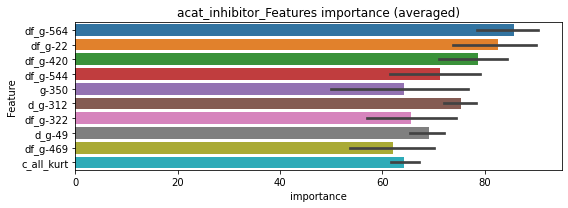

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 acat_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0186987	valid_1's binary_logloss: 0.0321872
[200]	training's binary_logloss: 0.00253486	valid_1's binary_logloss: 0.0123152
[300]	training's binary_logloss: 0.000649908	valid_1's binary_logloss: 0.00911928
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.000371512	valid_1's binary_logloss: 0.00869543


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 acat_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0184201	valid_1's binary_logloss: 0.0265743
[200]	training's binary_logloss: 0.002522	valid_1's binary_logloss: 0.00613107
[300]	training's binary_logloss: 0.000671259	valid_1's binary_logloss: 0.00319714
[400]	training's binary_logloss: 0.000323484	valid_1's binary_logloss: 0.00263502
[500]	training's binary_logloss: 0.000226209	valid_1's binary_logloss: 0.00248364
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000223647	valid_1's binary_logloss: 0.00248347


acat_inhibitor logloss: 0.005589451995296462
acetylcholine_receptor_agonist, len(trt): 190, len(othr): 3259, target_rate: 0.0079785 → Adj_target_rate: 0.0072634


neg labels: 3289 → selected neg labels: 3259


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0914231	valid_1's binary_logloss: 0.22346
[200]	training's binary_logloss: 0.0313213	valid_1's binary_logloss: 0.18482
[300]	training's binary_logloss: 0.0116437	valid_1's binary_logloss: 0.17625
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.0115404	valid_1's binary_logloss: 0.176088
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101332	valid_1's binary_logloss: 0.232101
[200]	training's binary_logloss: 0.0341439	valid_1's binary_logloss: 0.18472
Early stopping, best iteration is:
[254]	training's binary_logloss: 0.0197155	valid_1's binary_logloss: 0.179462


1 / 3 AUC score:0.957
y_Threshold: 0.0653733, Threshold: 0.0952166, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 279 → Positive_corect_labels: 577/3631
p_label_rate: 0.0200904 Vs.target_rate: 0.00798, Num_p_label: 80.0, conf_0:0.08569, conf_1:0.10474
threshold: 0.0952166, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 577.0/3631, y_label_rate: 0.1589094
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0797794	valid_1's binary_logloss: 0.201737
[200]	training's binary_logloss: 0.0234272	valid_1's binary_logloss: 0.155799
[300]	training's binary_logloss: 0.00789614	valid_1's binary_logloss: 0.144356
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.00782434	valid_1's binary_logloss: 0.144333
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0813494	valid_1's binary_logloss: 0.180115
[200]	training's binary_logloss: 0.0239788	valid_1's binary_logloss: 0.136245
Early stopping, best iteration is:
[251]	training's binary_logloss: 0.0137172	valid_1's binary_logloss: 0.129679


2 / 3 AUC score:0.980
y_Threshold: 0.0797082, Threshold: 0.0952166, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 102 → Positive_corect_labels: 526.0/3529
p_label_rate: 0.0170768 Vs.target_rate: 0.00798, Num_p_label: 68.0, conf_0:0.08569, conf_1:0.10474
threshold: 0.0952166, positive_p_label: 68.0/3982, p_label_rate: 0.0170768
positive_y_label: 526.0/3529, y_label_rate: 0.1490507
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0667947	valid_1's binary_logloss: 0.18793
[200]	training's binary_logloss: 0.0181928	valid_1's binary_logloss: 0.150351
Early stopping, best iteration is:
[232]	training's binary_logloss: 0.0122312	valid_1's binary_logloss: 0.145682
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0672473	valid_1's binary_logloss: 0.164592
[200]	training's binary_logloss: 0.0184891	valid_1's binary_logloss: 0.120621
[300]	training's binary_logloss: 0.00629119	valid_1's binary_logloss: 0.103992
Early stopping, best iteration is:
[302]	training's binary_logloss: 0.00617629	valid_1's binary_logloss: 0.103796


3 / 3 AUC score:0.988
y_Threshold: 0.0761960, Threshold: 0.0952166, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 82 → Positive_corect_labels: 485.0/3447
p_label_rate: 0.0150678 Vs.target_rate: 0.00798, Num_p_label: 60.0, conf_0:0.08569, conf_1:0.10474
threshold: 0.0952166, positive_p_label: 60.0/3982, p_label_rate: 0.0150678
positive_y_label: 545.0/7429, y_label_rate: 0.0733612


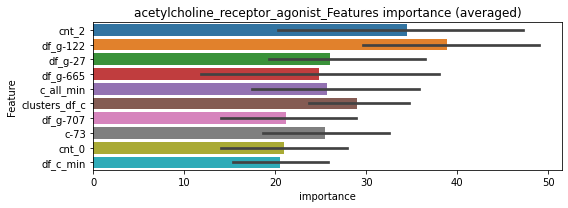

len(train_index) : 3714
len(valid_index) : 3715
================================= fold 1/2 acetylcholine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0439022	valid_1's binary_logloss: 0.114292
[200]	training's binary_logloss: 0.0133871	valid_1's binary_logloss: 0.0910891
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.00766935	valid_1's binary_logloss: 0.0883647


len(train_index) : 3715
len(valid_index) : 3714
================================= fold 2/2 acetylcholine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0374123	valid_1's binary_logloss: 0.118955
[200]	training's binary_logloss: 0.00982056	valid_1's binary_logloss: 0.100942
Early stopping, best iteration is:
[220]	training's binary_logloss: 0.00765634	valid_1's binary_logloss: 0.100032


acetylcholine_receptor_agonist logloss: 0.09419737282647084
acetylcholine_receptor_antagonist, len(trt): 301, len(othr): 3241, target_rate: 0.0126396 → Adj_target_rate: 0.0107394


neg labels: 3289 → selected neg labels: 3241


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126189	valid_1's binary_logloss: 0.295921
[200]	training's binary_logloss: 0.0489509	valid_1's binary_logloss: 0.275468
Early stopping, best iteration is:
[218]	training's binary_logloss: 0.0416545	valid_1's binary_logloss: 0.274307
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136542	valid_1's binary_logloss: 0.297213
[200]	training's binary_logloss: 0.0542364	valid_1's binary_logloss: 0.26639


1 / 3 AUC score:0.870


Early stopping, best iteration is:
[222]	training's binary_logloss: 0.0448701	valid_1's binary_logloss: 0.26404


y_Threshold: 0.1135100, Threshold: 0.1562747, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 502 → Positive_corect_labels: 462/3387
p_label_rate: 0.0200904 Vs.target_rate: 0.01264, Num_p_label: 80.0, conf_0:0.14065, conf_1:0.17190
threshold: 0.1562747, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 462.0/3387, y_label_rate: 0.1364039
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0720526	valid_1's binary_logloss: 0.192211
[200]	training's binary_logloss: 0.022298	valid_1's binary_logloss: 0.163292
Early stopping, best iteration is:
[246]	training's binary_logloss: 0.0137206	valid_1's binary_logloss: 0.160196
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0797583	valid_1's binary_logloss: 0.207829
[200]	training's binary_logloss: 0.02549	valid_1's binary_logloss: 0.185291


2 / 3 AUC score:0.960
y_Threshold: 0.1012627, Threshold: 0.1562747, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 174 → Positive_corect_labels: 375.0/3213


Early stopping, best iteration is:
[205]	training's binary_logloss: 0.0240378	valid_1's binary_logloss: 0.184564


p_label_rate: 0.0092918 Vs.target_rate: 0.01264, Num_p_label: 37.0, conf_0:0.14065, conf_1:0.17190
threshold: 0.1562747, positive_p_label: 37.0/3982, p_label_rate: 0.0092918
positive_y_label: 375.0/3213, y_label_rate: 0.1167134
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0505638	valid_1's binary_logloss: 0.161847
[200]	training's binary_logloss: 0.0128973	valid_1's binary_logloss: 0.133286
Early stopping, best iteration is:
[221]	training's binary_logloss: 0.0099014	valid_1's binary_logloss: 0.132019
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0577738	valid_1's binary_logloss: 0.148761
[200]	training's binary_logloss: 0.0158127	valid_1's binary_logloss: 0.125736


3 / 3 AUC score:0.979
y_Threshold: 0.0640521, Threshold: 0.1562747, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[278]	training's binary_logloss: 0.00673466	valid_1's binary_logloss: 0.121185


Remove_noisy_labels: 96 → Positive_corect_labels: 327.0/3117
p_label_rate: 0.0040181 Vs.target_rate: 0.01264, Num_p_label: 16.0, conf_0:0.14065, conf_1:0.17190
Num_p_label: 16.0, Expected: 50.3, Adj_threshold_1: 0.1562747
Num_p_label: 24.0, Expected: 50.3, Adj_threshold_2: 0.1462747
Num_p_label: 28.0, Expected: 50.3, Adj_threshold_3: 0.1362747
threshold: 0.1362747, positive_p_label: 28.0/3982, p_label_rate: 0.0070316
positive_y_label: 355.0/7099, y_label_rate: 0.0500070


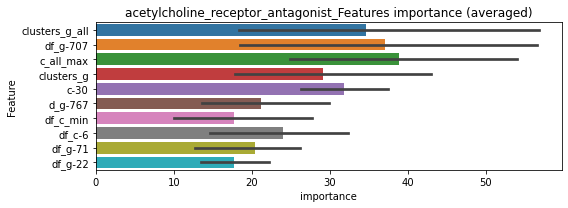

len(train_index) : 3549
len(valid_index) : 3550
================================= fold 1/2 acetylcholine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233561	valid_1's binary_logloss: 0.0744787


len(train_index) : 3550
len(valid_index) : 3549


Early stopping, best iteration is:
[150]	training's binary_logloss: 0.0118602	valid_1's binary_logloss: 0.0677382


================================= fold 2/2 acetylcholine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0220795	valid_1's binary_logloss: 0.0740643
[200]	training's binary_logloss: 0.00545975	valid_1's binary_logloss: 0.0670798
Early stopping, best iteration is:
[193]	training's binary_logloss: 0.00598043	valid_1's binary_logloss: 0.0666869


acetylcholine_receptor_antagonist logloss: 0.06721263167572443
acetylcholinesterase_inhibitor, len(trt): 73, len(othr): 3276, target_rate: 0.0030654 → Adj_target_rate: 0.0032212


neg labels: 3289 → selected neg labels: 3276


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0528097	valid_1's binary_logloss: 0.116329
[200]	training's binary_logloss: 0.0126265	valid_1's binary_logloss: 0.0764641
[300]	training's binary_logloss: 0.00373075	valid_1's binary_logloss: 0.066316
[400]	training's binary_logloss: 0.00165831	valid_1's binary_logloss: 0.0630725
Early stopping, best iteration is:
[407]	training's binary_logloss: 0.0015897	valid_1's binary_logloss: 0.0627273
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0532969	valid_1's binary_logloss: 0.103975
[200]	training's binary_logloss: 0.0118765	valid_1's binary_logloss: 0.0562526
[300]	training's binary_logloss: 0.00357152	valid_1's binary_logloss: 0.0443395
Early stopping, best iteration is:
[384]	training's binary_logloss: 0.00179641	valid_1's binary_logloss: 0.040615


1 / 3 AUC score:0.998
y_Threshold: 0.0106115, Threshold: 0.0138901, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 146 → Positive_corect_labels: 648/3785
p_label_rate: 0.0200904 Vs.target_rate: 0.00307, Num_p_label: 80.0, conf_0:0.01250, conf_1:0.01528
Num_p_label: 80.0, Expected: 12.2, Adj_threshold_1: 0.0138901
Num_p_label: 17.0, Expected: 12.2, Adj_threshold_2: 0.0238901
threshold: 0.0238901, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 648.0/3785, y_label_rate: 0.1712021
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.052274	valid_1's binary_logloss: 0.0967706
[200]	training's binary_logloss: 0.0110446	valid_1's binary_logloss: 0.0501129
[300]	training's binary_logloss: 0.0033474	valid_1's binary_logloss: 0.0373733
[400]	training's binary_logloss: 0.00155535	valid_1's binary_logloss: 0.0329535
[500]	training's binary_logloss: 0.000977845	valid_1's binary_logloss: 0.0308649
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.000851329	valid_1's binary_logloss: 0.0302629
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.051395	valid_1's binary_logloss: 0.10546
[200]	training's binary_logloss: 0.0110463	valid_1's binary_logloss: 0.0569254
[300]	training's binary_logloss: 0.00335173	valid_1's binary_logloss: 0.0462667
Early stopping, best iteration is:
[378]	training's binary_logloss: 0.00182705	valid_1's binary_logloss: 0.0427825


2 / 3 AUC score:0.999
y_Threshold: 0.0276776, Threshold: 0.0238901, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 14 → Positive_corect_labels: 641.0/3771
p_label_rate: 0.0090407 Vs.target_rate: 0.00307, Num_p_label: 36.0, conf_0:0.02150, conf_1:0.02628
threshold: 0.0238901, positive_p_label: 36.0/3982, p_label_rate: 0.0090407
positive_y_label: 641.0/3771, y_label_rate: 0.1699814
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0475189	valid_1's binary_logloss: 0.0988905
[200]	training's binary_logloss: 0.0103371	valid_1's binary_logloss: 0.056698
[300]	training's binary_logloss: 0.00312101	valid_1's binary_logloss: 0.0443955
[400]	training's binary_logloss: 0.001457	valid_1's binary_logloss: 0.0402123
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.00104487	valid_1's binary_logloss: 0.0386222
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0527357	valid_1's binary_logloss: 0.0862042
[200]	training's binary_logloss: 0.0111123	valid_1's binary_logloss: 0.0366485
[300]	training's binary_logloss: 0.00342409	valid_1's binary_logloss: 0.0226132
[400]	training's binary_logloss: 0.00158525	valid_1's binary_logloss: 0.01774
[500]	training's binary_logloss: 0.000978231	valid_1's binary_logloss: 0.0159644
[600]	training's binary_logloss: 0.000736004	valid_

3 / 3 AUC score:1.000
y_Threshold: 0.0284375, Threshold: 0.0238901, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 639.0/3767
p_label_rate: 0.0077850 Vs.target_rate: 0.00307, Num_p_label: 31.0, conf_0:0.02150, conf_1:0.02628
threshold: 0.0238901, positive_p_label: 31.0/3982, p_label_rate: 0.0077850
positive_y_label: 670.0/7749, y_label_rate: 0.0864628


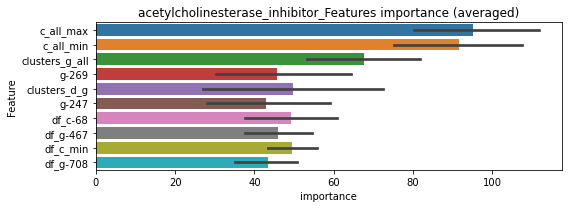

len(train_index) : 3874
len(valid_index) : 3875
================================= fold 1/2 acetylcholinesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0285369	valid_1's binary_logloss: 0.0735129
[200]	training's binary_logloss: 0.00650471	valid_1's binary_logloss: 0.0508215
[300]	training's binary_logloss: 0.00191454	valid_1's binary_logloss: 0.0469661
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.00180376	valid_1's binary_logloss: 0.0466463


len(train_index) : 3875
len(valid_index) : 3874
================================= fold 2/2 acetylcholinesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0309706	valid_1's binary_logloss: 0.0674011
[200]	training's binary_logloss: 0.00726364	valid_1's binary_logloss: 0.0419377
[300]	training's binary_logloss: 0.0019707	valid_1's binary_logloss: 0.0357979
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00143526	valid_1's binary_logloss: 0.0351941


acetylcholinesterase_inhibitor logloss: 0.040920928502582166
adenosine_receptor_agonist, len(trt): 54, len(othr): 3281, target_rate: 0.0022676 → Adj_target_rate: 0.0024931


neg labels: 3289 → selected neg labels: 3281


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0454392	valid_1's binary_logloss: 0.0905917
[200]	training's binary_logloss: 0.00849006	valid_1's binary_logloss: 0.042479
[300]	training's binary_logloss: 0.0024632	valid_1's binary_logloss: 0.0300157
[400]	training's binary_logloss: 0.00115183	valid_1's binary_logloss: 0.0265171
[500]	training's binary_logloss: 0.000724284	valid_1's binary_logloss: 0.0244195
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000752165	valid_1's binary_logloss: 0.0243893
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0461375	valid_1's binary_logloss: 0.0824931
[200]	training's binary_logloss: 0.00856836	valid_1's binary_logloss: 0.0331786
[300]	training's binary_logloss: 0.00247346	valid_1's binary_logloss: 0.0225896
[400]	training's binary_logloss: 0.00119492	valid_1's binary_logloss: 0.0193695
Early stopping, best iteration is:
[432]	trai

1 / 3 AUC score:1.000
y_Threshold: 0.0066145, Threshold: 0.0101798, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3805
p_label_rate: 0.0200904 Vs.target_rate: 0.00227, Num_p_label: 80.0, conf_0:0.00916, conf_1:0.01120
Num_p_label: 80.0, Expected: 9.0, Adj_threshold_1: 0.0101798
Num_p_label: 23.0, Expected: 9.0, Adj_threshold_2: 0.0201798
Num_p_label: 6.0, Expected: 9.0, Adj_threshold_3: 0.0301798
threshold: 0.0301798, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 656.0/3805, y_label_rate: 0.1724047
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0449675	valid_1's binary_logloss: 0.0881726
[200]	training's binary_logloss: 0.00831703	valid_1's binary_logloss: 0.0408322
[300]	training's binary_logloss: 0.0024163	valid_1's binary_logloss: 0.0290004
Early stopping, best iteration is:
[378]	training's binary_logloss: 0.00132244	valid_1's binary_logloss: 0.0253271
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0468268	valid_1's binary_logloss: 0.0826498
[200]	training's binary_logloss: 0.00852348	valid_1's binary_logloss: 0.0332025
[300]	training's binary_logloss: 0.00250934	valid_1's binary_logloss: 0.0225679
[400]	training's binary_logloss: 0.0011921	valid_1's binary_logloss: 0.0194758
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.000957759	valid_1's binary_logloss: 0.0190568


2 / 3 AUC score:1.000
y_Threshold: 0.0330104, Threshold: 0.0301798, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 652.0/3797
p_label_rate: 0.0087896 Vs.target_rate: 0.00227, Num_p_label: 35.0, conf_0:0.02716, conf_1:0.03320
Num_p_label: 35.0, Expected: 9.0, Adj_threshold_1: 0.0301798
Num_p_label: 20.0, Expected: 9.0, Adj_threshold_2: 0.0401798
Num_p_label: 13.0, Expected: 9.0, Adj_threshold_3: 0.0501798
threshold: 0.0501798, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 652.0/3797, y_label_rate: 0.1717145
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0450397	valid_1's binary_logloss: 0.0876346
[200]	training's binary_logloss: 0.00839359	valid_1's binary_logloss: 0.0403146
[300]	training's binary_logloss: 0.00243526	valid_1's binary_logloss: 0.0267719
[400]	training's binary_logloss: 0.00115794	valid_1's binary_logloss: 0.0217899
[500]	training's binary_logloss: 0.000732258	valid_1's binary_logloss: 0.0200968
Early stopping, best iteration is:
[497]	training's binary_logloss: 0.000740822	valid_1's binary_logloss: 0.0200803
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0470677	valid_1's binary_logloss: 0.0834943
[200]	training's binary_logloss: 0.0085862	valid_1's binary_logloss: 0.0313716
[300]	training's binary_logloss: 0.00251316	valid_1's binary_logloss: 0.0185437
[400]	training's binary_logloss: 0.00118598	valid_1's binary_logloss: 0.0143101
[500]	training's binary_logloss: 0.000743878

3 / 3 AUC score:1.000
y_Threshold: 0.0605724, Threshold: 0.0501798, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 650.0/3793
p_label_rate: 0.0030136 Vs.target_rate: 0.00227, Num_p_label: 12.0, conf_0:0.04516, conf_1:0.05520
threshold: 0.0501798, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 662.0/7775, y_label_rate: 0.0851447


len(train_index) : 3887
len(valid_index) : 3888
================================= fold 1/2 adenosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0254054	valid_1's binary_logloss: 0.0559486
[200]	training's binary_logloss: 0.00466604	valid_1's binary_logloss: 0.028903
[300]	training's binary_logloss: 0.00132965	valid_1's binary_logloss: 0.0225963
[400]	training's binary_logloss: 0.000614827	valid_1's binary_logloss: 0.0210387
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.000535892	valid_1's binary_logloss: 0.0207178


len(train_index) : 3888
len(valid_index) : 3887
================================= fold 2/2 adenosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0257024	valid_1's binary_logloss: 0.052253
[200]	training's binary_logloss: 0.00490043	valid_1's binary_logloss: 0.024425
[300]	training's binary_logloss: 0.00141827	valid_1's binary_logloss: 0.0170678
[400]	training's binary_logloss: 0.000654569	valid_1's binary_logloss: 0.0147545
[500]	training's binary_logloss: 0.000408221	valid_1's binary_logloss: 0.01403
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.000352139	valid_1's binary_logloss: 0.0138652


adenosine_receptor_agonist logloss: 0.017291957291753632
adenosine_receptor_antagonist, len(trt): 96, len(othr): 3273, target_rate: 0.0040312 → Adj_target_rate: 0.0040656


neg labels: 3289 → selected neg labels: 3273


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0632057	valid_1's binary_logloss: 0.130687
[200]	training's binary_logloss: 0.0158828	valid_1's binary_logloss: 0.0788585
[300]	training's binary_logloss: 0.00491991	valid_1's binary_logloss: 0.063743
[400]	training's binary_logloss: 0.00223609	valid_1's binary_logloss: 0.0578263
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.00222155	valid_1's binary_logloss: 0.0577529
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0630405	valid_1's binary_logloss: 0.138282
[200]	training's binary_logloss: 0.0163523	valid_1's binary_logloss: 0.0972391
[300]	training's binary_logloss: 0.00512392	valid_1's binary_logloss: 0.0855127
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.00392376	valid_1's binary_logloss: 0.083377


1 / 3 AUC score:0.994
y_Threshold: 0.0199389, Threshold: 0.0232690, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 168 → Positive_corect_labels: 636/3759
p_label_rate: 0.0200904 Vs.target_rate: 0.00403, Num_p_label: 80.0, conf_0:0.02094, conf_1:0.02560
Num_p_label: 80.0, Expected: 16.1, Adj_threshold_1: 0.0232690
Num_p_label: 32.0, Expected: 16.1, Adj_threshold_2: 0.0332690
threshold: 0.0332690, positive_p_label: 32.0/3982, p_label_rate: 0.0080362
positive_y_label: 636.0/3759, y_label_rate: 0.1691939
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0610812	valid_1's binary_logloss: 0.124992
[200]	training's binary_logloss: 0.0150085	valid_1's binary_logloss: 0.075068
[300]	training's binary_logloss: 0.00475051	valid_1's binary_logloss: 0.061664
Early stopping, best iteration is:
[377]	training's binary_logloss: 0.00247418	valid_1's binary_logloss: 0.0571903
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0596208	valid_1's binary_logloss: 0.121907
[200]	training's binary_logloss: 0.0139715	valid_1's binary_logloss: 0.0764558
[300]	training's binary_logloss: 0.00430274	valid_1's binary_logloss: 0.0632473
[400]	training's binary_logloss: 0.00197163	valid_1's binary_logloss: 0.0597739
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00197163	valid_1's binary_logloss: 0.0597739


2 / 3 AUC score:0.998
y_Threshold: 0.0365412, Threshold: 0.0332690, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 40 → Positive_corect_labels: 616.0/3719
p_label_rate: 0.0200904 Vs.target_rate: 0.00403, Num_p_label: 80.0, conf_0:0.02994, conf_1:0.03660
Num_p_label: 80.0, Expected: 16.1, Adj_threshold_1: 0.0332690
Num_p_label: 54.0, Expected: 16.1, Adj_threshold_2: 0.0432690
Num_p_label: 37.0, Expected: 16.1, Adj_threshold_3: 0.0532690
Num_p_label: 26.0, Expected: 16.1, Adj_threshold_4: 0.0632690
threshold: 0.0632690, positive_p_label: 26.0/3982, p_label_rate: 0.0065294
positive_y_label: 616.0/3719, y_label_rate: 0.1656359
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0548882	valid_1's binary_logloss: 0.11882
[200]	training's binary_logloss: 0.0121286	valid_1's binary_logloss: 0.072582
[300]	training's binary_logloss: 0.00381103	valid_1's binary_logloss: 0.0603505
[400]	training's binary_logloss: 0.00175629	valid_1's binary_logloss: 0.0577332
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00144206	valid_1's binary_logloss: 0.0570782
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0565563	valid_1's binary_logloss: 0.103359
[200]	training's binary_logloss: 0.0133086	valid_1's binary_logloss: 0.0605068
[300]	training's binary_logloss: 0.00415268	valid_1's binary_logloss: 0.0465655
[400]	training's binary_logloss: 0.00185896	valid_1's binary_logloss: 0.0422081
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.00131264	valid_1's binary_logloss: 0.040752


3 / 3 AUC score:0.999
y_Threshold: 0.0274904, Threshold: 0.0632690, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 28 → Positive_corect_labels: 602.0/3691
p_label_rate: 0.0027624 Vs.target_rate: 0.00403, Num_p_label: 11.0, conf_0:0.05694, conf_1:0.06960
threshold: 0.0632690, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 613.0/7673, y_label_rate: 0.0798905


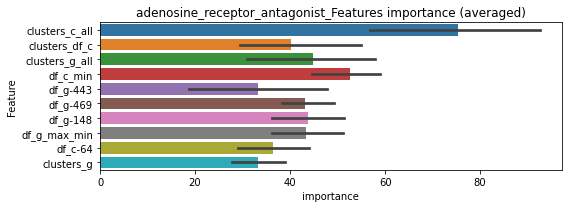

len(train_index) : 3836
len(valid_index) : 3837
================================= fold 1/2 adenosine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0295749	valid_1's binary_logloss: 0.0648864
[200]	training's binary_logloss: 0.00676666	valid_1's binary_logloss: 0.0394735
[300]	training's binary_logloss: 0.00200666	valid_1's binary_logloss: 0.0328554
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00139761	valid_1's binary_logloss: 0.03204


len(train_index) : 3837
len(valid_index) : 3836
================================= fold 2/2 adenosine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0319984	valid_1's binary_logloss: 0.0619001
[200]	training's binary_logloss: 0.00754012	valid_1's binary_logloss: 0.0340632
[300]	training's binary_logloss: 0.0021829	valid_1's binary_logloss: 0.0262012
[400]	training's binary_logloss: 0.000959808	valid_1's binary_logloss: 0.0237449
Early stopping, best iteration is:
[438]	training's binary_logloss: 0.000775855	valid_1's binary_logloss: 0.0233425


adenosine_receptor_antagonist logloss: 0.027691808937763587
adenylyl_cyclase_activator, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0214299	valid_1's binary_logloss: 0.0273252
[200]	training's binary_logloss: 0.0024225	valid_1's binary_logloss: 0.00491177
[300]	training's binary_logloss: 0.000665716	valid_1's binary_logloss: 0.00199271
[400]	training's binary_logloss: 0.00035041	valid_1's binary_logloss: 0.00129537
[500]	training's binary_logloss: 0.000282799	valid_1's binary_logloss: 0.00118042
Early stopping, best iteration is:
[517]	training's binary_logloss: 0.00028138	valid_1's binary_logloss: 0.00117754
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0215193	valid_1's binary_logloss: 0.0258536
[200]	training's binary_logloss: 0.00237424	valid_1's binary_logloss: 0.00351724
[300]	training's binary_logloss: 0.000662445	valid_1's binary_logloss: 0.00116909
[400]	training's binary_logloss: 0.000360601	valid_1's binary_logloss: 0.000693364
[500]	training's binary_logloss: 

1 / 3 AUC score:1.000
y_Threshold: 0.0013836, Threshold: 0.0026760, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076, Num_p_label: 80.0, conf_0:0.00241, conf_1:0.00294
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0026760
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_2: 0.0126760
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_3: 0.0226760
threshold: 0.0226760, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0213867	valid_1's binary_logloss: 0.0263539
[200]	training's binary_logloss: 0.00229503	valid_1's binary_logloss: 0.00419162
[300]	training's binary_logloss: 0.000631705	valid_1's binary_logloss: 0.00157115
[400]	training's binary_logloss: 0.000344287	valid_1's binary_logloss: 0.000990639
[500]	training's binary_logloss: 0.000282834	valid_1's binary_logloss: 0.000866269
Early stopping, best iteration is:
[536]	training's binary_logloss: 0.000277121	valid_1's binary_logloss: 0.000855201
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0217019	valid_1's binary_logloss: 0.0253127
[200]	training's binary_logloss: 0.00223488	valid_1's binary_logloss: 0.00303751
[300]	training's binary_logloss: 0.000614283	valid_1's binary_logloss: 0.00091952
[400]	training's binary_logloss: 0.000339327	valid_1's binary_logloss: 0.000528822
[500]	training's binary_log

2 / 3 AUC score:1.000
y_Threshold: 0.1236035, Threshold: 0.0226760, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0040181 Vs.target_rate: 0.00076, Num_p_label: 16.0, conf_0:0.02041, conf_1:0.02494
Num_p_label: 16.0, Expected: 3.0, Adj_threshold_1: 0.0226760
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_2: 0.0326760
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_3: 0.0426760
threshold: 0.0426760, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0213867	valid_1's binary_logloss: 0.0263539
[200]	training's binary_logloss: 0.00229503	valid_1's binary_logloss: 0.00419162
[300]	training's binary_logloss: 0.000631705	valid_1's binary_logloss: 0.00157115
[400]	training's binary_logloss: 0.000344287	valid_1's binary_logloss: 0.000990639
[500]	training's binary_logloss: 0.000282834	valid_1's binary_logloss: 0.000866269
Early stopping, best iteration is:
[536]	training's binary_logloss: 0.000277121	valid_1's binary_logloss: 0.000855201
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0217019	valid_1's binary_logloss: 0.0253127
[200]	training's binary_logloss: 0.00223488	valid_1's binary_logloss: 0.00303751
[300]	training's binary_logloss: 0.000614283	valid_1's binary_logloss: 0.00091952
[400]	training's binary_logloss: 0.000339327	valid_1's binary_logloss: 0.000528822
[500]	training's binary_log

3 / 3 AUC score:1.000
y_Threshold: 0.1236035, Threshold: 0.0426760, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0012557 Vs.target_rate: 0.00076, Num_p_label: 5.0, conf_0:0.03841, conf_1:0.04694
threshold: 0.0426760, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 662.0/7793, y_label_rate: 0.0849480


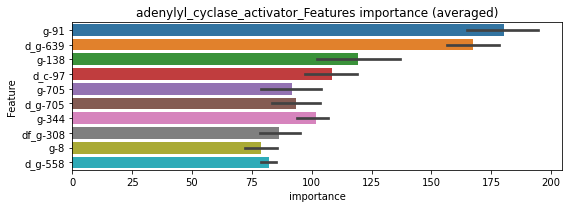

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 adenylyl_cyclase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0109198	valid_1's binary_logloss: 0.0176782
[200]	training's binary_logloss: 0.00113583	valid_1's binary_logloss: 0.00647706
[300]	training's binary_logloss: 0.000308661	valid_1's binary_logloss: 0.00529377
Early stopping, best iteration is:
[376]	training's binary_logloss: 0.000187388	valid_1's binary_logloss: 0.00504353


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 adenylyl_cyclase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0115404	valid_1's binary_logloss: 0.0137818
[200]	training's binary_logloss: 0.0012262	valid_1's binary_logloss: 0.00248683
[300]	training's binary_logloss: 0.000341525	valid_1's binary_logloss: 0.00138962
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.000194985	valid_1's binary_logloss: 0.00120984


adenylyl_cyclase_activator logloss: 0.003126930791002646
adrenergic_receptor_agonist, len(trt): 270, len(othr): 3244, target_rate: 0.0113379 → Adj_target_rate: 0.0097917


neg labels: 3289 → selected neg labels: 3244


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100159	valid_1's binary_logloss: 0.272316
Early stopping, best iteration is:
[181]	training's binary_logloss: 0.0406982	valid_1's binary_logloss: 0.250144
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111899	valid_1's binary_logloss: 0.273769
[200]	training's binary_logloss: 0.0397168	valid_1's binary_logloss: 0.238354
Early stopping, best iteration is:
[233]	training's binary_logloss: 0.0287965	valid_1's binary_logloss: 0.235172


1 / 3 AUC score:0.921
y_Threshold: 0.0953033, Threshold: 0.1261858, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 397 → Positive_corect_labels: 515/3495
p_label_rate: 0.0200904 Vs.target_rate: 0.01134, Num_p_label: 80.0, conf_0:0.11357, conf_1:0.13880
threshold: 0.1261858, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 515.0/3495, y_label_rate: 0.1473534
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0762568	valid_1's binary_logloss: 0.204197
[200]	training's binary_logloss: 0.0240737	valid_1's binary_logloss: 0.174756
Early stopping, best iteration is:
[248]	training's binary_logloss: 0.0144012	valid_1's binary_logloss: 0.170067
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0811508	valid_1's binary_logloss: 0.220515
[200]	training's binary_logloss: 0.0236117	valid_1's binary_logloss: 0.182777


2 / 3 AUC score:0.966
y_Threshold: 0.0794151, Threshold: 0.1261858, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[246]	training's binary_logloss: 0.0146341	valid_1's binary_logloss: 0.176478


Remove_noisy_labels: 152 → Positive_corect_labels: 439.0/3343
p_label_rate: 0.0087896 Vs.target_rate: 0.01134, Num_p_label: 35.0, conf_0:0.11357, conf_1:0.13880
threshold: 0.1261858, positive_p_label: 35.0/3982, p_label_rate: 0.0087896
positive_y_label: 439.0/3343, y_label_rate: 0.1313192
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0547206	valid_1's binary_logloss: 0.16998
[200]	training's binary_logloss: 0.0137706	valid_1's binary_logloss: 0.141192
Early stopping, best iteration is:
[238]	training's binary_logloss: 0.00866932	valid_1's binary_logloss: 0.138785
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0670874	valid_1's binary_logloss: 0.178036
[200]	training's binary_logloss: 0.0178663	valid_1's binary_logloss: 0.14018
Early stopping, best iteration is:
[251]	training's binary_logloss: 0.00991693	valid_1's binary_logloss: 0.133224


3 / 3 AUC score:0.988
y_Threshold: 0.0680155, Threshold: 0.1261858, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 86 → Positive_corect_labels: 396.0/3257
p_label_rate: 0.0042692 Vs.target_rate: 0.01134, Num_p_label: 17.0, conf_0:0.11357, conf_1:0.13880
threshold: 0.1261858, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 413.0/7239, y_label_rate: 0.0570521


len(train_index) : 3619
len(valid_index) : 3620
================================= fold 1/2 adrenergic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0257936	valid_1's binary_logloss: 0.100729
Early stopping, best iteration is:
[178]	training's binary_logloss: 0.00856489	valid_1's binary_logloss: 0.0901726


len(train_index) : 3620
len(valid_index) : 3619
================================= fold 2/2 adrenergic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0283174	valid_1's binary_logloss: 0.101274
[200]	training's binary_logloss: 0.00666396	valid_1's binary_logloss: 0.0862116
Early stopping, best iteration is:
[194]	training's binary_logloss: 0.00723137	valid_1's binary_logloss: 0.0857613


adrenergic_receptor_agonist logloss: 0.08796728432374333
adrenergic_receptor_antagonist, len(trt): 360, len(othr): 3229, target_rate: 0.0151172 → Adj_target_rate: 0.0125042


neg labels: 3289 → selected neg labels: 3229


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132759	valid_1's binary_logloss: 0.342358
Early stopping, best iteration is:
[180]	training's binary_logloss: 0.0625775	valid_1's binary_logloss: 0.328791
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141294	valid_1's binary_logloss: 0.345273


1 / 3 AUC score:0.816
y_Threshold: 0.1286652, Threshold: 0.1662138, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 608 → Positive_corect_labels: 406/3266


Early stopping, best iteration is:
[178]	training's binary_logloss: 0.0686383	valid_1's binary_logloss: 0.32631


p_label_rate: 0.0200904 Vs.target_rate: 0.01512, Num_p_label: 80.0, conf_0:0.14959, conf_1:0.18284
threshold: 0.1662138, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 406.0/3266, y_label_rate: 0.1243111
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0758984	valid_1's binary_logloss: 0.23402
[200]	training's binary_logloss: 0.0229957	valid_1's binary_logloss: 0.212618
Early stopping, best iteration is:
[200]	training's binary_logloss: 0.0229957	valid_1's binary_logloss: 0.212618
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0776297	valid_1's binary_logloss: 0.218279
[200]	training's binary_logloss: 0.0236437	valid_1's binary_logloss: 0.197258


2 / 3 AUC score:0.939
y_Threshold: 0.0828176, Threshold: 0.1662138, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 196 → Positive_corect_labels: 308.0/3070
p_label_rate: 0.0020090 Vs.target_rate: 0.01512, Num_p_label: 8.0, conf_0:0.14959, conf_1:0.18284


Early stopping, best iteration is:
[208]	training's binary_logloss: 0.0219707	valid_1's binary_logloss: 0.197042


Num_p_label: 8.0, Expected: 60.2, Adj_threshold_1: 0.1662138
Num_p_label: 9.0, Expected: 60.2, Adj_threshold_2: 0.1562138
Num_p_label: 9.0, Expected: 60.2, Adj_threshold_3: 0.1462138
Num_p_label: 12.0, Expected: 60.2, Adj_threshold_4: 0.1362138
Num_p_label: 18.0, Expected: 60.2, Adj_threshold_5: 0.1262138
Num_p_label: 37.0, Expected: 60.2, Adj_threshold_6: 0.1162138
threshold: 0.1162138, positive_p_label: 37.0/3982, p_label_rate: 0.0092918
positive_y_label: 308.0/3070, y_label_rate: 0.1003257
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0513988	valid_1's binary_logloss: 0.167867
Early stopping, best iteration is:
[178]	training's binary_logloss: 0.0185462	valid_1's binary_logloss: 0.153382
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0490845	valid_1's binary_logloss: 0.167581
[200]	training's binary_logloss: 0.0134443	valid_1's binary_logloss: 0.145969


3 / 3 AUC score:0.969
y_Threshold: 0.0664724, Threshold: 0.1162138, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 112 → Positive_corect_labels: 252.0/2958
p_label_rate: 0.0020090 Vs.target_rate: 0.01512, Num_p_label: 8.0, conf_0:0.10459, conf_1:0.12784
Num_p_label: 8.0, Expected: 60.2, Adj_threshold_1: 0.1162138


Early stopping, best iteration is:
[241]	training's binary_logloss: 0.00832166	valid_1's binary_logloss: 0.142924


Num_p_label: 18.0, Expected: 60.2, Adj_threshold_2: 0.1062138
Num_p_label: 27.0, Expected: 60.2, Adj_threshold_3: 0.0962138
Num_p_label: 43.0, Expected: 60.2, Adj_threshold_4: 0.0862138
threshold: 0.0862138, positive_p_label: 43.0/3982, p_label_rate: 0.0107986
positive_y_label: 295.0/6940, y_label_rate: 0.0425072


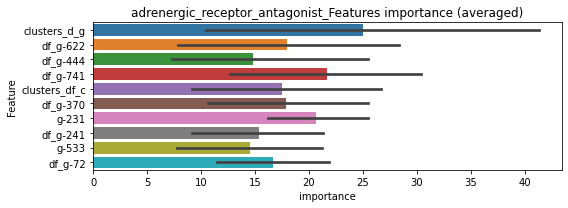

len(train_index) : 3470
len(valid_index) : 3470
================================= fold 1/2 adrenergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0217031	valid_1's binary_logloss: 0.0918072


len(train_index) : 3470
len(valid_index) : 3470
================================= fold 2/2 adrenergic_receptor_antagonist=================================


Early stopping, best iteration is:
[143]	training's binary_logloss: 0.0116909	valid_1's binary_logloss: 0.0864762
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0235323	valid_1's binary_logloss: 0.097266


adrenergic_receptor_antagonist logloss: 0.08965939520110981


Early stopping, best iteration is:
[145]	training's binary_logloss: 0.0119944	valid_1's binary_logloss: 0.0928426


akt_inhibitor, len(trt): 66, len(othr): 3278, target_rate: 0.0027715 → Adj_target_rate: 0.0029567


neg labels: 3289 → selected neg labels: 3278


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0403684	valid_1's binary_logloss: 0.0842483
[200]	training's binary_logloss: 0.00713329	valid_1's binary_logloss: 0.0442881
[300]	training's binary_logloss: 0.00207867	valid_1's binary_logloss: 0.0343334
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.00111518	valid_1's binary_logloss: 0.0316947
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0397315	valid_1's binary_logloss: 0.0740463
[200]	training's binary_logloss: 0.00726249	valid_1's binary_logloss: 0.0339679
[300]	training's binary_logloss: 0.00213465	valid_1's binary_logloss: 0.0255739
Early stopping, best iteration is:
[378]	training's binary_logloss: 0.0011672	valid_1's binary_logloss: 0.0234488


1 / 3 AUC score:0.999
y_Threshold: 0.0093584, Threshold: 0.0328521, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 138 → Positive_corect_labels: 652/3795
p_label_rate: 0.0200904 Vs.target_rate: 0.00277, Num_p_label: 80.0, conf_0:0.02957, conf_1:0.03614
Num_p_label: 80.0, Expected: 11.0, Adj_threshold_1: 0.0328521
Num_p_label: 70.0, Expected: 11.0, Adj_threshold_2: 0.0428521
Num_p_label: 57.0, Expected: 11.0, Adj_threshold_3: 0.0528521
Num_p_label: 52.0, Expected: 11.0, Adj_threshold_4: 0.0628521
Num_p_label: 47.0, Expected: 11.0, Adj_threshold_5: 0.0728521
Num_p_label: 45.0, Expected: 11.0, Adj_threshold_6: 0.0828521
Num_p_label: 42.0, Expected: 11.0, Adj_threshold_7: 0.0928521
Num_p_label: 39.0, Expected: 11.0, Adj_threshold_8: 0.1028521
Num_p_label: 38.0, Expected: 11.0, Adj_threshold_9: 0.1128521
Num_p_label: 36.0, Expected: 11.0, Adj_threshold_10: 0.1228521
threshold: 0.1328521, positive_p_label: 34.0/3982, p_label_rate: 0.0085384
positive_y_label: 652.0/3795, y_label_rate: 0.171805

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0397648	valid_1's binary_logloss: 0.0739424
[200]	training's binary_logloss: 0.00676093	valid_1's binary_logloss: 0.0276552
[300]	training's binary_logloss: 0.00196509	valid_1's binary_logloss: 0.01649
[400]	training's binary_logloss: 0.000954603	valid_1's binary_logloss: 0.0134893
[500]	training's binary_logloss: 0.000616248	valid_1's binary_logloss: 0.0122847
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000606244	valid_1's binary_logloss: 0.0122764
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0386041	valid_1's binary_logloss: 0.0730924
[200]	training's binary_logloss: 0.00640057	valid_1's binary_logloss: 0.027714
[300]	training's binary_logloss: 0.00188379	valid_1's binary_logloss: 0.0186497
[400]	training's binary_logloss: 0.00091426	valid_1's binary_logloss: 0.0149462
Early stopping, best iteration is:
[410]	trai

2 / 3 AUC score:1.000
y_Threshold: 0.1060195, Threshold: 0.1328521, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 648.0/3787
p_label_rate: 0.0220994 Vs.target_rate: 0.00277, Num_p_label: 88.0, conf_0:0.11957, conf_1:0.14614
Num_p_label: 88.0, Expected: 11.0, Adj_threshold_1: 0.1328521
Num_p_label: 84.0, Expected: 11.0, Adj_threshold_2: 0.1428521
Num_p_label: 81.0, Expected: 11.0, Adj_threshold_3: 0.1528521
Num_p_label: 80.0, Expected: 11.0, Adj_threshold_4: 0.1628521
Num_p_label: 78.0, Expected: 11.0, Adj_threshold_5: 0.1728521
Num_p_label: 76.0, Expected: 11.0, Adj_threshold_6: 0.1828521
Num_p_label: 74.0, Expected: 11.0, Adj_threshold_7: 0.1928521
Num_p_label: 70.0, Expected: 11.0, Adj_threshold_8: 0.2028521
Num_p_label: 69.0, Expected: 11.0, Adj_threshold_9: 0.2128521
Num_p_label: 67.0, Expected: 11.0, Adj_threshold_10: 0.2228521
threshold: 0.2328521, positive_p_label: 65.0/3982, p_label_rate: 0.0163235
positive_y_label: 648.0/3787, y_label_rate: 0.171111

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0380672	valid_1's binary_logloss: 0.0716451
[200]	training's binary_logloss: 0.00641811	valid_1's binary_logloss: 0.0331658
[300]	training's binary_logloss: 0.00187693	valid_1's binary_logloss: 0.0233258
[400]	training's binary_logloss: 0.000906228	valid_1's binary_logloss: 0.0212248
Early stopping, best iteration is:
[433]	training's binary_logloss: 0.000772426	valid_1's binary_logloss: 0.0207241
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.037422	valid_1's binary_logloss: 0.0715311
[200]	training's binary_logloss: 0.00622915	valid_1's binary_logloss: 0.025958
[300]	training's binary_logloss: 0.00185662	valid_1's binary_logloss: 0.0152368
[400]	training's binary_logloss: 0.000914948	valid_1's binary_logloss: 0.011686
[500]	training's binary_logloss: 0.000598222	valid_1's binary_logloss: 0.00994863
Early stopping, best iteration is:
[491]	tr

3 / 3 AUC score:1.000
y_Threshold: 0.0568496, Threshold: 0.2328521, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 644.0/3779
p_label_rate: 0.0195881 Vs.target_rate: 0.00277, Num_p_label: 78.0, conf_0:0.20957, conf_1:0.25614
Num_p_label: 78.0, Expected: 11.0, Adj_threshold_1: 0.2328521
Num_p_label: 77.0, Expected: 11.0, Adj_threshold_2: 0.2428521
Num_p_label: 75.0, Expected: 11.0, Adj_threshold_3: 0.2528521
Num_p_label: 75.0, Expected: 11.0, Adj_threshold_4: 0.2628521
Num_p_label: 73.0, Expected: 11.0, Adj_threshold_5: 0.2728521
Num_p_label: 72.0, Expected: 11.0, Adj_threshold_6: 0.2828521
Num_p_label: 71.0, Expected: 11.0, Adj_threshold_7: 0.2928521
Num_p_label: 68.0, Expected: 11.0, Adj_threshold_8: 0.3028521
Num_p_label: 67.0, Expected: 11.0, Adj_threshold_9: 0.3128521
Num_p_label: 66.0, Expected: 11.0, Adj_threshold_10: 0.3228521
threshold: 0.3328521, positive_p_label: 66.0/3982, p_label_rate: 0.0165746
positive_y_label: 710.0/7761, y_label_rate: 0.091483

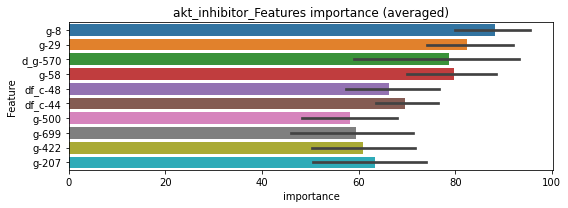

len(train_index) : 3880
len(valid_index) : 3881
================================= fold 1/2 akt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0215593	valid_1's binary_logloss: 0.0468544
[200]	training's binary_logloss: 0.00367654	valid_1's binary_logloss: 0.0225607
[300]	training's binary_logloss: 0.00110733	valid_1's binary_logloss: 0.0173131
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.000583468	valid_1's binary_logloss: 0.0157127


len(train_index) : 3881
len(valid_index) : 3880
================================= fold 2/2 akt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0216145	valid_1's binary_logloss: 0.0537905
[200]	training's binary_logloss: 0.00369149	valid_1's binary_logloss: 0.0281652
[300]	training's binary_logloss: 0.00109125	valid_1's binary_logloss: 0.0216153
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.000776376	valid_1's binary_logloss: 0.0204327


akt_inhibitor logloss: 0.01807240909649329
aldehyde_dehydrogenase_inhibitor, len(trt): 19, len(othr): 3286, target_rate: 0.0007979 → Adj_target_rate: 0.0010260


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0246789	valid_1's binary_logloss: 0.0342483
[200]	training's binary_logloss: 0.0029951	valid_1's binary_logloss: 0.00640519
[300]	training's binary_logloss: 0.000838997	valid_1's binary_logloss: 0.00249224
[400]	training's binary_logloss: 0.000441565	valid_1's binary_logloss: 0.00156667
[500]	training's binary_logloss: 0.000344513	valid_1's binary_logloss: 0.00134062
Early stopping, best iteration is:
[499]	training's binary_logloss: 0.00034484	valid_1's binary_logloss: 0.00133999
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0250385	valid_1's binary_logloss: 0.0302111
[200]	training's binary_logloss: 0.00297606	valid_1's binary_logloss: 0.0047414
[300]	training's binary_logloss: 0.000837894	valid_1's binary_logloss: 0.00169397
[400]	training's binary_logloss: 0.00044436	valid_1's binary_logloss: 0.000992744
[500]	training's binary_logloss: 0

1 / 3 AUC score:1.000
y_Threshold: 0.0016975, Threshold: 0.0026275, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00080, Num_p_label: 80.0, conf_0:0.00236, conf_1:0.00289
Num_p_label: 80.0, Expected: 3.2, Adj_threshold_1: 0.0026275
Num_p_label: 5.0, Expected: 3.2, Adj_threshold_2: 0.0126275
threshold: 0.0126275, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0244992	valid_1's binary_logloss: 0.0337869
[200]	training's binary_logloss: 0.00294035	valid_1's binary_logloss: 0.00588246
[300]	training's binary_logloss: 0.000822025	valid_1's binary_logloss: 0.00209052
[400]	training's binary_logloss: 0.000432543	valid_1's binary_logloss: 0.00128404
[500]	training's binary_logloss: 0.000344406	valid_1's binary_logloss: 0.00109992
Early stopping, best iteration is:
[522]	training's binary_logloss: 0.000339722	valid_1's binary_logloss: 0.0010914
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0241854	valid_1's binary_logloss: 0.0290743
[200]	training's binary_logloss: 0.00285036	valid_1's binary_logloss: 0.00485156
[300]	training's binary_logloss: 0.000801374	valid_1's binary_logloss: 0.00179023
[400]	training's binary_logloss: 0.000427457	valid_1's binary_logloss: 0.00111968
[500]	training's binary_logloss:

2 / 3 AUC score:1.000
y_Threshold: 0.1240182, Threshold: 0.0126275, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0070316 Vs.target_rate: 0.00080, Num_p_label: 28.0, conf_0:0.01136, conf_1:0.01389
Num_p_label: 28.0, Expected: 3.2, Adj_threshold_1: 0.0126275
Num_p_label: 21.0, Expected: 3.2, Adj_threshold_2: 0.0226275
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_3: 0.0326275
Num_p_label: 10.0, Expected: 3.2, Adj_threshold_4: 0.0426275
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_5: 0.0526275
Num_p_label: 3.0, Expected: 3.2, Adj_threshold_6: 0.0626275
threshold: 0.0626275, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0244992	valid_1's binary_logloss: 0.0337869
[200]	training's binary_logloss: 0.00294035	valid_1's binary_logloss: 0.00588246
[300]	training's binary_logloss: 0.000822025	valid_1's binary_logloss: 0.00209052
[400]	training's binary_logloss: 0.000432543	valid_1's binary_logloss: 0.00128404
[500]	training's binary_logloss: 0.000344406	valid_1's binary_logloss: 0.00109992
Early stopping, best iteration is:
[522]	training's binary_logloss: 0.000339722	valid_1's binary_logloss: 0.0010914
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0241854	valid_1's binary_logloss: 0.0290743
[200]	training's binary_logloss: 0.00285036	valid_1's binary_logloss: 0.00485156
[300]	training's binary_logloss: 0.000801374	valid_1's binary_logloss: 0.00179023
[400]	training's binary_logloss: 0.000427457	valid_1's binary_logloss: 0.00111968
[500]	training's binary_logloss:

3 / 3 AUC score:1.000
y_Threshold: 0.1240182, Threshold: 0.0626275, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0007534 Vs.target_rate: 0.00080, Num_p_label: 3.0, conf_0:0.05636, conf_1:0.06889
threshold: 0.0626275, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 660.0/7793, y_label_rate: 0.0846914


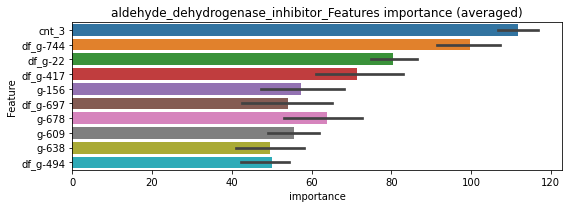

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 aldehyde_dehydrogenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0129694	valid_1's binary_logloss: 0.0199524
[200]	training's binary_logloss: 0.00153091	valid_1's binary_logloss: 0.00468819
[300]	training's binary_logloss: 0.000419467	valid_1's binary_logloss: 0.0028545
[400]	training's binary_logloss: 0.000217884	valid_1's binary_logloss: 0.0025958
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.000227424	valid_1's binary_logloss: 0.00258299


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 aldehyde_dehydrogenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0133283	valid_1's binary_logloss: 0.0177605
[200]	training's binary_logloss: 0.00158703	valid_1's binary_logloss: 0.00392164
[300]	training's binary_logloss: 0.00043055	valid_1's binary_logloss: 0.00227908
[400]	training's binary_logloss: 0.000224794	valid_1's binary_logloss: 0.00199042
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.000197343	valid_1's binary_logloss: 0.00194263


aldehyde_dehydrogenase_inhibitor logloss: 0.0022628468108868475
alk_inhibitor, len(trt): 42, len(othr): 3282, target_rate: 0.0017637 → Adj_target_rate: 0.0020135


neg labels: 3289 → selected neg labels: 3282


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0350184	valid_1's binary_logloss: 0.0629426
[200]	training's binary_logloss: 0.00521497	valid_1's binary_logloss: 0.0240916
[300]	training's binary_logloss: 0.00152496	valid_1's binary_logloss: 0.015539
[400]	training's binary_logloss: 0.000753899	valid_1's binary_logloss: 0.0125755
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.000523186	valid_1's binary_logloss: 0.011569
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0353855	valid_1's binary_logloss: 0.0622653
[200]	training's binary_logloss: 0.00580761	valid_1's binary_logloss: 0.0218454
[300]	training's binary_logloss: 0.00166926	valid_1's binary_logloss: 0.0123639
[400]	training's binary_logloss: 0.000797082	valid_1's binary_logloss: 0.00907565
[500]	training's binary_logloss: 0.000537397	valid_1's binary_logloss: 0.0082505
Early stopping, best iteration is:
[491]	t

1 / 3 AUC score:1.000
y_Threshold: 0.0061133, Threshold: 0.0169035, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3806
p_label_rate: 0.0200904 Vs.target_rate: 0.00176, Num_p_label: 80.0, conf_0:0.01521, conf_1:0.01859
Num_p_label: 80.0, Expected: 7.0, Adj_threshold_1: 0.0169035
Num_p_label: 51.0, Expected: 7.0, Adj_threshold_2: 0.0269035
Num_p_label: 37.0, Expected: 7.0, Adj_threshold_3: 0.0369035
Num_p_label: 32.0, Expected: 7.0, Adj_threshold_4: 0.0469035
Num_p_label: 28.0, Expected: 7.0, Adj_threshold_5: 0.0569035
Num_p_label: 27.0, Expected: 7.0, Adj_threshold_6: 0.0669035
Num_p_label: 24.0, Expected: 7.0, Adj_threshold_7: 0.0769035
Num_p_label: 23.0, Expected: 7.0, Adj_threshold_8: 0.0869035
Num_p_label: 21.0, Expected: 7.0, Adj_threshold_9: 0.0969035
Num_p_label: 18.0, Expected: 7.0, Adj_threshold_10: 0.1069035
threshold: 0.1169035, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 656.0/3806, y_label_rate: 0.1723594
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0332712	valid_1's binary_logloss: 0.0599567
[200]	training's binary_logloss: 0.00488803	valid_1's binary_logloss: 0.0190357
[300]	training's binary_logloss: 0.00142523	valid_1's binary_logloss: 0.0112492
[400]	training's binary_logloss: 0.000703878	valid_1's binary_logloss: 0.00848512
[500]	training's binary_logloss: 0.000480986	valid_1's binary_logloss: 0.00749566
Early stopping, best iteration is:
[548]	training's binary_logloss: 0.000444265	valid_1's binary_logloss: 0.00734311
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.032971	valid_1's binary_logloss: 0.0594847
[200]	training's binary_logloss: 0.00491521	valid_1's binary_logloss: 0.019977
[300]	training's binary_logloss: 0.00142725	valid_1's binary_logloss: 0.0112614
[400]	training's binary_logloss: 0.000711595	valid_1's binary_logloss: 0.00841812
Early stopping, best iteration is:
[487

2 / 3 AUC score:1.000
y_Threshold: 0.2737965, Threshold: 0.1169035, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 653.0/3800
p_label_rate: 0.0173280 Vs.target_rate: 0.00176, Num_p_label: 69.0, conf_0:0.10521, conf_1:0.12859
Num_p_label: 69.0, Expected: 7.0, Adj_threshold_1: 0.1169035
Num_p_label: 64.0, Expected: 7.0, Adj_threshold_2: 0.1269035
Num_p_label: 57.0, Expected: 7.0, Adj_threshold_3: 0.1369035
Num_p_label: 54.0, Expected: 7.0, Adj_threshold_4: 0.1469035
Num_p_label: 52.0, Expected: 7.0, Adj_threshold_5: 0.1569035
Num_p_label: 49.0, Expected: 7.0, Adj_threshold_6: 0.1669035
Num_p_label: 48.0, Expected: 7.0, Adj_threshold_7: 0.1769035
Num_p_label: 47.0, Expected: 7.0, Adj_threshold_8: 0.1869035
Num_p_label: 45.0, Expected: 7.0, Adj_threshold_9: 0.1969035
Num_p_label: 41.0, Expected: 7.0, Adj_threshold_10: 0.2069035
threshold: 0.2169035, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 653.0/3800, y_label_rate: 0.1718421
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0322544	valid_1's binary_logloss: 0.0691923
[200]	training's binary_logloss: 0.00478845	valid_1's binary_logloss: 0.0332203
[300]	training's binary_logloss: 0.00139541	valid_1's binary_logloss: 0.0249421
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00100207	valid_1's binary_logloss: 0.0233903
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0330792	valid_1's binary_logloss: 0.0610161
[200]	training's binary_logloss: 0.0047881	valid_1's binary_logloss: 0.0185139
[300]	training's binary_logloss: 0.00139323	valid_1's binary_logloss: 0.00978401
[400]	training's binary_logloss: 0.00070221	valid_1's binary_logloss: 0.00718777
[500]	training's binary_logloss: 0.00047538	valid_1's binary_logloss: 0.00586684
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.000445681	valid_1's binary_logloss: 0.00567333


3 / 3 AUC score:1.000
y_Threshold: 0.0649087, Threshold: 0.2169035, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 10 → Positive_corect_labels: 648.0/3790
p_label_rate: 0.0110497 Vs.target_rate: 0.00176, Num_p_label: 44.0, conf_0:0.19521, conf_1:0.23859
Num_p_label: 44.0, Expected: 7.0, Adj_threshold_1: 0.2169035
Num_p_label: 43.0, Expected: 7.0, Adj_threshold_2: 0.2269035
Num_p_label: 42.0, Expected: 7.0, Adj_threshold_3: 0.2369035
Num_p_label: 38.0, Expected: 7.0, Adj_threshold_4: 0.2469035
Num_p_label: 37.0, Expected: 7.0, Adj_threshold_5: 0.2569035
Num_p_label: 35.0, Expected: 7.0, Adj_threshold_6: 0.2669035
Num_p_label: 34.0, Expected: 7.0, Adj_threshold_7: 0.2769035
Num_p_label: 32.0, Expected: 7.0, Adj_threshold_8: 0.2869035
Num_p_label: 32.0, Expected: 7.0, Adj_threshold_9: 0.2969035
Num_p_label: 31.0, Expected: 7.0, Adj_threshold_10: 0.3069035
threshold: 0.3169035, positive_p_label: 31.0/3982, p_label_rate: 0.0077850
positive_y_label: 679.0/7772, y_label_rate: 0.0873649


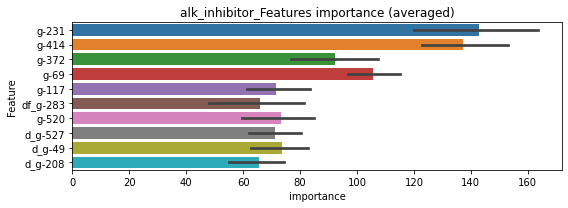

len(train_index) : 3886
len(valid_index) : 3886
================================= fold 1/2 alk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0184186	valid_1's binary_logloss: 0.0345395
[200]	training's binary_logloss: 0.00272359	valid_1's binary_logloss: 0.0136124
[300]	training's binary_logloss: 0.000790884	valid_1's binary_logloss: 0.00929805
[400]	training's binary_logloss: 0.000394208	valid_1's binary_logloss: 0.00829306
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.000384789	valid_1's binary_logloss: 0.00824211


len(train_index) : 3886
len(valid_index) : 3886
================================= fold 2/2 alk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0186854	valid_1's binary_logloss: 0.0385721
[200]	training's binary_logloss: 0.00278151	valid_1's binary_logloss: 0.0174379
[300]	training's binary_logloss: 0.00079886	valid_1's binary_logloss: 0.0132498
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.000445432	valid_1's binary_logloss: 0.0120893


alk_inhibitor logloss: 0.010165713459812282
ampk_activator, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942


neg labels: 3289 → selected neg labels: 3287


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.019639	valid_1's binary_logloss: 0.024219
[200]	training's binary_logloss: 0.00209183	valid_1's binary_logloss: 0.00374535
[300]	training's binary_logloss: 0.000595936	valid_1's binary_logloss: 0.00133149
[400]	training's binary_logloss: 0.000332427	valid_1's binary_logloss: 0.000824741
[500]	training's binary_logloss: 0.000287096	valid_1's binary_logloss: 0.000734232
Early stopping, best iteration is:
[501]	training's binary_logloss: 0.000286934	valid_1's binary_logloss: 0.000734045
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0195054	valid_1's binary_logloss: 0.0238095
[200]	training's binary_logloss: 0.00211549	valid_1's binary_logloss: 0.00431452
[300]	training's binary_logloss: 0.000604989	valid_1's binary_logloss: 0.00215997
[400]	training's binary_logloss: 0.000344011	valid_1's binary_logloss: 0.00161608
Early stopping, best iteration

1 / 3 AUC score:1.000
y_Threshold: 0.0012367, Threshold: 0.0020733, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00050, Num_p_label: 80.0, conf_0:0.00187, conf_1:0.00228
Num_p_label: 80.0, Expected: 2.0, Adj_threshold_1: 0.0020733
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_2: 0.0120733
Num_p_label: 2.0, Expected: 2.0, Adj_threshold_3: 0.0220733
threshold: 0.0220733, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193402	valid_1's binary_logloss: 0.0228472
[200]	training's binary_logloss: 0.00199909	valid_1's binary_logloss: 0.00305438
[300]	training's binary_logloss: 0.000580373	valid_1's binary_logloss: 0.00101382
[400]	training's binary_logloss: 0.000327977	valid_1's binary_logloss: 0.000616638
[500]	training's binary_logloss: 0.000284667	valid_1's binary_logloss: 0.000548089
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000284271	valid_1's binary_logloss: 0.000547298
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193816	valid_1's binary_logloss: 0.0222477
[200]	training's binary_logloss: 0.00199615	valid_1's binary_logloss: 0.00326209
[300]	training's binary_logloss: 0.000577538	valid_1's binary_logloss: 0.001512
[400]	training's binary_logloss: 0.000330089	valid_1's binary_logloss: 0.00119157
Early stopping, best iteration

2 / 3 AUC score:1.000
y_Threshold: 0.0527951, Threshold: 0.0220733, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0035158 Vs.target_rate: 0.00050, Num_p_label: 14.0, conf_0:0.01987, conf_1:0.02428
Num_p_label: 14.0, Expected: 2.0, Adj_threshold_1: 0.0220733
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_2: 0.0320733
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_3: 0.0420733
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_4: 0.0520733
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_5: 0.0620733
threshold: 0.0620733, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193402	valid_1's binary_logloss: 0.0228472
[200]	training's binary_logloss: 0.00199909	valid_1's binary_logloss: 0.00305438
[300]	training's binary_logloss: 0.000580373	valid_1's binary_logloss: 0.00101382
[400]	training's binary_logloss: 0.000327977	valid_1's binary_logloss: 0.000616638
[500]	training's binary_logloss: 0.000284667	valid_1's binary_logloss: 0.000548089
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000284271	valid_1's binary_logloss: 0.000547298
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193816	valid_1's binary_logloss: 0.0222477
[200]	training's binary_logloss: 0.00199615	valid_1's binary_logloss: 0.00326209
[300]	training's binary_logloss: 0.000577538	valid_1's binary_logloss: 0.001512
[400]	training's binary_logloss: 0.000330089	valid_1's binary_logloss: 0.00119157
Early stopping, best iteration

3 / 3 AUC score:1.000
y_Threshold: 0.0527951, Threshold: 0.0620733, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0007534 Vs.target_rate: 0.00050, Num_p_label: 3.0, conf_0:0.05587, conf_1:0.06828
threshold: 0.0620733, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 660.0/7794, y_label_rate: 0.0846805


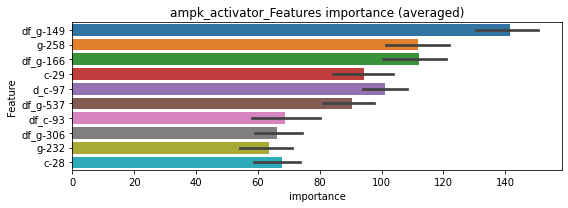

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 ampk_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0105494	valid_1's binary_logloss: 0.014983
[200]	training's binary_logloss: 0.0010782	valid_1's binary_logloss: 0.00453345
[300]	training's binary_logloss: 0.000300952	valid_1's binary_logloss: 0.00371405
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.000274685	valid_1's binary_logloss: 0.00365074


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 ampk_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0106745	valid_1's binary_logloss: 0.0132948
[200]	training's binary_logloss: 0.00110985	valid_1's binary_logloss: 0.0023316
[300]	training's binary_logloss: 0.000308816	valid_1's binary_logloss: 0.00128747
Early stopping, best iteration is:
[386]	training's binary_logloss: 0.00018096	valid_1's binary_logloss: 0.00111184


ampk_activator logloss: 0.002381291421637366
analgesic, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942


neg labels: 3289 → selected neg labels: 3287


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0191587	valid_1's binary_logloss: 0.0259838
[200]	training's binary_logloss: 0.00196779	valid_1's binary_logloss: 0.00496541
[300]	training's binary_logloss: 0.000572814	valid_1's binary_logloss: 0.00248826
[400]	training's binary_logloss: 0.000322153	valid_1's binary_logloss: 0.00173144
[500]	training's binary_logloss: 0.00027911	valid_1's binary_logloss: 0.00162628
Early stopping, best iteration is:
[527]	training's binary_logloss: 0.000276599	valid_1's binary_logloss: 0.00162163
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0191816	valid_1's binary_logloss: 0.0212369
[200]	training's binary_logloss: 0.00197792	valid_1's binary_logloss: 0.00259558
[300]	training's binary_logloss: 0.00056907	valid_1's binary_logloss: 0.000869252
[400]	training's binary_logloss: 0.00031874	valid_1's binary_logloss: 0.000518921
[500]	training's binary_logloss:

1 / 3 AUC score:1.000
y_Threshold: 0.0010665, Threshold: 0.0015602, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00050, Num_p_label: 80.0, conf_0:0.00140, conf_1:0.00172
Num_p_label: 80.0, Expected: 2.0, Adj_threshold_1: 0.0015602
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_2: 0.0115602
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_3: 0.0215602
threshold: 0.0215602, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0188913	valid_1's binary_logloss: 0.0250511
[200]	training's binary_logloss: 0.00190867	valid_1's binary_logloss: 0.00419704
[300]	training's binary_logloss: 0.000549415	valid_1's binary_logloss: 0.0019072
[400]	training's binary_logloss: 0.000313652	valid_1's binary_logloss: 0.00135562
[500]	training's binary_logloss: 0.000274848	valid_1's binary_logloss: 0.00128255
Early stopping, best iteration is:
[522]	training's binary_logloss: 0.000273389	valid_1's binary_logloss: 0.00127971
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0191898	valid_1's binary_logloss: 0.0208226
[200]	training's binary_logloss: 0.00192072	valid_1's binary_logloss: 0.0023695
[300]	training's binary_logloss: 0.000552479	valid_1's binary_logloss: 0.000762952
[400]	training's binary_logloss: 0.000313246	valid_1's binary_logloss: 0.00045694
[500]	training's binary_logloss:

2 / 3 AUC score:1.000
y_Threshold: 0.0620831, Threshold: 0.0215602, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0025113 Vs.target_rate: 0.00050, Num_p_label: 10.0, conf_0:0.01940, conf_1:0.02372
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_1: 0.0215602
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_2: 0.0315602
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_3: 0.0415602
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_4: 0.0515602
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_5: 0.0615602
threshold: 0.0615602, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0188913	valid_1's binary_logloss: 0.0250511
[200]	training's binary_logloss: 0.00190867	valid_1's binary_logloss: 0.00419704
[300]	training's binary_logloss: 0.000549415	valid_1's binary_logloss: 0.0019072
[400]	training's binary_logloss: 0.000313652	valid_1's binary_logloss: 0.00135562
[500]	training's binary_logloss: 0.000274848	valid_1's binary_logloss: 0.00128255
Early stopping, best iteration is:
[522]	training's binary_logloss: 0.000273389	valid_1's binary_logloss: 0.00127971
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0191898	valid_1's binary_logloss: 0.0208226
[200]	training's binary_logloss: 0.00192072	valid_1's binary_logloss: 0.0023695
[300]	training's binary_logloss: 0.000552479	valid_1's binary_logloss: 0.000762952
[400]	training's binary_logloss: 0.000313246	valid_1's binary_logloss: 0.00045694
[500]	training's binary_logloss:

3 / 3 AUC score:1.000
y_Threshold: 0.0620831, Threshold: 0.0615602, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0010045 Vs.target_rate: 0.00050, Num_p_label: 4.0, conf_0:0.05540, conf_1:0.06772
threshold: 0.0615602, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 661.0/7794, y_label_rate: 0.0848088


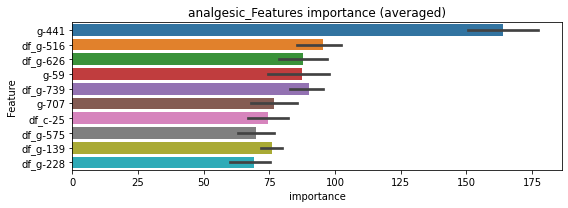

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 analgesic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0101813	valid_1's binary_logloss: 0.0162938
[200]	training's binary_logloss: 0.000999	valid_1's binary_logloss: 0.00423438
[300]	training's binary_logloss: 0.000278214	valid_1's binary_logloss: 0.00329454
Early stopping, best iteration is:
[291]	training's binary_logloss: 0.000299291	valid_1's binary_logloss: 0.0032896


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 analgesic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0104344	valid_1's binary_logloss: 0.0140882
[200]	training's binary_logloss: 0.00104754	valid_1's binary_logloss: 0.00489532


analgesic logloss: 0.004035614377743114


Early stopping, best iteration is:
[219]	training's binary_logloss: 0.00076384	valid_1's binary_logloss: 0.00478163


androgen_receptor_agonist, len(trt): 48, len(othr): 3281, target_rate: 0.0020156 → Adj_target_rate: 0.0022556


neg labels: 3289 → selected neg labels: 3281


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0411772	valid_1's binary_logloss: 0.0836383
[200]	training's binary_logloss: 0.00757555	valid_1's binary_logloss: 0.038128
[300]	training's binary_logloss: 0.00217921	valid_1's binary_logloss: 0.0277172
[400]	training's binary_logloss: 0.00102554	valid_1's binary_logloss: 0.0242099
Early stopping, best iteration is:
[471]	training's binary_logloss: 0.000730493	valid_1's binary_logloss: 0.0231914
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0453151	valid_1's binary_logloss: 0.0695157
[200]	training's binary_logloss: 0.00864387	valid_1's binary_logloss: 0.0227253
[300]	training's binary_logloss: 0.00245782	valid_1's binary_logloss: 0.0115881
[400]	training's binary_logloss: 0.00113274	valid_1's binary_logloss: 0.00823093
[500]	training's binary_logloss: 0.000710236	valid_1's binary_logloss: 0.00706269
[600]	training's binary_logloss: 0.0005571

1 / 3 AUC score:1.000
y_Threshold: 0.0049924, Threshold: 0.0081215, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3805
p_label_rate: 0.0200904 Vs.target_rate: 0.00202, Num_p_label: 80.0, conf_0:0.00731, conf_1:0.00893
Num_p_label: 80.0, Expected: 8.0, Adj_threshold_1: 0.0081215
Num_p_label: 24.0, Expected: 8.0, Adj_threshold_2: 0.0181215
Num_p_label: 12.0, Expected: 8.0, Adj_threshold_3: 0.0281215
threshold: 0.0281215, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 656.0/3805, y_label_rate: 0.1724047
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0405504	valid_1's binary_logloss: 0.0785938
[200]	training's binary_logloss: 0.00704558	valid_1's binary_logloss: 0.0359983
[300]	training's binary_logloss: 0.00206346	valid_1's binary_logloss: 0.0252914
[400]	training's binary_logloss: 0.000986314	valid_1's binary_logloss: 0.0218633
[500]	training's binary_logloss: 0.000643664	valid_1's binary_logloss: 0.0204177
Early stopping, best iteration is:
[493]	training's binary_logloss: 0.000655877	valid_1's binary_logloss: 0.0203189
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0463033	valid_1's binary_logloss: 0.0676603
[200]	training's binary_logloss: 0.0085206	valid_1's binary_logloss: 0.020997
[300]	training's binary_logloss: 0.0024191	valid_1's binary_logloss: 0.010796
[400]	training's binary_logloss: 0.00112527	valid_1's binary_logloss: 0.00757902
[500]	training's binary_logloss: 0.000711252	

2 / 3 AUC score:1.000
y_Threshold: 0.0350217, Threshold: 0.0281215, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3803
p_label_rate: 0.0072828 Vs.target_rate: 0.00202, Num_p_label: 29.0, conf_0:0.02531, conf_1:0.03093
Num_p_label: 29.0, Expected: 8.0, Adj_threshold_1: 0.0281215
Num_p_label: 20.0, Expected: 8.0, Adj_threshold_2: 0.0381215
Num_p_label: 18.0, Expected: 8.0, Adj_threshold_3: 0.0481215
Num_p_label: 14.0, Expected: 8.0, Adj_threshold_4: 0.0581215
threshold: 0.0581215, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 655.0/3803, y_label_rate: 0.1722324
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0415772	valid_1's binary_logloss: 0.0744752
[200]	training's binary_logloss: 0.00757386	valid_1's binary_logloss: 0.0320012
[300]	training's binary_logloss: 0.00219438	valid_1's binary_logloss: 0.0217533
[400]	training's binary_logloss: 0.00104368	valid_1's binary_logloss: 0.0187551
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00104368	valid_1's binary_logloss: 0.0187551
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0426167	valid_1's binary_logloss: 0.0723092
[200]	training's binary_logloss: 0.00740187	valid_1's binary_logloss: 0.0278401
[300]	training's binary_logloss: 0.00220107	valid_1's binary_logloss: 0.0166904
[400]	training's binary_logloss: 0.001066	valid_1's binary_logloss: 0.0131416
Early stopping, best iteration is:
[451]	training's binary_logloss: 0.00081901	valid_1's binary_logloss: 0.0121064


3 / 3 AUC score:1.000
y_Threshold: 0.0424725, Threshold: 0.0581215, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 654.0/3801
p_label_rate: 0.0042692 Vs.target_rate: 0.00202, Num_p_label: 17.0, conf_0:0.05231, conf_1:0.06393
threshold: 0.0581215, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 671.0/7783, y_label_rate: 0.0862135


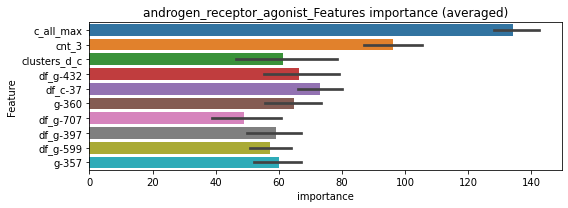

len(train_index) : 3891
len(valid_index) : 3892
================================= fold 1/2 androgen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.024117	valid_1's binary_logloss: 0.0495206
[200]	training's binary_logloss: 0.0043633	valid_1's binary_logloss: 0.026381
[300]	training's binary_logloss: 0.00123931	valid_1's binary_logloss: 0.0225083
Early stopping, best iteration is:
[368]	training's binary_logloss: 0.000700187	valid_1's binary_logloss: 0.022117


len(train_index) : 3892
len(valid_index) : 3891
================================= fold 2/2 androgen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0252711	valid_1's binary_logloss: 0.0455804
[200]	training's binary_logloss: 0.00495097	valid_1's binary_logloss: 0.0237274
[300]	training's binary_logloss: 0.00138245	valid_1's binary_logloss: 0.0179038
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.000721014	valid_1's binary_logloss: 0.0167198


androgen_receptor_agonist logloss: 0.019418774574232658
androgen_receptor_antagonist, len(trt): 89, len(othr): 3274, target_rate: 0.0037373 → Adj_target_rate: 0.0038122


neg labels: 3289 → selected neg labels: 3274


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0603628	valid_1's binary_logloss: 0.127631
[200]	training's binary_logloss: 0.01457	valid_1's binary_logloss: 0.0820035
[300]	training's binary_logloss: 0.00459137	valid_1's binary_logloss: 0.0722861
[400]	training's binary_logloss: 0.00202968	valid_1's binary_logloss: 0.069725
Early stopping, best iteration is:
[399]	training's binary_logloss: 0.0020428	valid_1's binary_logloss: 0.0696675
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0702607	valid_1's binary_logloss: 0.125442
[200]	training's binary_logloss: 0.0183448	valid_1's binary_logloss: 0.0679942
[300]	training's binary_logloss: 0.00534414	valid_1's binary_logloss: 0.0496785
[400]	training's binary_logloss: 0.00228112	valid_1's binary_logloss: 0.0431654
Early stopping, best iteration is:
[407]	training's binary_logloss: 0.00217907	valid_1's binary_logloss: 0.042921


1 / 3 AUC score:0.994
y_Threshold: 0.0154256, Threshold: 0.0207544, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 154 → Positive_corect_labels: 643/3774
p_label_rate: 0.0200904 Vs.target_rate: 0.00374, Num_p_label: 80.0, conf_0:0.01868, conf_1:0.02283
Num_p_label: 80.0, Expected: 14.9, Adj_threshold_1: 0.0207544
Num_p_label: 33.0, Expected: 14.9, Adj_threshold_2: 0.0307544
Num_p_label: 14.0, Expected: 14.9, Adj_threshold_3: 0.0407544
threshold: 0.0407544, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 643.0/3774, y_label_rate: 0.1703763
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0588031	valid_1's binary_logloss: 0.123561
[200]	training's binary_logloss: 0.0142422	valid_1's binary_logloss: 0.0752383
[300]	training's binary_logloss: 0.00429778	valid_1's binary_logloss: 0.0588632
Early stopping, best iteration is:
[377]	training's binary_logloss: 0.00225036	valid_1's binary_logloss: 0.0536014
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.064291	valid_1's binary_logloss: 0.133286
[200]	training's binary_logloss: 0.0161348	valid_1's binary_logloss: 0.0822322
[300]	training's binary_logloss: 0.00496849	valid_1's binary_logloss: 0.0697514
[400]	training's binary_logloss: 0.00217562	valid_1's binary_logloss: 0.0650526
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.0020379	valid_1's binary_logloss: 0.0648979


2 / 3 AUC score:0.998
y_Threshold: 0.0421059, Threshold: 0.0407544, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 30 → Positive_corect_labels: 628.0/3744
p_label_rate: 0.0095429 Vs.target_rate: 0.00374, Num_p_label: 38.0, conf_0:0.03668, conf_1:0.04483
threshold: 0.0407544, positive_p_label: 38.0/3982, p_label_rate: 0.0095429
positive_y_label: 628.0/3744, y_label_rate: 0.1677350
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0579093	valid_1's binary_logloss: 0.106684
[200]	training's binary_logloss: 0.0137594	valid_1's binary_logloss: 0.0526419
[300]	training's binary_logloss: 0.00426927	valid_1's binary_logloss: 0.0352259
[400]	training's binary_logloss: 0.00194269	valid_1's binary_logloss: 0.0302712
[500]	training's binary_logloss: 0.00116651	valid_1's binary_logloss: 0.0276115
Early stopping, best iteration is:
[542]	training's binary_logloss: 0.000997464	valid_1's binary_logloss: 0.0269052
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.062084	valid_1's binary_logloss: 0.111627
[200]	training's binary_logloss: 0.0150519	valid_1's binary_logloss: 0.0593026
[300]	training's binary_logloss: 0.00458795	valid_1's binary_logloss: 0.042268
[400]	training's binary_logloss: 0.00202145	valid_1's binary_logloss: 0.0373065
Early stopping, best iteration is:
[396]	training'

3 / 3 AUC score:1.000
y_Threshold: 0.0421019, Threshold: 0.0407544, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 624.0/3736
p_label_rate: 0.0062783 Vs.target_rate: 0.00374, Num_p_label: 25.0, conf_0:0.03668, conf_1:0.04483
threshold: 0.0407544, positive_p_label: 25.0/3982, p_label_rate: 0.0062783
positive_y_label: 649.0/7718, y_label_rate: 0.0840891


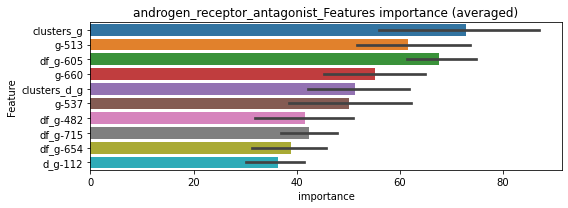

len(train_index) : 3859
len(valid_index) : 3859
================================= fold 1/2 androgen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0336201	valid_1's binary_logloss: 0.0765201
[200]	training's binary_logloss: 0.00790207	valid_1's binary_logloss: 0.0513572
[300]	training's binary_logloss: 0.00230992	valid_1's binary_logloss: 0.0457957
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.0024541	valid_1's binary_logloss: 0.0456857


len(train_index) : 3859
len(valid_index) : 3859
================================= fold 2/2 androgen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0346431	valid_1's binary_logloss: 0.0691272
[200]	training's binary_logloss: 0.00856109	valid_1's binary_logloss: 0.0410704
[300]	training's binary_logloss: 0.00261504	valid_1's binary_logloss: 0.0331867
Early stopping, best iteration is:
[378]	training's binary_logloss: 0.00131894	valid_1's binary_logloss: 0.0315781


androgen_receptor_antagonist logloss: 0.03863185784721444
anesthetic_-_local, len(trt): 80, len(othr): 3276, target_rate: 0.0033594 → Adj_target_rate: 0.0034820


neg labels: 3289 → selected neg labels: 3276


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0573335	valid_1's binary_logloss: 0.122855
[200]	training's binary_logloss: 0.0125563	valid_1's binary_logloss: 0.0764415
[300]	training's binary_logloss: 0.00382213	valid_1's binary_logloss: 0.0640878
[400]	training's binary_logloss: 0.00172633	valid_1's binary_logloss: 0.0595644
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00166657	valid_1's binary_logloss: 0.0593751
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0608315	valid_1's binary_logloss: 0.121328
[200]	training's binary_logloss: 0.0144368	valid_1's binary_logloss: 0.0752768
Early stopping, best iteration is:
[282]	training's binary_logloss: 0.00522044	valid_1's binary_logloss: 0.0650347


1 / 3 AUC score:0.994
y_Threshold: 0.0207736, Threshold: 0.0230955, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 160 → Positive_corect_labels: 641/3771
p_label_rate: 0.0200904 Vs.target_rate: 0.00336, Num_p_label: 80.0, conf_0:0.02079, conf_1:0.02541
Num_p_label: 80.0, Expected: 13.4, Adj_threshold_1: 0.0230955
Num_p_label: 36.0, Expected: 13.4, Adj_threshold_2: 0.0330955
Num_p_label: 17.0, Expected: 13.4, Adj_threshold_3: 0.0430955
threshold: 0.0430955, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 641.0/3771, y_label_rate: 0.1699814
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0588605	valid_1's binary_logloss: 0.107733
[200]	training's binary_logloss: 0.0128612	valid_1's binary_logloss: 0.0528981
[300]	training's binary_logloss: 0.00391829	valid_1's binary_logloss: 0.0380964
[400]	training's binary_logloss: 0.00176196	valid_1's binary_logloss: 0.033123
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00133599	valid_1's binary_logloss: 0.0322699
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0597825	valid_1's binary_logloss: 0.106868
[200]	training's binary_logloss: 0.0130562	valid_1's binary_logloss: 0.0571032
[300]	training's binary_logloss: 0.00393472	valid_1's binary_logloss: 0.0442986
[400]	training's binary_logloss: 0.00179099	valid_1's binary_logloss: 0.040529
Early stopping, best iteration is:
[433]	training's binary_logloss: 0.00148086	valid_1's binary_logloss: 0.0398469


2 / 3 AUC score:0.999
y_Threshold: 0.0379138, Threshold: 0.0430955, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 16 → Positive_corect_labels: 633.0/3755
p_label_rate: 0.0027624 Vs.target_rate: 0.00336, Num_p_label: 11.0, conf_0:0.03879, conf_1:0.04741
threshold: 0.0430955, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 633.0/3755, y_label_rate: 0.1685752
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0577719	valid_1's binary_logloss: 0.117813
[200]	training's binary_logloss: 0.0126011	valid_1's binary_logloss: 0.068472
[300]	training's binary_logloss: 0.0036769	valid_1's binary_logloss: 0.0541598
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00266655	valid_1's binary_logloss: 0.0522127
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0544319	valid_1's binary_logloss: 0.106639
[200]	training's binary_logloss: 0.0117768	valid_1's binary_logloss: 0.0569976
[300]	training's binary_logloss: 0.00356107	valid_1's binary_logloss: 0.0436465
[400]	training's binary_logloss: 0.00163083	valid_1's binary_logloss: 0.0396255
Early stopping, best iteration is:
[452]	training's binary_logloss: 0.00122915	valid_1's binary_logloss: 0.0386608


3 / 3 AUC score:0.997
y_Threshold: 0.0427892, Threshold: 0.0430955, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 22 → Positive_corect_labels: 622.0/3733
p_label_rate: 0.0055249 Vs.target_rate: 0.00336, Num_p_label: 22.0, conf_0:0.03879, conf_1:0.04741
threshold: 0.0430955, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 644.0/7715, y_label_rate: 0.0834738


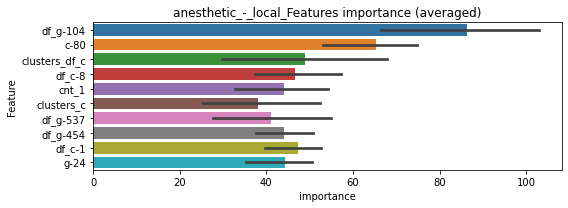

len(train_index) : 3857
len(valid_index) : 3858
================================= fold 1/2 anesthetic_-_local=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0305585	valid_1's binary_logloss: 0.0678356
[200]	training's binary_logloss: 0.00660797	valid_1's binary_logloss: 0.0415125
[300]	training's binary_logloss: 0.00205075	valid_1's binary_logloss: 0.0343167
Early stopping, best iteration is:
[387]	training's binary_logloss: 0.000983975	valid_1's binary_logloss: 0.0322173


len(train_index) : 3858
len(valid_index) : 3857
================================= fold 2/2 anesthetic_-_local=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0330222	valid_1's binary_logloss: 0.0641529
[200]	training's binary_logloss: 0.00732874	valid_1's binary_logloss: 0.0346335
[300]	training's binary_logloss: 0.00215677	valid_1's binary_logloss: 0.0275489
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00187313	valid_1's binary_logloss: 0.0271283


anesthetic_-_local logloss: 0.029673148798280074
angiogenesis_inhibitor, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0415289	valid_1's binary_logloss: 0.0650602
[200]	training's binary_logloss: 0.00717197	valid_1's binary_logloss: 0.0196415
[300]	training's binary_logloss: 0.00191619	valid_1's binary_logloss: 0.00904102
[400]	training's binary_logloss: 0.000884153	valid_1's binary_logloss: 0.0063208
[500]	training's binary_logloss: 0.000565488	valid_1's binary_logloss: 0.00496922
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.000516383	valid_1's binary_logloss: 0.00477389
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0432104	valid_1's binary_logloss: 0.0644663
[200]	training's binary_logloss: 0.00721694	valid_1's binary_logloss: 0.0190966
[300]	training's binary_logloss: 0.00191314	valid_1's binary_logloss: 0.0096296
[400]	training's binary_logloss: 0.000896564	valid_1's binary_logloss: 0.00689376
[500]	training's binary_logloss: 0.00

1 / 3 AUC score:1.000
y_Threshold: 0.0042304, Threshold: 0.0064219, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00151, Num_p_label: 80.0, conf_0:0.00578, conf_1:0.00706
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0064219
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_2: 0.0164219
Num_p_label: 8.0, Expected: 6.0, Adj_threshold_3: 0.0264219
threshold: 0.0264219, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0409443	valid_1's binary_logloss: 0.0620308
[200]	training's binary_logloss: 0.00678566	valid_1's binary_logloss: 0.0178343
[300]	training's binary_logloss: 0.00186186	valid_1's binary_logloss: 0.00844918
[400]	training's binary_logloss: 0.00089453	valid_1's binary_logloss: 0.00631038
[500]	training's binary_logloss: 0.000565039	valid_1's binary_logloss: 0.00497093
[600]	training's binary_logloss: 0.000478822	valid_1's binary_logloss: 0.00467963
Early stopping, best iteration is:
[601]	training's binary_logloss: 0.00047796	valid_1's binary_logloss: 0.00467806
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0405726	valid_1's binary_logloss: 0.0614474
[200]	training's binary_logloss: 0.00647976	valid_1's binary_logloss: 0.0161839
[300]	training's binary_logloss: 0.00180138	valid_1's binary_logloss: 0.00787103
[400]	training's binary_logloss: 0.00

2 / 3 AUC score:1.000
y_Threshold: 0.0834675, Threshold: 0.0264219, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0060271 Vs.target_rate: 0.00151, Num_p_label: 24.0, conf_0:0.02378, conf_1:0.02906
Num_p_label: 24.0, Expected: 6.0, Adj_threshold_1: 0.0264219
Num_p_label: 20.0, Expected: 6.0, Adj_threshold_2: 0.0364219
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_3: 0.0464219
threshold: 0.0464219, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0409443	valid_1's binary_logloss: 0.0620308
[200]	training's binary_logloss: 0.00678566	valid_1's binary_logloss: 0.0178343
[300]	training's binary_logloss: 0.00186186	valid_1's binary_logloss: 0.00844918
[400]	training's binary_logloss: 0.00089453	valid_1's binary_logloss: 0.00631038
[500]	training's binary_logloss: 0.000565039	valid_1's binary_logloss: 0.00497093
[600]	training's binary_logloss: 0.000478822	valid_1's binary_logloss: 0.00467963
Early stopping, best iteration is:
[601]	training's binary_logloss: 0.00047796	valid_1's binary_logloss: 0.00467806
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0405726	valid_1's binary_logloss: 0.0614474
[200]	training's binary_logloss: 0.00647976	valid_1's binary_logloss: 0.0161839
[300]	training's binary_logloss: 0.00180138	valid_1's binary_logloss: 0.00787103
[400]	training's binary_logloss: 0.00

3 / 3 AUC score:1.000
y_Threshold: 0.0834675, Threshold: 0.0464219, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0027624 Vs.target_rate: 0.00151, Num_p_label: 11.0, conf_0:0.04178, conf_1:0.05106
threshold: 0.0464219, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 667.0/7789, y_label_rate: 0.0856336


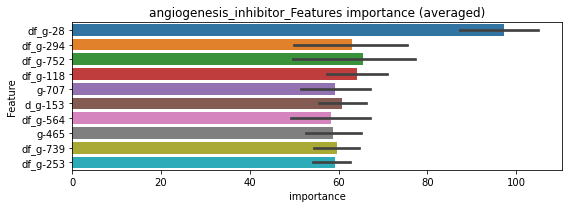

len(train_index) : 3894
len(valid_index) : 3895
================================= fold 1/2 angiogenesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0237925	valid_1's binary_logloss: 0.0397723
[200]	training's binary_logloss: 0.00383848	valid_1's binary_logloss: 0.0152976
[300]	training's binary_logloss: 0.00102289	valid_1's binary_logloss: 0.0113207
Early stopping, best iteration is:
[339]	training's binary_logloss: 0.000708475	valid_1's binary_logloss: 0.0109664


len(train_index) : 3895
len(valid_index) : 3894
================================= fold 2/2 angiogenesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0231014	valid_1's binary_logloss: 0.0427434
[200]	training's binary_logloss: 0.00379551	valid_1's binary_logloss: 0.017109
[300]	training's binary_logloss: 0.00102491	valid_1's binary_logloss: 0.0123002
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.000742422	valid_1's binary_logloss: 0.0117588


angiogenesis_inhibitor logloss: 0.011362581442800791
angiotensin_receptor_antagonist, len(trt): 37, len(othr): 3283, target_rate: 0.0015537 → Adj_target_rate: 0.0018079


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0389556	valid_1's binary_logloss: 0.0635789
[200]	training's binary_logloss: 0.00618423	valid_1's binary_logloss: 0.0216451
[300]	training's binary_logloss: 0.00175919	valid_1's binary_logloss: 0.0139044
[400]	training's binary_logloss: 0.000841928	valid_1's binary_logloss: 0.0115011
[500]	training's binary_logloss: 0.000557703	valid_1's binary_logloss: 0.010623
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.00054033	valid_1's binary_logloss: 0.0105537
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0412729	valid_1's binary_logloss: 0.0684996
[200]	training's binary_logloss: 0.00681953	valid_1's binary_logloss: 0.0203154
[300]	training's binary_logloss: 0.00187403	valid_1's binary_logloss: 0.00942662
[400]	training's binary_logloss: 0.000870216	valid_1's binary_logloss: 0.00613733
[500]	training's binary_logloss: 0.000562

1 / 3 AUC score:1.000
y_Threshold: 0.0045024, Threshold: 0.0068621, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00155, Num_p_label: 80.0, conf_0:0.00618, conf_1:0.00755
Num_p_label: 80.0, Expected: 6.2, Adj_threshold_1: 0.0068621
Num_p_label: 17.0, Expected: 6.2, Adj_threshold_2: 0.0168621
Num_p_label: 3.0, Expected: 6.2, Adj_threshold_3: 0.0268621
threshold: 0.0268621, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0384196	valid_1's binary_logloss: 0.0617348
[200]	training's binary_logloss: 0.00595799	valid_1's binary_logloss: 0.0202041
[300]	training's binary_logloss: 0.00170441	valid_1's binary_logloss: 0.0126163
[400]	training's binary_logloss: 0.000821168	valid_1's binary_logloss: 0.0105174
Early stopping, best iteration is:
[449]	training's binary_logloss: 0.000650627	valid_1's binary_logloss: 0.0100796
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0408894	valid_1's binary_logloss: 0.0656974
[200]	training's binary_logloss: 0.00667079	valid_1's binary_logloss: 0.0182242
[300]	training's binary_logloss: 0.00185838	valid_1's binary_logloss: 0.00807765
[400]	training's binary_logloss: 0.000873996	valid_1's binary_logloss: 0.00517758
[500]	training's binary_logloss: 0.000571214	valid_1's binary_logloss: 0.00410121
Early stopping, best iteration is:
[51

2 / 3 AUC score:1.000
y_Threshold: 0.0349109, Threshold: 0.0268621, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0065294 Vs.target_rate: 0.00155, Num_p_label: 26.0, conf_0:0.02418, conf_1:0.02955
Num_p_label: 26.0, Expected: 6.2, Adj_threshold_1: 0.0268621
Num_p_label: 17.0, Expected: 6.2, Adj_threshold_2: 0.0368621
Num_p_label: 11.0, Expected: 6.2, Adj_threshold_3: 0.0468621
threshold: 0.0468621, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0384196	valid_1's binary_logloss: 0.0617348
[200]	training's binary_logloss: 0.00595799	valid_1's binary_logloss: 0.0202041
[300]	training's binary_logloss: 0.00170441	valid_1's binary_logloss: 0.0126163
[400]	training's binary_logloss: 0.000821168	valid_1's binary_logloss: 0.0105174
Early stopping, best iteration is:
[449]	training's binary_logloss: 0.000650627	valid_1's binary_logloss: 0.0100796
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0408894	valid_1's binary_logloss: 0.0656974
[200]	training's binary_logloss: 0.00667079	valid_1's binary_logloss: 0.0182242
[300]	training's binary_logloss: 0.00185838	valid_1's binary_logloss: 0.00807765
[400]	training's binary_logloss: 0.000873996	valid_1's binary_logloss: 0.00517758
[500]	training's binary_logloss: 0.000571214	valid_1's binary_logloss: 0.00410121
Early stopping, best iteration is:
[51

3 / 3 AUC score:1.000
y_Threshold: 0.0349109, Threshold: 0.0468621, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0027624 Vs.target_rate: 0.00155, Num_p_label: 11.0, conf_0:0.04218, conf_1:0.05155
threshold: 0.0468621, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 667.0/7789, y_label_rate: 0.0856336


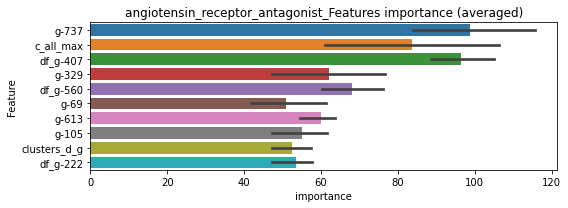

len(train_index) : 3894
len(valid_index) : 3895
================================= fold 1/2 angiotensin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0226996	valid_1's binary_logloss: 0.0396186
[200]	training's binary_logloss: 0.00359253	valid_1's binary_logloss: 0.015824
[300]	training's binary_logloss: 0.000982904	valid_1's binary_logloss: 0.0120811
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.000710915	valid_1's binary_logloss: 0.0117217


len(train_index) : 3895
len(valid_index) : 3894
================================= fold 2/2 angiotensin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0232894	valid_1's binary_logloss: 0.0342985
[200]	training's binary_logloss: 0.00414393	valid_1's binary_logloss: 0.0115262
[300]	training's binary_logloss: 0.00110625	valid_1's binary_logloss: 0.00713397
[400]	training's binary_logloss: 0.00050562	valid_1's binary_logloss: 0.00600734
Early stopping, best iteration is:
[429]	training's binary_logloss: 0.000431005	valid_1's binary_logloss: 0.00587485


angiotensin_receptor_antagonist logloss: 0.00879866308178601
anti-inflammatory, len(trt): 73, len(othr): 3277, target_rate: 0.0030654 → Adj_target_rate: 0.0032212


neg labels: 3289 → selected neg labels: 3277


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0517968	valid_1's binary_logloss: 0.102488
[200]	training's binary_logloss: 0.0109262	valid_1's binary_logloss: 0.0484433
[300]	training's binary_logloss: 0.00329636	valid_1's binary_logloss: 0.0340677
[400]	training's binary_logloss: 0.00148487	valid_1's binary_logloss: 0.0287969
Early stopping, best iteration is:
[418]	training's binary_logloss: 0.00133739	valid_1's binary_logloss: 0.0285301
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0569472	valid_1's binary_logloss: 0.0964696
[200]	training's binary_logloss: 0.0121336	valid_1's binary_logloss: 0.0384884
[300]	training's binary_logloss: 0.00349233	valid_1's binary_logloss: 0.0206063
[400]	training's binary_logloss: 0.00157482	valid_1's binary_logloss: 0.0149945
Early stopping, best iteration is:
[457]	training's binary_logloss: 0.0011513	valid_1's binary_logloss: 0.0135724


1 / 3 AUC score:1.000
y_Threshold: 0.0119334, Threshold: 0.0182859, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 136 → Positive_corect_labels: 653/3796
p_label_rate: 0.0200904 Vs.target_rate: 0.00307, Num_p_label: 80.0, conf_0:0.01646, conf_1:0.02011
Num_p_label: 80.0, Expected: 12.2, Adj_threshold_1: 0.0182859
Num_p_label: 51.0, Expected: 12.2, Adj_threshold_2: 0.0282859
Num_p_label: 30.0, Expected: 12.2, Adj_threshold_3: 0.0382859
Num_p_label: 24.0, Expected: 12.2, Adj_threshold_4: 0.0482859
threshold: 0.0482859, positive_p_label: 24.0/3982, p_label_rate: 0.0060271
positive_y_label: 653.0/3796, y_label_rate: 0.1720232
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0503303	valid_1's binary_logloss: 0.112415
[200]	training's binary_logloss: 0.0101349	valid_1's binary_logloss: 0.0632757
[300]	training's binary_logloss: 0.00303737	valid_1's binary_logloss: 0.0499849
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00196102	valid_1's binary_logloss: 0.0477628
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0537074	valid_1's binary_logloss: 0.103833
[200]	training's binary_logloss: 0.0113797	valid_1's binary_logloss: 0.0501453
[300]	training's binary_logloss: 0.00328628	valid_1's binary_logloss: 0.0349294
[400]	training's binary_logloss: 0.00149114	valid_1's binary_logloss: 0.0308308
Early stopping, best iteration is:
[452]	training's binary_logloss: 0.00112646	valid_1's binary_logloss: 0.0298799


2 / 3 AUC score:1.000
y_Threshold: 0.0358102, Threshold: 0.0482859, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 16 → Positive_corect_labels: 645.0/3780
p_label_rate: 0.0150678 Vs.target_rate: 0.00307, Num_p_label: 60.0, conf_0:0.04346, conf_1:0.05311
Num_p_label: 60.0, Expected: 12.2, Adj_threshold_1: 0.0482859
Num_p_label: 48.0, Expected: 12.2, Adj_threshold_2: 0.0582859
Num_p_label: 37.0, Expected: 12.2, Adj_threshold_3: 0.0682859
Num_p_label: 34.0, Expected: 12.2, Adj_threshold_4: 0.0782859
Num_p_label: 29.0, Expected: 12.2, Adj_threshold_5: 0.0882859
Num_p_label: 26.0, Expected: 12.2, Adj_threshold_6: 0.0982859
Num_p_label: 24.0, Expected: 12.2, Adj_threshold_7: 0.1082859
threshold: 0.1082859, positive_p_label: 24.0/3982, p_label_rate: 0.0060271
positive_y_label: 645.0/3780, y_label_rate: 0.1706349
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0478093	valid_1's binary_logloss: 0.116113
[200]	training's binary_logloss: 0.0093292	valid_1's binary_logloss: 0.0659353
[300]	training's binary_logloss: 0.00277462	valid_1's binary_logloss: 0.0525229
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.00221058	valid_1's binary_logloss: 0.0520209
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0530027	valid_1's binary_logloss: 0.101971
[200]	training's binary_logloss: 0.0107072	valid_1's binary_logloss: 0.0512018
[300]	training's binary_logloss: 0.00311159	valid_1's binary_logloss: 0.0384234
Early stopping, best iteration is:
[366]	training's binary_logloss: 0.00178331	valid_1's binary_logloss: 0.0358021


3 / 3 AUC score:0.999
y_Threshold: 0.0380448, Threshold: 0.1082859, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 16 → Positive_corect_labels: 637.0/3764
p_label_rate: 0.0047715 Vs.target_rate: 0.00307, Num_p_label: 19.0, conf_0:0.09746, conf_1:0.11911
threshold: 0.1082859, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 656.0/7746, y_label_rate: 0.0846889


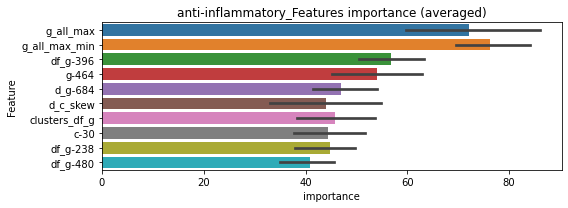

len(train_index) : 3873
len(valid_index) : 3873
================================= fold 1/2 anti-inflammatory=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0266738	valid_1's binary_logloss: 0.0538132
[200]	training's binary_logloss: 0.00527579	valid_1's binary_logloss: 0.0269576
[300]	training's binary_logloss: 0.00154578	valid_1's binary_logloss: 0.0202602
[400]	training's binary_logloss: 0.000704906	valid_1's binary_logloss: 0.017894
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000511545	valid_1's binary_logloss: 0.0171939


len(train_index) : 3873
len(valid_index) : 3873
================================= fold 2/2 anti-inflammatory=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0304837	valid_1's binary_logloss: 0.0589927
[200]	training's binary_logloss: 0.00614259	valid_1's binary_logloss: 0.0286058
[300]	training's binary_logloss: 0.00175562	valid_1's binary_logloss: 0.020881
[400]	training's binary_logloss: 0.00077705	valid_1's binary_logloss: 0.0188882
[500]	training's binary_logloss: 0.000468666	valid_1's binary_logloss: 0.0178797
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.000426132	valid_1's binary_logloss: 0.0177132


anti-inflammatory logloss: 0.01745358174262061
antiarrhythmic, len(trt): 24, len(othr): 3285, target_rate: 0.0010078 → Adj_target_rate: 0.0012513


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0286551	valid_1's binary_logloss: 0.0490425
[200]	training's binary_logloss: 0.00372037	valid_1's binary_logloss: 0.0157997
[300]	training's binary_logloss: 0.00105775	valid_1's binary_logloss: 0.00876104
[400]	training's binary_logloss: 0.000529544	valid_1's binary_logloss: 0.00655884
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000412076	valid_1's binary_logloss: 0.00614305
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0289858	valid_1's binary_logloss: 0.0391396
[200]	training's binary_logloss: 0.00387488	valid_1's binary_logloss: 0.00750221
[300]	training's binary_logloss: 0.00110589	valid_1's binary_logloss: 0.00308058
[400]	training's binary_logloss: 0.000553025	valid_1's binary_logloss: 0.0020298
[500]	training's binary_logloss: 0.000413729	valid_1's binary_logloss: 0.00180797
Early stopping, best iteration is:


1 / 3 AUC score:1.000
y_Threshold: 0.0022738, Threshold: 0.0359681, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00101, Num_p_label: 80.0, conf_0:0.03237, conf_1:0.03956
Num_p_label: 80.0, Expected: 4.0, Adj_threshold_1: 0.0359681
Num_p_label: 68.0, Expected: 4.0, Adj_threshold_2: 0.0459681
Num_p_label: 57.0, Expected: 4.0, Adj_threshold_3: 0.0559681
Num_p_label: 50.0, Expected: 4.0, Adj_threshold_4: 0.0659681
Num_p_label: 44.0, Expected: 4.0, Adj_threshold_5: 0.0759681
Num_p_label: 39.0, Expected: 4.0, Adj_threshold_6: 0.0859681
Num_p_label: 35.0, Expected: 4.0, Adj_threshold_7: 0.0959681
Num_p_label: 32.0, Expected: 4.0, Adj_threshold_8: 0.1059681
Num_p_label: 29.0, Expected: 4.0, Adj_threshold_9: 0.1159681
Num_p_label: 25.0, Expected: 4.0, Adj_threshold_10: 0.1259681
threshold: 0.1359681, positive_p_label: 23.0/3982, p_label_rate: 0.0057760
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0270796	valid_1's binary_logloss: 0.0452647
[200]	training's binary_logloss: 0.00344441	valid_1's binary_logloss: 0.0137512
[300]	training's binary_logloss: 0.000982095	valid_1's binary_logloss: 0.0079495
[400]	training's binary_logloss: 0.000511551	valid_1's binary_logloss: 0.00619103
[500]	training's binary_logloss: 0.000385756	valid_1's binary_logloss: 0.00559897
Early stopping, best iteration is:
[504]	training's binary_logloss: 0.000384025	valid_1's binary_logloss: 0.00558524
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0281043	valid_1's binary_logloss: 0.0378214
[200]	training's binary_logloss: 0.00362949	valid_1's binary_logloss: 0.00675605
[300]	training's binary_logloss: 0.00101494	valid_1's binary_logloss: 0.00243376
[400]	training's binary_logloss: 0.000518422	valid_1's binary_logloss: 0.00149189
[500]	training's binary_logloss: 0

2 / 3 AUC score:1.000
y_Threshold: 0.1143847, Threshold: 0.1359681, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0291311 Vs.target_rate: 0.00101, Num_p_label: 116.0, conf_0:0.12237, conf_1:0.14956
Num_p_label: 116.0, Expected: 4.0, Adj_threshold_1: 0.1359681
Num_p_label: 116.0, Expected: 4.0, Adj_threshold_2: 0.1459681
Num_p_label: 115.0, Expected: 4.0, Adj_threshold_3: 0.1559681
Num_p_label: 114.0, Expected: 4.0, Adj_threshold_4: 0.1659681
Num_p_label: 111.0, Expected: 4.0, Adj_threshold_5: 0.1759681
Num_p_label: 107.0, Expected: 4.0, Adj_threshold_6: 0.1859681
Num_p_label: 106.0, Expected: 4.0, Adj_threshold_7: 0.1959681
Num_p_label: 106.0, Expected: 4.0, Adj_threshold_8: 0.2059681
Num_p_label: 106.0, Expected: 4.0, Adj_threshold_9: 0.2159681
Num_p_label: 104.0, Expected: 4.0, Adj_threshold_10: 0.2259681
threshold: 0.2359681, positive_p_label: 103.0/3982, p_label_rate: 0.0258664
positive_y_label: 657.0/3810, y_label_rate: 0.1724

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0270796	valid_1's binary_logloss: 0.0452647
[200]	training's binary_logloss: 0.00344441	valid_1's binary_logloss: 0.0137512
[300]	training's binary_logloss: 0.000982095	valid_1's binary_logloss: 0.0079495
[400]	training's binary_logloss: 0.000511551	valid_1's binary_logloss: 0.00619103
[500]	training's binary_logloss: 0.000385756	valid_1's binary_logloss: 0.00559897
Early stopping, best iteration is:
[504]	training's binary_logloss: 0.000384025	valid_1's binary_logloss: 0.00558524
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0281043	valid_1's binary_logloss: 0.0378214
[200]	training's binary_logloss: 0.00362949	valid_1's binary_logloss: 0.00675605
[300]	training's binary_logloss: 0.00101494	valid_1's binary_logloss: 0.00243376
[400]	training's binary_logloss: 0.000518422	valid_1's binary_logloss: 0.00149189
[500]	training's binary_logloss: 0

3 / 3 AUC score:1.000
y_Threshold: 0.1143847, Threshold: 0.2359681, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0258664 Vs.target_rate: 0.00101, Num_p_label: 103.0, conf_0:0.21237, conf_1:0.25956
Num_p_label: 103.0, Expected: 4.0, Adj_threshold_1: 0.2359681
Num_p_label: 103.0, Expected: 4.0, Adj_threshold_2: 0.2459681
Num_p_label: 100.0, Expected: 4.0, Adj_threshold_3: 0.2559681
Num_p_label: 100.0, Expected: 4.0, Adj_threshold_4: 0.2659681
Num_p_label: 98.0, Expected: 4.0, Adj_threshold_5: 0.2759681
Num_p_label: 96.0, Expected: 4.0, Adj_threshold_6: 0.2859681
Num_p_label: 96.0, Expected: 4.0, Adj_threshold_7: 0.2959681
Num_p_label: 96.0, Expected: 4.0, Adj_threshold_8: 0.3059681
Num_p_label: 94.0, Expected: 4.0, Adj_threshold_9: 0.3159681
Num_p_label: 90.0, Expected: 4.0, Adj_threshold_10: 0.3259681
threshold: 0.3359681, positive_p_label: 87.0/3982, p_label_rate: 0.0218483
positive_y_label: 744.0/7792, y_label_rate: 0.0954825


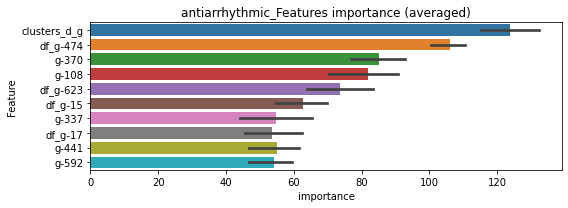

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 antiarrhythmic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0191758	valid_1's binary_logloss: 0.0281649
[200]	training's binary_logloss: 0.0027321	valid_1's binary_logloss: 0.0102575
[300]	training's binary_logloss: 0.000770405	valid_1's binary_logloss: 0.00760745
[400]	training's binary_logloss: 0.000379964	valid_1's binary_logloss: 0.00697105
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.000390464	valid_1's binary_logloss: 0.00696181


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 antiarrhythmic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0184193	valid_1's binary_logloss: 0.0296448
[200]	training's binary_logloss: 0.00257417	valid_1's binary_logloss: 0.0107789
[300]	training's binary_logloss: 0.000710441	valid_1's binary_logloss: 0.00829284
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.000594817	valid_1's binary_logloss: 0.00814602


antiarrhythmic logloss: 0.007553916658793802
antibiotic, len(trt): 43, len(othr): 3281, target_rate: 0.0018057 → Adj_target_rate: 0.0020542


neg labels: 3289 → selected neg labels: 3281


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0389462	valid_1's binary_logloss: 0.0601289
[200]	training's binary_logloss: 0.00654216	valid_1's binary_logloss: 0.0208304
[300]	training's binary_logloss: 0.0018758	valid_1's binary_logloss: 0.013086
[400]	training's binary_logloss: 0.000926699	valid_1's binary_logloss: 0.0114974
Early stopping, best iteration is:
[447]	training's binary_logloss: 0.000733512	valid_1's binary_logloss: 0.0108899
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0415353	valid_1's binary_logloss: 0.0655091
[200]	training's binary_logloss: 0.00713074	valid_1's binary_logloss: 0.0216058
[300]	training's binary_logloss: 0.00202882	valid_1's binary_logloss: 0.0115238
[400]	training's binary_logloss: 0.000961664	valid_1's binary_logloss: 0.00848865
[500]	training's binary_logloss: 0.000620152	valid_1's binary_logloss: 0.00749917
Early stopping, best iteration is:
[545]	

1 / 3 AUC score:1.000
y_Threshold: 0.0046158, Threshold: 0.0103141, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3805
p_label_rate: 0.0200904 Vs.target_rate: 0.00181, Num_p_label: 80.0, conf_0:0.00928, conf_1:0.01135
Num_p_label: 80.0, Expected: 7.2, Adj_threshold_1: 0.0103141
Num_p_label: 25.0, Expected: 7.2, Adj_threshold_2: 0.0203141
Num_p_label: 11.0, Expected: 7.2, Adj_threshold_3: 0.0303141
threshold: 0.0303141, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 656.0/3805, y_label_rate: 0.1724047
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0381656	valid_1's binary_logloss: 0.0600413
[200]	training's binary_logloss: 0.00602413	valid_1's binary_logloss: 0.0204692
[300]	training's binary_logloss: 0.00177839	valid_1's binary_logloss: 0.0131543
[400]	training's binary_logloss: 0.000893749	valid_1's binary_logloss: 0.0110112
Early stopping, best iteration is:
[437]	training's binary_logloss: 0.00074278	valid_1's binary_logloss: 0.010698
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0413141	valid_1's binary_logloss: 0.0665113
[200]	training's binary_logloss: 0.00700264	valid_1's binary_logloss: 0.0222019
[300]	training's binary_logloss: 0.00197828	valid_1's binary_logloss: 0.0119798
[400]	training's binary_logloss: 0.000934375	valid_1's binary_logloss: 0.00889334
[500]	training's binary_logloss: 0.000608245	valid_1's binary_logloss: 0.00772147
Early stopping, best iteration is:
[520]	

2 / 3 AUC score:1.000
y_Threshold: 0.0304413, Threshold: 0.0303141, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3803
p_label_rate: 0.0102963 Vs.target_rate: 0.00181, Num_p_label: 41.0, conf_0:0.02728, conf_1:0.03335
Num_p_label: 41.0, Expected: 7.2, Adj_threshold_1: 0.0303141
Num_p_label: 33.0, Expected: 7.2, Adj_threshold_2: 0.0403141
Num_p_label: 25.0, Expected: 7.2, Adj_threshold_3: 0.0503141
Num_p_label: 21.0, Expected: 7.2, Adj_threshold_4: 0.0603141
Num_p_label: 18.0, Expected: 7.2, Adj_threshold_5: 0.0703141
Num_p_label: 13.0, Expected: 7.2, Adj_threshold_6: 0.0803141
threshold: 0.0803141, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 655.0/3803, y_label_rate: 0.1722324
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0389006	valid_1's binary_logloss: 0.0607429
[200]	training's binary_logloss: 0.00627728	valid_1's binary_logloss: 0.0184366
[300]	training's binary_logloss: 0.00182465	valid_1's binary_logloss: 0.00976817
[400]	training's binary_logloss: 0.00089212	valid_1's binary_logloss: 0.00728151
[500]	training's binary_logloss: 0.000595199	valid_1's binary_logloss: 0.00615991
Early stopping, best iteration is:
[547]	training's binary_logloss: 0.000536481	valid_1's binary_logloss: 0.00589162
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0414984	valid_1's binary_logloss: 0.0667204
[200]	training's binary_logloss: 0.00699916	valid_1's binary_logloss: 0.0221295
[300]	training's binary_logloss: 0.00196999	valid_1's binary_logloss: 0.0127902
[400]	training's binary_logloss: 0.000929739	valid_1's binary_logloss: 0.00987699
[500]	training's binary_logloss: 0.00

3 / 3 AUC score:1.000
y_Threshold: 0.0284364, Threshold: 0.0803141, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3803
p_label_rate: 0.0022602 Vs.target_rate: 0.00181, Num_p_label: 9.0, conf_0:0.07228, conf_1:0.08835
threshold: 0.0803141, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 664.0/7785, y_label_rate: 0.0852922


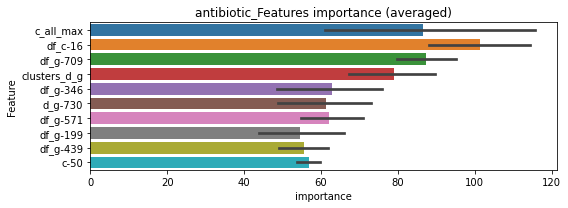

len(train_index) : 3892
len(valid_index) : 3893
================================= fold 1/2 antibiotic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0226211	valid_1's binary_logloss: 0.0403343
[200]	training's binary_logloss: 0.00367272	valid_1's binary_logloss: 0.0171982
[300]	training's binary_logloss: 0.00103321	valid_1's binary_logloss: 0.0133416
[400]	training's binary_logloss: 0.000483223	valid_1's binary_logloss: 0.0126679
Early stopping, best iteration is:
[394]	training's binary_logloss: 0.000499847	valid_1's binary_logloss: 0.0126166


len(train_index) : 3893
len(valid_index) : 3892
================================= fold 2/2 antibiotic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0214849	valid_1's binary_logloss: 0.0414133
[200]	training's binary_logloss: 0.00363897	valid_1's binary_logloss: 0.0179935
[300]	training's binary_logloss: 0.00102314	valid_1's binary_logloss: 0.0130797
[400]	training's binary_logloss: 0.000488246	valid_1's binary_logloss: 0.0115656
[500]	training's binary_logloss: 0.000315949	valid_1's binary_logloss: 0.0108349
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00029424	valid_1's binary_logloss: 0.0107562


antibiotic logloss: 0.01168650835821815
anticonvulsant, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0252788	valid_1's binary_logloss: 0.031365
[200]	training's binary_logloss: 0.00309289	valid_1's binary_logloss: 0.00536806
[300]	training's binary_logloss: 0.000851761	valid_1's binary_logloss: 0.0019804
[400]	training's binary_logloss: 0.000449402	valid_1's binary_logloss: 0.00125527
[500]	training's binary_logloss: 0.000354856	valid_1's binary_logloss: 0.00108776
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.00035028	valid_1's binary_logloss: 0.00108395
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0248974	valid_1's binary_logloss: 0.0367189
[200]	training's binary_logloss: 0.00304412	valid_1's binary_logloss: 0.00848744
[300]	training's binary_logloss: 0.000865697	valid_1's binary_logloss: 0.00522267
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.000865697	valid_1's binary_logloss: 0.00522267

1 / 3 AUC score:1.000
y_Threshold: 0.0031475, Threshold: 0.0049322, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076, Num_p_label: 80.0, conf_0:0.00444, conf_1:0.00543
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0049322
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_2: 0.0149322
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_3: 0.0249322
threshold: 0.0249322, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0239212	valid_1's binary_logloss: 0.0329808
[200]	training's binary_logloss: 0.00282767	valid_1's binary_logloss: 0.00745947
[300]	training's binary_logloss: 0.000803137	valid_1's binary_logloss: 0.00339317
[400]	training's binary_logloss: 0.000439589	valid_1's binary_logloss: 0.00233552
[500]	training's binary_logloss: 0.000353065	valid_1's binary_logloss: 0.00205279
Early stopping, best iteration is:
[524]	training's binary_logloss: 0.000349799	valid_1's binary_logloss: 0.00204067
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.024364	valid_1's binary_logloss: 0.0340311
[200]	training's binary_logloss: 0.00296228	valid_1's binary_logloss: 0.00845996
[300]	training's binary_logloss: 0.000832892	valid_1's binary_logloss: 0.0041644
[400]	training's binary_logloss: 0.000439165	valid_1's binary_logloss: 0.00335079
Early stopping, best iteration is

2 / 3 AUC score:1.000
y_Threshold: 0.0393530, Threshold: 0.0249322, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0040181 Vs.target_rate: 0.00076, Num_p_label: 16.0, conf_0:0.02244, conf_1:0.02743
Num_p_label: 16.0, Expected: 3.0, Adj_threshold_1: 0.0249322
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_2: 0.0349322
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_3: 0.0449322
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_4: 0.0549322
threshold: 0.0549322, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0239212	valid_1's binary_logloss: 0.0329808
[200]	training's binary_logloss: 0.00282767	valid_1's binary_logloss: 0.00745947
[300]	training's binary_logloss: 0.000803137	valid_1's binary_logloss: 0.00339317
[400]	training's binary_logloss: 0.000439589	valid_1's binary_logloss: 0.00233552
[500]	training's binary_logloss: 0.000353065	valid_1's binary_logloss: 0.00205279
Early stopping, best iteration is:
[524]	training's binary_logloss: 0.000349799	valid_1's binary_logloss: 0.00204067
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.024364	valid_1's binary_logloss: 0.0340311
[200]	training's binary_logloss: 0.00296228	valid_1's binary_logloss: 0.00845996
[300]	training's binary_logloss: 0.000832892	valid_1's binary_logloss: 0.0041644
[400]	training's binary_logloss: 0.000439165	valid_1's binary_logloss: 0.00335079
Early stopping, best iteration is

3 / 3 AUC score:1.000
y_Threshold: 0.0393530, Threshold: 0.0549322, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0015068 Vs.target_rate: 0.00076, Num_p_label: 6.0, conf_0:0.04944, conf_1:0.06043
threshold: 0.0549322, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 663.0/7793, y_label_rate: 0.0850764


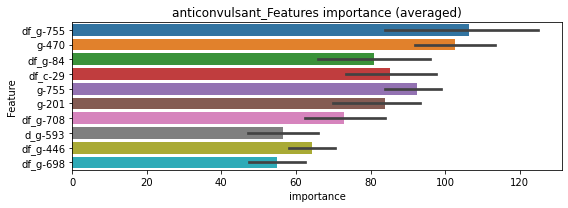

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 anticonvulsant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0138562	valid_1's binary_logloss: 0.0223304
[200]	training's binary_logloss: 0.00164623	valid_1's binary_logloss: 0.00893197
[300]	training's binary_logloss: 0.000442502	valid_1's binary_logloss: 0.00785339
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.000487015	valid_1's binary_logloss: 0.00785231


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 anticonvulsant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0145981	valid_1's binary_logloss: 0.019635
[200]	training's binary_logloss: 0.0018141	valid_1's binary_logloss: 0.00505863
[300]	training's binary_logloss: 0.000487563	valid_1's binary_logloss: 0.00294831
[400]	training's binary_logloss: 0.000246953	valid_1's binary_logloss: 0.00262318
Early stopping, best iteration is:
[416]	training's binary_logloss: 0.000230685	valid_1's binary_logloss: 0.00259165


anticonvulsant logloss: 0.005222316517071422
antifungal, len(trt): 26, len(othr): 3284, target_rate: 0.0010918 → Adj_target_rate: 0.0013394


neg labels: 3289 → selected neg labels: 3284


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0285554	valid_1's binary_logloss: 0.0460827
[200]	training's binary_logloss: 0.00390914	valid_1's binary_logloss: 0.0133974
[300]	training's binary_logloss: 0.00111523	valid_1's binary_logloss: 0.00704799
[400]	training's binary_logloss: 0.00056557	valid_1's binary_logloss: 0.00521414
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.000416552	valid_1's binary_logloss: 0.00468507
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0306809	valid_1's binary_logloss: 0.0424329
[200]	training's binary_logloss: 0.00419117	valid_1's binary_logloss: 0.00947915
[300]	training's binary_logloss: 0.00116462	valid_1's binary_logloss: 0.00425562
[400]	training's binary_logloss: 0.000579253	valid_1's binary_logloss: 0.00287629
[500]	training's binary_logloss: 0.000415019	valid_1's binary_logloss: 0.00247079
Early stopping, best iteration is:


1 / 3 AUC score:1.000
y_Threshold: 0.0020163, Threshold: 0.0034603, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00109, Num_p_label: 80.0, conf_0:0.00311, conf_1:0.00381
Num_p_label: 80.0, Expected: 4.3, Adj_threshold_1: 0.0034603
Num_p_label: 8.0, Expected: 4.3, Adj_threshold_2: 0.0134603
threshold: 0.0134603, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0293731	valid_1's binary_logloss: 0.045967
[200]	training's binary_logloss: 0.00391284	valid_1's binary_logloss: 0.0125064
[300]	training's binary_logloss: 0.00110668	valid_1's binary_logloss: 0.00668029
[400]	training's binary_logloss: 0.000562728	valid_1's binary_logloss: 0.00507548
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.000422477	valid_1's binary_logloss: 0.00467128
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0304078	valid_1's binary_logloss: 0.0416992
[200]	training's binary_logloss: 0.00396269	valid_1's binary_logloss: 0.00911568
[300]	training's binary_logloss: 0.00112194	valid_1's binary_logloss: 0.00420939
[400]	training's binary_logloss: 0.000568715	valid_1's binary_logloss: 0.0030548
[500]	training's binary_logloss: 0.000411402	valid_1's binary_logloss: 0.0026051
Early stopping, best iteration is:
[5

2 / 3 AUC score:1.000
y_Threshold: 0.0316994, Threshold: 0.0134603, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0037670 Vs.target_rate: 0.00109, Num_p_label: 15.0, conf_0:0.01211, conf_1:0.01481
Num_p_label: 15.0, Expected: 4.3, Adj_threshold_1: 0.0134603
Num_p_label: 7.0, Expected: 4.3, Adj_threshold_2: 0.0234603
threshold: 0.0234603, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0293731	valid_1's binary_logloss: 0.045967
[200]	training's binary_logloss: 0.00391284	valid_1's binary_logloss: 0.0125064
[300]	training's binary_logloss: 0.00110668	valid_1's binary_logloss: 0.00668029
[400]	training's binary_logloss: 0.000562728	valid_1's binary_logloss: 0.00507548
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.000422477	valid_1's binary_logloss: 0.00467128
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0304078	valid_1's binary_logloss: 0.0416992
[200]	training's binary_logloss: 0.00396269	valid_1's binary_logloss: 0.00911568
[300]	training's binary_logloss: 0.00112194	valid_1's binary_logloss: 0.00420939
[400]	training's binary_logloss: 0.000568715	valid_1's binary_logloss: 0.0030548
[500]	training's binary_logloss: 0.000411402	valid_1's binary_logloss: 0.0026051
Early stopping, best iteration is:
[5

3 / 3 AUC score:1.000
y_Threshold: 0.0316994, Threshold: 0.0234603, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0017579 Vs.target_rate: 0.00109, Num_p_label: 7.0, conf_0:0.02111, conf_1:0.02581
threshold: 0.0234603, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 663.0/7790, y_label_rate: 0.0851091


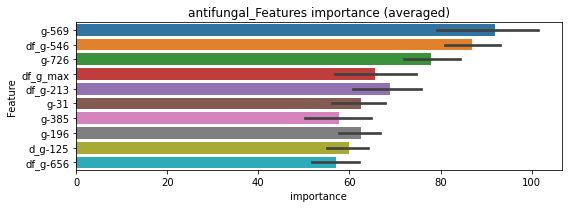

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 antifungal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155164	valid_1's binary_logloss: 0.0263019
[200]	training's binary_logloss: 0.0020853	valid_1's binary_logloss: 0.00957858
[300]	training's binary_logloss: 0.000584315	valid_1's binary_logloss: 0.00744278
Early stopping, best iteration is:
[334]	training's binary_logloss: 0.000440089	valid_1's binary_logloss: 0.00727524


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 antifungal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161862	valid_1's binary_logloss: 0.0280017
[200]	training's binary_logloss: 0.00216792	valid_1's binary_logloss: 0.010625
[300]	training's binary_logloss: 0.000607189	valid_1's binary_logloss: 0.00739486
[400]	training's binary_logloss: 0.000299858	valid_1's binary_logloss: 0.00664937
[500]	training's binary_logloss: 0.00021342	valid_1's binary_logloss: 0.00645768
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.000216225	valid_1's binary_logloss: 0.00645173


antifungal logloss: 0.006863482377564414
antihistamine, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0234988	valid_1's binary_logloss: 0.0301431
[200]	training's binary_logloss: 0.00279126	valid_1's binary_logloss: 0.00555833
[300]	training's binary_logloss: 0.000791862	valid_1's binary_logloss: 0.00234815
[400]	training's binary_logloss: 0.000426821	valid_1's binary_logloss: 0.00164124
[500]	training's binary_logloss: 0.000334145	valid_1's binary_logloss: 0.00139444
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.000331302	valid_1's binary_logloss: 0.00138996
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0236401	valid_1's binary_logloss: 0.0321468
[200]	training's binary_logloss: 0.00283534	valid_1's binary_logloss: 0.00666365
[300]	training's binary_logloss: 0.00081161	valid_1's binary_logloss: 0.00299921
[400]	training's binary_logloss: 0.000433503	valid_1's binary_logloss: 0.00213809
[500]	training's binary_logloss:

1 / 3 AUC score:1.000
y_Threshold: 0.0015518, Threshold: 0.0022299, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076, Num_p_label: 80.0, conf_0:0.00201, conf_1:0.00245
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0022299
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_2: 0.0122299
threshold: 0.0122299, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230266	valid_1's binary_logloss: 0.0289785
[200]	training's binary_logloss: 0.00271438	valid_1's binary_logloss: 0.00559692
[300]	training's binary_logloss: 0.000786708	valid_1's binary_logloss: 0.00261747
[400]	training's binary_logloss: 0.000423682	valid_1's binary_logloss: 0.00189028
[500]	training's binary_logloss: 0.000337898	valid_1's binary_logloss: 0.00171596
Early stopping, best iteration is:
[552]	training's binary_logloss: 0.000329627	valid_1's binary_logloss: 0.00170573
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0231204	valid_1's binary_logloss: 0.0307778
[200]	training's binary_logloss: 0.00269089	valid_1's binary_logloss: 0.00602557
[300]	training's binary_logloss: 0.000785807	valid_1's binary_logloss: 0.00284937
[400]	training's binary_logloss: 0.000422766	valid_1's binary_logloss: 0.00195752
Early stopping, best iteration 

2 / 3 AUC score:1.000
y_Threshold: 0.0419953, Threshold: 0.0122299, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0032647 Vs.target_rate: 0.00076, Num_p_label: 13.0, conf_0:0.01101, conf_1:0.01345
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_1: 0.0122299
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_2: 0.0222299
threshold: 0.0222299, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230266	valid_1's binary_logloss: 0.0289785
[200]	training's binary_logloss: 0.00271438	valid_1's binary_logloss: 0.00559692
[300]	training's binary_logloss: 0.000786708	valid_1's binary_logloss: 0.00261747
[400]	training's binary_logloss: 0.000423682	valid_1's binary_logloss: 0.00189028
[500]	training's binary_logloss: 0.000337898	valid_1's binary_logloss: 0.00171596
Early stopping, best iteration is:
[552]	training's binary_logloss: 0.000329627	valid_1's binary_logloss: 0.00170573
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0231204	valid_1's binary_logloss: 0.0307778
[200]	training's binary_logloss: 0.00269089	valid_1's binary_logloss: 0.00602557
[300]	training's binary_logloss: 0.000785807	valid_1's binary_logloss: 0.00284937
[400]	training's binary_logloss: 0.000422766	valid_1's binary_logloss: 0.00195752
Early stopping, best iteration 

3 / 3 AUC score:1.000
y_Threshold: 0.0419953, Threshold: 0.0222299, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0015068 Vs.target_rate: 0.00076, Num_p_label: 6.0, conf_0:0.02001, conf_1:0.02445
threshold: 0.0222299, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 663.0/7793, y_label_rate: 0.0850764


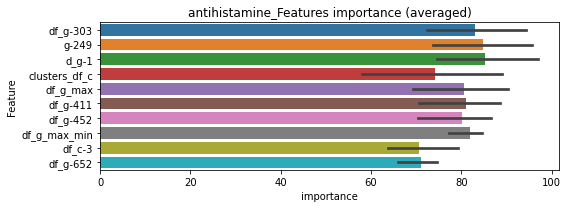

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 antihistamine=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0121956	valid_1's binary_logloss: 0.021272
[200]	training's binary_logloss: 0.00142951	valid_1's binary_logloss: 0.00852058
[300]	training's binary_logloss: 0.000395253	valid_1's binary_logloss: 0.00785009
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.000434269	valid_1's binary_logloss: 0.00782653


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 antihistamine=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0131973	valid_1's binary_logloss: 0.0176248
[200]	training's binary_logloss: 0.00162453	valid_1's binary_logloss: 0.0043314
[300]	training's binary_logloss: 0.000461162	valid_1's binary_logloss: 0.00261101
[400]	training's binary_logloss: 0.000239341	valid_1's binary_logloss: 0.00224784
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.000206723	valid_1's binary_logloss: 0.00220746


antihistamine logloss: 0.005017354416089486
antimalarial, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233703	valid_1's binary_logloss: 0.0288421
[200]	training's binary_logloss: 0.00281541	valid_1's binary_logloss: 0.00498111
[300]	training's binary_logloss: 0.0008103	valid_1's binary_logloss: 0.00190168
[400]	training's binary_logloss: 0.000432252	valid_1's binary_logloss: 0.00124239
[500]	training's binary_logloss: 0.000344253	valid_1's binary_logloss: 0.00108108
Early stopping, best iteration is:
[542]	training's binary_logloss: 0.000337128	valid_1's binary_logloss: 0.00107027
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230777	valid_1's binary_logloss: 0.032984
[200]	training's binary_logloss: 0.00276914	valid_1's binary_logloss: 0.007456
[300]	training's binary_logloss: 0.00079201	valid_1's binary_logloss: 0.00363655
[400]	training's binary_logloss: 0.000431414	valid_1's binary_logloss: 0.00264713
[500]	training's binary_logloss: 0.00

1 / 3 AUC score:1.000
y_Threshold: 0.0015642, Threshold: 0.0024840, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076, Num_p_label: 80.0, conf_0:0.00224, conf_1:0.00273
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0024840
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_2: 0.0124840
Num_p_label: 3.0, Expected: 3.0, Adj_threshold_3: 0.0224840
threshold: 0.0224840, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0231892	valid_1's binary_logloss: 0.0290053
[200]	training's binary_logloss: 0.00268383	valid_1's binary_logloss: 0.00552329
[300]	training's binary_logloss: 0.000770731	valid_1's binary_logloss: 0.00287957
[400]	training's binary_logloss: 0.000425821	valid_1's binary_logloss: 0.00233582
[500]	training's binary_logloss: 0.000341559	valid_1's binary_logloss: 0.00214606
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000344848	valid_1's binary_logloss: 0.00214577
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0235835	valid_1's binary_logloss: 0.0299245
[200]	training's binary_logloss: 0.00276131	valid_1's binary_logloss: 0.00524977
[300]	training's binary_logloss: 0.000796709	valid_1's binary_logloss: 0.00241367
[400]	training's binary_logloss: 0.000432847	valid_1's binary_logloss: 0.00174482
Early stopping, best iteration 

2 / 3 AUC score:1.000
y_Threshold: 0.0284586, Threshold: 0.0224840, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0025113 Vs.target_rate: 0.00076, Num_p_label: 10.0, conf_0:0.02024, conf_1:0.02473
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_1: 0.0224840
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_2: 0.0324840
threshold: 0.0324840, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0231892	valid_1's binary_logloss: 0.0290053
[200]	training's binary_logloss: 0.00268383	valid_1's binary_logloss: 0.00552329
[300]	training's binary_logloss: 0.000770731	valid_1's binary_logloss: 0.00287957
[400]	training's binary_logloss: 0.000425821	valid_1's binary_logloss: 0.00233582
[500]	training's binary_logloss: 0.000341559	valid_1's binary_logloss: 0.00214606
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000344848	valid_1's binary_logloss: 0.00214577
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0235835	valid_1's binary_logloss: 0.0299245
[200]	training's binary_logloss: 0.00276131	valid_1's binary_logloss: 0.00524977
[300]	training's binary_logloss: 0.000796709	valid_1's binary_logloss: 0.00241367
[400]	training's binary_logloss: 0.000432847	valid_1's binary_logloss: 0.00174482
Early stopping, best iteration 

3 / 3 AUC score:1.000
y_Threshold: 0.0284586, Threshold: 0.0324840, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0012557 Vs.target_rate: 0.00076, Num_p_label: 5.0, conf_0:0.02924, conf_1:0.03573
threshold: 0.0324840, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 662.0/7793, y_label_rate: 0.0849480


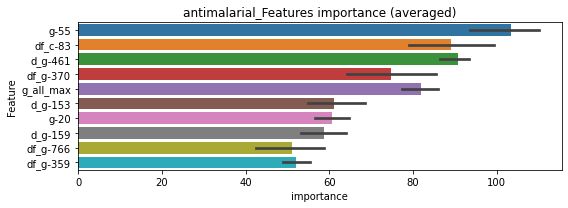

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 antimalarial=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0124792	valid_1's binary_logloss: 0.0178975
[200]	training's binary_logloss: 0.00144238	valid_1's binary_logloss: 0.00570096
Early stopping, best iteration is:
[263]	training's binary_logloss: 0.000584295	valid_1's binary_logloss: 0.00492518


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 antimalarial=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.012589	valid_1's binary_logloss: 0.0178454
[200]	training's binary_logloss: 0.00149256	valid_1's binary_logloss: 0.00439137
[300]	training's binary_logloss: 0.000419232	valid_1's binary_logloss: 0.00266783
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.000239856	valid_1's binary_logloss: 0.00232963


antimalarial logloss: 0.0036275722231281873
antioxidant, len(trt): 73, len(othr): 3278, target_rate: 0.0030654 → Adj_target_rate: 0.0032212


neg labels: 3289 → selected neg labels: 3278


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0493341	valid_1's binary_logloss: 0.106534
[200]	training's binary_logloss: 0.0109909	valid_1's binary_logloss: 0.0641084
[300]	training's binary_logloss: 0.00344186	valid_1's binary_logloss: 0.0522327
Early stopping, best iteration is:
[364]	training's binary_logloss: 0.00199021	valid_1's binary_logloss: 0.0496153
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0520403	valid_1's binary_logloss: 0.103109
[200]	training's binary_logloss: 0.0116894	valid_1's binary_logloss: 0.0513833
[300]	training's binary_logloss: 0.00344775	valid_1's binary_logloss: 0.0352268
[400]	training's binary_logloss: 0.00156649	valid_1's binary_logloss: 0.029236
[500]	training's binary_logloss: 0.000958128	valid_1's binary_logloss: 0.0263402
Early stopping, best iteration is:
[554]	training's binary_logloss: 0.000796291	valid_1's binary_logloss: 0.0255497


1 / 3 AUC score:0.999
y_Threshold: 0.0108529, Threshold: 0.0155415, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 140 → Positive_corect_labels: 651/3793
p_label_rate: 0.0200904 Vs.target_rate: 0.00307, Num_p_label: 80.0, conf_0:0.01399, conf_1:0.01710
Num_p_label: 80.0, Expected: 12.2, Adj_threshold_1: 0.0155415
Num_p_label: 36.0, Expected: 12.2, Adj_threshold_2: 0.0255415
Num_p_label: 15.0, Expected: 12.2, Adj_threshold_3: 0.0355415
threshold: 0.0355415, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 651.0/3793, y_label_rate: 0.1716320
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0480042	valid_1's binary_logloss: 0.102691
[200]	training's binary_logloss: 0.0098959	valid_1's binary_logloss: 0.0582164
[300]	training's binary_logloss: 0.00299936	valid_1's binary_logloss: 0.0460774
[400]	training's binary_logloss: 0.00141746	valid_1's binary_logloss: 0.0418751
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00102553	valid_1's binary_logloss: 0.0404543
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0500269	valid_1's binary_logloss: 0.113107
[200]	training's binary_logloss: 0.0104503	valid_1's binary_logloss: 0.0659217
[300]	training's binary_logloss: 0.00322873	valid_1's binary_logloss: 0.0538028
Early stopping, best iteration is:
[377]	training's binary_logloss: 0.00172566	valid_1's binary_logloss: 0.0502502


2 / 3 AUC score:0.998
y_Threshold: 0.0287238, Threshold: 0.0355415, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 20 → Positive_corect_labels: 641.0/3773
p_label_rate: 0.0110497 Vs.target_rate: 0.00307, Num_p_label: 44.0, conf_0:0.03199, conf_1:0.03910
Num_p_label: 44.0, Expected: 12.2, Adj_threshold_1: 0.0355415
Num_p_label: 24.0, Expected: 12.2, Adj_threshold_2: 0.0455415
threshold: 0.0455415, positive_p_label: 24.0/3982, p_label_rate: 0.0060271
positive_y_label: 641.0/3773, y_label_rate: 0.1698913
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0457688	valid_1's binary_logloss: 0.105033
[200]	training's binary_logloss: 0.00950331	valid_1's binary_logloss: 0.062635
[300]	training's binary_logloss: 0.00286492	valid_1's binary_logloss: 0.0499452
[400]	training's binary_logloss: 0.00135705	valid_1's binary_logloss: 0.0451177
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.00132949	valid_1's binary_logloss: 0.0449002
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0490773	valid_1's binary_logloss: 0.098853
[200]	training's binary_logloss: 0.010349	valid_1's binary_logloss: 0.047438
[300]	training's binary_logloss: 0.00315389	valid_1's binary_logloss: 0.0319305
[400]	training's binary_logloss: 0.00146241	valid_1's binary_logloss: 0.0270622
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.000948547	valid_1's binary_logloss: 0.0243604


3 / 3 AUC score:0.999
y_Threshold: 0.0457960, Threshold: 0.0455415, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 12 → Positive_corect_labels: 635.0/3761
p_label_rate: 0.0077850 Vs.target_rate: 0.00307, Num_p_label: 31.0, conf_0:0.04099, conf_1:0.05010
threshold: 0.0455415, positive_p_label: 31.0/3982, p_label_rate: 0.0077850
positive_y_label: 666.0/7743, y_label_rate: 0.0860132


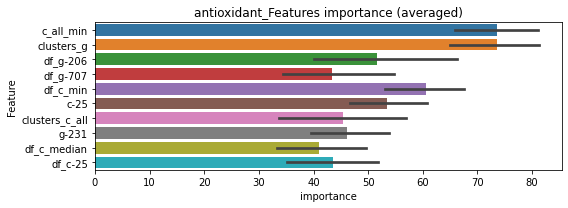

len(train_index) : 3871
len(valid_index) : 3872
================================= fold 1/2 antioxidant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0261627	valid_1's binary_logloss: 0.073386
[200]	training's binary_logloss: 0.00524659	valid_1's binary_logloss: 0.0517105
[300]	training's binary_logloss: 0.00162356	valid_1's binary_logloss: 0.0470045
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.00156023	valid_1's binary_logloss: 0.0469032


len(train_index) : 3872
len(valid_index) : 3871
================================= fold 2/2 antioxidant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0287668	valid_1's binary_logloss: 0.0620053
[200]	training's binary_logloss: 0.00615735	valid_1's binary_logloss: 0.0376098
[300]	training's binary_logloss: 0.00188192	valid_1's binary_logloss: 0.0317967
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00125489	valid_1's binary_logloss: 0.0309973


antioxidant logloss: 0.03895126032780278
antiprotozoal, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0373351	valid_1's binary_logloss: 0.0623613
[200]	training's binary_logloss: 0.00587194	valid_1's binary_logloss: 0.0210588
[300]	training's binary_logloss: 0.00163002	valid_1's binary_logloss: 0.011655
[400]	training's binary_logloss: 0.000789063	valid_1's binary_logloss: 0.00877978
[500]	training's binary_logloss: 0.000522509	valid_1's binary_logloss: 0.00769029
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.000482864	valid_1's binary_logloss: 0.00749091
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0391138	valid_1's binary_logloss: 0.062141
[200]	training's binary_logloss: 0.00646413	valid_1's binary_logloss: 0.0198734
[300]	training's binary_logloss: 0.00176183	valid_1's binary_logloss: 0.010624
[400]	training's binary_logloss: 0.000831109	valid_1's binary_logloss: 0.00793742
[500]	training's binary_logloss: 0.00054

1 / 3 AUC score:1.000
y_Threshold: 0.0037881, Threshold: 0.0065466, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00151, Num_p_label: 80.0, conf_0:0.00589, conf_1:0.00720
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0065466
Num_p_label: 19.0, Expected: 6.0, Adj_threshold_2: 0.0165466
Num_p_label: 10.0, Expected: 6.0, Adj_threshold_3: 0.0265466
threshold: 0.0265466, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0375886	valid_1's binary_logloss: 0.0638723
[200]	training's binary_logloss: 0.0057909	valid_1's binary_logloss: 0.021038
[300]	training's binary_logloss: 0.00163095	valid_1's binary_logloss: 0.0118722
[400]	training's binary_logloss: 0.000787433	valid_1's binary_logloss: 0.00853172
[500]	training's binary_logloss: 0.000514449	valid_1's binary_logloss: 0.00738158
Early stopping, best iteration is:
[579]	training's binary_logloss: 0.000458537	valid_1's binary_logloss: 0.00714916
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0372908	valid_1's binary_logloss: 0.0602908
[200]	training's binary_logloss: 0.00580796	valid_1's binary_logloss: 0.0166403
[300]	training's binary_logloss: 0.00165043	valid_1's binary_logloss: 0.00890118
[400]	training's binary_logloss: 0.000798676	valid_1's binary_logloss: 0.00662523
[500]	training's binary_logloss: 0.000

2 / 3 AUC score:1.000
y_Threshold: 0.0346082, Threshold: 0.0265466, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0075339 Vs.target_rate: 0.00151, Num_p_label: 30.0, conf_0:0.02389, conf_1:0.02920
Num_p_label: 30.0, Expected: 6.0, Adj_threshold_1: 0.0265466
Num_p_label: 20.0, Expected: 6.0, Adj_threshold_2: 0.0365466
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_3: 0.0465466
Num_p_label: 10.0, Expected: 6.0, Adj_threshold_4: 0.0565466
threshold: 0.0565466, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0375886	valid_1's binary_logloss: 0.0638723
[200]	training's binary_logloss: 0.0057909	valid_1's binary_logloss: 0.021038
[300]	training's binary_logloss: 0.00163095	valid_1's binary_logloss: 0.0118722
[400]	training's binary_logloss: 0.000787433	valid_1's binary_logloss: 0.00853172
[500]	training's binary_logloss: 0.000514449	valid_1's binary_logloss: 0.00738158
Early stopping, best iteration is:
[579]	training's binary_logloss: 0.000458537	valid_1's binary_logloss: 0.00714916
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0372908	valid_1's binary_logloss: 0.0602908
[200]	training's binary_logloss: 0.00580796	valid_1's binary_logloss: 0.0166403
[300]	training's binary_logloss: 0.00165043	valid_1's binary_logloss: 0.00890118
[400]	training's binary_logloss: 0.000798676	valid_1's binary_logloss: 0.00662523
[500]	training's binary_logloss: 0.000

3 / 3 AUC score:1.000
y_Threshold: 0.0346082, Threshold: 0.0565466, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0025113 Vs.target_rate: 0.00151, Num_p_label: 10.0, conf_0:0.05089, conf_1:0.06220
threshold: 0.0565466, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 666.0/7789, y_label_rate: 0.0855052


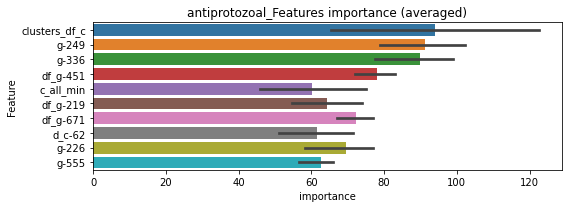

len(train_index) : 3894
len(valid_index) : 3895
================================= fold 1/2 antiprotozoal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0210318	valid_1's binary_logloss: 0.0355547
[200]	training's binary_logloss: 0.00333464	valid_1's binary_logloss: 0.0128615
[300]	training's binary_logloss: 0.000898323	valid_1's binary_logloss: 0.00913958
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.000560384	valid_1's binary_logloss: 0.00865117


len(train_index) : 3895
len(valid_index) : 3894
================================= fold 2/2 antiprotozoal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0217307	valid_1's binary_logloss: 0.0380832
[200]	training's binary_logloss: 0.00346748	valid_1's binary_logloss: 0.0139994
[300]	training's binary_logloss: 0.000954949	valid_1's binary_logloss: 0.00859036
[400]	training's binary_logloss: 0.000444234	valid_1's binary_logloss: 0.00694519
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.000297786	valid_1's binary_logloss: 0.00638558


antiprotozoal logloss: 0.007518522564208731
antiviral, len(trt): 23, len(othr): 3286, target_rate: 0.0009658 → Adj_target_rate: 0.0012069


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0285907	valid_1's binary_logloss: 0.042685
[200]	training's binary_logloss: 0.0037525	valid_1's binary_logloss: 0.00945084
[300]	training's binary_logloss: 0.00105348	valid_1's binary_logloss: 0.00405555
[400]	training's binary_logloss: 0.000524083	valid_1's binary_logloss: 0.00264653
[500]	training's binary_logloss: 0.000382352	valid_1's binary_logloss: 0.00223584
Early stopping, best iteration is:
[523]	training's binary_logloss: 0.000374258	valid_1's binary_logloss: 0.00221442
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0288502	valid_1's binary_logloss: 0.0381817
[200]	training's binary_logloss: 0.00382848	valid_1's binary_logloss: 0.00712629
[300]	training's binary_logloss: 0.00106311	valid_1's binary_logloss: 0.00252231
[400]	training's binary_logloss: 0.000535919	valid_1's binary_logloss: 0.00142835
[500]	training's binary_logloss: 0.

1 / 3 AUC score:1.000
y_Threshold: 0.0024437, Threshold: 0.0034895, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00097, Num_p_label: 80.0, conf_0:0.00314, conf_1:0.00384
Num_p_label: 80.0, Expected: 3.8, Adj_threshold_1: 0.0034895
Num_p_label: 11.0, Expected: 3.8, Adj_threshold_2: 0.0134895
Num_p_label: 3.0, Expected: 3.8, Adj_threshold_3: 0.0234895
threshold: 0.0234895, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0283296	valid_1's binary_logloss: 0.0405419
[200]	training's binary_logloss: 0.00362139	valid_1's binary_logloss: 0.00765695
[300]	training's binary_logloss: 0.00102149	valid_1's binary_logloss: 0.00299322
[400]	training's binary_logloss: 0.000512005	valid_1's binary_logloss: 0.00182078
[500]	training's binary_logloss: 0.000380674	valid_1's binary_logloss: 0.00149706
Early stopping, best iteration is:
[529]	training's binary_logloss: 0.000371241	valid_1's binary_logloss: 0.00147482
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0284186	valid_1's binary_logloss: 0.0366868
[200]	training's binary_logloss: 0.00362302	valid_1's binary_logloss: 0.00619536
[300]	training's binary_logloss: 0.00101178	valid_1's binary_logloss: 0.00207756
[400]	training's binary_logloss: 0.0005096	valid_1's binary_logloss: 0.0011803
[500]	training's binary_logloss: 0.0

2 / 3 AUC score:1.000
y_Threshold: 0.1380791, Threshold: 0.0234895, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0035158 Vs.target_rate: 0.00097, Num_p_label: 14.0, conf_0:0.02114, conf_1:0.02584
Num_p_label: 14.0, Expected: 3.8, Adj_threshold_1: 0.0234895
Num_p_label: 6.0, Expected: 3.8, Adj_threshold_2: 0.0334895
threshold: 0.0334895, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0283296	valid_1's binary_logloss: 0.0405419
[200]	training's binary_logloss: 0.00362139	valid_1's binary_logloss: 0.00765695
[300]	training's binary_logloss: 0.00102149	valid_1's binary_logloss: 0.00299322
[400]	training's binary_logloss: 0.000512005	valid_1's binary_logloss: 0.00182078
[500]	training's binary_logloss: 0.000380674	valid_1's binary_logloss: 0.00149706
Early stopping, best iteration is:
[529]	training's binary_logloss: 0.000371241	valid_1's binary_logloss: 0.00147482
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0284186	valid_1's binary_logloss: 0.0366868
[200]	training's binary_logloss: 0.00362302	valid_1's binary_logloss: 0.00619536
[300]	training's binary_logloss: 0.00101178	valid_1's binary_logloss: 0.00207756
[400]	training's binary_logloss: 0.0005096	valid_1's binary_logloss: 0.0011803
[500]	training's binary_logloss: 0.0

3 / 3 AUC score:1.000
y_Threshold: 0.1380791, Threshold: 0.0334895, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0015068 Vs.target_rate: 0.00097, Num_p_label: 6.0, conf_0:0.03014, conf_1:0.03684
threshold: 0.0334895, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 663.0/7793, y_label_rate: 0.0850764


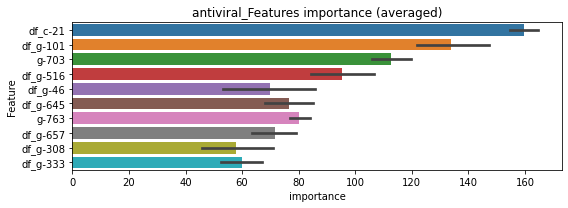

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 antiviral=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0146981	valid_1's binary_logloss: 0.0236367
[200]	training's binary_logloss: 0.00188103	valid_1's binary_logloss: 0.00755888
[300]	training's binary_logloss: 0.000512429	valid_1's binary_logloss: 0.0057304
Early stopping, best iteration is:
[317]	training's binary_logloss: 0.000441435	valid_1's binary_logloss: 0.00561633


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 antiviral=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0152052	valid_1's binary_logloss: 0.0258142
[200]	training's binary_logloss: 0.00196483	valid_1's binary_logloss: 0.00709596
[300]	training's binary_logloss: 0.000547558	valid_1's binary_logloss: 0.00397349
[400]	training's binary_logloss: 0.000275125	valid_1's binary_logloss: 0.00322495
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.000230945	valid_1's binary_logloss: 0.00306561


antiviral logloss: 0.004341132885529438
apoptosis_stimulant, len(trt): 49, len(othr): 3281, target_rate: 0.0020576 → Adj_target_rate: 0.0022954


neg labels: 3289 → selected neg labels: 3281


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0461082	valid_1's binary_logloss: 0.0821018
[200]	training's binary_logloss: 0.00813073	valid_1's binary_logloss: 0.0333774
[300]	training's binary_logloss: 0.0023114	valid_1's binary_logloss: 0.0227489
[400]	training's binary_logloss: 0.00109497	valid_1's binary_logloss: 0.0194378
[500]	training's binary_logloss: 0.000691997	valid_1's binary_logloss: 0.0181107
Early stopping, best iteration is:
[494]	training's binary_logloss: 0.000708592	valid_1's binary_logloss: 0.0180624
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0452334	valid_1's binary_logloss: 0.0698605
[200]	training's binary_logloss: 0.00819559	valid_1's binary_logloss: 0.0236125
[300]	training's binary_logloss: 0.00237894	valid_1's binary_logloss: 0.0132563
[400]	training's binary_logloss: 0.00113704	valid_1's binary_logloss: 0.0105795
[500]	training's binary_logloss: 0.000723438

1 / 3 AUC score:1.000
y_Threshold: 0.0044097, Threshold: 0.0597721, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3805
p_label_rate: 0.0200904 Vs.target_rate: 0.00206, Num_p_label: 80.0, conf_0:0.05379, conf_1:0.06575
Num_p_label: 80.0, Expected: 8.2, Adj_threshold_1: 0.0597721
Num_p_label: 76.0, Expected: 8.2, Adj_threshold_2: 0.0697721
Num_p_label: 75.0, Expected: 8.2, Adj_threshold_3: 0.0797721
Num_p_label: 71.0, Expected: 8.2, Adj_threshold_4: 0.0897721
Num_p_label: 68.0, Expected: 8.2, Adj_threshold_5: 0.0997721
Num_p_label: 66.0, Expected: 8.2, Adj_threshold_6: 0.1097721
Num_p_label: 64.0, Expected: 8.2, Adj_threshold_7: 0.1197721
Num_p_label: 62.0, Expected: 8.2, Adj_threshold_8: 0.1297721
Num_p_label: 59.0, Expected: 8.2, Adj_threshold_9: 0.1397721
Num_p_label: 55.0, Expected: 8.2, Adj_threshold_10: 0.1497721
threshold: 0.1597721, positive_p_label: 53.0/3982, p_label_rate: 0.0133099
positive_y_label: 656.0/3805, y_label_rate: 0.1724047
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0425904	valid_1's binary_logloss: 0.0738926
[200]	training's binary_logloss: 0.00743147	valid_1's binary_logloss: 0.0279496
[300]	training's binary_logloss: 0.00216214	valid_1's binary_logloss: 0.0181878
[400]	training's binary_logloss: 0.0010423	valid_1's binary_logloss: 0.0150892
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.000938158	valid_1's binary_logloss: 0.0148695
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.044266	valid_1's binary_logloss: 0.0678734
[200]	training's binary_logloss: 0.00772603	valid_1's binary_logloss: 0.0222958
[300]	training's binary_logloss: 0.00225514	valid_1's binary_logloss: 0.0132418
[400]	training's binary_logloss: 0.0010793	valid_1's binary_logloss: 0.0104719
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.0011047	valid_1's binary_logloss: 0.0104225


2 / 3 AUC score:1.000
y_Threshold: 0.0600060, Threshold: 0.1597721, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 652.0/3797
p_label_rate: 0.0286288 Vs.target_rate: 0.00206, Num_p_label: 114.0, conf_0:0.14379, conf_1:0.17575
Num_p_label: 114.0, Expected: 8.2, Adj_threshold_1: 0.1597721
Num_p_label: 113.0, Expected: 8.2, Adj_threshold_2: 0.1697721
Num_p_label: 113.0, Expected: 8.2, Adj_threshold_3: 0.1797721
Num_p_label: 109.0, Expected: 8.2, Adj_threshold_4: 0.1897721
Num_p_label: 106.0, Expected: 8.2, Adj_threshold_5: 0.1997721
Num_p_label: 104.0, Expected: 8.2, Adj_threshold_6: 0.2097721
Num_p_label: 103.0, Expected: 8.2, Adj_threshold_7: 0.2197721
Num_p_label: 101.0, Expected: 8.2, Adj_threshold_8: 0.2297721
Num_p_label: 100.0, Expected: 8.2, Adj_threshold_9: 0.2397721
Num_p_label: 100.0, Expected: 8.2, Adj_threshold_10: 0.2497721
threshold: 0.2597721, positive_p_label: 97.0/3982, p_label_rate: 0.0243596
positive_y_label: 652.0/3797, y_label_rate: 0.17171

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0437741	valid_1's binary_logloss: 0.0651912
[200]	training's binary_logloss: 0.00746747	valid_1's binary_logloss: 0.0197244
[300]	training's binary_logloss: 0.0021508	valid_1's binary_logloss: 0.00997622
[400]	training's binary_logloss: 0.00103774	valid_1's binary_logloss: 0.00727846
[500]	training's binary_logloss: 0.00066704	valid_1's binary_logloss: 0.00601104
Early stopping, best iteration is:
[569]	training's binary_logloss: 0.000567102	valid_1's binary_logloss: 0.00575111
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0435686	valid_1's binary_logloss: 0.0733018
[200]	training's binary_logloss: 0.00753871	valid_1's binary_logloss: 0.0252252
[300]	training's binary_logloss: 0.00213089	valid_1's binary_logloss: 0.015997
[400]	training's binary_logloss: 0.00102873	valid_1's binary_logloss: 0.0140561
[500]	training's binary_logloss: 0.0006668

3 / 3 AUC score:1.000
y_Threshold: 0.0588774, Threshold: 0.2597721, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 651.0/3795
p_label_rate: 0.0278754 Vs.target_rate: 0.00206, Num_p_label: 111.0, conf_0:0.23379, conf_1:0.28575
Num_p_label: 111.0, Expected: 8.2, Adj_threshold_1: 0.2597721
Num_p_label: 110.0, Expected: 8.2, Adj_threshold_2: 0.2697721
Num_p_label: 110.0, Expected: 8.2, Adj_threshold_3: 0.2797721
Num_p_label: 109.0, Expected: 8.2, Adj_threshold_4: 0.2897721
Num_p_label: 107.0, Expected: 8.2, Adj_threshold_5: 0.2997721
Num_p_label: 106.0, Expected: 8.2, Adj_threshold_6: 0.3097721
Num_p_label: 106.0, Expected: 8.2, Adj_threshold_7: 0.3197721
Num_p_label: 106.0, Expected: 8.2, Adj_threshold_8: 0.3297721
Num_p_label: 103.0, Expected: 8.2, Adj_threshold_9: 0.3397721
Num_p_label: 102.0, Expected: 8.2, Adj_threshold_10: 0.3497721
threshold: 0.3597721, positive_p_label: 101.0/3982, p_label_rate: 0.0253641
positive_y_label: 752.0/7777, y_label_rate: 0.0966

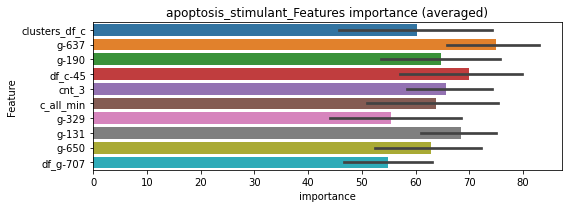

len(train_index) : 3888
len(valid_index) : 3889
================================= fold 1/2 apoptosis_stimulant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0261695	valid_1's binary_logloss: 0.0494723
[200]	training's binary_logloss: 0.00435324	valid_1's binary_logloss: 0.0227658
[300]	training's binary_logloss: 0.00123819	valid_1's binary_logloss: 0.0168817
[400]	training's binary_logloss: 0.000573751	valid_1's binary_logloss: 0.014845
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.000570747	valid_1's binary_logloss: 0.0148342


len(train_index) : 3889
len(valid_index) : 3888
================================= fold 2/2 apoptosis_stimulant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0261637	valid_1's binary_logloss: 0.0434672
[200]	training's binary_logloss: 0.00461548	valid_1's binary_logloss: 0.0167617
[300]	training's binary_logloss: 0.0012899	valid_1's binary_logloss: 0.0104654
[400]	training's binary_logloss: 0.000601683	valid_1's binary_logloss: 0.00871768
[500]	training's binary_logloss: 0.000380738	valid_1's binary_logloss: 0.00800613
Early stopping, best iteration is:
[533]	training's binary_logloss: 0.000338899	valid_1's binary_logloss: 0.00787656


apoptosis_stimulant logloss: 0.011355850384954869
aromatase_inhibitor, len(trt): 47, len(othr): 3281, target_rate: 0.0019736 → Adj_target_rate: 0.0022155


neg labels: 3289 → selected neg labels: 3281


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0406845	valid_1's binary_logloss: 0.0758727
[200]	training's binary_logloss: 0.00773354	valid_1's binary_logloss: 0.029727
[300]	training's binary_logloss: 0.0021641	valid_1's binary_logloss: 0.0177952
[400]	training's binary_logloss: 0.00102489	valid_1's binary_logloss: 0.0145147
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.000688948	valid_1's binary_logloss: 0.0129038
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0452314	valid_1's binary_logloss: 0.0709088
[200]	training's binary_logloss: 0.0083077	valid_1's binary_logloss: 0.0237284
[300]	training's binary_logloss: 0.00239198	valid_1's binary_logloss: 0.0115692
[400]	training's binary_logloss: 0.00111295	valid_1's binary_logloss: 0.00803763
[500]	training's binary_logloss: 0.000713462	valid_1's binary_logloss: 0.00665235
[600]	training's binary_logloss: 0.000563153

1 / 3 AUC score:1.000
y_Threshold: 0.0043927, Threshold: 0.0070225, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3805
p_label_rate: 0.0200904 Vs.target_rate: 0.00197, Num_p_label: 80.0, conf_0:0.00632, conf_1:0.00772
Num_p_label: 80.0, Expected: 7.9, Adj_threshold_1: 0.0070225
Num_p_label: 12.0, Expected: 7.9, Adj_threshold_2: 0.0170225
threshold: 0.0170225, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 656.0/3805, y_label_rate: 0.1724047
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0430005	valid_1's binary_logloss: 0.0732529
[200]	training's binary_logloss: 0.00795312	valid_1's binary_logloss: 0.02643
[300]	training's binary_logloss: 0.00226734	valid_1's binary_logloss: 0.015034
[400]	training's binary_logloss: 0.00105626	valid_1's binary_logloss: 0.012017
[500]	training's binary_logloss: 0.000678938	valid_1's binary_logloss: 0.0107589
Early stopping, best iteration is:
[497]	training's binary_logloss: 0.000684368	valid_1's binary_logloss: 0.010739
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0436943	valid_1's binary_logloss: 0.0679311
[200]	training's binary_logloss: 0.00788155	valid_1's binary_logloss: 0.0219034
[300]	training's binary_logloss: 0.00230325	valid_1's binary_logloss: 0.0109989
[400]	training's binary_logloss: 0.00108114	valid_1's binary_logloss: 0.00753757
[500]	training's binary_logloss: 0.000693809	va

2 / 3 AUC score:1.000
y_Threshold: 0.0587923, Threshold: 0.0170225, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3805
p_label_rate: 0.0082873 Vs.target_rate: 0.00197, Num_p_label: 33.0, conf_0:0.01532, conf_1:0.01872
Num_p_label: 33.0, Expected: 7.9, Adj_threshold_1: 0.0170225
Num_p_label: 17.0, Expected: 7.9, Adj_threshold_2: 0.0270225
Num_p_label: 9.0, Expected: 7.9, Adj_threshold_3: 0.0370225
threshold: 0.0370225, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 656.0/3805, y_label_rate: 0.1724047
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0430005	valid_1's binary_logloss: 0.0732529
[200]	training's binary_logloss: 0.00795312	valid_1's binary_logloss: 0.02643
[300]	training's binary_logloss: 0.00226734	valid_1's binary_logloss: 0.015034
[400]	training's binary_logloss: 0.00105626	valid_1's binary_logloss: 0.012017
[500]	training's binary_logloss: 0.000678938	valid_1's binary_logloss: 0.0107589
Early stopping, best iteration is:
[497]	training's binary_logloss: 0.000684368	valid_1's binary_logloss: 0.010739
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0436943	valid_1's binary_logloss: 0.0679311
[200]	training's binary_logloss: 0.00788155	valid_1's binary_logloss: 0.0219034
[300]	training's binary_logloss: 0.00230325	valid_1's binary_logloss: 0.0109989
[400]	training's binary_logloss: 0.00108114	valid_1's binary_logloss: 0.00753757
[500]	training's binary_logloss: 0.000693809	va

3 / 3 AUC score:1.000
y_Threshold: 0.0587923, Threshold: 0.0370225, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3805
p_label_rate: 0.0022602 Vs.target_rate: 0.00197, Num_p_label: 9.0, conf_0:0.03332, conf_1:0.04072
threshold: 0.0370225, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 665.0/7787, y_label_rate: 0.0853987


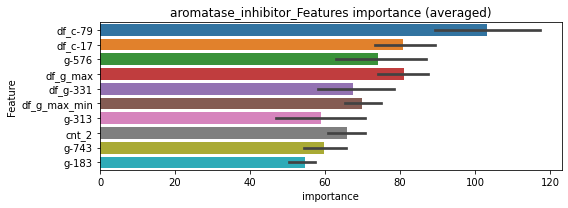

len(train_index) : 3893
len(valid_index) : 3894
================================= fold 1/2 aromatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0239775	valid_1's binary_logloss: 0.0502964
[200]	training's binary_logloss: 0.00428179	valid_1's binary_logloss: 0.0253033
[300]	training's binary_logloss: 0.00118578	valid_1's binary_logloss: 0.0200272
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.000611839	valid_1's binary_logloss: 0.0188016


len(train_index) : 3894
len(valid_index) : 3893
================================= fold 2/2 aromatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0261294	valid_1's binary_logloss: 0.0445333
[200]	training's binary_logloss: 0.00490002	valid_1's binary_logloss: 0.0176857
[300]	training's binary_logloss: 0.00136239	valid_1's binary_logloss: 0.0106516
[400]	training's binary_logloss: 0.000606443	valid_1's binary_logloss: 0.00865407
[500]	training's binary_logloss: 0.000380374	valid_1's binary_logloss: 0.00799638
Early stopping, best iteration is:
[493]	training's binary_logloss: 0.00039042	valid_1's binary_logloss: 0.00798019


aromatase_inhibitor logloss: 0.013391602534183387
atm_kinase_inhibitor, len(trt): 6, len(othr): 3288, target_rate: 0.0002520 → Adj_target_rate: 0.0003851


neg labels: 3289 → selected neg labels: 3288


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0154849	valid_1's binary_logloss: 0.0163362
[200]	training's binary_logloss: 0.0012447	valid_1's binary_logloss: 0.00149367
[300]	training's binary_logloss: 0.000336773	valid_1's binary_logloss: 0.00048534
[400]	training's binary_logloss: 0.000211829	valid_1's binary_logloss: 0.000317092
[500]	training's binary_logloss: 0.000187643	valid_1's binary_logloss: 0.000282582
Early stopping, best iteration is:
[529]	training's binary_logloss: 0.000185609	valid_1's binary_logloss: 0.000279417
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.01548	valid_1's binary_logloss: 0.0177869
[200]	training's binary_logloss: 0.00123062	valid_1's binary_logloss: 0.00247911
[300]	training's binary_logloss: 0.000330413	valid_1's binary_logloss: 0.00144612
Early stopping, best iteration is:
[302]	training's binary_logloss: 0.000325589	valid_1's binary_logloss: 0.00143

1 / 3 AUC score:1.000
y_Threshold: 0.0009508, Threshold: 0.0017579, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0200904 Vs.target_rate: 0.00025, Num_p_label: 80.0, conf_0:0.00158, conf_1:0.00193
Num_p_label: 80.0, Expected: 1.0, Adj_threshold_1: 0.0017579
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_2: 0.0117579
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_3: 0.0217579
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_4: 0.0317579
threshold: 0.0317579, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015893	valid_1's binary_logloss: 0.0163354
[200]	training's binary_logloss: 0.00124295	valid_1's binary_logloss: 0.00134093
[300]	training's binary_logloss: 0.000319151	valid_1's binary_logloss: 0.000367726
[400]	training's binary_logloss: 0.000201508	valid_1's binary_logloss: 0.000238929
[500]	training's binary_logloss: 0.000180301	valid_1's binary_logloss: 0.000213799
[600]	training's binary_logloss: 0.000175492	valid_1's binary_logloss: 0.000207944
Early stopping, best iteration is:
[628]	training's binary_logloss: 0.00017432	valid_1's binary_logloss: 0.000206556
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158954	valid_1's binary_logloss: 0.0163483
[200]	training's binary_logloss: 0.00124821	valid_1's binary_logloss: 0.0013381
[300]	training's binary_logloss: 0.000320717	valid_1's binary_logloss: 0.000367252
[400]	training's binary_logl

2 / 3 AUC score:1.000
y_Threshold: 0.1806944, Threshold: 0.0317579, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[762]	training's binary_logloss: 0.000171307	valid_1's binary_logloss: 0.000205041


Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0055249 Vs.target_rate: 0.00025, Num_p_label: 22.0, conf_0:0.02858, conf_1:0.03493
Num_p_label: 22.0, Expected: 1.0, Adj_threshold_1: 0.0317579
Num_p_label: 18.0, Expected: 1.0, Adj_threshold_2: 0.0417579
Num_p_label: 14.0, Expected: 1.0, Adj_threshold_3: 0.0517579
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_4: 0.0617579
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_5: 0.0717579
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_6: 0.0817579
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_7: 0.0917579
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_8: 0.1017579
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_9: 0.1117579
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_10: 0.1217579
threshold: 0.1317579, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015893	valid_1's binary_logloss: 0.0163354
[200]	training's binary_logloss: 0.00124295	valid_1's binary_logloss: 0.00134093
[300]	training's binary_logloss: 0.000319151	valid_1's binary_logloss: 0.000367726
[400]	training's binary_logloss: 0.000201508	valid_1's binary_logloss: 0.000238929
[500]	training's binary_logloss: 0.000180301	valid_1's binary_logloss: 0.000213799
[600]	training's binary_logloss: 0.000175492	valid_1's binary_logloss: 0.000207944
Early stopping, best iteration is:
[628]	training's binary_logloss: 0.00017432	valid_1's binary_logloss: 0.000206556
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158954	valid_1's binary_logloss: 0.0163483
[200]	training's binary_logloss: 0.00124821	valid_1's binary_logloss: 0.0013381
[300]	training's binary_logloss: 0.000320717	valid_1's binary_logloss: 0.000367252
[400]	training's binary_logl

3 / 3 AUC score:1.000
y_Threshold: 0.1806944, Threshold: 0.1317579, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[755]	training's binary_logloss: 0.000171307	valid_1's binary_logloss: 0.000205041


Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0025113 Vs.target_rate: 0.00025, Num_p_label: 10.0, conf_0:0.11858, conf_1:0.14493
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_1: 0.1317579
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_2: 0.1417579
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_3: 0.1517579
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_4: 0.1617579
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_5: 0.1717579
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_6: 0.1817579
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_7: 0.1917579
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_8: 0.2017579
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_9: 0.2117579
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_10: 0.2217579
threshold: 0.2317579, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 663.0/7795, y_label_rate: 0.0850545


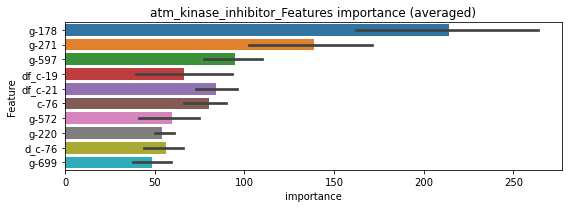

len(train_index) : 3897
len(valid_index) : 3898
================================= fold 1/2 atm_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00846621	valid_1's binary_logloss: 0.0117204
[200]	training's binary_logloss: 0.000667296	valid_1's binary_logloss: 0.00397055
Early stopping, best iteration is:
[276]	training's binary_logloss: 0.000215357	valid_1's binary_logloss: 0.00349545


len(train_index) : 3898
len(valid_index) : 3897
================================= fold 2/2 atm_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0086692	valid_1's binary_logloss: 0.00918277
[200]	training's binary_logloss: 0.000718524	valid_1's binary_logloss: 0.00125994
[300]	training's binary_logloss: 0.000188155	valid_1's binary_logloss: 0.000684666


atm_kinase_inhibitor logloss: 0.002079413991899802


Early stopping, best iteration is:
[341]	training's binary_logloss: 0.000144774	valid_1's binary_logloss: 0.000663012


atp-sensitive_potassium_channel_antagonist, len(trt): 7, len(othr): 3287, target_rate: 0.0002939 → Adj_target_rate: 0.0004391


neg labels: 3289 → selected neg labels: 3287


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162418	valid_1's binary_logloss: 0.0175188
[200]	training's binary_logloss: 0.00142071	valid_1's binary_logloss: 0.00188671
[300]	training's binary_logloss: 0.000397353	valid_1's binary_logloss: 0.000681838
[400]	training's binary_logloss: 0.000240006	valid_1's binary_logloss: 0.000441028
[500]	training's binary_logloss: 0.000213967	valid_1's binary_logloss: 0.00039763
Early stopping, best iteration is:
[497]	training's binary_logloss: 0.000213967	valid_1's binary_logloss: 0.00039763
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.016573	valid_1's binary_logloss: 0.0177749
[200]	training's binary_logloss: 0.00144731	valid_1's binary_logloss: 0.00172533
[300]	training's binary_logloss: 0.000399107	valid_1's binary_logloss: 0.000528809
[400]	training's binary_logloss: 0.000239286	valid_1's binary_logloss: 0.000330861
[500]	training's binary_logl

1 / 3 AUC score:1.000
y_Threshold: 0.0006719, Threshold: 0.0009772, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00029, Num_p_label: 80.0, conf_0:0.00088, conf_1:0.00107
Num_p_label: 80.0, Expected: 1.2, Adj_threshold_1: 0.0009772
Num_p_label: 7.0, Expected: 1.2, Adj_threshold_2: 0.0109772
Num_p_label: 1.0, Expected: 1.2, Adj_threshold_3: 0.0209772
threshold: 0.0209772, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.016465	valid_1's binary_logloss: 0.0174452
[200]	training's binary_logloss: 0.00139693	valid_1's binary_logloss: 0.00166799
[300]	training's binary_logloss: 0.000382445	valid_1's binary_logloss: 0.000520727
[400]	training's binary_logloss: 0.000236176	valid_1's binary_logloss: 0.000334001
[500]	training's binary_logloss: 0.000207947	valid_1's binary_logloss: 0.000296815
Early stopping, best iteration is:
[581]	training's binary_logloss: 0.000204436	valid_1's binary_logloss: 0.000292139
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0167052	valid_1's binary_logloss: 0.0176189
[200]	training's binary_logloss: 0.00141336	valid_1's binary_logloss: 0.00159213
[300]	training's binary_logloss: 0.000384388	valid_1's binary_logloss: 0.000462299
[400]	training's binary_logloss: 0.000234961	valid_1's binary_logloss: 0.00028613
[500]	training's binary_log

2 / 3 AUC score:1.000
y_Threshold: 0.1689024, Threshold: 0.0209772, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0037670 Vs.target_rate: 0.00029, Num_p_label: 15.0, conf_0:0.01888, conf_1:0.02307
Num_p_label: 15.0, Expected: 1.2, Adj_threshold_1: 0.0209772
Num_p_label: 11.0, Expected: 1.2, Adj_threshold_2: 0.0309772
Num_p_label: 8.0, Expected: 1.2, Adj_threshold_3: 0.0409772
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_4: 0.0509772
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_5: 0.0609772
Num_p_label: 4.0, Expected: 1.2, Adj_threshold_6: 0.0709772
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_7: 0.0809772
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_8: 0.0909772
Num_p_label: 2.0, Expected: 1.2, Adj_threshold_9: 0.1009772
threshold: 0.1009772, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.016465	valid_1's binary_logloss: 0.0174452
[200]	training's binary_logloss: 0.00139693	valid_1's binary_logloss: 0.00166799
[300]	training's binary_logloss: 0.000382445	valid_1's binary_logloss: 0.000520727
[400]	training's binary_logloss: 0.000236176	valid_1's binary_logloss: 0.000334001
[500]	training's binary_logloss: 0.000207947	valid_1's binary_logloss: 0.000296815
Early stopping, best iteration is:
[581]	training's binary_logloss: 0.000204436	valid_1's binary_logloss: 0.000292139
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0167052	valid_1's binary_logloss: 0.0176189
[200]	training's binary_logloss: 0.00141336	valid_1's binary_logloss: 0.00159213
[300]	training's binary_logloss: 0.000384388	valid_1's binary_logloss: 0.000462299
[400]	training's binary_logloss: 0.000234961	valid_1's binary_logloss: 0.00028613
[500]	training's binary_log

3 / 3 AUC score:1.000
y_Threshold: 0.1689024, Threshold: 0.1009772, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0005023 Vs.target_rate: 0.00029, Num_p_label: 2.0, conf_0:0.09088, conf_1:0.11107
threshold: 0.1009772, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 659.0/7794, y_label_rate: 0.0845522


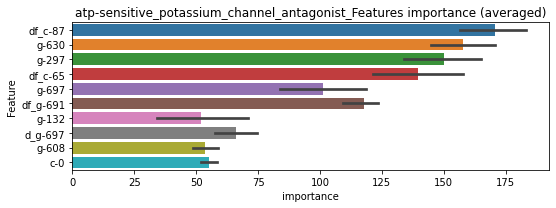

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 atp-sensitive_potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00877235	valid_1's binary_logloss: 0.0102299
[200]	training's binary_logloss: 0.000733096	valid_1's binary_logloss: 0.00165152
[300]	training's binary_logloss: 0.000200396	valid_1's binary_logloss: 0.00104473
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.000185383	valid_1's binary_logloss: 0.00102433


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 atp-sensitive_potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0087148	valid_1's binary_logloss: 0.0101087
[200]	training's binary_logloss: 0.00071754	valid_1's binary_logloss: 0.00198766


atp-sensitive_potassium_channel_antagonist logloss: 0.0012617047697387996


Early stopping, best iteration is:
[286]	training's binary_logloss: 0.00022	valid_1's binary_logloss: 0.00149908


atp_synthase_inhibitor, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942


neg labels: 3289 → selected neg labels: 3287


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0153452	valid_1's binary_logloss: 0.0184078
[200]	training's binary_logloss: 0.00118019	valid_1's binary_logloss: 0.00352018
Early stopping, best iteration is:
[262]	training's binary_logloss: 0.000428038	valid_1's binary_logloss: 0.00268616
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157726	valid_1's binary_logloss: 0.0160365
[200]	training's binary_logloss: 0.00126413	valid_1's binary_logloss: 0.00173993
[300]	training's binary_logloss: 0.000325139	valid_1's binary_logloss: 0.000799452
[400]	training's binary_logloss: 0.000204275	valid_1's binary_logloss: 0.000625839
[500]	training's binary_logloss: 0.000181083	valid_1's binary_logloss: 0.00059839


1 / 3 AUC score:1.000


Early stopping, best iteration is:
[584]	training's binary_logloss: 0.000175983	valid_1's binary_logloss: 0.000587644


y_Threshold: 0.0007767, Threshold: 0.0020764, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00050, Num_p_label: 80.0, conf_0:0.00187, conf_1:0.00228
Num_p_label: 80.0, Expected: 2.0, Adj_threshold_1: 0.0020764
Num_p_label: 22.0, Expected: 2.0, Adj_threshold_2: 0.0120764
Num_p_label: 16.0, Expected: 2.0, Adj_threshold_3: 0.0220764
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_4: 0.0320764
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_5: 0.0420764
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_6: 0.0520764
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_7: 0.0620764
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_8: 0.0720764
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_9: 0.0820764
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_10: 0.0920764
threshold: 0.1020764, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015705	valid_1's binary_logloss: 0.016577
[200]	training's binary_logloss: 0.00117149	valid_1's binary_logloss: 0.00142357
[300]	training's binary_logloss: 0.000273844	valid_1's binary_logloss: 0.000372877
[400]	training's binary_logloss: 0.000175421	valid_1's binary_logloss: 0.000250602
[500]	training's binary_logloss: 0.00015628	valid_1's binary_logloss: 0.000225205
Early stopping, best iteration is:
[588]	training's binary_logloss: 0.000152932	valid_1's binary_logloss: 0.000220493
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0154995	valid_1's binary_logloss: 0.0154916
[200]	training's binary_logloss: 0.00113779	valid_1's binary_logloss: 0.00117599
[300]	training's binary_logloss: 0.000268194	valid_1's binary_logloss: 0.000299932
[400]	training's binary_logloss: 0.000173387	valid_1's binary_logloss: 0.00020123
[500]	training's binary_loglo

2 / 3 AUC score:1.000
y_Threshold: 0.1955810, Threshold: 0.1020764, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0042692 Vs.target_rate: 0.00050, Num_p_label: 17.0, conf_0:0.09187, conf_1:0.11228
Num_p_label: 17.0, Expected: 2.0, Adj_threshold_1: 0.1020764
Num_p_label: 17.0, Expected: 2.0, Adj_threshold_2: 0.1120764
Num_p_label: 17.0, Expected: 2.0, Adj_threshold_3: 0.1220764
Num_p_label: 16.0, Expected: 2.0, Adj_threshold_4: 0.1320764
Num_p_label: 16.0, Expected: 2.0, Adj_threshold_5: 0.1420764
Num_p_label: 16.0, Expected: 2.0, Adj_threshold_6: 0.1520764
Num_p_label: 15.0, Expected: 2.0, Adj_threshold_7: 0.1620764
Num_p_label: 15.0, Expected: 2.0, Adj_threshold_8: 0.1720764
Num_p_label: 15.0, Expected: 2.0, Adj_threshold_9: 0.1820764
Num_p_label: 15.0, Expected: 2.0, Adj_threshold_10: 0.1920764
threshold: 0.2020764, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015705	valid_1's binary_logloss: 0.016577
[200]	training's binary_logloss: 0.00117149	valid_1's binary_logloss: 0.00142357
[300]	training's binary_logloss: 0.000273844	valid_1's binary_logloss: 0.000372877
[400]	training's binary_logloss: 0.000175421	valid_1's binary_logloss: 0.000250602
[500]	training's binary_logloss: 0.00015628	valid_1's binary_logloss: 0.000225205
Early stopping, best iteration is:
[579]	training's binary_logloss: 0.000152932	valid_1's binary_logloss: 0.000220493
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0154995	valid_1's binary_logloss: 0.0154916
[200]	training's binary_logloss: 0.00113779	valid_1's binary_logloss: 0.00117599
[300]	training's binary_logloss: 0.000268194	valid_1's binary_logloss: 0.000299932
[400]	training's binary_logloss: 0.000173387	valid_1's binary_logloss: 0.00020123
[500]	training's binary_loglo

3 / 3 AUC score:1.000
y_Threshold: 0.1955810, Threshold: 0.2020764, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0032647 Vs.target_rate: 0.00050, Num_p_label: 13.0, conf_0:0.18187, conf_1:0.22228
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_1: 0.2020764
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_2: 0.2120764
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_3: 0.2220764
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_4: 0.2320764
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_5: 0.2420764
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_6: 0.2520764
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_7: 0.2620764
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_8: 0.2720764
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_9: 0.2820764
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_10: 0.2920764
threshold: 0.3020764, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 669.0/7794, y_label_rate: 0.0858353


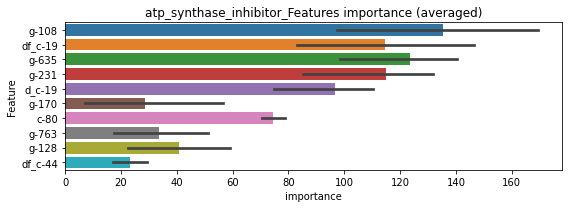

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 atp_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00867322	valid_1's binary_logloss: 0.011447
[200]	training's binary_logloss: 0.000696203	valid_1's binary_logloss: 0.00304984
[300]	training's binary_logloss: 0.00017159	valid_1's binary_logloss: 0.00236475
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.000163314	valid_1's binary_logloss: 0.00235291


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 atp_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00876393	valid_1's binary_logloss: 0.00995771
[200]	training's binary_logloss: 0.00069795	valid_1's binary_logloss: 0.00208209


atp_synthase_inhibitor logloss: 0.002018025745025025


Early stopping, best iteration is:
[285]	training's binary_logloss: 0.000194132	valid_1's binary_logloss: 0.00168315


atpase_inhibitor, len(trt): 97, len(othr): 3273, target_rate: 0.0040732 → Adj_target_rate: 0.0041016


neg labels: 3289 → selected neg labels: 3273


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0621644	valid_1's binary_logloss: 0.123694
[200]	training's binary_logloss: 0.0144579	valid_1's binary_logloss: 0.0657385
[300]	training's binary_logloss: 0.00431079	valid_1's binary_logloss: 0.0477328
[400]	training's binary_logloss: 0.00191806	valid_1's binary_logloss: 0.0411212
[500]	training's binary_logloss: 0.00114608	valid_1's binary_logloss: 0.0387742
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.000852323	valid_1's binary_logloss: 0.0368496
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0600479	valid_1's binary_logloss: 0.128831
[200]	training's binary_logloss: 0.0144952	valid_1's binary_logloss: 0.0773846
[300]	training's binary_logloss: 0.00432142	valid_1's binary_logloss: 0.0609475
Early stopping, best iteration is:
[384]	training's binary_logloss: 0.0021222	valid_1's binary_logloss: 0.0572096


1 / 3 AUC score:0.998
y_Threshold: 0.0149829, Threshold: 0.0540382, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 144 → Positive_corect_labels: 648/3783
p_label_rate: 0.0200904 Vs.target_rate: 0.00407, Num_p_label: 80.0, conf_0:0.04863, conf_1:0.05944
Num_p_label: 80.0, Expected: 16.2, Adj_threshold_1: 0.0540382
Num_p_label: 60.0, Expected: 16.2, Adj_threshold_2: 0.0640382
Num_p_label: 49.0, Expected: 16.2, Adj_threshold_3: 0.0740382
Num_p_label: 39.0, Expected: 16.2, Adj_threshold_4: 0.0840382
Num_p_label: 30.0, Expected: 16.2, Adj_threshold_5: 0.0940382
threshold: 0.0940382, positive_p_label: 30.0/3982, p_label_rate: 0.0075339
positive_y_label: 648.0/3783, y_label_rate: 0.1712926
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0526539	valid_1's binary_logloss: 0.120161
[200]	training's binary_logloss: 0.0112319	valid_1's binary_logloss: 0.0781866
[300]	training's binary_logloss: 0.00346181	valid_1's binary_logloss: 0.0692704
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.002632	valid_1's binary_logloss: 0.0680666
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0590765	valid_1's binary_logloss: 0.121345
[200]	training's binary_logloss: 0.013167	valid_1's binary_logloss: 0.0615426
[300]	training's binary_logloss: 0.00402205	valid_1's binary_logloss: 0.0422973
[400]	training's binary_logloss: 0.00180738	valid_1's binary_logloss: 0.0366411
[500]	training's binary_logloss: 0.0010898	valid_1's binary_logloss: 0.0341743
[600]	training's binary_logloss: 0.000786726	valid_1's binary_logloss: 0.0330415
Early stopping, best iteration is:
[600]	training's 

2 / 3 AUC score:0.998
y_Threshold: 0.0600685, Threshold: 0.0940382, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 44 → Positive_corect_labels: 626.0/3739
p_label_rate: 0.0429432 Vs.target_rate: 0.00407, Num_p_label: 171.0, conf_0:0.08463, conf_1:0.10344
Num_p_label: 171.0, Expected: 16.2, Adj_threshold_1: 0.0940382
Num_p_label: 165.0, Expected: 16.2, Adj_threshold_2: 0.1040382
Num_p_label: 155.0, Expected: 16.2, Adj_threshold_3: 0.1140382
Num_p_label: 145.0, Expected: 16.2, Adj_threshold_4: 0.1240382
Num_p_label: 131.0, Expected: 16.2, Adj_threshold_5: 0.1340382
Num_p_label: 125.0, Expected: 16.2, Adj_threshold_6: 0.1440382
Num_p_label: 120.0, Expected: 16.2, Adj_threshold_7: 0.1540382
Num_p_label: 115.0, Expected: 16.2, Adj_threshold_8: 0.1640382
Num_p_label: 112.0, Expected: 16.2, Adj_threshold_9: 0.1740382
Num_p_label: 109.0, Expected: 16.2, Adj_threshold_10: 0.1840382
threshold: 0.1940382, positive_p_label: 103.0/3982, p_label_rate: 0.0258664
positive_y_label: 626.0/3739, y_label_r

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0523896	valid_1's binary_logloss: 0.11592
[200]	training's binary_logloss: 0.0111688	valid_1's binary_logloss: 0.0653275
[300]	training's binary_logloss: 0.00335089	valid_1's binary_logloss: 0.0522284
Early stopping, best iteration is:
[384]	training's binary_logloss: 0.00169618	valid_1's binary_logloss: 0.0487007
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0540712	valid_1's binary_logloss: 0.107133
[200]	training's binary_logloss: 0.0115865	valid_1's binary_logloss: 0.0564813
[300]	training's binary_logloss: 0.00345004	valid_1's binary_logloss: 0.0432131
Early stopping, best iteration is:
[378]	training's binary_logloss: 0.00182889	valid_1's binary_logloss: 0.038372


3 / 3 AUC score:0.999
y_Threshold: 0.0713834, Threshold: 0.1940382, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 34 → Positive_corect_labels: 609.0/3705
p_label_rate: 0.0346560 Vs.target_rate: 0.00407, Num_p_label: 138.0, conf_0:0.17463, conf_1:0.21344
Num_p_label: 138.0, Expected: 16.2, Adj_threshold_1: 0.1940382
Num_p_label: 132.0, Expected: 16.2, Adj_threshold_2: 0.2040382
Num_p_label: 126.0, Expected: 16.2, Adj_threshold_3: 0.2140382
Num_p_label: 124.0, Expected: 16.2, Adj_threshold_4: 0.2240382
Num_p_label: 121.0, Expected: 16.2, Adj_threshold_5: 0.2340382
Num_p_label: 114.0, Expected: 16.2, Adj_threshold_6: 0.2440382
Num_p_label: 114.0, Expected: 16.2, Adj_threshold_7: 0.2540382
Num_p_label: 114.0, Expected: 16.2, Adj_threshold_8: 0.2640382
Num_p_label: 110.0, Expected: 16.2, Adj_threshold_9: 0.2740382
Num_p_label: 107.0, Expected: 16.2, Adj_threshold_10: 0.2840382
threshold: 0.2940382, positive_p_label: 102.0/3982, p_label_rate: 0.0256153
positive_y_label: 711.0/7687, y_label_r

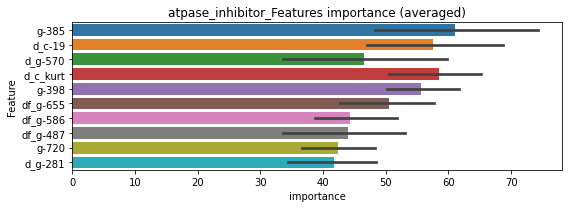

len(train_index) : 3843
len(valid_index) : 3844
================================= fold 1/2 atpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0316779	valid_1's binary_logloss: 0.073816
[200]	training's binary_logloss: 0.00680828	valid_1's binary_logloss: 0.049271
[300]	training's binary_logloss: 0.00208718	valid_1's binary_logloss: 0.0434095
Early stopping, best iteration is:
[332]	training's binary_logloss: 0.00156562	valid_1's binary_logloss: 0.042796


len(train_index) : 3844
len(valid_index) : 3843
================================= fold 2/2 atpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.033394	valid_1's binary_logloss: 0.0898468
[200]	training's binary_logloss: 0.0073661	valid_1's binary_logloss: 0.0673361
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.00254688	valid_1's binary_logloss: 0.0628223


atpase_inhibitor logloss: 0.05280784586818511
atr_kinase_inhibitor, len(trt): 19, len(othr): 3286, target_rate: 0.0007979 → Adj_target_rate: 0.0010260


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0195478	valid_1's binary_logloss: 0.0274262
[200]	training's binary_logloss: 0.00199922	valid_1's binary_logloss: 0.0059254
[300]	training's binary_logloss: 0.00057331	valid_1's binary_logloss: 0.0032484
[400]	training's binary_logloss: 0.000325733	valid_1's binary_logloss: 0.00259737
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.000280797	valid_1's binary_logloss: 0.00244198
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0197902	valid_1's binary_logloss: 0.0248769
[200]	training's binary_logloss: 0.00202973	valid_1's binary_logloss: 0.00450014
[300]	training's binary_logloss: 0.000579329	valid_1's binary_logloss: 0.00205731
[400]	training's binary_logloss: 0.000335052	valid_1's binary_logloss: 0.00145935
[500]	training's binary_logloss: 0.000284992	valid_1's binary_logloss: 0.00135165
Early stopping, best iteration is:

1 / 3 AUC score:1.000
y_Threshold: 0.0017642, Threshold: 0.0043756, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00080, Num_p_label: 80.0, conf_0:0.00394, conf_1:0.00481
Num_p_label: 80.0, Expected: 3.2, Adj_threshold_1: 0.0043756
Num_p_label: 32.0, Expected: 3.2, Adj_threshold_2: 0.0143756
Num_p_label: 27.0, Expected: 3.2, Adj_threshold_3: 0.0243756
Num_p_label: 23.0, Expected: 3.2, Adj_threshold_4: 0.0343756
Num_p_label: 18.0, Expected: 3.2, Adj_threshold_5: 0.0443756
Num_p_label: 16.0, Expected: 3.2, Adj_threshold_6: 0.0543756
Num_p_label: 13.0, Expected: 3.2, Adj_threshold_7: 0.0643756
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_8: 0.0743756
Num_p_label: 10.0, Expected: 3.2, Adj_threshold_9: 0.0843756
Num_p_label: 10.0, Expected: 3.2, Adj_threshold_10: 0.0943756
threshold: 0.1043756, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0195214	valid_1's binary_logloss: 0.0250214
[200]	training's binary_logloss: 0.00184379	valid_1's binary_logloss: 0.00358153
[300]	training's binary_logloss: 0.000496652	valid_1's binary_logloss: 0.00139278
[400]	training's binary_logloss: 0.000292546	valid_1's binary_logloss: 0.000944357
[500]	training's binary_logloss: 0.000258983	valid_1's binary_logloss: 0.000878412
Early stopping, best iteration is:
[522]	training's binary_logloss: 0.00025521	valid_1's binary_logloss: 0.000874206
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0198703	valid_1's binary_logloss: 0.0235823
[200]	training's binary_logloss: 0.00191744	valid_1's binary_logloss: 0.00371944
[300]	training's binary_logloss: 0.000512598	valid_1's binary_logloss: 0.00150708
[400]	training's binary_logloss: 0.000298276	valid_1's binary_logloss: 0.00112245
[500]	training's binary_loglo

2 / 3 AUC score:1.000
y_Threshold: 0.1777247, Threshold: 0.1043756, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0133099 Vs.target_rate: 0.00080, Num_p_label: 53.0, conf_0:0.09394, conf_1:0.11481
Num_p_label: 53.0, Expected: 3.2, Adj_threshold_1: 0.1043756
Num_p_label: 53.0, Expected: 3.2, Adj_threshold_2: 0.1143756
Num_p_label: 50.0, Expected: 3.2, Adj_threshold_3: 0.1243756
Num_p_label: 49.0, Expected: 3.2, Adj_threshold_4: 0.1343756
Num_p_label: 47.0, Expected: 3.2, Adj_threshold_5: 0.1443756
Num_p_label: 46.0, Expected: 3.2, Adj_threshold_6: 0.1543756
Num_p_label: 43.0, Expected: 3.2, Adj_threshold_7: 0.1643756
Num_p_label: 42.0, Expected: 3.2, Adj_threshold_8: 0.1743756
Num_p_label: 40.0, Expected: 3.2, Adj_threshold_9: 0.1843756
Num_p_label: 39.0, Expected: 3.2, Adj_threshold_10: 0.1943756
threshold: 0.2043756, positive_p_label: 36.0/3982, p_label_rate: 0.0090407
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0195214	valid_1's binary_logloss: 0.0250214
[200]	training's binary_logloss: 0.00184379	valid_1's binary_logloss: 0.00358153
[300]	training's binary_logloss: 0.000496652	valid_1's binary_logloss: 0.00139278
[400]	training's binary_logloss: 0.000292546	valid_1's binary_logloss: 0.000944357
[500]	training's binary_logloss: 0.000258983	valid_1's binary_logloss: 0.000878412
Early stopping, best iteration is:
[522]	training's binary_logloss: 0.00025521	valid_1's binary_logloss: 0.000874206
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0198703	valid_1's binary_logloss: 0.0235823
[200]	training's binary_logloss: 0.00191744	valid_1's binary_logloss: 0.00371944
[300]	training's binary_logloss: 0.000512598	valid_1's binary_logloss: 0.00150708
[400]	training's binary_logloss: 0.000298276	valid_1's binary_logloss: 0.00112245
[500]	training's binary_loglo

3 / 3 AUC score:1.000
y_Threshold: 0.1777247, Threshold: 0.2043756, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0090407 Vs.target_rate: 0.00080, Num_p_label: 36.0, conf_0:0.18394, conf_1:0.22481
Num_p_label: 36.0, Expected: 3.2, Adj_threshold_1: 0.2043756
Num_p_label: 35.0, Expected: 3.2, Adj_threshold_2: 0.2143756
Num_p_label: 33.0, Expected: 3.2, Adj_threshold_3: 0.2243756
Num_p_label: 32.0, Expected: 3.2, Adj_threshold_4: 0.2343756
Num_p_label: 30.0, Expected: 3.2, Adj_threshold_5: 0.2443756
Num_p_label: 29.0, Expected: 3.2, Adj_threshold_6: 0.2543756
Num_p_label: 28.0, Expected: 3.2, Adj_threshold_7: 0.2643756
Num_p_label: 28.0, Expected: 3.2, Adj_threshold_8: 0.2743756
Num_p_label: 28.0, Expected: 3.2, Adj_threshold_9: 0.2843756
Num_p_label: 28.0, Expected: 3.2, Adj_threshold_10: 0.2943756
threshold: 0.3043756, positive_p_label: 28.0/3982, p_label_rate: 0.0070316
positive_y_label: 685.0/7793, y_label_rate: 0.0878994


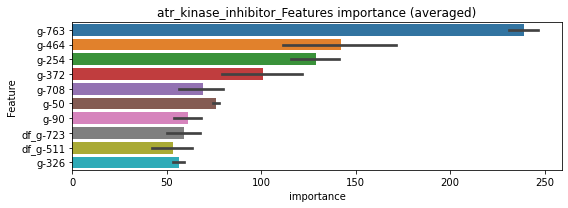

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 atr_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0111277	valid_1's binary_logloss: 0.0200721
[200]	training's binary_logloss: 0.00122933	valid_1's binary_logloss: 0.00850918
Early stopping, best iteration is:
[278]	training's binary_logloss: 0.000405833	valid_1's binary_logloss: 0.007609


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 atr_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0114645	valid_1's binary_logloss: 0.0183735
[200]	training's binary_logloss: 0.00125047	valid_1's binary_logloss: 0.00723866
[300]	training's binary_logloss: 0.000342249	valid_1's binary_logloss: 0.00623931
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.000229751	valid_1's binary_logloss: 0.00605369


atr_kinase_inhibitor logloss: 0.006831445375449584
aurora_kinase_inhibitor, len(trt): 96, len(othr): 3273, target_rate: 0.0040312 → Adj_target_rate: 0.0040656


neg labels: 3289 → selected neg labels: 3273


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0385214	valid_1's binary_logloss: 0.0745001
[200]	training's binary_logloss: 0.006618	valid_1's binary_logloss: 0.0375211
[300]	training's binary_logloss: 0.00199387	valid_1's binary_logloss: 0.0282444
Early stopping, best iteration is:
[344]	training's binary_logloss: 0.00137701	valid_1's binary_logloss: 0.0268416
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0386532	valid_1's binary_logloss: 0.0813389
[200]	training's binary_logloss: 0.00688487	valid_1's binary_logloss: 0.0392805
[300]	training's binary_logloss: 0.00204332	valid_1's binary_logloss: 0.0291046
[400]	training's binary_logloss: 0.000970714	valid_1's binary_logloss: 0.025284
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000708484	valid_1's binary_logloss: 0.0240736


1 / 3 AUC score:0.999
y_Threshold: 0.0197819, Threshold: 0.0583791, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 654/3795
p_label_rate: 0.0200904 Vs.target_rate: 0.00403, Num_p_label: 80.0, conf_0:0.05254, conf_1:0.06422
Num_p_label: 80.0, Expected: 16.1, Adj_threshold_1: 0.0583791
Num_p_label: 75.0, Expected: 16.1, Adj_threshold_2: 0.0683791
Num_p_label: 71.0, Expected: 16.1, Adj_threshold_3: 0.0783791
Num_p_label: 66.0, Expected: 16.1, Adj_threshold_4: 0.0883791
Num_p_label: 61.0, Expected: 16.1, Adj_threshold_5: 0.0983791
Num_p_label: 59.0, Expected: 16.1, Adj_threshold_6: 0.1083791
Num_p_label: 57.0, Expected: 16.1, Adj_threshold_7: 0.1183791
Num_p_label: 55.0, Expected: 16.1, Adj_threshold_8: 0.1283791
Num_p_label: 54.0, Expected: 16.1, Adj_threshold_9: 0.1383791
Num_p_label: 53.0, Expected: 16.1, Adj_threshold_10: 0.1483791
threshold: 0.1583791, positive_p_label: 51.0/3982, p_label_rate: 0.0128076
positive_y_label: 654.0/3795, y_label_rate: 0.172332

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0346928	valid_1's binary_logloss: 0.0606439
[200]	training's binary_logloss: 0.00532486	valid_1's binary_logloss: 0.0244793
[300]	training's binary_logloss: 0.00158791	valid_1's binary_logloss: 0.0162612
[400]	training's binary_logloss: 0.000791675	valid_1's binary_logloss: 0.0140251
Early stopping, best iteration is:
[484]	training's binary_logloss: 0.000558381	valid_1's binary_logloss: 0.0127972
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0349032	valid_1's binary_logloss: 0.0689817
[200]	training's binary_logloss: 0.00550099	valid_1's binary_logloss: 0.0270373
[300]	training's binary_logloss: 0.0016196	valid_1's binary_logloss: 0.0166706
[400]	training's binary_logloss: 0.000801838	valid_1's binary_logloss: 0.0134028
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.000612387	valid_1's binary_logloss: 0.0126644


2 / 3 AUC score:1.000
y_Threshold: 0.1893931, Threshold: 0.1583791, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 10 → Positive_corect_labels: 649.0/3785
p_label_rate: 0.0223506 Vs.target_rate: 0.00403, Num_p_label: 89.0, conf_0:0.14254, conf_1:0.17422
Num_p_label: 89.0, Expected: 16.1, Adj_threshold_1: 0.1583791
Num_p_label: 86.0, Expected: 16.1, Adj_threshold_2: 0.1683791
Num_p_label: 84.0, Expected: 16.1, Adj_threshold_3: 0.1783791
Num_p_label: 81.0, Expected: 16.1, Adj_threshold_4: 0.1883791
Num_p_label: 78.0, Expected: 16.1, Adj_threshold_5: 0.1983791
Num_p_label: 76.0, Expected: 16.1, Adj_threshold_6: 0.2083791
Num_p_label: 74.0, Expected: 16.1, Adj_threshold_7: 0.2183791
Num_p_label: 72.0, Expected: 16.1, Adj_threshold_8: 0.2283791
Num_p_label: 69.0, Expected: 16.1, Adj_threshold_9: 0.2383791
Num_p_label: 68.0, Expected: 16.1, Adj_threshold_10: 0.2483791
threshold: 0.2583791, positive_p_label: 68.0/3982, p_label_rate: 0.0170768
positive_y_label: 649.0/3785, y_label_rate: 0.17146

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0342796	valid_1's binary_logloss: 0.0728032
[200]	training's binary_logloss: 0.005264	valid_1's binary_logloss: 0.036973
[300]	training's binary_logloss: 0.0015515	valid_1's binary_logloss: 0.0301919
[400]	training's binary_logloss: 0.000769507	valid_1's binary_logloss: 0.0273959
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000632568	valid_1's binary_logloss: 0.026643
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0337312	valid_1's binary_logloss: 0.0675825
[200]	training's binary_logloss: 0.00520407	valid_1's binary_logloss: 0.0342957
[300]	training's binary_logloss: 0.00157898	valid_1's binary_logloss: 0.0275519
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.00149323	valid_1's binary_logloss: 0.0273962


3 / 3 AUC score:0.999
y_Threshold: 0.0659107, Threshold: 0.2583791, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 22 → Positive_corect_labels: 638.0/3763
p_label_rate: 0.0208438 Vs.target_rate: 0.00403, Num_p_label: 83.0, conf_0:0.23254, conf_1:0.28422
Num_p_label: 83.0, Expected: 16.1, Adj_threshold_1: 0.2583791
Num_p_label: 79.0, Expected: 16.1, Adj_threshold_2: 0.2683791
Num_p_label: 75.0, Expected: 16.1, Adj_threshold_3: 0.2783791
Num_p_label: 73.0, Expected: 16.1, Adj_threshold_4: 0.2883791
Num_p_label: 70.0, Expected: 16.1, Adj_threshold_5: 0.2983791
Num_p_label: 68.0, Expected: 16.1, Adj_threshold_6: 0.3083791
Num_p_label: 67.0, Expected: 16.1, Adj_threshold_7: 0.3183791
Num_p_label: 67.0, Expected: 16.1, Adj_threshold_8: 0.3283791
Num_p_label: 67.0, Expected: 16.1, Adj_threshold_9: 0.3383791
Num_p_label: 67.0, Expected: 16.1, Adj_threshold_10: 0.3483791
threshold: 0.3583791, positive_p_label: 64.0/3982, p_label_rate: 0.0160723
positive_y_label: 702.0/7745, y_label_rate: 0.09063

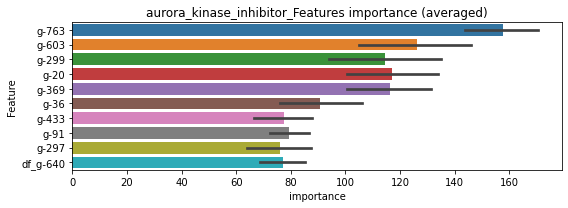

len(train_index) : 3872
len(valid_index) : 3873
================================= fold 1/2 aurora_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0194624	valid_1's binary_logloss: 0.0429326
[200]	training's binary_logloss: 0.0030371	valid_1's binary_logloss: 0.0233665
[300]	training's binary_logloss: 0.000904533	valid_1's binary_logloss: 0.0196571
Early stopping, best iteration is:
[373]	training's binary_logloss: 0.000522791	valid_1's binary_logloss: 0.0188826


len(train_index) : 3873
len(valid_index) : 3872
================================= fold 2/2 aurora_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0197958	valid_1's binary_logloss: 0.0476416
[200]	training's binary_logloss: 0.00291641	valid_1's binary_logloss: 0.0282056
[300]	training's binary_logloss: 0.000864589	valid_1's binary_logloss: 0.0241691
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.000948742	valid_1's binary_logloss: 0.0241064


aurora_kinase_inhibitor logloss: 0.021494185976999015


neg labels: 3289 → selected neg labels: 3288


autotaxin_inhibitor, len(trt): 6, len(othr): 3288, target_rate: 0.0002520 → Adj_target_rate: 0.0003851
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160307	valid_1's binary_logloss: 0.0175897
[200]	training's binary_logloss: 0.0013669	valid_1's binary_logloss: 0.00239752
[300]	training's binary_logloss: 0.000368117	valid_1's binary_logloss: 0.00104279
[400]	training's binary_logloss: 0.000222188	valid_1's binary_logloss: 0.000794859
Early stopping, best iteration is:
[477]	training's binary_logloss: 0.000201931	valid_1's binary_logloss: 0.000762771
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163244	valid_1's binary_logloss: 0.0184403
[200]	training's binary_logloss: 0.00136786	valid_1's binary_logloss: 0.00240846
[300]	training's binary_logloss: 0.000366752	valid_1's binary_logloss: 0.000817769
[400]	training's binary_logloss: 0.000223119	valid_1's binary_logloss: 0.000528219


1 / 3 AUC score:1.000


Early stopping, best iteration is:
[481]	training's binary_logloss: 0.000202774	valid_1's binary_logloss: 0.000492151


y_Threshold: 0.0005858, Threshold: 0.0010958, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0200904 Vs.target_rate: 0.00025, Num_p_label: 80.0, conf_0:0.00099, conf_1:0.00121
Num_p_label: 80.0, Expected: 1.0, Adj_threshold_1: 0.0010958
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_2: 0.0110958
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_3: 0.0210958
threshold: 0.0210958, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162325	valid_1's binary_logloss: 0.0175384
[200]	training's binary_logloss: 0.00134542	valid_1's binary_logloss: 0.00242075
[300]	training's binary_logloss: 0.000360753	valid_1's binary_logloss: 0.00113085
[400]	training's binary_logloss: 0.000220288	valid_1's binary_logloss: 0.000917508
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000196134	valid_1's binary_logloss: 0.000881055
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.016585	valid_1's binary_logloss: 0.0188271
[200]	training's binary_logloss: 0.00135591	valid_1's binary_logloss: 0.00257196
[300]	training's binary_logloss: 0.000359504	valid_1's binary_logloss: 0.000971475
[400]	training's binary_logloss: 0.00022185	valid_1's binary_logloss: 0.000719478
[500]	training's binary_logloss: 0.000197803	valid_1's binary_logloss: 0.000658117
Early stopping, best iterati

2 / 3 AUC score:1.000
y_Threshold: 0.0695192, Threshold: 0.0210958, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0030136 Vs.target_rate: 0.00025, Num_p_label: 12.0, conf_0:0.01899, conf_1:0.02321
Num_p_label: 12.0, Expected: 1.0, Adj_threshold_1: 0.0210958
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_2: 0.0310958
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_3: 0.0410958
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_4: 0.0510958
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_5: 0.0610958
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_6: 0.0710958
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_7: 0.0810958
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_8: 0.0910958
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_9: 0.1010958
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_10: 0.1110958
threshold: 0.1110958, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= 

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162325	valid_1's binary_logloss: 0.0175384
[200]	training's binary_logloss: 0.00134542	valid_1's binary_logloss: 0.00242075
[300]	training's binary_logloss: 0.000360753	valid_1's binary_logloss: 0.00113085
[400]	training's binary_logloss: 0.000220288	valid_1's binary_logloss: 0.000917508
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000196134	valid_1's binary_logloss: 0.000881055
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.016585	valid_1's binary_logloss: 0.0188271
[200]	training's binary_logloss: 0.00135591	valid_1's binary_logloss: 0.00257196
[300]	training's binary_logloss: 0.000359504	valid_1's binary_logloss: 0.000971475
[400]	training's binary_logloss: 0.00022185	valid_1's binary_logloss: 0.000719478
[500]	training's binary_logloss: 0.000197803	valid_1's binary_logloss: 0.000658117
Early stopping, best iterati

3 / 3 AUC score:1.000
y_Threshold: 0.0695192, Threshold: 0.1110958, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0005023 Vs.target_rate: 0.00025, Num_p_label: 2.0, conf_0:0.09999, conf_1:0.12221
threshold: 0.1110958, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 659.0/7795, y_label_rate: 0.0845414


len(train_index) : 3897
len(valid_index) : 3898
================================= fold 1/2 autotaxin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00858657	valid_1's binary_logloss: 0.0112469
[200]	training's binary_logloss: 0.000707356	valid_1's binary_logloss: 0.00381256
Early stopping, best iteration is:
[269]	training's binary_logloss: 0.000251314	valid_1's binary_logloss: 0.00327999


len(train_index) : 3898
len(valid_index) : 3897
================================= fold 2/2 autotaxin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00871042	valid_1's binary_logloss: 0.0104438
[200]	training's binary_logloss: 0.000733671	valid_1's binary_logloss: 0.00204205
[300]	training's binary_logloss: 0.000190064	valid_1's binary_logloss: 0.00148825
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.000175871	valid_1's binary_logloss: 0.00148085


autotaxin_inhibitor logloss: 0.002380537088020143
bacterial_30s_ribosomal_subunit_inhibitor, len(trt): 60, len(othr): 3279, target_rate: 0.0025195 → Adj_target_rate: 0.0027266


neg labels: 3289 → selected neg labels: 3279


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0484432	valid_1's binary_logloss: 0.110528
[200]	training's binary_logloss: 0.00980558	valid_1's binary_logloss: 0.0662466
[300]	training's binary_logloss: 0.00283617	valid_1's binary_logloss: 0.0569572
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00245541	valid_1's binary_logloss: 0.0564274
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0545856	valid_1's binary_logloss: 0.0953708
[200]	training's binary_logloss: 0.0112913	valid_1's binary_logloss: 0.041271
[300]	training's binary_logloss: 0.00321154	valid_1's binary_logloss: 0.0255788
[400]	training's binary_logloss: 0.00143982	valid_1's binary_logloss: 0.0207514
[500]	training's binary_logloss: 0.000872823	valid_1's binary_logloss: 0.0182847
[600]	training's binary_logloss: 0.000649101	valid_1's binary_logloss: 0.0169353
Early stopping, best iteration is:
[615]	train

1 / 3 AUC score:0.998
y_Threshold: 0.0101515, Threshold: 0.0122553, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 146 → Positive_corect_labels: 648/3788
p_label_rate: 0.0200904 Vs.target_rate: 0.00252, Num_p_label: 80.0, conf_0:0.01103, conf_1:0.01348
Num_p_label: 80.0, Expected: 10.0, Adj_threshold_1: 0.0122553
Num_p_label: 22.0, Expected: 10.0, Adj_threshold_2: 0.0222553
Num_p_label: 8.0, Expected: 10.0, Adj_threshold_3: 0.0322553
threshold: 0.0322553, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 648.0/3788, y_label_rate: 0.1710665
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0502836	valid_1's binary_logloss: 0.0904488
[200]	training's binary_logloss: 0.00966873	valid_1's binary_logloss: 0.0392759
[300]	training's binary_logloss: 0.00278058	valid_1's binary_logloss: 0.0254261
[400]	training's binary_logloss: 0.00129557	valid_1's binary_logloss: 0.0218083
Early stopping, best iteration is:
[407]	training's binary_logloss: 0.00124265	valid_1's binary_logloss: 0.0217172
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0510961	valid_1's binary_logloss: 0.0943753
[200]	training's binary_logloss: 0.0101025	valid_1's binary_logloss: 0.0407074
[300]	training's binary_logloss: 0.00289915	valid_1's binary_logloss: 0.0255226
[400]	training's binary_logloss: 0.00133979	valid_1's binary_logloss: 0.021275
[500]	training's binary_logloss: 0.000835612	valid_1's binary_logloss: 0.018668
Early stopping, best iteration is:
[571]	traini

2 / 3 AUC score:1.000
y_Threshold: 0.0483159, Threshold: 0.0322553, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 646.0/3784
p_label_rate: 0.0030136 Vs.target_rate: 0.00252, Num_p_label: 12.0, conf_0:0.02903, conf_1:0.03548
threshold: 0.0322553, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 646.0/3784, y_label_rate: 0.1707188
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0483267	valid_1's binary_logloss: 0.100652
[200]	training's binary_logloss: 0.00936985	valid_1's binary_logloss: 0.0553773
[300]	training's binary_logloss: 0.0026864	valid_1's binary_logloss: 0.0441554
Early stopping, best iteration is:
[364]	training's binary_logloss: 0.001582	valid_1's binary_logloss: 0.041767
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0523982	valid_1's binary_logloss: 0.0989351
[200]	training's binary_logloss: 0.0103694	valid_1's binary_logloss: 0.0486875
[300]	training's binary_logloss: 0.00295355	valid_1's binary_logloss: 0.0359252
[400]	training's binary_logloss: 0.00136211	valid_1's binary_logloss: 0.0326969
Early stopping, best iteration is:
[394]	training's binary_logloss: 0.00141468	valid_1's binary_logloss: 0.0326158


3 / 3 AUC score:0.999
y_Threshold: 0.0281468, Threshold: 0.0322553, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 18 → Positive_corect_labels: 637.0/3766
p_label_rate: 0.0042692 Vs.target_rate: 0.00252, Num_p_label: 17.0, conf_0:0.02903, conf_1:0.03548
threshold: 0.0322553, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 654.0/7748, y_label_rate: 0.0844089


len(train_index) : 3874
len(valid_index) : 3874
================================= fold 1/2 bacterial_30s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0280655	valid_1's binary_logloss: 0.0617243
[200]	training's binary_logloss: 0.00547284	valid_1's binary_logloss: 0.0367734
[300]	training's binary_logloss: 0.00159459	valid_1's binary_logloss: 0.0314116
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.00119337	valid_1's binary_logloss: 0.0307336


len(train_index) : 3874
len(valid_index) : 3874
================================= fold 2/2 bacterial_30s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0306708	valid_1's binary_logloss: 0.0531145
[200]	training's binary_logloss: 0.00632111	valid_1's binary_logloss: 0.0253799
[300]	training's binary_logloss: 0.00176296	valid_1's binary_logloss: 0.0190712
Early stopping, best iteration is:
[337]	training's binary_logloss: 0.00123239	valid_1's binary_logloss: 0.0182121


bacterial_30s_ribosomal_subunit_inhibitor logloss: 0.02447282674918224
bacterial_50s_ribosomal_subunit_inhibitor, len(trt): 80, len(othr): 3277, target_rate: 0.0033594 → Adj_target_rate: 0.0034820


neg labels: 3289 → selected neg labels: 3277


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0529122	valid_1's binary_logloss: 0.120803
[200]	training's binary_logloss: 0.0112663	valid_1's binary_logloss: 0.0747282
[300]	training's binary_logloss: 0.00340999	valid_1's binary_logloss: 0.0643588
Early stopping, best iteration is:
[339]	training's binary_logloss: 0.00239032	valid_1's binary_logloss: 0.0627467
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0555334	valid_1's binary_logloss: 0.11759
[200]	training's binary_logloss: 0.0128151	valid_1's binary_logloss: 0.073357
[300]	training's binary_logloss: 0.00377437	valid_1's binary_logloss: 0.0615176
Early stopping, best iteration is:
[377]	training's binary_logloss: 0.00199075	valid_1's binary_logloss: 0.0578661


1 / 3 AUC score:0.997
y_Threshold: 0.0127870, Threshold: 0.0169710, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 154 → Positive_corect_labels: 644/3778
p_label_rate: 0.0200904 Vs.target_rate: 0.00336, Num_p_label: 80.0, conf_0:0.01527, conf_1:0.01867
Num_p_label: 80.0, Expected: 13.4, Adj_threshold_1: 0.0169710
Num_p_label: 25.0, Expected: 13.4, Adj_threshold_2: 0.0269710
threshold: 0.0269710, positive_p_label: 25.0/3982, p_label_rate: 0.0062783
positive_y_label: 644.0/3778, y_label_rate: 0.1704606
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.055468	valid_1's binary_logloss: 0.113656
[200]	training's binary_logloss: 0.0121519	valid_1's binary_logloss: 0.0600859
[300]	training's binary_logloss: 0.00365464	valid_1's binary_logloss: 0.042864
[400]	training's binary_logloss: 0.00164837	valid_1's binary_logloss: 0.0370415
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.00107105	valid_1's binary_logloss: 0.0348422
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0533998	valid_1's binary_logloss: 0.0995096
[200]	training's binary_logloss: 0.0115015	valid_1's binary_logloss: 0.0522726
[300]	training's binary_logloss: 0.0035082	valid_1's binary_logloss: 0.0404255
[400]	training's binary_logloss: 0.00164172	valid_1's binary_logloss: 0.0363479
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00119999	valid_1's binary_logloss: 0.0353504


2 / 3 AUC score:1.000
y_Threshold: 0.0245728, Threshold: 0.0269710, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 10 → Positive_corect_labels: 639.0/3768
p_label_rate: 0.0052737 Vs.target_rate: 0.00336, Num_p_label: 21.0, conf_0:0.02427, conf_1:0.02967
threshold: 0.0269710, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 639.0/3768, y_label_rate: 0.1695860
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.052029	valid_1's binary_logloss: 0.105104
[200]	training's binary_logloss: 0.0104682	valid_1's binary_logloss: 0.0600859
[300]	training's binary_logloss: 0.00320257	valid_1's binary_logloss: 0.0484151
Early stopping, best iteration is:
[366]	training's binary_logloss: 0.00186405	valid_1's binary_logloss: 0.0460964
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0551261	valid_1's binary_logloss: 0.0958267
[200]	training's binary_logloss: 0.0120168	valid_1's binary_logloss: 0.046687
[300]	training's binary_logloss: 0.00362094	valid_1's binary_logloss: 0.0332724
[400]	training's binary_logloss: 0.00165722	valid_1's binary_logloss: 0.0292217
[500]	training's binary_logloss: 0.0010226	valid_1's binary_logloss: 0.0273859
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.00100241	valid_1's binary_logloss: 0.0273193


3 / 3 AUC score:1.000
y_Threshold: 0.0222366, Threshold: 0.0269710, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 635.0/3760
p_label_rate: 0.0065294 Vs.target_rate: 0.00336, Num_p_label: 26.0, conf_0:0.02427, conf_1:0.02967
threshold: 0.0269710, positive_p_label: 26.0/3982, p_label_rate: 0.0065294
positive_y_label: 661.0/7742, y_label_rate: 0.0853785


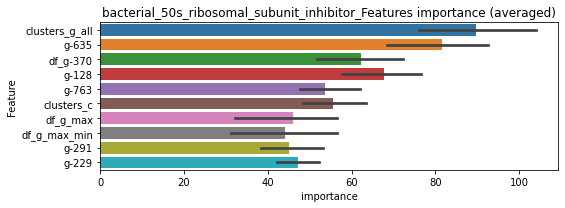

len(train_index) : 3871
len(valid_index) : 3871
================================= fold 1/2 bacterial_50s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0274296	valid_1's binary_logloss: 0.0750741
[200]	training's binary_logloss: 0.00557676	valid_1's binary_logloss: 0.055193
[300]	training's binary_logloss: 0.00168402	valid_1's binary_logloss: 0.0508048
Early stopping, best iteration is:
[317]	training's binary_logloss: 0.00144354	valid_1's binary_logloss: 0.0502303


len(train_index) : 3871
len(valid_index) : 3871
================================= fold 2/2 bacterial_50s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0315516	valid_1's binary_logloss: 0.0692332
[200]	training's binary_logloss: 0.0070078	valid_1's binary_logloss: 0.0454407
Early stopping, best iteration is:
[273]	training's binary_logloss: 0.00274481	valid_1's binary_logloss: 0.0411646


bacterial_50s_ribosomal_subunit_inhibitor logloss: 0.045697437902236376
bacterial_antifolate, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0327969	valid_1's binary_logloss: 0.0568017
[200]	training's binary_logloss: 0.00509246	valid_1's binary_logloss: 0.0246174
[300]	training's binary_logloss: 0.00147692	valid_1's binary_logloss: 0.0175981
Early stopping, best iteration is:
[378]	training's binary_logloss: 0.000829931	valid_1's binary_logloss: 0.0159685
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0358377	valid_1's binary_logloss: 0.0539448
[200]	training's binary_logloss: 0.00569571	valid_1's binary_logloss: 0.0160662
[300]	training's binary_logloss: 0.00160043	valid_1's binary_logloss: 0.00853367
[400]	training's binary_logloss: 0.000782286	valid_1's binary_logloss: 0.00656957
[500]	training's binary_logloss: 0.000523994	valid_1's binary_logloss: 0.00574164
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.000485683	valid_1's binary_logloss: 0.00562022


1 / 3 AUC score:1.000
y_Threshold: 0.0048108, Threshold: 0.0074723, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00151, Num_p_label: 80.0, conf_0:0.00673, conf_1:0.00822
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0074723
Num_p_label: 24.0, Expected: 6.0, Adj_threshold_2: 0.0174723
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_3: 0.0274723
Num_p_label: 7.0, Expected: 6.0, Adj_threshold_4: 0.0374723
threshold: 0.0374723, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0338651	valid_1's binary_logloss: 0.0545645
[200]	training's binary_logloss: 0.00508512	valid_1's binary_logloss: 0.0201756
[300]	training's binary_logloss: 0.00144689	valid_1's binary_logloss: 0.0136263
[400]	training's binary_logloss: 0.000726793	valid_1's binary_logloss: 0.0121851
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.000549787	valid_1's binary_logloss: 0.0116649
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0344075	valid_1's binary_logloss: 0.0530494
[200]	training's binary_logloss: 0.00524278	valid_1's binary_logloss: 0.0151126
[300]	training's binary_logloss: 0.00152246	valid_1's binary_logloss: 0.00818737
[400]	training's binary_logloss: 0.000761201	valid_1's binary_logloss: 0.00626908
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000534721	valid_1's binary_logloss: 0.00527433


2 / 3 AUC score:1.000
y_Threshold: 0.0505851, Threshold: 0.0374723, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0050226 Vs.target_rate: 0.00151, Num_p_label: 20.0, conf_0:0.03373, conf_1:0.04122
Num_p_label: 20.0, Expected: 6.0, Adj_threshold_1: 0.0374723
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_2: 0.0474723
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_3: 0.0574723
threshold: 0.0574723, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 655.0/3805, y_label_rate: 0.1721419
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0334133	valid_1's binary_logloss: 0.0536235
[200]	training's binary_logloss: 0.00509527	valid_1's binary_logloss: 0.0176023
[300]	training's binary_logloss: 0.00146718	valid_1's binary_logloss: 0.0106733
[400]	training's binary_logloss: 0.000733191	valid_1's binary_logloss: 0.00870831
[500]	training's binary_logloss: 0.000498019	valid_1's binary_logloss: 0.00788975
Early stopping, best iteration is:
[492]	training's binary_logloss: 0.000507903	valid_1's binary_logloss: 0.00786997
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0335101	valid_1's binary_logloss: 0.054271
[200]	training's binary_logloss: 0.0051116	valid_1's binary_logloss: 0.0155002
[300]	training's binary_logloss: 0.00144401	valid_1's binary_logloss: 0.00911398
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.000907248	valid_1's binary_logloss: 0.00800243


3 / 3 AUC score:1.000
y_Threshold: 0.0393822, Threshold: 0.0574723, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0035158 Vs.target_rate: 0.00151, Num_p_label: 14.0, conf_0:0.05173, conf_1:0.06322
threshold: 0.0574723, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 669.0/7787, y_label_rate: 0.0859124


len(train_index) : 3893
len(valid_index) : 3894
================================= fold 1/2 bacterial_antifolate=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185898	valid_1's binary_logloss: 0.0402926
[200]	training's binary_logloss: 0.00282285	valid_1's binary_logloss: 0.0208677
Early stopping, best iteration is:
[251]	training's binary_logloss: 0.00135944	valid_1's binary_logloss: 0.0185993


len(train_index) : 3894
len(valid_index) : 3893
================================= fold 2/2 bacterial_antifolate=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190451	valid_1's binary_logloss: 0.0329933
[200]	training's binary_logloss: 0.00300315	valid_1's binary_logloss: 0.0119907
[300]	training's binary_logloss: 0.000854991	valid_1's binary_logloss: 0.00888022
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.000567865	valid_1's binary_logloss: 0.00833112


bacterial_antifolate logloss: 0.013465886154326813
bacterial_cell_wall_synthesis_inhibitor, len(trt): 192, len(othr): 3259, target_rate: 0.0080625 → Adj_target_rate: 0.0073283


neg labels: 3289 → selected neg labels: 3259


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0913797	valid_1's binary_logloss: 0.22426
[200]	training's binary_logloss: 0.0298853	valid_1's binary_logloss: 0.183357
Early stopping, best iteration is:
[284]	training's binary_logloss: 0.0128693	valid_1's binary_logloss: 0.174575
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100205	valid_1's binary_logloss: 0.226319
[200]	training's binary_logloss: 0.0343739	valid_1's binary_logloss: 0.183953
Early stopping, best iteration is:
[260]	training's binary_logloss: 0.018755	valid_1's binary_logloss: 0.175621


1 / 3 AUC score:0.958
y_Threshold: 0.0632108, Threshold: 0.0871778, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 287 → Positive_corect_labels: 573/3623
p_label_rate: 0.0200904 Vs.target_rate: 0.00806, Num_p_label: 80.0, conf_0:0.07846, conf_1:0.09590
threshold: 0.0871778, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 573.0/3623, y_label_rate: 0.1581562
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0731954	valid_1's binary_logloss: 0.198176
[200]	training's binary_logloss: 0.0208041	valid_1's binary_logloss: 0.162152
Early stopping, best iteration is:
[230]	training's binary_logloss: 0.0146023	valid_1's binary_logloss: 0.157877
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0797408	valid_1's binary_logloss: 0.186831
[200]	training's binary_logloss: 0.023794	valid_1's binary_logloss: 0.143097
Early stopping, best iteration is:
[230]	training's binary_logloss: 0.0173017	valid_1's binary_logloss: 0.13673


2 / 3 AUC score:0.977
y_Threshold: 0.0919891, Threshold: 0.0871778, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 120 → Positive_corect_labels: 513.0/3503
p_label_rate: 0.0283777 Vs.target_rate: 0.00806, Num_p_label: 113.0, conf_0:0.07846, conf_1:0.09590
Num_p_label: 113.0, Expected: 32.1, Adj_threshold_1: 0.0871778
Num_p_label: 80.0, Expected: 32.1, Adj_threshold_2: 0.0971778
Num_p_label: 58.0, Expected: 32.1, Adj_threshold_3: 0.1071778
threshold: 0.1071778, positive_p_label: 58.0/3982, p_label_rate: 0.0145655
positive_y_label: 513.0/3503, y_label_rate: 0.1464459
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.060812	valid_1's binary_logloss: 0.155093
[200]	training's binary_logloss: 0.0163616	valid_1's binary_logloss: 0.110574
[300]	training's binary_logloss: 0.00546353	valid_1's binary_logloss: 0.100964
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00477586	valid_1's binary_logloss: 0.100578
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0712663	valid_1's binary_logloss: 0.148888
[200]	training's binary_logloss: 0.0192913	valid_1's binary_logloss: 0.102113
[300]	training's binary_logloss: 0.00630725	valid_1's binary_logloss: 0.0860315
[400]	training's binary_logloss: 0.0028113	valid_1's binary_logloss: 0.0798544
Early stopping, best iteration is:
[407]	training's binary_logloss: 0.00269592	valid_1's binary_logloss: 0.0795524


3 / 3 AUC score:0.995
y_Threshold: 0.0517400, Threshold: 0.1071778, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 56 → Positive_corect_labels: 485.0/3447
p_label_rate: 0.0037670 Vs.target_rate: 0.00806, Num_p_label: 15.0, conf_0:0.09646, conf_1:0.11790
threshold: 0.1071778, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 500.0/7429, y_label_rate: 0.0673038


len(train_index) : 3714
len(valid_index) : 3715
================================= fold 1/2 bacterial_cell_wall_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0293233	valid_1's binary_logloss: 0.0809531
[200]	training's binary_logloss: 0.00744031	valid_1's binary_logloss: 0.061353
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.00299764	valid_1's binary_logloss: 0.0580613


len(train_index) : 3715
len(valid_index) : 3714
================================= fold 2/2 bacterial_cell_wall_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0324255	valid_1's binary_logloss: 0.0845577
[200]	training's binary_logloss: 0.00896657	valid_1's binary_logloss: 0.0662399
Early stopping, best iteration is:
[238]	training's binary_logloss: 0.00552148	valid_1's binary_logloss: 0.0642384


bacterial_cell_wall_synthesis_inhibitor logloss: 0.06114946021704652
bacterial_dna_gyrase_inhibitor, len(trt): 89, len(othr): 3274, target_rate: 0.0037373 → Adj_target_rate: 0.0038122


neg labels: 3289 → selected neg labels: 3274


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0618562	valid_1's binary_logloss: 0.12552
[200]	training's binary_logloss: 0.015326	valid_1's binary_logloss: 0.0764719
[300]	training's binary_logloss: 0.00473253	valid_1's binary_logloss: 0.0619702
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00226896	valid_1's binary_logloss: 0.0569962
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.063802	valid_1's binary_logloss: 0.126109
[200]	training's binary_logloss: 0.0159543	valid_1's binary_logloss: 0.076619
[300]	training's binary_logloss: 0.00467424	valid_1's binary_logloss: 0.0608692
Early stopping, best iteration is:
[362]	training's binary_logloss: 0.00267071	valid_1's binary_logloss: 0.0579182


1 / 3 AUC score:0.995
y_Threshold: 0.0182167, Threshold: 0.0273097, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 158 → Positive_corect_labels: 641/3770
p_label_rate: 0.0200904 Vs.target_rate: 0.00374, Num_p_label: 80.0, conf_0:0.02458, conf_1:0.03004
Num_p_label: 80.0, Expected: 14.9, Adj_threshold_1: 0.0273097
Num_p_label: 41.0, Expected: 14.9, Adj_threshold_2: 0.0373097
Num_p_label: 25.0, Expected: 14.9, Adj_threshold_3: 0.0473097
threshold: 0.0473097, positive_p_label: 25.0/3982, p_label_rate: 0.0062783
positive_y_label: 641.0/3770, y_label_rate: 0.1700265
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0599576	valid_1's binary_logloss: 0.113415
[200]	training's binary_logloss: 0.0130027	valid_1's binary_logloss: 0.0587979
[300]	training's binary_logloss: 0.00398198	valid_1's binary_logloss: 0.044543
[400]	training's binary_logloss: 0.00179989	valid_1's binary_logloss: 0.0399214
[500]	training's binary_logloss: 0.00110211	valid_1's binary_logloss: 0.0376237
Early stopping, best iteration is:
[566]	training's binary_logloss: 0.000883045	valid_1's binary_logloss: 0.0371567
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0598961	valid_1's binary_logloss: 0.109611
[200]	training's binary_logloss: 0.0141746	valid_1's binary_logloss: 0.0532743
[300]	training's binary_logloss: 0.0044045	valid_1's binary_logloss: 0.0353713
[400]	training's binary_logloss: 0.00198461	valid_1's binary_logloss: 0.0298415
[500]	training's binary_logloss: 0.00119107	valid_

2 / 3 AUC score:0.999
y_Threshold: 0.0370456, Threshold: 0.0473097, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 12 → Positive_corect_labels: 635.0/3758
p_label_rate: 0.0042692 Vs.target_rate: 0.00374, Num_p_label: 17.0, conf_0:0.04258, conf_1:0.05204
threshold: 0.0473097, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 635.0/3758, y_label_rate: 0.1689729
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0583966	valid_1's binary_logloss: 0.1297
[200]	training's binary_logloss: 0.0123661	valid_1's binary_logloss: 0.0783229
[300]	training's binary_logloss: 0.00383693	valid_1's binary_logloss: 0.0663667
Early stopping, best iteration is:
[371]	training's binary_logloss: 0.0020991	valid_1's binary_logloss: 0.0641641
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0568647	valid_1's binary_logloss: 0.116758
[200]	training's binary_logloss: 0.0131236	valid_1's binary_logloss: 0.0635741
[300]	training's binary_logloss: 0.00391148	valid_1's binary_logloss: 0.0476736
[400]	training's binary_logloss: 0.00178147	valid_1's binary_logloss: 0.041882
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.0011658	valid_1's binary_logloss: 0.040604


3 / 3 AUC score:0.997
y_Threshold: 0.0423014, Threshold: 0.0473097, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 28 → Positive_corect_labels: 621.0/3730
p_label_rate: 0.0077850 Vs.target_rate: 0.00374, Num_p_label: 31.0, conf_0:0.04258, conf_1:0.05204
threshold: 0.0473097, positive_p_label: 31.0/3982, p_label_rate: 0.0077850
positive_y_label: 652.0/7712, y_label_rate: 0.0845436


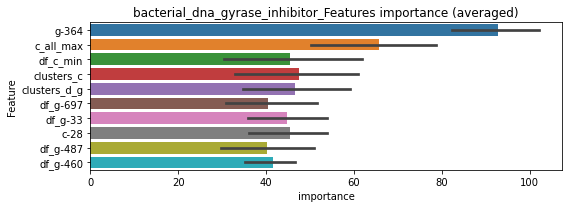

len(train_index) : 3856
len(valid_index) : 3856
================================= fold 1/2 bacterial_dna_gyrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0322129	valid_1's binary_logloss: 0.0797549
[200]	training's binary_logloss: 0.00722542	valid_1's binary_logloss: 0.0556036
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.00257611	valid_1's binary_logloss: 0.0511948


len(train_index) : 3856
len(valid_index) : 3856
================================= fold 2/2 bacterial_dna_gyrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0343498	valid_1's binary_logloss: 0.0793735
[200]	training's binary_logloss: 0.00816364	valid_1's binary_logloss: 0.0537399
Early stopping, best iteration is:
[271]	training's binary_logloss: 0.0033563	valid_1's binary_logloss: 0.0489566


bacterial_dna_gyrase_inhibitor logloss: 0.050075722694787266
bacterial_dna_inhibitor, len(trt): 115, len(othr): 3271, target_rate: 0.0048291 → Adj_target_rate: 0.0047401


neg labels: 3289 → selected neg labels: 3271


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0691314	valid_1's binary_logloss: 0.159564
[200]	training's binary_logloss: 0.0178099	valid_1's binary_logloss: 0.115582
[300]	training's binary_logloss: 0.00567268	valid_1's binary_logloss: 0.101393
Early stopping, best iteration is:
[327]	training's binary_logloss: 0.00437132	valid_1's binary_logloss: 0.0999587
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0776132	valid_1's binary_logloss: 0.148928
[200]	training's binary_logloss: 0.0229522	valid_1's binary_logloss: 0.091649
[300]	training's binary_logloss: 0.00726918	valid_1's binary_logloss: 0.0717892
[400]	training's binary_logloss: 0.00315105	valid_1's binary_logloss: 0.065572
Early stopping, best iteration is:
[439]	training's binary_logloss: 0.00252005	valid_1's binary_logloss: 0.0646027


1 / 3 AUC score:0.992
y_Threshold: 0.0234469, Threshold: 0.0317041, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 179 → Positive_corect_labels: 630/3746
p_label_rate: 0.0200904 Vs.target_rate: 0.00483, Num_p_label: 80.0, conf_0:0.02853, conf_1:0.03487
Num_p_label: 80.0, Expected: 19.2, Adj_threshold_1: 0.0317041
Num_p_label: 43.0, Expected: 19.2, Adj_threshold_2: 0.0417041
Num_p_label: 24.0, Expected: 19.2, Adj_threshold_3: 0.0517041
threshold: 0.0517041, positive_p_label: 24.0/3982, p_label_rate: 0.0060271
positive_y_label: 630.0/3746, y_label_rate: 0.1681794
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0688114	valid_1's binary_logloss: 0.140741
[200]	training's binary_logloss: 0.0181953	valid_1's binary_logloss: 0.0900913
[300]	training's binary_logloss: 0.00576851	valid_1's binary_logloss: 0.0767488
[400]	training's binary_logloss: 0.00254254	valid_1's binary_logloss: 0.0727166
Early stopping, best iteration is:
[397]	training's binary_logloss: 0.0025964	valid_1's binary_logloss: 0.0726018
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0666657	valid_1's binary_logloss: 0.126925
[200]	training's binary_logloss: 0.0179221	valid_1's binary_logloss: 0.0744149
[300]	training's binary_logloss: 0.00566723	valid_1's binary_logloss: 0.0578413
[400]	training's binary_logloss: 0.00249391	valid_1's binary_logloss: 0.0522387
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00174045	valid_1's binary_logloss: 0.0506826


2 / 3 AUC score:0.997
y_Threshold: 0.0498299, Threshold: 0.0517041, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 36 → Positive_corect_labels: 612.0/3710
p_label_rate: 0.0125565 Vs.target_rate: 0.00483, Num_p_label: 50.0, conf_0:0.04653, conf_1:0.05687
threshold: 0.0517041, positive_p_label: 50.0/3982, p_label_rate: 0.0125565
positive_y_label: 612.0/3710, y_label_rate: 0.1649596
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0640965	valid_1's binary_logloss: 0.13381
[200]	training's binary_logloss: 0.0164354	valid_1's binary_logloss: 0.0817201
[300]	training's binary_logloss: 0.00505983	valid_1's binary_logloss: 0.0664862
[400]	training's binary_logloss: 0.00228162	valid_1's binary_logloss: 0.0617527
Early stopping, best iteration is:
[453]	training's binary_logloss: 0.00167357	valid_1's binary_logloss: 0.0606389
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0663276	valid_1's binary_logloss: 0.129091
[200]	training's binary_logloss: 0.0167539	valid_1's binary_logloss: 0.0758886
[300]	training's binary_logloss: 0.00513364	valid_1's binary_logloss: 0.0580912
[400]	training's binary_logloss: 0.00229426	valid_1's binary_logloss: 0.0518985
Early stopping, best iteration is:
[472]	training's binary_logloss: 0.00154832	valid_1's binary_logloss: 0.0491671


3 / 3 AUC score:0.997
y_Threshold: 0.0472645, Threshold: 0.0517041, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 26 → Positive_corect_labels: 599.0/3684
p_label_rate: 0.0095429 Vs.target_rate: 0.00483, Num_p_label: 38.0, conf_0:0.04653, conf_1:0.05687
threshold: 0.0517041, positive_p_label: 38.0/3982, p_label_rate: 0.0095429
positive_y_label: 637.0/7666, y_label_rate: 0.0830942


len(train_index) : 3833
len(valid_index) : 3833
================================= fold 1/2 bacterial_dna_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0386853	valid_1's binary_logloss: 0.0825058
[200]	training's binary_logloss: 0.0100222	valid_1's binary_logloss: 0.0565521
[300]	training's binary_logloss: 0.00315213	valid_1's binary_logloss: 0.0501055
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.00318537	valid_1's binary_logloss: 0.0500949


len(train_index) : 3833
len(valid_index) : 3833
================================= fold 2/2 bacterial_dna_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.039675	valid_1's binary_logloss: 0.0783065
[200]	training's binary_logloss: 0.0103143	valid_1's binary_logloss: 0.0506586
[300]	training's binary_logloss: 0.00319495	valid_1's binary_logloss: 0.0434115
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.00303373	valid_1's binary_logloss: 0.0431939


bacterial_dna_inhibitor logloss: 0.04664438438314122
bacterial_membrane_integrity_inhibitor, len(trt): 19, len(othr): 3285, target_rate: 0.0007979 → Adj_target_rate: 0.0010260


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0232063	valid_1's binary_logloss: 0.0312292
[200]	training's binary_logloss: 0.00274914	valid_1's binary_logloss: 0.0059322
[300]	training's binary_logloss: 0.000781489	valid_1's binary_logloss: 0.00255944
[400]	training's binary_logloss: 0.000419761	valid_1's binary_logloss: 0.00169262
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000350253	valid_1's binary_logloss: 0.00151084
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.024365	valid_1's binary_logloss: 0.0313381
[200]	training's binary_logloss: 0.00291866	valid_1's binary_logloss: 0.00504854
[300]	training's binary_logloss: 0.000813562	valid_1's binary_logloss: 0.00176932
[400]	training's binary_logloss: 0.000430668	valid_1's binary_logloss: 0.00113803
[500]	training's binary_logloss: 0.000353346	valid_1's binary_logloss: 0.0010046
[600]	training's binary_logloss: 0

1 / 3 AUC score:1.000
y_Threshold: 0.0014973, Threshold: 0.0026625, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00080, Num_p_label: 80.0, conf_0:0.00240, conf_1:0.00293
Num_p_label: 80.0, Expected: 3.2, Adj_threshold_1: 0.0026625
Num_p_label: 9.0, Expected: 3.2, Adj_threshold_2: 0.0126625
Num_p_label: 4.0, Expected: 3.2, Adj_threshold_3: 0.0226625
threshold: 0.0226625, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0236902	valid_1's binary_logloss: 0.0313871
[200]	training's binary_logloss: 0.00269628	valid_1's binary_logloss: 0.00555504
[300]	training's binary_logloss: 0.000756954	valid_1's binary_logloss: 0.00231062
[400]	training's binary_logloss: 0.000402426	valid_1's binary_logloss: 0.00154922
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.000343109	valid_1's binary_logloss: 0.00140309
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0237908	valid_1's binary_logloss: 0.0294576
[200]	training's binary_logloss: 0.00276351	valid_1's binary_logloss: 0.00400875
[300]	training's binary_logloss: 0.000777447	valid_1's binary_logloss: 0.00128538
[400]	training's binary_logloss: 0.000408291	valid_1's binary_logloss: 0.000725541
[500]	training's binary_logloss: 0.000337891	valid_1's binary_logloss: 0.000612812
Early stopping, best iteratio

2 / 3 AUC score:1.000
y_Threshold: 0.1457968, Threshold: 0.0226625, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0067805 Vs.target_rate: 0.00080, Num_p_label: 27.0, conf_0:0.02040, conf_1:0.02493
Num_p_label: 27.0, Expected: 3.2, Adj_threshold_1: 0.0226625
Num_p_label: 19.0, Expected: 3.2, Adj_threshold_2: 0.0326625
Num_p_label: 14.0, Expected: 3.2, Adj_threshold_3: 0.0426625
Num_p_label: 12.0, Expected: 3.2, Adj_threshold_4: 0.0526625
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_5: 0.0626625
Num_p_label: 9.0, Expected: 3.2, Adj_threshold_6: 0.0726625
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_7: 0.0826625
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_8: 0.0926625
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_9: 0.1026625
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_10: 0.1126625
threshold: 0.1226625, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
==============

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0236902	valid_1's binary_logloss: 0.0313871
[200]	training's binary_logloss: 0.00269628	valid_1's binary_logloss: 0.00555504
[300]	training's binary_logloss: 0.000756954	valid_1's binary_logloss: 0.00231062
[400]	training's binary_logloss: 0.000402426	valid_1's binary_logloss: 0.00154922
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.000343109	valid_1's binary_logloss: 0.00140309
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0237908	valid_1's binary_logloss: 0.0294576
[200]	training's binary_logloss: 0.00276351	valid_1's binary_logloss: 0.00400875
[300]	training's binary_logloss: 0.000777447	valid_1's binary_logloss: 0.00128538
[400]	training's binary_logloss: 0.000408291	valid_1's binary_logloss: 0.000725541
[500]	training's binary_logloss: 0.000337891	valid_1's binary_logloss: 0.000612812
Early stopping, best iteratio

3 / 3 AUC score:1.000
y_Threshold: 0.1457968, Threshold: 0.1226625, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0015068 Vs.target_rate: 0.00080, Num_p_label: 6.0, conf_0:0.11040, conf_1:0.13493
threshold: 0.1226625, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 663.0/7792, y_label_rate: 0.0850873


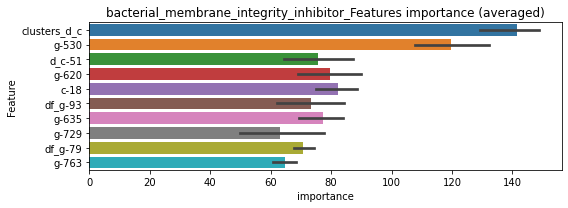

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 bacterial_membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0123044	valid_1's binary_logloss: 0.0201608
[200]	training's binary_logloss: 0.00137386	valid_1's binary_logloss: 0.00685709
[300]	training's binary_logloss: 0.000384398	valid_1's binary_logloss: 0.00551739
Early stopping, best iteration is:
[372]	training's binary_logloss: 0.000234859	valid_1's binary_logloss: 0.00536435


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 bacterial_membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.012589	valid_1's binary_logloss: 0.0160268
[200]	training's binary_logloss: 0.00155335	valid_1's binary_logloss: 0.00280418
[300]	training's binary_logloss: 0.000406116	valid_1's binary_logloss: 0.00131623
[400]	training's binary_logloss: 0.000215767	valid_1's binary_logloss: 0.000995943
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.000187009	valid_1's binary_logloss: 0.000941514


bacterial_membrane_integrity_inhibitor logloss: 0.0031529315661288342
bcl_inhibitor, len(trt): 31, len(othr): 3283, target_rate: 0.0013018 → Adj_target_rate: 0.0015554


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.030486	valid_1's binary_logloss: 0.049039
[200]	training's binary_logloss: 0.00425719	valid_1's binary_logloss: 0.015544
[300]	training's binary_logloss: 0.00120487	valid_1's binary_logloss: 0.00860341
[400]	training's binary_logloss: 0.000595236	valid_1's binary_logloss: 0.00630591
[500]	training's binary_logloss: 0.00042563	valid_1's binary_logloss: 0.00577542
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000421829	valid_1's binary_logloss: 0.00575439
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0313345	valid_1's binary_logloss: 0.0522494
[200]	training's binary_logloss: 0.00432486	valid_1's binary_logloss: 0.0186814
[300]	training's binary_logloss: 0.00122243	valid_1's binary_logloss: 0.0142382
[400]	training's binary_logloss: 0.00060825	valid_1's binary_logloss: 0.0127656
Early stopping, best iteration is:
[410]	t

1 / 3 AUC score:1.000
y_Threshold: 0.0037224, Threshold: 0.0929520, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00130, Num_p_label: 80.0, conf_0:0.08366, conf_1:0.10225
Num_p_label: 80.0, Expected: 5.2, Adj_threshold_1: 0.0929520
Num_p_label: 77.0, Expected: 5.2, Adj_threshold_2: 0.1029520
Num_p_label: 75.0, Expected: 5.2, Adj_threshold_3: 0.1129520
Num_p_label: 72.0, Expected: 5.2, Adj_threshold_4: 0.1229520
Num_p_label: 69.0, Expected: 5.2, Adj_threshold_5: 0.1329520
Num_p_label: 66.0, Expected: 5.2, Adj_threshold_6: 0.1429520
Num_p_label: 63.0, Expected: 5.2, Adj_threshold_7: 0.1529520
Num_p_label: 62.0, Expected: 5.2, Adj_threshold_8: 0.1629520
Num_p_label: 59.0, Expected: 5.2, Adj_threshold_9: 0.1729520
Num_p_label: 55.0, Expected: 5.2, Adj_threshold_10: 0.1829520
threshold: 0.1929520, positive_p_label: 53.0/3982, p_label_rate: 0.0133099
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0282218	valid_1's binary_logloss: 0.0430124
[200]	training's binary_logloss: 0.00377175	valid_1's binary_logloss: 0.0112341
[300]	training's binary_logloss: 0.00108109	valid_1's binary_logloss: 0.0053773
Early stopping, best iteration is:
[371]	training's binary_logloss: 0.000635498	valid_1's binary_logloss: 0.00411263
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0293554	valid_1's binary_logloss: 0.0448803
[200]	training's binary_logloss: 0.0038872	valid_1's binary_logloss: 0.0149235
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.00126507	valid_1's binary_logloss: 0.0100087


2 / 3 AUC score:1.000
y_Threshold: 0.0638828, Threshold: 0.1929520, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 654.0/3803
p_label_rate: 0.0359116 Vs.target_rate: 0.00130, Num_p_label: 143.0, conf_0:0.17366, conf_1:0.21225
Num_p_label: 143.0, Expected: 5.2, Adj_threshold_1: 0.1929520
Num_p_label: 139.0, Expected: 5.2, Adj_threshold_2: 0.2029520
Num_p_label: 138.0, Expected: 5.2, Adj_threshold_3: 0.2129520
Num_p_label: 136.0, Expected: 5.2, Adj_threshold_4: 0.2229520
Num_p_label: 132.0, Expected: 5.2, Adj_threshold_5: 0.2329520
Num_p_label: 128.0, Expected: 5.2, Adj_threshold_6: 0.2429520
Num_p_label: 127.0, Expected: 5.2, Adj_threshold_7: 0.2529520
Num_p_label: 126.0, Expected: 5.2, Adj_threshold_8: 0.2629520
Num_p_label: 125.0, Expected: 5.2, Adj_threshold_9: 0.2729520
Num_p_label: 124.0, Expected: 5.2, Adj_threshold_10: 0.2829520
threshold: 0.2929520, positive_p_label: 123.0/3982, p_label_rate: 0.0308890
positive_y_label: 654.0/3803, y_label_rate: 0.1719

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0286951	valid_1's binary_logloss: 0.0472159
[200]	training's binary_logloss: 0.00386119	valid_1's binary_logloss: 0.0136698
[300]	training's binary_logloss: 0.00110725	valid_1's binary_logloss: 0.0071763
[400]	training's binary_logloss: 0.000548197	valid_1's binary_logloss: 0.00515212
[500]	training's binary_logloss: 0.000388962	valid_1's binary_logloss: 0.00389606
Early stopping, best iteration is:
[502]	training's binary_logloss: 0.000387552	valid_1's binary_logloss: 0.00389515
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0286133	valid_1's binary_logloss: 0.0451275
[200]	training's binary_logloss: 0.0037974	valid_1's binary_logloss: 0.0120172
[300]	training's binary_logloss: 0.00107878	valid_1's binary_logloss: 0.00578244
[400]	training's binary_logloss: 0.000537128	valid_1's binary_logloss: 0.00405502
[500]	training's binary_logloss: 0.00

3 / 3 AUC score:1.000
y_Threshold: 0.1250350, Threshold: 0.2929520, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 654.0/3803
p_label_rate: 0.0308890 Vs.target_rate: 0.00130, Num_p_label: 123.0, conf_0:0.26366, conf_1:0.32225
Num_p_label: 123.0, Expected: 5.2, Adj_threshold_1: 0.2929520
Num_p_label: 121.0, Expected: 5.2, Adj_threshold_2: 0.3029520
Num_p_label: 120.0, Expected: 5.2, Adj_threshold_3: 0.3129520
Num_p_label: 118.0, Expected: 5.2, Adj_threshold_4: 0.3229520
Num_p_label: 117.0, Expected: 5.2, Adj_threshold_5: 0.3329520
Num_p_label: 116.0, Expected: 5.2, Adj_threshold_6: 0.3429520
Num_p_label: 115.0, Expected: 5.2, Adj_threshold_7: 0.3529520
Num_p_label: 113.0, Expected: 5.2, Adj_threshold_8: 0.3629520
Num_p_label: 113.0, Expected: 5.2, Adj_threshold_9: 0.3729520
Num_p_label: 112.0, Expected: 5.2, Adj_threshold_10: 0.3829520
threshold: 0.3929520, positive_p_label: 110.0/3982, p_label_rate: 0.0276243
positive_y_label: 764.0/7785, y_label_rate: 0.0981

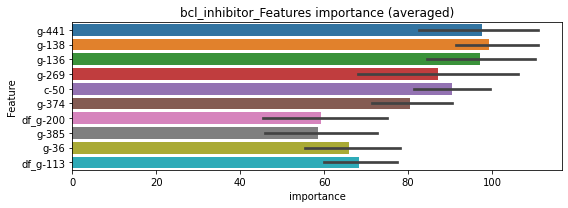

len(train_index) : 3892
len(valid_index) : 3893
================================= fold 1/2 bcl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0187488	valid_1's binary_logloss: 0.035688
[200]	training's binary_logloss: 0.00259377	valid_1's binary_logloss: 0.0141169
[300]	training's binary_logloss: 0.000732113	valid_1's binary_logloss: 0.0100065
Early stopping, best iteration is:
[363]	training's binary_logloss: 0.000446817	valid_1's binary_logloss: 0.00936754


len(train_index) : 3893
len(valid_index) : 3892
================================= fold 2/2 bcl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185252	valid_1's binary_logloss: 0.029978
[200]	training's binary_logloss: 0.00266918	valid_1's binary_logloss: 0.0124117
[300]	training's binary_logloss: 0.000757346	valid_1's binary_logloss: 0.00992852
Early stopping, best iteration is:
[334]	training's binary_logloss: 0.000571289	valid_1's binary_logloss: 0.00968849


bcl_inhibitor logloss: 0.009527994567161956
bcr-abl_inhibitor, len(trt): 38, len(othr): 3283, target_rate: 0.0015957 → Adj_target_rate: 0.0018493


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0331489	valid_1's binary_logloss: 0.0559837
[200]	training's binary_logloss: 0.00496811	valid_1's binary_logloss: 0.0205098
[300]	training's binary_logloss: 0.00141217	valid_1's binary_logloss: 0.0133515
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.000805977	valid_1's binary_logloss: 0.0115086
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0319757	valid_1's binary_logloss: 0.0506402
[200]	training's binary_logloss: 0.00484216	valid_1's binary_logloss: 0.017129
[300]	training's binary_logloss: 0.00138141	valid_1's binary_logloss: 0.0105768
[400]	training's binary_logloss: 0.000686068	valid_1's binary_logloss: 0.00900836
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.000531981	valid_1's binary_logloss: 0.00866079


1 / 3 AUC score:1.000
y_Threshold: 0.0044983, Threshold: 0.0092194, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00160, Num_p_label: 80.0, conf_0:0.00830, conf_1:0.01014
Num_p_label: 80.0, Expected: 6.4, Adj_threshold_1: 0.0092194
Num_p_label: 39.0, Expected: 6.4, Adj_threshold_2: 0.0192194
Num_p_label: 21.0, Expected: 6.4, Adj_threshold_3: 0.0292194
Num_p_label: 14.0, Expected: 6.4, Adj_threshold_4: 0.0392194
Num_p_label: 11.0, Expected: 6.4, Adj_threshold_5: 0.0492194
threshold: 0.0492194, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0312486	valid_1's binary_logloss: 0.0529631
[200]	training's binary_logloss: 0.00455769	valid_1's binary_logloss: 0.0173922
[300]	training's binary_logloss: 0.00130293	valid_1's binary_logloss: 0.0103241
[400]	training's binary_logloss: 0.000660211	valid_1's binary_logloss: 0.00829098
Early stopping, best iteration is:
[453]	training's binary_logloss: 0.000527115	valid_1's binary_logloss: 0.00778568
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0306614	valid_1's binary_logloss: 0.0450033
[200]	training's binary_logloss: 0.00453293	valid_1's binary_logloss: 0.0125371
[300]	training's binary_logloss: 0.00132704	valid_1's binary_logloss: 0.00758419
[400]	training's binary_logloss: 0.000663726	valid_1's binary_logloss: 0.00629948
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.000677365	valid_1's binary_logloss: 0.00629613


2 / 3 AUC score:1.000
y_Threshold: 0.0454656, Threshold: 0.0492194, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0160723 Vs.target_rate: 0.00160, Num_p_label: 64.0, conf_0:0.04430, conf_1:0.05414
Num_p_label: 64.0, Expected: 6.4, Adj_threshold_1: 0.0492194
Num_p_label: 51.0, Expected: 6.4, Adj_threshold_2: 0.0592194
Num_p_label: 45.0, Expected: 6.4, Adj_threshold_3: 0.0692194
Num_p_label: 42.0, Expected: 6.4, Adj_threshold_4: 0.0792194
Num_p_label: 33.0, Expected: 6.4, Adj_threshold_5: 0.0892194
Num_p_label: 32.0, Expected: 6.4, Adj_threshold_6: 0.0992194
Num_p_label: 31.0, Expected: 6.4, Adj_threshold_7: 0.1092194
Num_p_label: 29.0, Expected: 6.4, Adj_threshold_8: 0.1192194
Num_p_label: 29.0, Expected: 6.4, Adj_threshold_9: 0.1292194
Num_p_label: 27.0, Expected: 6.4, Adj_threshold_10: 0.1392194
threshold: 0.1492194, positive_p_label: 27.0/3982, p_label_rate: 0.0067805
positive_y_label: 655.0/3805, y_label_rate: 0.1721419
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0309407	valid_1's binary_logloss: 0.0508648
[200]	training's binary_logloss: 0.00454593	valid_1's binary_logloss: 0.0173607
[300]	training's binary_logloss: 0.00130935	valid_1's binary_logloss: 0.0103647
[400]	training's binary_logloss: 0.000648651	valid_1's binary_logloss: 0.00855994
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000509429	valid_1's binary_logloss: 0.00795076
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0297473	valid_1's binary_logloss: 0.0495141
[200]	training's binary_logloss: 0.00434724	valid_1's binary_logloss: 0.017736
[300]	training's binary_logloss: 0.00127416	valid_1's binary_logloss: 0.0109866
[400]	training's binary_logloss: 0.000643409	valid_1's binary_logloss: 0.00925162
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.000643409	valid_1's binary_logloss: 0.00925162


3 / 3 AUC score:1.000
y_Threshold: 0.0443966, Threshold: 0.1492194, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 654.0/3803
p_label_rate: 0.0070316 Vs.target_rate: 0.00160, Num_p_label: 28.0, conf_0:0.13430, conf_1:0.16414
Num_p_label: 28.0, Expected: 6.4, Adj_threshold_1: 0.1492194
Num_p_label: 26.0, Expected: 6.4, Adj_threshold_2: 0.1592194
Num_p_label: 25.0, Expected: 6.4, Adj_threshold_3: 0.1692194
Num_p_label: 24.0, Expected: 6.4, Adj_threshold_4: 0.1792194
Num_p_label: 24.0, Expected: 6.4, Adj_threshold_5: 0.1892194
Num_p_label: 23.0, Expected: 6.4, Adj_threshold_6: 0.1992194
Num_p_label: 23.0, Expected: 6.4, Adj_threshold_7: 0.2092194
Num_p_label: 20.0, Expected: 6.4, Adj_threshold_8: 0.2192194
Num_p_label: 18.0, Expected: 6.4, Adj_threshold_9: 0.2292194
Num_p_label: 18.0, Expected: 6.4, Adj_threshold_10: 0.2392194
threshold: 0.2492194, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 672.0/7785, y_label_rate: 0.0863198


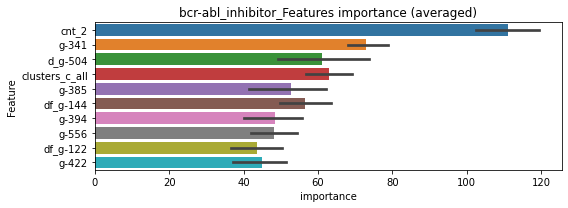

len(train_index) : 3892
len(valid_index) : 3893
================================= fold 1/2 bcr-abl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0169691	valid_1's binary_logloss: 0.0333862
[200]	training's binary_logloss: 0.00263911	valid_1's binary_logloss: 0.0132172
[300]	training's binary_logloss: 0.000692813	valid_1's binary_logloss: 0.00903544
[400]	training's binary_logloss: 0.000343776	valid_1's binary_logloss: 0.00839188
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.000359794	valid_1's binary_logloss: 0.00832992


len(train_index) : 3893
len(valid_index) : 3892
================================= fold 2/2 bcr-abl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0168395	valid_1's binary_logloss: 0.0277216
[200]	training's binary_logloss: 0.00250998	valid_1's binary_logloss: 0.0101203
[300]	training's binary_logloss: 0.000711475	valid_1's binary_logloss: 0.0072921
Early stopping, best iteration is:
[373]	training's binary_logloss: 0.000418567	valid_1's binary_logloss: 0.00672502


bcr-abl_inhibitor logloss: 0.007527572842258842
benzodiazepine_receptor_agonist, len(trt): 67, len(othr): 3277, target_rate: 0.0028135 → Adj_target_rate: 0.0029948


neg labels: 3289 → selected neg labels: 3277


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0514819	valid_1's binary_logloss: 0.114414
[200]	training's binary_logloss: 0.0103202	valid_1's binary_logloss: 0.0679224
[300]	training's binary_logloss: 0.00298549	valid_1's binary_logloss: 0.058355
Early stopping, best iteration is:
[372]	training's binary_logloss: 0.00166244	valid_1's binary_logloss: 0.0567608
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0538408	valid_1's binary_logloss: 0.108867
[200]	training's binary_logloss: 0.0111545	valid_1's binary_logloss: 0.0511781
[300]	training's binary_logloss: 0.0032815	valid_1's binary_logloss: 0.0337323
Early stopping, best iteration is:
[326]	training's binary_logloss: 0.0025794	valid_1's binary_logloss: 0.0311438


1 / 3 AUC score:0.995
y_Threshold: 0.0158441, Threshold: 0.0231103, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 150 → Positive_corect_labels: 646/3782
p_label_rate: 0.0200904 Vs.target_rate: 0.00281, Num_p_label: 80.0, conf_0:0.02080, conf_1:0.02542
Num_p_label: 80.0, Expected: 11.2, Adj_threshold_1: 0.0231103
Num_p_label: 37.0, Expected: 11.2, Adj_threshold_2: 0.0331103
Num_p_label: 22.0, Expected: 11.2, Adj_threshold_3: 0.0431103
threshold: 0.0431103, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 646.0/3782, y_label_rate: 0.1708091
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0478824	valid_1's binary_logloss: 0.101868
[200]	training's binary_logloss: 0.00861496	valid_1's binary_logloss: 0.049431
[300]	training's binary_logloss: 0.00264417	valid_1's binary_logloss: 0.036938
[400]	training's binary_logloss: 0.00126305	valid_1's binary_logloss: 0.0323059
Early stopping, best iteration is:
[474]	training's binary_logloss: 0.000883679	valid_1's binary_logloss: 0.0311018
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0520442	valid_1's binary_logloss: 0.0944337
[200]	training's binary_logloss: 0.0106168	valid_1's binary_logloss: 0.0405621
[300]	training's binary_logloss: 0.00314502	valid_1's binary_logloss: 0.026017
[400]	training's binary_logloss: 0.00144821	valid_1's binary_logloss: 0.0218681
[500]	training's binary_logloss: 0.00088916	valid_1's binary_logloss: 0.0202512
Early stopping, best iteration is:
[563]	training

2 / 3 AUC score:1.000
y_Threshold: 0.0358637, Threshold: 0.0431103, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 16 → Positive_corect_labels: 638.0/3766
p_label_rate: 0.0077850 Vs.target_rate: 0.00281, Num_p_label: 31.0, conf_0:0.03880, conf_1:0.04742
threshold: 0.0431103, positive_p_label: 31.0/3982, p_label_rate: 0.0077850
positive_y_label: 638.0/3766, y_label_rate: 0.1694105
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.048959	valid_1's binary_logloss: 0.0962632
[200]	training's binary_logloss: 0.00946676	valid_1's binary_logloss: 0.0434067
[300]	training's binary_logloss: 0.00279863	valid_1's binary_logloss: 0.0285583
[400]	training's binary_logloss: 0.00134272	valid_1's binary_logloss: 0.0237412
Early stopping, best iteration is:
[488]	training's binary_logloss: 0.000872684	valid_1's binary_logloss: 0.0222544
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0498546	valid_1's binary_logloss: 0.09111
[200]	training's binary_logloss: 0.0099321	valid_1's binary_logloss: 0.0400613
[300]	training's binary_logloss: 0.00292159	valid_1's binary_logloss: 0.0272094
[400]	training's binary_logloss: 0.0013583	valid_1's binary_logloss: 0.0236673
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.00116059	valid_1's binary_logloss: 0.0232978


3 / 3 AUC score:1.000
y_Threshold: 0.0372115, Threshold: 0.0431103, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 10 → Positive_corect_labels: 633.0/3756
p_label_rate: 0.0113009 Vs.target_rate: 0.00281, Num_p_label: 45.0, conf_0:0.03880, conf_1:0.04742
Num_p_label: 45.0, Expected: 11.2, Adj_threshold_1: 0.0431103
Num_p_label: 36.0, Expected: 11.2, Adj_threshold_2: 0.0531103
Num_p_label: 28.0, Expected: 11.2, Adj_threshold_3: 0.0631103
Num_p_label: 23.0, Expected: 11.2, Adj_threshold_4: 0.0731103
Num_p_label: 21.0, Expected: 11.2, Adj_threshold_5: 0.0831103
threshold: 0.0831103, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 654.0/7738, y_label_rate: 0.0845180


len(train_index) : 3869
len(valid_index) : 3869
================================= fold 1/2 benzodiazepine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0283892	valid_1's binary_logloss: 0.0653692
[200]	training's binary_logloss: 0.00568686	valid_1's binary_logloss: 0.0383022
[300]	training's binary_logloss: 0.00166771	valid_1's binary_logloss: 0.0327608
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.00124761	valid_1's binary_logloss: 0.0322929


len(train_index) : 3869
len(valid_index) : 3869
================================= fold 2/2 benzodiazepine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.029187	valid_1's binary_logloss: 0.0593287
[200]	training's binary_logloss: 0.00566289	valid_1's binary_logloss: 0.0308719
[300]	training's binary_logloss: 0.00166369	valid_1's binary_logloss: 0.0246473
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00107005	valid_1's binary_logloss: 0.0236105


benzodiazepine_receptor_agonist logloss: 0.027951730292633654
beta_amyloid_inhibitor, len(trt): 24, len(othr): 3285, target_rate: 0.0010078 → Adj_target_rate: 0.0012513


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0310839	valid_1's binary_logloss: 0.0457386
[200]	training's binary_logloss: 0.00421961	valid_1's binary_logloss: 0.0130789
[300]	training's binary_logloss: 0.0011657	valid_1's binary_logloss: 0.00831343
[400]	training's binary_logloss: 0.000581133	valid_1's binary_logloss: 0.0072193
Early stopping, best iteration is:
[452]	training's binary_logloss: 0.000468404	valid_1's binary_logloss: 0.00702203
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0312575	valid_1's binary_logloss: 0.0430812
[200]	training's binary_logloss: 0.00432863	valid_1's binary_logloss: 0.00828851
[300]	training's binary_logloss: 0.00119312	valid_1's binary_logloss: 0.0031396
[400]	training's binary_logloss: 0.000604602	valid_1's binary_logloss: 0.00199451
[500]	training's binary_logloss: 0.000425982	valid_1's binary_logloss: 0.00156923
Early stopping, best iteration is:
[5

1 / 3 AUC score:1.000
y_Threshold: 0.0025326, Threshold: 0.0044179, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00101, Num_p_label: 80.0, conf_0:0.00398, conf_1:0.00486
Num_p_label: 80.0, Expected: 4.0, Adj_threshold_1: 0.0044179
Num_p_label: 10.0, Expected: 4.0, Adj_threshold_2: 0.0144179
Num_p_label: 5.0, Expected: 4.0, Adj_threshold_3: 0.0244179
threshold: 0.0244179, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0305297	valid_1's binary_logloss: 0.0449576
[200]	training's binary_logloss: 0.00406593	valid_1's binary_logloss: 0.0126457
[300]	training's binary_logloss: 0.00115187	valid_1's binary_logloss: 0.00814541
[400]	training's binary_logloss: 0.000586184	valid_1's binary_logloss: 0.00719973
Early stopping, best iteration is:
[477]	training's binary_logloss: 0.000442612	valid_1's binary_logloss: 0.00688909
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0310561	valid_1's binary_logloss: 0.0413992
[200]	training's binary_logloss: 0.00429929	valid_1's binary_logloss: 0.00781296
[300]	training's binary_logloss: 0.00119495	valid_1's binary_logloss: 0.00306295
[400]	training's binary_logloss: 0.000603426	valid_1's binary_logloss: 0.00187165
[500]	training's binary_logloss: 0.000423277	valid_1's binary_logloss: 0.00148134
Early stopping, best iteration is:

2 / 3 AUC score:1.000
y_Threshold: 0.0108880, Threshold: 0.0244179, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 655.0/3806
p_label_rate: 0.0020090 Vs.target_rate: 0.00101, Num_p_label: 8.0, conf_0:0.02198, conf_1:0.02686
threshold: 0.0244179, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 655.0/3806, y_label_rate: 0.1720967
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0294388	valid_1's binary_logloss: 0.0437525
[200]	training's binary_logloss: 0.00391601	valid_1's binary_logloss: 0.00866831
[300]	training's binary_logloss: 0.00110399	valid_1's binary_logloss: 0.00355516
[400]	training's binary_logloss: 0.000565033	valid_1's binary_logloss: 0.00235957
[500]	training's binary_logloss: 0.000414515	valid_1's binary_logloss: 0.00199147
Early stopping, best iteration is:
[528]	training's binary_logloss: 0.000407442	valid_1's binary_logloss: 0.00197641
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0297709	valid_1's binary_logloss: 0.0437432
[200]	training's binary_logloss: 0.00405538	valid_1's binary_logloss: 0.0109161
[300]	training's binary_logloss: 0.00114916	valid_1's binary_logloss: 0.00473328
[400]	training's binary_logloss: 0.000578426	valid_1's binary_logloss: 0.00318708
[500]	training's binary_logloss: 0

3 / 3 AUC score:1.000
y_Threshold: 0.0728395, Threshold: 0.0244179, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3806
p_label_rate: 0.0040181 Vs.target_rate: 0.00101, Num_p_label: 16.0, conf_0:0.02198, conf_1:0.02686
Num_p_label: 16.0, Expected: 4.0, Adj_threshold_1: 0.0244179
Num_p_label: 7.0, Expected: 4.0, Adj_threshold_2: 0.0344179
threshold: 0.0344179, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 662.0/7788, y_label_rate: 0.0850026


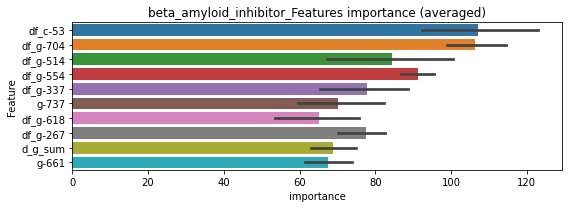

len(train_index) : 3894
len(valid_index) : 3894
================================= fold 1/2 beta_amyloid_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0172463	valid_1's binary_logloss: 0.0281853
[200]	training's binary_logloss: 0.00232828	valid_1's binary_logloss: 0.0105068
[300]	training's binary_logloss: 0.000632143	valid_1's binary_logloss: 0.00840615
Early stopping, best iteration is:
[347]	training's binary_logloss: 0.000426872	valid_1's binary_logloss: 0.00811022


len(train_index) : 3894
len(valid_index) : 3894
================================= fold 2/2 beta_amyloid_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0172708	valid_1's binary_logloss: 0.0246767
[200]	training's binary_logloss: 0.00229994	valid_1's binary_logloss: 0.00691625
[300]	training's binary_logloss: 0.000630552	valid_1's binary_logloss: 0.00470344
[400]	training's binary_logloss: 0.000312878	valid_1's binary_logloss: 0.00431293
Early stopping, best iteration is:
[409]	training's binary_logloss: 0.00029876	valid_1's binary_logloss: 0.00428861


beta_amyloid_inhibitor logloss: 0.006199419666229118
bromodomain_inhibitor, len(trt): 68, len(othr): 3276, target_rate: 0.0028555 → Adj_target_rate: 0.0030327


neg labels: 3289 → selected neg labels: 3276


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0378669	valid_1's binary_logloss: 0.073334
[200]	training's binary_logloss: 0.00637314	valid_1's binary_logloss: 0.0333693
[300]	training's binary_logloss: 0.00188613	valid_1's binary_logloss: 0.0257669
Early stopping, best iteration is:
[377]	training's binary_logloss: 0.00103762	valid_1's binary_logloss: 0.0241336
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0372848	valid_1's binary_logloss: 0.0807538
[200]	training's binary_logloss: 0.00625864	valid_1's binary_logloss: 0.0464743
Early stopping, best iteration is:
[249]	training's binary_logloss: 0.00316071	valid_1's binary_logloss: 0.041869


1 / 3 AUC score:0.999
y_Threshold: 0.0105540, Threshold: 0.0149945, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 654/3797
p_label_rate: 0.0200904 Vs.target_rate: 0.00286, Num_p_label: 80.0, conf_0:0.01350, conf_1:0.01649
Num_p_label: 80.0, Expected: 11.4, Adj_threshold_1: 0.0149945
Num_p_label: 34.0, Expected: 11.4, Adj_threshold_2: 0.0249945
Num_p_label: 20.0, Expected: 11.4, Adj_threshold_3: 0.0349945
threshold: 0.0349945, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 654.0/3797, y_label_rate: 0.1722412
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0362559	valid_1's binary_logloss: 0.0811745
[200]	training's binary_logloss: 0.00575562	valid_1's binary_logloss: 0.0417565
[300]	training's binary_logloss: 0.00168894	valid_1's binary_logloss: 0.0312166
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.0013891	valid_1's binary_logloss: 0.0302933
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.036597	valid_1's binary_logloss: 0.0634534
[200]	training's binary_logloss: 0.00588492	valid_1's binary_logloss: 0.0243914
[300]	training's binary_logloss: 0.00172378	valid_1's binary_logloss: 0.0164298
[400]	training's binary_logloss: 0.000843247	valid_1's binary_logloss: 0.0139057
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.000625268	valid_1's binary_logloss: 0.0132733


2 / 3 AUC score:1.000
y_Threshold: 0.0234161, Threshold: 0.0349945, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 652.0/3793
p_label_rate: 0.0085384 Vs.target_rate: 0.00286, Num_p_label: 34.0, conf_0:0.03150, conf_1:0.03849
threshold: 0.0349945, positive_p_label: 34.0/3982, p_label_rate: 0.0085384
positive_y_label: 652.0/3793, y_label_rate: 0.1718956
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0360647	valid_1's binary_logloss: 0.0820703
[200]	training's binary_logloss: 0.00571462	valid_1's binary_logloss: 0.0461504
[300]	training's binary_logloss: 0.00166402	valid_1's binary_logloss: 0.0381541
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.000948282	valid_1's binary_logloss: 0.0357946
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0361293	valid_1's binary_logloss: 0.0733698
[200]	training's binary_logloss: 0.00582875	valid_1's binary_logloss: 0.0356079
[300]	training's binary_logloss: 0.00170335	valid_1's binary_logloss: 0.0269885
Early stopping, best iteration is:
[368]	training's binary_logloss: 0.00100849	valid_1's binary_logloss: 0.0249667


3 / 3 AUC score:1.000
y_Threshold: 0.0217492, Threshold: 0.0349945, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 16 → Positive_corect_labels: 644.0/3777
p_label_rate: 0.0072828 Vs.target_rate: 0.00286, Num_p_label: 29.0, conf_0:0.03150, conf_1:0.03849
threshold: 0.0349945, positive_p_label: 29.0/3982, p_label_rate: 0.0072828
positive_y_label: 673.0/7759, y_label_rate: 0.0867380


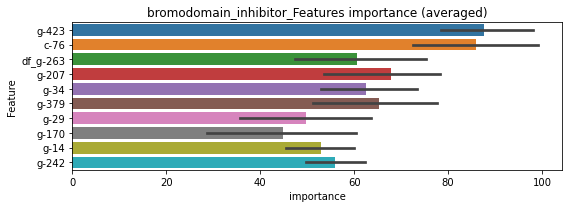

len(train_index) : 3879
len(valid_index) : 3880
================================= fold 1/2 bromodomain_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189835	valid_1's binary_logloss: 0.057584
[200]	training's binary_logloss: 0.00293174	valid_1's binary_logloss: 0.0389794
[300]	training's binary_logloss: 0.000871316	valid_1's binary_logloss: 0.0359444
Early stopping, best iteration is:
[303]	training's binary_logloss: 0.000846971	valid_1's binary_logloss: 0.0359107


len(train_index) : 3880
len(valid_index) : 3879
================================= fold 2/2 bromodomain_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0214262	valid_1's binary_logloss: 0.0497098
[200]	training's binary_logloss: 0.00354859	valid_1's binary_logloss: 0.0308462
[300]	training's binary_logloss: 0.00101583	valid_1's binary_logloss: 0.0281617
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.000970671	valid_1's binary_logloss: 0.0280534


bromodomain_inhibitor logloss: 0.031982557590714236
btk_inhibitor, len(trt): 29, len(othr): 3284, target_rate: 0.0012178 → Adj_target_rate: 0.0014697


neg labels: 3289 → selected neg labels: 3284


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0301722	valid_1's binary_logloss: 0.0572393
[200]	training's binary_logloss: 0.00405506	valid_1's binary_logloss: 0.0209293
[300]	training's binary_logloss: 0.00114561	valid_1's binary_logloss: 0.0124348
[400]	training's binary_logloss: 0.000579007	valid_1's binary_logloss: 0.00964149
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.000465995	valid_1's binary_logloss: 0.00909057
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0279233	valid_1's binary_logloss: 0.047306
[200]	training's binary_logloss: 0.00379659	valid_1's binary_logloss: 0.0176468
[300]	training's binary_logloss: 0.00110079	valid_1's binary_logloss: 0.0136325
[400]	training's binary_logloss: 0.000557844	valid_1's binary_logloss: 0.0127814
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.000583226	valid_1's binary_logloss: 0.0127389


1 / 3 AUC score:1.000
y_Threshold: 0.0037756, Threshold: 0.0071860, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 655/3806
p_label_rate: 0.0200904 Vs.target_rate: 0.00122, Num_p_label: 80.0, conf_0:0.00647, conf_1:0.00790
Num_p_label: 80.0, Expected: 4.8, Adj_threshold_1: 0.0071860
Num_p_label: 26.0, Expected: 4.8, Adj_threshold_2: 0.0171860
Num_p_label: 14.0, Expected: 4.8, Adj_threshold_3: 0.0271860
Num_p_label: 8.0, Expected: 4.8, Adj_threshold_4: 0.0371860
threshold: 0.0371860, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 655.0/3806, y_label_rate: 0.1720967
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0286106	valid_1's binary_logloss: 0.0474177
[200]	training's binary_logloss: 0.00373154	valid_1's binary_logloss: 0.0116069
[300]	training's binary_logloss: 0.00106546	valid_1's binary_logloss: 0.00582945
[400]	training's binary_logloss: 0.000550124	valid_1's binary_logloss: 0.00391261
[500]	training's binary_logloss: 0.000398497	valid_1's binary_logloss: 0.0032608
Early stopping, best iteration is:
[588]	training's binary_logloss: 0.000374743	valid_1's binary_logloss: 0.00314842
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.028868	valid_1's binary_logloss: 0.0413406
[200]	training's binary_logloss: 0.00392639	valid_1's binary_logloss: 0.00859874
[300]	training's binary_logloss: 0.00112449	valid_1's binary_logloss: 0.0032694
[400]	training's binary_logloss: 0.000565962	valid_1's binary_logloss: 0.0019774
[500]	training's binary_logloss: 0.000

2 / 3 AUC score:1.000
y_Threshold: 0.0740798, Threshold: 0.0371860, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3806
p_label_rate: 0.0047715 Vs.target_rate: 0.00122, Num_p_label: 19.0, conf_0:0.03347, conf_1:0.04090
Num_p_label: 19.0, Expected: 4.8, Adj_threshold_1: 0.0371860
Num_p_label: 15.0, Expected: 4.8, Adj_threshold_2: 0.0471860
Num_p_label: 13.0, Expected: 4.8, Adj_threshold_3: 0.0571860
Num_p_label: 9.0, Expected: 4.8, Adj_threshold_4: 0.0671860
threshold: 0.0671860, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 655.0/3806, y_label_rate: 0.1720967
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0286106	valid_1's binary_logloss: 0.0474177
[200]	training's binary_logloss: 0.00373154	valid_1's binary_logloss: 0.0116069
[300]	training's binary_logloss: 0.00106546	valid_1's binary_logloss: 0.00582945
[400]	training's binary_logloss: 0.000550124	valid_1's binary_logloss: 0.00391261
[500]	training's binary_logloss: 0.000398497	valid_1's binary_logloss: 0.0032608
Early stopping, best iteration is:
[588]	training's binary_logloss: 0.000374743	valid_1's binary_logloss: 0.00314842
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.028868	valid_1's binary_logloss: 0.0413406
[200]	training's binary_logloss: 0.00392639	valid_1's binary_logloss: 0.00859874
[300]	training's binary_logloss: 0.00112449	valid_1's binary_logloss: 0.0032694
[400]	training's binary_logloss: 0.000565962	valid_1's binary_logloss: 0.0019774
[500]	training's binary_logloss: 0.000

3 / 3 AUC score:1.000
y_Threshold: 0.0740798, Threshold: 0.0671860, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3806
p_label_rate: 0.0022602 Vs.target_rate: 0.00122, Num_p_label: 9.0, conf_0:0.06047, conf_1:0.07390
threshold: 0.0671860, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 664.0/7788, y_label_rate: 0.0852594


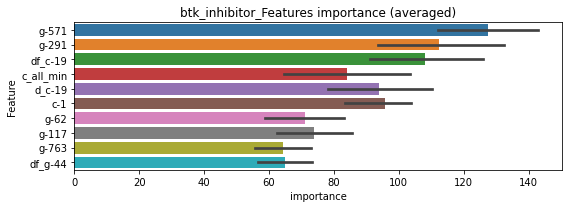

len(train_index) : 3894
len(valid_index) : 3894
================================= fold 1/2 btk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0154079	valid_1's binary_logloss: 0.0255843
[200]	training's binary_logloss: 0.0020312	valid_1's binary_logloss: 0.00907696
[300]	training's binary_logloss: 0.000573571	valid_1's binary_logloss: 0.00707884
Early stopping, best iteration is:
[367]	training's binary_logloss: 0.000341597	valid_1's binary_logloss: 0.00674631


len(train_index) : 3894
len(valid_index) : 3894
================================= fold 2/2 btk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159085	valid_1's binary_logloss: 0.0274034
[200]	training's binary_logloss: 0.00213208	valid_1's binary_logloss: 0.0100907
[300]	training's binary_logloss: 0.000605176	valid_1's binary_logloss: 0.00732426
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.000530616	valid_1's binary_logloss: 0.00716743


btk_inhibitor logloss: 0.006956870635334785
calcineurin_inhibitor, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942


neg labels: 3289 → selected neg labels: 3287


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0184979	valid_1's binary_logloss: 0.0278422
[200]	training's binary_logloss: 0.00189182	valid_1's binary_logloss: 0.00697362
[300]	training's binary_logloss: 0.000536719	valid_1's binary_logloss: 0.00334852
[400]	training's binary_logloss: 0.000301795	valid_1's binary_logloss: 0.00249035
Early stopping, best iteration is:
[468]	training's binary_logloss: 0.000264846	valid_1's binary_logloss: 0.00236497
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185047	valid_1's binary_logloss: 0.0201866
[200]	training's binary_logloss: 0.00188432	valid_1's binary_logloss: 0.00251271
[300]	training's binary_logloss: 0.00053637	valid_1's binary_logloss: 0.000873173
[400]	training's binary_logloss: 0.000304303	valid_1's binary_logloss: 0.00055556
[500]	training's binary_logloss: 0.000261549	valid_1's binary_logloss: 0.000492966
Early stopping, best iteration

1 / 3 AUC score:1.000
y_Threshold: 0.0009180, Threshold: 0.0016415, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00050, Num_p_label: 80.0, conf_0:0.00148, conf_1:0.00181
Num_p_label: 80.0, Expected: 2.0, Adj_threshold_1: 0.0016415
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_2: 0.0116415
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_3: 0.0216415
Num_p_label: 2.0, Expected: 2.0, Adj_threshold_4: 0.0316415
threshold: 0.0316415, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185911	valid_1's binary_logloss: 0.0277512
[200]	training's binary_logloss: 0.00182018	valid_1's binary_logloss: 0.00736641
[300]	training's binary_logloss: 0.000518682	valid_1's binary_logloss: 0.00413866
[400]	training's binary_logloss: 0.00029731	valid_1's binary_logloss: 0.00323506
[500]	training's binary_logloss: 0.000254171	valid_1's binary_logloss: 0.0030595
Early stopping, best iteration is:
[502]	training's binary_logloss: 0.000253705	valid_1's binary_logloss: 0.00305891
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0187656	valid_1's binary_logloss: 0.0202451
[200]	training's binary_logloss: 0.00184067	valid_1's binary_logloss: 0.00222985
[300]	training's binary_logloss: 0.000525834	valid_1's binary_logloss: 0.000690391
[400]	training's binary_logloss: 0.000301596	valid_1's binary_logloss: 0.000409659
[500]	training's binary_logloss

2 / 3 AUC score:1.000
y_Threshold: 0.0481262, Threshold: 0.0316415, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0015068 Vs.target_rate: 0.00050, Num_p_label: 6.0, conf_0:0.02848, conf_1:0.03481
threshold: 0.0316415, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185911	valid_1's binary_logloss: 0.0277512
[200]	training's binary_logloss: 0.00182018	valid_1's binary_logloss: 0.00736641
[300]	training's binary_logloss: 0.000518682	valid_1's binary_logloss: 0.00413866
[400]	training's binary_logloss: 0.00029731	valid_1's binary_logloss: 0.00323506
[500]	training's binary_logloss: 0.000254171	valid_1's binary_logloss: 0.0030595
Early stopping, best iteration is:
[502]	training's binary_logloss: 0.000253705	valid_1's binary_logloss: 0.00305891
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0187656	valid_1's binary_logloss: 0.0202451
[200]	training's binary_logloss: 0.00184067	valid_1's binary_logloss: 0.00222985
[300]	training's binary_logloss: 0.000525834	valid_1's binary_logloss: 0.000690391
[400]	training's binary_logloss: 0.000301596	valid_1's binary_logloss: 0.000409659
[500]	training's binary_logloss

3 / 3 AUC score:1.000
y_Threshold: 0.0481262, Threshold: 0.0316415, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0015068 Vs.target_rate: 0.00050, Num_p_label: 6.0, conf_0:0.02848, conf_1:0.03481
threshold: 0.0316415, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 663.0/7794, y_label_rate: 0.0850654


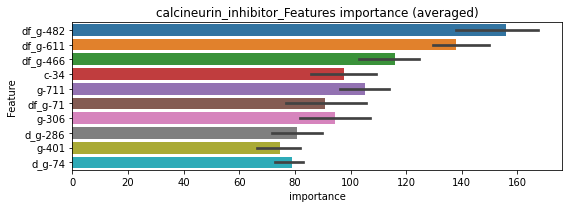

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 calcineurin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00994776	valid_1's binary_logloss: 0.0157877
[200]	training's binary_logloss: 0.000968057	valid_1's binary_logloss: 0.00538095
Early stopping, best iteration is:
[260]	training's binary_logloss: 0.000404696	valid_1's binary_logloss: 0.0049177


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 calcineurin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0103759	valid_1's binary_logloss: 0.0123741
[200]	training's binary_logloss: 0.00104933	valid_1's binary_logloss: 0.00233569
[300]	training's binary_logloss: 0.000299079	valid_1's binary_logloss: 0.00141994
Early stopping, best iteration is:
[377]	training's binary_logloss: 0.000184503	valid_1's binary_logloss: 0.0013283


calcineurin_inhibitor logloss: 0.0031230004110079147
calcium_channel_blocker, len(trt): 281, len(othr): 3243, target_rate: 0.0117998 → Adj_target_rate: 0.0101297


neg labels: 3289 → selected neg labels: 3243


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114447	valid_1's binary_logloss: 0.296384
[200]	training's binary_logloss: 0.0397086	valid_1's binary_logloss: 0.268078
Early stopping, best iteration is:
[205]	training's binary_logloss: 0.0377999	valid_1's binary_logloss: 0.267408
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116425	valid_1's binary_logloss: 0.283403
[200]	training's binary_logloss: 0.0446843	valid_1's binary_logloss: 0.252614
Early stopping, best iteration is:
[219]	training's binary_logloss: 0.0375324	valid_1's binary_logloss: 0.249941


1 / 3 AUC score:0.901
y_Threshold: 0.0908234, Threshold: 0.1251833, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 437 → Positive_corect_labels: 495/3454
p_label_rate: 0.0200904 Vs.target_rate: 0.01180, Num_p_label: 80.0, conf_0:0.11267, conf_1:0.13770
threshold: 0.1251833, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 495.0/3454, y_label_rate: 0.1433121
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0808781	valid_1's binary_logloss: 0.225171
[200]	training's binary_logloss: 0.0258331	valid_1's binary_logloss: 0.192499
Early stopping, best iteration is:
[241]	training's binary_logloss: 0.016132	valid_1's binary_logloss: 0.188551
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0796877	valid_1's binary_logloss: 0.226466
[200]	training's binary_logloss: 0.0241886	valid_1's binary_logloss: 0.194235
Early stopping, best iteration is:
[249]	training's binary_logloss: 0.0142052	valid_1's binary_logloss: 0.191594


2 / 3 AUC score:0.947
y_Threshold: 0.0776692, Threshold: 0.1251833, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 174 → Positive_corect_labels: 408.0/3280
p_label_rate: 0.0095429 Vs.target_rate: 0.01180, Num_p_label: 38.0, conf_0:0.11267, conf_1:0.13770
threshold: 0.1251833, positive_p_label: 38.0/3982, p_label_rate: 0.0095429
positive_y_label: 408.0/3280, y_label_rate: 0.1243902
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.061716	valid_1's binary_logloss: 0.173582
[200]	training's binary_logloss: 0.016898	valid_1's binary_logloss: 0.13507
Early stopping, best iteration is:
[273]	training's binary_logloss: 0.00706213	valid_1's binary_logloss: 0.126708
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0648799	valid_1's binary_logloss: 0.172362
[200]	training's binary_logloss: 0.0172505	valid_1's binary_logloss: 0.131391
[300]	training's binary_logloss: 0.00582723	valid_1's binary_logloss: 0.12336
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.00501209	valid_1's binary_logloss: 0.12215


3 / 3 AUC score:0.988
y_Threshold: 0.0498847, Threshold: 0.1251833, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 70 → Positive_corect_labels: 373.0/3210
p_label_rate: 0.0012557 Vs.target_rate: 0.01180, Num_p_label: 5.0, conf_0:0.11267, conf_1:0.13770
Num_p_label: 5.0, Expected: 47.0, Adj_threshold_1: 0.1251833
Num_p_label: 8.0, Expected: 47.0, Adj_threshold_2: 0.1151833
Num_p_label: 14.0, Expected: 47.0, Adj_threshold_3: 0.1051833
Num_p_label: 16.0, Expected: 47.0, Adj_threshold_4: 0.0951833
Num_p_label: 25.0, Expected: 47.0, Adj_threshold_5: 0.0851833
threshold: 0.0851833, positive_p_label: 25.0/3982, p_label_rate: 0.0062783
positive_y_label: 398.0/7192, y_label_rate: 0.0553393


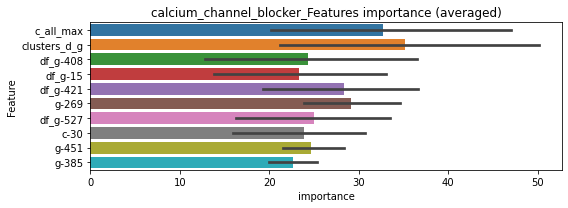

len(train_index) : 3596
len(valid_index) : 3596
================================= fold 1/2 calcium_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0277842	valid_1's binary_logloss: 0.100182
[200]	training's binary_logloss: 0.00731358	valid_1's binary_logloss: 0.0900414
Early stopping, best iteration is:
[205]	training's binary_logloss: 0.0067673	valid_1's binary_logloss: 0.0895574


len(train_index) : 3596
len(valid_index) : 3596
================================= fold 2/2 calcium_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0304688	valid_1's binary_logloss: 0.0940255
[200]	training's binary_logloss: 0.00823568	valid_1's binary_logloss: 0.0805753
Early stopping, best iteration is:
[227]	training's binary_logloss: 0.0059402	valid_1's binary_logloss: 0.0796127


calcium_channel_blocker logloss: 0.08458503601511032
cannabinoid_receptor_agonist, len(trt): 42, len(othr): 3282, target_rate: 0.0017637 → Adj_target_rate: 0.0020135


neg labels: 3289 → selected neg labels: 3282


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0441495	valid_1's binary_logloss: 0.0725849
[200]	training's binary_logloss: 0.00782832	valid_1's binary_logloss: 0.0279536
[300]	training's binary_logloss: 0.00209216	valid_1's binary_logloss: 0.0175261
[400]	training's binary_logloss: 0.000971849	valid_1's binary_logloss: 0.0138765
Early stopping, best iteration is:
[422]	training's binary_logloss: 0.000862928	valid_1's binary_logloss: 0.0134639
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0448524	valid_1's binary_logloss: 0.0770924
[200]	training's binary_logloss: 0.00797658	valid_1's binary_logloss: 0.0294695
[300]	training's binary_logloss: 0.00220453	valid_1's binary_logloss: 0.0172314
[400]	training's binary_logloss: 0.00101767	valid_1's binary_logloss: 0.0132242
[500]	training's binary_logloss: 0.000644147	valid_1's binary_logloss: 0.0119912
[600]	training's binary_logloss: 0.0005181

1 / 3 AUC score:1.000
y_Threshold: 0.0049133, Threshold: 0.0077983, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3806
p_label_rate: 0.0200904 Vs.target_rate: 0.00176, Num_p_label: 80.0, conf_0:0.00702, conf_1:0.00858
Num_p_label: 80.0, Expected: 7.0, Adj_threshold_1: 0.0077983
Num_p_label: 15.0, Expected: 7.0, Adj_threshold_2: 0.0177983
Num_p_label: 5.0, Expected: 7.0, Adj_threshold_3: 0.0277983
threshold: 0.0277983, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 656.0/3806, y_label_rate: 0.1723594
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0423349	valid_1's binary_logloss: 0.0705664
[200]	training's binary_logloss: 0.00738409	valid_1's binary_logloss: 0.0247027
[300]	training's binary_logloss: 0.00200166	valid_1's binary_logloss: 0.0140102
[400]	training's binary_logloss: 0.000942017	valid_1's binary_logloss: 0.0108907
[500]	training's binary_logloss: 0.000614385	valid_1's binary_logloss: 0.00958782
Early stopping, best iteration is:
[493]	training's binary_logloss: 0.000627569	valid_1's binary_logloss: 0.00952781
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0434196	valid_1's binary_logloss: 0.0762068
[200]	training's binary_logloss: 0.00761186	valid_1's binary_logloss: 0.0314193
[300]	training's binary_logloss: 0.00213292	valid_1's binary_logloss: 0.020543
[400]	training's binary_logloss: 0.00100054	valid_1's binary_logloss: 0.0166194
Early stopping, best iteration is:
[399]	

2 / 3 AUC score:1.000
y_Threshold: 0.0342853, Threshold: 0.0277983, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3804
p_label_rate: 0.0065294 Vs.target_rate: 0.00176, Num_p_label: 26.0, conf_0:0.02502, conf_1:0.03058
Num_p_label: 26.0, Expected: 7.0, Adj_threshold_1: 0.0277983
Num_p_label: 20.0, Expected: 7.0, Adj_threshold_2: 0.0377983
Num_p_label: 10.0, Expected: 7.0, Adj_threshold_3: 0.0477983
threshold: 0.0477983, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 655.0/3804, y_label_rate: 0.1721872
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.040544	valid_1's binary_logloss: 0.0633555
[200]	training's binary_logloss: 0.00702259	valid_1's binary_logloss: 0.018898
[300]	training's binary_logloss: 0.00200573	valid_1's binary_logloss: 0.00898568
[400]	training's binary_logloss: 0.000960355	valid_1's binary_logloss: 0.00616672
[500]	training's binary_logloss: 0.00062169	valid_1's binary_logloss: 0.00499089
Early stopping, best iteration is:
[551]	training's binary_logloss: 0.000546268	valid_1's binary_logloss: 0.00470829
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.044603	valid_1's binary_logloss: 0.080599
[200]	training's binary_logloss: 0.00761839	valid_1's binary_logloss: 0.0292993
[300]	training's binary_logloss: 0.00213694	valid_1's binary_logloss: 0.0166314
Early stopping, best iteration is:
[386]	training's binary_logloss: 0.00107252	valid_1's binary_logloss: 0.0134212


3 / 3 AUC score:1.000
y_Threshold: 0.0372595, Threshold: 0.0477983, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3804
p_label_rate: 0.0022602 Vs.target_rate: 0.00176, Num_p_label: 9.0, conf_0:0.04302, conf_1:0.05258
threshold: 0.0477983, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 664.0/7786, y_label_rate: 0.0852813


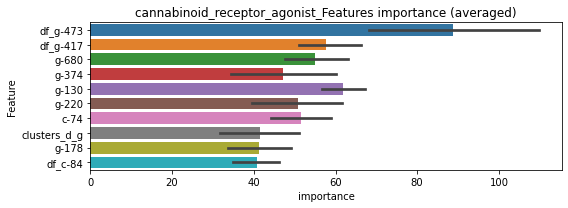

len(train_index) : 3893
len(valid_index) : 3893
================================= fold 1/2 cannabinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233259	valid_1's binary_logloss: 0.0420299
[200]	training's binary_logloss: 0.00394356	valid_1's binary_logloss: 0.0182517
[300]	training's binary_logloss: 0.00108219	valid_1's binary_logloss: 0.0134896
[400]	training's binary_logloss: 0.000496267	valid_1's binary_logloss: 0.0125897
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.000371845	valid_1's binary_logloss: 0.0122911


len(train_index) : 3893
len(valid_index) : 3893
================================= fold 2/2 cannabinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0235143	valid_1's binary_logloss: 0.0457737
[200]	training's binary_logloss: 0.00409281	valid_1's binary_logloss: 0.0199381
[300]	training's binary_logloss: 0.00113665	valid_1's binary_logloss: 0.0126673
[400]	training's binary_logloss: 0.000519953	valid_1's binary_logloss: 0.0107041
Early stopping, best iteration is:
[447]	training's binary_logloss: 0.000408846	valid_1's binary_logloss: 0.0101781


cannabinoid_receptor_agonist logloss: 0.011234634644831125
cannabinoid_receptor_antagonist, len(trt): 55, len(othr): 3280, target_rate: 0.0023096 → Adj_target_rate: 0.0025322


neg labels: 3289 → selected neg labels: 3280


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0451515	valid_1's binary_logloss: 0.0838855
[200]	training's binary_logloss: 0.0087662	valid_1's binary_logloss: 0.0397999
[300]	training's binary_logloss: 0.00249456	valid_1's binary_logloss: 0.0274718
[400]	training's binary_logloss: 0.00115522	valid_1's binary_logloss: 0.0235541
[500]	training's binary_logloss: 0.000722719	valid_1's binary_logloss: 0.0223534
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000750878	valid_1's binary_logloss: 0.0222008
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0522243	valid_1's binary_logloss: 0.0865112
[200]	training's binary_logloss: 0.0102132	valid_1's binary_logloss: 0.0392841
[300]	training's binary_logloss: 0.00288484	valid_1's binary_logloss: 0.025611
[400]	training's binary_logloss: 0.00131379	valid_1's binary_logloss: 0.0207038
[500]	training's binary_logloss: 0.000814234	v

1 / 3 AUC score:1.000
y_Threshold: 0.0061047, Threshold: 0.0091109, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 655/3802
p_label_rate: 0.0200904 Vs.target_rate: 0.00231, Num_p_label: 80.0, conf_0:0.00820, conf_1:0.01002
Num_p_label: 80.0, Expected: 9.2, Adj_threshold_1: 0.0091109
Num_p_label: 21.0, Expected: 9.2, Adj_threshold_2: 0.0191109
Num_p_label: 11.0, Expected: 9.2, Adj_threshold_3: 0.0291109
threshold: 0.0291109, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 655.0/3802, y_label_rate: 0.1722777
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0483939	valid_1's binary_logloss: 0.0845943
[200]	training's binary_logloss: 0.00893011	valid_1's binary_logloss: 0.036972
[300]	training's binary_logloss: 0.00261133	valid_1's binary_logloss: 0.0250231
[400]	training's binary_logloss: 0.00120733	valid_1's binary_logloss: 0.020902
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.000877562	valid_1's binary_logloss: 0.0197155
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0498505	valid_1's binary_logloss: 0.0908338
[200]	training's binary_logloss: 0.00933345	valid_1's binary_logloss: 0.0366486
[300]	training's binary_logloss: 0.00272761	valid_1's binary_logloss: 0.0231901
[400]	training's binary_logloss: 0.00124813	valid_1's binary_logloss: 0.0183487
[500]	training's binary_logloss: 0.000773678	valid_1's binary_logloss: 0.0160042
Early stopping, best iteration is:
[540]	trai

2 / 3 AUC score:1.000
y_Threshold: 0.0458124, Threshold: 0.0291109, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 653.0/3798
p_label_rate: 0.0077850 Vs.target_rate: 0.00231, Num_p_label: 31.0, conf_0:0.02620, conf_1:0.03202
Num_p_label: 31.0, Expected: 9.2, Adj_threshold_1: 0.0291109
Num_p_label: 24.0, Expected: 9.2, Adj_threshold_2: 0.0391109
Num_p_label: 16.0, Expected: 9.2, Adj_threshold_3: 0.0491109
threshold: 0.0491109, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 653.0/3798, y_label_rate: 0.1719326
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.047361	valid_1's binary_logloss: 0.0791246
[200]	training's binary_logloss: 0.00911368	valid_1's binary_logloss: 0.0281536
[300]	training's binary_logloss: 0.00262462	valid_1's binary_logloss: 0.0152096
[400]	training's binary_logloss: 0.00122114	valid_1's binary_logloss: 0.011227
[500]	training's binary_logloss: 0.000762184	valid_1's binary_logloss: 0.00955519
Early stopping, best iteration is:
[524]	training's binary_logloss: 0.000700905	valid_1's binary_logloss: 0.00934239
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0480874	valid_1's binary_logloss: 0.0776871
[200]	training's binary_logloss: 0.00932009	valid_1's binary_logloss: 0.0295795
[300]	training's binary_logloss: 0.00269268	valid_1's binary_logloss: 0.0181235
[400]	training's binary_logloss: 0.00125639	valid_1's binary_logloss: 0.0138591
[500]	training's binary_logloss: 0.00078158

3 / 3 AUC score:1.000
y_Threshold: 0.0356990, Threshold: 0.0491109, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 653.0/3798
p_label_rate: 0.0030136 Vs.target_rate: 0.00231, Num_p_label: 12.0, conf_0:0.04420, conf_1:0.05402
threshold: 0.0491109, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 665.0/7780, y_label_rate: 0.0854756


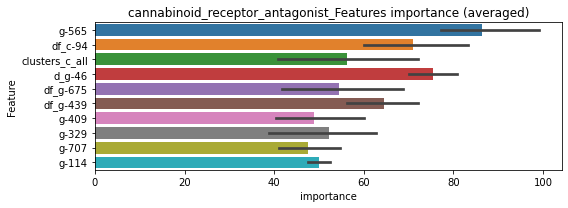

len(train_index) : 3890
len(valid_index) : 3890
================================= fold 1/2 cannabinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0284321	valid_1's binary_logloss: 0.0577229
[200]	training's binary_logloss: 0.00529597	valid_1's binary_logloss: 0.0306466
[300]	training's binary_logloss: 0.00150004	valid_1's binary_logloss: 0.0253541
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.00166023	valid_1's binary_logloss: 0.0252652


len(train_index) : 3890
len(valid_index) : 3890
================================= fold 2/2 cannabinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0266521	valid_1's binary_logloss: 0.0531009
[200]	training's binary_logloss: 0.0051336	valid_1's binary_logloss: 0.0271443
[300]	training's binary_logloss: 0.00146567	valid_1's binary_logloss: 0.0207075
[400]	training's binary_logloss: 0.000661537	valid_1's binary_logloss: 0.0184562
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000531713	valid_1's binary_logloss: 0.0177978


cannabinoid_receptor_antagonist logloss: 0.021531518423988046
carbonic_anhydrase_inhibitor, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.037951	valid_1's binary_logloss: 0.0587775
[200]	training's binary_logloss: 0.00654457	valid_1's binary_logloss: 0.017522
[300]	training's binary_logloss: 0.00174172	valid_1's binary_logloss: 0.00880927
[400]	training's binary_logloss: 0.000838061	valid_1's binary_logloss: 0.00637886
[500]	training's binary_logloss: 0.000550081	valid_1's binary_logloss: 0.00533327
Early stopping, best iteration is:
[534]	training's binary_logloss: 0.00050764	valid_1's binary_logloss: 0.00515116
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0403256	valid_1's binary_logloss: 0.0663151
[200]	training's binary_logloss: 0.00672919	valid_1's binary_logloss: 0.0246102
[300]	training's binary_logloss: 0.00183681	valid_1's binary_logloss: 0.0160702
[400]	training's binary_logloss: 0.000868911	valid_1's binary_logloss: 0.0138416
Early stopping, best iteration is:
[410]

1 / 3 AUC score:1.000
y_Threshold: 0.0046200, Threshold: 0.0061197, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 655/3805
p_label_rate: 0.0200904 Vs.target_rate: 0.00151, Num_p_label: 80.0, conf_0:0.00551, conf_1:0.00673
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0061197
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_2: 0.0161197
Num_p_label: 8.0, Expected: 6.0, Adj_threshold_3: 0.0261197
threshold: 0.0261197, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 655.0/3805, y_label_rate: 0.1721419
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0390752	valid_1's binary_logloss: 0.0570222
[200]	training's binary_logloss: 0.00637558	valid_1's binary_logloss: 0.0147583
[300]	training's binary_logloss: 0.00181671	valid_1's binary_logloss: 0.00612635
[400]	training's binary_logloss: 0.000862543	valid_1's binary_logloss: 0.00393899
[500]	training's binary_logloss: 0.000567364	valid_1's binary_logloss: 0.00313007
Early stopping, best iteration is:
[567]	training's binary_logloss: 0.000498511	valid_1's binary_logloss: 0.00289714
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0386262	valid_1's binary_logloss: 0.0636161
[200]	training's binary_logloss: 0.00596433	valid_1's binary_logloss: 0.0200439
[300]	training's binary_logloss: 0.00169054	valid_1's binary_logloss: 0.011565
[400]	training's binary_logloss: 0.000817922	valid_1's binary_logloss: 0.00897764
[500]	training's binary_logloss: 0.00

2 / 3 AUC score:1.000
y_Threshold: 0.0866133, Threshold: 0.0261197, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0050226 Vs.target_rate: 0.00151, Num_p_label: 20.0, conf_0:0.02351, conf_1:0.02873
Num_p_label: 20.0, Expected: 6.0, Adj_threshold_1: 0.0261197
Num_p_label: 10.0, Expected: 6.0, Adj_threshold_2: 0.0361197
threshold: 0.0361197, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 655.0/3805, y_label_rate: 0.1721419
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0390752	valid_1's binary_logloss: 0.0570222
[200]	training's binary_logloss: 0.00637558	valid_1's binary_logloss: 0.0147583
[300]	training's binary_logloss: 0.00181671	valid_1's binary_logloss: 0.00612635
[400]	training's binary_logloss: 0.000862543	valid_1's binary_logloss: 0.00393899
[500]	training's binary_logloss: 0.000567364	valid_1's binary_logloss: 0.00313007
Early stopping, best iteration is:
[567]	training's binary_logloss: 0.000498511	valid_1's binary_logloss: 0.00289714
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0386262	valid_1's binary_logloss: 0.0636161
[200]	training's binary_logloss: 0.00596433	valid_1's binary_logloss: 0.0200439
[300]	training's binary_logloss: 0.00169054	valid_1's binary_logloss: 0.011565
[400]	training's binary_logloss: 0.000817922	valid_1's binary_logloss: 0.00897764
[500]	training's binary_logloss: 0.00

3 / 3 AUC score:1.000
y_Threshold: 0.0866133, Threshold: 0.0361197, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0025113 Vs.target_rate: 0.00151, Num_p_label: 10.0, conf_0:0.03251, conf_1:0.03973
threshold: 0.0361197, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 665.0/7787, y_label_rate: 0.0853987


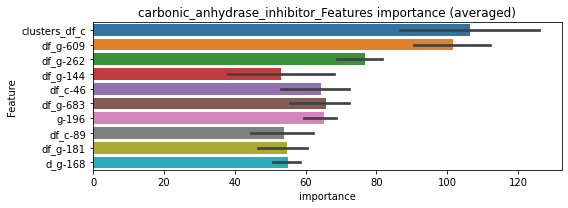

len(train_index) : 3893
len(valid_index) : 3894
================================= fold 1/2 carbonic_anhydrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0209853	valid_1's binary_logloss: 0.0357508
[200]	training's binary_logloss: 0.00341426	valid_1's binary_logloss: 0.0140609
[300]	training's binary_logloss: 0.000959755	valid_1's binary_logloss: 0.0104528
[400]	training's binary_logloss: 0.00045097	valid_1's binary_logloss: 0.00988678
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.000476137	valid_1's binary_logloss: 0.00982561


len(train_index) : 3894
len(valid_index) : 3893
================================= fold 2/2 carbonic_anhydrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0225028	valid_1's binary_logloss: 0.040612
[200]	training's binary_logloss: 0.00364829	valid_1's binary_logloss: 0.0180637
[300]	training's binary_logloss: 0.00100208	valid_1's binary_logloss: 0.0132005
[400]	training's binary_logloss: 0.000462497	valid_1's binary_logloss: 0.0118561
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000347321	valid_1's binary_logloss: 0.0115259


carbonic_anhydrase_inhibitor logloss: 0.010675667000998073
casein_kinase_inhibitor, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0335718	valid_1's binary_logloss: 0.0520379
[200]	training's binary_logloss: 0.00535164	valid_1's binary_logloss: 0.0146953
[300]	training's binary_logloss: 0.00153148	valid_1's binary_logloss: 0.00706035
[400]	training's binary_logloss: 0.000759738	valid_1's binary_logloss: 0.00492894
[500]	training's binary_logloss: 0.000510603	valid_1's binary_logloss: 0.00418037
Early stopping, best iteration is:
[554]	training's binary_logloss: 0.000463517	valid_1's binary_logloss: 0.00401727
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.034148	valid_1's binary_logloss: 0.0490099
[200]	training's binary_logloss: 0.00538212	valid_1's binary_logloss: 0.0117931
[300]	training's binary_logloss: 0.00156333	valid_1's binary_logloss: 0.00468703
[400]	training's binary_logloss: 0.000774169	valid_1's binary_logloss: 0.00287433
[500]	training's binary_logloss: 0.0

1 / 3 AUC score:1.000
y_Threshold: 0.0028513, Threshold: 0.0049917, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00151, Num_p_label: 80.0, conf_0:0.00449, conf_1:0.00549
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0049917
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_2: 0.0149917
Num_p_label: 2.0, Expected: 6.0, Adj_threshold_3: 0.0249917
threshold: 0.0249917, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0331602	valid_1's binary_logloss: 0.051088
[200]	training's binary_logloss: 0.00501936	valid_1's binary_logloss: 0.0132422
[300]	training's binary_logloss: 0.00146692	valid_1's binary_logloss: 0.00662613
[400]	training's binary_logloss: 0.000737699	valid_1's binary_logloss: 0.00485184
[500]	training's binary_logloss: 0.000501043	valid_1's binary_logloss: 0.00414586
Early stopping, best iteration is:
[577]	training's binary_logloss: 0.000451093	valid_1's binary_logloss: 0.00400107
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0340538	valid_1's binary_logloss: 0.0478715
[200]	training's binary_logloss: 0.00525202	valid_1's binary_logloss: 0.010639
[300]	training's binary_logloss: 0.00151043	valid_1's binary_logloss: 0.00411754
[400]	training's binary_logloss: 0.000747326	valid_1's binary_logloss: 0.00242581
[500]	training's binary_logloss: 0.00

2 / 3 AUC score:1.000
y_Threshold: 0.0675719, Threshold: 0.0249917, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0055249 Vs.target_rate: 0.00151, Num_p_label: 22.0, conf_0:0.02249, conf_1:0.02749
Num_p_label: 22.0, Expected: 6.0, Adj_threshold_1: 0.0249917
Num_p_label: 10.0, Expected: 6.0, Adj_threshold_2: 0.0349917
threshold: 0.0349917, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0331602	valid_1's binary_logloss: 0.051088
[200]	training's binary_logloss: 0.00501936	valid_1's binary_logloss: 0.0132422
[300]	training's binary_logloss: 0.00146692	valid_1's binary_logloss: 0.00662613
[400]	training's binary_logloss: 0.000737699	valid_1's binary_logloss: 0.00485184
[500]	training's binary_logloss: 0.000501043	valid_1's binary_logloss: 0.00414586
Early stopping, best iteration is:
[577]	training's binary_logloss: 0.000451093	valid_1's binary_logloss: 0.00400107
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0340538	valid_1's binary_logloss: 0.0478715
[200]	training's binary_logloss: 0.00525202	valid_1's binary_logloss: 0.010639
[300]	training's binary_logloss: 0.00151043	valid_1's binary_logloss: 0.00411754
[400]	training's binary_logloss: 0.000747326	valid_1's binary_logloss: 0.00242581
[500]	training's binary_logloss: 0.00

3 / 3 AUC score:1.000
y_Threshold: 0.0675719, Threshold: 0.0349917, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0025113 Vs.target_rate: 0.00151, Num_p_label: 10.0, conf_0:0.03149, conf_1:0.03849
threshold: 0.0349917, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 666.0/7789, y_label_rate: 0.0855052


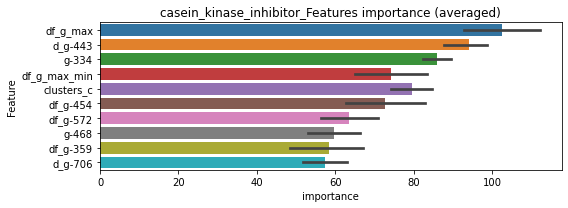

len(train_index) : 3894
len(valid_index) : 3895
================================= fold 1/2 casein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0175334	valid_1's binary_logloss: 0.0345332
[200]	training's binary_logloss: 0.00272164	valid_1's binary_logloss: 0.016073
[300]	training's binary_logloss: 0.000781101	valid_1's binary_logloss: 0.0125454
[400]	training's binary_logloss: 0.000386368	valid_1's binary_logloss: 0.0116725
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.000326121	valid_1's binary_logloss: 0.0115126


len(train_index) : 3895
len(valid_index) : 3894
================================= fold 2/2 casein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0176663	valid_1's binary_logloss: 0.0303109
[200]	training's binary_logloss: 0.00271922	valid_1's binary_logloss: 0.0108699
[300]	training's binary_logloss: 0.000809701	valid_1's binary_logloss: 0.00731652
[400]	training's binary_logloss: 0.000402445	valid_1's binary_logloss: 0.00625124
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.000330177	valid_1's binary_logloss: 0.00603631


casein_kinase_inhibitor logloss: 0.008774813949277009
caspase_activator, len(trt): 18, len(othr): 3287, target_rate: 0.0007559 → Adj_target_rate: 0.0009799


neg labels: 3289 → selected neg labels: 3287


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0242811	valid_1's binary_logloss: 0.0303138
[200]	training's binary_logloss: 0.00291312	valid_1's binary_logloss: 0.00512719
[300]	training's binary_logloss: 0.000819695	valid_1's binary_logloss: 0.00185198
[400]	training's binary_logloss: 0.000428971	valid_1's binary_logloss: 0.00111116
[500]	training's binary_logloss: 0.000348539	valid_1's binary_logloss: 0.000954902
Early stopping, best iteration is:
[573]	training's binary_logloss: 0.000341406	valid_1's binary_logloss: 0.000940659
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0241428	valid_1's binary_logloss: 0.0338743
[200]	training's binary_logloss: 0.0029678	valid_1's binary_logloss: 0.00699456
[300]	training's binary_logloss: 0.000831873	valid_1's binary_logloss: 0.00300312
[400]	training's binary_logloss: 0.000429863	valid_1's binary_logloss: 0.00202347
Early stopping, best iteration

1 / 3 AUC score:1.000
y_Threshold: 0.0016993, Threshold: 0.0028950, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00076, Num_p_label: 80.0, conf_0:0.00261, conf_1:0.00318
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0028950
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_2: 0.0128950
Num_p_label: 3.0, Expected: 3.0, Adj_threshold_3: 0.0228950
threshold: 0.0228950, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0237809	valid_1's binary_logloss: 0.0293425
[200]	training's binary_logloss: 0.00280804	valid_1's binary_logloss: 0.00466992
[300]	training's binary_logloss: 0.00081018	valid_1's binary_logloss: 0.00168472
[400]	training's binary_logloss: 0.000423827	valid_1's binary_logloss: 0.000983354
[500]	training's binary_logloss: 0.000340861	valid_1's binary_logloss: 0.000833242
Early stopping, best iteration is:
[555]	training's binary_logloss: 0.000334738	valid_1's binary_logloss: 0.000824835
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0237014	valid_1's binary_logloss: 0.0324356
[200]	training's binary_logloss: 0.0028158	valid_1's binary_logloss: 0.00776353
[300]	training's binary_logloss: 0.000797802	valid_1's binary_logloss: 0.00413079
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.000474793	valid_1's binary_logloss: 0.0033

2 / 3 AUC score:1.000
y_Threshold: 0.0231554, Threshold: 0.0228950, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0037670 Vs.target_rate: 0.00076, Num_p_label: 15.0, conf_0:0.02061, conf_1:0.02518
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_1: 0.0228950
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_2: 0.0328950
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_3: 0.0428950
threshold: 0.0428950, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0237809	valid_1's binary_logloss: 0.0293425
[200]	training's binary_logloss: 0.00280804	valid_1's binary_logloss: 0.00466992
[300]	training's binary_logloss: 0.00081018	valid_1's binary_logloss: 0.00168472
[400]	training's binary_logloss: 0.000423827	valid_1's binary_logloss: 0.000983354
[500]	training's binary_logloss: 0.000340861	valid_1's binary_logloss: 0.000833242
Early stopping, best iteration is:
[558]	training's binary_logloss: 0.000334738	valid_1's binary_logloss: 0.000824835
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0237014	valid_1's binary_logloss: 0.0324356
[200]	training's binary_logloss: 0.0028158	valid_1's binary_logloss: 0.00776353
[300]	training's binary_logloss: 0.000797802	valid_1's binary_logloss: 0.00413079
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.000474793	valid_1's binary_logloss: 0.0033

3 / 3 AUC score:1.000
y_Threshold: 0.0231554, Threshold: 0.0428950, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0015068 Vs.target_rate: 0.00076, Num_p_label: 6.0, conf_0:0.03861, conf_1:0.04718
threshold: 0.0428950, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 663.0/7794, y_label_rate: 0.0850654


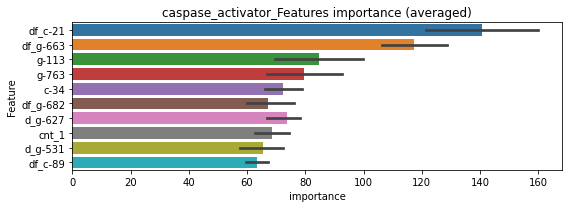

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 caspase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0127129	valid_1's binary_logloss: 0.0197215
[200]	training's binary_logloss: 0.00149202	valid_1's binary_logloss: 0.00701851
[300]	training's binary_logloss: 0.000413157	valid_1's binary_logloss: 0.00606318
Early stopping, best iteration is:
[313]	training's binary_logloss: 0.000369654	valid_1's binary_logloss: 0.00600592


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 caspase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0133054	valid_1's binary_logloss: 0.0173907
[200]	training's binary_logloss: 0.00164401	valid_1's binary_logloss: 0.00346814
[300]	training's binary_logloss: 0.000451046	valid_1's binary_logloss: 0.00192775
[400]	training's binary_logloss: 0.000229347	valid_1's binary_logloss: 0.00163194
Early stopping, best iteration is:
[451]	training's binary_logloss: 0.000188131	valid_1's binary_logloss: 0.00156272


caspase_activator logloss: 0.0037843175632338998
catechol_o_methyltransferase_inhibitor, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230785	valid_1's binary_logloss: 0.0312818
[200]	training's binary_logloss: 0.00278334	valid_1's binary_logloss: 0.00636354
[300]	training's binary_logloss: 0.000797396	valid_1's binary_logloss: 0.00296628
[400]	training's binary_logloss: 0.000425065	valid_1's binary_logloss: 0.00215492
Early stopping, best iteration is:
[488]	training's binary_logloss: 0.000343933	valid_1's binary_logloss: 0.00192297
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0240522	valid_1's binary_logloss: 0.0340937
[200]	training's binary_logloss: 0.00288063	valid_1's binary_logloss: 0.00696442
[300]	training's binary_logloss: 0.000822729	valid_1's binary_logloss: 0.00324065
[400]	training's binary_logloss: 0.00043528	valid_1's binary_logloss: 0.00232334
Early stopping, best iteration is:
[448]	training's binary_logloss: 0.00036709	valid_1's binary_logloss: 0.0021395

1 / 3 AUC score:1.000
y_Threshold: 0.0014063, Threshold: 0.0019867, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076, Num_p_label: 80.0, conf_0:0.00179, conf_1:0.00219
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0019867
Num_p_label: 2.0, Expected: 3.0, Adj_threshold_2: 0.0119867
threshold: 0.0119867, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0234223	valid_1's binary_logloss: 0.0311858
[200]	training's binary_logloss: 0.00273966	valid_1's binary_logloss: 0.00637171
[300]	training's binary_logloss: 0.000791117	valid_1's binary_logloss: 0.00317858
[400]	training's binary_logloss: 0.000425121	valid_1's binary_logloss: 0.0023455
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00035212	valid_1's binary_logloss: 0.00214169
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0241708	valid_1's binary_logloss: 0.0340825
[200]	training's binary_logloss: 0.00284012	valid_1's binary_logloss: 0.00714269
[300]	training's binary_logloss: 0.000809644	valid_1's binary_logloss: 0.00327783
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.000513302	valid_1's binary_logloss: 0.0024999


2 / 3 AUC score:1.000
y_Threshold: 0.0539178, Threshold: 0.0119867, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0027624 Vs.target_rate: 0.00076, Num_p_label: 11.0, conf_0:0.01079, conf_1:0.01319
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_1: 0.0119867
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_2: 0.0219867
threshold: 0.0219867, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0234223	valid_1's binary_logloss: 0.0311858
[200]	training's binary_logloss: 0.00273966	valid_1's binary_logloss: 0.00637171
[300]	training's binary_logloss: 0.000791117	valid_1's binary_logloss: 0.00317858
[400]	training's binary_logloss: 0.000425121	valid_1's binary_logloss: 0.0023455
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00035212	valid_1's binary_logloss: 0.00214169
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0241708	valid_1's binary_logloss: 0.0340825
[200]	training's binary_logloss: 0.00284012	valid_1's binary_logloss: 0.00714269
[300]	training's binary_logloss: 0.000809644	valid_1's binary_logloss: 0.00327783
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.000513302	valid_1's binary_logloss: 0.0024999


3 / 3 AUC score:1.000
y_Threshold: 0.0539178, Threshold: 0.0219867, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0010045 Vs.target_rate: 0.00076, Num_p_label: 4.0, conf_0:0.01979, conf_1:0.02419
threshold: 0.0219867, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 661.0/7793, y_label_rate: 0.0848197


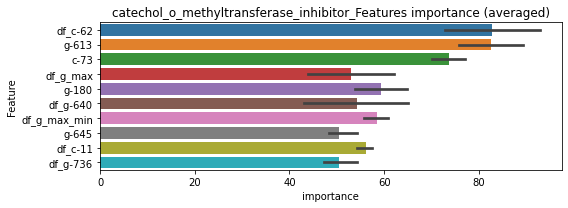

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 catechol_o_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0128367	valid_1's binary_logloss: 0.019028
[200]	training's binary_logloss: 0.00147317	valid_1's binary_logloss: 0.00602245
Early stopping, best iteration is:
[272]	training's binary_logloss: 0.000543013	valid_1's binary_logloss: 0.00495442


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 catechol_o_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0126205	valid_1's binary_logloss: 0.0171218
[200]	training's binary_logloss: 0.00149828	valid_1's binary_logloss: 0.00389322
[300]	training's binary_logloss: 0.000424184	valid_1's binary_logloss: 0.00220608
Early stopping, best iteration is:
[361]	training's binary_logloss: 0.000271322	valid_1's binary_logloss: 0.00196609


catechol_o_methyltransferase_inhibitor logloss: 0.00346044295344663
cc_chemokine_receptor_antagonist, len(trt): 102, len(othr): 3272, target_rate: 0.0042832 → Adj_target_rate: 0.0042806


neg labels: 3289 → selected neg labels: 3272


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0616491	valid_1's binary_logloss: 0.14894
[200]	training's binary_logloss: 0.0152898	valid_1's binary_logloss: 0.106565
[300]	training's binary_logloss: 0.00481725	valid_1's binary_logloss: 0.0925988
[400]	training's binary_logloss: 0.00216974	valid_1's binary_logloss: 0.0885824
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00210488	valid_1's binary_logloss: 0.0883575
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0675333	valid_1's binary_logloss: 0.127012
[200]	training's binary_logloss: 0.0182884	valid_1's binary_logloss: 0.0767436
[300]	training's binary_logloss: 0.00587328	valid_1's binary_logloss: 0.0629757
[400]	training's binary_logloss: 0.00259923	valid_1's binary_logloss: 0.0581313
Early stopping, best iteration is:
[437]	training's binary_logloss: 0.00205649	valid_1's binary_logloss: 0.0572661


1 / 3 AUC score:0.994
y_Threshold: 0.0140861, Threshold: 0.0218415, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 152 → Positive_corect_labels: 644/3774
p_label_rate: 0.0200904 Vs.target_rate: 0.00428, Num_p_label: 80.0, conf_0:0.01966, conf_1:0.02403
Num_p_label: 80.0, Expected: 17.1, Adj_threshold_1: 0.0218415
Num_p_label: 28.0, Expected: 17.1, Adj_threshold_2: 0.0318415
threshold: 0.0318415, positive_p_label: 28.0/3982, p_label_rate: 0.0070316
positive_y_label: 644.0/3774, y_label_rate: 0.1706412
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0609127	valid_1's binary_logloss: 0.13825
[200]	training's binary_logloss: 0.0144843	valid_1's binary_logloss: 0.0872429
[300]	training's binary_logloss: 0.00462119	valid_1's binary_logloss: 0.0716307
Early stopping, best iteration is:
[373]	training's binary_logloss: 0.0025092	valid_1's binary_logloss: 0.0683155
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0644322	valid_1's binary_logloss: 0.125371
[200]	training's binary_logloss: 0.0163587	valid_1's binary_logloss: 0.0731703
[300]	training's binary_logloss: 0.00522386	valid_1's binary_logloss: 0.0581905
[400]	training's binary_logloss: 0.00237195	valid_1's binary_logloss: 0.0534333
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00176491	valid_1's binary_logloss: 0.0519897


2 / 3 AUC score:0.998
y_Threshold: 0.0403577, Threshold: 0.0318415, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 26 → Positive_corect_labels: 631.0/3748
p_label_rate: 0.0238574 Vs.target_rate: 0.00428, Num_p_label: 95.0, conf_0:0.02866, conf_1:0.03503
Num_p_label: 95.0, Expected: 17.1, Adj_threshold_1: 0.0318415
Num_p_label: 59.0, Expected: 17.1, Adj_threshold_2: 0.0418415
Num_p_label: 37.0, Expected: 17.1, Adj_threshold_3: 0.0518415
Num_p_label: 27.0, Expected: 17.1, Adj_threshold_4: 0.0618415
threshold: 0.0618415, positive_p_label: 27.0/3982, p_label_rate: 0.0067805
positive_y_label: 631.0/3748, y_label_rate: 0.1683565
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0571028	valid_1's binary_logloss: 0.127354
[200]	training's binary_logloss: 0.0136273	valid_1's binary_logloss: 0.0792014
[300]	training's binary_logloss: 0.00434233	valid_1's binary_logloss: 0.0652382
[400]	training's binary_logloss: 0.00201391	valid_1's binary_logloss: 0.0608567
Early stopping, best iteration is:
[451]	training's binary_logloss: 0.00152673	valid_1's binary_logloss: 0.0592416
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0624661	valid_1's binary_logloss: 0.11491
[200]	training's binary_logloss: 0.0152871	valid_1's binary_logloss: 0.0679927
[300]	training's binary_logloss: 0.00483987	valid_1's binary_logloss: 0.0549991
[400]	training's binary_logloss: 0.00218822	valid_1's binary_logloss: 0.0504394
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00161455	valid_1's binary_logloss: 0.049419


3 / 3 AUC score:0.998
y_Threshold: 0.0350524, Threshold: 0.0618415, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 20 → Positive_corect_labels: 621.0/3728
p_label_rate: 0.0040181 Vs.target_rate: 0.00428, Num_p_label: 16.0, conf_0:0.05566, conf_1:0.06803
threshold: 0.0618415, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 637.0/7710, y_label_rate: 0.0826200


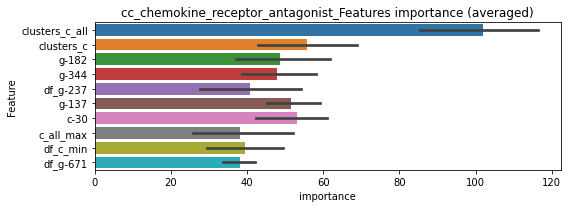

len(train_index) : 3855
len(valid_index) : 3855
================================= fold 1/2 cc_chemokine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0333165	valid_1's binary_logloss: 0.0772806
[200]	training's binary_logloss: 0.00794207	valid_1's binary_logloss: 0.0547126
[300]	training's binary_logloss: 0.00253467	valid_1's binary_logloss: 0.0493774
Early stopping, best iteration is:
[293]	training's binary_logloss: 0.0027077	valid_1's binary_logloss: 0.0492228


len(train_index) : 3855
len(valid_index) : 3855
================================= fold 2/2 cc_chemokine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0317484	valid_1's binary_logloss: 0.0702618
[200]	training's binary_logloss: 0.00741078	valid_1's binary_logloss: 0.0459661
[300]	training's binary_logloss: 0.00232904	valid_1's binary_logloss: 0.0398064
[400]	training's binary_logloss: 0.00105492	valid_1's binary_logloss: 0.0380718
Early stopping, best iteration is:
[407]	training's binary_logloss: 0.00101264	valid_1's binary_logloss: 0.0379136


cc_chemokine_receptor_antagonist logloss: 0.0435681785541268
cck_receptor_antagonist, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0234097	valid_1's binary_logloss: 0.0296439
[200]	training's binary_logloss: 0.00278616	valid_1's binary_logloss: 0.00482837
[300]	training's binary_logloss: 0.000789216	valid_1's binary_logloss: 0.0016882
[400]	training's binary_logloss: 0.000424487	valid_1's binary_logloss: 0.00101448
[500]	training's binary_logloss: 0.000339055	valid_1's binary_logloss: 0.000848447
Early stopping, best iteration is:
[551]	training's binary_logloss: 0.000334525	valid_1's binary_logloss: 0.00084025
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0237754	valid_1's binary_logloss: 0.0317311
[200]	training's binary_logloss: 0.00277842	valid_1's binary_logloss: 0.00572442
[300]	training's binary_logloss: 0.000793439	valid_1's binary_logloss: 0.0022329
[400]	training's binary_logloss: 0.00042758	valid_1's binary_logloss: 0.00141876
[500]	training's binary_logloss: 

1 / 3 AUC score:1.000
y_Threshold: 0.0020996, Threshold: 0.0031636, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076, Num_p_label: 80.0, conf_0:0.00285, conf_1:0.00348
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0031636
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_2: 0.0131636
Num_p_label: 3.0, Expected: 3.0, Adj_threshold_3: 0.0231636
threshold: 0.0231636, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0231111	valid_1's binary_logloss: 0.0283232
[200]	training's binary_logloss: 0.00267224	valid_1's binary_logloss: 0.00449679
[300]	training's binary_logloss: 0.000766882	valid_1's binary_logloss: 0.00150818
[400]	training's binary_logloss: 0.000418133	valid_1's binary_logloss: 0.000920554
[500]	training's binary_logloss: 0.000342283	valid_1's binary_logloss: 0.00078851
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000340974	valid_1's binary_logloss: 0.000785357
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230714	valid_1's binary_logloss: 0.0303803
[200]	training's binary_logloss: 0.00262814	valid_1's binary_logloss: 0.0051413
[300]	training's binary_logloss: 0.000757642	valid_1's binary_logloss: 0.00201897
[400]	training's binary_logloss: 0.000412659	valid_1's binary_logloss: 0.00125173
[500]	training's binary_loglos

2 / 3 AUC score:1.000
y_Threshold: 0.1373470, Threshold: 0.0231636, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0057760 Vs.target_rate: 0.00076, Num_p_label: 23.0, conf_0:0.02085, conf_1:0.02548
Num_p_label: 23.0, Expected: 3.0, Adj_threshold_1: 0.0231636
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_2: 0.0331636
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_3: 0.0431636
threshold: 0.0431636, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0231111	valid_1's binary_logloss: 0.0283232
[200]	training's binary_logloss: 0.00267224	valid_1's binary_logloss: 0.00449679
[300]	training's binary_logloss: 0.000766882	valid_1's binary_logloss: 0.00150818
[400]	training's binary_logloss: 0.000418133	valid_1's binary_logloss: 0.000920554
[500]	training's binary_logloss: 0.000342283	valid_1's binary_logloss: 0.00078851
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000340974	valid_1's binary_logloss: 0.000785357
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230714	valid_1's binary_logloss: 0.0303803
[200]	training's binary_logloss: 0.00262814	valid_1's binary_logloss: 0.0051413
[300]	training's binary_logloss: 0.000757642	valid_1's binary_logloss: 0.00201897
[400]	training's binary_logloss: 0.000412659	valid_1's binary_logloss: 0.00125173
[500]	training's binary_loglos

3 / 3 AUC score:1.000
y_Threshold: 0.1373470, Threshold: 0.0431636, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0015068 Vs.target_rate: 0.00076, Num_p_label: 6.0, conf_0:0.03885, conf_1:0.04748
threshold: 0.0431636, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 663.0/7793, y_label_rate: 0.0850764


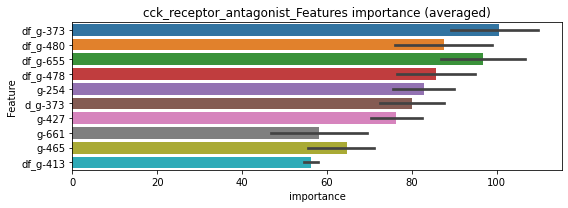

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 cck_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0125914	valid_1's binary_logloss: 0.0220265
[200]	training's binary_logloss: 0.00139776	valid_1's binary_logloss: 0.0103079
[300]	training's binary_logloss: 0.000388863	valid_1's binary_logloss: 0.00932228
Early stopping, best iteration is:
[307]	training's binary_logloss: 0.00036595	valid_1's binary_logloss: 0.00925438


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 cck_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0134192	valid_1's binary_logloss: 0.0191417
[200]	training's binary_logloss: 0.00160983	valid_1's binary_logloss: 0.00524899
[300]	training's binary_logloss: 0.000445203	valid_1's binary_logloss: 0.00318382
[400]	training's binary_logloss: 0.000231205	valid_1's binary_logloss: 0.00270831
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.000220409	valid_1's binary_logloss: 0.00268661


cck_receptor_antagonist logloss: 0.005970915875582025
cdk_inhibitor, len(trt): 352, len(othr): 3263, target_rate: 0.0147812 → Adj_target_rate: 0.0122676


neg labels: 3289 → selected neg labels: 3263


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.046005	valid_1's binary_logloss: 0.121115
Early stopping, best iteration is:
[174]	training's binary_logloss: 0.0128166	valid_1's binary_logloss: 0.109418
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0448645	valid_1's binary_logloss: 0.119347
[200]	training's binary_logloss: 0.0088492	valid_1's binary_logloss: 0.0987334


1 / 3 AUC score:0.978
y_Threshold: 0.0437692, Threshold: 0.3859927, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[202]	training's binary_logloss: 0.00861125	valid_1's binary_logloss: 0.0985648


Remove_noisy_labels: 213 → Positive_corect_labels: 611/3702
p_label_rate: 0.0200904 Vs.target_rate: 0.01478, Num_p_label: 80.0, conf_0:0.34739, conf_1:0.42459
threshold: 0.3859927, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 611.0/3702, y_label_rate: 0.1650459
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0341591	valid_1's binary_logloss: 0.070339
[200]	training's binary_logloss: 0.00593424	valid_1's binary_logloss: 0.0484559
Early stopping, best iteration is:
[208]	training's binary_logloss: 0.00530197	valid_1's binary_logloss: 0.0478588
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0328431	valid_1's binary_logloss: 0.0805655


2 / 3 AUC score:0.994
y_Threshold: 0.1502274, Threshold: 0.3859927, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 66 → Positive_corect_labels: 578.0/3636
p_label_rate: 0.0660472 Vs.target_rate: 0.01478, Num_p_label: 263.0, conf_0:0.34739, conf_1:0.42459
Num_p_label: 263.0, Expected: 58.9, Adj_threshold_1: 0.3859927


Early stopping, best iteration is:
[183]	training's binary_logloss: 0.00666073	valid_1's binary_logloss: 0.0645172


Num_p_label: 260.0, Expected: 58.9, Adj_threshold_2: 0.3959927
Num_p_label: 259.0, Expected: 58.9, Adj_threshold_3: 0.4059927
Num_p_label: 256.0, Expected: 58.9, Adj_threshold_4: 0.4159927
Num_p_label: 254.0, Expected: 58.9, Adj_threshold_5: 0.4259927
Num_p_label: 253.0, Expected: 58.9, Adj_threshold_6: 0.4359927
Num_p_label: 252.0, Expected: 58.9, Adj_threshold_7: 0.4459927
Num_p_label: 252.0, Expected: 58.9, Adj_threshold_8: 0.4559927
Num_p_label: 249.0, Expected: 58.9, Adj_threshold_9: 0.4659927
Num_p_label: 247.0, Expected: 58.9, Adj_threshold_10: 0.4759927
threshold: 0.4859927, positive_p_label: 245.0/3982, p_label_rate: 0.0615269
positive_y_label: 578.0/3636, y_label_rate: 0.1589659
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0249831	valid_1's binary_logloss: 0.0673374
Early stopping, best iteration is:
[136]	training's binary_logloss: 0.0111195	valid_1's binary_logloss: 0.0596739
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.027922	valid_1's binary_logloss: 0.0447782
[200]	training's binary_logloss: 0.00386525	valid_1's binary_logloss: 0.0242048


3 / 3 AUC score:0.994
y_Threshold: 0.1082496, Threshold: 0.4859927, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 44 → Positive_corect_labels: 556.0/3592


Early stopping, best iteration is:
[236]	training's binary_logloss: 0.00229678	valid_1's binary_logloss: 0.022747


p_label_rate: 0.0735811 Vs.target_rate: 0.01478, Num_p_label: 293.0, conf_0:0.43739, conf_1:0.53459
Num_p_label: 293.0, Expected: 58.9, Adj_threshold_1: 0.4859927
Num_p_label: 291.0, Expected: 58.9, Adj_threshold_2: 0.4959927
Num_p_label: 289.0, Expected: 58.9, Adj_threshold_3: 0.5059927
Num_p_label: 284.0, Expected: 58.9, Adj_threshold_4: 0.5159927
Num_p_label: 282.0, Expected: 58.9, Adj_threshold_5: 0.5259927
Num_p_label: 279.0, Expected: 58.9, Adj_threshold_6: 0.5359927
Num_p_label: 278.0, Expected: 58.9, Adj_threshold_7: 0.5459927
Num_p_label: 278.0, Expected: 58.9, Adj_threshold_8: 0.5559927
Num_p_label: 277.0, Expected: 58.9, Adj_threshold_9: 0.5659927
Num_p_label: 277.0, Expected: 58.9, Adj_threshold_10: 0.5759927
threshold: 0.5859927, positive_p_label: 277.0/3982, p_label_rate: 0.0695630
positive_y_label: 833.0/7574, y_label_rate: 0.1099815


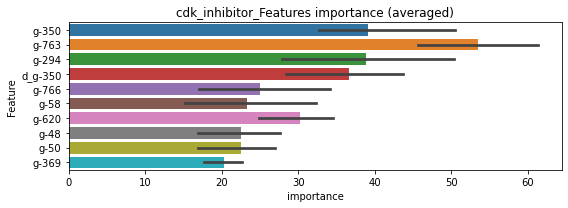

len(train_index) : 3787
len(valid_index) : 3787
================================= fold 1/2 cdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0171108	valid_1's binary_logloss: 0.0342832
[200]	training's binary_logloss: 0.00219924	valid_1's binary_logloss: 0.0226236


len(train_index) : 3787
len(valid_index) : 3787


Early stopping, best iteration is:
[225]	training's binary_logloss: 0.00147581	valid_1's binary_logloss: 0.0221687


================================= fold 2/2 cdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0170755	valid_1's binary_logloss: 0.0277299
[200]	training's binary_logloss: 0.00218349	valid_1's binary_logloss: 0.0164456
Early stopping, best iteration is:
[256]	training's binary_logloss: 0.000958955	valid_1's binary_logloss: 0.0155556


cdk_inhibitor logloss: 0.018862148962175605
chelating_agent, len(trt): 54, len(othr): 3280, target_rate: 0.0022676 → Adj_target_rate: 0.0024931


neg labels: 3289 → selected neg labels: 3280


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0437865	valid_1's binary_logloss: 0.0883768
[200]	training's binary_logloss: 0.00827694	valid_1's binary_logloss: 0.0422626
[300]	training's binary_logloss: 0.00246624	valid_1's binary_logloss: 0.0282425
[400]	training's binary_logloss: 0.00116325	valid_1's binary_logloss: 0.0240271
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.000768946	valid_1's binary_logloss: 0.0220347
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0475549	valid_1's binary_logloss: 0.0847592
[200]	training's binary_logloss: 0.00924292	valid_1's binary_logloss: 0.0308811
[300]	training's binary_logloss: 0.00269042	valid_1's binary_logloss: 0.0160074
[400]	training's binary_logloss: 0.00125221	valid_1's binary_logloss: 0.0115451
[500]	training's binary_logloss: 0.000780118	valid_1's binary_logloss: 0.00974668
[600]	training's binary_logloss: 0.0005888

1 / 3 AUC score:1.000
y_Threshold: 0.0056373, Threshold: 0.0081628, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3804
p_label_rate: 0.0200904 Vs.target_rate: 0.00227, Num_p_label: 80.0, conf_0:0.00735, conf_1:0.00898
Num_p_label: 80.0, Expected: 9.0, Adj_threshold_1: 0.0081628
Num_p_label: 15.0, Expected: 9.0, Adj_threshold_2: 0.0181628
threshold: 0.0181628, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 656.0/3804, y_label_rate: 0.1724501
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.044245	valid_1's binary_logloss: 0.0898336
[200]	training's binary_logloss: 0.00805785	valid_1's binary_logloss: 0.0420741
[300]	training's binary_logloss: 0.00241008	valid_1's binary_logloss: 0.0293565
[400]	training's binary_logloss: 0.00115447	valid_1's binary_logloss: 0.0248663
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000836041	valid_1's binary_logloss: 0.0230694
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0471353	valid_1's binary_logloss: 0.0779059
[200]	training's binary_logloss: 0.00884417	valid_1's binary_logloss: 0.0271981
[300]	training's binary_logloss: 0.00262909	valid_1's binary_logloss: 0.0149419
[400]	training's binary_logloss: 0.00125172	valid_1's binary_logloss: 0.0111801
[500]	training's binary_logloss: 0.000789648	valid_1's binary_logloss: 0.00942201
[600]	training's binary_logloss: 0.00058805

2 / 3 AUC score:1.000
y_Threshold: 0.0337776, Threshold: 0.0181628, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3802
p_label_rate: 0.0115520 Vs.target_rate: 0.00227, Num_p_label: 46.0, conf_0:0.01635, conf_1:0.01998
Num_p_label: 46.0, Expected: 9.0, Adj_threshold_1: 0.0181628
Num_p_label: 15.0, Expected: 9.0, Adj_threshold_2: 0.0281628
threshold: 0.0281628, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 655.0/3802, y_label_rate: 0.1722777
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.044863	valid_1's binary_logloss: 0.0835531
[200]	training's binary_logloss: 0.008356	valid_1's binary_logloss: 0.0347456
[300]	training's binary_logloss: 0.00250026	valid_1's binary_logloss: 0.0217187
[400]	training's binary_logloss: 0.00118929	valid_1's binary_logloss: 0.0177536
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000848006	valid_1's binary_logloss: 0.0163474
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0455586	valid_1's binary_logloss: 0.0826943
[200]	training's binary_logloss: 0.00844792	valid_1's binary_logloss: 0.0352669
[300]	training's binary_logloss: 0.00250906	valid_1's binary_logloss: 0.0227671
[400]	training's binary_logloss: 0.00119335	valid_1's binary_logloss: 0.0185758
[500]	training's binary_logloss: 0.000759177	valid_1's binary_logloss: 0.0164526
Early stopping, best iteration is:
[577]	train

3 / 3 AUC score:1.000
y_Threshold: 0.0336999, Threshold: 0.0281628, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 653.0/3798
p_label_rate: 0.0050226 Vs.target_rate: 0.00227, Num_p_label: 20.0, conf_0:0.02535, conf_1:0.03098
threshold: 0.0281628, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 673.0/7780, y_label_rate: 0.0865039


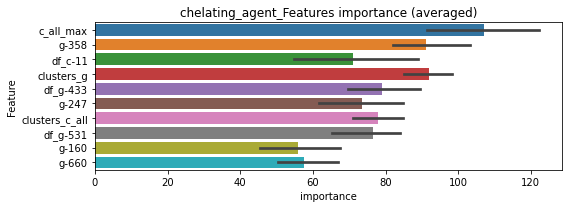

len(train_index) : 3890
len(valid_index) : 3890
================================= fold 1/2 chelating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0249438	valid_1's binary_logloss: 0.0570159
[200]	training's binary_logloss: 0.00451732	valid_1's binary_logloss: 0.0320902
[300]	training's binary_logloss: 0.00133275	valid_1's binary_logloss: 0.0266928
Early stopping, best iteration is:
[388]	training's binary_logloss: 0.000676438	valid_1's binary_logloss: 0.0251631


len(train_index) : 3890
len(valid_index) : 3890
================================= fold 2/2 chelating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0278416	valid_1's binary_logloss: 0.0526065
[200]	training's binary_logloss: 0.00535931	valid_1's binary_logloss: 0.0265735
[300]	training's binary_logloss: 0.00153078	valid_1's binary_logloss: 0.0206443
Early stopping, best iteration is:
[339]	training's binary_logloss: 0.0010748	valid_1's binary_logloss: 0.0198314


chelating_agent logloss: 0.022497250250870147
chk_inhibitor, len(trt): 24, len(othr): 3285, target_rate: 0.0010078 → Adj_target_rate: 0.0012513


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0194275	valid_1's binary_logloss: 0.0248734
[200]	training's binary_logloss: 0.00202407	valid_1's binary_logloss: 0.00415767
[300]	training's binary_logloss: 0.000566238	valid_1's binary_logloss: 0.00183148
[400]	training's binary_logloss: 0.000318536	valid_1's binary_logloss: 0.0013405
[500]	training's binary_logloss: 0.00026744	valid_1's binary_logloss: 0.00119784
Early stopping, best iteration is:
[568]	training's binary_logloss: 0.000260804	valid_1's binary_logloss: 0.00118106
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189869	valid_1's binary_logloss: 0.0230752
[200]	training's binary_logloss: 0.00196379	valid_1's binary_logloss: 0.00422474
[300]	training's binary_logloss: 0.000563009	valid_1's binary_logloss: 0.00245564
[400]	training's binary_logloss: 0.000319902	valid_1's binary_logloss: 0.00202716
Early stopping, best iteration is

1 / 3 AUC score:1.000
y_Threshold: 0.0018937, Threshold: 0.0072723, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00101, Num_p_label: 80.0, conf_0:0.00655, conf_1:0.00800
Num_p_label: 80.0, Expected: 4.0, Adj_threshold_1: 0.0072723
Num_p_label: 44.0, Expected: 4.0, Adj_threshold_2: 0.0172723
Num_p_label: 37.0, Expected: 4.0, Adj_threshold_3: 0.0272723
Num_p_label: 32.0, Expected: 4.0, Adj_threshold_4: 0.0372723
Num_p_label: 30.0, Expected: 4.0, Adj_threshold_5: 0.0472723
Num_p_label: 28.0, Expected: 4.0, Adj_threshold_6: 0.0572723
Num_p_label: 28.0, Expected: 4.0, Adj_threshold_7: 0.0672723
Num_p_label: 27.0, Expected: 4.0, Adj_threshold_8: 0.0772723
Num_p_label: 26.0, Expected: 4.0, Adj_threshold_9: 0.0872723
Num_p_label: 24.0, Expected: 4.0, Adj_threshold_10: 0.0972723
threshold: 0.1072723, positive_p_label: 23.0/3982, p_label_rate: 0.0057760
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0187513	valid_1's binary_logloss: 0.023099
[200]	training's binary_logloss: 0.00175765	valid_1's binary_logloss: 0.00306148
[300]	training's binary_logloss: 0.000473809	valid_1's binary_logloss: 0.00112659
[400]	training's binary_logloss: 0.000274307	valid_1's binary_logloss: 0.000769763
[500]	training's binary_logloss: 0.000234452	valid_1's binary_logloss: 0.000690155
Early stopping, best iteration is:
[522]	training's binary_logloss: 0.000232454	valid_1's binary_logloss: 0.000685815
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185442	valid_1's binary_logloss: 0.0209504
[200]	training's binary_logloss: 0.0017605	valid_1's binary_logloss: 0.00241997
[300]	training's binary_logloss: 0.000472206	valid_1's binary_logloss: 0.000794272
[400]	training's binary_logloss: 0.00027308	valid_1's binary_logloss: 0.000513653
[500]	training's binary_loglo

2 / 3 AUC score:1.000
y_Threshold: 0.2474970, Threshold: 0.1072723, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0160723 Vs.target_rate: 0.00101, Num_p_label: 64.0, conf_0:0.09655, conf_1:0.11800
Num_p_label: 64.0, Expected: 4.0, Adj_threshold_1: 0.1072723
Num_p_label: 62.0, Expected: 4.0, Adj_threshold_2: 0.1172723
Num_p_label: 62.0, Expected: 4.0, Adj_threshold_3: 0.1272723
Num_p_label: 60.0, Expected: 4.0, Adj_threshold_4: 0.1372723
Num_p_label: 58.0, Expected: 4.0, Adj_threshold_5: 0.1472723
Num_p_label: 56.0, Expected: 4.0, Adj_threshold_6: 0.1572723
Num_p_label: 55.0, Expected: 4.0, Adj_threshold_7: 0.1672723
Num_p_label: 53.0, Expected: 4.0, Adj_threshold_8: 0.1772723
Num_p_label: 51.0, Expected: 4.0, Adj_threshold_9: 0.1872723
Num_p_label: 49.0, Expected: 4.0, Adj_threshold_10: 0.1972723
threshold: 0.2072723, positive_p_label: 48.0/3982, p_label_rate: 0.0120542
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0187513	valid_1's binary_logloss: 0.023099
[200]	training's binary_logloss: 0.00175765	valid_1's binary_logloss: 0.00306148
[300]	training's binary_logloss: 0.000473809	valid_1's binary_logloss: 0.00112659
[400]	training's binary_logloss: 0.000274307	valid_1's binary_logloss: 0.000769763
[500]	training's binary_logloss: 0.000234452	valid_1's binary_logloss: 0.000690155
Early stopping, best iteration is:
[522]	training's binary_logloss: 0.000232454	valid_1's binary_logloss: 0.000685815
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185442	valid_1's binary_logloss: 0.0209504
[200]	training's binary_logloss: 0.0017605	valid_1's binary_logloss: 0.00241997
[300]	training's binary_logloss: 0.000472206	valid_1's binary_logloss: 0.000794272
[400]	training's binary_logloss: 0.00027308	valid_1's binary_logloss: 0.000513653
[500]	training's binary_loglo

3 / 3 AUC score:1.000
y_Threshold: 0.2474970, Threshold: 0.2072723, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0120542 Vs.target_rate: 0.00101, Num_p_label: 48.0, conf_0:0.18655, conf_1:0.22800
Num_p_label: 48.0, Expected: 4.0, Adj_threshold_1: 0.2072723
Num_p_label: 46.0, Expected: 4.0, Adj_threshold_2: 0.2172723
Num_p_label: 44.0, Expected: 4.0, Adj_threshold_3: 0.2272723
Num_p_label: 43.0, Expected: 4.0, Adj_threshold_4: 0.2372723
Num_p_label: 42.0, Expected: 4.0, Adj_threshold_5: 0.2472723
Num_p_label: 40.0, Expected: 4.0, Adj_threshold_6: 0.2572723
Num_p_label: 37.0, Expected: 4.0, Adj_threshold_7: 0.2672723
Num_p_label: 35.0, Expected: 4.0, Adj_threshold_8: 0.2772723
Num_p_label: 35.0, Expected: 4.0, Adj_threshold_9: 0.2872723
Num_p_label: 35.0, Expected: 4.0, Adj_threshold_10: 0.2972723
threshold: 0.3072723, positive_p_label: 34.0/3982, p_label_rate: 0.0085384
positive_y_label: 691.0/7792, y_label_rate: 0.0886807


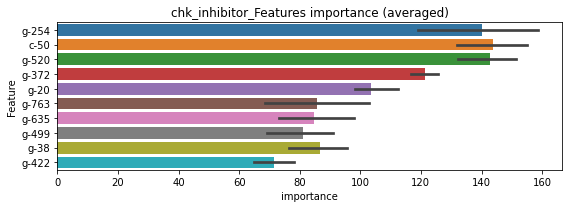

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 chk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0110589	valid_1's binary_logloss: 0.0184988
[200]	training's binary_logloss: 0.0011907	valid_1's binary_logloss: 0.00779063
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.000429082	valid_1's binary_logloss: 0.00686344


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 chk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0113713	valid_1's binary_logloss: 0.0174155
[200]	training's binary_logloss: 0.00122157	valid_1's binary_logloss: 0.00587782
[300]	training's binary_logloss: 0.00034436	valid_1's binary_logloss: 0.00468879
Early stopping, best iteration is:
[347]	training's binary_logloss: 0.000243338	valid_1's binary_logloss: 0.00450631


chk_inhibitor logloss: 0.005684872136892044
chloride_channel_blocker, len(trt): 42, len(othr): 3282, target_rate: 0.0017637 → Adj_target_rate: 0.0020135


neg labels: 3289 → selected neg labels: 3282


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0388696	valid_1's binary_logloss: 0.0663454
[200]	training's binary_logloss: 0.00639167	valid_1's binary_logloss: 0.0225442
[300]	training's binary_logloss: 0.00181502	valid_1's binary_logloss: 0.0131506
[400]	training's binary_logloss: 0.000884829	valid_1's binary_logloss: 0.0102169
[500]	training's binary_logloss: 0.000578284	valid_1's binary_logloss: 0.00909882
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.000586477	valid_1's binary_logloss: 0.00903635
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0413121	valid_1's binary_logloss: 0.0695211
[200]	training's binary_logloss: 0.00688096	valid_1's binary_logloss: 0.0233674
[300]	training's binary_logloss: 0.0019435	valid_1's binary_logloss: 0.0131964
[400]	training's binary_logloss: 0.000929949	valid_1's binary_logloss: 0.00984995
[500]	training's binary_logloss: 0.0006

1 / 3 AUC score:1.000
y_Threshold: 0.0046751, Threshold: 0.0077440, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3806
p_label_rate: 0.0200904 Vs.target_rate: 0.00176, Num_p_label: 80.0, conf_0:0.00697, conf_1:0.00852
Num_p_label: 80.0, Expected: 7.0, Adj_threshold_1: 0.0077440
Num_p_label: 19.0, Expected: 7.0, Adj_threshold_2: 0.0177440
Num_p_label: 6.0, Expected: 7.0, Adj_threshold_3: 0.0277440
threshold: 0.0277440, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 656.0/3806, y_label_rate: 0.1723594
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0387844	valid_1's binary_logloss: 0.0653503
[200]	training's binary_logloss: 0.00625934	valid_1's binary_logloss: 0.020256
[300]	training's binary_logloss: 0.00177998	valid_1's binary_logloss: 0.0108584
[400]	training's binary_logloss: 0.000864256	valid_1's binary_logloss: 0.00820053
[500]	training's binary_logloss: 0.000577637	valid_1's binary_logloss: 0.00709881
Early stopping, best iteration is:
[541]	training's binary_logloss: 0.000521446	valid_1's binary_logloss: 0.00674045
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0395265	valid_1's binary_logloss: 0.064641
[200]	training's binary_logloss: 0.00655443	valid_1's binary_logloss: 0.0209511
[300]	training's binary_logloss: 0.00189567	valid_1's binary_logloss: 0.0117244
[400]	training's binary_logloss: 0.000906657	valid_1's binary_logloss: 0.00917332
[500]	training's binary_logloss: 0.0005

2 / 3 AUC score:1.000
y_Threshold: 0.0487917, Threshold: 0.0277440, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3806
p_label_rate: 0.0077850 Vs.target_rate: 0.00176, Num_p_label: 31.0, conf_0:0.02497, conf_1:0.03052
Num_p_label: 31.0, Expected: 7.0, Adj_threshold_1: 0.0277440
Num_p_label: 21.0, Expected: 7.0, Adj_threshold_2: 0.0377440
Num_p_label: 16.0, Expected: 7.0, Adj_threshold_3: 0.0477440
Num_p_label: 11.0, Expected: 7.0, Adj_threshold_4: 0.0577440
threshold: 0.0577440, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 656.0/3806, y_label_rate: 0.1723594
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0387844	valid_1's binary_logloss: 0.0653503
[200]	training's binary_logloss: 0.00625934	valid_1's binary_logloss: 0.020256
[300]	training's binary_logloss: 0.00177998	valid_1's binary_logloss: 0.0108584
[400]	training's binary_logloss: 0.000864256	valid_1's binary_logloss: 0.00820053
[500]	training's binary_logloss: 0.000577637	valid_1's binary_logloss: 0.00709881
Early stopping, best iteration is:
[541]	training's binary_logloss: 0.000521446	valid_1's binary_logloss: 0.00674045
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0395265	valid_1's binary_logloss: 0.064641
[200]	training's binary_logloss: 0.00655443	valid_1's binary_logloss: 0.0209511
[300]	training's binary_logloss: 0.00189567	valid_1's binary_logloss: 0.0117244
[400]	training's binary_logloss: 0.000906657	valid_1's binary_logloss: 0.00917332
[500]	training's binary_logloss: 0.0005

3 / 3 AUC score:1.000
y_Threshold: 0.0487917, Threshold: 0.0577440, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3806
p_label_rate: 0.0027624 Vs.target_rate: 0.00176, Num_p_label: 11.0, conf_0:0.05197, conf_1:0.06352
threshold: 0.0577440, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 667.0/7788, y_label_rate: 0.0856446


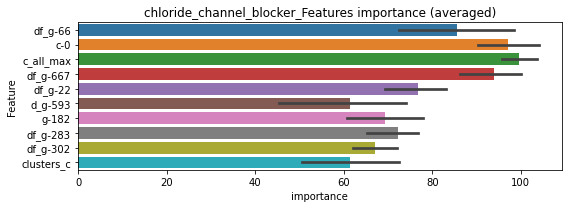

len(train_index) : 3894
len(valid_index) : 3894
================================= fold 1/2 chloride_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0208452	valid_1's binary_logloss: 0.0405976
[200]	training's binary_logloss: 0.00343345	valid_1's binary_logloss: 0.0178849
[300]	training's binary_logloss: 0.000969484	valid_1's binary_logloss: 0.0139382
Early stopping, best iteration is:
[367]	training's binary_logloss: 0.000561563	valid_1's binary_logloss: 0.0134163


len(train_index) : 3894
len(valid_index) : 3894
================================= fold 2/2 chloride_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0219929	valid_1's binary_logloss: 0.0398344
[200]	training's binary_logloss: 0.00375771	valid_1's binary_logloss: 0.0169344
[300]	training's binary_logloss: 0.00105831	valid_1's binary_logloss: 0.0117193
[400]	training's binary_logloss: 0.000497088	valid_1's binary_logloss: 0.010691
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.000497088	valid_1's binary_logloss: 0.010691


chloride_channel_blocker logloss: 0.012053674692858977
cholesterol_inhibitor, len(trt): 48, len(othr): 3281, target_rate: 0.0020156 → Adj_target_rate: 0.0022556


neg labels: 3289 → selected neg labels: 3281


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0451729	valid_1's binary_logloss: 0.0894101
[200]	training's binary_logloss: 0.00839902	valid_1's binary_logloss: 0.0441004
[300]	training's binary_logloss: 0.00232827	valid_1's binary_logloss: 0.0325636
[400]	training's binary_logloss: 0.00107428	valid_1's binary_logloss: 0.0299178
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000869798	valid_1's binary_logloss: 0.0289813
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0455874	valid_1's binary_logloss: 0.0706754
[200]	training's binary_logloss: 0.00839658	valid_1's binary_logloss: 0.0239482
[300]	training's binary_logloss: 0.00239396	valid_1's binary_logloss: 0.0126389
[400]	training's binary_logloss: 0.00115453	valid_1's binary_logloss: 0.00974615
[500]	training's binary_logloss: 0.000724396	valid_1's binary_logloss: 0.00839313
[600]	training's binary_logloss: 0.000568

1 / 3 AUC score:1.000
y_Threshold: 0.0049885, Threshold: 0.0065487, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 655/3803
p_label_rate: 0.0200904 Vs.target_rate: 0.00202, Num_p_label: 80.0, conf_0:0.00589, conf_1:0.00720
Num_p_label: 80.0, Expected: 8.0, Adj_threshold_1: 0.0065487
Num_p_label: 9.0, Expected: 8.0, Adj_threshold_2: 0.0165487
threshold: 0.0165487, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 655.0/3803, y_label_rate: 0.1722324
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0434257	valid_1's binary_logloss: 0.0834111
[200]	training's binary_logloss: 0.00797219	valid_1's binary_logloss: 0.0357422
[300]	training's binary_logloss: 0.00230629	valid_1's binary_logloss: 0.0243055
Early stopping, best iteration is:
[379]	training's binary_logloss: 0.00123357	valid_1's binary_logloss: 0.0216112
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0455149	valid_1's binary_logloss: 0.080604
[200]	training's binary_logloss: 0.00840422	valid_1's binary_logloss: 0.0361439
[300]	training's binary_logloss: 0.00237767	valid_1's binary_logloss: 0.0246307
[400]	training's binary_logloss: 0.00110687	valid_1's binary_logloss: 0.0214496
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00084182	valid_1's binary_logloss: 0.0208871


2 / 3 AUC score:1.000
y_Threshold: 0.0262111, Threshold: 0.0165487, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 10 → Positive_corect_labels: 650.0/3793
p_label_rate: 0.0120542 Vs.target_rate: 0.00202, Num_p_label: 48.0, conf_0:0.01489, conf_1:0.01820
Num_p_label: 48.0, Expected: 8.0, Adj_threshold_1: 0.0165487
Num_p_label: 21.0, Expected: 8.0, Adj_threshold_2: 0.0265487
Num_p_label: 12.0, Expected: 8.0, Adj_threshold_3: 0.0365487
threshold: 0.0365487, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 650.0/3793, y_label_rate: 0.1713683
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0442992	valid_1's binary_logloss: 0.0750669
[200]	training's binary_logloss: 0.00807501	valid_1's binary_logloss: 0.0286086
[300]	training's binary_logloss: 0.0023058	valid_1's binary_logloss: 0.0178759
[400]	training's binary_logloss: 0.00107488	valid_1's binary_logloss: 0.0144066
Early stopping, best iteration is:
[479]	training's binary_logloss: 0.000731985	valid_1's binary_logloss: 0.0135289
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0451423	valid_1's binary_logloss: 0.070635
[200]	training's binary_logloss: 0.00840442	valid_1's binary_logloss: 0.0232997
[300]	training's binary_logloss: 0.00241817	valid_1's binary_logloss: 0.0123686
[400]	training's binary_logloss: 0.00112574	valid_1's binary_logloss: 0.00936228
[500]	training's binary_logloss: 0.000717127	valid_1's binary_logloss: 0.00821365
Early stopping, best iteration is:
[499]	tr

3 / 3 AUC score:1.000
y_Threshold: 0.0198982, Threshold: 0.0365487, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 649.0/3791
p_label_rate: 0.0015068 Vs.target_rate: 0.00202, Num_p_label: 6.0, conf_0:0.03289, conf_1:0.04020
threshold: 0.0365487, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 655.0/7773, y_label_rate: 0.0842660


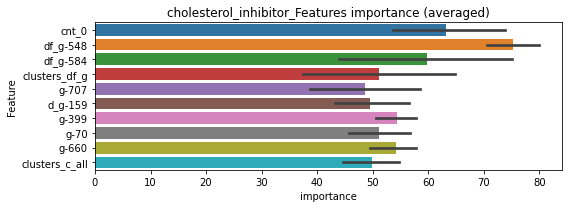

len(train_index) : 3886
len(valid_index) : 3887
================================= fold 1/2 cholesterol_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0228852	valid_1's binary_logloss: 0.0454222
[200]	training's binary_logloss: 0.0039254	valid_1's binary_logloss: 0.0217928
[300]	training's binary_logloss: 0.0010947	valid_1's binary_logloss: 0.0173919
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.00101621	valid_1's binary_logloss: 0.01727


len(train_index) : 3887
len(valid_index) : 3886
================================= fold 2/2 cholesterol_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.026048	valid_1's binary_logloss: 0.0409875
[200]	training's binary_logloss: 0.004816	valid_1's binary_logloss: 0.0151948
[300]	training's binary_logloss: 0.00132618	valid_1's binary_logloss: 0.0091752
[400]	training's binary_logloss: 0.000601229	valid_1's binary_logloss: 0.00770292
[500]	training's binary_logloss: 0.000376639	valid_1's binary_logloss: 0.00699858
Early stopping, best iteration is:
[555]	training's binary_logloss: 0.000319624	valid_1's binary_logloss: 0.00683868


cholesterol_inhibitor logloss: 0.012055004820127148
cholinergic_receptor_antagonist, len(trt): 54, len(othr): 3280, target_rate: 0.0022676 → Adj_target_rate: 0.0024931


neg labels: 3289 → selected neg labels: 3280


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0482673	valid_1's binary_logloss: 0.089192
[200]	training's binary_logloss: 0.0095684	valid_1's binary_logloss: 0.0419924
[300]	training's binary_logloss: 0.00264383	valid_1's binary_logloss: 0.0282875
[400]	training's binary_logloss: 0.00120817	valid_1's binary_logloss: 0.0246124
[500]	training's binary_logloss: 0.000762722	valid_1's binary_logloss: 0.0227944
Early stopping, best iteration is:
[551]	training's binary_logloss: 0.000651262	valid_1's binary_logloss: 0.0222382
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0490441	valid_1's binary_logloss: 0.0921857
[200]	training's binary_logloss: 0.00934456	valid_1's binary_logloss: 0.0436588
[300]	training's binary_logloss: 0.00270876	valid_1's binary_logloss: 0.0316783
Early stopping, best iteration is:
[389]	training's binary_logloss: 0.00133179	valid_1's binary_logloss: 0.0291356


1 / 3 AUC score:0.999
y_Threshold: 0.0071010, Threshold: 0.0124653, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 140 → Positive_corect_labels: 652/3796
p_label_rate: 0.0200904 Vs.target_rate: 0.00227, Num_p_label: 80.0, conf_0:0.01122, conf_1:0.01371
Num_p_label: 80.0, Expected: 9.0, Adj_threshold_1: 0.0124653
Num_p_label: 24.0, Expected: 9.0, Adj_threshold_2: 0.0224653
Num_p_label: 17.0, Expected: 9.0, Adj_threshold_3: 0.0324653
threshold: 0.0324653, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 652.0/3796, y_label_rate: 0.1717597
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0489687	valid_1's binary_logloss: 0.0835209
[200]	training's binary_logloss: 0.00906856	valid_1's binary_logloss: 0.033644
[300]	training's binary_logloss: 0.00253954	valid_1's binary_logloss: 0.0221076
[400]	training's binary_logloss: 0.00117637	valid_1's binary_logloss: 0.0181003
[500]	training's binary_logloss: 0.000755271	valid_1's binary_logloss: 0.0167729
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.000613687	valid_1's binary_logloss: 0.0162631
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0478362	valid_1's binary_logloss: 0.0872452
[200]	training's binary_logloss: 0.00912368	valid_1's binary_logloss: 0.035322
[300]	training's binary_logloss: 0.00264149	valid_1's binary_logloss: 0.0209403
[400]	training's binary_logloss: 0.00122567	valid_1's binary_logloss: 0.0162378
[500]	training's binary_logloss: 0.000781107	

2 / 3 AUC score:1.000
y_Threshold: 0.0366822, Threshold: 0.0324653, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 650.0/3792
p_label_rate: 0.0082873 Vs.target_rate: 0.00227, Num_p_label: 33.0, conf_0:0.02922, conf_1:0.03571
Num_p_label: 33.0, Expected: 9.0, Adj_threshold_1: 0.0324653
Num_p_label: 23.0, Expected: 9.0, Adj_threshold_2: 0.0424653
Num_p_label: 19.0, Expected: 9.0, Adj_threshold_3: 0.0524653
Num_p_label: 14.0, Expected: 9.0, Adj_threshold_4: 0.0624653
threshold: 0.0624653, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 650.0/3792, y_label_rate: 0.1714135
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0463445	valid_1's binary_logloss: 0.0807154
[200]	training's binary_logloss: 0.00870252	valid_1's binary_logloss: 0.0299024
[300]	training's binary_logloss: 0.0025251	valid_1's binary_logloss: 0.017014
[400]	training's binary_logloss: 0.00118804	valid_1's binary_logloss: 0.0126507
[500]	training's binary_logloss: 0.000751658	valid_1's binary_logloss: 0.0110208
Early stopping, best iteration is:
[519]	training's binary_logloss: 0.00070408	valid_1's binary_logloss: 0.0107261
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0498755	valid_1's binary_logloss: 0.0849601
[200]	training's binary_logloss: 0.00941352	valid_1's binary_logloss: 0.0340786
[300]	training's binary_logloss: 0.00268663	valid_1's binary_logloss: 0.0213849
[400]	training's binary_logloss: 0.00124196	valid_1's binary_logloss: 0.0173765
[500]	training's binary_logloss: 0.000782809	v

3 / 3 AUC score:1.000
y_Threshold: 0.0491818, Threshold: 0.0624653, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 649.0/3790
p_label_rate: 0.0035158 Vs.target_rate: 0.00227, Num_p_label: 14.0, conf_0:0.05622, conf_1:0.06871
threshold: 0.0624653, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 663.0/7772, y_label_rate: 0.0853062


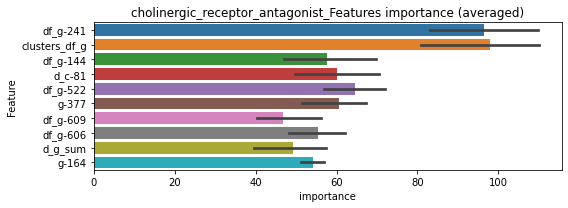

len(train_index) : 3886
len(valid_index) : 3886
================================= fold 1/2 cholinergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0254188	valid_1's binary_logloss: 0.0561686
[200]	training's binary_logloss: 0.00487617	valid_1's binary_logloss: 0.0307789
[300]	training's binary_logloss: 0.00138577	valid_1's binary_logloss: 0.0260008
[400]	training's binary_logloss: 0.000628632	valid_1's binary_logloss: 0.02483
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.000577825	valid_1's binary_logloss: 0.0247844


len(train_index) : 3886
len(valid_index) : 3886
================================= fold 2/2 cholinergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.025735	valid_1's binary_logloss: 0.0513872
[200]	training's binary_logloss: 0.00488658	valid_1's binary_logloss: 0.0247197
[300]	training's binary_logloss: 0.00142625	valid_1's binary_logloss: 0.0175719
[400]	training's binary_logloss: 0.000656034	valid_1's binary_logloss: 0.0151522
Early stopping, best iteration is:
[477]	training's binary_logloss: 0.000446772	valid_1's binary_logloss: 0.0141907


cholinergic_receptor_antagonist logloss: 0.019487558924241852
coagulation_factor_inhibitor, len(trt): 24, len(othr): 3285, target_rate: 0.0010078 → Adj_target_rate: 0.0012513


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0319249	valid_1's binary_logloss: 0.045161
[200]	training's binary_logloss: 0.004285	valid_1's binary_logloss: 0.0101736
[300]	training's binary_logloss: 0.00117371	valid_1's binary_logloss: 0.00422824
[400]	training's binary_logloss: 0.000581499	valid_1's binary_logloss: 0.00277979
[500]	training's binary_logloss: 0.00041135	valid_1's binary_logloss: 0.00232663
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.000406448	valid_1's binary_logloss: 0.00231822
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0330484	valid_1's binary_logloss: 0.0448715
[200]	training's binary_logloss: 0.00454698	valid_1's binary_logloss: 0.00926952
[300]	training's binary_logloss: 0.00121606	valid_1's binary_logloss: 0.00356209
[400]	training's binary_logloss: 0.000595708	valid_1's binary_logloss: 0.00213815
[500]	training's binary_logloss: 0.000

1 / 3 AUC score:1.000
y_Threshold: 0.0023249, Threshold: 0.0034351, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00101, Num_p_label: 80.0, conf_0:0.00309, conf_1:0.00378
Num_p_label: 80.0, Expected: 4.0, Adj_threshold_1: 0.0034351
Num_p_label: 4.0, Expected: 4.0, Adj_threshold_2: 0.0134351
threshold: 0.0134351, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0307914	valid_1's binary_logloss: 0.0437267
[200]	training's binary_logloss: 0.00411798	valid_1's binary_logloss: 0.00969313
[300]	training's binary_logloss: 0.00112681	valid_1's binary_logloss: 0.00414453
[400]	training's binary_logloss: 0.000565057	valid_1's binary_logloss: 0.0027366
[500]	training's binary_logloss: 0.00041559	valid_1's binary_logloss: 0.00230297
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000411921	valid_1's binary_logloss: 0.00228932
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.03159	valid_1's binary_logloss: 0.0432131
[200]	training's binary_logloss: 0.00427599	valid_1's binary_logloss: 0.00835535
[300]	training's binary_logloss: 0.00117256	valid_1's binary_logloss: 0.00293481
[400]	training's binary_logloss: 0.000582541	valid_1's binary_logloss: 0.00168932
[500]	training's binary_logloss: 0.00

2 / 3 AUC score:1.000
y_Threshold: 0.0786422, Threshold: 0.0134351, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0057760 Vs.target_rate: 0.00101, Num_p_label: 23.0, conf_0:0.01209, conf_1:0.01478
Num_p_label: 23.0, Expected: 4.0, Adj_threshold_1: 0.0134351
Num_p_label: 9.0, Expected: 4.0, Adj_threshold_2: 0.0234351
Num_p_label: 5.0, Expected: 4.0, Adj_threshold_3: 0.0334351
threshold: 0.0334351, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0307914	valid_1's binary_logloss: 0.0437267
[200]	training's binary_logloss: 0.00411798	valid_1's binary_logloss: 0.00969313
[300]	training's binary_logloss: 0.00112681	valid_1's binary_logloss: 0.00414453
[400]	training's binary_logloss: 0.000565057	valid_1's binary_logloss: 0.0027366
[500]	training's binary_logloss: 0.00041559	valid_1's binary_logloss: 0.00230297
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000411921	valid_1's binary_logloss: 0.00228932
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.03159	valid_1's binary_logloss: 0.0432131
[200]	training's binary_logloss: 0.00427599	valid_1's binary_logloss: 0.00835535
[300]	training's binary_logloss: 0.00117256	valid_1's binary_logloss: 0.00293481
[400]	training's binary_logloss: 0.000582541	valid_1's binary_logloss: 0.00168932
[500]	training's binary_logloss: 0.00

3 / 3 AUC score:1.000
y_Threshold: 0.0786422, Threshold: 0.0334351, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0012557 Vs.target_rate: 0.00101, Num_p_label: 5.0, conf_0:0.03009, conf_1:0.03678
threshold: 0.0334351, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 662.0/7792, y_label_rate: 0.0849589


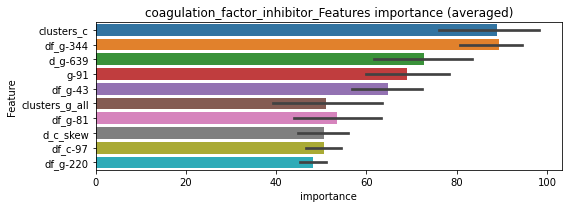

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 coagulation_factor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0172753	valid_1's binary_logloss: 0.0268089
[200]	training's binary_logloss: 0.00223853	valid_1's binary_logloss: 0.00840756
[300]	training's binary_logloss: 0.000593499	valid_1's binary_logloss: 0.00636854
Early stopping, best iteration is:
[332]	training's binary_logloss: 0.000446656	valid_1's binary_logloss: 0.00627114


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 coagulation_factor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0169616	valid_1's binary_logloss: 0.0261979
[200]	training's binary_logloss: 0.00231047	valid_1's binary_logloss: 0.0079122
[300]	training's binary_logloss: 0.000619632	valid_1's binary_logloss: 0.00468395
[400]	training's binary_logloss: 0.000304065	valid_1's binary_logloss: 0.00390427
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.000280908	valid_1's binary_logloss: 0.00380261


coagulation_factor_inhibitor logloss: 0.005036876024330296
corticosteroid_agonist, len(trt): 36, len(othr): 3284, target_rate: 0.0015117 → Adj_target_rate: 0.0017663


neg labels: 3289 → selected neg labels: 3284


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0264291	valid_1's binary_logloss: 0.0448128
[200]	training's binary_logloss: 0.00348515	valid_1's binary_logloss: 0.0176537
[300]	training's binary_logloss: 0.00100471	valid_1's binary_logloss: 0.0128985
[400]	training's binary_logloss: 0.000519239	valid_1's binary_logloss: 0.0115131
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000406724	valid_1's binary_logloss: 0.010991
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.027624	valid_1's binary_logloss: 0.0459501
[200]	training's binary_logloss: 0.00373383	valid_1's binary_logloss: 0.0165133
[300]	training's binary_logloss: 0.001088	valid_1's binary_logloss: 0.0116109
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.000599666	valid_1's binary_logloss: 0.0104758


1 / 3 AUC score:1.000
y_Threshold: 0.0024178, Threshold: 0.0064534, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00151, Num_p_label: 80.0, conf_0:0.00581, conf_1:0.00710
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0064534
Num_p_label: 48.0, Expected: 6.0, Adj_threshold_2: 0.0164534
Num_p_label: 38.0, Expected: 6.0, Adj_threshold_3: 0.0264534
Num_p_label: 32.0, Expected: 6.0, Adj_threshold_4: 0.0364534
Num_p_label: 30.0, Expected: 6.0, Adj_threshold_5: 0.0464534
Num_p_label: 27.0, Expected: 6.0, Adj_threshold_6: 0.0564534
Num_p_label: 26.0, Expected: 6.0, Adj_threshold_7: 0.0664534
Num_p_label: 24.0, Expected: 6.0, Adj_threshold_8: 0.0764534
Num_p_label: 24.0, Expected: 6.0, Adj_threshold_9: 0.0864534
Num_p_label: 21.0, Expected: 6.0, Adj_threshold_10: 0.0964534
threshold: 0.1064534, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0251766	valid_1's binary_logloss: 0.0355029
[200]	training's binary_logloss: 0.00305045	valid_1's binary_logloss: 0.00871006
[300]	training's binary_logloss: 0.000850655	valid_1's binary_logloss: 0.00480952
[400]	training's binary_logloss: 0.000443513	valid_1's binary_logloss: 0.0038842
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.000369227	valid_1's binary_logloss: 0.0036702
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0253705	valid_1's binary_logloss: 0.0358774
[200]	training's binary_logloss: 0.00308569	valid_1's binary_logloss: 0.00993665
[300]	training's binary_logloss: 0.000863484	valid_1's binary_logloss: 0.00658788
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.000477214	valid_1's binary_logloss: 0.00579455


2 / 3 AUC score:1.000
y_Threshold: 0.0355070, Threshold: 0.1064534, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3806
p_label_rate: 0.0107986 Vs.target_rate: 0.00151, Num_p_label: 43.0, conf_0:0.09581, conf_1:0.11710
Num_p_label: 43.0, Expected: 6.0, Adj_threshold_1: 0.1064534
Num_p_label: 42.0, Expected: 6.0, Adj_threshold_2: 0.1164534
Num_p_label: 42.0, Expected: 6.0, Adj_threshold_3: 0.1264534
Num_p_label: 41.0, Expected: 6.0, Adj_threshold_4: 0.1364534
Num_p_label: 40.0, Expected: 6.0, Adj_threshold_5: 0.1464534
Num_p_label: 40.0, Expected: 6.0, Adj_threshold_6: 0.1564534
Num_p_label: 40.0, Expected: 6.0, Adj_threshold_7: 0.1664534
Num_p_label: 39.0, Expected: 6.0, Adj_threshold_8: 0.1764534
Num_p_label: 37.0, Expected: 6.0, Adj_threshold_9: 0.1864534
Num_p_label: 37.0, Expected: 6.0, Adj_threshold_10: 0.1964534
threshold: 0.2064534, positive_p_label: 37.0/3982, p_label_rate: 0.0092918
positive_y_label: 655.0/3806, y_label_rate: 0.1720967
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0255194	valid_1's binary_logloss: 0.0367107
[200]	training's binary_logloss: 0.0030976	valid_1's binary_logloss: 0.00814775
[300]	training's binary_logloss: 0.000856295	valid_1's binary_logloss: 0.00378958
[400]	training's binary_logloss: 0.000445574	valid_1's binary_logloss: 0.00257679
Early stopping, best iteration is:
[399]	training's binary_logloss: 0.000447877	valid_1's binary_logloss: 0.00257403
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0240779	valid_1's binary_logloss: 0.0474262
[200]	training's binary_logloss: 0.0028783	valid_1's binary_logloss: 0.0183008
[300]	training's binary_logloss: 0.000810297	valid_1's binary_logloss: 0.0135563


3 / 3 AUC score:1.000
y_Threshold: 0.0438343, Threshold: 0.2064534, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[315]	training's binary_logloss: 0.000712391	valid_1's binary_logloss: 0.0132298


Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3806
p_label_rate: 0.0090407 Vs.target_rate: 0.00151, Num_p_label: 36.0, conf_0:0.18581, conf_1:0.22710
Num_p_label: 36.0, Expected: 6.0, Adj_threshold_1: 0.2064534
Num_p_label: 36.0, Expected: 6.0, Adj_threshold_2: 0.2164534
Num_p_label: 36.0, Expected: 6.0, Adj_threshold_3: 0.2264534
Num_p_label: 36.0, Expected: 6.0, Adj_threshold_4: 0.2364534
Num_p_label: 35.0, Expected: 6.0, Adj_threshold_5: 0.2464534
Num_p_label: 35.0, Expected: 6.0, Adj_threshold_6: 0.2564534
Num_p_label: 34.0, Expected: 6.0, Adj_threshold_7: 0.2664534
Num_p_label: 33.0, Expected: 6.0, Adj_threshold_8: 0.2764534
Num_p_label: 32.0, Expected: 6.0, Adj_threshold_9: 0.2864534
Num_p_label: 32.0, Expected: 6.0, Adj_threshold_10: 0.2964534
threshold: 0.3064534, positive_p_label: 31.0/3982, p_label_rate: 0.0077850
positive_y_label: 686.0/7788, y_label_rate: 0.0880842


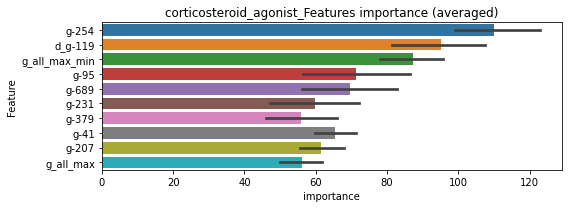

len(train_index) : 3894
len(valid_index) : 3894
================================= fold 1/2 corticosteroid_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0131691	valid_1's binary_logloss: 0.031519
[200]	training's binary_logloss: 0.00158695	valid_1's binary_logloss: 0.016602
[300]	training's binary_logloss: 0.000444961	valid_1's binary_logloss: 0.0133084
Early stopping, best iteration is:
[362]	training's binary_logloss: 0.000281754	valid_1's binary_logloss: 0.012651


len(train_index) : 3894
len(valid_index) : 3894
================================= fold 2/2 corticosteroid_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0134705	valid_1's binary_logloss: 0.0216639
[200]	training's binary_logloss: 0.00165299	valid_1's binary_logloss: 0.00559859
[300]	training's binary_logloss: 0.000471643	valid_1's binary_logloss: 0.00314721
[400]	training's binary_logloss: 0.000243747	valid_1's binary_logloss: 0.00247514
[500]	training's binary_logloss: 0.000181825	valid_1's binary_logloss: 0.00229034
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00018378	valid_1's binary_logloss: 0.00228254


corticosteroid_agonist logloss: 0.0074667545360155236
cyclooxygenase_inhibitor, len(trt): 435, len(othr): 3215, target_rate: 0.0182666 → Adj_target_rate: 0.0146863


neg labels: 3289 → selected neg labels: 3215


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130093	valid_1's binary_logloss: 0.388156
Early stopping, best iteration is:
[142]	training's binary_logloss: 0.0859005	valid_1's binary_logloss: 0.38329
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144223	valid_1's binary_logloss: 0.375869


1 / 3 AUC score:0.759
y_Threshold: 0.1522014, Threshold: 0.2069044, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 755 → Positive_corect_labels: 330/3103
p_label_rate: 0.0200904 Vs.target_rate: 0.01827, Num_p_label: 80.0, conf_0:0.18621, conf_1:0.22759
threshold: 0.2069044, positive_p_label: 80.0/3982, p_label_rate: 0.0200904


Early stopping, best iteration is:
[129]	training's binary_logloss: 0.111355	valid_1's binary_logloss: 0.372919


positive_y_label: 330.0/3103, y_label_rate: 0.1063487
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0659942	valid_1's binary_logloss: 0.234489
Early stopping, best iteration is:
[170]	training's binary_logloss: 0.0275496	valid_1's binary_logloss: 0.225701
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0644605	valid_1's binary_logloss: 0.217505


2 / 3 AUC score:0.911
y_Threshold: 0.0961872, Threshold: 0.2069044, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 220 → Positive_corect_labels: 220.0/2883
p_label_rate: 0.0042692 Vs.target_rate: 0.01827, Num_p_label: 17.0, conf_0:0.18621, conf_1:0.22759
Num_p_label: 17.0, Expected: 72.7, Adj_threshold_1: 0.2069044


Early stopping, best iteration is:
[149]	training's binary_logloss: 0.0344704	valid_1's binary_logloss: 0.2058


Num_p_label: 21.0, Expected: 72.7, Adj_threshold_2: 0.1969044
Num_p_label: 29.0, Expected: 72.7, Adj_threshold_3: 0.1869044
Num_p_label: 38.0, Expected: 72.7, Adj_threshold_4: 0.1769044
threshold: 0.1769044, positive_p_label: 38.0/3982, p_label_rate: 0.0095429
positive_y_label: 220.0/2883, y_label_rate: 0.0763094
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0364749	valid_1's binary_logloss: 0.184795
Early stopping, best iteration is:
[126]	training's binary_logloss: 0.0244745	valid_1's binary_logloss: 0.181525
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0380694	valid_1's binary_logloss: 0.18439


3 / 3 AUC score:0.932
y_Threshold: 0.0669073, Threshold: 0.1769044, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 154 → Positive_corect_labels: 143.0/2729
p_label_rate: 0.0025113 Vs.target_rate: 0.01827, Num_p_label: 10.0, conf_0:0.15921, conf_1:0.19459
Num_p_label: 10.0, Expected: 72.7, Adj_threshold_1: 0.1769044
Num_p_label: 15.0, Expected: 72.7, Adj_threshold_2: 0.1669044
Num_p_label: 19.0, Expected: 72.7, Adj_threshold_3: 0.1569044
Num_p_label: 23.0, Expected: 72.7, Adj_threshold_4: 0.1469044


Early stopping, best iteration is:
[149]	training's binary_logloss: 0.0182877	valid_1's binary_logloss: 0.177867


Num_p_label: 32.0, Expected: 72.7, Adj_threshold_5: 0.1369044
Num_p_label: 43.0, Expected: 72.7, Adj_threshold_6: 0.1269044
threshold: 0.1269044, positive_p_label: 43.0/3982, p_label_rate: 0.0107986
positive_y_label: 186.0/6711, y_label_rate: 0.0277157


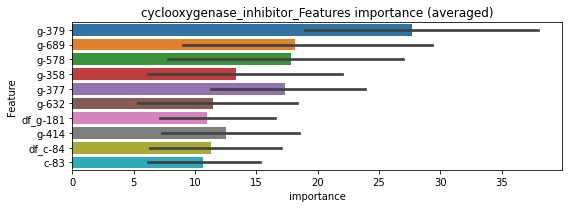

len(train_index) : 3355
len(valid_index) : 3356
================================= fold 1/2 cyclooxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0136535	valid_1's binary_logloss: 0.0828154


len(train_index) : 3356
len(valid_index) : 3355
================================= fold 2/2 cyclooxygenase_inhibitor=================================


Early stopping, best iteration is:
[119]	training's binary_logloss: 0.0102221	valid_1's binary_logloss: 0.0820574
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0121943	valid_1's binary_logloss: 0.090593


cyclooxygenase_inhibitor logloss: 0.0861562479357021


Early stopping, best iteration is:
[109]	training's binary_logloss: 0.0105123	valid_1's binary_logloss: 0.0902563


cytochrome_p450_inhibitor, len(trt): 104, len(othr): 3274, target_rate: 0.0043672 → Adj_target_rate: 0.0043519


neg labels: 3289 → selected neg labels: 3274


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0586969	valid_1's binary_logloss: 0.141968
[200]	training's binary_logloss: 0.0147746	valid_1's binary_logloss: 0.0958314
[300]	training's binary_logloss: 0.00473655	valid_1's binary_logloss: 0.082637
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.00362512	valid_1's binary_logloss: 0.0812052
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.066225	valid_1's binary_logloss: 0.13079
[200]	training's binary_logloss: 0.0167428	valid_1's binary_logloss: 0.0796405
[300]	training's binary_logloss: 0.00534971	valid_1's binary_logloss: 0.0653696
[400]	training's binary_logloss: 0.00237156	valid_1's binary_logloss: 0.0616367
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.00174663	valid_1's binary_logloss: 0.0605373


1 / 3 AUC score:0.992
y_Threshold: 0.0201810, Threshold: 0.0246054, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 164 → Positive_corect_labels: 638/3764
p_label_rate: 0.0200904 Vs.target_rate: 0.00437, Num_p_label: 80.0, conf_0:0.02214, conf_1:0.02707
Num_p_label: 80.0, Expected: 17.4, Adj_threshold_1: 0.0246054
Num_p_label: 29.0, Expected: 17.4, Adj_threshold_2: 0.0346054
threshold: 0.0346054, positive_p_label: 29.0/3982, p_label_rate: 0.0072828
positive_y_label: 638.0/3764, y_label_rate: 0.1695005
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0598013	valid_1's binary_logloss: 0.132032
[200]	training's binary_logloss: 0.014239	valid_1's binary_logloss: 0.0871598
[300]	training's binary_logloss: 0.00435751	valid_1's binary_logloss: 0.0753224
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.002253	valid_1's binary_logloss: 0.0723901
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0580237	valid_1's binary_logloss: 0.131481
[200]	training's binary_logloss: 0.0136866	valid_1's binary_logloss: 0.084489
[300]	training's binary_logloss: 0.00434707	valid_1's binary_logloss: 0.0704973
Early stopping, best iteration is:
[373]	training's binary_logloss: 0.00236915	valid_1's binary_logloss: 0.0671507


2 / 3 AUC score:0.997
y_Threshold: 0.0392423, Threshold: 0.0346054, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 46 → Positive_corect_labels: 615.0/3718
p_label_rate: 0.0133099 Vs.target_rate: 0.00437, Num_p_label: 53.0, conf_0:0.03114, conf_1:0.03807
Num_p_label: 53.0, Expected: 17.4, Adj_threshold_1: 0.0346054
Num_p_label: 33.0, Expected: 17.4, Adj_threshold_2: 0.0446054
threshold: 0.0446054, positive_p_label: 33.0/3982, p_label_rate: 0.0082873
positive_y_label: 615.0/3718, y_label_rate: 0.1654115
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0551826	valid_1's binary_logloss: 0.106838
[200]	training's binary_logloss: 0.0129238	valid_1's binary_logloss: 0.0531573
[300]	training's binary_logloss: 0.00401326	valid_1's binary_logloss: 0.0356859
[400]	training's binary_logloss: 0.00184739	valid_1's binary_logloss: 0.0303496
Early stopping, best iteration is:
[449]	training's binary_logloss: 0.00141896	valid_1's binary_logloss: 0.0286719
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0544139	valid_1's binary_logloss: 0.107326
[200]	training's binary_logloss: 0.012657	valid_1's binary_logloss: 0.0648363
[300]	training's binary_logloss: 0.00401468	valid_1's binary_logloss: 0.054466
Early stopping, best iteration is:
[357]	training's binary_logloss: 0.00247206	valid_1's binary_logloss: 0.0514082


3 / 3 AUC score:1.000
y_Threshold: 0.0424491, Threshold: 0.0446054, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 14 → Positive_corect_labels: 608.0/3704
p_label_rate: 0.0077850 Vs.target_rate: 0.00437, Num_p_label: 31.0, conf_0:0.04014, conf_1:0.04907
threshold: 0.0446054, positive_p_label: 31.0/3982, p_label_rate: 0.0077850
positive_y_label: 639.0/7686, y_label_rate: 0.0831382


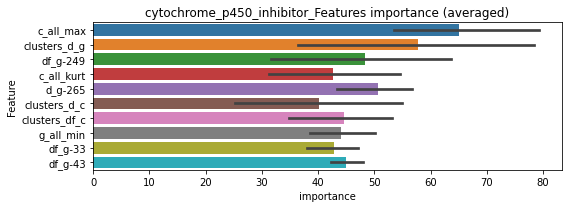

len(train_index) : 3843
len(valid_index) : 3843
================================= fold 1/2 cytochrome_p450_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0294861	valid_1's binary_logloss: 0.0792596
[200]	training's binary_logloss: 0.00673319	valid_1's binary_logloss: 0.0561569
[300]	training's binary_logloss: 0.00217858	valid_1's binary_logloss: 0.050601
Early stopping, best iteration is:
[364]	training's binary_logloss: 0.00124834	valid_1's binary_logloss: 0.0491629


len(train_index) : 3843
len(valid_index) : 3843
================================= fold 2/2 cytochrome_p450_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0324327	valid_1's binary_logloss: 0.0690987
[200]	training's binary_logloss: 0.00739365	valid_1's binary_logloss: 0.043248
[300]	training's binary_logloss: 0.00231244	valid_1's binary_logloss: 0.0377454
Early stopping, best iteration is:
[372]	training's binary_logloss: 0.0012451	valid_1's binary_logloss: 0.0364202


cytochrome_p450_inhibitor logloss: 0.04279158066567583
dihydrofolate_reductase_inhibitor, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0297348	valid_1's binary_logloss: 0.0427798
[200]	training's binary_logloss: 0.00421633	valid_1's binary_logloss: 0.0100512
[300]	training's binary_logloss: 0.00119904	valid_1's binary_logloss: 0.00483184
[400]	training's binary_logloss: 0.000614575	valid_1's binary_logloss: 0.00349445
[500]	training's binary_logloss: 0.000429001	valid_1's binary_logloss: 0.00295847
Early stopping, best iteration is:
[544]	training's binary_logloss: 0.000410212	valid_1's binary_logloss: 0.00291019
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0302675	valid_1's binary_logloss: 0.0452371
[200]	training's binary_logloss: 0.00435873	valid_1's binary_logloss: 0.0119605
[300]	training's binary_logloss: 0.00127272	valid_1's binary_logloss: 0.00737184
[400]	training's binary_logloss: 0.000640059	valid_1's binary_logloss: 0.00608611
Early stopping, best iteration is:


1 / 3 AUC score:1.000
y_Threshold: 0.0023799, Threshold: 0.0033117, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00151, Num_p_label: 80.0, conf_0:0.00298, conf_1:0.00364
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0033117
Num_p_label: 21.0, Expected: 6.0, Adj_threshold_2: 0.0133117
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_3: 0.0233117
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_4: 0.0333117
threshold: 0.0333117, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0288165	valid_1's binary_logloss: 0.0404926
[200]	training's binary_logloss: 0.00402188	valid_1's binary_logloss: 0.00897248
[300]	training's binary_logloss: 0.00115785	valid_1's binary_logloss: 0.00393323
[400]	training's binary_logloss: 0.000597562	valid_1's binary_logloss: 0.00263461
[500]	training's binary_logloss: 0.000422815	valid_1's binary_logloss: 0.00213087
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.000410359	valid_1's binary_logloss: 0.00209513
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0290683	valid_1's binary_logloss: 0.0447611
[200]	training's binary_logloss: 0.00395489	valid_1's binary_logloss: 0.0105893
[300]	training's binary_logloss: 0.00115633	valid_1's binary_logloss: 0.00569897
Early stopping, best iteration is:
[386]	training's binary_logloss: 0.000636984	valid_1's binary_logloss: 0.00490275

2 / 3 AUC score:1.000
y_Threshold: 0.0157498, Threshold: 0.0333117, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0060271 Vs.target_rate: 0.00151, Num_p_label: 24.0, conf_0:0.02998, conf_1:0.03664
Num_p_label: 24.0, Expected: 6.0, Adj_threshold_1: 0.0333117
Num_p_label: 21.0, Expected: 6.0, Adj_threshold_2: 0.0433117
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_3: 0.0533117
Num_p_label: 16.0, Expected: 6.0, Adj_threshold_4: 0.0633117
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_5: 0.0733117
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_6: 0.0833117
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_7: 0.0933117
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_8: 0.1033117
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_9: 0.1133117
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_10: 0.1233117
threshold: 0.1333117, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0288165	valid_1's binary_logloss: 0.0404926
[200]	training's binary_logloss: 0.00402188	valid_1's binary_logloss: 0.00897248
[300]	training's binary_logloss: 0.00115785	valid_1's binary_logloss: 0.00393323
[400]	training's binary_logloss: 0.000597562	valid_1's binary_logloss: 0.00263461
[500]	training's binary_logloss: 0.000422815	valid_1's binary_logloss: 0.00213087
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.000410359	valid_1's binary_logloss: 0.00209513
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0290683	valid_1's binary_logloss: 0.0447611
[200]	training's binary_logloss: 0.00395489	valid_1's binary_logloss: 0.0105893
[300]	training's binary_logloss: 0.00115633	valid_1's binary_logloss: 0.00569897
Early stopping, best iteration is:
[386]	training's binary_logloss: 0.000636984	valid_1's binary_logloss: 0.00490275

3 / 3 AUC score:1.000
y_Threshold: 0.0157498, Threshold: 0.1333117, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0030136 Vs.target_rate: 0.00151, Num_p_label: 12.0, conf_0:0.11998, conf_1:0.14664
threshold: 0.1333117, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 668.0/7789, y_label_rate: 0.0857620


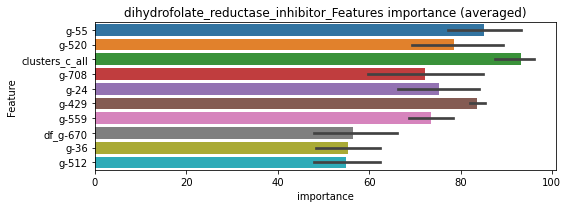

len(train_index) : 3894
len(valid_index) : 3895
================================= fold 1/2 dihydrofolate_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0150572	valid_1's binary_logloss: 0.0265327
[200]	training's binary_logloss: 0.00206913	valid_1's binary_logloss: 0.00896829
[300]	training's binary_logloss: 0.000592959	valid_1's binary_logloss: 0.00590001
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.000332807	valid_1's binary_logloss: 0.00516579


len(train_index) : 3895
len(valid_index) : 3894
================================= fold 2/2 dihydrofolate_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0151852	valid_1's binary_logloss: 0.0232718
[200]	training's binary_logloss: 0.00204824	valid_1's binary_logloss: 0.00604859
[300]	training's binary_logloss: 0.000594566	valid_1's binary_logloss: 0.00341604
[400]	training's binary_logloss: 0.00029987	valid_1's binary_logloss: 0.00282167
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000226215	valid_1's binary_logloss: 0.0026566


dihydrofolate_reductase_inhibitor logloss: 0.003911354873335797
dipeptidyl_peptidase_inhibitor, len(trt): 25, len(othr): 3285, target_rate: 0.0010498 → Adj_target_rate: 0.0012955


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0303626	valid_1's binary_logloss: 0.0464051
[200]	training's binary_logloss: 0.00410837	valid_1's binary_logloss: 0.0119175
[300]	training's binary_logloss: 0.00112887	valid_1's binary_logloss: 0.00554791
[400]	training's binary_logloss: 0.000560154	valid_1's binary_logloss: 0.00380802
[500]	training's binary_logloss: 0.000404717	valid_1's binary_logloss: 0.00328534
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.000399104	valid_1's binary_logloss: 0.00327264
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0299922	valid_1's binary_logloss: 0.0383629
[200]	training's binary_logloss: 0.00413959	valid_1's binary_logloss: 0.00731129
[300]	training's binary_logloss: 0.00116029	valid_1's binary_logloss: 0.00260125
[400]	training's binary_logloss: 0.000577251	valid_1's binary_logloss: 0.0014615
[500]	training's binary_logloss: 0.

1 / 3 AUC score:1.000
y_Threshold: 0.0021910, Threshold: 0.0038150, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00105, Num_p_label: 80.0, conf_0:0.00343, conf_1:0.00420
Num_p_label: 80.0, Expected: 4.2, Adj_threshold_1: 0.0038150
Num_p_label: 11.0, Expected: 4.2, Adj_threshold_2: 0.0138150
Num_p_label: 4.0, Expected: 4.2, Adj_threshold_3: 0.0238150
threshold: 0.0238150, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0297638	valid_1's binary_logloss: 0.0437408
[200]	training's binary_logloss: 0.00389999	valid_1's binary_logloss: 0.0101525
[300]	training's binary_logloss: 0.00108649	valid_1's binary_logloss: 0.00444421
[400]	training's binary_logloss: 0.000546785	valid_1's binary_logloss: 0.00294912
[500]	training's binary_logloss: 0.000399035	valid_1's binary_logloss: 0.00249896
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.000399035	valid_1's binary_logloss: 0.00249896
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0295035	valid_1's binary_logloss: 0.0369407
[200]	training's binary_logloss: 0.00393811	valid_1's binary_logloss: 0.00682257
[300]	training's binary_logloss: 0.00110724	valid_1's binary_logloss: 0.00244503
[400]	training's binary_logloss: 0.000555319	valid_1's binary_logloss: 0.00141015
[500]	training's binary_logloss: 0

2 / 3 AUC score:1.000
y_Threshold: 0.0885754, Threshold: 0.0238150, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0037670 Vs.target_rate: 0.00105, Num_p_label: 15.0, conf_0:0.02143, conf_1:0.02620
Num_p_label: 15.0, Expected: 4.2, Adj_threshold_1: 0.0238150
Num_p_label: 9.0, Expected: 4.2, Adj_threshold_2: 0.0338150
Num_p_label: 5.0, Expected: 4.2, Adj_threshold_3: 0.0438150
threshold: 0.0438150, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0297638	valid_1's binary_logloss: 0.0437408
[200]	training's binary_logloss: 0.00389999	valid_1's binary_logloss: 0.0101525
[300]	training's binary_logloss: 0.00108649	valid_1's binary_logloss: 0.00444421
[400]	training's binary_logloss: 0.000546785	valid_1's binary_logloss: 0.00294912
[500]	training's binary_logloss: 0.000399035	valid_1's binary_logloss: 0.00249896
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.000399035	valid_1's binary_logloss: 0.00249896
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0295035	valid_1's binary_logloss: 0.0369407
[200]	training's binary_logloss: 0.00393811	valid_1's binary_logloss: 0.00682257
[300]	training's binary_logloss: 0.00110724	valid_1's binary_logloss: 0.00244503
[400]	training's binary_logloss: 0.000555319	valid_1's binary_logloss: 0.00141015
[500]	training's binary_logloss: 0

3 / 3 AUC score:1.000
y_Threshold: 0.0885754, Threshold: 0.0438150, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0012557 Vs.target_rate: 0.00105, Num_p_label: 5.0, conf_0:0.03943, conf_1:0.04820
threshold: 0.0438150, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 662.0/7792, y_label_rate: 0.0849589


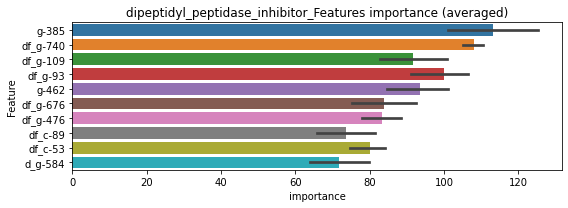

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 dipeptidyl_peptidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0167203	valid_1's binary_logloss: 0.0250435
[200]	training's binary_logloss: 0.00218731	valid_1's binary_logloss: 0.00769982
[300]	training's binary_logloss: 0.00058282	valid_1's binary_logloss: 0.00554939
Early stopping, best iteration is:
[364]	training's binary_logloss: 0.00034949	valid_1's binary_logloss: 0.00526817


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 dipeptidyl_peptidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0169317	valid_1's binary_logloss: 0.0242333
[200]	training's binary_logloss: 0.00225496	valid_1's binary_logloss: 0.00574795
[300]	training's binary_logloss: 0.00061119	valid_1's binary_logloss: 0.00274806
[400]	training's binary_logloss: 0.000300996	valid_1's binary_logloss: 0.00212158
[500]	training's binary_logloss: 0.000211681	valid_1's binary_logloss: 0.00196526
Early stopping, best iteration is:
[541]	training's binary_logloss: 0.000201237	valid_1's binary_logloss: 0.00194265


dipeptidyl_peptidase_inhibitor logloss: 0.003605409082474439
diuretic, len(trt): 6, len(othr): 3288, target_rate: 0.0002520 → Adj_target_rate: 0.0003851


neg labels: 3289 → selected neg labels: 3288


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0156476	valid_1's binary_logloss: 0.016242
[200]	training's binary_logloss: 0.00130474	valid_1's binary_logloss: 0.00158281
[300]	training's binary_logloss: 0.00035456	valid_1's binary_logloss: 0.000569972
[400]	training's binary_logloss: 0.000218988	valid_1's binary_logloss: 0.000402373
[500]	training's binary_logloss: 0.000191293	valid_1's binary_logloss: 0.00036744
Early stopping, best iteration is:
[589]	training's binary_logloss: 0.000188884	valid_1's binary_logloss: 0.000363717
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159018	valid_1's binary_logloss: 0.0176188
[200]	training's binary_logloss: 0.00131065	valid_1's binary_logloss: 0.00204009
[300]	training's binary_logloss: 0.000352784	valid_1's binary_logloss: 0.000773093
[400]	training's binary_logloss: 0.000217733	valid_1's binary_logloss: 0.000540519
[500]	training's binary_logl

1 / 3 AUC score:1.000
y_Threshold: 0.0006043, Threshold: 0.0010998, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0200904 Vs.target_rate: 0.00025, Num_p_label: 80.0, conf_0:0.00099, conf_1:0.00121
Num_p_label: 80.0, Expected: 1.0, Adj_threshold_1: 0.0010998
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_2: 0.0110998
threshold: 0.0110998, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159798	valid_1's binary_logloss: 0.0167197
[200]	training's binary_logloss: 0.00130012	valid_1's binary_logloss: 0.00145596
[300]	training's binary_logloss: 0.000347106	valid_1's binary_logloss: 0.000415095
[400]	training's binary_logloss: 0.000216195	valid_1's binary_logloss: 0.000262858
[500]	training's binary_logloss: 0.000190607	valid_1's binary_logloss: 0.00023284
[600]	training's binary_logloss: 0.000185268	valid_1's binary_logloss: 0.000226623
Early stopping, best iteration is:
[603]	training's binary_logloss: 0.000185164	valid_1's binary_logloss: 0.000226499
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161226	valid_1's binary_logloss: 0.0181277
[200]	training's binary_logloss: 0.00130993	valid_1's binary_logloss: 0.00243497
[300]	training's binary_logloss: 0.00035119	valid_1's binary_logloss: 0.00129575
[400]	training's binary_logl

2 / 3 AUC score:1.000
y_Threshold: 0.0556231, Threshold: 0.0110998, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0032647 Vs.target_rate: 0.00025, Num_p_label: 13.0, conf_0:0.00999, conf_1:0.01221
Num_p_label: 13.0, Expected: 1.0, Adj_threshold_1: 0.0110998
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_2: 0.0210998
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_3: 0.0310998
threshold: 0.0310998, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159798	valid_1's binary_logloss: 0.0167197
[200]	training's binary_logloss: 0.00130012	valid_1's binary_logloss: 0.00145596
[300]	training's binary_logloss: 0.000347106	valid_1's binary_logloss: 0.000415095
[400]	training's binary_logloss: 0.000216195	valid_1's binary_logloss: 0.000262858
[500]	training's binary_logloss: 0.000190607	valid_1's binary_logloss: 0.00023284
[600]	training's binary_logloss: 0.000185268	valid_1's binary_logloss: 0.000226623
Early stopping, best iteration is:
[606]	training's binary_logloss: 0.000185164	valid_1's binary_logloss: 0.000226499
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161226	valid_1's binary_logloss: 0.0181277
[200]	training's binary_logloss: 0.00130993	valid_1's binary_logloss: 0.00243497
[300]	training's binary_logloss: 0.00035119	valid_1's binary_logloss: 0.00129575
[400]	training's binary_logl

3 / 3 AUC score:1.000
y_Threshold: 0.0556231, Threshold: 0.0310998, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0005023 Vs.target_rate: 0.00025, Num_p_label: 2.0, conf_0:0.02799, conf_1:0.03421
threshold: 0.0310998, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 659.0/7795, y_label_rate: 0.0845414


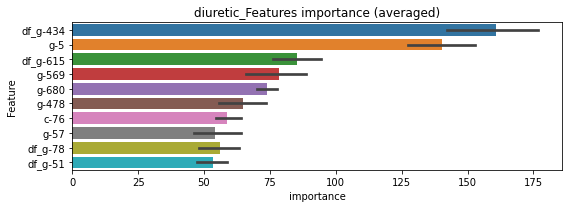

len(train_index) : 3897
len(valid_index) : 3898
================================= fold 1/2 diuretic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00849041	valid_1's binary_logloss: 0.00945143
[200]	training's binary_logloss: 0.000691713	valid_1's binary_logloss: 0.00167809
Early stopping, best iteration is:
[279]	training's binary_logloss: 0.000217723	valid_1's binary_logloss: 0.00129189


len(train_index) : 3898
len(valid_index) : 3897
================================= fold 2/2 diuretic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00850136	valid_1's binary_logloss: 0.0102456
[200]	training's binary_logloss: 0.000680482	valid_1's binary_logloss: 0.00237854
[300]	training's binary_logloss: 0.000179959	valid_1's binary_logloss: 0.00188218


diuretic logloss: 0.0015747183140413417


Early stopping, best iteration is:
[330]	training's binary_logloss: 0.000146166	valid_1's binary_logloss: 0.00185762
neg labels: 3289 → selected neg labels: 3281


dna_alkylating_agent, len(trt): 48, len(othr): 3281, target_rate: 0.0020156 → Adj_target_rate: 0.0022556
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0401167	valid_1's binary_logloss: 0.0770961
[200]	training's binary_logloss: 0.00690299	valid_1's binary_logloss: 0.0288988
[300]	training's binary_logloss: 0.0020439	valid_1's binary_logloss: 0.0171085
[400]	training's binary_logloss: 0.000988655	valid_1's binary_logloss: 0.0130093
[500]	training's binary_logloss: 0.000646089	valid_1's binary_logloss: 0.0114909
Early stopping, best iteration is:
[537]	training's binary_logloss: 0.000586656	valid_1's binary_logloss: 0.0111366
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0423098	valid_1's binary_logloss: 0.0699792
[200]	training's binary_logloss: 0.00754114	valid_1's binary_logloss: 0.0220251
[300]	training's binary_logloss: 0.00215796	valid_1's binary_logloss: 0.0112536
[400]	training's binary_logloss: 0.00104289	valid_1's binary_logloss: 0.00815558
[500]	training's binary_logloss: 0.0006717

1 / 3 AUC score:1.000
y_Threshold: 0.0057970, Threshold: 0.0094862, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3805
p_label_rate: 0.0200904 Vs.target_rate: 0.00202, Num_p_label: 80.0, conf_0:0.00854, conf_1:0.01043
Num_p_label: 80.0, Expected: 8.0, Adj_threshold_1: 0.0094862
Num_p_label: 32.0, Expected: 8.0, Adj_threshold_2: 0.0194862
Num_p_label: 13.0, Expected: 8.0, Adj_threshold_3: 0.0294862
threshold: 0.0294862, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 656.0/3805, y_label_rate: 0.1724047
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.040713	valid_1's binary_logloss: 0.0735336
[200]	training's binary_logloss: 0.00676347	valid_1's binary_logloss: 0.0259139
[300]	training's binary_logloss: 0.00201315	valid_1's binary_logloss: 0.0150927
[400]	training's binary_logloss: 0.000978699	valid_1's binary_logloss: 0.0115761
[500]	training's binary_logloss: 0.0006382	valid_1's binary_logloss: 0.0101753
Early stopping, best iteration is:
[564]	training's binary_logloss: 0.000553221	valid_1's binary_logloss: 0.00975721
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0415205	valid_1's binary_logloss: 0.0711632
[200]	training's binary_logloss: 0.00715136	valid_1's binary_logloss: 0.0223064
[300]	training's binary_logloss: 0.0020791	valid_1's binary_logloss: 0.0114188
[400]	training's binary_logloss: 0.00099426	valid_1's binary_logloss: 0.00810025
[500]	training's binary_logloss: 0.000643355

2 / 3 AUC score:1.000
y_Threshold: 0.0537149, Threshold: 0.0294862, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3805
p_label_rate: 0.0110497 Vs.target_rate: 0.00202, Num_p_label: 44.0, conf_0:0.02654, conf_1:0.03243
Num_p_label: 44.0, Expected: 8.0, Adj_threshold_1: 0.0294862
Num_p_label: 32.0, Expected: 8.0, Adj_threshold_2: 0.0394862
Num_p_label: 24.0, Expected: 8.0, Adj_threshold_3: 0.0494862
Num_p_label: 16.0, Expected: 8.0, Adj_threshold_4: 0.0594862
threshold: 0.0594862, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 656.0/3805, y_label_rate: 0.1724047
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.040713	valid_1's binary_logloss: 0.0735336
[200]	training's binary_logloss: 0.00676347	valid_1's binary_logloss: 0.0259139
[300]	training's binary_logloss: 0.00201315	valid_1's binary_logloss: 0.0150927
[400]	training's binary_logloss: 0.000978699	valid_1's binary_logloss: 0.0115761
[500]	training's binary_logloss: 0.0006382	valid_1's binary_logloss: 0.0101753
Early stopping, best iteration is:
[564]	training's binary_logloss: 0.000553221	valid_1's binary_logloss: 0.00975721
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0415205	valid_1's binary_logloss: 0.0711632
[200]	training's binary_logloss: 0.00715136	valid_1's binary_logloss: 0.0223064
[300]	training's binary_logloss: 0.0020791	valid_1's binary_logloss: 0.0114188
[400]	training's binary_logloss: 0.00099426	valid_1's binary_logloss: 0.00810025
[500]	training's binary_logloss: 0.000643355

3 / 3 AUC score:1.000
y_Threshold: 0.0537149, Threshold: 0.0594862, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3805
p_label_rate: 0.0040181 Vs.target_rate: 0.00202, Num_p_label: 16.0, conf_0:0.05354, conf_1:0.06543
threshold: 0.0594862, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 672.0/7787, y_label_rate: 0.0862977


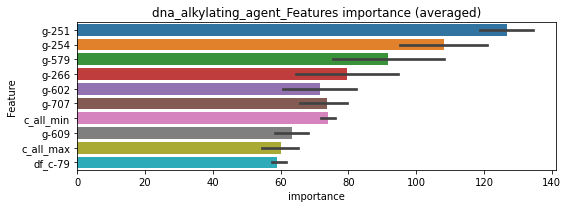

len(train_index) : 3893
len(valid_index) : 3894
================================= fold 1/2 dna_alkylating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0221486	valid_1's binary_logloss: 0.0491947
[200]	training's binary_logloss: 0.00385506	valid_1's binary_logloss: 0.0239423
[300]	training's binary_logloss: 0.0010882	valid_1's binary_logloss: 0.0184944
Early stopping, best iteration is:
[376]	training's binary_logloss: 0.000600217	valid_1's binary_logloss: 0.01718


len(train_index) : 3894
len(valid_index) : 3893
================================= fold 2/2 dna_alkylating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0231198	valid_1's binary_logloss: 0.0474221
[200]	training's binary_logloss: 0.00384788	valid_1's binary_logloss: 0.0222636
[300]	training's binary_logloss: 0.00116429	valid_1's binary_logloss: 0.0182919
[400]	training's binary_logloss: 0.00055943	valid_1's binary_logloss: 0.0168067
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.000522536	valid_1's binary_logloss: 0.0167575


dna_alkylating_agent logloss: 0.01696879182212125
dna_inhibitor, len(trt): 402, len(othr): 3229, target_rate: 0.0168808 → Adj_target_rate: 0.0137338


neg labels: 3289 → selected neg labels: 3229


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130169	valid_1's binary_logloss: 0.356974
Early stopping, best iteration is:
[153]	training's binary_logloss: 0.0765776	valid_1's binary_logloss: 0.348359
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112856	valid_1's binary_logloss: 0.368035


1 / 3 AUC score:0.792
y_Threshold: 0.1260375, Threshold: 0.1919325, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 668 → Positive_corect_labels: 376/3206
p_label_rate: 0.0200904 Vs.target_rate: 0.01688, Num_p_label: 80.0, conf_0:0.17274, conf_1:0.21113
threshold: 0.1919325, positive_p_label: 80.0/3982, p_label_rate: 0.0200904


Early stopping, best iteration is:
[154]	training's binary_logloss: 0.0646194	valid_1's binary_logloss: 0.361225


positive_y_label: 376.0/3206, y_label_rate: 0.1172801
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0577733	valid_1's binary_logloss: 0.229055
Early stopping, best iteration is:
[173]	training's binary_logloss: 0.021229	valid_1's binary_logloss: 0.216699
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0604826	valid_1's binary_logloss: 0.21911


2 / 3 AUC score:0.934
y_Threshold: 0.0799740, Threshold: 0.1919325, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 200 → Positive_corect_labels: 276.0/3006
p_label_rate: 0.0258664 Vs.target_rate: 0.01688, Num_p_label: 103.0, conf_0:0.17274, conf_1:0.21113
threshold: 0.1919325, positive_p_label: 103.0/3982, p_label_rate: 0.0258664


Early stopping, best iteration is:
[183]	training's binary_logloss: 0.0197536	valid_1's binary_logloss: 0.198303


positive_y_label: 276.0/3006, y_label_rate: 0.0918164
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.037795	valid_1's binary_logloss: 0.157596
Early stopping, best iteration is:
[130]	training's binary_logloss: 0.0230554	valid_1's binary_logloss: 0.151285
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0375646	valid_1's binary_logloss: 0.170739


3 / 3 AUC score:0.943
y_Threshold: 0.0757724, Threshold: 0.1919325, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 138 → Positive_corect_labels: 207.0/2868
p_label_rate: 0.0487192 Vs.target_rate: 0.01688, Num_p_label: 194.0, conf_0:0.17274, conf_1:0.21113
threshold: 0.1919325, positive_p_label: 194.0/3982, p_label_rate: 0.0487192


Early stopping, best iteration is:
[145]	training's binary_logloss: 0.0186124	valid_1's binary_logloss: 0.165447


positive_y_label: 401.0/6850, y_label_rate: 0.0585401


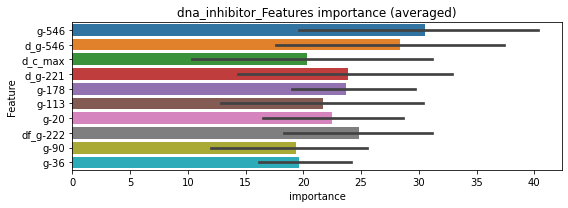

len(train_index) : 3425
len(valid_index) : 3425
================================= fold 1/2 dna_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0187955	valid_1's binary_logloss: 0.0726283
[200]	training's binary_logloss: 0.0038891	valid_1's binary_logloss: 0.0635185
Early stopping, best iteration is:
[211]	training's binary_logloss: 0.00337581	valid_1's binary_logloss: 0.0627836


len(train_index) : 3425
len(valid_index) : 3425
================================= fold 2/2 dna_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0173085	valid_1's binary_logloss: 0.0793556


dna_inhibitor logloss: 0.0687814055421875


Early stopping, best iteration is:
[149]	training's binary_logloss: 0.00733754	valid_1's binary_logloss: 0.0747793


dopamine_receptor_agonist, len(trt): 121, len(othr): 3267, target_rate: 0.0050810 → Adj_target_rate: 0.0049495


neg labels: 3289 → selected neg labels: 3267


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0772774	valid_1's binary_logloss: 0.171356
[200]	training's binary_logloss: 0.022244	valid_1's binary_logloss: 0.119972
[300]	training's binary_logloss: 0.0072831	valid_1's binary_logloss: 0.105732
[400]	training's binary_logloss: 0.00302332	valid_1's binary_logloss: 0.101766
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.00320632	valid_1's binary_logloss: 0.101721
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0823957	valid_1's binary_logloss: 0.167356
[200]	training's binary_logloss: 0.0243186	valid_1's binary_logloss: 0.109106
[300]	training's binary_logloss: 0.0082273	valid_1's binary_logloss: 0.0895913
[400]	training's binary_logloss: 0.00349966	valid_1's binary_logloss: 0.084486
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.00342591	valid_1's binary_logloss: 0.0844032


1 / 3 AUC score:0.989
y_Threshold: 0.0226254, Threshold: 0.0358835, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 179 → Positive_corect_labels: 629/3741
p_label_rate: 0.0200904 Vs.target_rate: 0.00508, Num_p_label: 80.0, conf_0:0.03230, conf_1:0.03947
Num_p_label: 80.0, Expected: 20.2, Adj_threshold_1: 0.0358835
Num_p_label: 40.0, Expected: 20.2, Adj_threshold_2: 0.0458835
threshold: 0.0458835, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 629.0/3741, y_label_rate: 0.1681369
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0720308	valid_1's binary_logloss: 0.161545
[200]	training's binary_logloss: 0.0193618	valid_1's binary_logloss: 0.104291
[300]	training's binary_logloss: 0.00621194	valid_1's binary_logloss: 0.0890702
[400]	training's binary_logloss: 0.00264265	valid_1's binary_logloss: 0.0825685
Early stopping, best iteration is:
[421]	training's binary_logloss: 0.00231271	valid_1's binary_logloss: 0.0817857
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0726021	valid_1's binary_logloss: 0.165859
[200]	training's binary_logloss: 0.0202475	valid_1's binary_logloss: 0.107871
[300]	training's binary_logloss: 0.00638377	valid_1's binary_logloss: 0.0879596
[400]	training's binary_logloss: 0.00276692	valid_1's binary_logloss: 0.0827975
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.00268405	valid_1's binary_logloss: 0.0826161


2 / 3 AUC score:0.995
y_Threshold: 0.0475414, Threshold: 0.0458835, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 60 → Positive_corect_labels: 599.0/3681
p_label_rate: 0.0135610 Vs.target_rate: 0.00508, Num_p_label: 54.0, conf_0:0.04130, conf_1:0.05047
threshold: 0.0458835, positive_p_label: 54.0/3982, p_label_rate: 0.0135610
positive_y_label: 599.0/3681, y_label_rate: 0.1627275
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0683633	valid_1's binary_logloss: 0.143145
[200]	training's binary_logloss: 0.0171108	valid_1's binary_logloss: 0.0891305
[300]	training's binary_logloss: 0.00545912	valid_1's binary_logloss: 0.0732571
Early stopping, best iteration is:
[339]	training's binary_logloss: 0.00385059	valid_1's binary_logloss: 0.0703012
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.066042	valid_1's binary_logloss: 0.149784
[200]	training's binary_logloss: 0.0163786	valid_1's binary_logloss: 0.0983785
[300]	training's binary_logloss: 0.00515782	valid_1's binary_logloss: 0.0828666
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.00395471	valid_1's binary_logloss: 0.0812333


3 / 3 AUC score:0.994
y_Threshold: 0.0459635, Threshold: 0.0458835, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 42 → Positive_corect_labels: 578.0/3639
p_label_rate: 0.0228528 Vs.target_rate: 0.00508, Num_p_label: 91.0, conf_0:0.04130, conf_1:0.05047
Num_p_label: 91.0, Expected: 20.2, Adj_threshold_1: 0.0458835
Num_p_label: 58.0, Expected: 20.2, Adj_threshold_2: 0.0558835
Num_p_label: 39.0, Expected: 20.2, Adj_threshold_3: 0.0658835
threshold: 0.0658835, positive_p_label: 39.0/3982, p_label_rate: 0.0097941
positive_y_label: 617.0/7621, y_label_rate: 0.0809605


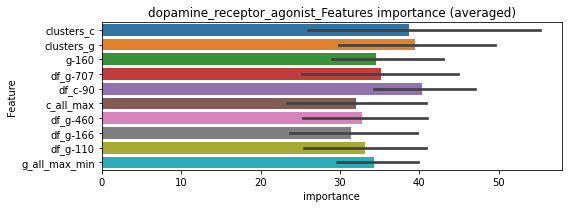

len(train_index) : 3810
len(valid_index) : 3811
================================= fold 1/2 dopamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0392298	valid_1's binary_logloss: 0.102177
[200]	training's binary_logloss: 0.0102478	valid_1's binary_logloss: 0.0714545
Early stopping, best iteration is:
[281]	training's binary_logloss: 0.00384062	valid_1's binary_logloss: 0.0640169


len(train_index) : 3811
len(valid_index) : 3810
================================= fold 2/2 dopamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0400659	valid_1's binary_logloss: 0.0940075
[200]	training's binary_logloss: 0.0108772	valid_1's binary_logloss: 0.0658286
[300]	training's binary_logloss: 0.00341898	valid_1's binary_logloss: 0.0608577
Early stopping, best iteration is:
[291]	training's binary_logloss: 0.00375893	valid_1's binary_logloss: 0.0605218


dopamine_receptor_agonist logloss: 0.062269597667970106
dopamine_receptor_antagonist, len(trt): 424, len(othr): 3221, target_rate: 0.0178047 → Adj_target_rate: 0.0143701


neg labels: 3289 → selected neg labels: 3221


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141851	valid_1's binary_logloss: 0.382411
Early stopping, best iteration is:
[133]	training's binary_logloss: 0.1055	valid_1's binary_logloss: 0.379671
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131216	valid_1's binary_logloss: 0.379777


1 / 3 AUC score:0.763
y_Threshold: 0.1505247, Threshold: 0.2028938, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 765 → Positive_corect_labels: 326/3100


Early stopping, best iteration is:
[134]	training's binary_logloss: 0.0931819	valid_1's binary_logloss: 0.374895


p_label_rate: 0.0200904 Vs.target_rate: 0.01780, Num_p_label: 80.0, conf_0:0.18260, conf_1:0.22318
threshold: 0.2028938, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 326.0/3100, y_label_rate: 0.1051613
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0658081	valid_1's binary_logloss: 0.225236
Early stopping, best iteration is:
[130]	training's binary_logloss: 0.0444632	valid_1's binary_logloss: 0.219834
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0638927	valid_1's binary_logloss: 0.233681


2 / 3 AUC score:0.907
y_Threshold: 0.1064058, Threshold: 0.2028938, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 228 → Positive_corect_labels: 212.0/2872
p_label_rate: 0.0062783 Vs.target_rate: 0.01780, Num_p_label: 25.0, conf_0:0.18260, conf_1:0.22318
threshold: 0.2028938, positive_p_label: 25.0/3982, p_label_rate: 0.0062783


Early stopping, best iteration is:
[154]	training's binary_logloss: 0.032928	valid_1's binary_logloss: 0.227012


positive_y_label: 212.0/2872, y_label_rate: 0.0738162
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0322109	valid_1's binary_logloss: 0.169133
Early stopping, best iteration is:
[126]	training's binary_logloss: 0.0213695	valid_1's binary_logloss: 0.166426
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0346708	valid_1's binary_logloss: 0.156324
Early stopping, best iteration is:
[96]	training's binary_logloss: 0.0369506	valid_1's binary_logloss: 0.1559


3 / 3 AUC score:0.929
y_Threshold: 0.0795622, Threshold: 0.2028938, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 136 → Positive_corect_labels: 144.0/2736
p_label_rate: 0.0012557 Vs.target_rate: 0.01780, Num_p_label: 5.0, conf_0:0.18260, conf_1:0.22318
Num_p_label: 5.0, Expected: 70.9, Adj_threshold_1: 0.2028938
Num_p_label: 6.0, Expected: 70.9, Adj_threshold_2: 0.1928938
Num_p_label: 7.0, Expected: 70.9, Adj_threshold_3: 0.1828938
Num_p_label: 12.0, Expected: 70.9, Adj_threshold_4: 0.1728938
Num_p_label: 21.0, Expected: 70.9, Adj_threshold_5: 0.1628938
Num_p_label: 27.0, Expected: 70.9, Adj_threshold_6: 0.1528938
Num_p_label: 30.0, Expected: 70.9, Adj_threshold_7: 0.1428938
Num_p_label: 39.0, Expected: 70.9, Adj_threshold_8: 0.1328938
threshold: 0.1328938, positive_p_label: 39.0/3982, p_label_rate: 0.0097941
positive_y_label: 183.0/6718, y_label_rate: 0.0272403


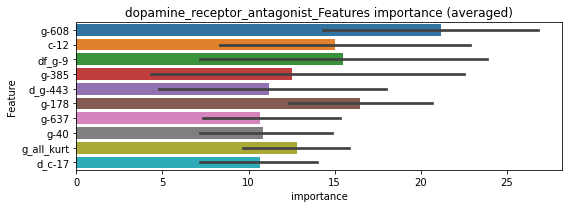

len(train_index) : 3359
len(valid_index) : 3359
================================= fold 1/2 dopamine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0121616	valid_1's binary_logloss: 0.0727108


len(train_index) : 3359
len(valid_index) : 3359
================================= fold 2/2 dopamine_receptor_antagonist=================================


Early stopping, best iteration is:
[150]	training's binary_logloss: 0.00556961	valid_1's binary_logloss: 0.0707602
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0124848	valid_1's binary_logloss: 0.0738943


dopamine_receptor_antagonist logloss: 0.07147059078058465


Early stopping, best iteration is:
[122]	training's binary_logloss: 0.00863282	valid_1's binary_logloss: 0.072181


egfr_inhibitor, len(trt): 336, len(othr): 3264, target_rate: 0.0141093 → Adj_target_rate: 0.0117920


neg labels: 3289 → selected neg labels: 3264


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0445453	valid_1's binary_logloss: 0.130327
[200]	training's binary_logloss: 0.00860335	valid_1's binary_logloss: 0.112008
Early stopping, best iteration is:
[219]	training's binary_logloss: 0.00665818	valid_1's binary_logloss: 0.110438
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0473375	valid_1's binary_logloss: 0.120071
[200]	training's binary_logloss: 0.00946565	valid_1's binary_logloss: 0.0902014
Early stopping, best iteration is:
[278]	training's binary_logloss: 0.00371163	valid_1's binary_logloss: 0.0848573


1 / 3 AUC score:0.982
y_Threshold: 0.0308288, Threshold: 0.2438333, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 198 → Positive_corect_labels: 619/3718
p_label_rate: 0.0200904 Vs.target_rate: 0.01411, Num_p_label: 80.0, conf_0:0.21945, conf_1:0.26822
threshold: 0.2438333, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 619.0/3718, y_label_rate: 0.1664874
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0377741	valid_1's binary_logloss: 0.0801158
[200]	training's binary_logloss: 0.00644448	valid_1's binary_logloss: 0.0465223
[300]	training's binary_logloss: 0.00198261	valid_1's binary_logloss: 0.0401987
Early stopping, best iteration is:
[386]	training's binary_logloss: 0.00106059	valid_1's binary_logloss: 0.0388454
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0359307	valid_1's binary_logloss: 0.102144
[200]	training's binary_logloss: 0.00603987	valid_1's binary_logloss: 0.0734218


2 / 3 AUC score:0.997
y_Threshold: 0.0639399, Threshold: 0.2438333, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[281]	training's binary_logloss: 0.00219837	valid_1's binary_logloss: 0.068391


Remove_noisy_labels: 50 → Positive_corect_labels: 594.0/3668
p_label_rate: 0.0296334 Vs.target_rate: 0.01411, Num_p_label: 118.0, conf_0:0.21945, conf_1:0.26822
threshold: 0.2438333, positive_p_label: 118.0/3982, p_label_rate: 0.0296334
positive_y_label: 594.0/3668, y_label_rate: 0.1619411
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0317636	valid_1's binary_logloss: 0.0782773
[200]	training's binary_logloss: 0.00532711	valid_1's binary_logloss: 0.0527018
Early stopping, best iteration is:
[283]	training's binary_logloss: 0.00189129	valid_1's binary_logloss: 0.0481645
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0328151	valid_1's binary_logloss: 0.0675765
[200]	training's binary_logloss: 0.00531991	valid_1's binary_logloss: 0.0345285
[300]	training's binary_logloss: 0.00161173	valid_1's binary_logloss: 0.0259979
[400]	training's binary_logloss: 0.000814144	valid_1's binary_logloss: 0.0236942
Early stopping, best iteration is:
[468]	training's binary_logloss: 0.000607017	valid_1's binary_logloss: 0.0226151


3 / 3 AUC score:0.997
y_Threshold: 0.0736514, Threshold: 0.2438333, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 22 → Positive_corect_labels: 583.0/3646
p_label_rate: 0.0296334 Vs.target_rate: 0.01411, Num_p_label: 118.0, conf_0:0.21945, conf_1:0.26822
threshold: 0.2438333, positive_p_label: 118.0/3982, p_label_rate: 0.0296334
positive_y_label: 701.0/7628, y_label_rate: 0.0918983


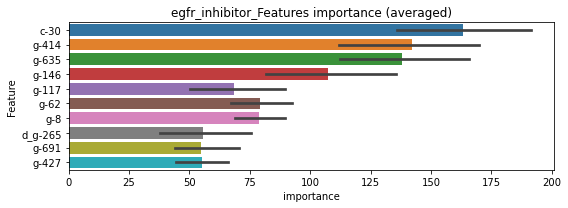

len(train_index) : 3814
len(valid_index) : 3814
================================= fold 1/2 egfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0187065	valid_1's binary_logloss: 0.0477672
[200]	training's binary_logloss: 0.00296197	valid_1's binary_logloss: 0.0293114
[300]	training's binary_logloss: 0.000896109	valid_1's binary_logloss: 0.0250113
[400]	training's binary_logloss: 0.000449729	valid_1's binary_logloss: 0.0233775
Early stopping, best iteration is:
[469]	training's binary_logloss: 0.000332345	valid_1's binary_logloss: 0.0228202


len(train_index) : 3814
len(valid_index) : 3814
================================= fold 2/2 egfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0187773	valid_1's binary_logloss: 0.052559
[200]	training's binary_logloss: 0.00300398	valid_1's binary_logloss: 0.0360931
[300]	training's binary_logloss: 0.000914717	valid_1's binary_logloss: 0.03243
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.000579782	valid_1's binary_logloss: 0.0311315


egfr_inhibitor logloss: 0.02697588662874387
elastase_inhibitor, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942


neg labels: 3289 → selected neg labels: 3287


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0205058	valid_1's binary_logloss: 0.0262082
[200]	training's binary_logloss: 0.00223146	valid_1's binary_logloss: 0.00447446
[300]	training's binary_logloss: 0.000634208	valid_1's binary_logloss: 0.00183072
[400]	training's binary_logloss: 0.000341554	valid_1's binary_logloss: 0.00121843
Early stopping, best iteration is:
[483]	training's binary_logloss: 0.000296373	valid_1's binary_logloss: 0.00116412
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.020379	valid_1's binary_logloss: 0.0244172
[200]	training's binary_logloss: 0.0022254	valid_1's binary_logloss: 0.00399631
[300]	training's binary_logloss: 0.000630867	valid_1's binary_logloss: 0.00159688
[400]	training's binary_logloss: 0.000346956	valid_1's binary_logloss: 0.00106388
Early stopping, best iteration is:
[484]	training's binary_logloss: 0.00029786	valid_1's binary_logloss: 0.00097612

1 / 3 AUC score:1.000
y_Threshold: 0.0010516, Threshold: 0.0014851, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00050, Num_p_label: 80.0, conf_0:0.00134, conf_1:0.00163
Num_p_label: 80.0, Expected: 2.0, Adj_threshold_1: 0.0014851
Num_p_label: 1.0, Expected: 2.0, Adj_threshold_2: 0.0114851
threshold: 0.0114851, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0205128	valid_1's binary_logloss: 0.026652
[200]	training's binary_logloss: 0.00217151	valid_1's binary_logloss: 0.00430089
[300]	training's binary_logloss: 0.00060807	valid_1's binary_logloss: 0.00180367
[400]	training's binary_logloss: 0.000341248	valid_1's binary_logloss: 0.00126532
Early stopping, best iteration is:
[452]	training's binary_logloss: 0.000302905	valid_1's binary_logloss: 0.00119258
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0205974	valid_1's binary_logloss: 0.0257044
[200]	training's binary_logloss: 0.00221756	valid_1's binary_logloss: 0.00396493
[300]	training's binary_logloss: 0.000620692	valid_1's binary_logloss: 0.00142779
[400]	training's binary_logloss: 0.000342539	valid_1's binary_logloss: 0.000915765
Early stopping, best iteration is:
[478]	training's binary_logloss: 0.000297899	valid_1's binary_logloss: 0.000845

2 / 3 AUC score:1.000
y_Threshold: 0.1074550, Threshold: 0.0114851, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0020090 Vs.target_rate: 0.00050, Num_p_label: 8.0, conf_0:0.01034, conf_1:0.01263
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_1: 0.0114851
Num_p_label: 1.0, Expected: 2.0, Adj_threshold_2: 0.0214851
threshold: 0.0214851, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0205128	valid_1's binary_logloss: 0.026652
[200]	training's binary_logloss: 0.00217151	valid_1's binary_logloss: 0.00430089
[300]	training's binary_logloss: 0.00060807	valid_1's binary_logloss: 0.00180367
[400]	training's binary_logloss: 0.000341248	valid_1's binary_logloss: 0.00126532
Early stopping, best iteration is:
[452]	training's binary_logloss: 0.000302905	valid_1's binary_logloss: 0.00119258
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0205974	valid_1's binary_logloss: 0.0257044
[200]	training's binary_logloss: 0.00221756	valid_1's binary_logloss: 0.00396493
[300]	training's binary_logloss: 0.000620692	valid_1's binary_logloss: 0.00142779
[400]	training's binary_logloss: 0.000342539	valid_1's binary_logloss: 0.000915765
Early stopping, best iteration is:
[478]	training's binary_logloss: 0.000297899	valid_1's binary_logloss: 0.000845

3 / 3 AUC score:1.000
y_Threshold: 0.1074550, Threshold: 0.0214851, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0002511 Vs.target_rate: 0.00050, Num_p_label: 1.0, conf_0:0.01934, conf_1:0.02363
threshold: 0.0214851, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 658.0/7794, y_label_rate: 0.0844239


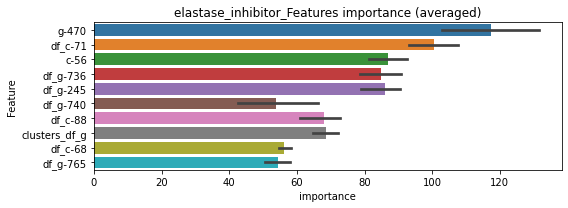

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 elastase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0109388	valid_1's binary_logloss: 0.0152445
[200]	training's binary_logloss: 0.0011265	valid_1's binary_logloss: 0.00339061
[300]	training's binary_logloss: 0.00030715	valid_1's binary_logloss: 0.00216185
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.000187835	valid_1's binary_logloss: 0.00193134


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 elastase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0108561	valid_1's binary_logloss: 0.0132594
[200]	training's binary_logloss: 0.00114727	valid_1's binary_logloss: 0.00205709
[300]	training's binary_logloss: 0.000315715	valid_1's binary_logloss: 0.00080117
[400]	training's binary_logloss: 0.00017028	valid_1's binary_logloss: 0.000548052
Early stopping, best iteration is:
[488]	training's binary_logloss: 0.000147236	valid_1's binary_logloss: 0.000507696


elastase_inhibitor logloss: 0.0012195228097083028
erbb2_inhibitor, len(trt): 20, len(othr): 3284, target_rate: 0.0008398 → Adj_target_rate: 0.0010717


neg labels: 3289 → selected neg labels: 3284


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0264233	valid_1's binary_logloss: 0.0368951
[200]	training's binary_logloss: 0.00335477	valid_1's binary_logloss: 0.00718686
[300]	training's binary_logloss: 0.000955455	valid_1's binary_logloss: 0.00278079
[400]	training's binary_logloss: 0.000499381	valid_1's binary_logloss: 0.00176471
[500]	training's binary_logloss: 0.000381231	valid_1's binary_logloss: 0.00148213
Early stopping, best iteration is:
[514]	training's binary_logloss: 0.000376487	valid_1's binary_logloss: 0.00147432
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0273321	valid_1's binary_logloss: 0.0374322
[200]	training's binary_logloss: 0.00346431	valid_1's binary_logloss: 0.00745872
[300]	training's binary_logloss: 0.000969013	valid_1's binary_logloss: 0.00307429
[400]	training's binary_logloss: 0.000497925	valid_1's binary_logloss: 0.00199824
Early stopping, best iteration 

1 / 3 AUC score:1.000
y_Threshold: 0.0015206, Threshold: 0.0024632, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00084, Num_p_label: 80.0, conf_0:0.00222, conf_1:0.00271
Num_p_label: 80.0, Expected: 3.3, Adj_threshold_1: 0.0024632
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_2: 0.0124632
threshold: 0.0124632, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0263331	valid_1's binary_logloss: 0.0385716
[200]	training's binary_logloss: 0.00329534	valid_1's binary_logloss: 0.00784399
[300]	training's binary_logloss: 0.000934586	valid_1's binary_logloss: 0.003093
[400]	training's binary_logloss: 0.000489108	valid_1's binary_logloss: 0.00201117
[500]	training's binary_logloss: 0.00038283	valid_1's binary_logloss: 0.00172365
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000381006	valid_1's binary_logloss: 0.00172084
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0266219	valid_1's binary_logloss: 0.0349507
[200]	training's binary_logloss: 0.00336716	valid_1's binary_logloss: 0.00637119
[300]	training's binary_logloss: 0.000954328	valid_1's binary_logloss: 0.00250619
[400]	training's binary_logloss: 0.000493576	valid_1's binary_logloss: 0.0015831
[500]	training's binary_logloss: 0.

2 / 3 AUC score:1.000
y_Threshold: 0.1059136, Threshold: 0.0124632, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0020090 Vs.target_rate: 0.00084, Num_p_label: 8.0, conf_0:0.01122, conf_1:0.01371
threshold: 0.0124632, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0263331	valid_1's binary_logloss: 0.0385716
[200]	training's binary_logloss: 0.00329534	valid_1's binary_logloss: 0.00784399
[300]	training's binary_logloss: 0.000934586	valid_1's binary_logloss: 0.003093
[400]	training's binary_logloss: 0.000489108	valid_1's binary_logloss: 0.00201117
[500]	training's binary_logloss: 0.00038283	valid_1's binary_logloss: 0.00172365
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000381006	valid_1's binary_logloss: 0.00172084
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0266219	valid_1's binary_logloss: 0.0349507
[200]	training's binary_logloss: 0.00336716	valid_1's binary_logloss: 0.00637119
[300]	training's binary_logloss: 0.000954328	valid_1's binary_logloss: 0.00250619
[400]	training's binary_logloss: 0.000493576	valid_1's binary_logloss: 0.0015831
[500]	training's binary_logloss: 0.

3 / 3 AUC score:1.000
y_Threshold: 0.1059136, Threshold: 0.0124632, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0020090 Vs.target_rate: 0.00084, Num_p_label: 8.0, conf_0:0.01122, conf_1:0.01371
threshold: 0.0124632, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 664.0/7790, y_label_rate: 0.0852375


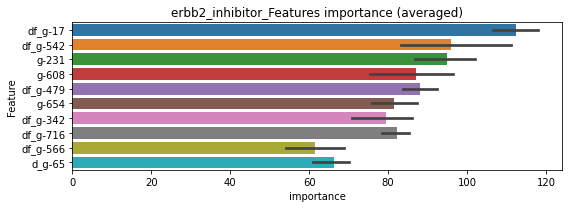

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 erbb2_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0146715	valid_1's binary_logloss: 0.0254372
[200]	training's binary_logloss: 0.00183584	valid_1's binary_logloss: 0.0114315
[300]	training's binary_logloss: 0.000500021	valid_1's binary_logloss: 0.0100405
Early stopping, best iteration is:
[291]	training's binary_logloss: 0.00054301	valid_1's binary_logloss: 0.00998585


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 erbb2_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0151514	valid_1's binary_logloss: 0.0210896
[200]	training's binary_logloss: 0.00198101	valid_1's binary_logloss: 0.00641915
[300]	training's binary_logloss: 0.000550151	valid_1's binary_logloss: 0.00456767
[400]	training's binary_logloss: 0.000274015	valid_1's binary_logloss: 0.00411581
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.000241049	valid_1's binary_logloss: 0.00407016


erbb2_inhibitor logloss: 0.007028002502048618
estrogen_receptor_agonist, len(trt): 158, len(othr): 3265, target_rate: 0.0066348 → Adj_target_rate: 0.0062095


neg labels: 3289 → selected neg labels: 3265


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.08157	valid_1's binary_logloss: 0.192904
[200]	training's binary_logloss: 0.0264139	valid_1's binary_logloss: 0.144354
[300]	training's binary_logloss: 0.00967616	valid_1's binary_logloss: 0.131389
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00759594	valid_1's binary_logloss: 0.130327
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0851304	valid_1's binary_logloss: 0.175782
[200]	training's binary_logloss: 0.0269145	valid_1's binary_logloss: 0.127087
[300]	training's binary_logloss: 0.00984275	valid_1's binary_logloss: 0.110269
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00516994	valid_1's binary_logloss: 0.104364


1 / 3 AUC score:0.985
y_Threshold: 0.0388027, Threshold: 0.0494643, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 201 → Positive_corect_labels: 618/3717
p_label_rate: 0.0200904 Vs.target_rate: 0.00663, Num_p_label: 80.0, conf_0:0.04452, conf_1:0.05441
Num_p_label: 80.0, Expected: 26.4, Adj_threshold_1: 0.0494643
Num_p_label: 49.0, Expected: 26.4, Adj_threshold_2: 0.0594643
threshold: 0.0594643, positive_p_label: 49.0/3982, p_label_rate: 0.0123054
positive_y_label: 618.0/3717, y_label_rate: 0.1662631
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0764686	valid_1's binary_logloss: 0.162182
[200]	training's binary_logloss: 0.0224541	valid_1's binary_logloss: 0.111581
[300]	training's binary_logloss: 0.00737189	valid_1's binary_logloss: 0.0963323
Early stopping, best iteration is:
[383]	training's binary_logloss: 0.00361201	valid_1's binary_logloss: 0.0922765
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0701498	valid_1's binary_logloss: 0.176435
[200]	training's binary_logloss: 0.0198848	valid_1's binary_logloss: 0.134372
[300]	training's binary_logloss: 0.00668418	valid_1's binary_logloss: 0.123492
Early stopping, best iteration is:
[347]	training's binary_logloss: 0.00438376	valid_1's binary_logloss: 0.121277


2 / 3 AUC score:0.990
y_Threshold: 0.0494219, Threshold: 0.0594643, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 80 → Positive_corect_labels: 578.0/3637
p_label_rate: 0.0148167 Vs.target_rate: 0.00663, Num_p_label: 59.0, conf_0:0.05352, conf_1:0.06541
threshold: 0.0594643, positive_p_label: 59.0/3982, p_label_rate: 0.0148167
positive_y_label: 578.0/3637, y_label_rate: 0.1589222
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0617723	valid_1's binary_logloss: 0.157816
[200]	training's binary_logloss: 0.0149165	valid_1's binary_logloss: 0.120646
[300]	training's binary_logloss: 0.00497622	valid_1's binary_logloss: 0.114004
Early stopping, best iteration is:
[361]	training's binary_logloss: 0.00297602	valid_1's binary_logloss: 0.112022
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0687247	valid_1's binary_logloss: 0.158751
[200]	training's binary_logloss: 0.0187503	valid_1's binary_logloss: 0.112861
[300]	training's binary_logloss: 0.006058	valid_1's binary_logloss: 0.0998965
Early stopping, best iteration is:
[367]	training's binary_logloss: 0.00341164	valid_1's binary_logloss: 0.0960652


3 / 3 AUC score:0.989
y_Threshold: 0.0445849, Threshold: 0.0594643, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 68 → Positive_corect_labels: 544.0/3569
p_label_rate: 0.0080362 Vs.target_rate: 0.00663, Num_p_label: 32.0, conf_0:0.05352, conf_1:0.06541
threshold: 0.0594643, positive_p_label: 32.0/3982, p_label_rate: 0.0080362
positive_y_label: 576.0/7551, y_label_rate: 0.0762813


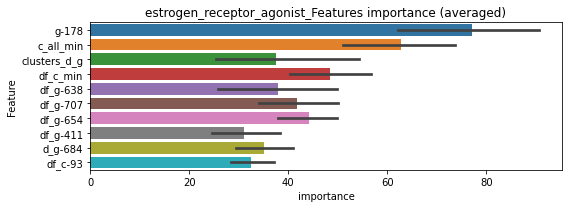

len(train_index) : 3775
len(valid_index) : 3776
================================= fold 1/2 estrogen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0329841	valid_1's binary_logloss: 0.0941134
[200]	training's binary_logloss: 0.00869721	valid_1's binary_logloss: 0.0732638
[300]	training's binary_logloss: 0.00279648	valid_1's binary_logloss: 0.0692907
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.00212817	valid_1's binary_logloss: 0.068773


len(train_index) : 3776
len(valid_index) : 3775
================================= fold 2/2 estrogen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0347538	valid_1's binary_logloss: 0.0915673
[200]	training's binary_logloss: 0.00919405	valid_1's binary_logloss: 0.0724991
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.00408988	valid_1's binary_logloss: 0.0702568


estrogen_receptor_agonist logloss: 0.06951482106379897
estrogen_receptor_antagonist, len(trt): 48, len(othr): 3283, target_rate: 0.0020156 → Adj_target_rate: 0.0022556


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0404346	valid_1's binary_logloss: 0.083846
[200]	training's binary_logloss: 0.00734898	valid_1's binary_logloss: 0.042353
[300]	training's binary_logloss: 0.00209353	valid_1's binary_logloss: 0.0334337
[400]	training's binary_logloss: 0.00100489	valid_1's binary_logloss: 0.0312405
Early stopping, best iteration is:
[398]	training's binary_logloss: 0.00101538	valid_1's binary_logloss: 0.0312112
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0431315	valid_1's binary_logloss: 0.0678633
[200]	training's binary_logloss: 0.00789828	valid_1's binary_logloss: 0.0234545
[300]	training's binary_logloss: 0.00232818	valid_1's binary_logloss: 0.0128689
[400]	training's binary_logloss: 0.00110255	valid_1's binary_logloss: 0.00997539
[500]	training's binary_logloss: 0.000701114	valid_1's binary_logloss: 0.0084755
Early stopping, best iteration is:
[587]	trai

1 / 3 AUC score:0.997
y_Threshold: 0.0048138, Threshold: 0.0082656, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 138 → Positive_corect_labels: 653/3801
p_label_rate: 0.0200904 Vs.target_rate: 0.00202, Num_p_label: 80.0, conf_0:0.00744, conf_1:0.00909
Num_p_label: 80.0, Expected: 8.0, Adj_threshold_1: 0.0082656
Num_p_label: 22.0, Expected: 8.0, Adj_threshold_2: 0.0182656
Num_p_label: 9.0, Expected: 8.0, Adj_threshold_3: 0.0282656
threshold: 0.0282656, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 653.0/3801, y_label_rate: 0.1717969
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0423818	valid_1's binary_logloss: 0.0798312
[200]	training's binary_logloss: 0.00760442	valid_1's binary_logloss: 0.03037
[300]	training's binary_logloss: 0.00215889	valid_1's binary_logloss: 0.0185979
[400]	training's binary_logloss: 0.00103256	valid_1's binary_logloss: 0.0152161
[500]	training's binary_logloss: 0.000666946	valid_1's binary_logloss: 0.0139198
Early stopping, best iteration is:
[498]	training's binary_logloss: 0.000670797	valid_1's binary_logloss: 0.0139082
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0401441	valid_1's binary_logloss: 0.0796812
[200]	training's binary_logloss: 0.00711865	valid_1's binary_logloss: 0.0336575
[300]	training's binary_logloss: 0.00210384	valid_1's binary_logloss: 0.0238024
Early stopping, best iteration is:
[366]	training's binary_logloss: 0.00124488	valid_1's binary_logloss: 0.0207972


2 / 3 AUC score:1.000
y_Threshold: 0.0355409, Threshold: 0.0282656, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 652.0/3799
p_label_rate: 0.0090407 Vs.target_rate: 0.00202, Num_p_label: 36.0, conf_0:0.02544, conf_1:0.03109
Num_p_label: 36.0, Expected: 8.0, Adj_threshold_1: 0.0282656
Num_p_label: 23.0, Expected: 8.0, Adj_threshold_2: 0.0382656
Num_p_label: 13.0, Expected: 8.0, Adj_threshold_3: 0.0482656
threshold: 0.0482656, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 652.0/3799, y_label_rate: 0.1716241
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0385777	valid_1's binary_logloss: 0.079899
[200]	training's binary_logloss: 0.00678619	valid_1's binary_logloss: 0.0382182
[300]	training's binary_logloss: 0.00200395	valid_1's binary_logloss: 0.0288848
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00155157	valid_1's binary_logloss: 0.0276171
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0415594	valid_1's binary_logloss: 0.0707019
[200]	training's binary_logloss: 0.0075788	valid_1's binary_logloss: 0.0261049
[300]	training's binary_logloss: 0.00219885	valid_1's binary_logloss: 0.0148096
[400]	training's binary_logloss: 0.00105334	valid_1's binary_logloss: 0.0112409
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.000859168	valid_1's binary_logloss: 0.0105558


3 / 3 AUC score:1.000
y_Threshold: 0.0339313, Threshold: 0.0482656, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 652.0/3799
p_label_rate: 0.0062783 Vs.target_rate: 0.00202, Num_p_label: 25.0, conf_0:0.04344, conf_1:0.05309
Num_p_label: 25.0, Expected: 8.0, Adj_threshold_1: 0.0482656
Num_p_label: 17.0, Expected: 8.0, Adj_threshold_2: 0.0582656
Num_p_label: 10.0, Expected: 8.0, Adj_threshold_3: 0.0682656
threshold: 0.0682656, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 662.0/7781, y_label_rate: 0.0850790


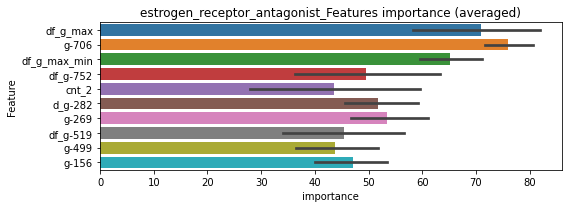

len(train_index) : 3890
len(valid_index) : 3891
================================= fold 1/2 estrogen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0229122	valid_1's binary_logloss: 0.046067
[200]	training's binary_logloss: 0.00401346	valid_1's binary_logloss: 0.0238489
[300]	training's binary_logloss: 0.00113866	valid_1's binary_logloss: 0.018768
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.000909406	valid_1's binary_logloss: 0.018213


len(train_index) : 3891
len(valid_index) : 3890
================================= fold 2/2 estrogen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0224015	valid_1's binary_logloss: 0.0442409
[200]	training's binary_logloss: 0.00423999	valid_1's binary_logloss: 0.0181747
[300]	training's binary_logloss: 0.00123488	valid_1's binary_logloss: 0.0116535
[400]	training's binary_logloss: 0.000582967	valid_1's binary_logloss: 0.00967419
Early stopping, best iteration is:
[472]	training's binary_logloss: 0.000407283	valid_1's binary_logloss: 0.00904398


estrogen_receptor_antagonist logloss: 0.013629068867504065
faah_inhibitor, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.035113	valid_1's binary_logloss: 0.0575904
[200]	training's binary_logloss: 0.00537198	valid_1's binary_logloss: 0.0157298
[300]	training's binary_logloss: 0.00148994	valid_1's binary_logloss: 0.00738471
[400]	training's binary_logloss: 0.000732456	valid_1's binary_logloss: 0.00521132
[500]	training's binary_logloss: 0.000502185	valid_1's binary_logloss: 0.00434093
Early stopping, best iteration is:
[577]	training's binary_logloss: 0.000446145	valid_1's binary_logloss: 0.00413735
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0355896	valid_1's binary_logloss: 0.0539161
[200]	training's binary_logloss: 0.00563409	valid_1's binary_logloss: 0.0145983
[300]	training's binary_logloss: 0.00158756	valid_1's binary_logloss: 0.00624978
[400]	training's binary_logloss: 0.000772586	valid_1's binary_logloss: 0.00391624
[500]	training's binary_logloss: 0.0

1 / 3 AUC score:1.000
y_Threshold: 0.0059242, Threshold: 0.0158518, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00151, Num_p_label: 80.0, conf_0:0.01427, conf_1:0.01744
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0158518
Num_p_label: 41.0, Expected: 6.0, Adj_threshold_2: 0.0258518
Num_p_label: 24.0, Expected: 6.0, Adj_threshold_3: 0.0358518
Num_p_label: 19.0, Expected: 6.0, Adj_threshold_4: 0.0458518
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_5: 0.0558518
Num_p_label: 10.0, Expected: 6.0, Adj_threshold_6: 0.0658518
threshold: 0.0658518, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0333165	valid_1's binary_logloss: 0.0554012
[200]	training's binary_logloss: 0.00486923	valid_1's binary_logloss: 0.0143413
[300]	training's binary_logloss: 0.00140535	valid_1's binary_logloss: 0.00661667
[400]	training's binary_logloss: 0.000692583	valid_1's binary_logloss: 0.00446281
[500]	training's binary_logloss: 0.000480766	valid_1's binary_logloss: 0.00365003
[600]	training's binary_logloss: 0.000424229	valid_1's binary_logloss: 0.0034415
Early stopping, best iteration is:
[596]	training's binary_logloss: 0.000424348	valid_1's binary_logloss: 0.00344127
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0344576	valid_1's binary_logloss: 0.0498498
[200]	training's binary_logloss: 0.00526932	valid_1's binary_logloss: 0.0116342
[300]	training's binary_logloss: 0.0014816	valid_1's binary_logloss: 0.00459205
[400]	training's binary_logloss: 0.00

2 / 3 AUC score:1.000
y_Threshold: 0.1950102, Threshold: 0.0658518, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0168257 Vs.target_rate: 0.00151, Num_p_label: 67.0, conf_0:0.05927, conf_1:0.07244
Num_p_label: 67.0, Expected: 6.0, Adj_threshold_1: 0.0658518
Num_p_label: 58.0, Expected: 6.0, Adj_threshold_2: 0.0758518
Num_p_label: 51.0, Expected: 6.0, Adj_threshold_3: 0.0858518
Num_p_label: 48.0, Expected: 6.0, Adj_threshold_4: 0.0958518
Num_p_label: 41.0, Expected: 6.0, Adj_threshold_5: 0.1058518
Num_p_label: 36.0, Expected: 6.0, Adj_threshold_6: 0.1158518
Num_p_label: 35.0, Expected: 6.0, Adj_threshold_7: 0.1258518
Num_p_label: 33.0, Expected: 6.0, Adj_threshold_8: 0.1358518
Num_p_label: 26.0, Expected: 6.0, Adj_threshold_9: 0.1458518
Num_p_label: 21.0, Expected: 6.0, Adj_threshold_10: 0.1558518
threshold: 0.1658518, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0333165	valid_1's binary_logloss: 0.0554012
[200]	training's binary_logloss: 0.00486923	valid_1's binary_logloss: 0.0143413
[300]	training's binary_logloss: 0.00140535	valid_1's binary_logloss: 0.00661667
[400]	training's binary_logloss: 0.000692583	valid_1's binary_logloss: 0.00446281
[500]	training's binary_logloss: 0.000480766	valid_1's binary_logloss: 0.00365003
[600]	training's binary_logloss: 0.000424229	valid_1's binary_logloss: 0.0034415
Early stopping, best iteration is:
[596]	training's binary_logloss: 0.000424348	valid_1's binary_logloss: 0.00344127
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0344576	valid_1's binary_logloss: 0.0498498
[200]	training's binary_logloss: 0.00526932	valid_1's binary_logloss: 0.0116342
[300]	training's binary_logloss: 0.0014816	valid_1's binary_logloss: 0.00459205
[400]	training's binary_logloss: 0.00

3 / 3 AUC score:1.000
y_Threshold: 0.1950102, Threshold: 0.1658518, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0042692 Vs.target_rate: 0.00151, Num_p_label: 17.0, conf_0:0.14927, conf_1:0.18244
threshold: 0.1658518, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 673.0/7789, y_label_rate: 0.0864039


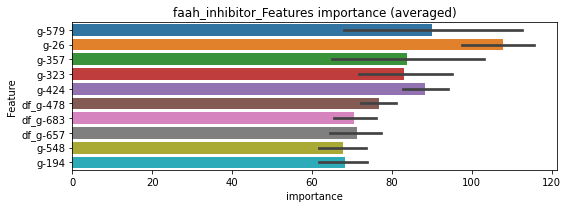

len(train_index) : 3894
len(valid_index) : 3895
================================= fold 1/2 faah_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0183752	valid_1's binary_logloss: 0.0366435
[200]	training's binary_logloss: 0.00279798	valid_1's binary_logloss: 0.0164245
[300]	training's binary_logloss: 0.000810501	valid_1's binary_logloss: 0.0131965
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.000626228	valid_1's binary_logloss: 0.0129813


len(train_index) : 3895
len(valid_index) : 3894
================================= fold 2/2 faah_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0207807	valid_1's binary_logloss: 0.0364863
[200]	training's binary_logloss: 0.003189	valid_1's binary_logloss: 0.0128941
[300]	training's binary_logloss: 0.00089463	valid_1's binary_logloss: 0.00870006
[400]	training's binary_logloss: 0.000428943	valid_1's binary_logloss: 0.0076958
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.000451109	valid_1's binary_logloss: 0.00764705


faah_inhibitor logloss: 0.010314525584753976
farnesyltransferase_inhibitor, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0182511	valid_1's binary_logloss: 0.02114
[200]	training's binary_logloss: 0.00177443	valid_1's binary_logloss: 0.00293515
[300]	training's binary_logloss: 0.000486947	valid_1's binary_logloss: 0.00115865
[400]	training's binary_logloss: 0.000282241	valid_1's binary_logloss: 0.000838592
[500]	training's binary_logloss: 0.000238021	valid_1's binary_logloss: 0.000766516
Early stopping, best iteration is:
[556]	training's binary_logloss: 0.000233335	valid_1's binary_logloss: 0.000754972
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0182372	valid_1's binary_logloss: 0.0210857
[200]	training's binary_logloss: 0.00177413	valid_1's binary_logloss: 0.00315453
[300]	training's binary_logloss: 0.000485457	valid_1's binary_logloss: 0.00147195
[400]	training's binary_logloss: 0.000279274	valid_1's binary_logloss: 0.00111412
[500]	training's binary_loglos

1 / 3 AUC score:1.000
y_Threshold: 0.0010984, Threshold: 0.0025582, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076, Num_p_label: 80.0, conf_0:0.00230, conf_1:0.00281
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0025582
Num_p_label: 24.0, Expected: 3.0, Adj_threshold_2: 0.0125582
Num_p_label: 17.0, Expected: 3.0, Adj_threshold_3: 0.0225582
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_4: 0.0325582
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_5: 0.0425582
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_6: 0.0525582
threshold: 0.0525582, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.018168	valid_1's binary_logloss: 0.0208903
[200]	training's binary_logloss: 0.00169136	valid_1's binary_logloss: 0.0026852
[300]	training's binary_logloss: 0.000450854	valid_1's binary_logloss: 0.000946289
[400]	training's binary_logloss: 0.000262497	valid_1's binary_logloss: 0.000626023
[500]	training's binary_logloss: 0.000228923	valid_1's binary_logloss: 0.000569538
Early stopping, best iteration is:
[559]	training's binary_logloss: 0.000226504	valid_1's binary_logloss: 0.000564882
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0184947	valid_1's binary_logloss: 0.0212905
[200]	training's binary_logloss: 0.00177447	valid_1's binary_logloss: 0.00283199
[300]	training's binary_logloss: 0.000494734	valid_1's binary_logloss: 0.00114976
[400]	training's binary_logloss: 0.000297731	valid_1's binary_logloss: 0.000838333
[500]	training's binary_logl

2 / 3 AUC score:1.000
y_Threshold: 0.1540389, Threshold: 0.0525582, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0090407 Vs.target_rate: 0.00076, Num_p_label: 36.0, conf_0:0.04730, conf_1:0.05781
Num_p_label: 36.0, Expected: 3.0, Adj_threshold_1: 0.0525582
Num_p_label: 30.0, Expected: 3.0, Adj_threshold_2: 0.0625582
Num_p_label: 29.0, Expected: 3.0, Adj_threshold_3: 0.0725582
Num_p_label: 27.0, Expected: 3.0, Adj_threshold_4: 0.0825582
Num_p_label: 25.0, Expected: 3.0, Adj_threshold_5: 0.0925582
Num_p_label: 24.0, Expected: 3.0, Adj_threshold_6: 0.1025582
Num_p_label: 22.0, Expected: 3.0, Adj_threshold_7: 0.1125582
Num_p_label: 21.0, Expected: 3.0, Adj_threshold_8: 0.1225582
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_9: 0.1325582
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_10: 0.1425582
threshold: 0.1525582, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.018168	valid_1's binary_logloss: 0.0208903
[200]	training's binary_logloss: 0.00169136	valid_1's binary_logloss: 0.0026852
[300]	training's binary_logloss: 0.000450854	valid_1's binary_logloss: 0.000946289
[400]	training's binary_logloss: 0.000262497	valid_1's binary_logloss: 0.000626023
[500]	training's binary_logloss: 0.000228923	valid_1's binary_logloss: 0.000569538
Early stopping, best iteration is:
[559]	training's binary_logloss: 0.000226504	valid_1's binary_logloss: 0.000564882
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0184947	valid_1's binary_logloss: 0.0212905
[200]	training's binary_logloss: 0.00177447	valid_1's binary_logloss: 0.00283199
[300]	training's binary_logloss: 0.000494734	valid_1's binary_logloss: 0.00114976
[400]	training's binary_logloss: 0.000297731	valid_1's binary_logloss: 0.000838333
[500]	training's binary_logl

3 / 3 AUC score:1.000
y_Threshold: 0.1540389, Threshold: 0.1525582, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0045203 Vs.target_rate: 0.00076, Num_p_label: 18.0, conf_0:0.13730, conf_1:0.16781
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_1: 0.1525582
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_2: 0.1625582
Num_p_label: 17.0, Expected: 3.0, Adj_threshold_3: 0.1725582
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_4: 0.1825582
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_5: 0.1925582
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_6: 0.2025582
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_7: 0.2125582
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_8: 0.2225582
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_9: 0.2325582
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_10: 0.2425582
threshold: 0.2525582, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 672.0/7793, y_label_rate: 0.0862312


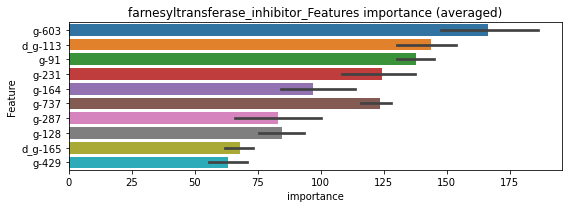

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 farnesyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0100136	valid_1's binary_logloss: 0.016264
[200]	training's binary_logloss: 0.000968063	valid_1's binary_logloss: 0.00674813
Early stopping, best iteration is:
[279]	training's binary_logloss: 0.000320662	valid_1's binary_logloss: 0.0060128


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 farnesyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0103653	valid_1's binary_logloss: 0.0134694
[200]	training's binary_logloss: 0.00106176	valid_1's binary_logloss: 0.00325159
[300]	training's binary_logloss: 0.000289132	valid_1's binary_logloss: 0.0022506
Early stopping, best iteration is:
[383]	training's binary_logloss: 0.000174645	valid_1's binary_logloss: 0.00211566


farnesyltransferase_inhibitor logloss: 0.004064478972469839
fatty_acid_receptor_agonist, len(trt): 25, len(othr): 3285, target_rate: 0.0010498 → Adj_target_rate: 0.0012955


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0288312	valid_1's binary_logloss: 0.0433085
[200]	training's binary_logloss: 0.00389629	valid_1's binary_logloss: 0.0104756
[300]	training's binary_logloss: 0.00110158	valid_1's binary_logloss: 0.00492676
[400]	training's binary_logloss: 0.000558691	valid_1's binary_logloss: 0.00353058
[500]	training's binary_logloss: 0.000404999	valid_1's binary_logloss: 0.00304525
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.000388928	valid_1's binary_logloss: 0.00302646
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0303122	valid_1's binary_logloss: 0.0397009
[200]	training's binary_logloss: 0.00411679	valid_1's binary_logloss: 0.0081224
[300]	training's binary_logloss: 0.00117152	valid_1's binary_logloss: 0.00321577
[400]	training's binary_logloss: 0.000584737	valid_1's binary_logloss: 0.00195714
[500]	training's binary_logloss: 0.

1 / 3 AUC score:1.000
y_Threshold: 0.0025760, Threshold: 0.0046906, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00105, Num_p_label: 80.0, conf_0:0.00422, conf_1:0.00516
Num_p_label: 80.0, Expected: 4.2, Adj_threshold_1: 0.0046906
Num_p_label: 12.0, Expected: 4.2, Adj_threshold_2: 0.0146906
Num_p_label: 3.0, Expected: 4.2, Adj_threshold_3: 0.0246906
threshold: 0.0246906, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0281561	valid_1's binary_logloss: 0.0418836
[200]	training's binary_logloss: 0.00373498	valid_1's binary_logloss: 0.010587
[300]	training's binary_logloss: 0.00105087	valid_1's binary_logloss: 0.00522112
[400]	training's binary_logloss: 0.000540681	valid_1's binary_logloss: 0.00385151
[500]	training's binary_logloss: 0.000399611	valid_1's binary_logloss: 0.00341924
Early stopping, best iteration is:
[521]	training's binary_logloss: 0.000389977	valid_1's binary_logloss: 0.00338266
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0292886	valid_1's binary_logloss: 0.0374712
[200]	training's binary_logloss: 0.00392636	valid_1's binary_logloss: 0.00707588
[300]	training's binary_logloss: 0.00112139	valid_1's binary_logloss: 0.00281785
[400]	training's binary_logloss: 0.000565802	valid_1's binary_logloss: 0.00168345
[500]	training's binary_logloss: 0.

2 / 3 AUC score:1.000
y_Threshold: 0.0430610, Threshold: 0.0246906, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0060271 Vs.target_rate: 0.00105, Num_p_label: 24.0, conf_0:0.02222, conf_1:0.02716
Num_p_label: 24.0, Expected: 4.2, Adj_threshold_1: 0.0246906
Num_p_label: 14.0, Expected: 4.2, Adj_threshold_2: 0.0346906
Num_p_label: 9.0, Expected: 4.2, Adj_threshold_3: 0.0446906
Num_p_label: 6.0, Expected: 4.2, Adj_threshold_4: 0.0546906
threshold: 0.0546906, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0281561	valid_1's binary_logloss: 0.0418836
[200]	training's binary_logloss: 0.00373498	valid_1's binary_logloss: 0.010587
[300]	training's binary_logloss: 0.00105087	valid_1's binary_logloss: 0.00522112
[400]	training's binary_logloss: 0.000540681	valid_1's binary_logloss: 0.00385151
[500]	training's binary_logloss: 0.000399611	valid_1's binary_logloss: 0.00341924
Early stopping, best iteration is:
[521]	training's binary_logloss: 0.000389977	valid_1's binary_logloss: 0.00338266
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0292886	valid_1's binary_logloss: 0.0374712
[200]	training's binary_logloss: 0.00392636	valid_1's binary_logloss: 0.00707588
[300]	training's binary_logloss: 0.00112139	valid_1's binary_logloss: 0.00281785
[400]	training's binary_logloss: 0.000565802	valid_1's binary_logloss: 0.00168345
[500]	training's binary_logloss: 0.

3 / 3 AUC score:1.000
y_Threshold: 0.0430610, Threshold: 0.0546906, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0015068 Vs.target_rate: 0.00105, Num_p_label: 6.0, conf_0:0.04922, conf_1:0.06016
threshold: 0.0546906, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 663.0/7792, y_label_rate: 0.0850873


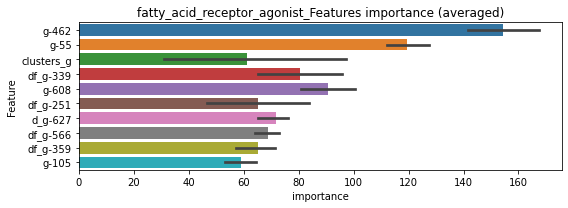

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 fatty_acid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155431	valid_1's binary_logloss: 0.0242935
[200]	training's binary_logloss: 0.00206776	valid_1's binary_logloss: 0.00811084
[300]	training's binary_logloss: 0.0005619	valid_1's binary_logloss: 0.00663465
Early stopping, best iteration is:
[319]	training's binary_logloss: 0.000474217	valid_1's binary_logloss: 0.00654865


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 fatty_acid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163483	valid_1's binary_logloss: 0.0224635
[200]	training's binary_logloss: 0.00221016	valid_1's binary_logloss: 0.00481809
[300]	training's binary_logloss: 0.000619774	valid_1's binary_logloss: 0.00217635
[400]	training's binary_logloss: 0.00031024	valid_1's binary_logloss: 0.00166944
[500]	training's binary_logloss: 0.000220265	valid_1's binary_logloss: 0.00154753
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000224241	valid_1's binary_logloss: 0.00154666


fatty_acid_receptor_agonist logloss: 0.004047651763114223
fgfr_inhibitor, len(trt): 50, len(othr): 3279, target_rate: 0.0020996 → Adj_target_rate: 0.0023352


neg labels: 3289 → selected neg labels: 3279


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0355204	valid_1's binary_logloss: 0.0563266
[200]	training's binary_logloss: 0.00571939	valid_1's binary_logloss: 0.0172635
[300]	training's binary_logloss: 0.00166732	valid_1's binary_logloss: 0.00902855
[400]	training's binary_logloss: 0.000826972	valid_1's binary_logloss: 0.00673996
Early stopping, best iteration is:
[439]	training's binary_logloss: 0.000685679	valid_1's binary_logloss: 0.00611668
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0355602	valid_1's binary_logloss: 0.0617158
[200]	training's binary_logloss: 0.00563277	valid_1's binary_logloss: 0.0207851
[300]	training's binary_logloss: 0.00164731	valid_1's binary_logloss: 0.012101
[400]	training's binary_logloss: 0.000832993	valid_1's binary_logloss: 0.00955275
[500]	training's binary_logloss: 0.000551206	valid_1's binary_logloss: 0.00818363
Early stopping, best iteration is:
[5

1 / 3 AUC score:1.000
y_Threshold: 0.0054339, Threshold: 0.0149125, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 655/3802
p_label_rate: 0.0200904 Vs.target_rate: 0.00210, Num_p_label: 80.0, conf_0:0.01342, conf_1:0.01640
Num_p_label: 80.0, Expected: 8.4, Adj_threshold_1: 0.0149125
Num_p_label: 53.0, Expected: 8.4, Adj_threshold_2: 0.0249125
Num_p_label: 41.0, Expected: 8.4, Adj_threshold_3: 0.0349125
Num_p_label: 31.0, Expected: 8.4, Adj_threshold_4: 0.0449125
Num_p_label: 28.0, Expected: 8.4, Adj_threshold_5: 0.0549125
Num_p_label: 25.0, Expected: 8.4, Adj_threshold_6: 0.0649125
Num_p_label: 23.0, Expected: 8.4, Adj_threshold_7: 0.0749125
Num_p_label: 22.0, Expected: 8.4, Adj_threshold_8: 0.0849125
Num_p_label: 20.0, Expected: 8.4, Adj_threshold_9: 0.0949125
Num_p_label: 19.0, Expected: 8.4, Adj_threshold_10: 0.1049125
threshold: 0.1149125, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 655.0/3802, y_label_rate: 0.1722777
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0334121	valid_1's binary_logloss: 0.0515242
[200]	training's binary_logloss: 0.00518427	valid_1's binary_logloss: 0.0144108
[300]	training's binary_logloss: 0.00151969	valid_1's binary_logloss: 0.0074167
[400]	training's binary_logloss: 0.000750951	valid_1's binary_logloss: 0.00537658
[500]	training's binary_logloss: 0.000514782	valid_1's binary_logloss: 0.00452291
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.0004822	valid_1's binary_logloss: 0.00442263
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0335017	valid_1's binary_logloss: 0.0567685
[200]	training's binary_logloss: 0.00511396	valid_1's binary_logloss: 0.017233
[300]	training's binary_logloss: 0.00146934	valid_1's binary_logloss: 0.00929074
[400]	training's binary_logloss: 0.000735747	valid_1's binary_logloss: 0.00710229
[500]	training's binary_logloss: 0.0005

2 / 3 AUC score:1.000
y_Threshold: 0.1071601, Threshold: 0.1149125, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3802
p_label_rate: 0.0130588 Vs.target_rate: 0.00210, Num_p_label: 52.0, conf_0:0.10342, conf_1:0.12640
Num_p_label: 52.0, Expected: 8.4, Adj_threshold_1: 0.1149125
Num_p_label: 48.0, Expected: 8.4, Adj_threshold_2: 0.1249125
Num_p_label: 44.0, Expected: 8.4, Adj_threshold_3: 0.1349125
Num_p_label: 42.0, Expected: 8.4, Adj_threshold_4: 0.1449125
Num_p_label: 37.0, Expected: 8.4, Adj_threshold_5: 0.1549125
Num_p_label: 37.0, Expected: 8.4, Adj_threshold_6: 0.1649125
Num_p_label: 33.0, Expected: 8.4, Adj_threshold_7: 0.1749125
Num_p_label: 32.0, Expected: 8.4, Adj_threshold_8: 0.1849125
Num_p_label: 31.0, Expected: 8.4, Adj_threshold_9: 0.1949125
Num_p_label: 29.0, Expected: 8.4, Adj_threshold_10: 0.2049125
threshold: 0.2149125, positive_p_label: 26.0/3982, p_label_rate: 0.0065294
positive_y_label: 655.0/3802, y_label_rate: 0.1722777
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0334121	valid_1's binary_logloss: 0.0515242
[200]	training's binary_logloss: 0.00518427	valid_1's binary_logloss: 0.0144108
[300]	training's binary_logloss: 0.00151969	valid_1's binary_logloss: 0.0074167
[400]	training's binary_logloss: 0.000750951	valid_1's binary_logloss: 0.00537658
[500]	training's binary_logloss: 0.000514782	valid_1's binary_logloss: 0.00452291
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.0004822	valid_1's binary_logloss: 0.00442263
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0335017	valid_1's binary_logloss: 0.0567685
[200]	training's binary_logloss: 0.00511396	valid_1's binary_logloss: 0.017233
[300]	training's binary_logloss: 0.00146934	valid_1's binary_logloss: 0.00929074
[400]	training's binary_logloss: 0.000735747	valid_1's binary_logloss: 0.00710229
[500]	training's binary_logloss: 0.0005

3 / 3 AUC score:1.000
y_Threshold: 0.1071601, Threshold: 0.2149125, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3802
p_label_rate: 0.0065294 Vs.target_rate: 0.00210, Num_p_label: 26.0, conf_0:0.19342, conf_1:0.23640
Num_p_label: 26.0, Expected: 8.4, Adj_threshold_1: 0.2149125
Num_p_label: 24.0, Expected: 8.4, Adj_threshold_2: 0.2249125
Num_p_label: 24.0, Expected: 8.4, Adj_threshold_3: 0.2349125
Num_p_label: 24.0, Expected: 8.4, Adj_threshold_4: 0.2449125
Num_p_label: 24.0, Expected: 8.4, Adj_threshold_5: 0.2549125
Num_p_label: 23.0, Expected: 8.4, Adj_threshold_6: 0.2649125
Num_p_label: 23.0, Expected: 8.4, Adj_threshold_7: 0.2749125
Num_p_label: 22.0, Expected: 8.4, Adj_threshold_8: 0.2849125
Num_p_label: 19.0, Expected: 8.4, Adj_threshold_9: 0.2949125
Num_p_label: 19.0, Expected: 8.4, Adj_threshold_10: 0.3049125
threshold: 0.3149125, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 674.0/7784, y_label_rate: 0.0865879


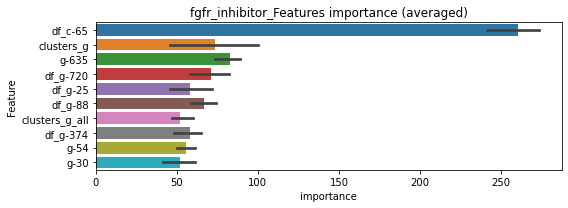

len(train_index) : 3892
len(valid_index) : 3892
================================= fold 1/2 fgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185256	valid_1's binary_logloss: 0.0398758
[200]	training's binary_logloss: 0.00304166	valid_1's binary_logloss: 0.0186539
[300]	training's binary_logloss: 0.000814893	valid_1's binary_logloss: 0.0130587
[400]	training's binary_logloss: 0.000397653	valid_1's binary_logloss: 0.0115741
Early stopping, best iteration is:
[477]	training's binary_logloss: 0.000288268	valid_1's binary_logloss: 0.0110316


len(train_index) : 3892
len(valid_index) : 3892
================================= fold 2/2 fgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.019267	valid_1's binary_logloss: 0.0353642
[200]	training's binary_logloss: 0.00288899	valid_1's binary_logloss: 0.0123459
[300]	training's binary_logloss: 0.000832938	valid_1's binary_logloss: 0.00748331
[400]	training's binary_logloss: 0.000421582	valid_1's binary_logloss: 0.00626709
[500]	training's binary_logloss: 0.000287446	valid_1's binary_logloss: 0.00586065
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.000264781	valid_1's binary_logloss: 0.00573603


fgfr_inhibitor logloss: 0.008383800940466157
flt3_inhibitor, len(trt): 279, len(othr): 3272, target_rate: 0.0117158 → Adj_target_rate: 0.0100684


neg labels: 3289 → selected neg labels: 3272


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.056347	valid_1's binary_logloss: 0.150113
[200]	training's binary_logloss: 0.0125213	valid_1's binary_logloss: 0.122147
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.0063844	valid_1's binary_logloss: 0.119868
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0548521	valid_1's binary_logloss: 0.157865
[200]	training's binary_logloss: 0.0127133	valid_1's binary_logloss: 0.131293
Early stopping, best iteration is:
[235]	training's binary_logloss: 0.00816122	valid_1's binary_logloss: 0.129493


1 / 3 AUC score:0.975
y_Threshold: 0.0622660, Threshold: 0.2137245, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 230 → Positive_corect_labels: 605/3696
p_label_rate: 0.0200904 Vs.target_rate: 0.01172, Num_p_label: 80.0, conf_0:0.19235, conf_1:0.23510
threshold: 0.2137245, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 605.0/3696, y_label_rate: 0.1636905
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0419844	valid_1's binary_logloss: 0.102619
[200]	training's binary_logloss: 0.00846348	valid_1's binary_logloss: 0.0701821
Early stopping, best iteration is:
[246]	training's binary_logloss: 0.004896	valid_1's binary_logloss: 0.0666599
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0433463	valid_1's binary_logloss: 0.103357
[200]	training's binary_logloss: 0.00898687	valid_1's binary_logloss: 0.0672648


2 / 3 AUC score:0.994
y_Threshold: 0.1296169, Threshold: 0.2137245, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[250]	training's binary_logloss: 0.00506164	valid_1's binary_logloss: 0.0632213


Remove_noisy_labels: 58 → Positive_corect_labels: 576.0/3638
p_label_rate: 0.0391763 Vs.target_rate: 0.01172, Num_p_label: 156.0, conf_0:0.19235, conf_1:0.23510
Num_p_label: 156.0, Expected: 46.7, Adj_threshold_1: 0.2137245
Num_p_label: 148.0, Expected: 46.7, Adj_threshold_2: 0.2237245
Num_p_label: 140.0, Expected: 46.7, Adj_threshold_3: 0.2337245
Num_p_label: 133.0, Expected: 46.7, Adj_threshold_4: 0.2437245
Num_p_label: 129.0, Expected: 46.7, Adj_threshold_5: 0.2537245
Num_p_label: 123.0, Expected: 46.7, Adj_threshold_6: 0.2637245
Num_p_label: 123.0, Expected: 46.7, Adj_threshold_7: 0.2737245
Num_p_label: 118.0, Expected: 46.7, Adj_threshold_8: 0.2837245
Num_p_label: 116.0, Expected: 46.7, Adj_threshold_9: 0.2937245
Num_p_label: 113.0, Expected: 46.7, Adj_threshold_10: 0.3037245
threshold: 0.3137245, positive_p_label: 112.0/3982, p_label_rate: 0.0281266
positive_y_label: 576.0/3638, y_label_rate: 0.1583288
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0389419	valid_1's binary_logloss: 0.0857808
[200]	training's binary_logloss: 0.00719096	valid_1's binary_logloss: 0.0485957
[300]	training's binary_logloss: 0.00240466	valid_1's binary_logloss: 0.0414545
Early stopping, best iteration is:
[333]	training's binary_logloss: 0.00188356	valid_1's binary_logloss: 0.0405588
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.03945	valid_1's binary_logloss: 0.0850133
[200]	training's binary_logloss: 0.00730419	valid_1's binary_logloss: 0.0474235
[300]	training's binary_logloss: 0.00219743	valid_1's binary_logloss: 0.0377086
Early stopping, best iteration is:
[379]	training's binary_logloss: 0.00120205	valid_1's binary_logloss: 0.0350282


3 / 3 AUC score:0.999
y_Threshold: 0.1584489, Threshold: 0.3137245, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 28 → Positive_corect_labels: 562.0/3610
p_label_rate: 0.0346560 Vs.target_rate: 0.01172, Num_p_label: 138.0, conf_0:0.28235, conf_1:0.34510
threshold: 0.3137245, positive_p_label: 138.0/3982, p_label_rate: 0.0346560
positive_y_label: 700.0/7592, y_label_rate: 0.0922023


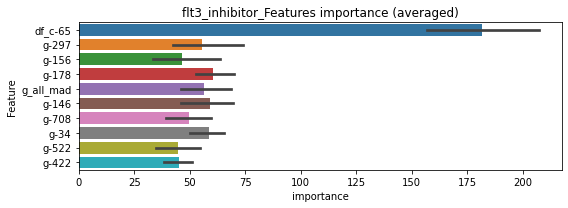

len(train_index) : 3796
len(valid_index) : 3796
================================= fold 1/2 flt3_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0261859	valid_1's binary_logloss: 0.0684109
[200]	training's binary_logloss: 0.0052279	valid_1's binary_logloss: 0.0466474
[300]	training's binary_logloss: 0.00160104	valid_1's binary_logloss: 0.0412912
Early stopping, best iteration is:
[332]	training's binary_logloss: 0.0012291	valid_1's binary_logloss: 0.0406181


len(train_index) : 3796
len(valid_index) : 3796
================================= fold 2/2 flt3_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0243595	valid_1's binary_logloss: 0.0670044
[200]	training's binary_logloss: 0.00456462	valid_1's binary_logloss: 0.0490166
Early stopping, best iteration is:
[244]	training's binary_logloss: 0.00257571	valid_1's binary_logloss: 0.0469936


flt3_inhibitor logloss: 0.04380583791324415
focal_adhesion_kinase_inhibitor, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0186156	valid_1's binary_logloss: 0.0222635
[200]	training's binary_logloss: 0.00179297	valid_1's binary_logloss: 0.00447101
[300]	training's binary_logloss: 0.000479443	valid_1's binary_logloss: 0.00273882
[400]	training's binary_logloss: 0.000278436	valid_1's binary_logloss: 0.00226753
Early stopping, best iteration is:
[431]	training's binary_logloss: 0.000257923	valid_1's binary_logloss: 0.00220829
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0186012	valid_1's binary_logloss: 0.0223719
[200]	training's binary_logloss: 0.0018081	valid_1's binary_logloss: 0.0034355
[300]	training's binary_logloss: 0.000503231	valid_1's binary_logloss: 0.00154926
[400]	training's binary_logloss: 0.000284086	valid_1's binary_logloss: 0.00116596
[500]	training's binary_logloss: 0.000242849	valid_1's binary_logloss: 0.00107821
Early stopping, best iteration is

1 / 3 AUC score:1.000
y_Threshold: 0.0012361, Threshold: 0.0035660, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076, Num_p_label: 80.0, conf_0:0.00321, conf_1:0.00392
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0035660
Num_p_label: 38.0, Expected: 3.0, Adj_threshold_2: 0.0135660
Num_p_label: 27.0, Expected: 3.0, Adj_threshold_3: 0.0235660
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_4: 0.0335660
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_5: 0.0435660
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_6: 0.0535660
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_7: 0.0635660
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_8: 0.0735660
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_9: 0.0835660
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_10: 0.0935660
threshold: 0.1035660, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
===========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0182624	valid_1's binary_logloss: 0.0203381
[200]	training's binary_logloss: 0.00170582	valid_1's binary_logloss: 0.00274655
[300]	training's binary_logloss: 0.000440555	valid_1's binary_logloss: 0.000934566
[400]	training's binary_logloss: 0.000252746	valid_1's binary_logloss: 0.000591287
[500]	training's binary_logloss: 0.000220486	valid_1's binary_logloss: 0.000533406
Early stopping, best iteration is:
[537]	training's binary_logloss: 0.000216774	valid_1's binary_logloss: 0.000527896
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0180667	valid_1's binary_logloss: 0.0212789
[200]	training's binary_logloss: 0.00168863	valid_1's binary_logloss: 0.00267075
[300]	training's binary_logloss: 0.000442158	valid_1's binary_logloss: 0.000875716
[400]	training's binary_logloss: 0.000253327	valid_1's binary_logloss: 0.000549823


2 / 3 AUC score:1.000
y_Threshold: 0.1608196, Threshold: 0.1035660, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[477]	training's binary_logloss: 0.000217494	valid_1's binary_logloss: 0.00048271


Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0075339 Vs.target_rate: 0.00076, Num_p_label: 30.0, conf_0:0.09321, conf_1:0.11392
Num_p_label: 30.0, Expected: 3.0, Adj_threshold_1: 0.1035660
Num_p_label: 29.0, Expected: 3.0, Adj_threshold_2: 0.1135660
Num_p_label: 29.0, Expected: 3.0, Adj_threshold_3: 0.1235660
Num_p_label: 29.0, Expected: 3.0, Adj_threshold_4: 0.1335660
Num_p_label: 28.0, Expected: 3.0, Adj_threshold_5: 0.1435660
Num_p_label: 27.0, Expected: 3.0, Adj_threshold_6: 0.1535660
Num_p_label: 27.0, Expected: 3.0, Adj_threshold_7: 0.1635660
Num_p_label: 25.0, Expected: 3.0, Adj_threshold_8: 0.1735660
Num_p_label: 25.0, Expected: 3.0, Adj_threshold_9: 0.1835660
Num_p_label: 23.0, Expected: 3.0, Adj_threshold_10: 0.1935660
threshold: 0.2035660, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0182624	valid_1's binary_logloss: 0.0203381
[200]	training's binary_logloss: 0.00170582	valid_1's binary_logloss: 0.00274655
[300]	training's binary_logloss: 0.000440555	valid_1's binary_logloss: 0.000934566
[400]	training's binary_logloss: 0.000252746	valid_1's binary_logloss: 0.000591287
[500]	training's binary_logloss: 0.000220486	valid_1's binary_logloss: 0.000533406
Early stopping, best iteration is:
[537]	training's binary_logloss: 0.000216774	valid_1's binary_logloss: 0.000527896
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0180667	valid_1's binary_logloss: 0.0212789
[200]	training's binary_logloss: 0.00168863	valid_1's binary_logloss: 0.00267075
[300]	training's binary_logloss: 0.000442158	valid_1's binary_logloss: 0.000875716
[400]	training's binary_logloss: 0.000253327	valid_1's binary_logloss: 0.000549823
Early stopping, best iter

3 / 3 AUC score:1.000
y_Threshold: 0.1608196, Threshold: 0.2035660, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0052737 Vs.target_rate: 0.00076, Num_p_label: 21.0, conf_0:0.18321, conf_1:0.22392
Num_p_label: 21.0, Expected: 3.0, Adj_threshold_1: 0.2035660
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_2: 0.2135660
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_3: 0.2235660
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_4: 0.2335660
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_5: 0.2435660
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_6: 0.2535660
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_7: 0.2635660
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_8: 0.2735660
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_9: 0.2835660
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_10: 0.2935660
threshold: 0.3035660, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 674.0/7793, y_label_rate: 0.0864879


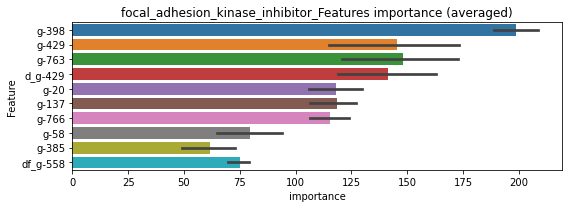

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 focal_adhesion_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0100247	valid_1's binary_logloss: 0.0178141
[200]	training's binary_logloss: 0.000978748	valid_1's binary_logloss: 0.00825218
Early stopping, best iteration is:
[215]	training's binary_logloss: 0.000750184	valid_1's binary_logloss: 0.0080629


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 focal_adhesion_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0104623	valid_1's binary_logloss: 0.0135443
[200]	training's binary_logloss: 0.00108581	valid_1's binary_logloss: 0.00400957
[300]	training's binary_logloss: 0.000291724	valid_1's binary_logloss: 0.00312649
Early stopping, best iteration is:
[348]	training's binary_logloss: 0.000209734	valid_1's binary_logloss: 0.00301232


focal_adhesion_kinase_inhibitor logloss: 0.0055379341795264445
free_radical_scavenger, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233164	valid_1's binary_logloss: 0.0304662
[200]	training's binary_logloss: 0.00274652	valid_1's binary_logloss: 0.00620061
[300]	training's binary_logloss: 0.000786513	valid_1's binary_logloss: 0.00279841
[400]	training's binary_logloss: 0.00041973	valid_1's binary_logloss: 0.00190608
[500]	training's binary_logloss: 0.00033576	valid_1's binary_logloss: 0.00173934
Early stopping, best iteration is:
[509]	training's binary_logloss: 0.000332594	valid_1's binary_logloss: 0.00172481
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0239849	valid_1's binary_logloss: 0.0340413
[200]	training's binary_logloss: 0.00286316	valid_1's binary_logloss: 0.00625057
[300]	training's binary_logloss: 0.000793278	valid_1's binary_logloss: 0.00275268
[400]	training's binary_logloss: 0.000421668	valid_1's binary_logloss: 0.00196394
Early stopping, best iteration is

1 / 3 AUC score:1.000
y_Threshold: 0.0016733, Threshold: 0.0027682, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076, Num_p_label: 80.0, conf_0:0.00249, conf_1:0.00304
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0027682
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_2: 0.0127682
Num_p_label: 3.0, Expected: 3.0, Adj_threshold_3: 0.0227682
threshold: 0.0227682, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230176	valid_1's binary_logloss: 0.0302684
[200]	training's binary_logloss: 0.00265168	valid_1's binary_logloss: 0.00664131
[300]	training's binary_logloss: 0.000761477	valid_1's binary_logloss: 0.00324572
[400]	training's binary_logloss: 0.000410156	valid_1's binary_logloss: 0.00239882
[500]	training's binary_logloss: 0.000333005	valid_1's binary_logloss: 0.00218486
Early stopping, best iteration is:
[507]	training's binary_logloss: 0.000330633	valid_1's binary_logloss: 0.00217152
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.024336	valid_1's binary_logloss: 0.035315
[200]	training's binary_logloss: 0.00283952	valid_1's binary_logloss: 0.00662707
[300]	training's binary_logloss: 0.000795764	valid_1's binary_logloss: 0.00285107
[400]	training's binary_logloss: 0.000425287	valid_1's binary_logloss: 0.00193194
[500]	training's binary_logloss: 

2 / 3 AUC score:1.000
y_Threshold: 0.0621786, Threshold: 0.0227682, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0022602 Vs.target_rate: 0.00076, Num_p_label: 9.0, conf_0:0.02049, conf_1:0.02504
threshold: 0.0227682, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230176	valid_1's binary_logloss: 0.0302684
[200]	training's binary_logloss: 0.00265168	valid_1's binary_logloss: 0.00664131
[300]	training's binary_logloss: 0.000761477	valid_1's binary_logloss: 0.00324572
[400]	training's binary_logloss: 0.000410156	valid_1's binary_logloss: 0.00239882
[500]	training's binary_logloss: 0.000333005	valid_1's binary_logloss: 0.00218486
Early stopping, best iteration is:
[507]	training's binary_logloss: 0.000330633	valid_1's binary_logloss: 0.00217152
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.024336	valid_1's binary_logloss: 0.035315
[200]	training's binary_logloss: 0.00283952	valid_1's binary_logloss: 0.00662707
[300]	training's binary_logloss: 0.000795764	valid_1's binary_logloss: 0.00285107
[400]	training's binary_logloss: 0.000425287	valid_1's binary_logloss: 0.00193194
[500]	training's binary_logloss: 

3 / 3 AUC score:1.000
y_Threshold: 0.0621786, Threshold: 0.0227682, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0022602 Vs.target_rate: 0.00076, Num_p_label: 9.0, conf_0:0.02049, conf_1:0.02504
threshold: 0.0227682, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 666.0/7793, y_label_rate: 0.0854613


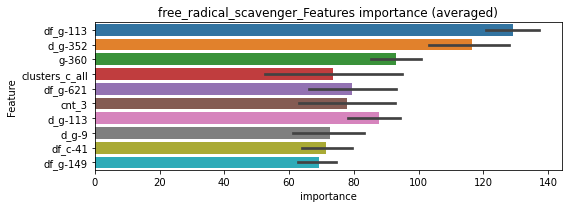

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 free_radical_scavenger=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0131863	valid_1's binary_logloss: 0.0224252
[200]	training's binary_logloss: 0.0015476	valid_1's binary_logloss: 0.0090532
Early stopping, best iteration is:
[258]	training's binary_logloss: 0.000662263	valid_1's binary_logloss: 0.0080706


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 free_radical_scavenger=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0133334	valid_1's binary_logloss: 0.0182393
[200]	training's binary_logloss: 0.00160335	valid_1's binary_logloss: 0.00542665
[300]	training's binary_logloss: 0.000449428	valid_1's binary_logloss: 0.00421695
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.000353114	valid_1's binary_logloss: 0.00417005


free_radical_scavenger logloss: 0.006120576045728971
fungal_squalene_epoxidase_inhibitor, len(trt): 23, len(othr): 3285, target_rate: 0.0009658 → Adj_target_rate: 0.0012069


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0276665	valid_1's binary_logloss: 0.0410167
[200]	training's binary_logloss: 0.00358576	valid_1's binary_logloss: 0.00879389
[300]	training's binary_logloss: 0.00101213	valid_1's binary_logloss: 0.0034157
[400]	training's binary_logloss: 0.00051705	valid_1's binary_logloss: 0.00211198
[500]	training's binary_logloss: 0.000381713	valid_1's binary_logloss: 0.00174785
Early stopping, best iteration is:
[561]	training's binary_logloss: 0.000362231	valid_1's binary_logloss: 0.00170844
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0277799	valid_1's binary_logloss: 0.035864
[200]	training's binary_logloss: 0.00357787	valid_1's binary_logloss: 0.00618528
[300]	training's binary_logloss: 0.0010177	valid_1's binary_logloss: 0.0021796
[400]	training's binary_logloss: 0.000520483	valid_1's binary_logloss: 0.00129046
[500]	training's binary_logloss: 0.000

1 / 3 AUC score:1.000
y_Threshold: 0.0018170, Threshold: 0.0032669, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00097, Num_p_label: 80.0, conf_0:0.00294, conf_1:0.00359
Num_p_label: 80.0, Expected: 3.8, Adj_threshold_1: 0.0032669
Num_p_label: 10.0, Expected: 3.8, Adj_threshold_2: 0.0132669
Num_p_label: 4.0, Expected: 3.8, Adj_threshold_3: 0.0232669
threshold: 0.0232669, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0265185	valid_1's binary_logloss: 0.0394992
[200]	training's binary_logloss: 0.00336315	valid_1's binary_logloss: 0.00797474
[300]	training's binary_logloss: 0.000968343	valid_1's binary_logloss: 0.00322759
[400]	training's binary_logloss: 0.000500554	valid_1's binary_logloss: 0.00198627
[500]	training's binary_logloss: 0.000375449	valid_1's binary_logloss: 0.00165283
[600]	training's binary_logloss: 0.000355327	valid_1's binary_logloss: 0.00160237
Early stopping, best iteration is:
[603]	training's binary_logloss: 0.000354979	valid_1's binary_logloss: 0.00160194
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0280004	valid_1's binary_logloss: 0.0342957
[200]	training's binary_logloss: 0.00354929	valid_1's binary_logloss: 0.00535798
[300]	training's binary_logloss: 0.000997482	valid_1's binary_logloss: 0.00177691
[400]	training's binary_logloss

2 / 3 AUC score:1.000
y_Threshold: 0.1488202, Threshold: 0.0232669, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0040181 Vs.target_rate: 0.00097, Num_p_label: 16.0, conf_0:0.02094, conf_1:0.02559
Num_p_label: 16.0, Expected: 3.8, Adj_threshold_1: 0.0232669
Num_p_label: 11.0, Expected: 3.8, Adj_threshold_2: 0.0332669
Num_p_label: 8.0, Expected: 3.8, Adj_threshold_3: 0.0432669
Num_p_label: 4.0, Expected: 3.8, Adj_threshold_4: 0.0532669
threshold: 0.0532669, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0265185	valid_1's binary_logloss: 0.0394992
[200]	training's binary_logloss: 0.00336315	valid_1's binary_logloss: 0.00797474
[300]	training's binary_logloss: 0.000968343	valid_1's binary_logloss: 0.00322759
[400]	training's binary_logloss: 0.000500554	valid_1's binary_logloss: 0.00198627
[500]	training's binary_logloss: 0.000375449	valid_1's binary_logloss: 0.00165283
[600]	training's binary_logloss: 0.000355327	valid_1's binary_logloss: 0.00160237
Early stopping, best iteration is:
[603]	training's binary_logloss: 0.000354979	valid_1's binary_logloss: 0.00160194
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0280004	valid_1's binary_logloss: 0.0342957
[200]	training's binary_logloss: 0.00354929	valid_1's binary_logloss: 0.00535798
[300]	training's binary_logloss: 0.000997482	valid_1's binary_logloss: 0.00177691
[400]	training's binary_logloss

3 / 3 AUC score:1.000
y_Threshold: 0.1488202, Threshold: 0.0532669, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0010045 Vs.target_rate: 0.00097, Num_p_label: 4.0, conf_0:0.04794, conf_1:0.05859
threshold: 0.0532669, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 661.0/7792, y_label_rate: 0.0848306


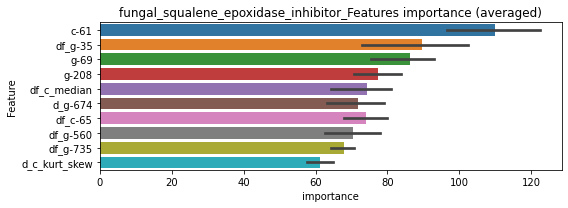

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 fungal_squalene_epoxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0144002	valid_1's binary_logloss: 0.021918
[200]	training's binary_logloss: 0.00176667	valid_1's binary_logloss: 0.00626506
[300]	training's binary_logloss: 0.00049518	valid_1's binary_logloss: 0.00428185
[400]	training's binary_logloss: 0.00025266	valid_1's binary_logloss: 0.00385397
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.000262679	valid_1's binary_logloss: 0.00384891


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 fungal_squalene_epoxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0152336	valid_1's binary_logloss: 0.0230818
[200]	training's binary_logloss: 0.0020114	valid_1's binary_logloss: 0.00704037
[300]	training's binary_logloss: 0.000543261	valid_1's binary_logloss: 0.00419422
[400]	training's binary_logloss: 0.000264176	valid_1's binary_logloss: 0.00322095
[500]	training's binary_logloss: 0.000191757	valid_1's binary_logloss: 0.00290917
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.000187441	valid_1's binary_logloss: 0.00289496


fungal_squalene_epoxidase_inhibitor logloss: 0.003371930978874297
gaba_receptor_agonist, len(trt): 106, len(othr): 3272, target_rate: 0.0044512 → Adj_target_rate: 0.0044229


neg labels: 3289 → selected neg labels: 3272


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.062392	valid_1's binary_logloss: 0.143482
[200]	training's binary_logloss: 0.0161225	valid_1's binary_logloss: 0.10016
[300]	training's binary_logloss: 0.00514285	valid_1's binary_logloss: 0.0871035
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.0029425	valid_1's binary_logloss: 0.0845374
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0704777	valid_1's binary_logloss: 0.139352
[200]	training's binary_logloss: 0.0190269	valid_1's binary_logloss: 0.0879594
[300]	training's binary_logloss: 0.00600232	valid_1's binary_logloss: 0.0738688
[400]	training's binary_logloss: 0.00261521	valid_1's binary_logloss: 0.0697479
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00279855	valid_1's binary_logloss: 0.0695191


1 / 3 AUC score:0.994
y_Threshold: 0.0167963, Threshold: 0.0211093, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 164 → Positive_corect_labels: 638/3762
p_label_rate: 0.0200904 Vs.target_rate: 0.00445, Num_p_label: 80.0, conf_0:0.01900, conf_1:0.02322
Num_p_label: 80.0, Expected: 17.7, Adj_threshold_1: 0.0211093
Num_p_label: 27.0, Expected: 17.7, Adj_threshold_2: 0.0311093
threshold: 0.0311093, positive_p_label: 27.0/3982, p_label_rate: 0.0067805
positive_y_label: 638.0/3762, y_label_rate: 0.1695906
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0598549	valid_1's binary_logloss: 0.127558
[200]	training's binary_logloss: 0.0148127	valid_1's binary_logloss: 0.0778654
[300]	training's binary_logloss: 0.00479075	valid_1's binary_logloss: 0.0647918
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00250088	valid_1's binary_logloss: 0.0623029
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0654131	valid_1's binary_logloss: 0.1226
[200]	training's binary_logloss: 0.0170637	valid_1's binary_logloss: 0.0689567
[300]	training's binary_logloss: 0.00542954	valid_1's binary_logloss: 0.0508649
[400]	training's binary_logloss: 0.00238151	valid_1's binary_logloss: 0.0443456
[500]	training's binary_logloss: 0.00140536	valid_1's binary_logloss: 0.0419331
Early stopping, best iteration is:
[507]	training's binary_logloss: 0.00136247	valid_1's binary_logloss: 0.0418466


2 / 3 AUC score:0.998
y_Threshold: 0.0324417, Threshold: 0.0311093, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 22 → Positive_corect_labels: 627.0/3740
p_label_rate: 0.0070316 Vs.target_rate: 0.00445, Num_p_label: 28.0, conf_0:0.02800, conf_1:0.03422
threshold: 0.0311093, positive_p_label: 28.0/3982, p_label_rate: 0.0070316
positive_y_label: 627.0/3740, y_label_rate: 0.1676471
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0602522	valid_1's binary_logloss: 0.131108
[200]	training's binary_logloss: 0.0145485	valid_1's binary_logloss: 0.0837977
[300]	training's binary_logloss: 0.00463934	valid_1's binary_logloss: 0.070124
[400]	training's binary_logloss: 0.00208933	valid_1's binary_logloss: 0.0646174
Early stopping, best iteration is:
[407]	training's binary_logloss: 0.00200089	valid_1's binary_logloss: 0.0644187
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0622947	valid_1's binary_logloss: 0.129103
[200]	training's binary_logloss: 0.0151157	valid_1's binary_logloss: 0.0754989
[300]	training's binary_logloss: 0.00477904	valid_1's binary_logloss: 0.0578021
[400]	training's binary_logloss: 0.00215673	valid_1's binary_logloss: 0.0519828
[500]	training's binary_logloss: 0.00128824	valid_1's binary_logloss: 0.0493512
Early stopping, best iteration is:
[553]	training'

3 / 3 AUC score:0.999
y_Threshold: 0.0307114, Threshold: 0.0311093, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 22 → Positive_corect_labels: 616.0/3718
p_label_rate: 0.0062783 Vs.target_rate: 0.00445, Num_p_label: 25.0, conf_0:0.02800, conf_1:0.03422
threshold: 0.0311093, positive_p_label: 25.0/3982, p_label_rate: 0.0062783
positive_y_label: 641.0/7700, y_label_rate: 0.0832468


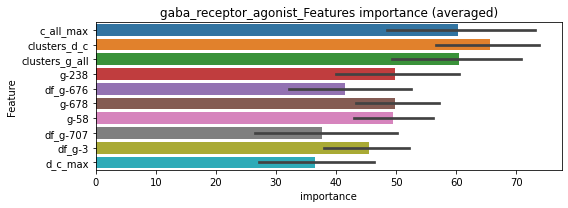

len(train_index) : 3850
len(valid_index) : 3850
================================= fold 1/2 gaba_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0338214	valid_1's binary_logloss: 0.0802055
[200]	training's binary_logloss: 0.00827515	valid_1's binary_logloss: 0.0548785
[300]	training's binary_logloss: 0.00251455	valid_1's binary_logloss: 0.0496325
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.00226692	valid_1's binary_logloss: 0.0491664


len(train_index) : 3850
len(valid_index) : 3850
================================= fold 2/2 gaba_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0367136	valid_1's binary_logloss: 0.0821043
[200]	training's binary_logloss: 0.00894151	valid_1's binary_logloss: 0.0571652
[300]	training's binary_logloss: 0.00269609	valid_1's binary_logloss: 0.0525766
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00192473	valid_1's binary_logloss: 0.0520189


gaba_receptor_agonist logloss: 0.0505926631305902
gaba_receptor_antagonist, len(trt): 165, len(othr): 3263, target_rate: 0.0069287 → Adj_target_rate: 0.0064426


neg labels: 3289 → selected neg labels: 3263


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0835432	valid_1's binary_logloss: 0.202008
[200]	training's binary_logloss: 0.0264031	valid_1's binary_logloss: 0.164505
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.0150067	valid_1's binary_logloss: 0.157
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0926261	valid_1's binary_logloss: 0.187804
[200]	training's binary_logloss: 0.03101	valid_1's binary_logloss: 0.140177
[300]	training's binary_logloss: 0.0112695	valid_1's binary_logloss: 0.12356
Early stopping, best iteration is:
[366]	training's binary_logloss: 0.00656014	valid_1's binary_logloss: 0.119489


1 / 3 AUC score:0.973
y_Threshold: 0.0463382, Threshold: 0.0548745, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 233 → Positive_corect_labels: 601/3682
p_label_rate: 0.0200904 Vs.target_rate: 0.00693, Num_p_label: 80.0, conf_0:0.04939, conf_1:0.06036
threshold: 0.0548745, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 601.0/3682, y_label_rate: 0.1632265
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0725194	valid_1's binary_logloss: 0.172771
[200]	training's binary_logloss: 0.0210733	valid_1's binary_logloss: 0.137703
Early stopping, best iteration is:
[232]	training's binary_logloss: 0.0146842	valid_1's binary_logloss: 0.13271
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0785356	valid_1's binary_logloss: 0.170943
[200]	training's binary_logloss: 0.0233337	valid_1's binary_logloss: 0.122015
[300]	training's binary_logloss: 0.00799266	valid_1's binary_logloss: 0.107558
Early stopping, best iteration is:
[344]	training's binary_logloss: 0.00527008	valid_1's binary_logloss: 0.104995


2 / 3 AUC score:0.986
y_Threshold: 0.0610381, Threshold: 0.0548745, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 90 → Positive_corect_labels: 556.0/3592
p_label_rate: 0.0233551 Vs.target_rate: 0.00693, Num_p_label: 93.0, conf_0:0.04939, conf_1:0.06036
Num_p_label: 93.0, Expected: 27.6, Adj_threshold_1: 0.0548745
Num_p_label: 58.0, Expected: 27.6, Adj_threshold_2: 0.0648745
Num_p_label: 39.0, Expected: 27.6, Adj_threshold_3: 0.0748745
threshold: 0.0748745, positive_p_label: 39.0/3982, p_label_rate: 0.0097941
positive_y_label: 556.0/3592, y_label_rate: 0.1547884
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0632878	valid_1's binary_logloss: 0.153689
[200]	training's binary_logloss: 0.0165877	valid_1's binary_logloss: 0.112091
[300]	training's binary_logloss: 0.00543184	valid_1's binary_logloss: 0.0992771
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.00575952	valid_1's binary_logloss: 0.0991991
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0662663	valid_1's binary_logloss: 0.149124
[200]	training's binary_logloss: 0.0176777	valid_1's binary_logloss: 0.114881
Early stopping, best iteration is:
[287]	training's binary_logloss: 0.00662079	valid_1's binary_logloss: 0.10566


3 / 3 AUC score:0.992
y_Threshold: 0.0523460, Threshold: 0.0748745, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 62 → Positive_corect_labels: 525.0/3530
p_label_rate: 0.0035158 Vs.target_rate: 0.00693, Num_p_label: 14.0, conf_0:0.06739, conf_1:0.08236
threshold: 0.0748745, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 539.0/7512, y_label_rate: 0.0717519


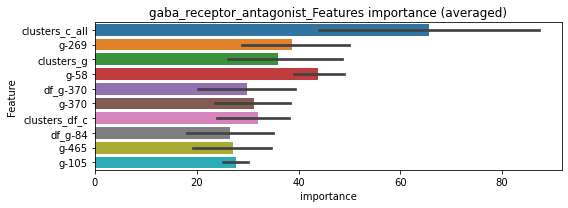

len(train_index) : 3756
len(valid_index) : 3756
================================= fold 1/2 gaba_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0325525	valid_1's binary_logloss: 0.0910127
[200]	training's binary_logloss: 0.00799601	valid_1's binary_logloss: 0.0714753
Early stopping, best iteration is:
[260]	training's binary_logloss: 0.00391756	valid_1's binary_logloss: 0.0689276


len(train_index) : 3756
len(valid_index) : 3756
================================= fold 2/2 gaba_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0315907	valid_1's binary_logloss: 0.089506
[200]	training's binary_logloss: 0.00775574	valid_1's binary_logloss: 0.0714438
Early stopping, best iteration is:
[229]	training's binary_logloss: 0.00543593	valid_1's binary_logloss: 0.070677


gaba_receptor_antagonist logloss: 0.06980226074339929
gamma_secretase_inhibitor, len(trt): 56, len(othr): 3279, target_rate: 0.0023516 → Adj_target_rate: 0.0025713


neg labels: 3289 → selected neg labels: 3279


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0362378	valid_1's binary_logloss: 0.065721
[200]	training's binary_logloss: 0.00562356	valid_1's binary_logloss: 0.0237172
[300]	training's binary_logloss: 0.00166824	valid_1's binary_logloss: 0.0156391
[400]	training's binary_logloss: 0.000821807	valid_1's binary_logloss: 0.0130325
[500]	training's binary_logloss: 0.000545585	valid_1's binary_logloss: 0.0121059
[600]	training's binary_logloss: 0.000443267	valid_1's binary_logloss: 0.0116454
Early stopping, best iteration is:
[591]	training's binary_logloss: 0.000448013	valid_1's binary_logloss: 0.0116376
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0352132	valid_1's binary_logloss: 0.0660863
[200]	training's binary_logloss: 0.00538799	valid_1's binary_logloss: 0.0269776
[300]	training's binary_logloss: 0.00159249	valid_1's binary_logloss: 0.0198084
[400]	training's binary_logloss: 0.0007797

1 / 3 AUC score:1.000
y_Threshold: 0.0041894, Threshold: 0.0068318, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 654/3800
p_label_rate: 0.0200904 Vs.target_rate: 0.00235, Num_p_label: 80.0, conf_0:0.00615, conf_1:0.00752
Num_p_label: 80.0, Expected: 9.4, Adj_threshold_1: 0.0068318
Num_p_label: 26.0, Expected: 9.4, Adj_threshold_2: 0.0168318
Num_p_label: 15.0, Expected: 9.4, Adj_threshold_3: 0.0268318
threshold: 0.0268318, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 654.0/3800, y_label_rate: 0.1721053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0353907	valid_1's binary_logloss: 0.0632385
[200]	training's binary_logloss: 0.00529084	valid_1's binary_logloss: 0.0245073
[300]	training's binary_logloss: 0.00155049	valid_1's binary_logloss: 0.0183428
Early stopping, best iteration is:
[358]	training's binary_logloss: 0.000986694	valid_1's binary_logloss: 0.0171921
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0344089	valid_1's binary_logloss: 0.0703541
[200]	training's binary_logloss: 0.00517703	valid_1's binary_logloss: 0.0327214
[300]	training's binary_logloss: 0.0014997	valid_1's binary_logloss: 0.0258473
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.000934105	valid_1's binary_logloss: 0.0246297


2 / 3 AUC score:0.999
y_Threshold: 0.0209088, Threshold: 0.0268318, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 14 → Positive_corect_labels: 647.0/3786
p_label_rate: 0.0123054 Vs.target_rate: 0.00235, Num_p_label: 49.0, conf_0:0.02415, conf_1:0.02952
Num_p_label: 49.0, Expected: 9.4, Adj_threshold_1: 0.0268318
Num_p_label: 35.0, Expected: 9.4, Adj_threshold_2: 0.0368318
Num_p_label: 28.0, Expected: 9.4, Adj_threshold_3: 0.0468318
Num_p_label: 24.0, Expected: 9.4, Adj_threshold_4: 0.0568318
Num_p_label: 21.0, Expected: 9.4, Adj_threshold_5: 0.0668318
Num_p_label: 18.0, Expected: 9.4, Adj_threshold_6: 0.0768318
threshold: 0.0768318, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 647.0/3786, y_label_rate: 0.1708928
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0336725	valid_1's binary_logloss: 0.0592742
[200]	training's binary_logloss: 0.00503084	valid_1's binary_logloss: 0.0176608
[300]	training's binary_logloss: 0.0014674	valid_1's binary_logloss: 0.0100754
[400]	training's binary_logloss: 0.000726138	valid_1's binary_logloss: 0.00802345
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.000614807	valid_1's binary_logloss: 0.00763937
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0339558	valid_1's binary_logloss: 0.0601639
[200]	training's binary_logloss: 0.00513321	valid_1's binary_logloss: 0.0198695
[300]	training's binary_logloss: 0.00148944	valid_1's binary_logloss: 0.0117196
[400]	training's binary_logloss: 0.000729407	valid_1's binary_logloss: 0.00932724
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.000604763	valid_1's binary_logloss: 0.00884425


3 / 3 AUC score:1.000
y_Threshold: 0.0429355, Threshold: 0.0768318, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 647.0/3786
p_label_rate: 0.0040181 Vs.target_rate: 0.00235, Num_p_label: 16.0, conf_0:0.06915, conf_1:0.08452
threshold: 0.0768318, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 663.0/7768, y_label_rate: 0.0853502


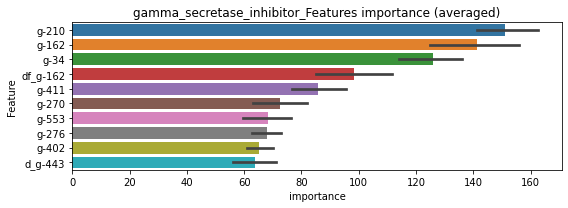

len(train_index) : 3884
len(valid_index) : 3884
================================= fold 1/2 gamma_secretase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0178814	valid_1's binary_logloss: 0.0436624
[200]	training's binary_logloss: 0.00278124	valid_1's binary_logloss: 0.0254181
[300]	training's binary_logloss: 0.000738916	valid_1's binary_logloss: 0.0226177
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.000561987	valid_1's binary_logloss: 0.0222863


len(train_index) : 3884
len(valid_index) : 3884
================================= fold 2/2 gamma_secretase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0180836	valid_1's binary_logloss: 0.0359568
[200]	training's binary_logloss: 0.00276871	valid_1's binary_logloss: 0.0153165
[300]	training's binary_logloss: 0.000787524	valid_1's binary_logloss: 0.0108829
[400]	training's binary_logloss: 0.000381497	valid_1's binary_logloss: 0.00973397
[500]	training's binary_logloss: 0.000255838	valid_1's binary_logloss: 0.00932875
Early stopping, best iteration is:
[504]	training's binary_logloss: 0.000252963	valid_1's binary_logloss: 0.00931238


gamma_secretase_inhibitor logloss: 0.015799341997430095
glucocorticoid_receptor_agonist, len(trt): 266, len(othr): 3253, target_rate: 0.0111699 → Adj_target_rate: 0.0096682


neg labels: 3289 → selected neg labels: 3253


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0303708	valid_1's binary_logloss: 0.0686393
[200]	training's binary_logloss: 0.00455668	valid_1's binary_logloss: 0.0522385
Early stopping, best iteration is:
[190]	training's binary_logloss: 0.00532665	valid_1's binary_logloss: 0.0520858
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0322979	valid_1's binary_logloss: 0.060295
[200]	training's binary_logloss: 0.00527933	valid_1's binary_logloss: 0.0384736


1 / 3 AUC score:0.994
y_Threshold: 0.0119412, Threshold: 0.0317680, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[235]	training's binary_logloss: 0.00318711	valid_1's binary_logloss: 0.036897


Remove_noisy_labels: 153 → Positive_corect_labels: 639/3750
p_label_rate: 0.0200904 Vs.target_rate: 0.01117, Num_p_label: 80.0, conf_0:0.02859, conf_1:0.03494
threshold: 0.0317680, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 639.0/3750, y_label_rate: 0.1704000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0265191	valid_1's binary_logloss: 0.0425436
[200]	training's binary_logloss: 0.00338755	valid_1's binary_logloss: 0.0162195
[300]	training's binary_logloss: 0.000950937	valid_1's binary_logloss: 0.0122966
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.000584583	valid_1's binary_logloss: 0.0116291
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0248162	valid_1's binary_logloss: 0.0489469
[200]	training's binary_logloss: 0.00308636	valid_1's binary_logloss: 0.0321622


2 / 3 AUC score:0.997
y_Threshold: 0.0259837, Threshold: 0.0317680, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 18 → Positive_corect_labels: 630.0/3732
p_label_rate: 0.0253641 Vs.target_rate: 0.01117, Num_p_label: 101.0, conf_0:0.02859, conf_1:0.03494
threshold: 0.0317680, positive_p_label: 101.0/3982, p_label_rate: 0.0253641


Early stopping, best iteration is:
[211]	training's binary_logloss: 0.0025652	valid_1's binary_logloss: 0.0320804


positive_y_label: 630.0/3732, y_label_rate: 0.1688103
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0249286	valid_1's binary_logloss: 0.0348111
[200]	training's binary_logloss: 0.00307899	valid_1's binary_logloss: 0.0120354
[300]	training's binary_logloss: 0.000836231	valid_1's binary_logloss: 0.00978571
Early stopping, best iteration is:
[358]	training's binary_logloss: 0.000527606	valid_1's binary_logloss: 0.00946535
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0221385	valid_1's binary_logloss: 0.0523753


3 / 3 AUC score:0.998
y_Threshold: 0.0368794, Threshold: 0.0317680, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 18 → Positive_corect_labels: 621.0/3714
p_label_rate: 0.0293822 Vs.target_rate: 0.01117, Num_p_label: 117.0, conf_0:0.02859, conf_1:0.03494
threshold: 0.0317680, positive_p_label: 117.0/3982, p_label_rate: 0.0293822


Early stopping, best iteration is:
[180]	training's binary_logloss: 0.00359454	valid_1's binary_logloss: 0.0369698


positive_y_label: 738.0/7696, y_label_rate: 0.0958940


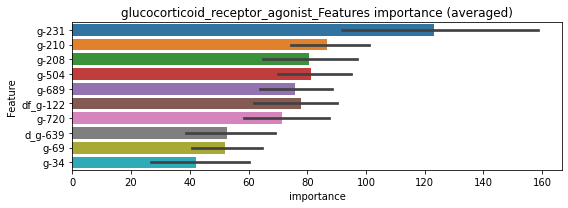

len(train_index) : 3848
len(valid_index) : 3848
================================= fold 1/2 glucocorticoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158306	valid_1's binary_logloss: 0.0357397
[200]	training's binary_logloss: 0.00221364	valid_1's binary_logloss: 0.0259227
Early stopping, best iteration is:
[198]	training's binary_logloss: 0.00228557	valid_1's binary_logloss: 0.0258969


len(train_index) : 3848
len(valid_index) : 3848
================================= fold 2/2 glucocorticoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158336	valid_1's binary_logloss: 0.0417252
[200]	training's binary_logloss: 0.00218261	valid_1's binary_logloss: 0.032123
Early stopping, best iteration is:
[191]	training's binary_logloss: 0.00252354	valid_1's binary_logloss: 0.0320628


glucocorticoid_receptor_agonist logloss: 0.02897985235732924
glutamate_inhibitor, len(trt): 13, len(othr): 3287, target_rate: 0.0005459 → Adj_target_rate: 0.0007431


neg labels: 3289 → selected neg labels: 3287


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0188719	valid_1's binary_logloss: 0.0242968
[200]	training's binary_logloss: 0.00196617	valid_1's binary_logloss: 0.00439511
[300]	training's binary_logloss: 0.000568002	valid_1's binary_logloss: 0.00236385
[400]	training's binary_logloss: 0.000321543	valid_1's binary_logloss: 0.00189231
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.000286902	valid_1's binary_logloss: 0.00182003
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192099	valid_1's binary_logloss: 0.0230455
[200]	training's binary_logloss: 0.00201255	valid_1's binary_logloss: 0.00338915
[300]	training's binary_logloss: 0.000583215	valid_1's binary_logloss: 0.00130616
[400]	training's binary_logloss: 0.000325679	valid_1's binary_logloss: 0.000854401
[500]	training's binary_logloss: 0.000279583	valid_1's binary_logloss: 0.000769147
Early stopping, best iteratio

1 / 3 AUC score:1.000
y_Threshold: 0.0010216, Threshold: 0.0016752, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00055, Num_p_label: 80.0, conf_0:0.00151, conf_1:0.00184
Num_p_label: 80.0, Expected: 2.2, Adj_threshold_1: 0.0016752
Num_p_label: 9.0, Expected: 2.2, Adj_threshold_2: 0.0116752
Num_p_label: 1.0, Expected: 2.2, Adj_threshold_3: 0.0216752
threshold: 0.0216752, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192952	valid_1's binary_logloss: 0.0237372
[200]	training's binary_logloss: 0.00199849	valid_1's binary_logloss: 0.00405598
[300]	training's binary_logloss: 0.000564745	valid_1's binary_logloss: 0.00211614
[400]	training's binary_logloss: 0.000316886	valid_1's binary_logloss: 0.0017606
Early stopping, best iteration is:
[442]	training's binary_logloss: 0.000285347	valid_1's binary_logloss: 0.00170544
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193293	valid_1's binary_logloss: 0.0228925
[200]	training's binary_logloss: 0.00199207	valid_1's binary_logloss: 0.00373208
[300]	training's binary_logloss: 0.000563666	valid_1's binary_logloss: 0.00164216
[400]	training's binary_logloss: 0.000319835	valid_1's binary_logloss: 0.00118768
[500]	training's binary_logloss: 0.000273274	valid_1's binary_logloss: 0.00110175
Early stopping, best iteration i

2 / 3 AUC score:1.000
y_Threshold: 0.0239287, Threshold: 0.0216752, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0022602 Vs.target_rate: 0.00055, Num_p_label: 9.0, conf_0:0.01951, conf_1:0.02384
Num_p_label: 9.0, Expected: 2.2, Adj_threshold_1: 0.0216752
Num_p_label: 7.0, Expected: 2.2, Adj_threshold_2: 0.0316752
Num_p_label: 4.0, Expected: 2.2, Adj_threshold_3: 0.0416752
threshold: 0.0416752, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192952	valid_1's binary_logloss: 0.0237372
[200]	training's binary_logloss: 0.00199849	valid_1's binary_logloss: 0.00405598
[300]	training's binary_logloss: 0.000564745	valid_1's binary_logloss: 0.00211614
[400]	training's binary_logloss: 0.000316886	valid_1's binary_logloss: 0.0017606
Early stopping, best iteration is:
[442]	training's binary_logloss: 0.000285347	valid_1's binary_logloss: 0.00170544
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193293	valid_1's binary_logloss: 0.0228925
[200]	training's binary_logloss: 0.00199207	valid_1's binary_logloss: 0.00373208
[300]	training's binary_logloss: 0.000563666	valid_1's binary_logloss: 0.00164216
[400]	training's binary_logloss: 0.000319835	valid_1's binary_logloss: 0.00118768
[500]	training's binary_logloss: 0.000273274	valid_1's binary_logloss: 0.00110175
Early stopping, best iteration i

3 / 3 AUC score:1.000
y_Threshold: 0.0239287, Threshold: 0.0416752, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0010045 Vs.target_rate: 0.00055, Num_p_label: 4.0, conf_0:0.03751, conf_1:0.04584
threshold: 0.0416752, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 661.0/7794, y_label_rate: 0.0848088


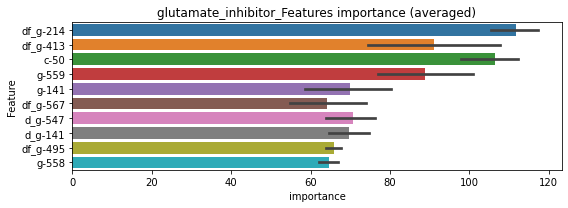

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 glutamate_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0102822	valid_1's binary_logloss: 0.0174108
[200]	training's binary_logloss: 0.00104353	valid_1's binary_logloss: 0.00806063
[300]	training's binary_logloss: 0.000292217	valid_1's binary_logloss: 0.0072221
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.000263408	valid_1's binary_logloss: 0.00718346


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 glutamate_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0105132	valid_1's binary_logloss: 0.0133051
[200]	training's binary_logloss: 0.0010747	valid_1's binary_logloss: 0.00280755
[300]	training's binary_logloss: 0.000299816	valid_1's binary_logloss: 0.00194896
Early stopping, best iteration is:
[368]	training's binary_logloss: 0.000189283	valid_1's binary_logloss: 0.00185827


glutamate_inhibitor logloss: 0.004520867194772183
glutamate_receptor_agonist, len(trt): 74, len(othr): 3277, target_rate: 0.0031074 → Adj_target_rate: 0.0032587


neg labels: 3289 → selected neg labels: 3277


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0609669	valid_1's binary_logloss: 0.114285
[200]	training's binary_logloss: 0.0141728	valid_1's binary_logloss: 0.0583212
[300]	training's binary_logloss: 0.00412964	valid_1's binary_logloss: 0.0410041
[400]	training's binary_logloss: 0.00191311	valid_1's binary_logloss: 0.0345048
[500]	training's binary_logloss: 0.00121643	valid_1's binary_logloss: 0.0323128
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.000903582	valid_1's binary_logloss: 0.0311216
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0628751	valid_1's binary_logloss: 0.11179
[200]	training's binary_logloss: 0.0141781	valid_1's binary_logloss: 0.0505311
[300]	training's binary_logloss: 0.00413646	valid_1's binary_logloss: 0.0341564
[400]	training's binary_logloss: 0.00180039	valid_1's binary_logloss: 0.0283811
[500]	training's binary_logloss: 0.00106849	valid

1 / 3 AUC score:1.000
y_Threshold: 0.0079842, Threshold: 0.0119909, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 654/3798
p_label_rate: 0.0200904 Vs.target_rate: 0.00311, Num_p_label: 80.0, conf_0:0.01079, conf_1:0.01319
Num_p_label: 80.0, Expected: 12.4, Adj_threshold_1: 0.0119909
Num_p_label: 24.0, Expected: 12.4, Adj_threshold_2: 0.0219909
threshold: 0.0219909, positive_p_label: 24.0/3982, p_label_rate: 0.0060271
positive_y_label: 654.0/3798, y_label_rate: 0.1721959
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0604451	valid_1's binary_logloss: 0.120084
[200]	training's binary_logloss: 0.0134453	valid_1's binary_logloss: 0.0649515
[300]	training's binary_logloss: 0.00383483	valid_1's binary_logloss: 0.0487528
[400]	training's binary_logloss: 0.00167422	valid_1's binary_logloss: 0.0429899
Early stopping, best iteration is:
[451]	training's binary_logloss: 0.00126095	valid_1's binary_logloss: 0.0413866
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0641918	valid_1's binary_logloss: 0.110362
[200]	training's binary_logloss: 0.0144733	valid_1's binary_logloss: 0.0520529
[300]	training's binary_logloss: 0.00418984	valid_1's binary_logloss: 0.0342677
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.0021817	valid_1's binary_logloss: 0.0297928


2 / 3 AUC score:0.999
y_Threshold: 0.0421279, Threshold: 0.0219909, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 14 → Positive_corect_labels: 647.0/3784
p_label_rate: 0.0296334 Vs.target_rate: 0.00311, Num_p_label: 118.0, conf_0:0.01979, conf_1:0.02419
Num_p_label: 118.0, Expected: 12.4, Adj_threshold_1: 0.0219909
Num_p_label: 53.0, Expected: 12.4, Adj_threshold_2: 0.0319909
Num_p_label: 23.0, Expected: 12.4, Adj_threshold_3: 0.0419909
threshold: 0.0419909, positive_p_label: 23.0/3982, p_label_rate: 0.0057760
positive_y_label: 647.0/3784, y_label_rate: 0.1709831
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0616317	valid_1's binary_logloss: 0.108643
[200]	training's binary_logloss: 0.013164	valid_1's binary_logloss: 0.0473266
[300]	training's binary_logloss: 0.00373855	valid_1's binary_logloss: 0.029263
[400]	training's binary_logloss: 0.00168516	valid_1's binary_logloss: 0.0238385
[500]	training's binary_logloss: 0.0010081	valid_1's binary_logloss: 0.0214601
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.000770149	valid_1's binary_logloss: 0.0202787
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0621452	valid_1's binary_logloss: 0.111585
[200]	training's binary_logloss: 0.0140193	valid_1's binary_logloss: 0.0583942
[300]	training's binary_logloss: 0.00414214	valid_1's binary_logloss: 0.0442202
[400]	training's binary_logloss: 0.00179769	valid_1's binary_logloss: 0.0387864
Early stopping, best iteration is:
[393]	training's

3 / 3 AUC score:1.000
y_Threshold: 0.0326212, Threshold: 0.0419909, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 12 → Positive_corect_labels: 641.0/3772
p_label_rate: 0.0055249 Vs.target_rate: 0.00311, Num_p_label: 22.0, conf_0:0.03779, conf_1:0.04619
threshold: 0.0419909, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 663.0/7754, y_label_rate: 0.0855043


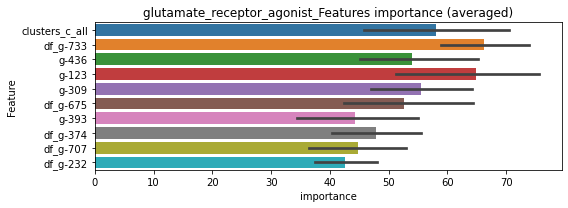

len(train_index) : 3877
len(valid_index) : 3877
================================= fold 1/2 glutamate_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0345683	valid_1's binary_logloss: 0.0689462
[200]	training's binary_logloss: 0.00773415	valid_1's binary_logloss: 0.0373374
[300]	training's binary_logloss: 0.00256418	valid_1's binary_logloss: 0.0295721
Early stopping, best iteration is:
[388]	training's binary_logloss: 0.00157025	valid_1's binary_logloss: 0.0276013


len(train_index) : 3877
len(valid_index) : 3877
================================= fold 2/2 glutamate_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0364789	valid_1's binary_logloss: 0.0703677
[200]	training's binary_logloss: 0.00769838	valid_1's binary_logloss: 0.0382085
[300]	training's binary_logloss: 0.00219081	valid_1's binary_logloss: 0.0297653
[400]	training's binary_logloss: 0.000955048	valid_1's binary_logloss: 0.0280564
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.000861668	valid_1's binary_logloss: 0.0277734


glutamate_receptor_agonist logloss: 0.027687330583611638
glutamate_receptor_antagonist, len(trt): 367, len(othr): 3226, target_rate: 0.0154111 → Adj_target_rate: 0.0127105


neg labels: 3289 → selected neg labels: 3226


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129377	valid_1's binary_logloss: 0.355008
Early stopping, best iteration is:
[176]	training's binary_logloss: 0.062275	valid_1's binary_logloss: 0.344586
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148381	valid_1's binary_logloss: 0.348805


1 / 3 AUC score:0.803
y_Threshold: 0.1295351, Threshold: 0.1676514, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[184]	training's binary_logloss: 0.0706799	valid_1's binary_logloss: 0.327617


Remove_noisy_labels: 624 → Positive_corect_labels: 398/3247
p_label_rate: 0.0200904 Vs.target_rate: 0.01541, Num_p_label: 80.0, conf_0:0.15089, conf_1:0.18442
threshold: 0.1676514, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 398.0/3247, y_label_rate: 0.1225747
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0717932	valid_1's binary_logloss: 0.225201
[200]	training's binary_logloss: 0.0224234	valid_1's binary_logloss: 0.208622
Early stopping, best iteration is:
[205]	training's binary_logloss: 0.0212677	valid_1's binary_logloss: 0.208193
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0747198	valid_1's binary_logloss: 0.218357
[200]	training's binary_logloss: 0.0234926	valid_1's binary_logloss: 0.19801


2 / 3 AUC score:0.941
y_Threshold: 0.0771752, Threshold: 0.1676514, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[230]	training's binary_logloss: 0.0171957	valid_1's binary_logloss: 0.196475


Remove_noisy_labels: 192 → Positive_corect_labels: 302.0/3055
p_label_rate: 0.0012557 Vs.target_rate: 0.01541, Num_p_label: 5.0, conf_0:0.15089, conf_1:0.18442
Num_p_label: 5.0, Expected: 61.4, Adj_threshold_1: 0.1676514
Num_p_label: 6.0, Expected: 61.4, Adj_threshold_2: 0.1576514
Num_p_label: 11.0, Expected: 61.4, Adj_threshold_3: 0.1476514
Num_p_label: 17.0, Expected: 61.4, Adj_threshold_4: 0.1376514
Num_p_label: 22.0, Expected: 61.4, Adj_threshold_5: 0.1276514
Num_p_label: 35.0, Expected: 61.4, Adj_threshold_6: 0.1176514
threshold: 0.1176514, positive_p_label: 35.0/3982, p_label_rate: 0.0087896
positive_y_label: 302.0/3055, y_label_rate: 0.0988543
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0489182	valid_1's binary_logloss: 0.175103
Early stopping, best iteration is:
[179]	training's binary_logloss: 0.0166891	valid_1's binary_logloss: 0.158114
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0450748	valid_1's binary_logloss: 0.170615


3 / 3 AUC score:0.963
y_Threshold: 0.0670266, Threshold: 0.1176514, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 102 → Positive_corect_labels: 251.0/2953
p_label_rate: 0.0055249 Vs.target_rate: 0.01541, Num_p_label: 22.0, conf_0:0.10589, conf_1:0.12942
threshold: 0.1176514, positive_p_label: 22.0/3982, p_label_rate: 0.0055249


Early stopping, best iteration is:
[172]	training's binary_logloss: 0.0168073	valid_1's binary_logloss: 0.156538


positive_y_label: 273.0/6935, y_label_rate: 0.0393655


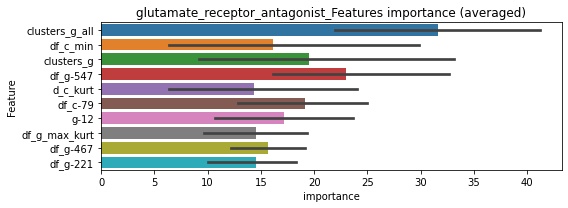

len(train_index) : 3467
len(valid_index) : 3468
================================= fold 1/2 glutamate_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190345	valid_1's binary_logloss: 0.0856332


len(train_index) : 3468
len(valid_index) : 3467


Early stopping, best iteration is:
[144]	training's binary_logloss: 0.00974026	valid_1's binary_logloss: 0.0825772


================================= fold 2/2 glutamate_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0196942	valid_1's binary_logloss: 0.0788646


glutamate_receptor_antagonist logloss: 0.07904710874838779


Early stopping, best iteration is:
[164]	training's binary_logloss: 0.00751046	valid_1's binary_logloss: 0.075516


gonadotropin_receptor_agonist, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233097	valid_1's binary_logloss: 0.0318318
[200]	training's binary_logloss: 0.00279442	valid_1's binary_logloss: 0.00597223
[300]	training's binary_logloss: 0.000780197	valid_1's binary_logloss: 0.00210029
[400]	training's binary_logloss: 0.000415614	valid_1's binary_logloss: 0.00122778
[500]	training's binary_logloss: 0.000336064	valid_1's binary_logloss: 0.00103519
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000335625	valid_1's binary_logloss: 0.00103387
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0238661	valid_1's binary_logloss: 0.0289007
[200]	training's binary_logloss: 0.00278737	valid_1's binary_logloss: 0.00462203
[300]	training's binary_logloss: 0.000786602	valid_1's binary_logloss: 0.0017202
[400]	training's binary_logloss: 0.00042223	valid_1's binary_logloss: 0.00105021
[500]	training's binary_logloss: 

1 / 3 AUC score:1.000
y_Threshold: 0.0019998, Threshold: 0.0037743, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076, Num_p_label: 80.0, conf_0:0.00340, conf_1:0.00415
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0037743
Num_p_label: 17.0, Expected: 3.0, Adj_threshold_2: 0.0137743
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_3: 0.0237743
threshold: 0.0237743, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.023042	valid_1's binary_logloss: 0.030124
[200]	training's binary_logloss: 0.00261014	valid_1's binary_logloss: 0.00519398
[300]	training's binary_logloss: 0.000746278	valid_1's binary_logloss: 0.00198049
[400]	training's binary_logloss: 0.000404941	valid_1's binary_logloss: 0.00121824
[500]	training's binary_logloss: 0.000331261	valid_1's binary_logloss: 0.00105667
Early stopping, best iteration is:
[507]	training's binary_logloss: 0.000328299	valid_1's binary_logloss: 0.00105132
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230202	valid_1's binary_logloss: 0.0268774
[200]	training's binary_logloss: 0.00259049	valid_1's binary_logloss: 0.00366645
[300]	training's binary_logloss: 0.000742281	valid_1's binary_logloss: 0.00123753
[400]	training's binary_logloss: 0.00040322	valid_1's binary_logloss: 0.000716869
[500]	training's binary_logloss: 

2 / 3 AUC score:1.000
y_Threshold: 0.1360834, Threshold: 0.0237743, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0057760 Vs.target_rate: 0.00076, Num_p_label: 23.0, conf_0:0.02140, conf_1:0.02615
Num_p_label: 23.0, Expected: 3.0, Adj_threshold_1: 0.0237743
Num_p_label: 16.0, Expected: 3.0, Adj_threshold_2: 0.0337743
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_3: 0.0437743
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_4: 0.0537743
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_5: 0.0637743
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_6: 0.0737743
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_7: 0.0837743
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_8: 0.0937743
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_9: 0.1037743
threshold: 0.1037743, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.023042	valid_1's binary_logloss: 0.030124
[200]	training's binary_logloss: 0.00261014	valid_1's binary_logloss: 0.00519398
[300]	training's binary_logloss: 0.000746278	valid_1's binary_logloss: 0.00198049
[400]	training's binary_logloss: 0.000404941	valid_1's binary_logloss: 0.00121824
[500]	training's binary_logloss: 0.000331261	valid_1's binary_logloss: 0.00105667
Early stopping, best iteration is:
[507]	training's binary_logloss: 0.000328299	valid_1's binary_logloss: 0.00105132
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230202	valid_1's binary_logloss: 0.0268774
[200]	training's binary_logloss: 0.00259049	valid_1's binary_logloss: 0.00366645
[300]	training's binary_logloss: 0.000742281	valid_1's binary_logloss: 0.00123753
[400]	training's binary_logloss: 0.00040322	valid_1's binary_logloss: 0.000716869
[500]	training's binary_logloss: 

3 / 3 AUC score:1.000
y_Threshold: 0.1360834, Threshold: 0.1037743, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0010045 Vs.target_rate: 0.00076, Num_p_label: 4.0, conf_0:0.09340, conf_1:0.11415
threshold: 0.1037743, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 661.0/7793, y_label_rate: 0.0848197


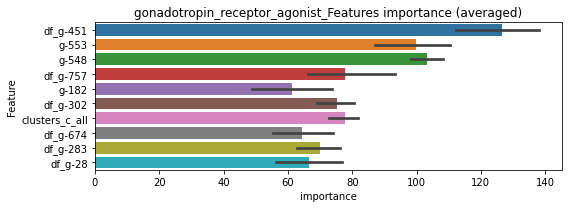

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 gonadotropin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0127149	valid_1's binary_logloss: 0.0190409
[200]	training's binary_logloss: 0.0014699	valid_1's binary_logloss: 0.00564038
[300]	training's binary_logloss: 0.000403681	valid_1's binary_logloss: 0.00431728
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.000275544	valid_1's binary_logloss: 0.00414926


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 gonadotropin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0128939	valid_1's binary_logloss: 0.0156527
[200]	training's binary_logloss: 0.00150469	valid_1's binary_logloss: 0.00333589
[300]	training's binary_logloss: 0.000416136	valid_1's binary_logloss: 0.00189904
[400]	training's binary_logloss: 0.000219631	valid_1's binary_logloss: 0.00157891
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000175149	valid_1's binary_logloss: 0.00151074


gonadotropin_receptor_agonist logloss: 0.0028301702157517835
gsk_inhibitor, len(trt): 60, len(othr): 3279, target_rate: 0.0025195 → Adj_target_rate: 0.0027266


neg labels: 3289 → selected neg labels: 3279


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0355592	valid_1's binary_logloss: 0.0742373
[200]	training's binary_logloss: 0.00590604	valid_1's binary_logloss: 0.032202
[300]	training's binary_logloss: 0.00166771	valid_1's binary_logloss: 0.0225723
[400]	training's binary_logloss: 0.000802486	valid_1's binary_logloss: 0.0185618
Early stopping, best iteration is:
[451]	training's binary_logloss: 0.000627123	valid_1's binary_logloss: 0.0177191
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0351819	valid_1's binary_logloss: 0.0713396
[200]	training's binary_logloss: 0.0054478	valid_1's binary_logloss: 0.0288642
[300]	training's binary_logloss: 0.0016132	valid_1's binary_logloss: 0.0204815
Early stopping, best iteration is:
[389]	training's binary_logloss: 0.000846793	valid_1's binary_logloss: 0.0177053


1 / 3 AUC score:1.000
y_Threshold: 0.0042174, Threshold: 0.0065966, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 655/3802
p_label_rate: 0.0200904 Vs.target_rate: 0.00252, Num_p_label: 80.0, conf_0:0.00594, conf_1:0.00726
Num_p_label: 80.0, Expected: 10.0, Adj_threshold_1: 0.0065966
Num_p_label: 20.0, Expected: 10.0, Adj_threshold_2: 0.0165966
threshold: 0.0165966, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 655.0/3802, y_label_rate: 0.1722777
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0354553	valid_1's binary_logloss: 0.0668256
[200]	training's binary_logloss: 0.00544719	valid_1's binary_logloss: 0.0274159
[300]	training's binary_logloss: 0.00159905	valid_1's binary_logloss: 0.0192363
[400]	training's binary_logloss: 0.000784506	valid_1's binary_logloss: 0.0166181
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.000770065	valid_1's binary_logloss: 0.0165547
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0347076	valid_1's binary_logloss: 0.0702425
[200]	training's binary_logloss: 0.00539912	valid_1's binary_logloss: 0.0275819
[300]	training's binary_logloss: 0.00157624	valid_1's binary_logloss: 0.0180712
[400]	training's binary_logloss: 0.000778434	valid_1's binary_logloss: 0.0152181
Early stopping, best iteration is:
[449]	training's binary_logloss: 0.000617429	valid_1's binary_logloss: 0.0144105


2 / 3 AUC score:1.000
y_Threshold: 0.0170506, Threshold: 0.0165966, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 653.0/3798
p_label_rate: 0.0085384 Vs.target_rate: 0.00252, Num_p_label: 34.0, conf_0:0.01494, conf_1:0.01826
Num_p_label: 34.0, Expected: 10.0, Adj_threshold_1: 0.0165966
Num_p_label: 18.0, Expected: 10.0, Adj_threshold_2: 0.0265966
threshold: 0.0265966, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 653.0/3798, y_label_rate: 0.1719326
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0347418	valid_1's binary_logloss: 0.0589782
[200]	training's binary_logloss: 0.00542725	valid_1's binary_logloss: 0.0205953
[300]	training's binary_logloss: 0.00159751	valid_1's binary_logloss: 0.0126618
[400]	training's binary_logloss: 0.000786555	valid_1's binary_logloss: 0.0104964
[500]	training's binary_logloss: 0.000525656	valid_1's binary_logloss: 0.00954469
Early stopping, best iteration is:
[526]	training's binary_logloss: 0.000490196	valid_1's binary_logloss: 0.00948846
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0348244	valid_1's binary_logloss: 0.0625516
[200]	training's binary_logloss: 0.00533946	valid_1's binary_logloss: 0.0222762
[300]	training's binary_logloss: 0.00157422	valid_1's binary_logloss: 0.0129463
[400]	training's binary_logloss: 0.000781952	valid_1's binary_logloss: 0.0101841
[500]	training's binary_logloss: 0.0005

3 / 3 AUC score:1.000
y_Threshold: 0.0160945, Threshold: 0.0265966, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 652.0/3796
p_label_rate: 0.0047715 Vs.target_rate: 0.00252, Num_p_label: 19.0, conf_0:0.02394, conf_1:0.02926
threshold: 0.0265966, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 671.0/7778, y_label_rate: 0.0862690


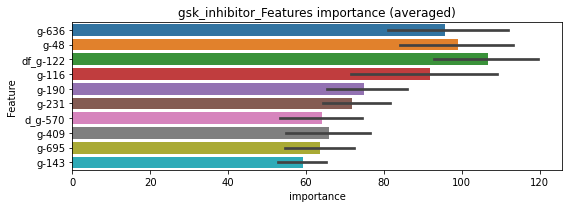

len(train_index) : 3889
len(valid_index) : 3889
================================= fold 1/2 gsk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0176671	valid_1's binary_logloss: 0.0441703
[200]	training's binary_logloss: 0.00266859	valid_1's binary_logloss: 0.0262755
[300]	training's binary_logloss: 0.000784635	valid_1's binary_logloss: 0.0230091
Early stopping, best iteration is:
[291]	training's binary_logloss: 0.000851507	valid_1's binary_logloss: 0.0229349


len(train_index) : 3889
len(valid_index) : 3889
================================= fold 2/2 gsk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0188662	valid_1's binary_logloss: 0.0340579
[200]	training's binary_logloss: 0.00285482	valid_1's binary_logloss: 0.0143304
[300]	training's binary_logloss: 0.000831292	valid_1's binary_logloss: 0.0107605
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.000460928	valid_1's binary_logloss: 0.00983474


gsk_inhibitor logloss: 0.016384838499241834
hcv_inhibitor, len(trt): 72, len(othr): 3277, target_rate: 0.0030234 → Adj_target_rate: 0.0031837


neg labels: 3289 → selected neg labels: 3277


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0549148	valid_1's binary_logloss: 0.105321
[200]	training's binary_logloss: 0.012271	valid_1's binary_logloss: 0.0581592
[300]	training's binary_logloss: 0.00364502	valid_1's binary_logloss: 0.0448858
[400]	training's binary_logloss: 0.0016693	valid_1's binary_logloss: 0.0408595
Early stopping, best iteration is:
[453]	training's binary_logloss: 0.00122288	valid_1's binary_logloss: 0.039827
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0510742	valid_1's binary_logloss: 0.116922
[200]	training's binary_logloss: 0.0108144	valid_1's binary_logloss: 0.0725846
[300]	training's binary_logloss: 0.00331644	valid_1's binary_logloss: 0.0635526
Early stopping, best iteration is:
[379]	training's binary_logloss: 0.00173138	valid_1's binary_logloss: 0.06054


1 / 3 AUC score:0.998
y_Threshold: 0.0101276, Threshold: 0.0149578, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 148 → Positive_corect_labels: 647/3784
p_label_rate: 0.0200904 Vs.target_rate: 0.00302, Num_p_label: 80.0, conf_0:0.01346, conf_1:0.01645
Num_p_label: 80.0, Expected: 12.0, Adj_threshold_1: 0.0149578
Num_p_label: 34.0, Expected: 12.0, Adj_threshold_2: 0.0249578
Num_p_label: 13.0, Expected: 12.0, Adj_threshold_3: 0.0349578
threshold: 0.0349578, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 647.0/3784, y_label_rate: 0.1709831
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0493743	valid_1's binary_logloss: 0.102897
[200]	training's binary_logloss: 0.0106057	valid_1's binary_logloss: 0.0577195
[300]	training's binary_logloss: 0.00323469	valid_1's binary_logloss: 0.0442755
Early stopping, best iteration is:
[388]	training's binary_logloss: 0.00164427	valid_1's binary_logloss: 0.0403563
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0531812	valid_1's binary_logloss: 0.110862
[200]	training's binary_logloss: 0.0108028	valid_1's binary_logloss: 0.0567821
[300]	training's binary_logloss: 0.00328475	valid_1's binary_logloss: 0.0426106
[400]	training's binary_logloss: 0.00151577	valid_1's binary_logloss: 0.0386265
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00147191	valid_1's binary_logloss: 0.0384653


2 / 3 AUC score:0.997
y_Threshold: 0.0400696, Threshold: 0.0349578, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 18 → Positive_corect_labels: 638.0/3766
p_label_rate: 0.0052737 Vs.target_rate: 0.00302, Num_p_label: 21.0, conf_0:0.03146, conf_1:0.03845
threshold: 0.0349578, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 638.0/3766, y_label_rate: 0.1694105
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0508839	valid_1's binary_logloss: 0.099812
[200]	training's binary_logloss: 0.0102646	valid_1's binary_logloss: 0.0473473
[300]	training's binary_logloss: 0.00310678	valid_1's binary_logloss: 0.0329338
[400]	training's binary_logloss: 0.00145595	valid_1's binary_logloss: 0.0288457
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.0011688	valid_1's binary_logloss: 0.028025
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0511582	valid_1's binary_logloss: 0.0964092
[200]	training's binary_logloss: 0.0103486	valid_1's binary_logloss: 0.0431854
[300]	training's binary_logloss: 0.00305003	valid_1's binary_logloss: 0.0296831
[400]	training's binary_logloss: 0.00143913	valid_1's binary_logloss: 0.026001
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00099128	valid_1's binary_logloss: 0.0248179


3 / 3 AUC score:1.000
y_Threshold: 0.0298214, Threshold: 0.0349578, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 634.0/3758
p_label_rate: 0.0065294 Vs.target_rate: 0.00302, Num_p_label: 26.0, conf_0:0.03146, conf_1:0.03845
threshold: 0.0349578, positive_p_label: 26.0/3982, p_label_rate: 0.0065294
positive_y_label: 660.0/7740, y_label_rate: 0.0852713


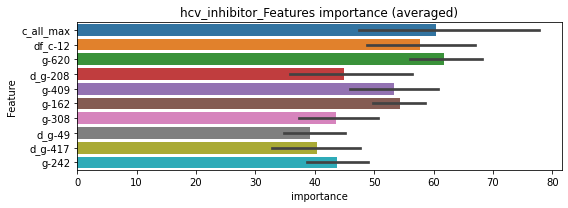

len(train_index) : 3870
len(valid_index) : 3870
================================= fold 1/2 hcv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0262669	valid_1's binary_logloss: 0.075468
[200]	training's binary_logloss: 0.00526603	valid_1's binary_logloss: 0.0519701
[300]	training's binary_logloss: 0.00158329	valid_1's binary_logloss: 0.0478932
Early stopping, best iteration is:
[334]	training's binary_logloss: 0.0011745	valid_1's binary_logloss: 0.0473788


len(train_index) : 3870
len(valid_index) : 3870
================================= fold 2/2 hcv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0300966	valid_1's binary_logloss: 0.064221
[200]	training's binary_logloss: 0.00621132	valid_1's binary_logloss: 0.0347851
[300]	training's binary_logloss: 0.00187865	valid_1's binary_logloss: 0.0275883
[400]	training's binary_logloss: 0.000857643	valid_1's binary_logloss: 0.0249575
Early stopping, best iteration is:
[428]	training's binary_logloss: 0.000726999	valid_1's binary_logloss: 0.0245925


hcv_inhibitor logloss: 0.03598567487905407
hdac_inhibitor, len(trt): 106, len(othr): 3271, target_rate: 0.0044512 → Adj_target_rate: 0.0044229


neg labels: 3289 → selected neg labels: 3271


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0324075	valid_1's binary_logloss: 0.0650028
[200]	training's binary_logloss: 0.00515593	valid_1's binary_logloss: 0.0314634
[300]	training's binary_logloss: 0.00148888	valid_1's binary_logloss: 0.0247239
Early stopping, best iteration is:
[388]	training's binary_logloss: 0.000776051	valid_1's binary_logloss: 0.0230631
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0319177	valid_1's binary_logloss: 0.0602565
[200]	training's binary_logloss: 0.0052872	valid_1's binary_logloss: 0.0292179
[300]	training's binary_logloss: 0.00150811	valid_1's binary_logloss: 0.0228741
[400]	training's binary_logloss: 0.000729974	valid_1's binary_logloss: 0.0209626
Early stopping, best iteration is:
[397]	training's binary_logloss: 0.00074045	valid_1's binary_logloss: 0.0208969


1 / 3 AUC score:0.999
y_Threshold: 0.0051425, Threshold: 0.0186936, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 137 → Positive_corect_labels: 651/3788
p_label_rate: 0.0200904 Vs.target_rate: 0.00445, Num_p_label: 80.0, conf_0:0.01682, conf_1:0.02056
Num_p_label: 80.0, Expected: 17.7, Adj_threshold_1: 0.0186936
Num_p_label: 56.0, Expected: 17.7, Adj_threshold_2: 0.0286936
Num_p_label: 42.0, Expected: 17.7, Adj_threshold_3: 0.0386936
Num_p_label: 35.0, Expected: 17.7, Adj_threshold_4: 0.0486936
threshold: 0.0486936, positive_p_label: 35.0/3982, p_label_rate: 0.0087896
positive_y_label: 651.0/3788, y_label_rate: 0.1718585
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0301939	valid_1's binary_logloss: 0.0519859
[200]	training's binary_logloss: 0.00443817	valid_1's binary_logloss: 0.018341
[300]	training's binary_logloss: 0.00131996	valid_1's binary_logloss: 0.0110255
[400]	training's binary_logloss: 0.000674223	valid_1's binary_logloss: 0.00871477
[500]	training's binary_logloss: 0.000475319	valid_1's binary_logloss: 0.00777223
Early stopping, best iteration is:
[501]	training's binary_logloss: 0.000474628	valid_1's binary_logloss: 0.00777182
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0303049	valid_1's binary_logloss: 0.0707514
[200]	training's binary_logloss: 0.00438547	valid_1's binary_logloss: 0.0443466


2 / 3 AUC score:1.000
y_Threshold: 0.0322333, Threshold: 0.0486936, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 18 → Positive_corect_labels: 642.0/3770
p_label_rate: 0.0248619 Vs.target_rate: 0.00445, Num_p_label: 99.0, conf_0:0.04382, conf_1:0.05356


Early stopping, best iteration is:
[224]	training's binary_logloss: 0.00306441	valid_1's binary_logloss: 0.0429145


Num_p_label: 99.0, Expected: 17.7, Adj_threshold_1: 0.0486936
Num_p_label: 81.0, Expected: 17.7, Adj_threshold_2: 0.0586936
Num_p_label: 67.0, Expected: 17.7, Adj_threshold_3: 0.0686936
Num_p_label: 57.0, Expected: 17.7, Adj_threshold_4: 0.0786936
Num_p_label: 55.0, Expected: 17.7, Adj_threshold_5: 0.0886936
Num_p_label: 54.0, Expected: 17.7, Adj_threshold_6: 0.0986936
Num_p_label: 50.0, Expected: 17.7, Adj_threshold_7: 0.1086936
Num_p_label: 48.0, Expected: 17.7, Adj_threshold_8: 0.1186936
Num_p_label: 44.0, Expected: 17.7, Adj_threshold_9: 0.1286936
Num_p_label: 43.0, Expected: 17.7, Adj_threshold_10: 0.1386936
threshold: 0.1486936, positive_p_label: 42.0/3982, p_label_rate: 0.0105475
positive_y_label: 642.0/3770, y_label_rate: 0.1702918
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0301816	valid_1's binary_logloss: 0.0557475
[200]	training's binary_logloss: 0.00431381	valid_1's binary_logloss: 0.0202542
[300]	training's binary_logloss: 0.00126243	valid_1's binary_logloss: 0.0131996
[400]	training's binary_logloss: 0.000645653	valid_1's binary_logloss: 0.0109696
Early stopping, best iteration is:
[438]	training's binary_logloss: 0.000546865	valid_1's binary_logloss: 0.0104563
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.029694	valid_1's binary_logloss: 0.0652719
[200]	training's binary_logloss: 0.00420946	valid_1's binary_logloss: 0.0381251


3 / 3 AUC score:1.000
y_Threshold: 0.0444897, Threshold: 0.1486936, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 10 → Positive_corect_labels: 637.0/3760
p_label_rate: 0.0102963 Vs.target_rate: 0.00445, Num_p_label: 41.0, conf_0:0.13382, conf_1:0.16356


Early stopping, best iteration is:
[246]	training's binary_logloss: 0.00218228	valid_1's binary_logloss: 0.0346532


threshold: 0.1486936, positive_p_label: 41.0/3982, p_label_rate: 0.0102963
positive_y_label: 678.0/7742, y_label_rate: 0.0875743


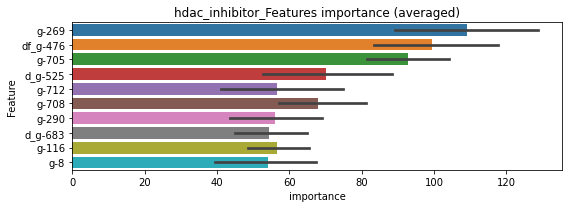

len(train_index) : 3871
len(valid_index) : 3871
================================= fold 1/2 hdac_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0167779	valid_1's binary_logloss: 0.039536
[200]	training's binary_logloss: 0.00252844	valid_1's binary_logloss: 0.0249051
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.000898371	valid_1's binary_logloss: 0.0231351


len(train_index) : 3871
len(valid_index) : 3871
================================= fold 2/2 hdac_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0171932	valid_1's binary_logloss: 0.0493256
[200]	training's binary_logloss: 0.00249194	valid_1's binary_logloss: 0.0297157
[300]	training's binary_logloss: 0.000732937	valid_1's binary_logloss: 0.0249528
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.000469604	valid_1's binary_logloss: 0.0234365


hdac_inhibitor logloss: 0.02328579872015597
histamine_receptor_agonist, len(trt): 59, len(othr): 3279, target_rate: 0.0024775 → Adj_target_rate: 0.0026880


neg labels: 3289 → selected neg labels: 3279


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0483268	valid_1's binary_logloss: 0.0946917
[200]	training's binary_logloss: 0.00993535	valid_1's binary_logloss: 0.0452313
[300]	training's binary_logloss: 0.00287555	valid_1's binary_logloss: 0.0319925
Early stopping, best iteration is:
[351]	training's binary_logloss: 0.00183368	valid_1's binary_logloss: 0.0297852
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0507671	valid_1's binary_logloss: 0.0876236
[200]	training's binary_logloss: 0.0104108	valid_1's binary_logloss: 0.0389442
[300]	training's binary_logloss: 0.00295747	valid_1's binary_logloss: 0.0257064
[400]	training's binary_logloss: 0.00135326	valid_1's binary_logloss: 0.0211863
[500]	training's binary_logloss: 0.000829884	valid_1's binary_logloss: 0.0194736
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000865214	valid_1's binary_logloss: 0.0194228


1 / 3 AUC score:1.000
y_Threshold: 0.0096653, Threshold: 0.0128067, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 654/3800
p_label_rate: 0.0200904 Vs.target_rate: 0.00248, Num_p_label: 80.0, conf_0:0.01153, conf_1:0.01409
Num_p_label: 80.0, Expected: 9.9, Adj_threshold_1: 0.0128067
Num_p_label: 14.0, Expected: 9.9, Adj_threshold_2: 0.0228067
threshold: 0.0228067, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 654.0/3800, y_label_rate: 0.1721053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0493252	valid_1's binary_logloss: 0.0861341
[200]	training's binary_logloss: 0.00975341	valid_1's binary_logloss: 0.0374421
[300]	training's binary_logloss: 0.00282687	valid_1's binary_logloss: 0.0233052
[400]	training's binary_logloss: 0.00130541	valid_1's binary_logloss: 0.0185406
[500]	training's binary_logloss: 0.000807569	valid_1's binary_logloss: 0.0164143
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.000766145	valid_1's binary_logloss: 0.0161573
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0498807	valid_1's binary_logloss: 0.0863825
[200]	training's binary_logloss: 0.0100336	valid_1's binary_logloss: 0.0365197
[300]	training's binary_logloss: 0.00289315	valid_1's binary_logloss: 0.0229044
[400]	training's binary_logloss: 0.00132022	valid_1's binary_logloss: 0.0187073
[500]	training's binary_logloss: 0.00081884	

2 / 3 AUC score:1.000
y_Threshold: 0.0295498, Threshold: 0.0228067, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 654.0/3800
p_label_rate: 0.0090407 Vs.target_rate: 0.00248, Num_p_label: 36.0, conf_0:0.02053, conf_1:0.02509
Num_p_label: 36.0, Expected: 9.9, Adj_threshold_1: 0.0228067
Num_p_label: 14.0, Expected: 9.9, Adj_threshold_2: 0.0328067
threshold: 0.0328067, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 654.0/3800, y_label_rate: 0.1721053
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0493252	valid_1's binary_logloss: 0.0861341
[200]	training's binary_logloss: 0.00975341	valid_1's binary_logloss: 0.0374421
[300]	training's binary_logloss: 0.00282687	valid_1's binary_logloss: 0.0233052
[400]	training's binary_logloss: 0.00130541	valid_1's binary_logloss: 0.0185406
[500]	training's binary_logloss: 0.000807569	valid_1's binary_logloss: 0.0164143
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.000766145	valid_1's binary_logloss: 0.0161573
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0498807	valid_1's binary_logloss: 0.0863825
[200]	training's binary_logloss: 0.0100336	valid_1's binary_logloss: 0.0365197
[300]	training's binary_logloss: 0.00289315	valid_1's binary_logloss: 0.0229044
[400]	training's binary_logloss: 0.00132022	valid_1's binary_logloss: 0.0187073
[500]	training's binary_logloss: 0.00081884	

3 / 3 AUC score:1.000
y_Threshold: 0.0295498, Threshold: 0.0328067, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 654.0/3800
p_label_rate: 0.0035158 Vs.target_rate: 0.00248, Num_p_label: 14.0, conf_0:0.02953, conf_1:0.03609
threshold: 0.0328067, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 668.0/7782, y_label_rate: 0.0858391


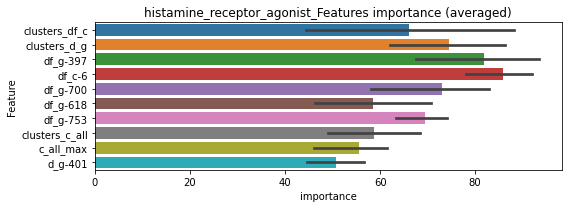

len(train_index) : 3891
len(valid_index) : 3891
================================= fold 1/2 histamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0290541	valid_1's binary_logloss: 0.0558792
[200]	training's binary_logloss: 0.00561926	valid_1's binary_logloss: 0.030604
[300]	training's binary_logloss: 0.00161547	valid_1's binary_logloss: 0.0254664
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.00115451	valid_1's binary_logloss: 0.0248227


len(train_index) : 3891
len(valid_index) : 3891
================================= fold 2/2 histamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0273945	valid_1's binary_logloss: 0.0515136
[200]	training's binary_logloss: 0.00550354	valid_1's binary_logloss: 0.026822
[300]	training's binary_logloss: 0.00158892	valid_1's binary_logloss: 0.021345
[400]	training's binary_logloss: 0.000708905	valid_1's binary_logloss: 0.0201905
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.00065365	valid_1's binary_logloss: 0.0200336


histamine_receptor_agonist logloss: 0.02242813094881638
histamine_receptor_antagonist, len(trt): 241, len(othr): 3249, target_rate: 0.0101201 → Adj_target_rate: 0.0088902


neg labels: 3289 → selected neg labels: 3249


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107116	valid_1's binary_logloss: 0.254202
[200]	training's binary_logloss: 0.0407313	valid_1's binary_logloss: 0.221942
Early stopping, best iteration is:
[235]	training's binary_logloss: 0.0295807	valid_1's binary_logloss: 0.217446
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110138	valid_1's binary_logloss: 0.258443
[200]	training's binary_logloss: 0.0389742	valid_1's binary_logloss: 0.221946
Early stopping, best iteration is:
[251]	training's binary_logloss: 0.0239475	valid_1's binary_logloss: 0.217215


1 / 3 AUC score:0.925
y_Threshold: 0.0781377, Threshold: 0.1143153, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 371 → Positive_corect_labels: 529/3527
p_label_rate: 0.0200904 Vs.target_rate: 0.01012, Num_p_label: 80.0, conf_0:0.10288, conf_1:0.12575
threshold: 0.1143153, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 529.0/3527, y_label_rate: 0.1499858
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0736211	valid_1's binary_logloss: 0.183156
[200]	training's binary_logloss: 0.0207227	valid_1's binary_logloss: 0.144351
Early stopping, best iteration is:
[287]	training's binary_logloss: 0.00805416	valid_1's binary_logloss: 0.135016
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0763738	valid_1's binary_logloss: 0.190074
[200]	training's binary_logloss: 0.0225664	valid_1's binary_logloss: 0.150505


2 / 3 AUC score:0.979
y_Threshold: 0.0777525, Threshold: 0.1143153, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[237]	training's binary_logloss: 0.0152184	valid_1's binary_logloss: 0.144724


Remove_noisy_labels: 108 → Positive_corect_labels: 475.0/3419
p_label_rate: 0.0107986 Vs.target_rate: 0.01012, Num_p_label: 43.0, conf_0:0.10288, conf_1:0.12575
threshold: 0.1143153, positive_p_label: 43.0/3982, p_label_rate: 0.0107986
positive_y_label: 475.0/3419, y_label_rate: 0.1389295
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0624177	valid_1's binary_logloss: 0.167837
[200]	training's binary_logloss: 0.016362	valid_1's binary_logloss: 0.141917
Early stopping, best iteration is:
[224]	training's binary_logloss: 0.01212	valid_1's binary_logloss: 0.140018
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0583387	valid_1's binary_logloss: 0.162348
[200]	training's binary_logloss: 0.0147494	valid_1's binary_logloss: 0.129714


3 / 3 AUC score:0.987
y_Threshold: 0.0729432, Threshold: 0.1143153, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[233]	training's binary_logloss: 0.00981914	valid_1's binary_logloss: 0.125743


Remove_noisy_labels: 88 → Positive_corect_labels: 431.0/3331
p_label_rate: 0.0097941 Vs.target_rate: 0.01012, Num_p_label: 39.0, conf_0:0.10288, conf_1:0.12575
threshold: 0.1143153, positive_p_label: 39.0/3982, p_label_rate: 0.0097941
positive_y_label: 470.0/7313, y_label_rate: 0.0642691


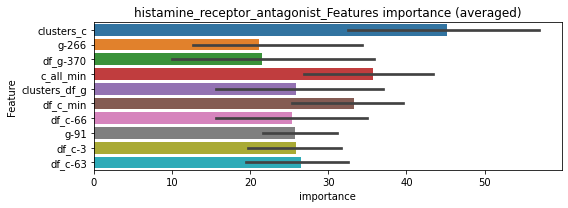

len(train_index) : 3656
len(valid_index) : 3657
================================= fold 1/2 histamine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0304028	valid_1's binary_logloss: 0.0872533
[200]	training's binary_logloss: 0.00815818	valid_1's binary_logloss: 0.0704161
Early stopping, best iteration is:
[237]	training's binary_logloss: 0.0052395	valid_1's binary_logloss: 0.0689137


len(train_index) : 3657
len(valid_index) : 3656
================================= fold 2/2 histamine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0343392	valid_1's binary_logloss: 0.0830225
[200]	training's binary_logloss: 0.00927926	valid_1's binary_logloss: 0.0647713
Early stopping, best iteration is:
[231]	training's binary_logloss: 0.00652664	valid_1's binary_logloss: 0.0633139


histamine_receptor_antagonist logloss: 0.0661142106317872
histone_lysine_demethylase_inhibitor, len(trt): 24, len(othr): 3285, target_rate: 0.0010078 → Adj_target_rate: 0.0012513


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0242765	valid_1's binary_logloss: 0.0338385
[200]	training's binary_logloss: 0.00296449	valid_1's binary_logloss: 0.0061731
[300]	training's binary_logloss: 0.000846308	valid_1's binary_logloss: 0.0023091
[400]	training's binary_logloss: 0.00044494	valid_1's binary_logloss: 0.00140274
[500]	training's binary_logloss: 0.000340031	valid_1's binary_logloss: 0.00116101
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.000332585	valid_1's binary_logloss: 0.00114424
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.024974	valid_1's binary_logloss: 0.0384828
[200]	training's binary_logloss: 0.00301223	valid_1's binary_logloss: 0.0077152
[300]	training's binary_logloss: 0.000853485	valid_1's binary_logloss: 0.00362865
[400]	training's binary_logloss: 0.000449891	valid_1's binary_logloss: 0.00278872
[500]	training's binary_logloss: 0.0

1 / 3 AUC score:1.000
y_Threshold: 0.0013846, Threshold: 0.0022239, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00101, Num_p_label: 80.0, conf_0:0.00200, conf_1:0.00245
Num_p_label: 80.0, Expected: 4.0, Adj_threshold_1: 0.0022239
Num_p_label: 2.0, Expected: 4.0, Adj_threshold_2: 0.0122239
threshold: 0.0122239, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0245681	valid_1's binary_logloss: 0.0342366
[200]	training's binary_logloss: 0.00293632	valid_1's binary_logloss: 0.00607104
[300]	training's binary_logloss: 0.000836856	valid_1's binary_logloss: 0.00222637
[400]	training's binary_logloss: 0.000445325	valid_1's binary_logloss: 0.00137321
[500]	training's binary_logloss: 0.000340573	valid_1's binary_logloss: 0.00114746
Early stopping, best iteration is:
[514]	training's binary_logloss: 0.000336785	valid_1's binary_logloss: 0.00113997
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0250337	valid_1's binary_logloss: 0.0376261
[200]	training's binary_logloss: 0.00297782	valid_1's binary_logloss: 0.00739746
[300]	training's binary_logloss: 0.000843531	valid_1's binary_logloss: 0.00342521
[400]	training's binary_logloss: 0.000445962	valid_1's binary_logloss: 0.00263063
[500]	training's binary_logloss

2 / 3 AUC score:1.000
y_Threshold: 0.0374274, Threshold: 0.0122239, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0015068 Vs.target_rate: 0.00101, Num_p_label: 6.0, conf_0:0.01100, conf_1:0.01345
threshold: 0.0122239, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0245681	valid_1's binary_logloss: 0.0342366
[200]	training's binary_logloss: 0.00293632	valid_1's binary_logloss: 0.00607104
[300]	training's binary_logloss: 0.000836856	valid_1's binary_logloss: 0.00222637
[400]	training's binary_logloss: 0.000445325	valid_1's binary_logloss: 0.00137321
[500]	training's binary_logloss: 0.000340573	valid_1's binary_logloss: 0.00114746
Early stopping, best iteration is:
[514]	training's binary_logloss: 0.000336785	valid_1's binary_logloss: 0.00113997
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0250337	valid_1's binary_logloss: 0.0376261
[200]	training's binary_logloss: 0.00297782	valid_1's binary_logloss: 0.00739746
[300]	training's binary_logloss: 0.000843531	valid_1's binary_logloss: 0.00342521
[400]	training's binary_logloss: 0.000445962	valid_1's binary_logloss: 0.00263063
[500]	training's binary_logloss

3 / 3 AUC score:1.000
y_Threshold: 0.0374274, Threshold: 0.0122239, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0015068 Vs.target_rate: 0.00101, Num_p_label: 6.0, conf_0:0.01100, conf_1:0.01345
threshold: 0.0122239, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 663.0/7792, y_label_rate: 0.0850873


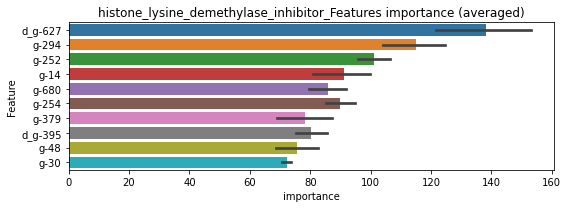

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 histone_lysine_demethylase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0127303	valid_1's binary_logloss: 0.022355
[200]	training's binary_logloss: 0.00149113	valid_1's binary_logloss: 0.00863549
Early stopping, best iteration is:
[289]	training's binary_logloss: 0.000458538	valid_1's binary_logloss: 0.00748293


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 histone_lysine_demethylase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0131023	valid_1's binary_logloss: 0.0198467
[200]	training's binary_logloss: 0.00154131	valid_1's binary_logloss: 0.00446199
[300]	training's binary_logloss: 0.000436565	valid_1's binary_logloss: 0.00258557
[400]	training's binary_logloss: 0.000227127	valid_1's binary_logloss: 0.00222479
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.000231059	valid_1's binary_logloss: 0.00221923


histone_lysine_demethylase_inhibitor logloss: 0.004851080702827674
histone_lysine_methyltransferase_inhibitor, len(trt): 32, len(othr): 3283, target_rate: 0.0013437 → Adj_target_rate: 0.0015980


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0297151	valid_1's binary_logloss: 0.0550894
[200]	training's binary_logloss: 0.00416987	valid_1's binary_logloss: 0.0186405
[300]	training's binary_logloss: 0.00119716	valid_1's binary_logloss: 0.0127277
[400]	training's binary_logloss: 0.000603659	valid_1's binary_logloss: 0.0109183
[500]	training's binary_logloss: 0.00042761	valid_1's binary_logloss: 0.0103533
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.000409321	valid_1's binary_logloss: 0.0102668
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0305939	valid_1's binary_logloss: 0.0500914
[200]	training's binary_logloss: 0.00437876	valid_1's binary_logloss: 0.0124404
[300]	training's binary_logloss: 0.00124512	valid_1's binary_logloss: 0.00575486
[400]	training's binary_logloss: 0.00063309	valid_1's binary_logloss: 0.00385127
[500]	training's binary_logloss: 0.000438

1 / 3 AUC score:1.000
y_Threshold: 0.0025430, Threshold: 0.0042940, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00134, Num_p_label: 80.0, conf_0:0.00386, conf_1:0.00472
Num_p_label: 80.0, Expected: 5.4, Adj_threshold_1: 0.0042940
Num_p_label: 15.0, Expected: 5.4, Adj_threshold_2: 0.0142940
Num_p_label: 7.0, Expected: 5.4, Adj_threshold_3: 0.0242940
threshold: 0.0242940, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.029963	valid_1's binary_logloss: 0.0574996
[200]	training's binary_logloss: 0.00413626	valid_1's binary_logloss: 0.0194942
[300]	training's binary_logloss: 0.00118054	valid_1's binary_logloss: 0.0125945
Early stopping, best iteration is:
[366]	training's binary_logloss: 0.000719032	valid_1's binary_logloss: 0.0115066
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0311501	valid_1's binary_logloss: 0.0512921
[200]	training's binary_logloss: 0.00437823	valid_1's binary_logloss: 0.0125013
[300]	training's binary_logloss: 0.00125959	valid_1's binary_logloss: 0.00590624
[400]	training's binary_logloss: 0.000636341	valid_1's binary_logloss: 0.00409891
[500]	training's binary_logloss: 0.00044192	valid_1's binary_logloss: 0.00336485
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.000401703	valid_1's binary_logloss: 0.0031398


2 / 3 AUC score:1.000
y_Threshold: 0.0211037, Threshold: 0.0242940, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0082873 Vs.target_rate: 0.00134, Num_p_label: 33.0, conf_0:0.02186, conf_1:0.02672
Num_p_label: 33.0, Expected: 5.4, Adj_threshold_1: 0.0242940
Num_p_label: 23.0, Expected: 5.4, Adj_threshold_2: 0.0342940
Num_p_label: 17.0, Expected: 5.4, Adj_threshold_3: 0.0442940
Num_p_label: 13.0, Expected: 5.4, Adj_threshold_4: 0.0542940
Num_p_label: 10.0, Expected: 5.4, Adj_threshold_5: 0.0642940
threshold: 0.0642940, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 655.0/3805, y_label_rate: 0.1721419
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.03011	valid_1's binary_logloss: 0.0467188
[200]	training's binary_logloss: 0.00424237	valid_1's binary_logloss: 0.0109681
[300]	training's binary_logloss: 0.00121115	valid_1's binary_logloss: 0.00459225
[400]	training's binary_logloss: 0.000616875	valid_1's binary_logloss: 0.00295774
[500]	training's binary_logloss: 0.000432012	valid_1's binary_logloss: 0.00240473
Early stopping, best iteration is:
[560]	training's binary_logloss: 0.000397126	valid_1's binary_logloss: 0.0022884
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0303557	valid_1's binary_logloss: 0.0477577
[200]	training's binary_logloss: 0.00420725	valid_1's binary_logloss: 0.0117628
[300]	training's binary_logloss: 0.00121748	valid_1's binary_logloss: 0.00549664
[400]	training's binary_logloss: 0.000616862	valid_1's binary_logloss: 0.00356833
[500]	training's binary_logloss: 0.000

3 / 3 AUC score:1.000
y_Threshold: 0.1128864, Threshold: 0.0642940, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0025113 Vs.target_rate: 0.00134, Num_p_label: 10.0, conf_0:0.05786, conf_1:0.07072
threshold: 0.0642940, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 665.0/7787, y_label_rate: 0.0853987


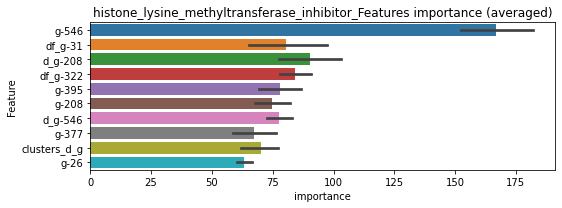

len(train_index) : 3893
len(valid_index) : 3894
================================= fold 1/2 histone_lysine_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162343	valid_1's binary_logloss: 0.030828
[200]	training's binary_logloss: 0.002231	valid_1's binary_logloss: 0.0131446
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.000722925	valid_1's binary_logloss: 0.0109392


len(train_index) : 3894
len(valid_index) : 3893
================================= fold 2/2 histone_lysine_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164969	valid_1's binary_logloss: 0.0274162
[200]	training's binary_logloss: 0.00236368	valid_1's binary_logloss: 0.00831293
[300]	training's binary_logloss: 0.000685214	valid_1's binary_logloss: 0.0052952
[400]	training's binary_logloss: 0.000336082	valid_1's binary_logloss: 0.0047575
Early stopping, best iteration is:
[451]	training's binary_logloss: 0.000265913	valid_1's binary_logloss: 0.00461555


histone_lysine_methyltransferase_inhibitor logloss: 0.007777765581787678
hiv_inhibitor, len(trt): 72, len(othr): 3278, target_rate: 0.0030234 → Adj_target_rate: 0.0031837


neg labels: 3289 → selected neg labels: 3278


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0532659	valid_1's binary_logloss: 0.111628
[200]	training's binary_logloss: 0.0115942	valid_1's binary_logloss: 0.0605222
[300]	training's binary_logloss: 0.00340826	valid_1's binary_logloss: 0.0465922
[400]	training's binary_logloss: 0.0015381	valid_1's binary_logloss: 0.0417916
Early stopping, best iteration is:
[428]	training's binary_logloss: 0.00131395	valid_1's binary_logloss: 0.0411842
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0580866	valid_1's binary_logloss: 0.104017
[200]	training's binary_logloss: 0.0127393	valid_1's binary_logloss: 0.051083
[300]	training's binary_logloss: 0.00368404	valid_1's binary_logloss: 0.0354758
[400]	training's binary_logloss: 0.00162357	valid_1's binary_logloss: 0.0303007
[500]	training's binary_logloss: 0.00098483	valid_1's binary_logloss: 0.0283603
Early stopping, best iteration is:
[491]	training's

1 / 3 AUC score:1.000
y_Threshold: 0.0093392, Threshold: 0.0138935, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 136 → Positive_corect_labels: 653/3797
p_label_rate: 0.0200904 Vs.target_rate: 0.00302, Num_p_label: 80.0, conf_0:0.01250, conf_1:0.01528
Num_p_label: 80.0, Expected: 12.0, Adj_threshold_1: 0.0138935
Num_p_label: 27.0, Expected: 12.0, Adj_threshold_2: 0.0238935
Num_p_label: 12.0, Expected: 12.0, Adj_threshold_3: 0.0338935
threshold: 0.0338935, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 653.0/3797, y_label_rate: 0.1719779
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0559511	valid_1's binary_logloss: 0.0945817
[200]	training's binary_logloss: 0.0121585	valid_1's binary_logloss: 0.0406569
[300]	training's binary_logloss: 0.00361186	valid_1's binary_logloss: 0.0263035
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00198911	valid_1's binary_logloss: 0.0226239
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0559306	valid_1's binary_logloss: 0.104826
[200]	training's binary_logloss: 0.0117284	valid_1's binary_logloss: 0.0509498
[300]	training's binary_logloss: 0.00344369	valid_1's binary_logloss: 0.036291
[400]	training's binary_logloss: 0.00156682	valid_1's binary_logloss: 0.0323852
[500]	training's binary_logloss: 0.000955338	valid_1's binary_logloss: 0.0308027
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.000912675	valid_1's binary_logloss: 0.0306073


2 / 3 AUC score:1.000
y_Threshold: 0.0470530, Threshold: 0.0338935, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 10 → Positive_corect_labels: 648.0/3787
p_label_rate: 0.0095429 Vs.target_rate: 0.00302, Num_p_label: 38.0, conf_0:0.03050, conf_1:0.03728
Num_p_label: 38.0, Expected: 12.0, Adj_threshold_1: 0.0338935
Num_p_label: 27.0, Expected: 12.0, Adj_threshold_2: 0.0438935
Num_p_label: 15.0, Expected: 12.0, Adj_threshold_3: 0.0538935
threshold: 0.0538935, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 648.0/3787, y_label_rate: 0.1711117
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0577469	valid_1's binary_logloss: 0.101406
[200]	training's binary_logloss: 0.0118519	valid_1's binary_logloss: 0.0495935
[300]	training's binary_logloss: 0.00338081	valid_1's binary_logloss: 0.0362087
[400]	training's binary_logloss: 0.00153853	valid_1's binary_logloss: 0.0311311
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00109945	valid_1's binary_logloss: 0.0296489
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0551953	valid_1's binary_logloss: 0.104679
[200]	training's binary_logloss: 0.0117161	valid_1's binary_logloss: 0.0513687
[300]	training's binary_logloss: 0.00345314	valid_1's binary_logloss: 0.0370117
[400]	training's binary_logloss: 0.00156073	valid_1's binary_logloss: 0.0311143
[500]	training's binary_logloss: 0.00094941	valid_1's binary_logloss: 0.0292704
[600]	training's binary_logloss: 0.000697138	vali

3 / 3 AUC score:1.000
y_Threshold: 0.0352816, Threshold: 0.0538935, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 12 → Positive_corect_labels: 642.0/3775
p_label_rate: 0.0025113 Vs.target_rate: 0.00302, Num_p_label: 10.0, conf_0:0.04850, conf_1:0.05928
threshold: 0.0538935, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 652.0/7757, y_label_rate: 0.0840531


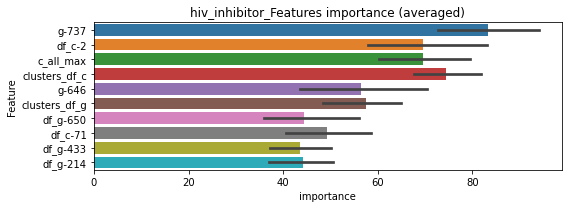

len(train_index) : 3878
len(valid_index) : 3879
================================= fold 1/2 hiv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0269817	valid_1's binary_logloss: 0.0628428
[200]	training's binary_logloss: 0.00537224	valid_1's binary_logloss: 0.0368632
[300]	training's binary_logloss: 0.0015795	valid_1's binary_logloss: 0.0313774
Early stopping, best iteration is:
[368]	training's binary_logloss: 0.000887248	valid_1's binary_logloss: 0.0302565


len(train_index) : 3879
len(valid_index) : 3878
================================= fold 2/2 hiv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0318587	valid_1's binary_logloss: 0.0650992
[200]	training's binary_logloss: 0.00682159	valid_1's binary_logloss: 0.037844
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.00241737	valid_1's binary_logloss: 0.0311709


hiv_inhibitor logloss: 0.030713627718916146
hmgcr_inhibitor, len(trt): 283, len(othr): 3282, target_rate: 0.0118838 → Adj_target_rate: 0.0101910


neg labels: 3289 → selected neg labels: 3282


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0424855	valid_1's binary_logloss: 0.0881864
[200]	training's binary_logloss: 0.0078373	valid_1's binary_logloss: 0.0573105
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.00390171	valid_1's binary_logloss: 0.0527743
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0399801	valid_1's binary_logloss: 0.105496
[200]	training's binary_logloss: 0.00780387	valid_1's binary_logloss: 0.0794664
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.00347698	valid_1's binary_logloss: 0.0761518


1 / 3 AUC score:0.992
y_Threshold: 0.0304149, Threshold: 0.1825792, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 168 → Positive_corect_labels: 638/3770
p_label_rate: 0.0200904 Vs.target_rate: 0.01188, Num_p_label: 80.0, conf_0:0.16432, conf_1:0.20084
threshold: 0.1825792, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 638.0/3770, y_label_rate: 0.1692308
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0331568	valid_1's binary_logloss: 0.0723347
[200]	training's binary_logloss: 0.0056447	valid_1's binary_logloss: 0.0432806
[300]	training's binary_logloss: 0.00157447	valid_1's binary_logloss: 0.0379326
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00118626	valid_1's binary_logloss: 0.037166
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0347033	valid_1's binary_logloss: 0.0607176
[200]	training's binary_logloss: 0.00554312	valid_1's binary_logloss: 0.0258544
[300]	training's binary_logloss: 0.00159227	valid_1's binary_logloss: 0.0181891
[400]	training's binary_logloss: 0.000753637	valid_1's binary_logloss: 0.0156398
[500]	training's binary_logloss: 0.000501251	valid_1's binary_logloss: 0.0148355
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.000508226	valid_1's binary_logloss: 0.0147972


2 / 3 AUC score:0.998
y_Threshold: 0.1137593, Threshold: 0.1825792, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 20 → Positive_corect_labels: 628.0/3750
p_label_rate: 0.0366650 Vs.target_rate: 0.01188, Num_p_label: 146.0, conf_0:0.16432, conf_1:0.20084
Num_p_label: 146.0, Expected: 47.3, Adj_threshold_1: 0.1825792
Num_p_label: 145.0, Expected: 47.3, Adj_threshold_2: 0.1925792
Num_p_label: 142.0, Expected: 47.3, Adj_threshold_3: 0.2025792
Num_p_label: 141.0, Expected: 47.3, Adj_threshold_4: 0.2125792
Num_p_label: 137.0, Expected: 47.3, Adj_threshold_5: 0.2225792
Num_p_label: 135.0, Expected: 47.3, Adj_threshold_6: 0.2325792
Num_p_label: 132.0, Expected: 47.3, Adj_threshold_7: 0.2425792
Num_p_label: 128.0, Expected: 47.3, Adj_threshold_8: 0.2525792
Num_p_label: 125.0, Expected: 47.3, Adj_threshold_9: 0.2625792
Num_p_label: 125.0, Expected: 47.3, Adj_threshold_10: 0.2725792
threshold: 0.2825792, positive_p_label: 124.0/3982, p_label_rate: 0.0311401
positive_y_label: 628.0/3750, y_label_r

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0325447	valid_1's binary_logloss: 0.0613304
[200]	training's binary_logloss: 0.00500533	valid_1's binary_logloss: 0.0257347
[300]	training's binary_logloss: 0.00141247	valid_1's binary_logloss: 0.0182728
[400]	training's binary_logloss: 0.000653139	valid_1's binary_logloss: 0.0154547
[500]	training's binary_logloss: 0.000449375	valid_1's binary_logloss: 0.0144386
Early stopping, best iteration is:
[536]	training's binary_logloss: 0.000416112	valid_1's binary_logloss: 0.0141311
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0326523	valid_1's binary_logloss: 0.0567371
[200]	training's binary_logloss: 0.00510296	valid_1's binary_logloss: 0.0247483
[300]	training's binary_logloss: 0.00143033	valid_1's binary_logloss: 0.01825
[400]	training's binary_logloss: 0.000668443	valid_1's binary_logloss: 0.0160063
Early stopping, best iteration is:
[433]	tr

3 / 3 AUC score:1.000
y_Threshold: 0.1148371, Threshold: 0.2825792, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 14 → Positive_corect_labels: 621.0/3736
p_label_rate: 0.0349071 Vs.target_rate: 0.01188, Num_p_label: 139.0, conf_0:0.25432, conf_1:0.31084
threshold: 0.2825792, positive_p_label: 139.0/3982, p_label_rate: 0.0349071
positive_y_label: 760.0/7718, y_label_rate: 0.0984711


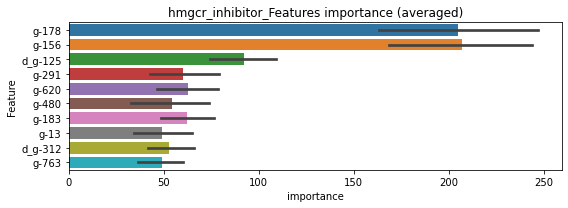

len(train_index) : 3859
len(valid_index) : 3859
================================= fold 1/2 hmgcr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0199718	valid_1's binary_logloss: 0.0405441
[200]	training's binary_logloss: 0.0031555	valid_1's binary_logloss: 0.0201988
[300]	training's binary_logloss: 0.000865595	valid_1's binary_logloss: 0.0146498
[400]	training's binary_logloss: 0.000424317	valid_1's binary_logloss: 0.0132172
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.000355809	valid_1's binary_logloss: 0.0129394


len(train_index) : 3859
len(valid_index) : 3859
================================= fold 2/2 hmgcr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193857	valid_1's binary_logloss: 0.0444602
[200]	training's binary_logloss: 0.0030473	valid_1's binary_logloss: 0.0249469
[300]	training's binary_logloss: 0.000829369	valid_1's binary_logloss: 0.0185771
[400]	training's binary_logloss: 0.000405064	valid_1's binary_logloss: 0.0169462
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000336638	valid_1's binary_logloss: 0.0163481


hmgcr_inhibitor logloss: 0.014643780749813764
hsp_inhibitor, len(trt): 93, len(othr): 3275, target_rate: 0.0039053 → Adj_target_rate: 0.0039574


neg labels: 3289 → selected neg labels: 3275


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0270348	valid_1's binary_logloss: 0.0490718
[200]	training's binary_logloss: 0.0035887	valid_1's binary_logloss: 0.0202842
[300]	training's binary_logloss: 0.00104344	valid_1's binary_logloss: 0.0157048
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.000972976	valid_1's binary_logloss: 0.0154881
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0276513	valid_1's binary_logloss: 0.0570368
[200]	training's binary_logloss: 0.00358927	valid_1's binary_logloss: 0.0291776
[300]	training's binary_logloss: 0.00102392	valid_1's binary_logloss: 0.0239525
Early stopping, best iteration is:
[307]	training's binary_logloss: 0.000962467	valid_1's binary_logloss: 0.0238818


1 / 3 AUC score:1.000
y_Threshold: 0.0038354, Threshold: 0.0156266, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 131 → Positive_corect_labels: 655/3799
p_label_rate: 0.0200904 Vs.target_rate: 0.00391, Num_p_label: 80.0, conf_0:0.01406, conf_1:0.01719
Num_p_label: 80.0, Expected: 15.6, Adj_threshold_1: 0.0156266
Num_p_label: 65.0, Expected: 15.6, Adj_threshold_2: 0.0256266
Num_p_label: 57.0, Expected: 15.6, Adj_threshold_3: 0.0356266
Num_p_label: 50.0, Expected: 15.6, Adj_threshold_4: 0.0456266
Num_p_label: 47.0, Expected: 15.6, Adj_threshold_5: 0.0556266
Num_p_label: 41.0, Expected: 15.6, Adj_threshold_6: 0.0656266
Num_p_label: 37.0, Expected: 15.6, Adj_threshold_7: 0.0756266
Num_p_label: 31.0, Expected: 15.6, Adj_threshold_8: 0.0856266
threshold: 0.0856266, positive_p_label: 31.0/3982, p_label_rate: 0.0077850
positive_y_label: 655.0/3799, y_label_rate: 0.1724138
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0271085	valid_1's binary_logloss: 0.0469241
[200]	training's binary_logloss: 0.00341247	valid_1's binary_logloss: 0.0186698
Early stopping, best iteration is:
[221]	training's binary_logloss: 0.00245498	valid_1's binary_logloss: 0.0173117
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.027608	valid_1's binary_logloss: 0.0544935
[200]	training's binary_logloss: 0.00350171	valid_1's binary_logloss: 0.0283825
[300]	training's binary_logloss: 0.000992967	valid_1's binary_logloss: 0.0235322


2 / 3 AUC score:1.000
y_Threshold: 0.0307929, Threshold: 0.0856266, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[327]	training's binary_logloss: 0.000790604	valid_1's binary_logloss: 0.023067


Remove_noisy_labels: 10 → Positive_corect_labels: 650.0/3789
p_label_rate: 0.0183325 Vs.target_rate: 0.00391, Num_p_label: 73.0, conf_0:0.07706, conf_1:0.09419
Num_p_label: 73.0, Expected: 15.6, Adj_threshold_1: 0.0856266
Num_p_label: 71.0, Expected: 15.6, Adj_threshold_2: 0.0956266
Num_p_label: 68.0, Expected: 15.6, Adj_threshold_3: 0.1056266
Num_p_label: 68.0, Expected: 15.6, Adj_threshold_4: 0.1156266
Num_p_label: 66.0, Expected: 15.6, Adj_threshold_5: 0.1256266
Num_p_label: 66.0, Expected: 15.6, Adj_threshold_6: 0.1356266
Num_p_label: 63.0, Expected: 15.6, Adj_threshold_7: 0.1456266
Num_p_label: 61.0, Expected: 15.6, Adj_threshold_8: 0.1556266
Num_p_label: 60.0, Expected: 15.6, Adj_threshold_9: 0.1656266
Num_p_label: 60.0, Expected: 15.6, Adj_threshold_10: 0.1756266
threshold: 0.1856266, positive_p_label: 58.0/3982, p_label_rate: 0.0145655
positive_y_label: 650.0/3789, y_label_rate: 0.1715492
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0273151	valid_1's binary_logloss: 0.0384697
[200]	training's binary_logloss: 0.00357105	valid_1's binary_logloss: 0.0105087
[300]	training's binary_logloss: 0.00101809	valid_1's binary_logloss: 0.00636878
[400]	training's binary_logloss: 0.000527819	valid_1's binary_logloss: 0.00525786
[500]	training's binary_logloss: 0.000386973	valid_1's binary_logloss: 0.00469789
Early stopping, best iteration is:
[499]	training's binary_logloss: 0.000387713	valid_1's binary_logloss: 0.00469565
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0264674	valid_1's binary_logloss: 0.0666156
[200]	training's binary_logloss: 0.0031237	valid_1's binary_logloss: 0.0441588


3 / 3 AUC score:0.999
y_Threshold: 0.0276819, Threshold: 0.1856266, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 14 → Positive_corect_labels: 643.0/3775
p_label_rate: 0.0125565 Vs.target_rate: 0.00391, Num_p_label: 50.0, conf_0:0.16706, conf_1:0.20419
Num_p_label: 50.0, Expected: 15.6, Adj_threshold_1: 0.1856266
Num_p_label: 49.0, Expected: 15.6, Adj_threshold_2: 0.1956266
Num_p_label: 46.0, Expected: 15.6, Adj_threshold_3: 0.2056266


Early stopping, best iteration is:
[225]	training's binary_logloss: 0.00208285	valid_1's binary_logloss: 0.0423026


Num_p_label: 46.0, Expected: 15.6, Adj_threshold_4: 0.2156266
Num_p_label: 44.0, Expected: 15.6, Adj_threshold_5: 0.2256266
Num_p_label: 42.0, Expected: 15.6, Adj_threshold_6: 0.2356266
Num_p_label: 42.0, Expected: 15.6, Adj_threshold_7: 0.2456266
Num_p_label: 42.0, Expected: 15.6, Adj_threshold_8: 0.2556266
Num_p_label: 41.0, Expected: 15.6, Adj_threshold_9: 0.2656266
Num_p_label: 39.0, Expected: 15.6, Adj_threshold_10: 0.2756266
threshold: 0.2856266, positive_p_label: 39.0/3982, p_label_rate: 0.0097941
positive_y_label: 682.0/7757, y_label_rate: 0.0879206


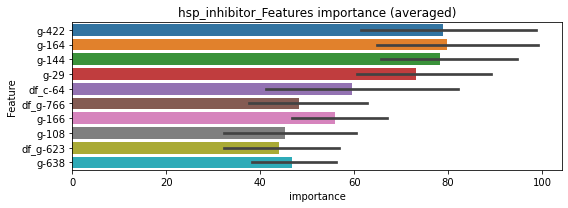

len(train_index) : 3878
len(valid_index) : 3879
================================= fold 1/2 hsp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0147237	valid_1's binary_logloss: 0.0378376
[200]	training's binary_logloss: 0.00188722	valid_1's binary_logloss: 0.0259291
Early stopping, best iteration is:
[222]	training's binary_logloss: 0.00135015	valid_1's binary_logloss: 0.0250496


len(train_index) : 3879
len(valid_index) : 3878
================================= fold 2/2 hsp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0149037	valid_1's binary_logloss: 0.0423279
Early stopping, best iteration is:
[169]	training's binary_logloss: 0.00337372	valid_1's binary_logloss: 0.0353973


hsp_inhibitor logloss: 0.030222744524197705
igf-1_inhibitor, len(trt): 37, len(othr): 3282, target_rate: 0.0015537 → Adj_target_rate: 0.0018079


neg labels: 3289 → selected neg labels: 3282


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0342207	valid_1's binary_logloss: 0.05068
[200]	training's binary_logloss: 0.00513591	valid_1's binary_logloss: 0.0127414
[300]	training's binary_logloss: 0.00145928	valid_1's binary_logloss: 0.00622608
[400]	training's binary_logloss: 0.000723483	valid_1's binary_logloss: 0.00422063
[500]	training's binary_logloss: 0.000488811	valid_1's binary_logloss: 0.00351109
Early stopping, best iteration is:
[567]	training's binary_logloss: 0.000441244	valid_1's binary_logloss: 0.00336437
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0330952	valid_1's binary_logloss: 0.0562854
[200]	training's binary_logloss: 0.00493774	valid_1's binary_logloss: 0.0168421
[300]	training's binary_logloss: 0.00141745	valid_1's binary_logloss: 0.00919841
[400]	training's binary_logloss: 0.000701524	valid_1's binary_logloss: 0.00702979
[500]	training's binary_logloss: 0.00

1 / 3 AUC score:1.000
y_Threshold: 0.0051177, Threshold: 0.0081924, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3806
p_label_rate: 0.0200904 Vs.target_rate: 0.00155, Num_p_label: 80.0, conf_0:0.00737, conf_1:0.00901
Num_p_label: 80.0, Expected: 6.2, Adj_threshold_1: 0.0081924
Num_p_label: 44.0, Expected: 6.2, Adj_threshold_2: 0.0181924
Num_p_label: 29.0, Expected: 6.2, Adj_threshold_3: 0.0281924
Num_p_label: 25.0, Expected: 6.2, Adj_threshold_4: 0.0381924
Num_p_label: 21.0, Expected: 6.2, Adj_threshold_5: 0.0481924
Num_p_label: 16.0, Expected: 6.2, Adj_threshold_6: 0.0581924
Num_p_label: 16.0, Expected: 6.2, Adj_threshold_7: 0.0681924
Num_p_label: 14.0, Expected: 6.2, Adj_threshold_8: 0.0781924
Num_p_label: 9.0, Expected: 6.2, Adj_threshold_9: 0.0881924
threshold: 0.0881924, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 656.0/3806, y_label_rate: 0.1723594
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.031632	valid_1's binary_logloss: 0.0464908
[200]	training's binary_logloss: 0.00445863	valid_1's binary_logloss: 0.0106204
[300]	training's binary_logloss: 0.0012892	valid_1's binary_logloss: 0.00489071
[400]	training's binary_logloss: 0.000655914	valid_1's binary_logloss: 0.00334657
[500]	training's binary_logloss: 0.000453179	valid_1's binary_logloss: 0.00281537
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.000443234	valid_1's binary_logloss: 0.00279533
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0314107	valid_1's binary_logloss: 0.0510425
[200]	training's binary_logloss: 0.00440738	valid_1's binary_logloss: 0.0133358
[300]	training's binary_logloss: 0.00129403	valid_1's binary_logloss: 0.00709787
[400]	training's binary_logloss: 0.000647192	valid_1's binary_logloss: 0.00532728
[500]	training's binary_logloss: 0.00

2 / 3 AUC score:1.000
y_Threshold: 0.0598099, Threshold: 0.0881924, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3804
p_label_rate: 0.0105475 Vs.target_rate: 0.00155, Num_p_label: 42.0, conf_0:0.07937, conf_1:0.09701
Num_p_label: 42.0, Expected: 6.2, Adj_threshold_1: 0.0881924
Num_p_label: 41.0, Expected: 6.2, Adj_threshold_2: 0.0981924
Num_p_label: 40.0, Expected: 6.2, Adj_threshold_3: 0.1081924
Num_p_label: 38.0, Expected: 6.2, Adj_threshold_4: 0.1181924
Num_p_label: 36.0, Expected: 6.2, Adj_threshold_5: 0.1281924
Num_p_label: 36.0, Expected: 6.2, Adj_threshold_6: 0.1381924
Num_p_label: 33.0, Expected: 6.2, Adj_threshold_7: 0.1481924
Num_p_label: 32.0, Expected: 6.2, Adj_threshold_8: 0.1581924
Num_p_label: 31.0, Expected: 6.2, Adj_threshold_9: 0.1681924
Num_p_label: 28.0, Expected: 6.2, Adj_threshold_10: 0.1781924
threshold: 0.1881924, positive_p_label: 27.0/3982, p_label_rate: 0.0067805
positive_y_label: 655.0/3804, y_label_rate: 0.1721872
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.031017	valid_1's binary_logloss: 0.0494442
[200]	training's binary_logloss: 0.00434086	valid_1's binary_logloss: 0.0183637
[300]	training's binary_logloss: 0.00125293	valid_1's binary_logloss: 0.013296
Early stopping, best iteration is:
[377]	training's binary_logloss: 0.000718012	valid_1's binary_logloss: 0.0120647
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0317085	valid_1's binary_logloss: 0.0465187
[200]	training's binary_logloss: 0.00440584	valid_1's binary_logloss: 0.00997136
[300]	training's binary_logloss: 0.00127215	valid_1's binary_logloss: 0.00415062
[400]	training's binary_logloss: 0.00064865	valid_1's binary_logloss: 0.00270476
[500]	training's binary_logloss: 0.000457287	valid_1's binary_logloss: 0.00217056
[600]	training's binary_logloss: 0.000417748	valid_1's binary_logloss: 0.00207447
Early stopping, best iteration is:
[608

3 / 3 AUC score:1.000
y_Threshold: 0.0621554, Threshold: 0.1881924, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 653.0/3800
p_label_rate: 0.0075339 Vs.target_rate: 0.00155, Num_p_label: 30.0, conf_0:0.16937, conf_1:0.20701
Num_p_label: 30.0, Expected: 6.2, Adj_threshold_1: 0.1881924
Num_p_label: 28.0, Expected: 6.2, Adj_threshold_2: 0.1981924
Num_p_label: 26.0, Expected: 6.2, Adj_threshold_3: 0.2081924
Num_p_label: 25.0, Expected: 6.2, Adj_threshold_4: 0.2181924
Num_p_label: 25.0, Expected: 6.2, Adj_threshold_5: 0.2281924
Num_p_label: 25.0, Expected: 6.2, Adj_threshold_6: 0.2381924
Num_p_label: 25.0, Expected: 6.2, Adj_threshold_7: 0.2481924
Num_p_label: 24.0, Expected: 6.2, Adj_threshold_8: 0.2581924
Num_p_label: 24.0, Expected: 6.2, Adj_threshold_9: 0.2681924
Num_p_label: 23.0, Expected: 6.2, Adj_threshold_10: 0.2781924
threshold: 0.2881924, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 674.0/7782, y_label_rate: 0.0866101


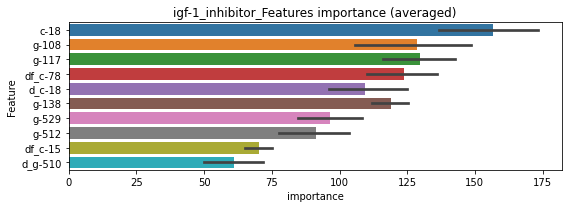

len(train_index) : 3891
len(valid_index) : 3891
================================= fold 1/2 igf-1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0177859	valid_1's binary_logloss: 0.0322681
[200]	training's binary_logloss: 0.00249414	valid_1's binary_logloss: 0.0127432
[300]	training's binary_logloss: 0.000722435	valid_1's binary_logloss: 0.00979869
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.000501091	valid_1's binary_logloss: 0.00946966


len(train_index) : 3891
len(valid_index) : 3891
================================= fold 2/2 igf-1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0183578	valid_1's binary_logloss: 0.0321724
[200]	training's binary_logloss: 0.00273534	valid_1's binary_logloss: 0.0118284
[300]	training's binary_logloss: 0.000764984	valid_1's binary_logloss: 0.0086758
Early stopping, best iteration is:
[379]	training's binary_logloss: 0.000420892	valid_1's binary_logloss: 0.00796943


igf-1_inhibitor logloss: 0.00871954760925046
ikk_inhibitor, len(trt): 30, len(othr): 3284, target_rate: 0.0012598 → Adj_target_rate: 0.0015127


neg labels: 3289 → selected neg labels: 3284


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0272091	valid_1's binary_logloss: 0.0485799
[200]	training's binary_logloss: 0.00356557	valid_1's binary_logloss: 0.0180883
[300]	training's binary_logloss: 0.00100876	valid_1's binary_logloss: 0.0121838
[400]	training's binary_logloss: 0.00052416	valid_1's binary_logloss: 0.0105122
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.000423235	valid_1's binary_logloss: 0.00990893
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0283199	valid_1's binary_logloss: 0.0387683
[200]	training's binary_logloss: 0.0036816	valid_1's binary_logloss: 0.00814269
[300]	training's binary_logloss: 0.00106043	valid_1's binary_logloss: 0.00389347
[400]	training's binary_logloss: 0.000549832	valid_1's binary_logloss: 0.00293785
[500]	training's binary_logloss: 0.000415798	valid_1's binary_logloss: 0.00266222
Early stopping, best iteration is:
[50

1 / 3 AUC score:1.000
y_Threshold: 0.0026236, Threshold: 0.2541718, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00126, Num_p_label: 80.0, conf_0:0.22875, conf_1:0.27959
Num_p_label: 80.0, Expected: 5.0, Adj_threshold_1: 0.2541718
Num_p_label: 79.0, Expected: 5.0, Adj_threshold_2: 0.2641718
Num_p_label: 78.0, Expected: 5.0, Adj_threshold_3: 0.2741718
Num_p_label: 76.0, Expected: 5.0, Adj_threshold_4: 0.2841718
Num_p_label: 75.0, Expected: 5.0, Adj_threshold_5: 0.2941718
Num_p_label: 75.0, Expected: 5.0, Adj_threshold_6: 0.3041718
Num_p_label: 75.0, Expected: 5.0, Adj_threshold_7: 0.3141718
Num_p_label: 73.0, Expected: 5.0, Adj_threshold_8: 0.3241718
Num_p_label: 72.0, Expected: 5.0, Adj_threshold_9: 0.3341718
Num_p_label: 72.0, Expected: 5.0, Adj_threshold_10: 0.3441718
threshold: 0.3541718, positive_p_label: 70.0/3982, p_label_rate: 0.0175791
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0261288	valid_1's binary_logloss: 0.0442153
[200]	training's binary_logloss: 0.00321361	valid_1's binary_logloss: 0.0153707
[300]	training's binary_logloss: 0.000919376	valid_1's binary_logloss: 0.0109574
[400]	training's binary_logloss: 0.000492402	valid_1's binary_logloss: 0.00924182
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.000396447	valid_1's binary_logloss: 0.00880322
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0269019	valid_1's binary_logloss: 0.0365752
[200]	training's binary_logloss: 0.00338628	valid_1's binary_logloss: 0.00684328
[300]	training's binary_logloss: 0.000977773	valid_1's binary_logloss: 0.00285398
[400]	training's binary_logloss: 0.000515624	valid_1's binary_logloss: 0.00187281
[500]	training's binary_logloss: 0.000388724	valid_1's binary_logloss: 0.0015428
Early stopping, best iteration is:

2 / 3 AUC score:1.000
y_Threshold: 0.0841955, Threshold: 0.3541718, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 654.0/3804
p_label_rate: 0.0258664 Vs.target_rate: 0.00126, Num_p_label: 103.0, conf_0:0.31875, conf_1:0.38959
Num_p_label: 103.0, Expected: 5.0, Adj_threshold_1: 0.3541718
Num_p_label: 103.0, Expected: 5.0, Adj_threshold_2: 0.3641718
Num_p_label: 103.0, Expected: 5.0, Adj_threshold_3: 0.3741718
Num_p_label: 103.0, Expected: 5.0, Adj_threshold_4: 0.3841718
Num_p_label: 103.0, Expected: 5.0, Adj_threshold_5: 0.3941718
Num_p_label: 103.0, Expected: 5.0, Adj_threshold_6: 0.4041718
Num_p_label: 102.0, Expected: 5.0, Adj_threshold_7: 0.4141718
Num_p_label: 101.0, Expected: 5.0, Adj_threshold_8: 0.4241718
Num_p_label: 101.0, Expected: 5.0, Adj_threshold_9: 0.4341718
Num_p_label: 101.0, Expected: 5.0, Adj_threshold_10: 0.4441718
threshold: 0.4541718, positive_p_label: 101.0/3982, p_label_rate: 0.0253641
positive_y_label: 654.0/3804, y_label_rate: 0.1719

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0262481	valid_1's binary_logloss: 0.0389169
[200]	training's binary_logloss: 0.00331696	valid_1's binary_logloss: 0.00885979
[300]	training's binary_logloss: 0.000946993	valid_1's binary_logloss: 0.00428747
[400]	training's binary_logloss: 0.000499405	valid_1's binary_logloss: 0.00307304
Early stopping, best iteration is:
[471]	training's binary_logloss: 0.000396387	valid_1's binary_logloss: 0.0027602
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0264672	valid_1's binary_logloss: 0.0344844
[200]	training's binary_logloss: 0.00332128	valid_1's binary_logloss: 0.00584184
[300]	training's binary_logloss: 0.000945186	valid_1's binary_logloss: 0.00208931
[400]	training's binary_logloss: 0.000501152	valid_1's binary_logloss: 0.00127973
[500]	training's binary_logloss: 0.000383985	valid_1's binary_logloss: 0.0010418
Early stopping, best iteration is

3 / 3 AUC score:1.000
y_Threshold: 0.2327771, Threshold: 0.4541718, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 654.0/3804
p_label_rate: 0.0266198 Vs.target_rate: 0.00126, Num_p_label: 106.0, conf_0:0.40875, conf_1:0.49959
Num_p_label: 106.0, Expected: 5.0, Adj_threshold_1: 0.4541718
Num_p_label: 106.0, Expected: 5.0, Adj_threshold_2: 0.4641718
Num_p_label: 105.0, Expected: 5.0, Adj_threshold_3: 0.4741718
Num_p_label: 103.0, Expected: 5.0, Adj_threshold_4: 0.4841718
Num_p_label: 103.0, Expected: 5.0, Adj_threshold_5: 0.4941718
Num_p_label: 102.0, Expected: 5.0, Adj_threshold_6: 0.5041718
Num_p_label: 102.0, Expected: 5.0, Adj_threshold_7: 0.5141718
Num_p_label: 100.0, Expected: 5.0, Adj_threshold_8: 0.5241718
Num_p_label: 99.0, Expected: 5.0, Adj_threshold_9: 0.5341718
Num_p_label: 99.0, Expected: 5.0, Adj_threshold_10: 0.5441718
threshold: 0.5541718, positive_p_label: 99.0/3982, p_label_rate: 0.0248619
positive_y_label: 753.0/7786, y_label_rate: 0.0967120

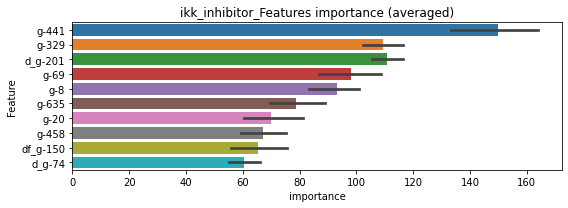

len(train_index) : 3893
len(valid_index) : 3893
================================= fold 1/2 ikk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161393	valid_1's binary_logloss: 0.0259208
[200]	training's binary_logloss: 0.00209689	valid_1's binary_logloss: 0.0081926
[300]	training's binary_logloss: 0.000575511	valid_1's binary_logloss: 0.00535242
[400]	training's binary_logloss: 0.000289679	valid_1's binary_logloss: 0.00442382
Early stopping, best iteration is:
[481]	training's binary_logloss: 0.00022471	valid_1's binary_logloss: 0.00422929


len(train_index) : 3893
len(valid_index) : 3893
================================= fold 2/2 ikk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160223	valid_1's binary_logloss: 0.0259971
[200]	training's binary_logloss: 0.0020923	valid_1's binary_logloss: 0.00871484
[300]	training's binary_logloss: 0.000571312	valid_1's binary_logloss: 0.00553647
[400]	training's binary_logloss: 0.000289898	valid_1's binary_logloss: 0.00452429
[500]	training's binary_logloss: 0.000214094	valid_1's binary_logloss: 0.00427056
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.000214094	valid_1's binary_logloss: 0.00427056


ikk_inhibitor logloss: 0.004252493458424931
imidazoline_receptor_agonist, len(trt): 31, len(othr): 3284, target_rate: 0.0013018 → Adj_target_rate: 0.0015554


neg labels: 3289 → selected neg labels: 3284


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.035913	valid_1's binary_logloss: 0.0531559
[200]	training's binary_logloss: 0.00534214	valid_1's binary_logloss: 0.0132127
[300]	training's binary_logloss: 0.00149114	valid_1's binary_logloss: 0.0057053
[400]	training's binary_logloss: 0.000728052	valid_1's binary_logloss: 0.00369598
[500]	training's binary_logloss: 0.000482654	valid_1's binary_logloss: 0.00295823
Early stopping, best iteration is:
[581]	training's binary_logloss: 0.00043033	valid_1's binary_logloss: 0.0027982
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0342985	valid_1's binary_logloss: 0.0551282
[200]	training's binary_logloss: 0.00523752	valid_1's binary_logloss: 0.0167004
[300]	training's binary_logloss: 0.00146949	valid_1's binary_logloss: 0.00999321
[400]	training's binary_logloss: 0.000713094	valid_1's binary_logloss: 0.00830444
Early stopping, best iteration is:
[417

1 / 3 AUC score:1.000
y_Threshold: 0.0034108, Threshold: 0.0063763, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00130, Num_p_label: 80.0, conf_0:0.00574, conf_1:0.00701
Num_p_label: 80.0, Expected: 5.2, Adj_threshold_1: 0.0063763
Num_p_label: 14.0, Expected: 5.2, Adj_threshold_2: 0.0163763
Num_p_label: 5.0, Expected: 5.2, Adj_threshold_3: 0.0263763
threshold: 0.0263763, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0349979	valid_1's binary_logloss: 0.0519218
[200]	training's binary_logloss: 0.00513092	valid_1's binary_logloss: 0.0123005
[300]	training's binary_logloss: 0.00145298	valid_1's binary_logloss: 0.00514246
[400]	training's binary_logloss: 0.000709893	valid_1's binary_logloss: 0.00320681
[500]	training's binary_logloss: 0.000479742	valid_1's binary_logloss: 0.00247936
Early stopping, best iteration is:
[573]	training's binary_logloss: 0.000439352	valid_1's binary_logloss: 0.00239356
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0342145	valid_1's binary_logloss: 0.0549335
[200]	training's binary_logloss: 0.00505584	valid_1's binary_logloss: 0.016879
[300]	training's binary_logloss: 0.00142035	valid_1's binary_logloss: 0.0108127
[400]	training's binary_logloss: 0.000691945	valid_1's binary_logloss: 0.0094525
Early stopping, best iteration is:
[44

2 / 3 AUC score:1.000
y_Threshold: 0.0140146, Threshold: 0.0263763, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3806
p_label_rate: 0.0057760 Vs.target_rate: 0.00130, Num_p_label: 23.0, conf_0:0.02374, conf_1:0.02901
Num_p_label: 23.0, Expected: 5.2, Adj_threshold_1: 0.0263763
Num_p_label: 12.0, Expected: 5.2, Adj_threshold_2: 0.0363763
Num_p_label: 8.0, Expected: 5.2, Adj_threshold_3: 0.0463763
threshold: 0.0463763, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 655.0/3806, y_label_rate: 0.1720967
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0354407	valid_1's binary_logloss: 0.0544413
[200]	training's binary_logloss: 0.00512843	valid_1's binary_logloss: 0.0152354
[300]	training's binary_logloss: 0.0014304	valid_1's binary_logloss: 0.00790149
[400]	training's binary_logloss: 0.000695782	valid_1's binary_logloss: 0.00571464
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00052038	valid_1's binary_logloss: 0.00524431
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0351618	valid_1's binary_logloss: 0.0494827
[200]	training's binary_logloss: 0.00521743	valid_1's binary_logloss: 0.0113086
[300]	training's binary_logloss: 0.00147047	valid_1's binary_logloss: 0.00450031
[400]	training's binary_logloss: 0.000723808	valid_1's binary_logloss: 0.00289864
[500]	training's binary_logloss: 0.000489332	valid_1's binary_logloss: 0.0022888
[600]	training's binary_logloss: 0.000

3 / 3 AUC score:1.000
y_Threshold: 0.0461786, Threshold: 0.0463763, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3806
p_label_rate: 0.0015068 Vs.target_rate: 0.00130, Num_p_label: 6.0, conf_0:0.04174, conf_1:0.05101
threshold: 0.0463763, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 661.0/7788, y_label_rate: 0.0848742


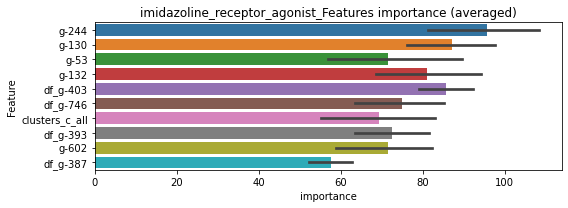

len(train_index) : 3894
len(valid_index) : 3894
================================= fold 1/2 imidazoline_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0184959	valid_1's binary_logloss: 0.0311876
[200]	training's binary_logloss: 0.0026524	valid_1's binary_logloss: 0.0117088
[300]	training's binary_logloss: 0.000741436	valid_1's binary_logloss: 0.0084433
Early stopping, best iteration is:
[384]	training's binary_logloss: 0.000389004	valid_1's binary_logloss: 0.00800208


len(train_index) : 3894
len(valid_index) : 3894
================================= fold 2/2 imidazoline_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.019662	valid_1's binary_logloss: 0.032295
[200]	training's binary_logloss: 0.00297271	valid_1's binary_logloss: 0.00991064
[300]	training's binary_logloss: 0.000814651	valid_1's binary_logloss: 0.00531654
[400]	training's binary_logloss: 0.000388276	valid_1's binary_logloss: 0.00402087
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.0003781	valid_1's binary_logloss: 0.0039652


imidazoline_receptor_agonist logloss: 0.00598363925311262
immunosuppressant, len(trt): 73, len(othr): 3278, target_rate: 0.0030654 → Adj_target_rate: 0.0032212


neg labels: 3289 → selected neg labels: 3278


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0448951	valid_1's binary_logloss: 0.094617
[200]	training's binary_logloss: 0.00893827	valid_1's binary_logloss: 0.0464049
[300]	training's binary_logloss: 0.00272692	valid_1's binary_logloss: 0.0340583
[400]	training's binary_logloss: 0.00128792	valid_1's binary_logloss: 0.0290928
[500]	training's binary_logloss: 0.000816685	valid_1's binary_logloss: 0.0269504
Early stopping, best iteration is:
[549]	training's binary_logloss: 0.000697312	valid_1's binary_logloss: 0.0265497
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0467988	valid_1's binary_logloss: 0.0891181
[200]	training's binary_logloss: 0.00953742	valid_1's binary_logloss: 0.0367948
[300]	training's binary_logloss: 0.00294052	valid_1's binary_logloss: 0.0222007
[400]	training's binary_logloss: 0.00139076	valid_1's binary_logloss: 0.0170864
[500]	training's binary_logloss: 0.000874679

1 / 3 AUC score:1.000
y_Threshold: 0.0086779, Threshold: 0.0199684, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 136 → Positive_corect_labels: 653/3797
p_label_rate: 0.0200904 Vs.target_rate: 0.00307, Num_p_label: 80.0, conf_0:0.01797, conf_1:0.02197
Num_p_label: 80.0, Expected: 12.2, Adj_threshold_1: 0.0199684
Num_p_label: 52.0, Expected: 12.2, Adj_threshold_2: 0.0299684
Num_p_label: 44.0, Expected: 12.2, Adj_threshold_3: 0.0399684
Num_p_label: 39.0, Expected: 12.2, Adj_threshold_4: 0.0499684
Num_p_label: 36.0, Expected: 12.2, Adj_threshold_5: 0.0599684
Num_p_label: 33.0, Expected: 12.2, Adj_threshold_6: 0.0699684
Num_p_label: 30.0, Expected: 12.2, Adj_threshold_7: 0.0799684
Num_p_label: 27.0, Expected: 12.2, Adj_threshold_8: 0.0899684
Num_p_label: 27.0, Expected: 12.2, Adj_threshold_9: 0.0999684
Num_p_label: 25.0, Expected: 12.2, Adj_threshold_10: 0.1099684
threshold: 0.1199684, positive_p_label: 23.0/3982, p_label_rate: 0.0057760
positive_y_label: 653.0/3797, y_label_rate: 0.171977

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0426916	valid_1's binary_logloss: 0.0925371
[200]	training's binary_logloss: 0.00759052	valid_1's binary_logloss: 0.0452485
[300]	training's binary_logloss: 0.0023089	valid_1's binary_logloss: 0.0348746
[400]	training's binary_logloss: 0.00113483	valid_1's binary_logloss: 0.0321194
Early stopping, best iteration is:
[451]	training's binary_logloss: 0.000886661	valid_1's binary_logloss: 0.0311092
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0435059	valid_1's binary_logloss: 0.0939049
[200]	training's binary_logloss: 0.00819899	valid_1's binary_logloss: 0.0481557
[300]	training's binary_logloss: 0.00249753	valid_1's binary_logloss: 0.0390414
[400]	training's binary_logloss: 0.00120571	valid_1's binary_logloss: 0.0372079
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.00116627	valid_1's binary_logloss: 0.0369646


2 / 3 AUC score:0.996
y_Threshold: 0.0454772, Threshold: 0.1199684, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 22 → Positive_corect_labels: 642.0/3775
p_label_rate: 0.0148167 Vs.target_rate: 0.00307, Num_p_label: 59.0, conf_0:0.10797, conf_1:0.13197
Num_p_label: 59.0, Expected: 12.2, Adj_threshold_1: 0.1199684
Num_p_label: 54.0, Expected: 12.2, Adj_threshold_2: 0.1299684
Num_p_label: 51.0, Expected: 12.2, Adj_threshold_3: 0.1399684
Num_p_label: 49.0, Expected: 12.2, Adj_threshold_4: 0.1499684
Num_p_label: 48.0, Expected: 12.2, Adj_threshold_5: 0.1599684
Num_p_label: 46.0, Expected: 12.2, Adj_threshold_6: 0.1699684
Num_p_label: 46.0, Expected: 12.2, Adj_threshold_7: 0.1799684
Num_p_label: 45.0, Expected: 12.2, Adj_threshold_8: 0.1899684
Num_p_label: 43.0, Expected: 12.2, Adj_threshold_9: 0.1999684
Num_p_label: 42.0, Expected: 12.2, Adj_threshold_10: 0.2099684
threshold: 0.2199684, positive_p_label: 41.0/3982, p_label_rate: 0.0102963
positive_y_label: 642.0/3775, y_label_rate: 0.17006

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.041049	valid_1's binary_logloss: 0.0818945
[200]	training's binary_logloss: 0.00731972	valid_1's binary_logloss: 0.0371465
[300]	training's binary_logloss: 0.00218935	valid_1's binary_logloss: 0.026232
[400]	training's binary_logloss: 0.00107676	valid_1's binary_logloss: 0.022092
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.000830159	valid_1's binary_logloss: 0.0211432
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0408121	valid_1's binary_logloss: 0.091866
[200]	training's binary_logloss: 0.00730906	valid_1's binary_logloss: 0.0482573
[300]	training's binary_logloss: 0.00223692	valid_1's binary_logloss: 0.0392526
Early stopping, best iteration is:
[379]	training's binary_logloss: 0.00123647	valid_1's binary_logloss: 0.0366077


3 / 3 AUC score:0.997
y_Threshold: 0.0501570, Threshold: 0.2199684, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 20 → Positive_corect_labels: 632.0/3755
p_label_rate: 0.0133099 Vs.target_rate: 0.00307, Num_p_label: 53.0, conf_0:0.19797, conf_1:0.24197
Num_p_label: 53.0, Expected: 12.2, Adj_threshold_1: 0.2199684
Num_p_label: 51.0, Expected: 12.2, Adj_threshold_2: 0.2299684
Num_p_label: 49.0, Expected: 12.2, Adj_threshold_3: 0.2399684
Num_p_label: 47.0, Expected: 12.2, Adj_threshold_4: 0.2499684
Num_p_label: 45.0, Expected: 12.2, Adj_threshold_5: 0.2599684
Num_p_label: 43.0, Expected: 12.2, Adj_threshold_6: 0.2699684
Num_p_label: 41.0, Expected: 12.2, Adj_threshold_7: 0.2799684
Num_p_label: 40.0, Expected: 12.2, Adj_threshold_8: 0.2899684
Num_p_label: 39.0, Expected: 12.2, Adj_threshold_9: 0.2999684
Num_p_label: 38.0, Expected: 12.2, Adj_threshold_10: 0.3099684
threshold: 0.3199684, positive_p_label: 38.0/3982, p_label_rate: 0.0095429
positive_y_label: 670.0/7737, y_label_rate: 0.08659

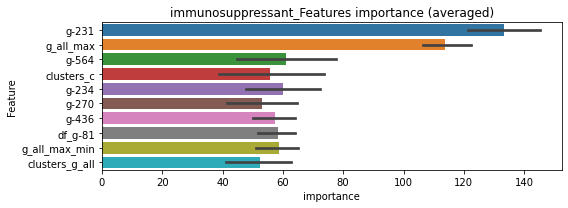

len(train_index) : 3868
len(valid_index) : 3869
================================= fold 1/2 immunosuppressant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.020778	valid_1's binary_logloss: 0.0509587
[200]	training's binary_logloss: 0.00361657	valid_1's binary_logloss: 0.0278393
[300]	training's binary_logloss: 0.00112688	valid_1's binary_logloss: 0.0220748
[400]	training's binary_logloss: 0.000558928	valid_1's binary_logloss: 0.0197157
[500]	training's binary_logloss: 0.000365535	valid_1's binary_logloss: 0.0190187
Early stopping, best iteration is:
[509]	training's binary_logloss: 0.000355323	valid_1's binary_logloss: 0.0189484


len(train_index) : 3869
len(valid_index) : 3868
================================= fold 2/2 immunosuppressant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0210509	valid_1's binary_logloss: 0.0540842
[200]	training's binary_logloss: 0.00374526	valid_1's binary_logloss: 0.0341152
[300]	training's binary_logloss: 0.00117405	valid_1's binary_logloss: 0.0295793
Early stopping, best iteration is:
[303]	training's binary_logloss: 0.00114305	valid_1's binary_logloss: 0.0294771


immunosuppressant logloss: 0.024212097605123502
insulin_secretagogue, len(trt): 30, len(othr): 3284, target_rate: 0.0012598 → Adj_target_rate: 0.0015127


neg labels: 3289 → selected neg labels: 3284


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0353622	valid_1's binary_logloss: 0.0556517
[200]	training's binary_logloss: 0.00522148	valid_1's binary_logloss: 0.0139089
[300]	training's binary_logloss: 0.00144288	valid_1's binary_logloss: 0.00618366
[400]	training's binary_logloss: 0.000720187	valid_1's binary_logloss: 0.00409682
[500]	training's binary_logloss: 0.00049021	valid_1's binary_logloss: 0.00338216
Early stopping, best iteration is:
[555]	training's binary_logloss: 0.000449128	valid_1's binary_logloss: 0.00323685
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0347946	valid_1's binary_logloss: 0.0667818
[200]	training's binary_logloss: 0.00503052	valid_1's binary_logloss: 0.0304486
[300]	training's binary_logloss: 0.00140462	valid_1's binary_logloss: 0.0234717
[400]	training's binary_logloss: 0.000699995	valid_1's binary_logloss: 0.0211121
Early stopping, best iteration is:
[45

1 / 3 AUC score:1.000
y_Threshold: 0.0033293, Threshold: 0.0052709, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 655/3806
p_label_rate: 0.0200904 Vs.target_rate: 0.00126, Num_p_label: 80.0, conf_0:0.00474, conf_1:0.00580
Num_p_label: 80.0, Expected: 5.0, Adj_threshold_1: 0.0052709
Num_p_label: 22.0, Expected: 5.0, Adj_threshold_2: 0.0152709
Num_p_label: 11.0, Expected: 5.0, Adj_threshold_3: 0.0252709
Num_p_label: 4.0, Expected: 5.0, Adj_threshold_4: 0.0352709
threshold: 0.0352709, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 655.0/3806, y_label_rate: 0.1720967
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0343718	valid_1's binary_logloss: 0.0540259
[200]	training's binary_logloss: 0.00502543	valid_1's binary_logloss: 0.0151045
[300]	training's binary_logloss: 0.00142537	valid_1's binary_logloss: 0.00828146
[400]	training's binary_logloss: 0.00069968	valid_1's binary_logloss: 0.00623079
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.000521565	valid_1's binary_logloss: 0.00576179
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0339736	valid_1's binary_logloss: 0.055879
[200]	training's binary_logloss: 0.00489745	valid_1's binary_logloss: 0.0174334
[300]	training's binary_logloss: 0.00139382	valid_1's binary_logloss: 0.0104763
[400]	training's binary_logloss: 0.00069338	valid_1's binary_logloss: 0.008299
[500]	training's binary_logloss: 0.00047497	valid_1's binary_logloss: 0.00736392
Early stopping, best iteration is:
[541]	t

2 / 3 AUC score:1.000
y_Threshold: 0.0381244, Threshold: 0.0352709, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3806
p_label_rate: 0.0047715 Vs.target_rate: 0.00126, Num_p_label: 19.0, conf_0:0.03174, conf_1:0.03880
Num_p_label: 19.0, Expected: 5.0, Adj_threshold_1: 0.0352709
Num_p_label: 8.0, Expected: 5.0, Adj_threshold_2: 0.0452709
threshold: 0.0452709, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 655.0/3806, y_label_rate: 0.1720967
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0343718	valid_1's binary_logloss: 0.0540259
[200]	training's binary_logloss: 0.00502543	valid_1's binary_logloss: 0.0151045
[300]	training's binary_logloss: 0.00142537	valid_1's binary_logloss: 0.00828146
[400]	training's binary_logloss: 0.00069968	valid_1's binary_logloss: 0.00623079
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.000521565	valid_1's binary_logloss: 0.00576179
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0339736	valid_1's binary_logloss: 0.055879
[200]	training's binary_logloss: 0.00489745	valid_1's binary_logloss: 0.0174334
[300]	training's binary_logloss: 0.00139382	valid_1's binary_logloss: 0.0104763
[400]	training's binary_logloss: 0.00069338	valid_1's binary_logloss: 0.008299
[500]	training's binary_logloss: 0.00047497	valid_1's binary_logloss: 0.00736392
Early stopping, best iteration is:
[541]	t

3 / 3 AUC score:1.000
y_Threshold: 0.0381244, Threshold: 0.0452709, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3806
p_label_rate: 0.0020090 Vs.target_rate: 0.00126, Num_p_label: 8.0, conf_0:0.04074, conf_1:0.04980
threshold: 0.0452709, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 663.0/7788, y_label_rate: 0.0851310


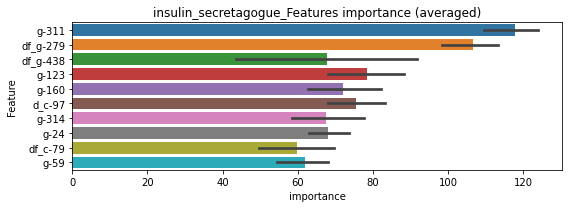

len(train_index) : 3894
len(valid_index) : 3894
================================= fold 1/2 insulin_secretagogue=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0200818	valid_1's binary_logloss: 0.0334855
[200]	training's binary_logloss: 0.00292002	valid_1's binary_logloss: 0.0118983
[300]	training's binary_logloss: 0.000757269	valid_1's binary_logloss: 0.00851591
[400]	training's binary_logloss: 0.000363465	valid_1's binary_logloss: 0.0080237
Early stopping, best iteration is:
[393]	training's binary_logloss: 0.000377367	valid_1's binary_logloss: 0.00800105


len(train_index) : 3894
len(valid_index) : 3894
================================= fold 2/2 insulin_secretagogue=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0191728	valid_1's binary_logloss: 0.0274507
[200]	training's binary_logloss: 0.00288916	valid_1's binary_logloss: 0.00760342
[300]	training's binary_logloss: 0.000804456	valid_1's binary_logloss: 0.00443761
[400]	training's binary_logloss: 0.000387873	valid_1's binary_logloss: 0.00368606
[500]	training's binary_logloss: 0.000259423	valid_1's binary_logloss: 0.00340834
Early stopping, best iteration is:
[517]	training's binary_logloss: 0.000249826	valid_1's binary_logloss: 0.00338849


insulin_secretagogue logloss: 0.005694769427186911
insulin_sensitizer, len(trt): 51, len(othr): 3281, target_rate: 0.0021416 → Adj_target_rate: 0.0023748


neg labels: 3289 → selected neg labels: 3281


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0343644	valid_1's binary_logloss: 0.0680075
[200]	training's binary_logloss: 0.00548514	valid_1's binary_logloss: 0.0292755
[300]	training's binary_logloss: 0.00163318	valid_1's binary_logloss: 0.0212499
[400]	training's binary_logloss: 0.000825201	valid_1's binary_logloss: 0.0191707
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.000799706	valid_1's binary_logloss: 0.0191083
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0359538	valid_1's binary_logloss: 0.0663205
[200]	training's binary_logloss: 0.00586727	valid_1's binary_logloss: 0.0280343
[300]	training's binary_logloss: 0.00177002	valid_1's binary_logloss: 0.021016
[400]	training's binary_logloss: 0.000873215	valid_1's binary_logloss: 0.0188861
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.000775346	valid_1's binary_logloss: 0.0184487


1 / 3 AUC score:1.000
y_Threshold: 0.0056490, Threshold: 0.0134414, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 655/3803
p_label_rate: 0.0200904 Vs.target_rate: 0.00214, Num_p_label: 80.0, conf_0:0.01210, conf_1:0.01479
Num_p_label: 80.0, Expected: 8.5, Adj_threshold_1: 0.0134414
Num_p_label: 32.0, Expected: 8.5, Adj_threshold_2: 0.0234414
Num_p_label: 20.0, Expected: 8.5, Adj_threshold_3: 0.0334414
Num_p_label: 14.0, Expected: 8.5, Adj_threshold_4: 0.0434414
threshold: 0.0434414, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 655.0/3803, y_label_rate: 0.1722324
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0364957	valid_1's binary_logloss: 0.058396
[200]	training's binary_logloss: 0.00584126	valid_1's binary_logloss: 0.0167771
[300]	training's binary_logloss: 0.00174758	valid_1's binary_logloss: 0.00903343
[400]	training's binary_logloss: 0.000856891	valid_1's binary_logloss: 0.00656192
[500]	training's binary_logloss: 0.000573381	valid_1's binary_logloss: 0.00580915
Early stopping, best iteration is:
[568]	training's binary_logloss: 0.000501569	valid_1's binary_logloss: 0.00567267
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0349068	valid_1's binary_logloss: 0.0646319
[200]	training's binary_logloss: 0.0053788	valid_1's binary_logloss: 0.0242953
[300]	training's binary_logloss: 0.00161694	valid_1's binary_logloss: 0.0164063
[400]	training's binary_logloss: 0.000814671	valid_1's binary_logloss: 0.0136961
Early stopping, best iteration is:
[431

2 / 3 AUC score:1.000
y_Threshold: 0.0332595, Threshold: 0.0434414, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 654.0/3801
p_label_rate: 0.0092918 Vs.target_rate: 0.00214, Num_p_label: 37.0, conf_0:0.03910, conf_1:0.04779
Num_p_label: 37.0, Expected: 8.5, Adj_threshold_1: 0.0434414
Num_p_label: 30.0, Expected: 8.5, Adj_threshold_2: 0.0534414
Num_p_label: 24.0, Expected: 8.5, Adj_threshold_3: 0.0634414
Num_p_label: 24.0, Expected: 8.5, Adj_threshold_4: 0.0734414
Num_p_label: 21.0, Expected: 8.5, Adj_threshold_5: 0.0834414
Num_p_label: 18.0, Expected: 8.5, Adj_threshold_6: 0.0934414
Num_p_label: 18.0, Expected: 8.5, Adj_threshold_7: 0.1034414
Num_p_label: 15.0, Expected: 8.5, Adj_threshold_8: 0.1134414
threshold: 0.1134414, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 654.0/3801, y_label_rate: 0.1720600
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0345569	valid_1's binary_logloss: 0.0591311
[200]	training's binary_logloss: 0.00543353	valid_1's binary_logloss: 0.0201627
[300]	training's binary_logloss: 0.00164356	valid_1's binary_logloss: 0.0121451
[400]	training's binary_logloss: 0.000831962	valid_1's binary_logloss: 0.00986765
[500]	training's binary_logloss: 0.000558294	valid_1's binary_logloss: 0.00884343
Early stopping, best iteration is:
[566]	training's binary_logloss: 0.000489651	valid_1's binary_logloss: 0.00861441
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0353885	valid_1's binary_logloss: 0.0578273
[200]	training's binary_logloss: 0.00568278	valid_1's binary_logloss: 0.0179344
[300]	training's binary_logloss: 0.00168945	valid_1's binary_logloss: 0.0097824
[400]	training's binary_logloss: 0.000842888	valid_1's binary_logloss: 0.00760769
Early stopping, best iteration is:
[4

3 / 3 AUC score:1.000
y_Threshold: 0.0253377, Threshold: 0.1134414, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 654.0/3801
p_label_rate: 0.0037670 Vs.target_rate: 0.00214, Num_p_label: 15.0, conf_0:0.10210, conf_1:0.12479
threshold: 0.1134414, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 669.0/7783, y_label_rate: 0.0859566


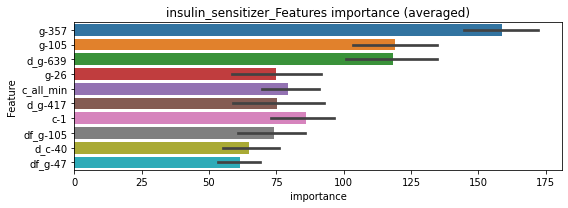

len(train_index) : 3891
len(valid_index) : 3892
================================= fold 1/2 insulin_sensitizer=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189129	valid_1's binary_logloss: 0.0386033
[200]	training's binary_logloss: 0.00301305	valid_1's binary_logloss: 0.0180429
[300]	training's binary_logloss: 0.000891111	valid_1's binary_logloss: 0.0145235
[400]	training's binary_logloss: 0.000436836	valid_1's binary_logloss: 0.013842
Early stopping, best iteration is:
[412]	training's binary_logloss: 0.000410889	valid_1's binary_logloss: 0.0137758


len(train_index) : 3892
len(valid_index) : 3891
================================= fold 2/2 insulin_sensitizer=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185171	valid_1's binary_logloss: 0.036159
[200]	training's binary_logloss: 0.00290223	valid_1's binary_logloss: 0.0138747
[300]	training's binary_logloss: 0.000877974	valid_1's binary_logloss: 0.00981592
[400]	training's binary_logloss: 0.000437425	valid_1's binary_logloss: 0.00879046
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.000416114	valid_1's binary_logloss: 0.00870246


insulin_sensitizer logloss: 0.011239469046317384
integrin_inhibitor, len(trt): 42, len(othr): 3282, target_rate: 0.0017637 → Adj_target_rate: 0.0020135


neg labels: 3289 → selected neg labels: 3282


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0385494	valid_1's binary_logloss: 0.0715736
[200]	training's binary_logloss: 0.00665702	valid_1's binary_logloss: 0.0297676
[300]	training's binary_logloss: 0.00191631	valid_1's binary_logloss: 0.0189013
[400]	training's binary_logloss: 0.000933996	valid_1's binary_logloss: 0.0155541
Early stopping, best iteration is:
[427]	training's binary_logloss: 0.000808971	valid_1's binary_logloss: 0.0150881
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.040993	valid_1's binary_logloss: 0.0676978
[200]	training's binary_logloss: 0.00741658	valid_1's binary_logloss: 0.0260646
[300]	training's binary_logloss: 0.00209387	valid_1's binary_logloss: 0.0153392
[400]	training's binary_logloss: 0.000993589	valid_1's binary_logloss: 0.011833
[500]	training's binary_logloss: 0.000635948	valid_1's binary_logloss: 0.0104899
[600]	training's binary_logloss: 0.00052344

1 / 3 AUC score:1.000
y_Threshold: 0.0041849, Threshold: 0.0059564, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3806
p_label_rate: 0.0200904 Vs.target_rate: 0.00176, Num_p_label: 80.0, conf_0:0.00536, conf_1:0.00655
Num_p_label: 80.0, Expected: 7.0, Adj_threshold_1: 0.0059564
Num_p_label: 17.0, Expected: 7.0, Adj_threshold_2: 0.0159564
Num_p_label: 3.0, Expected: 7.0, Adj_threshold_3: 0.0259564
threshold: 0.0259564, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 656.0/3806, y_label_rate: 0.1723594
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0374366	valid_1's binary_logloss: 0.0702094
[200]	training's binary_logloss: 0.00627704	valid_1's binary_logloss: 0.0291032
[300]	training's binary_logloss: 0.00181073	valid_1's binary_logloss: 0.0187212
[400]	training's binary_logloss: 0.000902929	valid_1's binary_logloss: 0.0155959
[500]	training's binary_logloss: 0.000598082	valid_1's binary_logloss: 0.0144216
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.000543267	valid_1's binary_logloss: 0.0140321
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0390864	valid_1's binary_logloss: 0.0670506
[200]	training's binary_logloss: 0.00674222	valid_1's binary_logloss: 0.0232078
[300]	training's binary_logloss: 0.00197154	valid_1's binary_logloss: 0.0137991
[400]	training's binary_logloss: 0.000959546	valid_1's binary_logloss: 0.0112014
[500]	training's binary_logloss: 0.000624

2 / 3 AUC score:1.000
y_Threshold: 0.0194848, Threshold: 0.0259564, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 654.0/3802
p_label_rate: 0.0052737 Vs.target_rate: 0.00176, Num_p_label: 21.0, conf_0:0.02336, conf_1:0.02855
threshold: 0.0259564, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 654.0/3802, y_label_rate: 0.1720147
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0385589	valid_1's binary_logloss: 0.0629306
[200]	training's binary_logloss: 0.00659	valid_1's binary_logloss: 0.0223009
[300]	training's binary_logloss: 0.00189829	valid_1's binary_logloss: 0.0128531
[400]	training's binary_logloss: 0.000924209	valid_1's binary_logloss: 0.010081
[500]	training's binary_logloss: 0.00059592	valid_1's binary_logloss: 0.00891507
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.00059592	valid_1's binary_logloss: 0.00891507
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0384281	valid_1's binary_logloss: 0.0620627
[200]	training's binary_logloss: 0.00659843	valid_1's binary_logloss: 0.019428
[300]	training's binary_logloss: 0.00195863	valid_1's binary_logloss: 0.0103562
[400]	training's binary_logloss: 0.000947511	valid_1's binary_logloss: 0.00725006
[500]	training's binary_logloss: 0.000626985	

3 / 3 AUC score:1.000
y_Threshold: 0.0455502, Threshold: 0.0259564, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 654.0/3802
p_label_rate: 0.0055249 Vs.target_rate: 0.00176, Num_p_label: 22.0, conf_0:0.02336, conf_1:0.02855
Num_p_label: 22.0, Expected: 7.0, Adj_threshold_1: 0.0259564
Num_p_label: 15.0, Expected: 7.0, Adj_threshold_2: 0.0359564
Num_p_label: 10.0, Expected: 7.0, Adj_threshold_3: 0.0459564
threshold: 0.0459564, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 664.0/7784, y_label_rate: 0.0853032


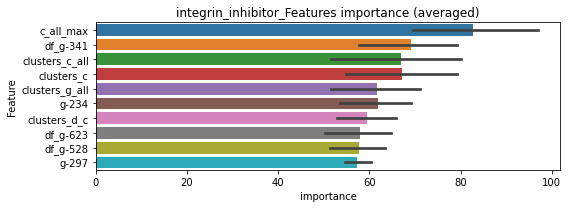

len(train_index) : 3892
len(valid_index) : 3892
================================= fold 1/2 integrin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0210866	valid_1's binary_logloss: 0.0390405
[200]	training's binary_logloss: 0.00347915	valid_1's binary_logloss: 0.0194545
[300]	training's binary_logloss: 0.00100358	valid_1's binary_logloss: 0.0158436
[400]	training's binary_logloss: 0.000474818	valid_1's binary_logloss: 0.0153719
Early stopping, best iteration is:
[442]	training's binary_logloss: 0.000383678	valid_1's binary_logloss: 0.0151493


len(train_index) : 3892
len(valid_index) : 3892
================================= fold 2/2 integrin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0213261	valid_1's binary_logloss: 0.0374459
[200]	training's binary_logloss: 0.00370238	valid_1's binary_logloss: 0.0145229
[300]	training's binary_logloss: 0.00104443	valid_1's binary_logloss: 0.00950064
[400]	training's binary_logloss: 0.000496874	valid_1's binary_logloss: 0.00800424
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00040373	valid_1's binary_logloss: 0.00781326


integrin_inhibitor logloss: 0.011481274862480975
jak_inhibitor, len(trt): 92, len(othr): 3274, target_rate: 0.0038633 → Adj_target_rate: 0.0039212


neg labels: 3289 → selected neg labels: 3274


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.04087	valid_1's binary_logloss: 0.085889
[200]	training's binary_logloss: 0.00718075	valid_1's binary_logloss: 0.0451186
[300]	training's binary_logloss: 0.0022032	valid_1's binary_logloss: 0.0350748
[400]	training's binary_logloss: 0.00108018	valid_1's binary_logloss: 0.0324388
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000797832	valid_1's binary_logloss: 0.0315704
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0406175	valid_1's binary_logloss: 0.0905731
[200]	training's binary_logloss: 0.0072331	valid_1's binary_logloss: 0.0459292
[300]	training's binary_logloss: 0.00221054	valid_1's binary_logloss: 0.0341904
Early stopping, best iteration is:
[333]	training's binary_logloss: 0.00166807	valid_1's binary_logloss: 0.0324043


1 / 3 AUC score:0.999
y_Threshold: 0.0156883, Threshold: 0.0424084, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 136 → Positive_corect_labels: 652/3792
p_label_rate: 0.0200904 Vs.target_rate: 0.00386, Num_p_label: 80.0, conf_0:0.03817, conf_1:0.04665
Num_p_label: 80.0, Expected: 15.4, Adj_threshold_1: 0.0424084
Num_p_label: 62.0, Expected: 15.4, Adj_threshold_2: 0.0524084
Num_p_label: 51.0, Expected: 15.4, Adj_threshold_3: 0.0624084
Num_p_label: 39.0, Expected: 15.4, Adj_threshold_4: 0.0724084
Num_p_label: 33.0, Expected: 15.4, Adj_threshold_5: 0.0824084
Num_p_label: 27.0, Expected: 15.4, Adj_threshold_6: 0.0924084
threshold: 0.0924084, positive_p_label: 27.0/3982, p_label_rate: 0.0067805
positive_y_label: 652.0/3792, y_label_rate: 0.1719409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0392529	valid_1's binary_logloss: 0.082444
[200]	training's binary_logloss: 0.00647445	valid_1's binary_logloss: 0.0394829
[300]	training's binary_logloss: 0.00194023	valid_1's binary_logloss: 0.0287903
Early stopping, best iteration is:
[367]	training's binary_logloss: 0.00115172	valid_1's binary_logloss: 0.0255349
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0392082	valid_1's binary_logloss: 0.0855121
[200]	training's binary_logloss: 0.00659131	valid_1's binary_logloss: 0.0431618
[300]	training's binary_logloss: 0.00197758	valid_1's binary_logloss: 0.0329059
[400]	training's binary_logloss: 0.000954719	valid_1's binary_logloss: 0.029449
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.00100525	valid_1's binary_logloss: 0.0294166


2 / 3 AUC score:1.000
y_Threshold: 0.1159946, Threshold: 0.0924084, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 20 → Positive_corect_labels: 642.0/3772
p_label_rate: 0.0298845 Vs.target_rate: 0.00386, Num_p_label: 119.0, conf_0:0.08317, conf_1:0.10165
Num_p_label: 119.0, Expected: 15.4, Adj_threshold_1: 0.0924084
Num_p_label: 111.0, Expected: 15.4, Adj_threshold_2: 0.1024084
Num_p_label: 106.0, Expected: 15.4, Adj_threshold_3: 0.1124084
Num_p_label: 101.0, Expected: 15.4, Adj_threshold_4: 0.1224084
Num_p_label: 96.0, Expected: 15.4, Adj_threshold_5: 0.1324084
Num_p_label: 90.0, Expected: 15.4, Adj_threshold_6: 0.1424084
Num_p_label: 90.0, Expected: 15.4, Adj_threshold_7: 0.1524084
Num_p_label: 86.0, Expected: 15.4, Adj_threshold_8: 0.1624084
Num_p_label: 83.0, Expected: 15.4, Adj_threshold_9: 0.1724084
Num_p_label: 77.0, Expected: 15.4, Adj_threshold_10: 0.1824084
threshold: 0.1924084, positive_p_label: 72.0/3982, p_label_rate: 0.0180814
positive_y_label: 642.0/3772, y_label_rate: 0.

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0377076	valid_1's binary_logloss: 0.0876639
[200]	training's binary_logloss: 0.00616811	valid_1's binary_logloss: 0.0504808
[300]	training's binary_logloss: 0.0018475	valid_1's binary_logloss: 0.0435645
Early stopping, best iteration is:
[313]	training's binary_logloss: 0.00164718	valid_1's binary_logloss: 0.0433097
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0384329	valid_1's binary_logloss: 0.0758517
[200]	training's binary_logloss: 0.00643138	valid_1's binary_logloss: 0.0321686
[300]	training's binary_logloss: 0.00193322	valid_1's binary_logloss: 0.0215773
[400]	training's binary_logloss: 0.000940693	valid_1's binary_logloss: 0.01817
Early stopping, best iteration is:
[412]	training's binary_logloss: 0.000885403	valid_1's binary_logloss: 0.0179696


3 / 3 AUC score:0.995
y_Threshold: 0.1279085, Threshold: 0.1924084, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 20 → Positive_corect_labels: 632.0/3752
p_label_rate: 0.0258664 Vs.target_rate: 0.00386, Num_p_label: 103.0, conf_0:0.17317, conf_1:0.21165
Num_p_label: 103.0, Expected: 15.4, Adj_threshold_1: 0.1924084
Num_p_label: 99.0, Expected: 15.4, Adj_threshold_2: 0.2024084
Num_p_label: 96.0, Expected: 15.4, Adj_threshold_3: 0.2124084
Num_p_label: 93.0, Expected: 15.4, Adj_threshold_4: 0.2224084
Num_p_label: 92.0, Expected: 15.4, Adj_threshold_5: 0.2324084
Num_p_label: 84.0, Expected: 15.4, Adj_threshold_6: 0.2424084
Num_p_label: 79.0, Expected: 15.4, Adj_threshold_7: 0.2524084
Num_p_label: 77.0, Expected: 15.4, Adj_threshold_8: 0.2624084
Num_p_label: 73.0, Expected: 15.4, Adj_threshold_9: 0.2724084
Num_p_label: 71.0, Expected: 15.4, Adj_threshold_10: 0.2824084
threshold: 0.2924084, positive_p_label: 69.0/3982, p_label_rate: 0.0173280
positive_y_label: 701.0/7734, y_label_rate: 0.090

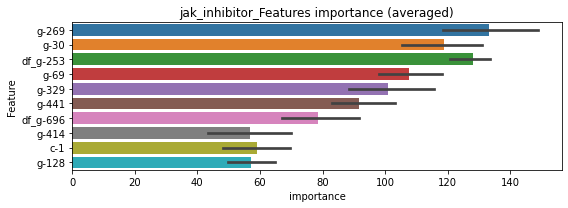

len(train_index) : 3867
len(valid_index) : 3867
================================= fold 1/2 jak_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0217559	valid_1's binary_logloss: 0.0567489
[200]	training's binary_logloss: 0.00375352	valid_1's binary_logloss: 0.0339232
Early stopping, best iteration is:
[279]	training's binary_logloss: 0.00140163	valid_1's binary_logloss: 0.0296046


len(train_index) : 3867
len(valid_index) : 3867
================================= fold 2/2 jak_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.022011	valid_1's binary_logloss: 0.0441904
[200]	training's binary_logloss: 0.00377989	valid_1's binary_logloss: 0.0210113
[300]	training's binary_logloss: 0.00116915	valid_1's binary_logloss: 0.0160627
[400]	training's binary_logloss: 0.000582335	valid_1's binary_logloss: 0.0145506
Early stopping, best iteration is:
[443]	training's binary_logloss: 0.000472524	valid_1's binary_logloss: 0.0141569


jak_inhibitor logloss: 0.021880710968010295
kit_inhibitor, len(trt): 273, len(othr): 3272, target_rate: 0.0114638 → Adj_target_rate: 0.0098841


neg labels: 3289 → selected neg labels: 3272


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0519293	valid_1's binary_logloss: 0.134135
[200]	training's binary_logloss: 0.011446	valid_1's binary_logloss: 0.0970736
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.00597778	valid_1's binary_logloss: 0.0915497
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0528813	valid_1's binary_logloss: 0.13218
[200]	training's binary_logloss: 0.0115974	valid_1's binary_logloss: 0.0929348
[300]	training's binary_logloss: 0.00419398	valid_1's binary_logloss: 0.0832454
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.00435475	valid_1's binary_logloss: 0.0832167


1 / 3 AUC score:0.989
y_Threshold: 0.0348138, Threshold: 0.1702277, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 176 → Positive_corect_labels: 632/3750
p_label_rate: 0.0200904 Vs.target_rate: 0.01146, Num_p_label: 80.0, conf_0:0.15320, conf_1:0.18725
threshold: 0.1702277, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 632.0/3750, y_label_rate: 0.1685333
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0473882	valid_1's binary_logloss: 0.0936516
[200]	training's binary_logloss: 0.011092	valid_1's binary_logloss: 0.051309
[300]	training's binary_logloss: 0.00542695	valid_1's binary_logloss: 0.0375181
[400]	training's binary_logloss: 0.00463062	valid_1's binary_logloss: 0.0339227
Early stopping, best iteration is:
[409]	training's binary_logloss: 0.00454919	valid_1's binary_logloss: 0.0334971
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0454464	valid_1's binary_logloss: 0.111804
[200]	training's binary_logloss: 0.00850284	valid_1's binary_logloss: 0.0728973
Early stopping, best iteration is:
[249]	training's binary_logloss: 0.00435253	valid_1's binary_logloss: 0.0671028


2 / 3 AUC score:0.995
y_Threshold: 0.0976122, Threshold: 0.1702277, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 46 → Positive_corect_labels: 609.0/3704
p_label_rate: 0.0341537 Vs.target_rate: 0.01146, Num_p_label: 136.0, conf_0:0.15320, conf_1:0.18725
threshold: 0.1702277, positive_p_label: 136.0/3982, p_label_rate: 0.0341537
positive_y_label: 609.0/3704, y_label_rate: 0.1644168
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0419148	valid_1's binary_logloss: 0.0891599
[200]	training's binary_logloss: 0.00758291	valid_1's binary_logloss: 0.0469417
[300]	training's binary_logloss: 0.00212054	valid_1's binary_logloss: 0.0360375
[400]	training's binary_logloss: 0.000980031	valid_1's binary_logloss: 0.0340293
Early stopping, best iteration is:
[452]	training's binary_logloss: 0.000725485	valid_1's binary_logloss: 0.0329847
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0406312	valid_1's binary_logloss: 0.102679
[200]	training's binary_logloss: 0.00702296	valid_1's binary_logloss: 0.0711017


3 / 3 AUC score:0.995
y_Threshold: 0.0593680, Threshold: 0.1702277, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[235]	training's binary_logloss: 0.00416697	valid_1's binary_logloss: 0.068886


Remove_noisy_labels: 44 → Positive_corect_labels: 587.0/3660
p_label_rate: 0.0361627 Vs.target_rate: 0.01146, Num_p_label: 144.0, conf_0:0.15320, conf_1:0.18725
Num_p_label: 144.0, Expected: 45.6, Adj_threshold_1: 0.1702277
Num_p_label: 143.0, Expected: 45.6, Adj_threshold_2: 0.1802277
Num_p_label: 139.0, Expected: 45.6, Adj_threshold_3: 0.1902277
Num_p_label: 138.0, Expected: 45.6, Adj_threshold_4: 0.2002277
Num_p_label: 135.0, Expected: 45.6, Adj_threshold_5: 0.2102277
Num_p_label: 131.0, Expected: 45.6, Adj_threshold_6: 0.2202277
Num_p_label: 129.0, Expected: 45.6, Adj_threshold_7: 0.2302277
Num_p_label: 125.0, Expected: 45.6, Adj_threshold_8: 0.2402277
Num_p_label: 123.0, Expected: 45.6, Adj_threshold_9: 0.2502277
Num_p_label: 122.0, Expected: 45.6, Adj_threshold_10: 0.2602277
threshold: 0.2702277, positive_p_label: 118.0/3982, p_label_rate: 0.0296334
positive_y_label: 705.0/7642, y_label_rate: 0.0922533


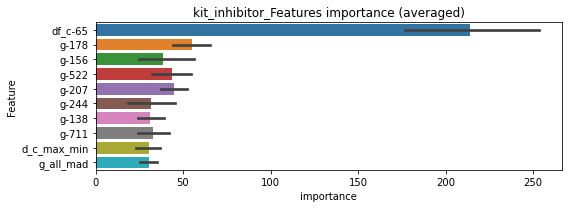

len(train_index) : 3821
len(valid_index) : 3821
================================= fold 1/2 kit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.023928	valid_1's binary_logloss: 0.0570079
[200]	training's binary_logloss: 0.00419994	valid_1's binary_logloss: 0.0328247
[300]	training's binary_logloss: 0.00120742	valid_1's binary_logloss: 0.0268582
Early stopping, best iteration is:
[334]	training's binary_logloss: 0.000905517	valid_1's binary_logloss: 0.0264139


len(train_index) : 3821
len(valid_index) : 3821
================================= fold 2/2 kit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0251576	valid_1's binary_logloss: 0.0550777
[200]	training's binary_logloss: 0.00468599	valid_1's binary_logloss: 0.0290131
[300]	training's binary_logloss: 0.00126711	valid_1's binary_logloss: 0.0217807
[400]	training's binary_logloss: 0.000593792	valid_1's binary_logloss: 0.0192898
[500]	training's binary_logloss: 0.00036473	valid_1's binary_logloss: 0.0175108
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.00036473	valid_1's binary_logloss: 0.0175108


kit_inhibitor logloss: 0.02196233768065382
laxative, len(trt): 6, len(othr): 3288, target_rate: 0.0002520 → Adj_target_rate: 0.0003851


neg labels: 3289 → selected neg labels: 3288


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160586	valid_1's binary_logloss: 0.0183296
[200]	training's binary_logloss: 0.00135983	valid_1's binary_logloss: 0.00282242
[300]	training's binary_logloss: 0.000371643	valid_1's binary_logloss: 0.00135537
[400]	training's binary_logloss: 0.000225362	valid_1's binary_logloss: 0.00105921
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.000209553	valid_1's binary_logloss: 0.00103665
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160703	valid_1's binary_logloss: 0.0170701
[200]	training's binary_logloss: 0.00138284	valid_1's binary_logloss: 0.00159819
[300]	training's binary_logloss: 0.000391868	valid_1's binary_logloss: 0.000491024
[400]	training's binary_logloss: 0.000223333	valid_1's binary_logloss: 0.000293838
[500]	training's binary_logloss: 0.000192131	valid_1's binary_logloss: 0.000255149
Early stopping, best iterati

1 / 3 AUC score:1.000
y_Threshold: 0.0005531, Threshold: 0.0008690, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0200904 Vs.target_rate: 0.00025, Num_p_label: 80.0, conf_0:0.00078, conf_1:0.00096
Num_p_label: 80.0, Expected: 1.0, Adj_threshold_1: 0.0008690
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_2: 0.0108690
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_3: 0.0208690
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_4: 0.0308690
threshold: 0.0308690, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163308	valid_1's binary_logloss: 0.0196806
[200]	training's binary_logloss: 0.00134088	valid_1's binary_logloss: 0.00355819
[300]	training's binary_logloss: 0.000360933	valid_1's binary_logloss: 0.00161837
[400]	training's binary_logloss: 0.000223786	valid_1's binary_logloss: 0.00128748
[500]	training's binary_logloss: 0.00019411	valid_1's binary_logloss: 0.00119284
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.00019411	valid_1's binary_logloss: 0.00119284
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164467	valid_1's binary_logloss: 0.0174677
[200]	training's binary_logloss: 0.00135475	valid_1's binary_logloss: 0.00155372
[300]	training's binary_logloss: 0.000361877	valid_1's binary_logloss: 0.000444621
[400]	training's binary_logloss: 0.000220942	valid_1's binary_logloss: 0.000277492
[500]	training's binary_logloss

2 / 3 AUC score:1.000
y_Threshold: 0.0674150, Threshold: 0.0308690, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0022602 Vs.target_rate: 0.00025, Num_p_label: 9.0, conf_0:0.02778, conf_1:0.03396
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_1: 0.0308690
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_2: 0.0408690
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_3: 0.0508690
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_4: 0.0608690
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_5: 0.0708690
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_6: 0.0808690
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_7: 0.0908690
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_8: 0.1008690
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_9: 0.1108690
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_10: 0.1208690
threshold: 0.1308690, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Ps

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163308	valid_1's binary_logloss: 0.0196806
[200]	training's binary_logloss: 0.00134088	valid_1's binary_logloss: 0.00355819
[300]	training's binary_logloss: 0.000360933	valid_1's binary_logloss: 0.00161837
[400]	training's binary_logloss: 0.000223786	valid_1's binary_logloss: 0.00128748
[500]	training's binary_logloss: 0.00019411	valid_1's binary_logloss: 0.00119284
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.00019411	valid_1's binary_logloss: 0.00119284
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164467	valid_1's binary_logloss: 0.0174677
[200]	training's binary_logloss: 0.00135475	valid_1's binary_logloss: 0.00155372
[300]	training's binary_logloss: 0.000361877	valid_1's binary_logloss: 0.000444621
[400]	training's binary_logloss: 0.000220942	valid_1's binary_logloss: 0.000277492
[500]	training's binary_logloss

3 / 3 AUC score:1.000
y_Threshold: 0.0674150, Threshold: 0.1308690, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0007534 Vs.target_rate: 0.00025, Num_p_label: 3.0, conf_0:0.11778, conf_1:0.14396
threshold: 0.1308690, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 660.0/7795, y_label_rate: 0.0846697


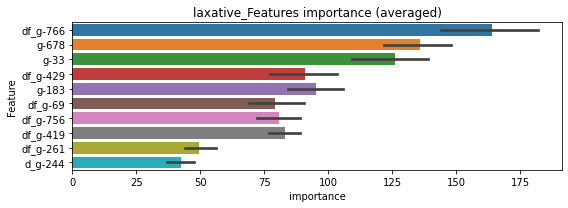

len(train_index) : 3897
len(valid_index) : 3898
================================= fold 1/2 laxative=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00865145	valid_1's binary_logloss: 0.0104961
[200]	training's binary_logloss: 0.000704487	valid_1's binary_logloss: 0.00228201
[300]	training's binary_logloss: 0.000188108	valid_1's binary_logloss: 0.00183856
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.000172541	valid_1's binary_logloss: 0.00181151


len(train_index) : 3898
len(valid_index) : 3897
================================= fold 2/2 laxative=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00875626	valid_1's binary_logloss: 0.0104292
[200]	training's binary_logloss: 0.000725483	valid_1's binary_logloss: 0.00205316
[300]	training's binary_logloss: 0.00019299	valid_1's binary_logloss: 0.00147696
Early stopping, best iteration is:
[363]	training's binary_logloss: 0.000130046	valid_1's binary_logloss: 0.00141269


laxative logloss: 0.0016121249157845059
leukotriene_inhibitor, len(trt): 6, len(othr): 3288, target_rate: 0.0002520 → Adj_target_rate: 0.0003851


neg labels: 3289 → selected neg labels: 3288


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015834	valid_1's binary_logloss: 0.0167303
[200]	training's binary_logloss: 0.00132385	valid_1's binary_logloss: 0.00159491
[300]	training's binary_logloss: 0.000359001	valid_1's binary_logloss: 0.000488329
[400]	training's binary_logloss: 0.000218817	valid_1's binary_logloss: 0.000311467
Early stopping, best iteration is:
[487]	training's binary_logloss: 0.000194187	valid_1's binary_logloss: 0.000281751
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160271	valid_1's binary_logloss: 0.0179917
[200]	training's binary_logloss: 0.00131669	valid_1's binary_logloss: 0.00168614
[300]	training's binary_logloss: 0.000354299	valid_1's binary_logloss: 0.000517523
[400]	training's binary_logloss: 0.000219657	valid_1's binary_logloss: 0.000326189
[500]	training's binary_logloss: 0.000192157	valid_1's binary_logloss: 0.000287312
Early stopping, best itera

1 / 3 AUC score:1.000
y_Threshold: 0.0005039, Threshold: 0.0008513, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0200904 Vs.target_rate: 0.00025, Num_p_label: 80.0, conf_0:0.00077, conf_1:0.00094
Num_p_label: 80.0, Expected: 1.0, Adj_threshold_1: 0.0008513
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_2: 0.0108513
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_3: 0.0208513
threshold: 0.0208513, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160239	valid_1's binary_logloss: 0.0172945
[200]	training's binary_logloss: 0.00130581	valid_1's binary_logloss: 0.00213788
[300]	training's binary_logloss: 0.000347759	valid_1's binary_logloss: 0.00096006
[400]	training's binary_logloss: 0.00021717	valid_1's binary_logloss: 0.000769441
[500]	training's binary_logloss: 0.000187836	valid_1's binary_logloss: 0.000725569
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000187353	valid_1's binary_logloss: 0.00072501
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164384	valid_1's binary_logloss: 0.0182437
[200]	training's binary_logloss: 0.00134526	valid_1's binary_logloss: 0.00158123
[300]	training's binary_logloss: 0.000357373	valid_1's binary_logloss: 0.000436082
[400]	training's binary_logloss: 0.000219615	valid_1's binary_logloss: 0.000279112
[500]	training's binary_logl

2 / 3 AUC score:1.000
y_Threshold: 0.0711419, Threshold: 0.0208513, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0030136 Vs.target_rate: 0.00025, Num_p_label: 12.0, conf_0:0.01877, conf_1:0.02294
Num_p_label: 12.0, Expected: 1.0, Adj_threshold_1: 0.0208513
Num_p_label: 11.0, Expected: 1.0, Adj_threshold_2: 0.0308513
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_3: 0.0408513
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_4: 0.0508513
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_5: 0.0608513
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_6: 0.0708513
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_7: 0.0808513
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_8: 0.0908513
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_9: 0.1008513
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_10: 0.1108513
threshold: 0.1208513, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
=================

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160239	valid_1's binary_logloss: 0.0172945
[200]	training's binary_logloss: 0.00130581	valid_1's binary_logloss: 0.00213788
[300]	training's binary_logloss: 0.000347759	valid_1's binary_logloss: 0.00096006
[400]	training's binary_logloss: 0.00021717	valid_1's binary_logloss: 0.000769441
[500]	training's binary_logloss: 0.000187836	valid_1's binary_logloss: 0.000725569
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000187353	valid_1's binary_logloss: 0.00072501
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164384	valid_1's binary_logloss: 0.0182437
[200]	training's binary_logloss: 0.00134526	valid_1's binary_logloss: 0.00158123
[300]	training's binary_logloss: 0.000357373	valid_1's binary_logloss: 0.000436082
[400]	training's binary_logloss: 0.000219615	valid_1's binary_logloss: 0.000279112
[500]	training's binary_logl

3 / 3 AUC score:1.000
y_Threshold: 0.0711419, Threshold: 0.1208513, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0005023 Vs.target_rate: 0.00025, Num_p_label: 2.0, conf_0:0.10877, conf_1:0.13294
threshold: 0.1208513, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 659.0/7795, y_label_rate: 0.0845414


len(train_index) : 3897
len(valid_index) : 3898
================================= fold 1/2 leukotriene_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00854811	valid_1's binary_logloss: 0.00983359
[200]	training's binary_logloss: 0.000685069	valid_1's binary_logloss: 0.00196026
[300]	training's binary_logloss: 0.000183033	valid_1's binary_logloss: 0.00147097
Early stopping, best iteration is:
[323]	training's binary_logloss: 0.000155486	valid_1's binary_logloss: 0.00144085


len(train_index) : 3898
len(valid_index) : 3897
================================= fold 2/2 leukotriene_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00859581	valid_1's binary_logloss: 0.00989968
[200]	training's binary_logloss: 0.000694299	valid_1's binary_logloss: 0.00147679


leukotriene_inhibitor logloss: 0.0012344595676927403


Early stopping, best iteration is:
[270]	training's binary_logloss: 0.000244484	valid_1's binary_logloss: 0.00102802


leukotriene_receptor_antagonist, len(trt): 62, len(othr): 3280, target_rate: 0.0026035 → Adj_target_rate: 0.0028037


neg labels: 3289 → selected neg labels: 3280


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0461014	valid_1's binary_logloss: 0.0965762
[200]	training's binary_logloss: 0.00883138	valid_1's binary_logloss: 0.0483414
[300]	training's binary_logloss: 0.00262225	valid_1's binary_logloss: 0.0350122
Early stopping, best iteration is:
[357]	training's binary_logloss: 0.00164943	valid_1's binary_logloss: 0.0328552
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.04832	valid_1's binary_logloss: 0.0821095
[200]	training's binary_logloss: 0.0104191	valid_1's binary_logloss: 0.0390628
[300]	training's binary_logloss: 0.00313178	valid_1's binary_logloss: 0.0285451
[400]	training's binary_logloss: 0.00143034	valid_1's binary_logloss: 0.0246647
Early stopping, best iteration is:
[469]	training's binary_logloss: 0.000998408	valid_1's binary_logloss: 0.0236088


1 / 3 AUC score:0.999
y_Threshold: 0.0085996, Threshold: 0.0122635, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 136 → Positive_corect_labels: 654/3800
p_label_rate: 0.0200904 Vs.target_rate: 0.00260, Num_p_label: 80.0, conf_0:0.01104, conf_1:0.01349
Num_p_label: 80.0, Expected: 10.4, Adj_threshold_1: 0.0122635
Num_p_label: 26.0, Expected: 10.4, Adj_threshold_2: 0.0222635
Num_p_label: 14.0, Expected: 10.4, Adj_threshold_3: 0.0322635
threshold: 0.0322635, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 654.0/3800, y_label_rate: 0.1721053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0461145	valid_1's binary_logloss: 0.0862336
[200]	training's binary_logloss: 0.00909493	valid_1's binary_logloss: 0.0375757
[300]	training's binary_logloss: 0.00273875	valid_1's binary_logloss: 0.0242716
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.00173071	valid_1's binary_logloss: 0.0217512
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0449172	valid_1's binary_logloss: 0.086339
[200]	training's binary_logloss: 0.00855819	valid_1's binary_logloss: 0.0388636
[300]	training's binary_logloss: 0.00260843	valid_1's binary_logloss: 0.0275295
[400]	training's binary_logloss: 0.00124996	valid_1's binary_logloss: 0.0242377
[500]	training's binary_logloss: 0.000795124	valid_1's binary_logloss: 0.0230474
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.00076666	valid_1's binary_logloss: 0.0228363


2 / 3 AUC score:1.000
y_Threshold: 0.0456002, Threshold: 0.0322635, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 10 → Positive_corect_labels: 649.0/3790
p_label_rate: 0.0125565 Vs.target_rate: 0.00260, Num_p_label: 50.0, conf_0:0.02904, conf_1:0.03549
Num_p_label: 50.0, Expected: 10.4, Adj_threshold_1: 0.0322635
Num_p_label: 33.0, Expected: 10.4, Adj_threshold_2: 0.0422635
Num_p_label: 24.0, Expected: 10.4, Adj_threshold_3: 0.0522635
Num_p_label: 18.0, Expected: 10.4, Adj_threshold_4: 0.0622635
threshold: 0.0622635, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 649.0/3790, y_label_rate: 0.1712401
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0449741	valid_1's binary_logloss: 0.0890836
[200]	training's binary_logloss: 0.00862278	valid_1's binary_logloss: 0.0412704
[300]	training's binary_logloss: 0.00260817	valid_1's binary_logloss: 0.0301309
Early stopping, best iteration is:
[326]	training's binary_logloss: 0.0020668	valid_1's binary_logloss: 0.0281948
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0442777	valid_1's binary_logloss: 0.089716
[200]	training's binary_logloss: 0.00856518	valid_1's binary_logloss: 0.0419341
[300]	training's binary_logloss: 0.00260369	valid_1's binary_logloss: 0.0312363
[400]	training's binary_logloss: 0.00125304	valid_1's binary_logloss: 0.0272746
Early stopping, best iteration is:
[469]	training's binary_logloss: 0.000896072	valid_1's binary_logloss: 0.0260774


3 / 3 AUC score:1.000
y_Threshold: 0.0369858, Threshold: 0.0622635, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 646.0/3784
p_label_rate: 0.0045203 Vs.target_rate: 0.00260, Num_p_label: 18.0, conf_0:0.05604, conf_1:0.06849
threshold: 0.0622635, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 664.0/7766, y_label_rate: 0.0855009


len(train_index) : 3883
len(valid_index) : 3883
================================= fold 1/2 leukotriene_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0239816	valid_1's binary_logloss: 0.0583941
[200]	training's binary_logloss: 0.00449476	valid_1's binary_logloss: 0.0379396
[300]	training's binary_logloss: 0.00135346	valid_1's binary_logloss: 0.0335898
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.00134095	valid_1's binary_logloss: 0.0335758


len(train_index) : 3883
len(valid_index) : 3883
================================= fold 2/2 leukotriene_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0248222	valid_1's binary_logloss: 0.0517027
[200]	training's binary_logloss: 0.00475503	valid_1's binary_logloss: 0.0263287
[300]	training's binary_logloss: 0.00140991	valid_1's binary_logloss: 0.020392
[400]	training's binary_logloss: 0.000665068	valid_1's binary_logloss: 0.0188788
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000482234	valid_1's binary_logloss: 0.0183216


leukotriene_receptor_antagonist logloss: 0.025948696860157883
lipase_inhibitor, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942


neg labels: 3289 → selected neg labels: 3287


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0195932	valid_1's binary_logloss: 0.0269814
[200]	training's binary_logloss: 0.0021104	valid_1's binary_logloss: 0.00533067
[300]	training's binary_logloss: 0.000593218	valid_1's binary_logloss: 0.00231165
[400]	training's binary_logloss: 0.000325182	valid_1's binary_logloss: 0.00159984
Early stopping, best iteration is:
[471]	training's binary_logloss: 0.000284615	valid_1's binary_logloss: 0.00151533
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0194676	valid_1's binary_logloss: 0.0223421
[200]	training's binary_logloss: 0.00207873	valid_1's binary_logloss: 0.00314115
[300]	training's binary_logloss: 0.000595155	valid_1's binary_logloss: 0.0010781
[400]	training's binary_logloss: 0.000331687	valid_1's binary_logloss: 0.000640761
[500]	training's binary_logloss: 0.00028432	valid_1's binary_logloss: 0.000556663
Early stopping, best iteration i

1 / 3 AUC score:1.000
y_Threshold: 0.0012341, Threshold: 0.0019218, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00050, Num_p_label: 80.0, conf_0:0.00173, conf_1:0.00211
Num_p_label: 80.0, Expected: 2.0, Adj_threshold_1: 0.0019218
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_2: 0.0119218
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_3: 0.0219218
threshold: 0.0219218, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0197373	valid_1's binary_logloss: 0.0246925
[200]	training's binary_logloss: 0.0020126	valid_1's binary_logloss: 0.00344467
[300]	training's binary_logloss: 0.00056407	valid_1's binary_logloss: 0.00129927
[400]	training's binary_logloss: 0.000319894	valid_1's binary_logloss: 0.000835145
Early stopping, best iteration is:
[472]	training's binary_logloss: 0.000277725	valid_1's binary_logloss: 0.000770132
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0195295	valid_1's binary_logloss: 0.0217646
[200]	training's binary_logloss: 0.00200041	valid_1's binary_logloss: 0.0025027
[300]	training's binary_logloss: 0.000572614	valid_1's binary_logloss: 0.000771145
[400]	training's binary_logloss: 0.000321509	valid_1's binary_logloss: 0.000447995
[500]	training's binary_logloss: 0.000282414	valid_1's binary_logloss: 0.000395117
Early stopping, best iteratio

2 / 3 AUC score:1.000
y_Threshold: 0.1372327, Threshold: 0.0219218, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0032647 Vs.target_rate: 0.00050, Num_p_label: 13.0, conf_0:0.01973, conf_1:0.02411
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_1: 0.0219218
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_2: 0.0319218
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_3: 0.0419218
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_4: 0.0519218
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_5: 0.0619218
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_6: 0.0719218
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_7: 0.0819218
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_8: 0.0919218
threshold: 0.0919218, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0197373	valid_1's binary_logloss: 0.0246925
[200]	training's binary_logloss: 0.0020126	valid_1's binary_logloss: 0.00344467
[300]	training's binary_logloss: 0.00056407	valid_1's binary_logloss: 0.00129927
[400]	training's binary_logloss: 0.000319894	valid_1's binary_logloss: 0.000835145
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000277725	valid_1's binary_logloss: 0.000770132
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0195295	valid_1's binary_logloss: 0.0217646
[200]	training's binary_logloss: 0.00200041	valid_1's binary_logloss: 0.0025027
[300]	training's binary_logloss: 0.000572614	valid_1's binary_logloss: 0.000771145
[400]	training's binary_logloss: 0.000321509	valid_1's binary_logloss: 0.000447995
[500]	training's binary_logloss: 0.000282414	valid_1's binary_logloss: 0.000395117
Early stopping, best iteratio

3 / 3 AUC score:1.000
y_Threshold: 0.1372327, Threshold: 0.0919218, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0007534 Vs.target_rate: 0.00050, Num_p_label: 3.0, conf_0:0.08273, conf_1:0.10111
threshold: 0.0919218, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 660.0/7794, y_label_rate: 0.0846805


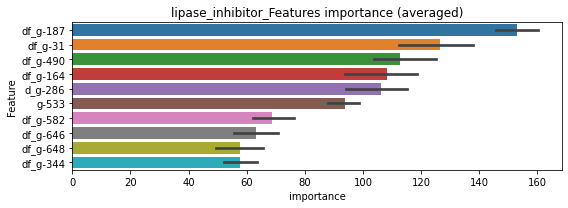

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0102684	valid_1's binary_logloss: 0.0132448
[200]	training's binary_logloss: 0.00103656	valid_1's binary_logloss: 0.00298624
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.000386744	valid_1's binary_logloss: 0.00230302


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0106224	valid_1's binary_logloss: 0.0142382
[200]	training's binary_logloss: 0.00107676	valid_1's binary_logloss: 0.00265139
[300]	training's binary_logloss: 0.000294383	valid_1's binary_logloss: 0.00149076
[400]	training's binary_logloss: 0.000163714	valid_1's binary_logloss: 0.00125814
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.000151723	valid_1's binary_logloss: 0.00124865


lipase_inhibitor logloss: 0.001775838438390341
lipoxygenase_inhibitor, len(trt): 61, len(othr): 3278, target_rate: 0.0025615 → Adj_target_rate: 0.0027652


neg labels: 3289 → selected neg labels: 3278


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0487625	valid_1's binary_logloss: 0.0938721
[200]	training's binary_logloss: 0.0104332	valid_1's binary_logloss: 0.0455124
[300]	training's binary_logloss: 0.00309484	valid_1's binary_logloss: 0.031032
[400]	training's binary_logloss: 0.00141996	valid_1's binary_logloss: 0.0269815
[500]	training's binary_logloss: 0.000876953	valid_1's binary_logloss: 0.025095
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.000844265	valid_1's binary_logloss: 0.0249534
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0532181	valid_1's binary_logloss: 0.0932747
[200]	training's binary_logloss: 0.0113016	valid_1's binary_logloss: 0.0405854
[300]	training's binary_logloss: 0.0033339	valid_1's binary_logloss: 0.0253768
[400]	training's binary_logloss: 0.0014817	valid_1's binary_logloss: 0.0200199
[500]	training's binary_logloss: 0.000897519	vali

1 / 3 AUC score:1.000
y_Threshold: 0.0059944, Threshold: 0.0125322, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 655/3801
p_label_rate: 0.0200904 Vs.target_rate: 0.00256, Num_p_label: 80.0, conf_0:0.01128, conf_1:0.01379
Num_p_label: 80.0, Expected: 10.2, Adj_threshold_1: 0.0125322
Num_p_label: 36.0, Expected: 10.2, Adj_threshold_2: 0.0225322
Num_p_label: 23.0, Expected: 10.2, Adj_threshold_3: 0.0325322
Num_p_label: 18.0, Expected: 10.2, Adj_threshold_4: 0.0425322
threshold: 0.0425322, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 655.0/3801, y_label_rate: 0.1723231
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0500232	valid_1's binary_logloss: 0.0976326
[200]	training's binary_logloss: 0.0101187	valid_1's binary_logloss: 0.0450609
[300]	training's binary_logloss: 0.00300927	valid_1's binary_logloss: 0.0305481
[400]	training's binary_logloss: 0.00140447	valid_1's binary_logloss: 0.0260502
[500]	training's binary_logloss: 0.000872702	valid_1's binary_logloss: 0.0239125
Early stopping, best iteration is:
[509]	training's binary_logloss: 0.00084365	valid_1's binary_logloss: 0.0238148
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0529406	valid_1's binary_logloss: 0.0948903
[200]	training's binary_logloss: 0.0106011	valid_1's binary_logloss: 0.0410699
[300]	training's binary_logloss: 0.00307086	valid_1's binary_logloss: 0.0258961
[400]	training's binary_logloss: 0.0014283	valid_1's binary_logloss: 0.0209722
[500]	training's binary_logloss: 0.000889872	va

2 / 3 AUC score:1.000
y_Threshold: 0.0401511, Threshold: 0.0425322, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 651.0/3793
p_label_rate: 0.0158212 Vs.target_rate: 0.00256, Num_p_label: 63.0, conf_0:0.03828, conf_1:0.04679
Num_p_label: 63.0, Expected: 10.2, Adj_threshold_1: 0.0425322
Num_p_label: 44.0, Expected: 10.2, Adj_threshold_2: 0.0525322
Num_p_label: 39.0, Expected: 10.2, Adj_threshold_3: 0.0625322
Num_p_label: 35.0, Expected: 10.2, Adj_threshold_4: 0.0725322
Num_p_label: 27.0, Expected: 10.2, Adj_threshold_5: 0.0825322
Num_p_label: 21.0, Expected: 10.2, Adj_threshold_6: 0.0925322
Num_p_label: 21.0, Expected: 10.2, Adj_threshold_7: 0.1025322
Num_p_label: 15.0, Expected: 10.2, Adj_threshold_8: 0.1125322
threshold: 0.1125322, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 651.0/3793, y_label_rate: 0.1716320
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.049884	valid_1's binary_logloss: 0.0901111
[200]	training's binary_logloss: 0.0102256	valid_1's binary_logloss: 0.0371592
[300]	training's binary_logloss: 0.00303415	valid_1's binary_logloss: 0.0222581
[400]	training's binary_logloss: 0.00138779	valid_1's binary_logloss: 0.0177661
[500]	training's binary_logloss: 0.00086359	valid_1's binary_logloss: 0.0159065
Early stopping, best iteration is:
[569]	training's binary_logloss: 0.000693115	valid_1's binary_logloss: 0.0150559
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0520543	valid_1's binary_logloss: 0.0908565
[200]	training's binary_logloss: 0.0110994	valid_1's binary_logloss: 0.0395687
[300]	training's binary_logloss: 0.00318826	valid_1's binary_logloss: 0.0263334
[400]	training's binary_logloss: 0.00144715	valid_1's binary_logloss: 0.0221839
Early stopping, best iteration is:
[423]	traini

3 / 3 AUC score:1.000
y_Threshold: 0.0355415, Threshold: 0.1125322, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 647.0/3785
p_label_rate: 0.0062783 Vs.target_rate: 0.00256, Num_p_label: 25.0, conf_0:0.10128, conf_1:0.12379
threshold: 0.1125322, positive_p_label: 25.0/3982, p_label_rate: 0.0062783
positive_y_label: 672.0/7767, y_label_rate: 0.0865199


len(train_index) : 3883
len(valid_index) : 3884
================================= fold 1/2 lipoxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0274683	valid_1's binary_logloss: 0.0636576
[200]	training's binary_logloss: 0.00567504	valid_1's binary_logloss: 0.0390878
[300]	training's binary_logloss: 0.00165904	valid_1's binary_logloss: 0.0337563
Early stopping, best iteration is:
[319]	training's binary_logloss: 0.00138118	valid_1's binary_logloss: 0.033083


len(train_index) : 3884
len(valid_index) : 3883
================================= fold 2/2 lipoxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0299188	valid_1's binary_logloss: 0.0582751
[200]	training's binary_logloss: 0.00640061	valid_1's binary_logloss: 0.0311881
[300]	training's binary_logloss: 0.00188358	valid_1's binary_logloss: 0.0231744
[400]	training's binary_logloss: 0.000824854	valid_1's binary_logloss: 0.0200982
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.0007957	valid_1's binary_logloss: 0.0199241


lipoxygenase_inhibitor logloss: 0.026504368446404455
lxr_agonist, len(trt): 6, len(othr): 3288, target_rate: 0.0002520 → Adj_target_rate: 0.0003851


neg labels: 3289 → selected neg labels: 3288


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0151811	valid_1's binary_logloss: 0.016637
[200]	training's binary_logloss: 0.00118396	valid_1's binary_logloss: 0.00176282
[300]	training's binary_logloss: 0.000303105	valid_1's binary_logloss: 0.000711425
Early stopping, best iteration is:
[388]	training's binary_logloss: 0.000196362	valid_1's binary_logloss: 0.000588946
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155515	valid_1's binary_logloss: 0.0161232
[200]	training's binary_logloss: 0.00122831	valid_1's binary_logloss: 0.00133866
[300]	training's binary_logloss: 0.000313055	valid_1's binary_logloss: 0.000365189
[400]	training's binary_logloss: 0.000195563	valid_1's binary_logloss: 0.000237592
[500]	training's binary_logloss: 0.000175756	valid_1's binary_logloss: 0.000215697
[600]	training's binary_logloss: 0.000170576	valid_1's binary_logloss: 0.000209691
[700]	training's binary_lo

1 / 3 AUC score:1.000
y_Threshold: 0.0005543, Threshold: 0.0016338, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0200904 Vs.target_rate: 0.00025, Num_p_label: 80.0, conf_0:0.00147, conf_1:0.00180
Num_p_label: 80.0, Expected: 1.0, Adj_threshold_1: 0.0016338
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_2: 0.0116338
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_3: 0.0216338
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_4: 0.0316338
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_5: 0.0416338
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_6: 0.0516338
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_7: 0.0616338
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_8: 0.0716338
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_9: 0.0816338
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_10: 0.0916338
threshold: 0.1016338, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
=================

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159275	valid_1's binary_logloss: 0.0169165
[200]	training's binary_logloss: 0.00123101	valid_1's binary_logloss: 0.00206814
[300]	training's binary_logloss: 0.000303073	valid_1's binary_logloss: 0.001016
[400]	training's binary_logloss: 0.000187874	valid_1's binary_logloss: 0.000841191
[500]	training's binary_logloss: 0.000168397	valid_1's binary_logloss: 0.000810078
[600]	training's binary_logloss: 0.000162229	valid_1's binary_logloss: 0.000803263
[700]	training's binary_logloss: 0.000159106	valid_1's binary_logloss: 0.000799797
[800]	training's binary_logloss: 0.000157585	valid_1's binary_logloss: 0.00079811
Early stopping, best iteration is:
[805]	training's binary_logloss: 0.000157517	valid_1's binary_logloss: 0.000798034
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159989	valid_1's binary_logloss: 0.0165616
[200]	training's binary_log

2 / 3 AUC score:1.000
y_Threshold: 0.0586626, Threshold: 0.1016338, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0020090 Vs.target_rate: 0.00025, Num_p_label: 8.0, conf_0:0.09147, conf_1:0.11180
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_1: 0.1016338
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_2: 0.1116338
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_3: 0.1216338
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_4: 0.1316338
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_5: 0.1416338
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_6: 0.1516338
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_7: 0.1616338
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_8: 0.1716338
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_9: 0.1816338
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_10: 0.1916338
threshold: 0.2016338, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Ps

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159275	valid_1's binary_logloss: 0.0169165
[200]	training's binary_logloss: 0.00123101	valid_1's binary_logloss: 0.00206814
[300]	training's binary_logloss: 0.000303073	valid_1's binary_logloss: 0.001016
[400]	training's binary_logloss: 0.000187874	valid_1's binary_logloss: 0.000841191
[500]	training's binary_logloss: 0.000168397	valid_1's binary_logloss: 0.000810078
[600]	training's binary_logloss: 0.000162229	valid_1's binary_logloss: 0.000803263
Early stopping, best iteration is:
[627]	training's binary_logloss: 0.000160836	valid_1's binary_logloss: 0.00080171
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159989	valid_1's binary_logloss: 0.0165616
[200]	training's binary_logloss: 0.00123069	valid_1's binary_logloss: 0.00133493
[300]	training's binary_logloss: 0.000302665	valid_1's binary_logloss: 0.00034368
[400]	training's binary_loglos

3 / 3 AUC score:1.000
y_Threshold: 0.0586626, Threshold: 0.2016338, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0012557 Vs.target_rate: 0.00025, Num_p_label: 5.0, conf_0:0.18147, conf_1:0.22180
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_1: 0.2016338
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_2: 0.2116338
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_3: 0.2216338
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_4: 0.2316338
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_5: 0.2416338
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_6: 0.2516338
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_7: 0.2616338
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_8: 0.2716338
threshold: 0.2716338, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 659.0/7795, y_label_rate: 0.0845414


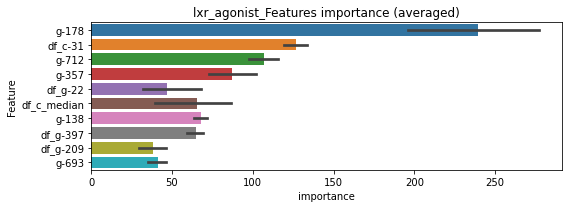

len(train_index) : 3897
len(valid_index) : 3898
================================= fold 1/2 lxr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00836711	valid_1's binary_logloss: 0.00903676
[200]	training's binary_logloss: 0.000647252	valid_1's binary_logloss: 0.00114765
[300]	training's binary_logloss: 0.000157996	valid_1's binary_logloss: 0.000563528
[400]	training's binary_logloss: 0.000101508	valid_1's binary_logloss: 0.000490455
Early stopping, best iteration is:
[465]	training's binary_logloss: 9.23204e-05	valid_1's binary_logloss: 0.000475447


len(train_index) : 3898
len(valid_index) : 3897
================================= fold 2/2 lxr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00848758	valid_1's binary_logloss: 0.00975256
[200]	training's binary_logloss: 0.000654893	valid_1's binary_logloss: 0.00208256
[300]	training's binary_logloss: 0.000165041	valid_1's binary_logloss: 0.00130278
[400]	training's binary_logloss: 0.000104608	valid_1's binary_logloss: 0.00114886
Early stopping, best iteration is:
[440]	training's binary_logloss: 9.70194e-05	valid_1's binary_logloss: 0.00113107


lxr_agonist logloss: 0.000803214494808453
mdm_inhibitor, len(trt): 31, len(othr): 3284, target_rate: 0.0013018 → Adj_target_rate: 0.0015554


neg labels: 3289 → selected neg labels: 3284


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.024084	valid_1's binary_logloss: 0.037798
[200]	training's binary_logloss: 0.00307352	valid_1's binary_logloss: 0.0106073
[300]	training's binary_logloss: 0.000890721	valid_1's binary_logloss: 0.00580492
[400]	training's binary_logloss: 0.000468898	valid_1's binary_logloss: 0.00411825
[500]	training's binary_logloss: 0.000351478	valid_1's binary_logloss: 0.00365841
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.000346481	valid_1's binary_logloss: 0.00363755
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0246935	valid_1's binary_logloss: 0.0360749
[200]	training's binary_logloss: 0.00315386	valid_1's binary_logloss: 0.00846255
[300]	training's binary_logloss: 0.000898303	valid_1's binary_logloss: 0.00409161
[400]	training's binary_logloss: 0.000469705	valid_1's binary_logloss: 0.00293486
[500]	training's binary_logloss: 0

1 / 3 AUC score:1.000
y_Threshold: 0.0037071, Threshold: 0.0090559, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00130, Num_p_label: 80.0, conf_0:0.00815, conf_1:0.00996
Num_p_label: 80.0, Expected: 5.2, Adj_threshold_1: 0.0090559
Num_p_label: 47.0, Expected: 5.2, Adj_threshold_2: 0.0190559
Num_p_label: 37.0, Expected: 5.2, Adj_threshold_3: 0.0290559
Num_p_label: 28.0, Expected: 5.2, Adj_threshold_4: 0.0390559
Num_p_label: 21.0, Expected: 5.2, Adj_threshold_5: 0.0490559
Num_p_label: 18.0, Expected: 5.2, Adj_threshold_6: 0.0590559
Num_p_label: 15.0, Expected: 5.2, Adj_threshold_7: 0.0690559
Num_p_label: 13.0, Expected: 5.2, Adj_threshold_8: 0.0790559
Num_p_label: 12.0, Expected: 5.2, Adj_threshold_9: 0.0890559
Num_p_label: 12.0, Expected: 5.2, Adj_threshold_10: 0.0990559
threshold: 0.1090559, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0226224	valid_1's binary_logloss: 0.0304473
[200]	training's binary_logloss: 0.00262144	valid_1's binary_logloss: 0.00583368
[300]	training's binary_logloss: 0.000739275	valid_1's binary_logloss: 0.00254658
[400]	training's binary_logloss: 0.000398754	valid_1's binary_logloss: 0.00167322
[500]	training's binary_logloss: 0.000318179	valid_1's binary_logloss: 0.00147493
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.000314773	valid_1's binary_logloss: 0.00146465
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0228987	valid_1's binary_logloss: 0.0321434
[200]	training's binary_logloss: 0.00267988	valid_1's binary_logloss: 0.00665802
[300]	training's binary_logloss: 0.000738537	valid_1's binary_logloss: 0.00317179
[400]	training's binary_logloss: 0.00040093	valid_1's binary_logloss: 0.00224893
[500]	training's binary_logloss:

2 / 3 AUC score:1.000
y_Threshold: 0.5339102, Threshold: 0.1090559, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00130, Num_p_label: 80.0, conf_0:0.09815, conf_1:0.11996
Num_p_label: 80.0, Expected: 5.2, Adj_threshold_1: 0.1090559
Num_p_label: 79.0, Expected: 5.2, Adj_threshold_2: 0.1190559
Num_p_label: 75.0, Expected: 5.2, Adj_threshold_3: 0.1290559
Num_p_label: 73.0, Expected: 5.2, Adj_threshold_4: 0.1390559
Num_p_label: 72.0, Expected: 5.2, Adj_threshold_5: 0.1490559
Num_p_label: 70.0, Expected: 5.2, Adj_threshold_6: 0.1590559
Num_p_label: 68.0, Expected: 5.2, Adj_threshold_7: 0.1690559
Num_p_label: 65.0, Expected: 5.2, Adj_threshold_8: 0.1790559
Num_p_label: 63.0, Expected: 5.2, Adj_threshold_9: 0.1890559
Num_p_label: 57.0, Expected: 5.2, Adj_threshold_10: 0.1990559
threshold: 0.2090559, positive_p_label: 54.0/3982, p_label_rate: 0.0135610
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0226224	valid_1's binary_logloss: 0.0304473
[200]	training's binary_logloss: 0.00262144	valid_1's binary_logloss: 0.00583368
[300]	training's binary_logloss: 0.000739275	valid_1's binary_logloss: 0.00254658
[400]	training's binary_logloss: 0.000398754	valid_1's binary_logloss: 0.00167322
[500]	training's binary_logloss: 0.000318179	valid_1's binary_logloss: 0.00147493
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.000314773	valid_1's binary_logloss: 0.00146465
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0228987	valid_1's binary_logloss: 0.0321434
[200]	training's binary_logloss: 0.00267988	valid_1's binary_logloss: 0.00665802
[300]	training's binary_logloss: 0.000738537	valid_1's binary_logloss: 0.00317179
[400]	training's binary_logloss: 0.00040093	valid_1's binary_logloss: 0.00224893
[500]	training's binary_logloss:

3 / 3 AUC score:1.000
y_Threshold: 0.5339102, Threshold: 0.2090559, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0135610 Vs.target_rate: 0.00130, Num_p_label: 54.0, conf_0:0.18815, conf_1:0.22996
Num_p_label: 54.0, Expected: 5.2, Adj_threshold_1: 0.2090559
Num_p_label: 54.0, Expected: 5.2, Adj_threshold_2: 0.2190559
Num_p_label: 52.0, Expected: 5.2, Adj_threshold_3: 0.2290559
Num_p_label: 50.0, Expected: 5.2, Adj_threshold_4: 0.2390559
Num_p_label: 47.0, Expected: 5.2, Adj_threshold_5: 0.2490559
Num_p_label: 46.0, Expected: 5.2, Adj_threshold_6: 0.2590559
Num_p_label: 45.0, Expected: 5.2, Adj_threshold_7: 0.2690559
Num_p_label: 44.0, Expected: 5.2, Adj_threshold_8: 0.2790559
Num_p_label: 44.0, Expected: 5.2, Adj_threshold_9: 0.2890559
Num_p_label: 43.0, Expected: 5.2, Adj_threshold_10: 0.2990559
threshold: 0.3090559, positive_p_label: 43.0/3982, p_label_rate: 0.0107986
positive_y_label: 699.0/7790, y_label_rate: 0.0897304


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 mdm_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0139204	valid_1's binary_logloss: 0.0233926
[200]	training's binary_logloss: 0.0017696	valid_1's binary_logloss: 0.00900533
[300]	training's binary_logloss: 0.000500036	valid_1's binary_logloss: 0.00695435
Early stopping, best iteration is:
[367]	training's binary_logloss: 0.000308778	valid_1's binary_logloss: 0.00674375


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 mdm_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0137929	valid_1's binary_logloss: 0.0245528
[200]	training's binary_logloss: 0.00177168	valid_1's binary_logloss: 0.0105386
[300]	training's binary_logloss: 0.000517728	valid_1's binary_logloss: 0.00850297
Early stopping, best iteration is:
[378]	training's binary_logloss: 0.000298931	valid_1's binary_logloss: 0.00801523


mdm_inhibitor logloss: 0.007379487597076632
mek_inhibitor, len(trt): 72, len(othr): 3278, target_rate: 0.0030234 → Adj_target_rate: 0.0031837


neg labels: 3289 → selected neg labels: 3278


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0297989	valid_1's binary_logloss: 0.0545066
[200]	training's binary_logloss: 0.00416592	valid_1's binary_logloss: 0.0250515
[300]	training's binary_logloss: 0.00119441	valid_1's binary_logloss: 0.0204031
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.000829708	valid_1's binary_logloss: 0.0196504
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0308135	valid_1's binary_logloss: 0.0569462
[200]	training's binary_logloss: 0.00437101	valid_1's binary_logloss: 0.0215388
[300]	training's binary_logloss: 0.00124202	valid_1's binary_logloss: 0.0145721
[400]	training's binary_logloss: 0.000617116	valid_1's binary_logloss: 0.0122852
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.000527134	valid_1's binary_logloss: 0.0119145


1 / 3 AUC score:1.000
y_Threshold: 0.0038951, Threshold: 0.0100831, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 654/3799
p_label_rate: 0.0200904 Vs.target_rate: 0.00302, Num_p_label: 80.0, conf_0:0.00907, conf_1:0.01109
Num_p_label: 80.0, Expected: 12.0, Adj_threshold_1: 0.0100831
Num_p_label: 52.0, Expected: 12.0, Adj_threshold_2: 0.0200831
Num_p_label: 42.0, Expected: 12.0, Adj_threshold_3: 0.0300831
Num_p_label: 33.0, Expected: 12.0, Adj_threshold_4: 0.0400831
Num_p_label: 32.0, Expected: 12.0, Adj_threshold_5: 0.0500831
Num_p_label: 30.0, Expected: 12.0, Adj_threshold_6: 0.0600831
Num_p_label: 29.0, Expected: 12.0, Adj_threshold_7: 0.0700831
Num_p_label: 27.0, Expected: 12.0, Adj_threshold_8: 0.0800831
Num_p_label: 26.0, Expected: 12.0, Adj_threshold_9: 0.0900831
Num_p_label: 26.0, Expected: 12.0, Adj_threshold_10: 0.1000831
threshold: 0.1100831, positive_p_label: 26.0/3982, p_label_rate: 0.0065294
positive_y_label: 654.0/3799, y_label_rate: 0.172150

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0293875	valid_1's binary_logloss: 0.0447293
[200]	training's binary_logloss: 0.00387786	valid_1's binary_logloss: 0.0129158
[300]	training's binary_logloss: 0.00109379	valid_1's binary_logloss: 0.00739675
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.000595074	valid_1's binary_logloss: 0.00631819
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0292018	valid_1's binary_logloss: 0.0568259
[200]	training's binary_logloss: 0.00381095	valid_1's binary_logloss: 0.0233998
[300]	training's binary_logloss: 0.00107827	valid_1's binary_logloss: 0.0178376
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.000831453	valid_1's binary_logloss: 0.0169379


2 / 3 AUC score:1.000
y_Threshold: 0.0401154, Threshold: 0.1100831, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 652.0/3795
p_label_rate: 0.0125565 Vs.target_rate: 0.00302, Num_p_label: 50.0, conf_0:0.09907, conf_1:0.12109
Num_p_label: 50.0, Expected: 12.0, Adj_threshold_1: 0.1100831
Num_p_label: 49.0, Expected: 12.0, Adj_threshold_2: 0.1200831
Num_p_label: 48.0, Expected: 12.0, Adj_threshold_3: 0.1300831
Num_p_label: 47.0, Expected: 12.0, Adj_threshold_4: 0.1400831
Num_p_label: 47.0, Expected: 12.0, Adj_threshold_5: 0.1500831
Num_p_label: 46.0, Expected: 12.0, Adj_threshold_6: 0.1600831
Num_p_label: 45.0, Expected: 12.0, Adj_threshold_7: 0.1700831
Num_p_label: 44.0, Expected: 12.0, Adj_threshold_8: 0.1800831
Num_p_label: 42.0, Expected: 12.0, Adj_threshold_9: 0.1900831
Num_p_label: 42.0, Expected: 12.0, Adj_threshold_10: 0.2000831
threshold: 0.2100831, positive_p_label: 42.0/3982, p_label_rate: 0.0105475
positive_y_label: 652.0/3795, y_label_rate: 0.171805

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0295823	valid_1's binary_logloss: 0.0442209
[200]	training's binary_logloss: 0.00381238	valid_1's binary_logloss: 0.0130758
[300]	training's binary_logloss: 0.0010703	valid_1's binary_logloss: 0.0076817
[400]	training's binary_logloss: 0.000544321	valid_1's binary_logloss: 0.0062966
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000415229	valid_1's binary_logloss: 0.00587256
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0283448	valid_1's binary_logloss: 0.0613447
[200]	training's binary_logloss: 0.00366369	valid_1's binary_logloss: 0.0282166
[300]	training's binary_logloss: 0.00101567	valid_1's binary_logloss: 0.0205538
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.000881433	valid_1's binary_logloss: 0.0199573


3 / 3 AUC score:1.000
y_Threshold: 0.0432940, Threshold: 0.2100831, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 650.0/3791
p_label_rate: 0.0102963 Vs.target_rate: 0.00302, Num_p_label: 41.0, conf_0:0.18907, conf_1:0.23109
Num_p_label: 41.0, Expected: 12.0, Adj_threshold_1: 0.2100831
Num_p_label: 41.0, Expected: 12.0, Adj_threshold_2: 0.2200831
Num_p_label: 40.0, Expected: 12.0, Adj_threshold_3: 0.2300831
Num_p_label: 39.0, Expected: 12.0, Adj_threshold_4: 0.2400831
Num_p_label: 38.0, Expected: 12.0, Adj_threshold_5: 0.2500831
Num_p_label: 38.0, Expected: 12.0, Adj_threshold_6: 0.2600831
Num_p_label: 38.0, Expected: 12.0, Adj_threshold_7: 0.2700831
Num_p_label: 36.0, Expected: 12.0, Adj_threshold_8: 0.2800831
Num_p_label: 36.0, Expected: 12.0, Adj_threshold_9: 0.2900831
Num_p_label: 36.0, Expected: 12.0, Adj_threshold_10: 0.3000831
threshold: 0.3100831, positive_p_label: 36.0/3982, p_label_rate: 0.0090407
positive_y_label: 686.0/7773, y_label_rate: 0.088254

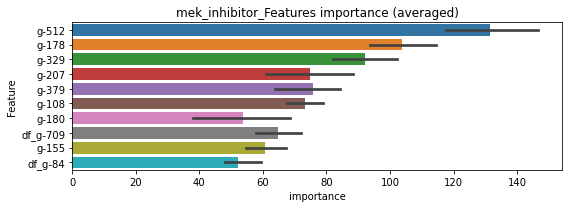

len(train_index) : 3886
len(valid_index) : 3887
================================= fold 1/2 mek_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0156139	valid_1's binary_logloss: 0.0267146
[200]	training's binary_logloss: 0.00202758	valid_1's binary_logloss: 0.00943529
[300]	training's binary_logloss: 0.000562464	valid_1's binary_logloss: 0.00639865
[400]	training's binary_logloss: 0.000278404	valid_1's binary_logloss: 0.00561272
[500]	training's binary_logloss: 0.000197129	valid_1's binary_logloss: 0.00524548
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.000200537	valid_1's binary_logloss: 0.00523075


len(train_index) : 3887
len(valid_index) : 3886
================================= fold 2/2 mek_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0148551	valid_1's binary_logloss: 0.0277487
[200]	training's binary_logloss: 0.00190885	valid_1's binary_logloss: 0.0101125
[300]	training's binary_logloss: 0.000550781	valid_1's binary_logloss: 0.00648727
[400]	training's binary_logloss: 0.000285118	valid_1's binary_logloss: 0.00536793
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00027852	valid_1's binary_logloss: 0.00532196


mek_inhibitor logloss: 0.005276352013658807
membrane_integrity_inhibitor, len(trt): 74, len(othr): 3278, target_rate: 0.0031074 → Adj_target_rate: 0.0032587


neg labels: 3289 → selected neg labels: 3278


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0579972	valid_1's binary_logloss: 0.109034
[200]	training's binary_logloss: 0.0128677	valid_1's binary_logloss: 0.0600821
[300]	training's binary_logloss: 0.00380149	valid_1's binary_logloss: 0.0479117
Early stopping, best iteration is:
[382]	training's binary_logloss: 0.00192506	valid_1's binary_logloss: 0.0453848
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0570407	valid_1's binary_logloss: 0.103181
[200]	training's binary_logloss: 0.0127437	valid_1's binary_logloss: 0.0493701
[300]	training's binary_logloss: 0.00377383	valid_1's binary_logloss: 0.0345055
[400]	training's binary_logloss: 0.00167454	valid_1's binary_logloss: 0.0297219
[500]	training's binary_logloss: 0.00101803	valid_1's binary_logloss: 0.0281517
Early stopping, best iteration is:
[501]	training's binary_logloss: 0.00101399	valid_1's binary_logloss: 0.0281121


1 / 3 AUC score:0.998
y_Threshold: 0.0141244, Threshold: 0.0213067, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 146 → Positive_corect_labels: 648/3787
p_label_rate: 0.0200904 Vs.target_rate: 0.00311, Num_p_label: 80.0, conf_0:0.01918, conf_1:0.02344
Num_p_label: 80.0, Expected: 12.4, Adj_threshold_1: 0.0213067
Num_p_label: 34.0, Expected: 12.4, Adj_threshold_2: 0.0313067
Num_p_label: 19.0, Expected: 12.4, Adj_threshold_3: 0.0413067
threshold: 0.0413067, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 648.0/3787, y_label_rate: 0.1711117
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0558182	valid_1's binary_logloss: 0.101657
[200]	training's binary_logloss: 0.0114575	valid_1's binary_logloss: 0.0479558
[300]	training's binary_logloss: 0.0035177	valid_1's binary_logloss: 0.0339652
[400]	training's binary_logloss: 0.00171679	valid_1's binary_logloss: 0.0297435
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00125839	valid_1's binary_logloss: 0.0282474
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.057236	valid_1's binary_logloss: 0.0996746
[200]	training's binary_logloss: 0.0123706	valid_1's binary_logloss: 0.0467069
[300]	training's binary_logloss: 0.0036985	valid_1's binary_logloss: 0.0319433
[400]	training's binary_logloss: 0.00168164	valid_1's binary_logloss: 0.0290069
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.0015722	valid_1's binary_logloss: 0.0287964


2 / 3 AUC score:1.000
y_Threshold: 0.0434265, Threshold: 0.0413067, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 14 → Positive_corect_labels: 641.0/3773
p_label_rate: 0.0158212 Vs.target_rate: 0.00311, Num_p_label: 63.0, conf_0:0.03718, conf_1:0.04544
Num_p_label: 63.0, Expected: 12.4, Adj_threshold_1: 0.0413067
Num_p_label: 42.0, Expected: 12.4, Adj_threshold_2: 0.0513067
Num_p_label: 29.0, Expected: 12.4, Adj_threshold_3: 0.0613067
Num_p_label: 23.0, Expected: 12.4, Adj_threshold_4: 0.0713067
threshold: 0.0713067, positive_p_label: 23.0/3982, p_label_rate: 0.0057760
positive_y_label: 641.0/3773, y_label_rate: 0.1698913
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0550108	valid_1's binary_logloss: 0.0995882
[200]	training's binary_logloss: 0.0119481	valid_1's binary_logloss: 0.04677
[300]	training's binary_logloss: 0.00351448	valid_1's binary_logloss: 0.0313888
[400]	training's binary_logloss: 0.00158603	valid_1's binary_logloss: 0.0263584
[500]	training's binary_logloss: 0.00097591	valid_1's binary_logloss: 0.024597
Early stopping, best iteration is:
[567]	training's binary_logloss: 0.000771795	valid_1's binary_logloss: 0.0235766
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0565393	valid_1's binary_logloss: 0.109042
[200]	training's binary_logloss: 0.0117883	valid_1's binary_logloss: 0.0565412
[300]	training's binary_logloss: 0.00349169	valid_1's binary_logloss: 0.0436016
[400]	training's binary_logloss: 0.00160045	valid_1's binary_logloss: 0.0405124
[500]	training's binary_logloss: 0.000973016	valid

3 / 3 AUC score:0.999
y_Threshold: 0.0349412, Threshold: 0.0713067, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 16 → Positive_corect_labels: 633.0/3757
p_label_rate: 0.0035158 Vs.target_rate: 0.00311, Num_p_label: 14.0, conf_0:0.06418, conf_1:0.07844
threshold: 0.0713067, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 647.0/7739, y_label_rate: 0.0836025


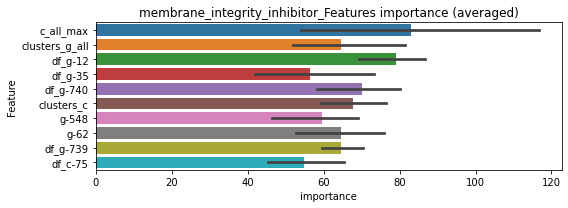

len(train_index) : 3869
len(valid_index) : 3870
================================= fold 1/2 membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0308376	valid_1's binary_logloss: 0.0693788
[200]	training's binary_logloss: 0.00642014	valid_1's binary_logloss: 0.0402787
[300]	training's binary_logloss: 0.00184038	valid_1's binary_logloss: 0.0324121
[400]	training's binary_logloss: 0.000801923	valid_1's binary_logloss: 0.030449
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00069579	valid_1's binary_logloss: 0.0301239


len(train_index) : 3870
len(valid_index) : 3869
================================= fold 2/2 membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0311798	valid_1's binary_logloss: 0.0668297
[200]	training's binary_logloss: 0.00686613	valid_1's binary_logloss: 0.0386309
[300]	training's binary_logloss: 0.00195115	valid_1's binary_logloss: 0.0317631
Early stopping, best iteration is:
[338]	training's binary_logloss: 0.00136709	valid_1's binary_logloss: 0.0306724


membrane_integrity_inhibitor logloss: 0.030398114270118713
mineralocorticoid_receptor_antagonist, len(trt): 25, len(othr): 3285, target_rate: 0.0010498 → Adj_target_rate: 0.0012955


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0303098	valid_1's binary_logloss: 0.0469421
[200]	training's binary_logloss: 0.00414097	valid_1's binary_logloss: 0.0119428
[300]	training's binary_logloss: 0.00115017	valid_1's binary_logloss: 0.00571713
[400]	training's binary_logloss: 0.000575875	valid_1's binary_logloss: 0.00382984
[500]	training's binary_logloss: 0.000408155	valid_1's binary_logloss: 0.00325973
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.000399689	valid_1's binary_logloss: 0.00322786
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0309827	valid_1's binary_logloss: 0.0409471
[200]	training's binary_logloss: 0.00433539	valid_1's binary_logloss: 0.00843788
[300]	training's binary_logloss: 0.0012022	valid_1's binary_logloss: 0.00325876
[400]	training's binary_logloss: 0.000596452	valid_1's binary_logloss: 0.0020974
[500]	training's binary_logloss: 0.0

1 / 3 AUC score:1.000
y_Threshold: 0.0022857, Threshold: 0.0038228, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00105, Num_p_label: 80.0, conf_0:0.00344, conf_1:0.00421
Num_p_label: 80.0, Expected: 4.2, Adj_threshold_1: 0.0038228
Num_p_label: 19.0, Expected: 4.2, Adj_threshold_2: 0.0138228
Num_p_label: 8.0, Expected: 4.2, Adj_threshold_3: 0.0238228
threshold: 0.0238228, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0293613	valid_1's binary_logloss: 0.0451603
[200]	training's binary_logloss: 0.00390396	valid_1's binary_logloss: 0.0114765
[300]	training's binary_logloss: 0.00110651	valid_1's binary_logloss: 0.00572236
[400]	training's binary_logloss: 0.00055722	valid_1's binary_logloss: 0.00408804
[500]	training's binary_logloss: 0.000405331	valid_1's binary_logloss: 0.0035397
Early stopping, best iteration is:
[504]	training's binary_logloss: 0.000402739	valid_1's binary_logloss: 0.00353832
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0294299	valid_1's binary_logloss: 0.0388992
[200]	training's binary_logloss: 0.0039672	valid_1's binary_logloss: 0.0077007
[300]	training's binary_logloss: 0.00111338	valid_1's binary_logloss: 0.00296225
[400]	training's binary_logloss: 0.000563142	valid_1's binary_logloss: 0.00189973
[500]	training's binary_logloss: 0.000

2 / 3 AUC score:1.000
y_Threshold: 0.0833503, Threshold: 0.0238228, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0060271 Vs.target_rate: 0.00105, Num_p_label: 24.0, conf_0:0.02144, conf_1:0.02621
Num_p_label: 24.0, Expected: 4.2, Adj_threshold_1: 0.0238228
Num_p_label: 18.0, Expected: 4.2, Adj_threshold_2: 0.0338228
Num_p_label: 12.0, Expected: 4.2, Adj_threshold_3: 0.0438228
Num_p_label: 7.0, Expected: 4.2, Adj_threshold_4: 0.0538228
threshold: 0.0538228, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0293613	valid_1's binary_logloss: 0.0451603
[200]	training's binary_logloss: 0.00390396	valid_1's binary_logloss: 0.0114765
[300]	training's binary_logloss: 0.00110651	valid_1's binary_logloss: 0.00572236
[400]	training's binary_logloss: 0.00055722	valid_1's binary_logloss: 0.00408804
[500]	training's binary_logloss: 0.000405331	valid_1's binary_logloss: 0.0035397
Early stopping, best iteration is:
[504]	training's binary_logloss: 0.000402739	valid_1's binary_logloss: 0.00353832
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0294299	valid_1's binary_logloss: 0.0388992
[200]	training's binary_logloss: 0.0039672	valid_1's binary_logloss: 0.0077007
[300]	training's binary_logloss: 0.00111338	valid_1's binary_logloss: 0.00296225
[400]	training's binary_logloss: 0.000563142	valid_1's binary_logloss: 0.00189973
[500]	training's binary_logloss: 0.000

3 / 3 AUC score:1.000
y_Threshold: 0.0833503, Threshold: 0.0538228, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0017579 Vs.target_rate: 0.00105, Num_p_label: 7.0, conf_0:0.04844, conf_1:0.05921
threshold: 0.0538228, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 664.0/7792, y_label_rate: 0.0852156


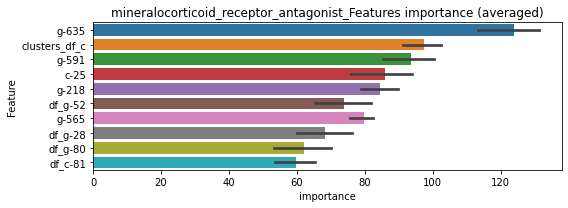

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 mineralocorticoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159423	valid_1's binary_logloss: 0.0272293
[200]	training's binary_logloss: 0.00208591	valid_1's binary_logloss: 0.0111142
Early stopping, best iteration is:
[273]	training's binary_logloss: 0.000748808	valid_1's binary_logloss: 0.00951885


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 mineralocorticoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0167123	valid_1's binary_logloss: 0.02423
[200]	training's binary_logloss: 0.00225809	valid_1's binary_logloss: 0.00678522
[300]	training's binary_logloss: 0.000638231	valid_1's binary_logloss: 0.00409673
[400]	training's binary_logloss: 0.000314291	valid_1's binary_logloss: 0.00354973
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.000283886	valid_1's binary_logloss: 0.0034893


mineralocorticoid_receptor_antagonist logloss: 0.006504077398294712
monoacylglycerol_lipase_inhibitor, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942


neg labels: 3289 → selected neg labels: 3287


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192033	valid_1's binary_logloss: 0.0248086
[200]	training's binary_logloss: 0.00202221	valid_1's binary_logloss: 0.00485097
[300]	training's binary_logloss: 0.000582139	valid_1's binary_logloss: 0.00237608
[400]	training's binary_logloss: 0.000323036	valid_1's binary_logloss: 0.00174881
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.000286551	valid_1's binary_logloss: 0.00167385
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193922	valid_1's binary_logloss: 0.0227134
[200]	training's binary_logloss: 0.00202372	valid_1's binary_logloss: 0.00309917
[300]	training's binary_logloss: 0.000583525	valid_1's binary_logloss: 0.00114916
[400]	training's binary_logloss: 0.000324343	valid_1's binary_logloss: 0.000716026
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000280183	valid_1's binary_logloss: 0.0006

1 / 3 AUC score:1.000
y_Threshold: 0.0010257, Threshold: 0.0017618, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00050, Num_p_label: 80.0, conf_0:0.00159, conf_1:0.00194
Num_p_label: 80.0, Expected: 2.0, Adj_threshold_1: 0.0017618
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_2: 0.0117618
Num_p_label: 2.0, Expected: 2.0, Adj_threshold_3: 0.0217618
threshold: 0.0217618, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192866	valid_1's binary_logloss: 0.0255926
[200]	training's binary_logloss: 0.00195121	valid_1's binary_logloss: 0.00497866
[300]	training's binary_logloss: 0.00056065	valid_1's binary_logloss: 0.00247585
[400]	training's binary_logloss: 0.000319932	valid_1's binary_logloss: 0.00194775
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.000287739	valid_1's binary_logloss: 0.00185953
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193291	valid_1's binary_logloss: 0.022756
[200]	training's binary_logloss: 0.00197298	valid_1's binary_logloss: 0.00323522
[300]	training's binary_logloss: 0.000564904	valid_1's binary_logloss: 0.00118152
[400]	training's binary_logloss: 0.000323409	valid_1's binary_logloss: 0.000790482
Early stopping, best iteration is:
[477]	training's binary_logloss: 0.000280068	valid_1's binary_logloss: 0.000712

2 / 3 AUC score:1.000
y_Threshold: 0.0644960, Threshold: 0.0217618, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0027624 Vs.target_rate: 0.00050, Num_p_label: 11.0, conf_0:0.01959, conf_1:0.02394
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_1: 0.0217618
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_2: 0.0317618
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_3: 0.0417618
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_4: 0.0517618
threshold: 0.0517618, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192866	valid_1's binary_logloss: 0.0255926
[200]	training's binary_logloss: 0.00195121	valid_1's binary_logloss: 0.00497866
[300]	training's binary_logloss: 0.00056065	valid_1's binary_logloss: 0.00247585
[400]	training's binary_logloss: 0.000319932	valid_1's binary_logloss: 0.00194775
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.000287739	valid_1's binary_logloss: 0.00185953
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193291	valid_1's binary_logloss: 0.022756
[200]	training's binary_logloss: 0.00197298	valid_1's binary_logloss: 0.00323522
[300]	training's binary_logloss: 0.000564904	valid_1's binary_logloss: 0.00118152
[400]	training's binary_logloss: 0.000323409	valid_1's binary_logloss: 0.000790482
Early stopping, best iteration is:
[477]	training's binary_logloss: 0.000280068	valid_1's binary_logloss: 0.000712

3 / 3 AUC score:1.000
y_Threshold: 0.0644960, Threshold: 0.0517618, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0010045 Vs.target_rate: 0.00050, Num_p_label: 4.0, conf_0:0.04659, conf_1:0.05694
threshold: 0.0517618, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 661.0/7794, y_label_rate: 0.0848088


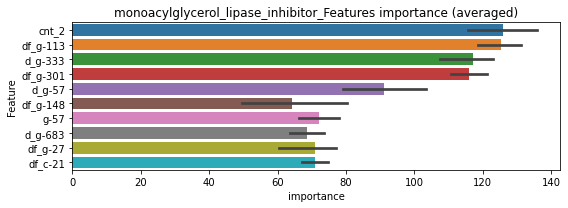

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 monoacylglycerol_lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0103347	valid_1's binary_logloss: 0.0152537
[200]	training's binary_logloss: 0.0010342	valid_1's binary_logloss: 0.00423642
[300]	training's binary_logloss: 0.000289296	valid_1's binary_logloss: 0.00332017
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.000216323	valid_1's binary_logloss: 0.00327532


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 monoacylglycerol_lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0104781	valid_1's binary_logloss: 0.0126398
[200]	training's binary_logloss: 0.00108511	valid_1's binary_logloss: 0.00239866
[300]	training's binary_logloss: 0.000302271	valid_1's binary_logloss: 0.00144558
[400]	training's binary_logloss: 0.000167013	valid_1's binary_logloss: 0.00127057
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.000161925	valid_1's binary_logloss: 0.00126531


monoacylglycerol_lipase_inhibitor logloss: 0.0022703158817381284
monoamine_oxidase_inhibitor, len(trt): 85, len(othr): 3274, target_rate: 0.0035693 → Adj_target_rate: 0.0036661


neg labels: 3289 → selected neg labels: 3274


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0589483	valid_1's binary_logloss: 0.1228
[200]	training's binary_logloss: 0.0142706	valid_1's binary_logloss: 0.0699247
[300]	training's binary_logloss: 0.00425528	valid_1's binary_logloss: 0.0542905
[400]	training's binary_logloss: 0.00191118	valid_1's binary_logloss: 0.0487177
Early stopping, best iteration is:
[437]	training's binary_logloss: 0.00153368	valid_1's binary_logloss: 0.0479278
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0627199	valid_1's binary_logloss: 0.111016
[200]	training's binary_logloss: 0.0157622	valid_1's binary_logloss: 0.0589255
[300]	training's binary_logloss: 0.00494483	valid_1's binary_logloss: 0.0410447
[400]	training's binary_logloss: 0.00216219	valid_1's binary_logloss: 0.0341431
[500]	training's binary_logloss: 0.00126702	valid_1's binary_logloss: 0.0317281
Early stopping, best iteration is:
[573]	training's

1 / 3 AUC score:0.997
y_Threshold: 0.0117619, Threshold: 0.0149095, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 140 → Positive_corect_labels: 650/3788
p_label_rate: 0.0200904 Vs.target_rate: 0.00357, Num_p_label: 80.0, conf_0:0.01342, conf_1:0.01640
Num_p_label: 80.0, Expected: 14.2, Adj_threshold_1: 0.0149095
Num_p_label: 28.0, Expected: 14.2, Adj_threshold_2: 0.0249095
threshold: 0.0249095, positive_p_label: 28.0/3982, p_label_rate: 0.0070316
positive_y_label: 650.0/3788, y_label_rate: 0.1715945
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0595234	valid_1's binary_logloss: 0.115449
[200]	training's binary_logloss: 0.0141197	valid_1's binary_logloss: 0.0605272
[300]	training's binary_logloss: 0.00431003	valid_1's binary_logloss: 0.0425611
[400]	training's binary_logloss: 0.00191601	valid_1's binary_logloss: 0.0361481
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00143976	valid_1's binary_logloss: 0.0348394
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0586397	valid_1's binary_logloss: 0.122361
[200]	training's binary_logloss: 0.0130694	valid_1's binary_logloss: 0.0643201
[300]	training's binary_logloss: 0.0040727	valid_1's binary_logloss: 0.0478478
[400]	training's binary_logloss: 0.00184685	valid_1's binary_logloss: 0.0426465
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.00169812	valid_1's binary_logloss: 0.0421036


2 / 3 AUC score:0.999
y_Threshold: 0.0581194, Threshold: 0.0249095, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 10 → Positive_corect_labels: 645.0/3778
p_label_rate: 0.0213461 Vs.target_rate: 0.00357, Num_p_label: 85.0, conf_0:0.02242, conf_1:0.02740
Num_p_label: 85.0, Expected: 14.2, Adj_threshold_1: 0.0249095
Num_p_label: 48.0, Expected: 14.2, Adj_threshold_2: 0.0349095
Num_p_label: 28.0, Expected: 14.2, Adj_threshold_3: 0.0449095
threshold: 0.0449095, positive_p_label: 28.0/3982, p_label_rate: 0.0070316
positive_y_label: 645.0/3778, y_label_rate: 0.1707253
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0569493	valid_1's binary_logloss: 0.114158
[200]	training's binary_logloss: 0.0129218	valid_1's binary_logloss: 0.0569056
[300]	training's binary_logloss: 0.00392783	valid_1's binary_logloss: 0.0394581
[400]	training's binary_logloss: 0.00175938	valid_1's binary_logloss: 0.0350116
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00117277	valid_1's binary_logloss: 0.033271
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0615344	valid_1's binary_logloss: 0.115892
[200]	training's binary_logloss: 0.014453	valid_1's binary_logloss: 0.061432
[300]	training's binary_logloss: 0.00446772	valid_1's binary_logloss: 0.0446333
[400]	training's binary_logloss: 0.00196525	valid_1's binary_logloss: 0.0375151
[500]	training's binary_logloss: 0.00116981	valid_1's binary_logloss: 0.035233
[600]	training's binary_logloss: 0.000830424	valid_1'

3 / 3 AUC score:1.000
y_Threshold: 0.0402558, Threshold: 0.0449095, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 16 → Positive_corect_labels: 637.0/3762
p_label_rate: 0.0065294 Vs.target_rate: 0.00357, Num_p_label: 26.0, conf_0:0.04042, conf_1:0.04940
threshold: 0.0449095, positive_p_label: 26.0/3982, p_label_rate: 0.0065294
positive_y_label: 663.0/7744, y_label_rate: 0.0856147


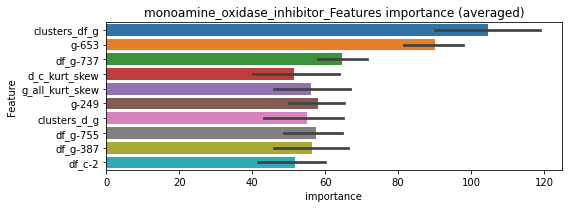

len(train_index) : 3872
len(valid_index) : 3872
================================= fold 1/2 monoamine_oxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0310405	valid_1's binary_logloss: 0.0730611
[200]	training's binary_logloss: 0.00701057	valid_1's binary_logloss: 0.0475804
[300]	training's binary_logloss: 0.00213783	valid_1's binary_logloss: 0.0420361
Early stopping, best iteration is:
[366]	training's binary_logloss: 0.00121627	valid_1's binary_logloss: 0.0406857


len(train_index) : 3872
len(valid_index) : 3872
================================= fold 2/2 monoamine_oxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0337681	valid_1's binary_logloss: 0.0722943
[200]	training's binary_logloss: 0.00802998	valid_1's binary_logloss: 0.0437658
[300]	training's binary_logloss: 0.00238132	valid_1's binary_logloss: 0.0352054
[400]	training's binary_logloss: 0.00105493	valid_1's binary_logloss: 0.0332304
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.00101397	valid_1's binary_logloss: 0.0330665


monoamine_oxidase_inhibitor logloss: 0.03687612666258428
monopolar_spindle_1_kinase_inhibitor, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0214748	valid_1's binary_logloss: 0.0280082
[200]	training's binary_logloss: 0.00242986	valid_1's binary_logloss: 0.00457652
[300]	training's binary_logloss: 0.000692839	valid_1's binary_logloss: 0.00174274
[400]	training's binary_logloss: 0.000380169	valid_1's binary_logloss: 0.00109952
[500]	training's binary_logloss: 0.000310885	valid_1's binary_logloss: 0.000944429
[600]	training's binary_logloss: 0.000297476	valid_1's binary_logloss: 0.00090794
[700]	training's binary_logloss: 0.000295367	valid_1's binary_logloss: 0.000903545
Early stopping, best iteration is:
[705]	training's binary_logloss: 0.000295145	valid_1's binary_logloss: 0.000902805
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0217651	valid_1's binary_logloss: 0.0277086
[200]	training's binary_logloss: 0.00247474	valid_1's binary_logloss: 0.00466555
[300]	training's binary_logl

1 / 3 AUC score:1.000
y_Threshold: 0.0015619, Threshold: 0.0036354, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076, Num_p_label: 80.0, conf_0:0.00327, conf_1:0.00400
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0036354
Num_p_label: 26.0, Expected: 3.0, Adj_threshold_2: 0.0136354
Num_p_label: 16.0, Expected: 3.0, Adj_threshold_3: 0.0236354
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_4: 0.0336354
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_5: 0.0436354
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_6: 0.0536354
threshold: 0.0536354, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0214243	valid_1's binary_logloss: 0.0271234
[200]	training's binary_logloss: 0.00236376	valid_1's binary_logloss: 0.00470187
[300]	training's binary_logloss: 0.000674646	valid_1's binary_logloss: 0.00171691
[400]	training's binary_logloss: 0.00037121	valid_1's binary_logloss: 0.00107814
[500]	training's binary_logloss: 0.000305926	valid_1's binary_logloss: 0.000943374
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.000298343	valid_1's binary_logloss: 0.000923616
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0215485	valid_1's binary_logloss: 0.0266192
[200]	training's binary_logloss: 0.00236196	valid_1's binary_logloss: 0.00381479
[300]	training's binary_logloss: 0.00066675	valid_1's binary_logloss: 0.00126197
[400]	training's binary_logloss: 0.000365264	valid_1's binary_logloss: 0.000733877
[500]	training's binary_loglos

2 / 3 AUC score:1.000
y_Threshold: 0.1077092, Threshold: 0.0536354, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0060271 Vs.target_rate: 0.00076, Num_p_label: 24.0, conf_0:0.04827, conf_1:0.05900
Num_p_label: 24.0, Expected: 3.0, Adj_threshold_1: 0.0536354
Num_p_label: 20.0, Expected: 3.0, Adj_threshold_2: 0.0636354
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_3: 0.0736354
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_4: 0.0836354
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_5: 0.0936354
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_6: 0.1036354
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_7: 0.1136354
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_8: 0.1236354
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_9: 0.1336354
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_10: 0.1436354
threshold: 0.1536354, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
=============

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0214243	valid_1's binary_logloss: 0.0271234
[200]	training's binary_logloss: 0.00236376	valid_1's binary_logloss: 0.00470187
[300]	training's binary_logloss: 0.000674646	valid_1's binary_logloss: 0.00171691
[400]	training's binary_logloss: 0.00037121	valid_1's binary_logloss: 0.00107814
[500]	training's binary_logloss: 0.000305926	valid_1's binary_logloss: 0.000943374
Early stopping, best iteration is:
[563]	training's binary_logloss: 0.000298343	valid_1's binary_logloss: 0.000923616
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0215485	valid_1's binary_logloss: 0.0266192
[200]	training's binary_logloss: 0.00236196	valid_1's binary_logloss: 0.00381479
[300]	training's binary_logloss: 0.00066675	valid_1's binary_logloss: 0.00126197
[400]	training's binary_logloss: 0.000365264	valid_1's binary_logloss: 0.000733877
[500]	training's binary_loglos

3 / 3 AUC score:1.000
y_Threshold: 0.1077092, Threshold: 0.1536354, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0017579 Vs.target_rate: 0.00076, Num_p_label: 7.0, conf_0:0.13827, conf_1:0.16900
threshold: 0.1536354, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 664.0/7793, y_label_rate: 0.0852047


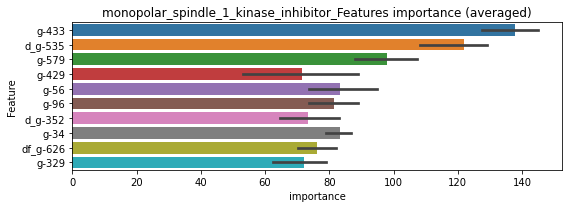

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 monopolar_spindle_1_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0115015	valid_1's binary_logloss: 0.0183649
[200]	training's binary_logloss: 0.00128522	valid_1's binary_logloss: 0.00702216
Early stopping, best iteration is:
[269]	training's binary_logloss: 0.000490009	valid_1's binary_logloss: 0.00601812


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 monopolar_spindle_1_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0117811	valid_1's binary_logloss: 0.0172037
[200]	training's binary_logloss: 0.00131449	valid_1's binary_logloss: 0.00454433
[300]	training's binary_logloss: 0.00037152	valid_1's binary_logloss: 0.00267758
[400]	training's binary_logloss: 0.000201485	valid_1's binary_logloss: 0.00231551
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000177781	valid_1's binary_logloss: 0.00228271


monopolar_spindle_1_kinase_inhibitor logloss: 0.004150654205437039
mtor_inhibitor, len(trt): 130, len(othr): 3267, target_rate: 0.0054590 → Adj_target_rate: 0.0052608


neg labels: 3289 → selected neg labels: 3267


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0325111	valid_1's binary_logloss: 0.0789204
[200]	training's binary_logloss: 0.00507718	valid_1's binary_logloss: 0.0533489
Early stopping, best iteration is:
[205]	training's binary_logloss: 0.00469417	valid_1's binary_logloss: 0.0529868
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.035131	valid_1's binary_logloss: 0.0843056
[200]	training's binary_logloss: 0.00556316	valid_1's binary_logloss: 0.0593431


1 / 3 AUC score:0.996
y_Threshold: 0.0108372, Threshold: 0.1129243, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[232]	training's binary_logloss: 0.00355798	valid_1's binary_logloss: 0.0573761


Remove_noisy_labels: 149 → Positive_corect_labels: 644/3771
p_label_rate: 0.0200904 Vs.target_rate: 0.00546, Num_p_label: 80.0, conf_0:0.10163, conf_1:0.12422
Num_p_label: 80.0, Expected: 21.7, Adj_threshold_1: 0.1129243
Num_p_label: 77.0, Expected: 21.7, Adj_threshold_2: 0.1229243
Num_p_label: 74.0, Expected: 21.7, Adj_threshold_3: 0.1329243
Num_p_label: 69.0, Expected: 21.7, Adj_threshold_4: 0.1429243
Num_p_label: 69.0, Expected: 21.7, Adj_threshold_5: 0.1529243
Num_p_label: 65.0, Expected: 21.7, Adj_threshold_6: 0.1629243
Num_p_label: 64.0, Expected: 21.7, Adj_threshold_7: 0.1729243
Num_p_label: 63.0, Expected: 21.7, Adj_threshold_8: 0.1829243
Num_p_label: 63.0, Expected: 21.7, Adj_threshold_9: 0.1929243
Num_p_label: 62.0, Expected: 21.7, Adj_threshold_10: 0.2029243
threshold: 0.2129243, positive_p_label: 62.0/3982, p_label_rate: 0.0155701
positive_y_label: 644.0/3771, y_label_rate: 0.1707770
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0290054	valid_1's binary_logloss: 0.0661777
[200]	training's binary_logloss: 0.00396764	valid_1's binary_logloss: 0.0457524
Early stopping, best iteration is:
[210]	training's binary_logloss: 0.00338127	valid_1's binary_logloss: 0.0453295
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0291158	valid_1's binary_logloss: 0.076123


2 / 3 AUC score:0.995
y_Threshold: 0.0335888, Threshold: 0.2129243, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 44 → Positive_corect_labels: 622.0/3727
p_label_rate: 0.0369161 Vs.target_rate: 0.00546, Num_p_label: 147.0, conf_0:0.19163, conf_1:0.23422
Num_p_label: 147.0, Expected: 21.7, Adj_threshold_1: 0.2129243
Num_p_label: 143.0, Expected: 21.7, Adj_threshold_2: 0.2229243


Early stopping, best iteration is:
[186]	training's binary_logloss: 0.00513754	valid_1's binary_logloss: 0.0591737


Num_p_label: 138.0, Expected: 21.7, Adj_threshold_3: 0.2329243
Num_p_label: 136.0, Expected: 21.7, Adj_threshold_4: 0.2429243
Num_p_label: 133.0, Expected: 21.7, Adj_threshold_5: 0.2529243
Num_p_label: 131.0, Expected: 21.7, Adj_threshold_6: 0.2629243
Num_p_label: 129.0, Expected: 21.7, Adj_threshold_7: 0.2729243
Num_p_label: 126.0, Expected: 21.7, Adj_threshold_8: 0.2829243
Num_p_label: 123.0, Expected: 21.7, Adj_threshold_9: 0.2929243
Num_p_label: 118.0, Expected: 21.7, Adj_threshold_10: 0.3029243
threshold: 0.3129243, positive_p_label: 115.0/3982, p_label_rate: 0.0288800
positive_y_label: 622.0/3727, y_label_rate: 0.1668903
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0257283	valid_1's binary_logloss: 0.0540469
[200]	training's binary_logloss: 0.00329534	valid_1's binary_logloss: 0.029752
[300]	training's binary_logloss: 0.000964823	valid_1's binary_logloss: 0.0253285
[400]	training's binary_logloss: 0.000495563	valid_1's binary_logloss: 0.0237363
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.000520283	valid_1's binary_logloss: 0.0236773
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0268511	valid_1's binary_logloss: 0.0531723
[200]	training's binary_logloss: 0.00374323	valid_1's binary_logloss: 0.0341084
[300]	training's binary_logloss: 0.00106819	valid_1's binary_logloss: 0.0308902
Early stopping, best iteration is:
[302]	training's binary_logloss: 0.00104407	valid_1's binary_logloss: 0.0307882


3 / 3 AUC score:0.999
y_Threshold: 0.0296267, Threshold: 0.3129243, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 18 → Positive_corect_labels: 613.0/3709
p_label_rate: 0.0371673 Vs.target_rate: 0.00546, Num_p_label: 148.0, conf_0:0.28163, conf_1:0.34422
Num_p_label: 148.0, Expected: 21.7, Adj_threshold_1: 0.3129243
Num_p_label: 147.0, Expected: 21.7, Adj_threshold_2: 0.3229243
Num_p_label: 145.0, Expected: 21.7, Adj_threshold_3: 0.3329243
Num_p_label: 144.0, Expected: 21.7, Adj_threshold_4: 0.3429243
Num_p_label: 144.0, Expected: 21.7, Adj_threshold_5: 0.3529243
Num_p_label: 144.0, Expected: 21.7, Adj_threshold_6: 0.3629243
Num_p_label: 143.0, Expected: 21.7, Adj_threshold_7: 0.3729243
Num_p_label: 142.0, Expected: 21.7, Adj_threshold_8: 0.3829243
Num_p_label: 142.0, Expected: 21.7, Adj_threshold_9: 0.3929243
Num_p_label: 140.0, Expected: 21.7, Adj_threshold_10: 0.4029243
threshold: 0.4129243, positive_p_label: 139.0/3982, p_label_rate: 0.0349071
positive_y_label: 752.0/7691, y_label_r

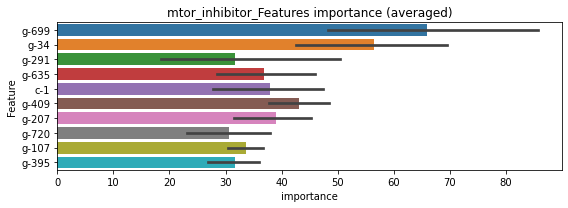

len(train_index) : 3845
len(valid_index) : 3846
================================= fold 1/2 mtor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.016721	valid_1's binary_logloss: 0.0398379
[200]	training's binary_logloss: 0.00225813	valid_1's binary_logloss: 0.0270071
Early stopping, best iteration is:
[190]	training's binary_logloss: 0.00265576	valid_1's binary_logloss: 0.0268841


len(train_index) : 3846
len(valid_index) : 3845
================================= fold 2/2 mtor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0173446	valid_1's binary_logloss: 0.0377535
[200]	training's binary_logloss: 0.00239345	valid_1's binary_logloss: 0.0239218
Early stopping, best iteration is:
[236]	training's binary_logloss: 0.00139609	valid_1's binary_logloss: 0.023347


mtor_inhibitor logloss: 0.025115770731163473
mucolytic_agent, len(trt): 48, len(othr): 3281, target_rate: 0.0020156 → Adj_target_rate: 0.0022556


neg labels: 3289 → selected neg labels: 3281


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0448634	valid_1's binary_logloss: 0.0795175
[200]	training's binary_logloss: 0.00831315	valid_1's binary_logloss: 0.0334842
[300]	training's binary_logloss: 0.00233383	valid_1's binary_logloss: 0.0211063
[400]	training's binary_logloss: 0.00108659	valid_1's binary_logloss: 0.0172797
Early stopping, best iteration is:
[452]	training's binary_logloss: 0.000838015	valid_1's binary_logloss: 0.0161224
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0451751	valid_1's binary_logloss: 0.0696141
[200]	training's binary_logloss: 0.00817671	valid_1's binary_logloss: 0.0205109
[300]	training's binary_logloss: 0.00237186	valid_1's binary_logloss: 0.00982922
[400]	training's binary_logloss: 0.00112332	valid_1's binary_logloss: 0.00661592
[500]	training's binary_logloss: 0.000710028	valid_1's binary_logloss: 0.00543254
Early stopping, best iteration is:
[552]

1 / 3 AUC score:1.000
y_Threshold: 0.0059706, Threshold: 0.0090632, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3805
p_label_rate: 0.0200904 Vs.target_rate: 0.00202, Num_p_label: 80.0, conf_0:0.00816, conf_1:0.00997
Num_p_label: 80.0, Expected: 8.0, Adj_threshold_1: 0.0090632
Num_p_label: 15.0, Expected: 8.0, Adj_threshold_2: 0.0190632
threshold: 0.0190632, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 656.0/3805, y_label_rate: 0.1724047
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0433822	valid_1's binary_logloss: 0.0770095
[200]	training's binary_logloss: 0.00779593	valid_1's binary_logloss: 0.0300917
[300]	training's binary_logloss: 0.00222301	valid_1's binary_logloss: 0.0188969
[400]	training's binary_logloss: 0.00104559	valid_1's binary_logloss: 0.0147457
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.000983606	valid_1's binary_logloss: 0.0144701
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0458523	valid_1's binary_logloss: 0.0702207
[200]	training's binary_logloss: 0.00819686	valid_1's binary_logloss: 0.0200387
[300]	training's binary_logloss: 0.0024066	valid_1's binary_logloss: 0.00904806
[400]	training's binary_logloss: 0.00113845	valid_1's binary_logloss: 0.00577442
[500]	training's binary_logloss: 0.000718547	valid_1's binary_logloss: 0.00460379
[600]	training's binary_logloss: 0.000559

2 / 3 AUC score:1.000
y_Threshold: 0.0425728, Threshold: 0.0190632, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3803
p_label_rate: 0.0165746 Vs.target_rate: 0.00202, Num_p_label: 66.0, conf_0:0.01716, conf_1:0.02097
Num_p_label: 66.0, Expected: 8.0, Adj_threshold_1: 0.0190632
Num_p_label: 32.0, Expected: 8.0, Adj_threshold_2: 0.0290632
Num_p_label: 19.0, Expected: 8.0, Adj_threshold_3: 0.0390632
Num_p_label: 9.0, Expected: 8.0, Adj_threshold_4: 0.0490632
threshold: 0.0490632, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 655.0/3803, y_label_rate: 0.1722324
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0442076	valid_1's binary_logloss: 0.0721342
[200]	training's binary_logloss: 0.00799776	valid_1's binary_logloss: 0.0243633
[300]	training's binary_logloss: 0.00229978	valid_1's binary_logloss: 0.0126129
[400]	training's binary_logloss: 0.00108785	valid_1's binary_logloss: 0.00915793
[500]	training's binary_logloss: 0.00069496	valid_1's binary_logloss: 0.00792462
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.000582464	valid_1's binary_logloss: 0.00746208
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0438519	valid_1's binary_logloss: 0.069833
[200]	training's binary_logloss: 0.00779189	valid_1's binary_logloss: 0.0226501
[300]	training's binary_logloss: 0.00224607	valid_1's binary_logloss: 0.0115881
[400]	training's binary_logloss: 0.0010766	valid_1's binary_logloss: 0.00838592
[500]	training's binary_logloss: 0.0006923

3 / 3 AUC score:1.000
y_Threshold: 0.0556667, Threshold: 0.0490632, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 654.0/3801
p_label_rate: 0.0027624 Vs.target_rate: 0.00202, Num_p_label: 11.0, conf_0:0.04416, conf_1:0.05397
threshold: 0.0490632, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 665.0/7783, y_label_rate: 0.0854426


len(train_index) : 3891
len(valid_index) : 3892
================================= fold 1/2 mucolytic_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0238672	valid_1's binary_logloss: 0.0448757
[200]	training's binary_logloss: 0.0042697	valid_1's binary_logloss: 0.0197577
[300]	training's binary_logloss: 0.00122298	valid_1's binary_logloss: 0.0149859
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.00116347	valid_1's binary_logloss: 0.0148713


len(train_index) : 3892
len(valid_index) : 3891
================================= fold 2/2 mucolytic_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0252294	valid_1's binary_logloss: 0.0486913
[200]	training's binary_logloss: 0.00459086	valid_1's binary_logloss: 0.0248563
[300]	training's binary_logloss: 0.00126403	valid_1's binary_logloss: 0.0197888
[400]	training's binary_logloss: 0.000580827	valid_1's binary_logloss: 0.0183281
Early stopping, best iteration is:
[409]	training's binary_logloss: 0.000552323	valid_1's binary_logloss: 0.0182193


mucolytic_agent logloss: 0.01654509701273066
neuropeptide_receptor_antagonist, len(trt): 37, len(othr): 3283, target_rate: 0.0015537 → Adj_target_rate: 0.0018079


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0388247	valid_1's binary_logloss: 0.0607525
[200]	training's binary_logloss: 0.00602695	valid_1's binary_logloss: 0.0179101
[300]	training's binary_logloss: 0.00164878	valid_1's binary_logloss: 0.00934512
[400]	training's binary_logloss: 0.000797617	valid_1's binary_logloss: 0.00709243
[500]	training's binary_logloss: 0.000525421	valid_1's binary_logloss: 0.00616023
Early stopping, best iteration is:
[567]	training's binary_logloss: 0.000461802	valid_1's binary_logloss: 0.00586428
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0385706	valid_1's binary_logloss: 0.0603468
[200]	training's binary_logloss: 0.00598439	valid_1's binary_logloss: 0.0170081
[300]	training's binary_logloss: 0.00168501	valid_1's binary_logloss: 0.00813149
[400]	training's binary_logloss: 0.000801428	valid_1's binary_logloss: 0.00566514
[500]	training's binary_logloss: 0.

1 / 3 AUC score:1.000
y_Threshold: 0.0030716, Threshold: 0.0051649, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00155, Num_p_label: 80.0, conf_0:0.00465, conf_1:0.00568
Num_p_label: 80.0, Expected: 6.2, Adj_threshold_1: 0.0051649
Num_p_label: 20.0, Expected: 6.2, Adj_threshold_2: 0.0151649
Num_p_label: 11.0, Expected: 6.2, Adj_threshold_3: 0.0251649
threshold: 0.0251649, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0362789	valid_1's binary_logloss: 0.0573169
[200]	training's binary_logloss: 0.00540339	valid_1's binary_logloss: 0.0160826
[300]	training's binary_logloss: 0.00153977	valid_1's binary_logloss: 0.00824794
[400]	training's binary_logloss: 0.000754602	valid_1's binary_logloss: 0.00594843
[500]	training's binary_logloss: 0.000508223	valid_1's binary_logloss: 0.00512464
Early stopping, best iteration is:
[541]	training's binary_logloss: 0.000462656	valid_1's binary_logloss: 0.00494164
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.037805	valid_1's binary_logloss: 0.0578314
[200]	training's binary_logloss: 0.00581428	valid_1's binary_logloss: 0.0161293
[300]	training's binary_logloss: 0.00165515	valid_1's binary_logloss: 0.00757999
[400]	training's binary_logloss: 0.000806901	valid_1's binary_logloss: 0.00553031
[500]	training's binary_logloss: 0.0

2 / 3 AUC score:1.000
y_Threshold: 0.0321409, Threshold: 0.0251649, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0042692 Vs.target_rate: 0.00155, Num_p_label: 17.0, conf_0:0.02265, conf_1:0.02768
threshold: 0.0251649, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0362789	valid_1's binary_logloss: 0.0573169
[200]	training's binary_logloss: 0.00540339	valid_1's binary_logloss: 0.0160826
[300]	training's binary_logloss: 0.00153977	valid_1's binary_logloss: 0.00824794
[400]	training's binary_logloss: 0.000754602	valid_1's binary_logloss: 0.00594843
[500]	training's binary_logloss: 0.000508223	valid_1's binary_logloss: 0.00512464
Early stopping, best iteration is:
[541]	training's binary_logloss: 0.000462656	valid_1's binary_logloss: 0.00494164
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.037805	valid_1's binary_logloss: 0.0578314
[200]	training's binary_logloss: 0.00581428	valid_1's binary_logloss: 0.0161293
[300]	training's binary_logloss: 0.00165515	valid_1's binary_logloss: 0.00757999
[400]	training's binary_logloss: 0.000806901	valid_1's binary_logloss: 0.00553031
[500]	training's binary_logloss: 0.0

3 / 3 AUC score:1.000
y_Threshold: 0.0321409, Threshold: 0.0251649, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0042692 Vs.target_rate: 0.00155, Num_p_label: 17.0, conf_0:0.02265, conf_1:0.02768
threshold: 0.0251649, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 673.0/7789, y_label_rate: 0.0864039


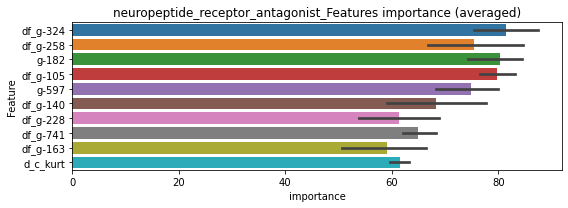

len(train_index) : 3894
len(valid_index) : 3895
================================= fold 1/2 neuropeptide_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0217402	valid_1's binary_logloss: 0.0442615
[200]	training's binary_logloss: 0.00321855	valid_1's binary_logloss: 0.0208971
[300]	training's binary_logloss: 0.000872548	valid_1's binary_logloss: 0.0179006
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.000913624	valid_1's binary_logloss: 0.0178472


len(train_index) : 3895
len(valid_index) : 3894
================================= fold 2/2 neuropeptide_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230739	valid_1's binary_logloss: 0.0396051
[200]	training's binary_logloss: 0.00361971	valid_1's binary_logloss: 0.0149082
[300]	training's binary_logloss: 0.000988025	valid_1's binary_logloss: 0.0121371
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.000900191	valid_1's binary_logloss: 0.0120191


neuropeptide_receptor_antagonist logloss: 0.014933510967663285
nfkb_inhibitor, len(trt): 832, len(othr): 3270, target_rate: 0.0349374 → Adj_target_rate: 0.0254860


neg labels: 3289 → selected neg labels: 3270


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0535038	valid_1's binary_logloss: 0.120745
Early stopping, best iteration is:
[130]	training's binary_logloss: 0.0311789	valid_1's binary_logloss: 0.117476
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.043643	valid_1's binary_logloss: 0.151902


1 / 3 AUC score:0.934
y_Threshold: 0.0327964, Threshold: 0.9638585, pos_neg_ratio: 0.7455657
Remove_noisy_labels: 406 → Positive_corect_labels: 735/3696
p_label_rate: 0.0200904 Vs.target_rate: 0.03494, Num_p_label: 80.0, conf_0:0.86747, conf_1:1.06024
threshold: 0.9638585, positive_p_label: 80.0/3982, p_label_rate: 0.0200904


Early stopping, best iteration is:
[100]	training's binary_logloss: 0.043643	valid_1's binary_logloss: 0.151902


positive_y_label: 735.0/3696, y_label_rate: 0.1988636
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193492	valid_1's binary_logloss: 0.0276846
Early stopping, best iteration is:
[175]	training's binary_logloss: 0.0030835	valid_1's binary_logloss: 0.0169164
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0196512	valid_1's binary_logloss: 0.0277587


2 / 3 AUC score:0.998
y_Threshold: 0.1548055, Threshold: 0.9638585, pos_neg_ratio: 0.7455657


[200]	training's binary_logloss: 0.00165923	valid_1's binary_logloss: 0.0147664
Early stopping, best iteration is:
[198]	training's binary_logloss: 0.0017363	valid_1's binary_logloss: 0.0147623


Remove_noisy_labels: 16 → Positive_corect_labels: 727.0/3680
p_label_rate: 0.0364139 Vs.target_rate: 0.03494, Num_p_label: 145.0, conf_0:0.86747, conf_1:1.06024
threshold: 0.9638585, positive_p_label: 145.0/3982, p_label_rate: 0.0364139
positive_y_label: 727.0/3680, y_label_rate: 0.1975543
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161667	valid_1's binary_logloss: 0.0168846
[200]	training's binary_logloss: 0.001047	valid_1's binary_logloss: 0.00126548
[300]	training's binary_logloss: 0.000232336	valid_1's binary_logloss: 0.000323671
[400]	training's binary_logloss: 0.000153716	valid_1's binary_logloss: 0.000229977
[500]	training's binary_logloss: 0.000140008	valid_1's binary_logloss: 0.00021287
[600]	training's binary_logloss: 0.000136735	valid_1's binary_logloss: 0.00020873
Early stopping, best iteration is:
[640]	training's binary_logloss: 0.00013617	valid_1's binary_logloss: 0.000208087
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161881	valid_1's binary_logloss: 0.0178791
[200]	training's binary_logloss: 0.00104508	valid_1's binary_logloss: 0.00293409
[300]	training's binary_logloss: 0.000231631	valid_1's binary_logloss: 0.00196137
Early stopping, best iteration 

3 / 3 AUC score:1.000
y_Threshold: 0.0678943, Threshold: 0.9638585, pos_neg_ratio: 0.7455657
Remove_noisy_labels: 0 → Positive_corect_labels: 727.0/3680
p_label_rate: 0.0399297 Vs.target_rate: 0.03494, Num_p_label: 159.0, conf_0:0.86747, conf_1:1.06024
threshold: 0.9638585, positive_p_label: 159.0/3982, p_label_rate: 0.0399297
positive_y_label: 886.0/7662, y_label_rate: 0.1156356


len(train_index) : 3831
len(valid_index) : 3831
================================= fold 1/2 nfkb_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0112082	valid_1's binary_logloss: 0.0130275
[200]	training's binary_logloss: 0.000865072	valid_1's binary_logloss: 0.00245457
Early stopping, best iteration is:
[277]	training's binary_logloss: 0.000209285	valid_1's binary_logloss: 0.00182366


len(train_index) : 3831
len(valid_index) : 3831
================================= fold 2/2 nfkb_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0111187	valid_1's binary_logloss: 0.0132955
[200]	training's binary_logloss: 0.000781599	valid_1's binary_logloss: 0.00391961


nfkb_inhibitor logloss: 0.0027672009492450095


Early stopping, best iteration is:
[219]	training's binary_logloss: 0.000511472	valid_1's binary_logloss: 0.00371074


nicotinic_receptor_agonist, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942


neg labels: 3289 → selected neg labels: 3287


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189464	valid_1's binary_logloss: 0.0279929
[200]	training's binary_logloss: 0.00194061	valid_1's binary_logloss: 0.00643607
[300]	training's binary_logloss: 0.000548209	valid_1's binary_logloss: 0.00321939
[400]	training's binary_logloss: 0.00030647	valid_1's binary_logloss: 0.00238048
[500]	training's binary_logloss: 0.000269714	valid_1's binary_logloss: 0.00229434
Early stopping, best iteration is:
[501]	training's binary_logloss: 0.000269577	valid_1's binary_logloss: 0.0022941
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189645	valid_1's binary_logloss: 0.0231341
[200]	training's binary_logloss: 0.00193467	valid_1's binary_logloss: 0.00399414
[300]	training's binary_logloss: 0.000551645	valid_1's binary_logloss: 0.00157905
[400]	training's binary_logloss: 0.000308584	valid_1's binary_logloss: 0.0010619
Early stopping, best iteration is:

1 / 3 AUC score:1.000
y_Threshold: 0.0010414, Threshold: 0.0025141, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00050, Num_p_label: 80.0, conf_0:0.00226, conf_1:0.00277
Num_p_label: 80.0, Expected: 2.0, Adj_threshold_1: 0.0025141
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_2: 0.0125141
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_3: 0.0225141
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_4: 0.0325141
threshold: 0.0325141, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189396	valid_1's binary_logloss: 0.0268101
[200]	training's binary_logloss: 0.00187198	valid_1's binary_logloss: 0.00644707
[300]	training's binary_logloss: 0.000523813	valid_1's binary_logloss: 0.00343359
[400]	training's binary_logloss: 0.000297901	valid_1's binary_logloss: 0.00269025
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000267743	valid_1's binary_logloss: 0.00259515
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189116	valid_1's binary_logloss: 0.0213227
[200]	training's binary_logloss: 0.00187486	valid_1's binary_logloss: 0.00293419
[300]	training's binary_logloss: 0.000531457	valid_1's binary_logloss: 0.00106492
[400]	training's binary_logloss: 0.000304231	valid_1's binary_logloss: 0.000725265
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000267806	valid_1's binary_logloss: 0.0006

2 / 3 AUC score:1.000
y_Threshold: 0.0374402, Threshold: 0.0325141, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0042692 Vs.target_rate: 0.00050, Num_p_label: 17.0, conf_0:0.02926, conf_1:0.03577
Num_p_label: 17.0, Expected: 2.0, Adj_threshold_1: 0.0325141
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_2: 0.0425141
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_3: 0.0525141
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_4: 0.0625141
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_5: 0.0725141
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_6: 0.0825141
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_7: 0.0925141
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_8: 0.1025141
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_9: 0.1125141
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_10: 0.1225141
threshold: 0.1325141, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
=============

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189396	valid_1's binary_logloss: 0.0268101
[200]	training's binary_logloss: 0.00187198	valid_1's binary_logloss: 0.00644707
[300]	training's binary_logloss: 0.000523813	valid_1's binary_logloss: 0.00343359
[400]	training's binary_logloss: 0.000297901	valid_1's binary_logloss: 0.00269025
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000267743	valid_1's binary_logloss: 0.00259515
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189116	valid_1's binary_logloss: 0.0213227
[200]	training's binary_logloss: 0.00187486	valid_1's binary_logloss: 0.00293419
[300]	training's binary_logloss: 0.000531457	valid_1's binary_logloss: 0.00106492
[400]	training's binary_logloss: 0.000304231	valid_1's binary_logloss: 0.000725265
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000267806	valid_1's binary_logloss: 0.0006

3 / 3 AUC score:1.000
y_Threshold: 0.0374402, Threshold: 0.1325141, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0017579 Vs.target_rate: 0.00050, Num_p_label: 7.0, conf_0:0.11926, conf_1:0.14577
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_1: 0.1325141
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_2: 0.1425141
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_3: 0.1525141
threshold: 0.1525141, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 661.0/7794, y_label_rate: 0.0848088


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 nicotinic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00995764	valid_1's binary_logloss: 0.0159082
[200]	training's binary_logloss: 0.000969596	valid_1's binary_logloss: 0.00505774
[300]	training's binary_logloss: 0.000275079	valid_1's binary_logloss: 0.00404763
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.000263824	valid_1's binary_logloss: 0.0040348


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 nicotinic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0101046	valid_1's binary_logloss: 0.0150942
[200]	training's binary_logloss: 0.00101718	valid_1's binary_logloss: 0.0056599
[300]	training's binary_logloss: 0.000282997	valid_1's binary_logloss: 0.00454737
Early stopping, best iteration is:
[293]	training's binary_logloss: 0.000300816	valid_1's binary_logloss: 0.00453863


nicotinic_receptor_agonist logloss: 0.004286713760134075
nitric_oxide_donor, len(trt): 26, len(othr): 3285, target_rate: 0.0010918 → Adj_target_rate: 0.0013394


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0297115	valid_1's binary_logloss: 0.0471254
[200]	training's binary_logloss: 0.00408144	valid_1's binary_logloss: 0.0119211
[300]	training's binary_logloss: 0.0011664	valid_1's binary_logloss: 0.00610321
[400]	training's binary_logloss: 0.000593373	valid_1's binary_logloss: 0.0042732
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000452529	valid_1's binary_logloss: 0.0036621
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0310799	valid_1's binary_logloss: 0.0440348
[200]	training's binary_logloss: 0.00428407	valid_1's binary_logloss: 0.00989143
[300]	training's binary_logloss: 0.00120369	valid_1's binary_logloss: 0.00388223
[400]	training's binary_logloss: 0.000591968	valid_1's binary_logloss: 0.00241358
[500]	training's binary_logloss: 0.000413359	valid_1's binary_logloss: 0.00193697
[600]	training's binary_logloss: 0.00

1 / 3 AUC score:1.000
y_Threshold: 0.0026179, Threshold: 0.0038409, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00109, Num_p_label: 80.0, conf_0:0.00346, conf_1:0.00423
Num_p_label: 80.0, Expected: 4.3, Adj_threshold_1: 0.0038409
Num_p_label: 8.0, Expected: 4.3, Adj_threshold_2: 0.0138409
threshold: 0.0138409, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0294133	valid_1's binary_logloss: 0.0450147
[200]	training's binary_logloss: 0.00403697	valid_1's binary_logloss: 0.0110124
[300]	training's binary_logloss: 0.00114219	valid_1's binary_logloss: 0.00427856
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.000922787	valid_1's binary_logloss: 0.0039402
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0304424	valid_1's binary_logloss: 0.0416434
[200]	training's binary_logloss: 0.00409457	valid_1's binary_logloss: 0.00881046
[300]	training's binary_logloss: 0.00117082	valid_1's binary_logloss: 0.00374099
[400]	training's binary_logloss: 0.000585141	valid_1's binary_logloss: 0.00240871
[500]	training's binary_logloss: 0.000412925	valid_1's binary_logloss: 0.00198506
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.000394632	valid_1's binary_logloss: 0.00194892


2 / 3 AUC score:1.000
y_Threshold: 0.0686164, Threshold: 0.0138409, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0077850 Vs.target_rate: 0.00109, Num_p_label: 31.0, conf_0:0.01246, conf_1:0.01523
Num_p_label: 31.0, Expected: 4.3, Adj_threshold_1: 0.0138409
Num_p_label: 12.0, Expected: 4.3, Adj_threshold_2: 0.0238409
Num_p_label: 10.0, Expected: 4.3, Adj_threshold_3: 0.0338409
Num_p_label: 7.0, Expected: 4.3, Adj_threshold_4: 0.0438409
threshold: 0.0438409, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0294133	valid_1's binary_logloss: 0.0450147
[200]	training's binary_logloss: 0.00403697	valid_1's binary_logloss: 0.0110124
[300]	training's binary_logloss: 0.00114219	valid_1's binary_logloss: 0.00427856
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.000922787	valid_1's binary_logloss: 0.0039402
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0304424	valid_1's binary_logloss: 0.0416434
[200]	training's binary_logloss: 0.00409457	valid_1's binary_logloss: 0.00881046
[300]	training's binary_logloss: 0.00117082	valid_1's binary_logloss: 0.00374099
[400]	training's binary_logloss: 0.000585141	valid_1's binary_logloss: 0.00240871
[500]	training's binary_logloss: 0.000412925	valid_1's binary_logloss: 0.00198506
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.000394632	valid_1's binary_logloss: 0.00194892


3 / 3 AUC score:1.000
y_Threshold: 0.0686164, Threshold: 0.0438409, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0017579 Vs.target_rate: 0.00109, Num_p_label: 7.0, conf_0:0.03946, conf_1:0.04823
threshold: 0.0438409, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 664.0/7792, y_label_rate: 0.0852156


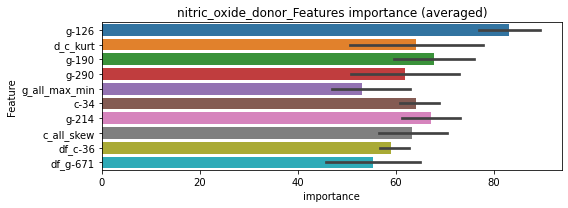

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 nitric_oxide_donor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159931	valid_1's binary_logloss: 0.0268726
[200]	training's binary_logloss: 0.00211306	valid_1's binary_logloss: 0.00960708
[300]	training's binary_logloss: 0.000591911	valid_1's binary_logloss: 0.00726713
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.000461268	valid_1's binary_logloss: 0.00699869


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 nitric_oxide_donor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164965	valid_1's binary_logloss: 0.0302819
[200]	training's binary_logloss: 0.00222517	valid_1's binary_logloss: 0.0133587
[300]	training's binary_logloss: 0.000619302	valid_1's binary_logloss: 0.0104045
[400]	training's binary_logloss: 0.000305094	valid_1's binary_logloss: 0.00958626
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.000288875	valid_1's binary_logloss: 0.00954776


nitric_oxide_donor logloss: 0.008273224043808461
nitric_oxide_production_inhibitor, len(trt): 29, len(othr): 3284, target_rate: 0.0012178 → Adj_target_rate: 0.0014697


neg labels: 3289 → selected neg labels: 3284


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0350912	valid_1's binary_logloss: 0.0531241
[200]	training's binary_logloss: 0.00531252	valid_1's binary_logloss: 0.0145913
[300]	training's binary_logloss: 0.00145793	valid_1's binary_logloss: 0.006791
[400]	training's binary_logloss: 0.000710566	valid_1's binary_logloss: 0.00460794
[500]	training's binary_logloss: 0.000499585	valid_1's binary_logloss: 0.00392374
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.000484296	valid_1's binary_logloss: 0.00388727
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0337519	valid_1's binary_logloss: 0.0523728
[200]	training's binary_logloss: 0.00500901	valid_1's binary_logloss: 0.0151133
[300]	training's binary_logloss: 0.00141755	valid_1's binary_logloss: 0.00780328
Early stopping, best iteration is:
[367]	training's binary_logloss: 0.000845075	valid_1's binary_logloss: 0.00587491


1 / 3 AUC score:1.000
y_Threshold: 0.0030862, Threshold: 0.1081935, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00122, Num_p_label: 80.0, conf_0:0.09737, conf_1:0.11901
Num_p_label: 80.0, Expected: 4.8, Adj_threshold_1: 0.1081935
Num_p_label: 75.0, Expected: 4.8, Adj_threshold_2: 0.1181935
Num_p_label: 72.0, Expected: 4.8, Adj_threshold_3: 0.1281935
Num_p_label: 72.0, Expected: 4.8, Adj_threshold_4: 0.1381935
Num_p_label: 70.0, Expected: 4.8, Adj_threshold_5: 0.1481935
Num_p_label: 66.0, Expected: 4.8, Adj_threshold_6: 0.1581935
Num_p_label: 60.0, Expected: 4.8, Adj_threshold_7: 0.1681935
Num_p_label: 53.0, Expected: 4.8, Adj_threshold_8: 0.1781935
Num_p_label: 50.0, Expected: 4.8, Adj_threshold_9: 0.1881935
Num_p_label: 49.0, Expected: 4.8, Adj_threshold_10: 0.1981935
threshold: 0.2081935, positive_p_label: 46.0/3982, p_label_rate: 0.0115520
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0328487	valid_1's binary_logloss: 0.0481718
[200]	training's binary_logloss: 0.00480111	valid_1's binary_logloss: 0.0122958
[300]	training's binary_logloss: 0.00133656	valid_1's binary_logloss: 0.00590106
[400]	training's binary_logloss: 0.000667449	valid_1's binary_logloss: 0.00401524
[500]	training's binary_logloss: 0.000470081	valid_1's binary_logloss: 0.00340128
Early stopping, best iteration is:
[532]	training's binary_logloss: 0.000455266	valid_1's binary_logloss: 0.00336055
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0335846	valid_1's binary_logloss: 0.052261
[200]	training's binary_logloss: 0.00478396	valid_1's binary_logloss: 0.0121404
[300]	training's binary_logloss: 0.00132935	valid_1's binary_logloss: 0.00498319
[400]	training's binary_logloss: 0.000660044	valid_1's binary_logloss: 0.00308284
[500]	training's binary_logloss: 0.0

2 / 3 AUC score:1.000
y_Threshold: 0.2001285, Threshold: 0.2081935, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0334003 Vs.target_rate: 0.00122, Num_p_label: 133.0, conf_0:0.18737, conf_1:0.22901
Num_p_label: 133.0, Expected: 4.8, Adj_threshold_1: 0.2081935
Num_p_label: 133.0, Expected: 4.8, Adj_threshold_2: 0.2181935
Num_p_label: 132.0, Expected: 4.8, Adj_threshold_3: 0.2281935
Num_p_label: 131.0, Expected: 4.8, Adj_threshold_4: 0.2381935
Num_p_label: 126.0, Expected: 4.8, Adj_threshold_5: 0.2481935
Num_p_label: 124.0, Expected: 4.8, Adj_threshold_6: 0.2581935
Num_p_label: 123.0, Expected: 4.8, Adj_threshold_7: 0.2681935
Num_p_label: 122.0, Expected: 4.8, Adj_threshold_8: 0.2781935
Num_p_label: 119.0, Expected: 4.8, Adj_threshold_9: 0.2881935
Num_p_label: 119.0, Expected: 4.8, Adj_threshold_10: 0.2981935
threshold: 0.3081935, positive_p_label: 119.0/3982, p_label_rate: 0.0298845
positive_y_label: 656.0/3808, y_label_rate: 0.1722

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0328487	valid_1's binary_logloss: 0.0481718
[200]	training's binary_logloss: 0.00480111	valid_1's binary_logloss: 0.0122958
[300]	training's binary_logloss: 0.00133656	valid_1's binary_logloss: 0.00590106
[400]	training's binary_logloss: 0.000667449	valid_1's binary_logloss: 0.00401524
[500]	training's binary_logloss: 0.000470081	valid_1's binary_logloss: 0.00340128
Early stopping, best iteration is:
[532]	training's binary_logloss: 0.000455266	valid_1's binary_logloss: 0.00336055
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0335846	valid_1's binary_logloss: 0.052261
[200]	training's binary_logloss: 0.00478396	valid_1's binary_logloss: 0.0121404
[300]	training's binary_logloss: 0.00132935	valid_1's binary_logloss: 0.00498319
[400]	training's binary_logloss: 0.000660044	valid_1's binary_logloss: 0.00308284
[500]	training's binary_logloss: 0.0

3 / 3 AUC score:1.000
y_Threshold: 0.2001285, Threshold: 0.3081935, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0298845 Vs.target_rate: 0.00122, Num_p_label: 119.0, conf_0:0.27737, conf_1:0.33901
Num_p_label: 119.0, Expected: 4.8, Adj_threshold_1: 0.3081935
Num_p_label: 119.0, Expected: 4.8, Adj_threshold_2: 0.3181935
Num_p_label: 119.0, Expected: 4.8, Adj_threshold_3: 0.3281935
Num_p_label: 117.0, Expected: 4.8, Adj_threshold_4: 0.3381935
Num_p_label: 115.0, Expected: 4.8, Adj_threshold_5: 0.3481935
Num_p_label: 113.0, Expected: 4.8, Adj_threshold_6: 0.3581935
Num_p_label: 113.0, Expected: 4.8, Adj_threshold_7: 0.3681935
Num_p_label: 112.0, Expected: 4.8, Adj_threshold_8: 0.3781935
Num_p_label: 111.0, Expected: 4.8, Adj_threshold_9: 0.3881935
Num_p_label: 111.0, Expected: 4.8, Adj_threshold_10: 0.3981935
threshold: 0.4081935, positive_p_label: 111.0/3982, p_label_rate: 0.0278754
positive_y_label: 767.0/7790, y_label_rate: 0.0984

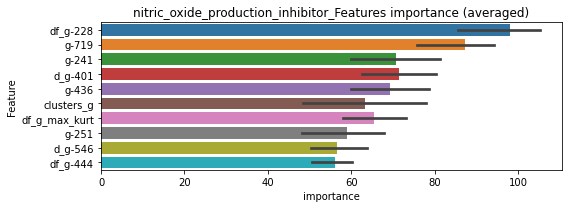

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 nitric_oxide_production_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0213686	valid_1's binary_logloss: 0.0355662
[200]	training's binary_logloss: 0.0031941	valid_1's binary_logloss: 0.0146434
[300]	training's binary_logloss: 0.000856757	valid_1's binary_logloss: 0.0112825
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00074317	valid_1's binary_logloss: 0.0110549


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 nitric_oxide_production_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0222578	valid_1's binary_logloss: 0.0317838
[200]	training's binary_logloss: 0.0035363	valid_1's binary_logloss: 0.00976388
[300]	training's binary_logloss: 0.00101013	valid_1's binary_logloss: 0.00621035
[400]	training's binary_logloss: 0.000477089	valid_1's binary_logloss: 0.00540419
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.000459364	valid_1's binary_logloss: 0.00535676


nitric_oxide_production_inhibitor logloss: 0.00820581434671972
nitric_oxide_synthase_inhibitor, len(trt): 26, len(othr): 3284, target_rate: 0.0010918 → Adj_target_rate: 0.0013394


neg labels: 3289 → selected neg labels: 3284


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0333722	valid_1's binary_logloss: 0.053304
[200]	training's binary_logloss: 0.0046818	valid_1's binary_logloss: 0.0149617
[300]	training's binary_logloss: 0.00129007	valid_1's binary_logloss: 0.00808727
[400]	training's binary_logloss: 0.000639271	valid_1's binary_logloss: 0.0058637
[500]	training's binary_logloss: 0.000445973	valid_1's binary_logloss: 0.00492523
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.000423847	valid_1's binary_logloss: 0.00481281
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0334221	valid_1's binary_logloss: 0.0494442
[200]	training's binary_logloss: 0.00461468	valid_1's binary_logloss: 0.0115004
[300]	training's binary_logloss: 0.00127518	valid_1's binary_logloss: 0.00475844
[400]	training's binary_logloss: 0.000640961	valid_1's binary_logloss: 0.00330186
[500]	training's binary_logloss: 0.000

1 / 3 AUC score:1.000
y_Threshold: 0.0024745, Threshold: 0.0037580, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00109, Num_p_label: 80.0, conf_0:0.00338, conf_1:0.00413
Num_p_label: 80.0, Expected: 4.3, Adj_threshold_1: 0.0037580
Num_p_label: 5.0, Expected: 4.3, Adj_threshold_2: 0.0137580
threshold: 0.0137580, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0328946	valid_1's binary_logloss: 0.0513701
[200]	training's binary_logloss: 0.00446145	valid_1's binary_logloss: 0.0141843
[300]	training's binary_logloss: 0.00124324	valid_1's binary_logloss: 0.00780622
[400]	training's binary_logloss: 0.000623929	valid_1's binary_logloss: 0.00580839
Early stopping, best iteration is:
[472]	training's binary_logloss: 0.000475078	valid_1's binary_logloss: 0.00537248
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.033456	valid_1's binary_logloss: 0.0474006
[200]	training's binary_logloss: 0.00460039	valid_1's binary_logloss: 0.00997855
[300]	training's binary_logloss: 0.00126379	valid_1's binary_logloss: 0.0040882
[400]	training's binary_logloss: 0.000632628	valid_1's binary_logloss: 0.0027148
[500]	training's binary_logloss: 0.000446617	valid_1's binary_logloss: 0.00226049
Early stopping, best iteration is:
[5

2 / 3 AUC score:1.000
y_Threshold: 0.0286674, Threshold: 0.0137580, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0075339 Vs.target_rate: 0.00109, Num_p_label: 30.0, conf_0:0.01238, conf_1:0.01513
Num_p_label: 30.0, Expected: 4.3, Adj_threshold_1: 0.0137580
Num_p_label: 14.0, Expected: 4.3, Adj_threshold_2: 0.0237580
Num_p_label: 5.0, Expected: 4.3, Adj_threshold_3: 0.0337580
threshold: 0.0337580, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0328946	valid_1's binary_logloss: 0.0513701
[200]	training's binary_logloss: 0.00446145	valid_1's binary_logloss: 0.0141843
[300]	training's binary_logloss: 0.00124324	valid_1's binary_logloss: 0.00780622
[400]	training's binary_logloss: 0.000623929	valid_1's binary_logloss: 0.00580839
Early stopping, best iteration is:
[472]	training's binary_logloss: 0.000475078	valid_1's binary_logloss: 0.00537248
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.033456	valid_1's binary_logloss: 0.0474006
[200]	training's binary_logloss: 0.00460039	valid_1's binary_logloss: 0.00997855
[300]	training's binary_logloss: 0.00126379	valid_1's binary_logloss: 0.0040882
[400]	training's binary_logloss: 0.000632628	valid_1's binary_logloss: 0.0027148
[500]	training's binary_logloss: 0.000446617	valid_1's binary_logloss: 0.00226049
Early stopping, best iteration is:
[5

3 / 3 AUC score:1.000
y_Threshold: 0.0286674, Threshold: 0.0337580, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0012557 Vs.target_rate: 0.00109, Num_p_label: 5.0, conf_0:0.03038, conf_1:0.03713
threshold: 0.0337580, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 661.0/7790, y_label_rate: 0.0848524


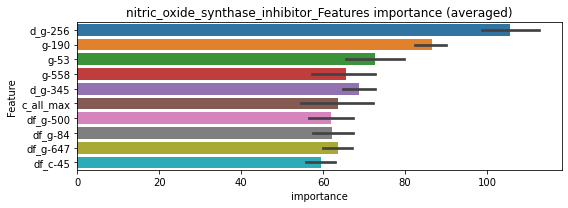

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 nitric_oxide_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0175898	valid_1's binary_logloss: 0.0285876
[200]	training's binary_logloss: 0.00244779	valid_1's binary_logloss: 0.00990397
[300]	training's binary_logloss: 0.000652616	valid_1's binary_logloss: 0.00701054
[400]	training's binary_logloss: 0.0003247	valid_1's binary_logloss: 0.00665392
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.000341781	valid_1's binary_logloss: 0.00661317


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 nitric_oxide_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0186364	valid_1's binary_logloss: 0.026708
[200]	training's binary_logloss: 0.00267782	valid_1's binary_logloss: 0.0073128
[300]	training's binary_logloss: 0.00070772	valid_1's binary_logloss: 0.00393446
[400]	training's binary_logloss: 0.000337813	valid_1's binary_logloss: 0.00320679
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000279273	valid_1's binary_logloss: 0.00307648


nitric_oxide_synthase_inhibitor logloss: 0.004844822806633585
norepinephrine_reuptake_inhibitor, len(trt): 7, len(othr): 3287, target_rate: 0.0002939 → Adj_target_rate: 0.0004391


neg labels: 3289 → selected neg labels: 3287


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164751	valid_1's binary_logloss: 0.0182365
[200]	training's binary_logloss: 0.00147756	valid_1's binary_logloss: 0.00196038
[300]	training's binary_logloss: 0.00041366	valid_1's binary_logloss: 0.00059641
[400]	training's binary_logloss: 0.000246652	valid_1's binary_logloss: 0.000369719
[500]	training's binary_logloss: 0.000227621	valid_1's binary_logloss: 0.000341964
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.000227621	valid_1's binary_logloss: 0.000341964
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165123	valid_1's binary_logloss: 0.0184172
[200]	training's binary_logloss: 0.00148536	valid_1's binary_logloss: 0.00215639
[300]	training's binary_logloss: 0.000414835	valid_1's binary_logloss: 0.000727077
[400]	training's binary_logloss: 0.000247088	valid_1's binary_logloss: 0.000471202


1 / 3 AUC score:1.000
y_Threshold: 0.0006471, Threshold: 0.0009846, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[488]	training's binary_logloss: 0.000225324	valid_1's binary_logloss: 0.000435501


Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00029, Num_p_label: 80.0, conf_0:0.00089, conf_1:0.00108
Num_p_label: 80.0, Expected: 1.2, Adj_threshold_1: 0.0009846
Num_p_label: 2.0, Expected: 1.2, Adj_threshold_2: 0.0109846
threshold: 0.0109846, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0168869	valid_1's binary_logloss: 0.0187627
[200]	training's binary_logloss: 0.00147636	valid_1's binary_logloss: 0.002479
[300]	training's binary_logloss: 0.000408053	valid_1's binary_logloss: 0.00114044
[400]	training's binary_logloss: 0.000243972	valid_1's binary_logloss: 0.000857002
[500]	training's binary_logloss: 0.000220222	valid_1's binary_logloss: 0.000817833
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.000220222	valid_1's binary_logloss: 0.000817833
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0168254	valid_1's binary_logloss: 0.018696
[200]	training's binary_logloss: 0.00147666	valid_1's binary_logloss: 0.00248013
[300]	training's binary_logloss: 0.000406228	valid_1's binary_logloss: 0.00091563
[400]	training's binary_logloss: 0.000245971	valid_1's binary_logloss: 0.000636379
[500]	training's binary_loglos

2 / 3 AUC score:1.000
y_Threshold: 0.0719063, Threshold: 0.0109846, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0050226 Vs.target_rate: 0.00029, Num_p_label: 20.0, conf_0:0.00989, conf_1:0.01208
Num_p_label: 20.0, Expected: 1.2, Adj_threshold_1: 0.0109846
Num_p_label: 7.0, Expected: 1.2, Adj_threshold_2: 0.0209846
Num_p_label: 6.0, Expected: 1.2, Adj_threshold_3: 0.0309846
Num_p_label: 1.0, Expected: 1.2, Adj_threshold_4: 0.0409846
threshold: 0.0409846, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0168869	valid_1's binary_logloss: 0.0187627
[200]	training's binary_logloss: 0.00147636	valid_1's binary_logloss: 0.002479
[300]	training's binary_logloss: 0.000408053	valid_1's binary_logloss: 0.00114044
[400]	training's binary_logloss: 0.000243972	valid_1's binary_logloss: 0.000857002
[500]	training's binary_logloss: 0.000220222	valid_1's binary_logloss: 0.000817833
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000220222	valid_1's binary_logloss: 0.000817833
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0168254	valid_1's binary_logloss: 0.018696
[200]	training's binary_logloss: 0.00147666	valid_1's binary_logloss: 0.00248013
[300]	training's binary_logloss: 0.000406228	valid_1's binary_logloss: 0.00091563
[400]	training's binary_logloss: 0.000245971	valid_1's binary_logloss: 0.000636379
[500]	training's binary_loglos

3 / 3 AUC score:1.000
y_Threshold: 0.0719063, Threshold: 0.0409846, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0002511 Vs.target_rate: 0.00029, Num_p_label: 1.0, conf_0:0.03689, conf_1:0.04508
threshold: 0.0409846, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 658.0/7794, y_label_rate: 0.0844239


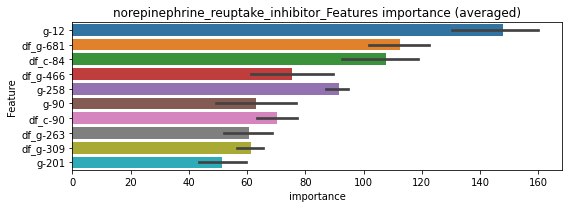

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 norepinephrine_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00872152	valid_1's binary_logloss: 0.0106984
[200]	training's binary_logloss: 0.000745281	valid_1's binary_logloss: 0.00257423
[300]	training's binary_logloss: 0.000202313	valid_1's binary_logloss: 0.00202561
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.000188933	valid_1's binary_logloss: 0.0020142


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 norepinephrine_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00877845	valid_1's binary_logloss: 0.0100963
[200]	training's binary_logloss: 0.000756288	valid_1's binary_logloss: 0.00179675
[300]	training's binary_logloss: 0.000206042	valid_1's binary_logloss: 0.00081375
[400]	training's binary_logloss: 0.000122765	valid_1's binary_logloss: 0.000651907
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.000112128	valid_1's binary_logloss: 0.000627008


norepinephrine_reuptake_inhibitor logloss: 0.0013206017202947416
nrf2_activator, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0206794	valid_1's binary_logloss: 0.0261648
[200]	training's binary_logloss: 0.00221586	valid_1's binary_logloss: 0.00550121
[300]	training's binary_logloss: 0.000633847	valid_1's binary_logloss: 0.00354012
[400]	training's binary_logloss: 0.000353491	valid_1's binary_logloss: 0.00295929
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.000289502	valid_1's binary_logloss: 0.00273381
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0206248	valid_1's binary_logloss: 0.0244317
[200]	training's binary_logloss: 0.00221634	valid_1's binary_logloss: 0.00458839
[300]	training's binary_logloss: 0.00062931	valid_1's binary_logloss: 0.0030535


1 / 3 AUC score:1.000
y_Threshold: 0.0010687, Threshold: 0.0647032, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[354]	training's binary_logloss: 0.000424024	valid_1's binary_logloss: 0.00277668


Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076, Num_p_label: 80.0, conf_0:0.05823, conf_1:0.07117
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0647032
Num_p_label: 77.0, Expected: 3.0, Adj_threshold_2: 0.0747032
Num_p_label: 75.0, Expected: 3.0, Adj_threshold_3: 0.0847032
Num_p_label: 75.0, Expected: 3.0, Adj_threshold_4: 0.0947032
Num_p_label: 75.0, Expected: 3.0, Adj_threshold_5: 0.1047032
Num_p_label: 72.0, Expected: 3.0, Adj_threshold_6: 0.1147032
Num_p_label: 71.0, Expected: 3.0, Adj_threshold_7: 0.1247032
Num_p_label: 70.0, Expected: 3.0, Adj_threshold_8: 0.1347032
Num_p_label: 70.0, Expected: 3.0, Adj_threshold_9: 0.1447032
Num_p_label: 69.0, Expected: 3.0, Adj_threshold_10: 0.1547032
threshold: 0.1647032, positive_p_label: 69.0/3982, p_label_rate: 0.0173280
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0199127	valid_1's binary_logloss: 0.0234347
[200]	training's binary_logloss: 0.00195137	valid_1's binary_logloss: 0.00283079
[300]	training's binary_logloss: 0.000543392	valid_1's binary_logloss: 0.000933264
[400]	training's binary_logloss: 0.00030526	valid_1's binary_logloss: 0.000561026
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.000281584	valid_1's binary_logloss: 0.000525624
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0200098	valid_1's binary_logloss: 0.0228225
[200]	training's binary_logloss: 0.00197362	valid_1's binary_logloss: 0.0026802
[300]	training's binary_logloss: 0.000554671	valid_1's binary_logloss: 0.000948722
[400]	training's binary_logloss: 0.00031014	valid_1's binary_logloss: 0.000611689


2 / 3 AUC score:1.000


Early stopping, best iteration is:
[462]	training's binary_logloss: 0.000278163	valid_1's binary_logloss: 0.000572227


y_Threshold: 0.1582248, Threshold: 0.1647032, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0261175 Vs.target_rate: 0.00076, Num_p_label: 104.0, conf_0:0.14823, conf_1:0.18117
Num_p_label: 104.0, Expected: 3.0, Adj_threshold_1: 0.1647032
Num_p_label: 103.0, Expected: 3.0, Adj_threshold_2: 0.1747032
Num_p_label: 100.0, Expected: 3.0, Adj_threshold_3: 0.1847032
Num_p_label: 99.0, Expected: 3.0, Adj_threshold_4: 0.1947032
Num_p_label: 99.0, Expected: 3.0, Adj_threshold_5: 0.2047032
Num_p_label: 99.0, Expected: 3.0, Adj_threshold_6: 0.2147032
Num_p_label: 99.0, Expected: 3.0, Adj_threshold_7: 0.2247032
Num_p_label: 98.0, Expected: 3.0, Adj_threshold_8: 0.2347032
Num_p_label: 95.0, Expected: 3.0, Adj_threshold_9: 0.2447032
Num_p_label: 94.0, Expected: 3.0, Adj_threshold_10: 0.2547032
threshold: 0.2647032, positive_p_label: 93.0/3982, p_label_rate: 0.0233551
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo l

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0199127	valid_1's binary_logloss: 0.0234347
[200]	training's binary_logloss: 0.00195137	valid_1's binary_logloss: 0.00283079
[300]	training's binary_logloss: 0.000543392	valid_1's binary_logloss: 0.000933264
[400]	training's binary_logloss: 0.00030526	valid_1's binary_logloss: 0.000561026
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.000281584	valid_1's binary_logloss: 0.000525624
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0200098	valid_1's binary_logloss: 0.0228225
[200]	training's binary_logloss: 0.00197362	valid_1's binary_logloss: 0.0026802
[300]	training's binary_logloss: 0.000554671	valid_1's binary_logloss: 0.000948722
[400]	training's binary_logloss: 0.00031014	valid_1's binary_logloss: 0.000611689
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.000278163	valid_1's binary_logloss: 0.000

3 / 3 AUC score:1.000
y_Threshold: 0.1582248, Threshold: 0.2647032, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0233551 Vs.target_rate: 0.00076, Num_p_label: 93.0, conf_0:0.23823, conf_1:0.29117
Num_p_label: 93.0, Expected: 3.0, Adj_threshold_1: 0.2647032
Num_p_label: 92.0, Expected: 3.0, Adj_threshold_2: 0.2747032
Num_p_label: 92.0, Expected: 3.0, Adj_threshold_3: 0.2847032
Num_p_label: 90.0, Expected: 3.0, Adj_threshold_4: 0.2947032
Num_p_label: 90.0, Expected: 3.0, Adj_threshold_5: 0.3047032
Num_p_label: 90.0, Expected: 3.0, Adj_threshold_6: 0.3147032
Num_p_label: 89.0, Expected: 3.0, Adj_threshold_7: 0.3247032
Num_p_label: 88.0, Expected: 3.0, Adj_threshold_8: 0.3347032
Num_p_label: 87.0, Expected: 3.0, Adj_threshold_9: 0.3447032
Num_p_label: 87.0, Expected: 3.0, Adj_threshold_10: 0.3547032
threshold: 0.3647032, positive_p_label: 86.0/3982, p_label_rate: 0.0215972
positive_y_label: 743.0/7793, y_label_rate: 0.0953420


len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 nrf2_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0125493	valid_1's binary_logloss: 0.019516
[200]	training's binary_logloss: 0.00141609	valid_1's binary_logloss: 0.00686846
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.00067147	valid_1's binary_logloss: 0.0062548


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 nrf2_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0128915	valid_1's binary_logloss: 0.0197126
[200]	training's binary_logloss: 0.00143663	valid_1's binary_logloss: 0.00599607
[300]	training's binary_logloss: 0.000404886	valid_1's binary_logloss: 0.00437218
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.000340382	valid_1's binary_logloss: 0.00425838


nrf2_activator logloss: 0.005256718595280039
opioid_receptor_agonist, len(trt): 61, len(othr): 3279, target_rate: 0.0025615 → Adj_target_rate: 0.0027652


neg labels: 3289 → selected neg labels: 3279


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0548266	valid_1's binary_logloss: 0.095192
[200]	training's binary_logloss: 0.0113539	valid_1's binary_logloss: 0.0422915
[300]	training's binary_logloss: 0.00324211	valid_1's binary_logloss: 0.027601
[400]	training's binary_logloss: 0.00145544	valid_1's binary_logloss: 0.0235008
[500]	training's binary_logloss: 0.000884861	valid_1's binary_logloss: 0.0215538
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.000713856	valid_1's binary_logloss: 0.0209263
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0541777	valid_1's binary_logloss: 0.0914115
[200]	training's binary_logloss: 0.0114097	valid_1's binary_logloss: 0.0379044
[300]	training's binary_logloss: 0.00333579	valid_1's binary_logloss: 0.023193
[400]	training's binary_logloss: 0.00149424	valid_1's binary_logloss: 0.0189384
Early stopping, best iteration is:
[483]	trainin

1 / 3 AUC score:1.000
y_Threshold: 0.0074720, Threshold: 0.0109679, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 654/3800
p_label_rate: 0.0200904 Vs.target_rate: 0.00256, Num_p_label: 80.0, conf_0:0.00987, conf_1:0.01206
Num_p_label: 80.0, Expected: 10.2, Adj_threshold_1: 0.0109679
Num_p_label: 27.0, Expected: 10.2, Adj_threshold_2: 0.0209679
Num_p_label: 15.0, Expected: 10.2, Adj_threshold_3: 0.0309679
threshold: 0.0309679, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 654.0/3800, y_label_rate: 0.1721053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0514904	valid_1's binary_logloss: 0.0958326
[200]	training's binary_logloss: 0.0103017	valid_1's binary_logloss: 0.0458536
[300]	training's binary_logloss: 0.00292296	valid_1's binary_logloss: 0.0325773
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.0023179	valid_1's binary_logloss: 0.0310969
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0537306	valid_1's binary_logloss: 0.0917951
[200]	training's binary_logloss: 0.0113809	valid_1's binary_logloss: 0.0406571
[300]	training's binary_logloss: 0.00330198	valid_1's binary_logloss: 0.0283225
[400]	training's binary_logloss: 0.00148867	valid_1's binary_logloss: 0.024936
Early stopping, best iteration is:
[394]	training's binary_logloss: 0.00154527	valid_1's binary_logloss: 0.0248495


2 / 3 AUC score:1.000
y_Threshold: 0.0408606, Threshold: 0.0309679, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 12 → Positive_corect_labels: 648.0/3788
p_label_rate: 0.0165746 Vs.target_rate: 0.00256, Num_p_label: 66.0, conf_0:0.02787, conf_1:0.03406
Num_p_label: 66.0, Expected: 10.2, Adj_threshold_1: 0.0309679
Num_p_label: 38.0, Expected: 10.2, Adj_threshold_2: 0.0409679
Num_p_label: 31.0, Expected: 10.2, Adj_threshold_3: 0.0509679
Num_p_label: 25.0, Expected: 10.2, Adj_threshold_4: 0.0609679
Num_p_label: 17.0, Expected: 10.2, Adj_threshold_5: 0.0709679
threshold: 0.0709679, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 648.0/3788, y_label_rate: 0.1710665
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0519334	valid_1's binary_logloss: 0.100959
[200]	training's binary_logloss: 0.0102535	valid_1's binary_logloss: 0.0506487
[300]	training's binary_logloss: 0.00296248	valid_1's binary_logloss: 0.0376774
[400]	training's binary_logloss: 0.00136999	valid_1's binary_logloss: 0.0343786
Early stopping, best iteration is:
[398]	training's binary_logloss: 0.001384	valid_1's binary_logloss: 0.0343732
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0559517	valid_1's binary_logloss: 0.0871203
[200]	training's binary_logloss: 0.0114882	valid_1's binary_logloss: 0.0356689
[300]	training's binary_logloss: 0.00322271	valid_1's binary_logloss: 0.0225789
[400]	training's binary_logloss: 0.00144608	valid_1's binary_logloss: 0.018583
[500]	training's binary_logloss: 0.000882802	valid_1's binary_logloss: 0.0169784
[600]	training's binary_logloss: 0.000663334	valid

3 / 3 AUC score:1.000
y_Threshold: 0.0300425, Threshold: 0.0709679, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 12 → Positive_corect_labels: 642.0/3776
p_label_rate: 0.0037670 Vs.target_rate: 0.00256, Num_p_label: 15.0, conf_0:0.06387, conf_1:0.07806
threshold: 0.0709679, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 657.0/7758, y_label_rate: 0.0846868


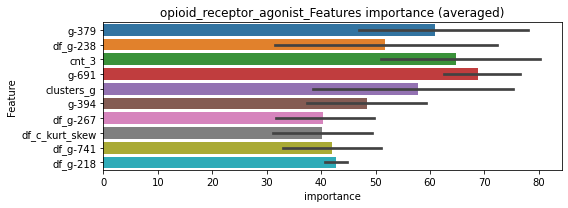

len(train_index) : 3879
len(valid_index) : 3879
================================= fold 1/2 opioid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0290227	valid_1's binary_logloss: 0.0601706
[200]	training's binary_logloss: 0.00605624	valid_1's binary_logloss: 0.0338587
[300]	training's binary_logloss: 0.00163309	valid_1's binary_logloss: 0.0278631
Early stopping, best iteration is:
[378]	training's binary_logloss: 0.000816928	valid_1's binary_logloss: 0.0265371


len(train_index) : 3879
len(valid_index) : 3879
================================= fold 2/2 opioid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0310142	valid_1's binary_logloss: 0.0523612
[200]	training's binary_logloss: 0.00639279	valid_1's binary_logloss: 0.0226815
[300]	training's binary_logloss: 0.00182627	valid_1's binary_logloss: 0.0154481
[400]	training's binary_logloss: 0.000789386	valid_1's binary_logloss: 0.0132082
Early stopping, best iteration is:
[469]	training's binary_logloss: 0.00054459	valid_1's binary_logloss: 0.0125596


opioid_receptor_agonist logloss: 0.019548353056669604
opioid_receptor_antagonist, len(trt): 96, len(othr): 3275, target_rate: 0.0040312 → Adj_target_rate: 0.0040656


neg labels: 3289 → selected neg labels: 3275


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0596817	valid_1's binary_logloss: 0.129266
[200]	training's binary_logloss: 0.0143937	valid_1's binary_logloss: 0.0762996
[300]	training's binary_logloss: 0.00465072	valid_1's binary_logloss: 0.0597761
[400]	training's binary_logloss: 0.00205864	valid_1's binary_logloss: 0.0546783
Early stopping, best iteration is:
[449]	training's binary_logloss: 0.00157026	valid_1's binary_logloss: 0.0525878
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0665748	valid_1's binary_logloss: 0.134824
[200]	training's binary_logloss: 0.0177478	valid_1's binary_logloss: 0.0856519
[300]	training's binary_logloss: 0.00536377	valid_1's binary_logloss: 0.0704903
[400]	training's binary_logloss: 0.00230738	valid_1's binary_logloss: 0.0664998
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.00214276	valid_1's binary_logloss: 0.0662548


1 / 3 AUC score:0.996
y_Threshold: 0.0146280, Threshold: 0.0217948, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 155 → Positive_corect_labels: 643/3775
p_label_rate: 0.0200904 Vs.target_rate: 0.00403, Num_p_label: 80.0, conf_0:0.01962, conf_1:0.02397
Num_p_label: 80.0, Expected: 16.1, Adj_threshold_1: 0.0217948
Num_p_label: 37.0, Expected: 16.1, Adj_threshold_2: 0.0317948
Num_p_label: 23.0, Expected: 16.1, Adj_threshold_3: 0.0417948
threshold: 0.0417948, positive_p_label: 23.0/3982, p_label_rate: 0.0057760
positive_y_label: 643.0/3775, y_label_rate: 0.1703311
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0553766	valid_1's binary_logloss: 0.132073
[200]	training's binary_logloss: 0.0124914	valid_1's binary_logloss: 0.0835657
[300]	training's binary_logloss: 0.00390188	valid_1's binary_logloss: 0.0709953
Early stopping, best iteration is:
[338]	training's binary_logloss: 0.0027847	valid_1's binary_logloss: 0.0689324
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.060355	valid_1's binary_logloss: 0.115238
[200]	training's binary_logloss: 0.0148385	valid_1's binary_logloss: 0.0595189
[300]	training's binary_logloss: 0.00468464	valid_1's binary_logloss: 0.040623
[400]	training's binary_logloss: 0.00213288	valid_1's binary_logloss: 0.0339346
[500]	training's binary_logloss: 0.00127974	valid_1's binary_logloss: 0.0316184
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.000960745	valid_1's binary_logloss: 0.0301727


2 / 3 AUC score:0.999
y_Threshold: 0.0475985, Threshold: 0.0417948, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 24 → Positive_corect_labels: 631.0/3751
p_label_rate: 0.0107986 Vs.target_rate: 0.00403, Num_p_label: 43.0, conf_0:0.03762, conf_1:0.04597
threshold: 0.0417948, positive_p_label: 43.0/3982, p_label_rate: 0.0107986
positive_y_label: 631.0/3751, y_label_rate: 0.1682218
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0525163	valid_1's binary_logloss: 0.12368
[200]	training's binary_logloss: 0.0113427	valid_1's binary_logloss: 0.0739485
[300]	training's binary_logloss: 0.00360005	valid_1's binary_logloss: 0.0586239
[400]	training's binary_logloss: 0.00168957	valid_1's binary_logloss: 0.0538179
Early stopping, best iteration is:
[478]	training's binary_logloss: 0.00114996	valid_1's binary_logloss: 0.0521959
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.059329	valid_1's binary_logloss: 0.107655
[200]	training's binary_logloss: 0.0144181	valid_1's binary_logloss: 0.0551448
[300]	training's binary_logloss: 0.00459066	valid_1's binary_logloss: 0.0376267
[400]	training's binary_logloss: 0.00208205	valid_1's binary_logloss: 0.0310355
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00133893	valid_1's binary_logloss: 0.0284747


3 / 3 AUC score:0.999
y_Threshold: 0.0312492, Threshold: 0.0417948, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 14 → Positive_corect_labels: 624.0/3737
p_label_rate: 0.0087896 Vs.target_rate: 0.00403, Num_p_label: 35.0, conf_0:0.03762, conf_1:0.04597
threshold: 0.0417948, positive_p_label: 35.0/3982, p_label_rate: 0.0087896
positive_y_label: 659.0/7719, y_label_rate: 0.0853738


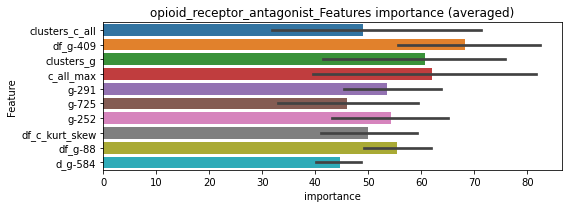

len(train_index) : 3859
len(valid_index) : 3860
================================= fold 1/2 opioid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.030949	valid_1's binary_logloss: 0.0783343
[200]	training's binary_logloss: 0.0069902	valid_1's binary_logloss: 0.0537036
[300]	training's binary_logloss: 0.00217388	valid_1's binary_logloss: 0.0489171
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.00208563	valid_1's binary_logloss: 0.0488337


len(train_index) : 3860
len(valid_index) : 3859
================================= fold 2/2 opioid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0351213	valid_1's binary_logloss: 0.0811216
[200]	training's binary_logloss: 0.00811821	valid_1's binary_logloss: 0.0546492
[300]	training's binary_logloss: 0.00256686	valid_1's binary_logloss: 0.0488495
Early stopping, best iteration is:
[334]	training's binary_logloss: 0.00186694	valid_1's binary_logloss: 0.0477658


opioid_receptor_antagonist logloss: 0.04829981558995596


neg labels: 3289 → selected neg labels: 3283


orexin_receptor_antagonist, len(trt): 37, len(othr): 3283, target_rate: 0.0015537 → Adj_target_rate: 0.0018079
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.038749	valid_1's binary_logloss: 0.0608894
[200]	training's binary_logloss: 0.00612608	valid_1's binary_logloss: 0.020264
[300]	training's binary_logloss: 0.00173301	valid_1's binary_logloss: 0.0120931
[400]	training's binary_logloss: 0.000827238	valid_1's binary_logloss: 0.0099258
[500]	training's binary_logloss: 0.000538641	valid_1's binary_logloss: 0.00886822
Early stopping, best iteration is:
[561]	training's binary_logloss: 0.000480287	valid_1's binary_logloss: 0.00870893
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.038481	valid_1's binary_logloss: 0.0595884
[200]	training's binary_logloss: 0.00645931	valid_1's binary_logloss: 0.0165986
[300]	training's binary_logloss: 0.00179319	valid_1's binary_logloss: 0.00770158
[400]	training's binary_logloss: 0.00085849	valid_1's binary_logloss: 0.00530427
[500]	training's binary_logloss: 0.000556

1 / 3 AUC score:1.000
y_Threshold: 0.0037090, Threshold: 0.0046087, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00155, Num_p_label: 80.0, conf_0:0.00415, conf_1:0.00507
Num_p_label: 80.0, Expected: 6.2, Adj_threshold_1: 0.0046087
Num_p_label: 9.0, Expected: 6.2, Adj_threshold_2: 0.0146087
threshold: 0.0146087, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0373308	valid_1's binary_logloss: 0.0577237
[200]	training's binary_logloss: 0.00586169	valid_1's binary_logloss: 0.017851
[300]	training's binary_logloss: 0.00163767	valid_1's binary_logloss: 0.00991617
[400]	training's binary_logloss: 0.00079602	valid_1's binary_logloss: 0.00790548
[500]	training's binary_logloss: 0.000524928	valid_1's binary_logloss: 0.00696647
Early stopping, best iteration is:
[522]	training's binary_logloss: 0.000499248	valid_1's binary_logloss: 0.00690102
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0380621	valid_1's binary_logloss: 0.0597245
[200]	training's binary_logloss: 0.00633944	valid_1's binary_logloss: 0.0161869
[300]	training's binary_logloss: 0.00175742	valid_1's binary_logloss: 0.00738037
[400]	training's binary_logloss: 0.000846002	valid_1's binary_logloss: 0.00506082
[500]	training's binary_logloss: 0.00

2 / 3 AUC score:1.000
y_Threshold: 0.0718204, Threshold: 0.0146087, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0080362 Vs.target_rate: 0.00155, Num_p_label: 32.0, conf_0:0.01315, conf_1:0.01607
Num_p_label: 32.0, Expected: 6.2, Adj_threshold_1: 0.0146087
Num_p_label: 13.0, Expected: 6.2, Adj_threshold_2: 0.0246087
Num_p_label: 5.0, Expected: 6.2, Adj_threshold_3: 0.0346087
threshold: 0.0346087, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 655.0/3805, y_label_rate: 0.1721419
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0369526	valid_1's binary_logloss: 0.0548181
[200]	training's binary_logloss: 0.00592634	valid_1's binary_logloss: 0.0158784
[300]	training's binary_logloss: 0.00166126	valid_1's binary_logloss: 0.00826837
[400]	training's binary_logloss: 0.000816816	valid_1's binary_logloss: 0.00631072
[500]	training's binary_logloss: 0.000535914	valid_1's binary_logloss: 0.00540733
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.000481859	valid_1's binary_logloss: 0.00518134
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0383436	valid_1's binary_logloss: 0.059686
[200]	training's binary_logloss: 0.00620797	valid_1's binary_logloss: 0.0154427
[300]	training's binary_logloss: 0.00171089	valid_1's binary_logloss: 0.00716936
[400]	training's binary_logloss: 0.000820682	valid_1's binary_logloss: 0.00491404
[500]	training's binary_logloss: 0.0

3 / 3 AUC score:1.000
y_Threshold: 0.0496475, Threshold: 0.0346087, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0010045 Vs.target_rate: 0.00155, Num_p_label: 4.0, conf_0:0.03115, conf_1:0.03807
threshold: 0.0346087, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 659.0/7787, y_label_rate: 0.0846282


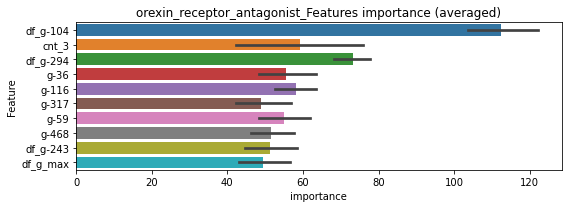

len(train_index) : 3893
len(valid_index) : 3894
================================= fold 1/2 orexin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0205348	valid_1's binary_logloss: 0.0359341
[200]	training's binary_logloss: 0.00323629	valid_1's binary_logloss: 0.0149132
[300]	training's binary_logloss: 0.000878271	valid_1's binary_logloss: 0.0109235
[400]	training's binary_logloss: 0.000412572	valid_1's binary_logloss: 0.0100515
Early stopping, best iteration is:
[429]	training's binary_logloss: 0.000357681	valid_1's binary_logloss: 0.00998657


len(train_index) : 3894
len(valid_index) : 3893
================================= fold 2/2 orexin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0198427	valid_1's binary_logloss: 0.0342932
[200]	training's binary_logloss: 0.00307741	valid_1's binary_logloss: 0.012717
[300]	training's binary_logloss: 0.000849211	valid_1's binary_logloss: 0.00802153
[400]	training's binary_logloss: 0.000410297	valid_1's binary_logloss: 0.00672635
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.000361304	valid_1's binary_logloss: 0.006683


orexin_receptor_antagonist logloss: 0.008334999692916444
p38_mapk_inhibitor, len(trt): 62, len(othr): 3278, target_rate: 0.0026035 → Adj_target_rate: 0.0028037


neg labels: 3289 → selected neg labels: 3278


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0356866	valid_1's binary_logloss: 0.0669351
[200]	training's binary_logloss: 0.00570356	valid_1's binary_logloss: 0.0222973
[300]	training's binary_logloss: 0.00169928	valid_1's binary_logloss: 0.012743
[400]	training's binary_logloss: 0.000829831	valid_1's binary_logloss: 0.00985465
[500]	training's binary_logloss: 0.000547816	valid_1's binary_logloss: 0.00861433
Early stopping, best iteration is:
[583]	training's binary_logloss: 0.000464001	valid_1's binary_logloss: 0.00820498
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0336946	valid_1's binary_logloss: 0.0773388
[200]	training's binary_logloss: 0.00526824	valid_1's binary_logloss: 0.0429183
Early stopping, best iteration is:
[278]	training's binary_logloss: 0.00190452	valid_1's binary_logloss: 0.0380727


1 / 3 AUC score:0.998
y_Threshold: 0.0081050, Threshold: 0.0167410, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 140 → Positive_corect_labels: 651/3793
p_label_rate: 0.0200904 Vs.target_rate: 0.00260, Num_p_label: 80.0, conf_0:0.01507, conf_1:0.01842
Num_p_label: 80.0, Expected: 10.4, Adj_threshold_1: 0.0167410
Num_p_label: 47.0, Expected: 10.4, Adj_threshold_2: 0.0267410
Num_p_label: 32.0, Expected: 10.4, Adj_threshold_3: 0.0367410
Num_p_label: 27.0, Expected: 10.4, Adj_threshold_4: 0.0467410
Num_p_label: 24.0, Expected: 10.4, Adj_threshold_5: 0.0567410
Num_p_label: 22.0, Expected: 10.4, Adj_threshold_6: 0.0667410
Num_p_label: 18.0, Expected: 10.4, Adj_threshold_7: 0.0767410
threshold: 0.0767410, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 651.0/3793, y_label_rate: 0.1716320
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0338436	valid_1's binary_logloss: 0.06273
[200]	training's binary_logloss: 0.00522252	valid_1's binary_logloss: 0.0202842
[300]	training's binary_logloss: 0.00153986	valid_1's binary_logloss: 0.0105825
[400]	training's binary_logloss: 0.000757448	valid_1's binary_logloss: 0.00759446
[500]	training's binary_logloss: 0.000500408	valid_1's binary_logloss: 0.00638582
Early stopping, best iteration is:
[567]	training's binary_logloss: 0.00043953	valid_1's binary_logloss: 0.00607493
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0339708	valid_1's binary_logloss: 0.0550869
[200]	training's binary_logloss: 0.00512879	valid_1's binary_logloss: 0.0159857
[300]	training's binary_logloss: 0.00151648	valid_1's binary_logloss: 0.00841265
[400]	training's binary_logloss: 0.000757408	valid_1's binary_logloss: 0.00624298
[500]	training's binary_logloss: 0.0005

2 / 3 AUC score:1.000
y_Threshold: 0.1056285, Threshold: 0.0767410, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 651.0/3793
p_label_rate: 0.0080362 Vs.target_rate: 0.00260, Num_p_label: 32.0, conf_0:0.06907, conf_1:0.08442
Num_p_label: 32.0, Expected: 10.4, Adj_threshold_1: 0.0767410
Num_p_label: 32.0, Expected: 10.4, Adj_threshold_2: 0.0867410
Num_p_label: 31.0, Expected: 10.4, Adj_threshold_3: 0.0967410
Num_p_label: 30.0, Expected: 10.4, Adj_threshold_4: 0.1067410
Num_p_label: 28.0, Expected: 10.4, Adj_threshold_5: 0.1167410
Num_p_label: 26.0, Expected: 10.4, Adj_threshold_6: 0.1267410
Num_p_label: 25.0, Expected: 10.4, Adj_threshold_7: 0.1367410
Num_p_label: 24.0, Expected: 10.4, Adj_threshold_8: 0.1467410
Num_p_label: 23.0, Expected: 10.4, Adj_threshold_9: 0.1567410
Num_p_label: 23.0, Expected: 10.4, Adj_threshold_10: 0.1667410
threshold: 0.1767410, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 651.0/3793, y_label_rate: 0.171632

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0338436	valid_1's binary_logloss: 0.06273
[200]	training's binary_logloss: 0.00522252	valid_1's binary_logloss: 0.0202842
[300]	training's binary_logloss: 0.00153986	valid_1's binary_logloss: 0.0105825
[400]	training's binary_logloss: 0.000757448	valid_1's binary_logloss: 0.00759446
[500]	training's binary_logloss: 0.000500408	valid_1's binary_logloss: 0.00638582
Early stopping, best iteration is:
[567]	training's binary_logloss: 0.00043953	valid_1's binary_logloss: 0.00607493
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0339708	valid_1's binary_logloss: 0.0550869
[200]	training's binary_logloss: 0.00512879	valid_1's binary_logloss: 0.0159857
[300]	training's binary_logloss: 0.00151648	valid_1's binary_logloss: 0.00841265
[400]	training's binary_logloss: 0.000757408	valid_1's binary_logloss: 0.00624298
[500]	training's binary_logloss: 0.0005

3 / 3 AUC score:1.000
y_Threshold: 0.1056285, Threshold: 0.1767410, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 651.0/3793
p_label_rate: 0.0050226 Vs.target_rate: 0.00260, Num_p_label: 20.0, conf_0:0.15907, conf_1:0.19442
threshold: 0.1767410, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 671.0/7775, y_label_rate: 0.0863023


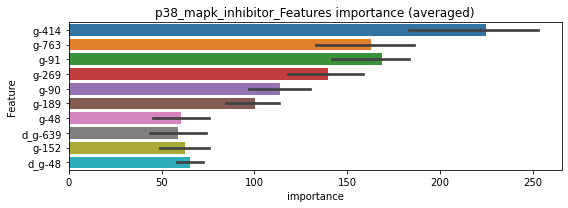

len(train_index) : 3887
len(valid_index) : 3888
================================= fold 1/2 p38_mapk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0178037	valid_1's binary_logloss: 0.0439686
[200]	training's binary_logloss: 0.00263564	valid_1's binary_logloss: 0.0234105
[300]	training's binary_logloss: 0.000777372	valid_1's binary_logloss: 0.0197156
[400]	training's binary_logloss: 0.000390922	valid_1's binary_logloss: 0.0183415
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.000292215	valid_1's binary_logloss: 0.0177103


len(train_index) : 3888
len(valid_index) : 3887
================================= fold 2/2 p38_mapk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0180267	valid_1's binary_logloss: 0.042629
[200]	training's binary_logloss: 0.00263716	valid_1's binary_logloss: 0.0193111
[300]	training's binary_logloss: 0.000790686	valid_1's binary_logloss: 0.0144158
[400]	training's binary_logloss: 0.000392865	valid_1's binary_logloss: 0.0130637
[500]	training's binary_logloss: 0.000266433	valid_1's binary_logloss: 0.012539
Early stopping, best iteration is:
[523]	training's binary_logloss: 0.000251289	valid_1's binary_logloss: 0.0124103


p38_mapk_inhibitor logloss: 0.015060652698741833
p-glycoprotein_inhibitor, len(trt): 24, len(othr): 3285, target_rate: 0.0010078 → Adj_target_rate: 0.0012513


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.03245	valid_1's binary_logloss: 0.0451189
[200]	training's binary_logloss: 0.00427957	valid_1's binary_logloss: 0.00926293
[300]	training's binary_logloss: 0.00115179	valid_1's binary_logloss: 0.00366859
[400]	training's binary_logloss: 0.000572752	valid_1's binary_logloss: 0.00229171
[500]	training's binary_logloss: 0.000411413	valid_1's binary_logloss: 0.00189631
Early stopping, best iteration is:
[547]	training's binary_logloss: 0.000399933	valid_1's binary_logloss: 0.00187517
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0328334	valid_1's binary_logloss: 0.0541397
[200]	training's binary_logloss: 0.00431352	valid_1's binary_logloss: 0.014874
[300]	training's binary_logloss: 0.00116396	valid_1's binary_logloss: 0.00749212
[400]	training's binary_logloss: 0.000573122	valid_1's binary_logloss: 0.00542502
[500]	training's binary_logloss: 0.00

1 / 3 AUC score:1.000
y_Threshold: 0.0023725, Threshold: 0.0036731, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00101, Num_p_label: 80.0, conf_0:0.00331, conf_1:0.00404
Num_p_label: 80.0, Expected: 4.0, Adj_threshold_1: 0.0036731
Num_p_label: 8.0, Expected: 4.0, Adj_threshold_2: 0.0136731
threshold: 0.0136731, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0307583	valid_1's binary_logloss: 0.0410223
[200]	training's binary_logloss: 0.00404279	valid_1's binary_logloss: 0.00821011
[300]	training's binary_logloss: 0.00111581	valid_1's binary_logloss: 0.00335494
[400]	training's binary_logloss: 0.000562527	valid_1's binary_logloss: 0.0020857
[500]	training's binary_logloss: 0.000408051	valid_1's binary_logloss: 0.00171717
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.000402164	valid_1's binary_logloss: 0.00170793
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0321097	valid_1's binary_logloss: 0.0521916
[200]	training's binary_logloss: 0.00425183	valid_1's binary_logloss: 0.0158012
[300]	training's binary_logloss: 0.00113759	valid_1's binary_logloss: 0.00861424
[400]	training's binary_logloss: 0.000562777	valid_1's binary_logloss: 0.00658552
[500]	training's binary_logloss: 0.

2 / 3 AUC score:1.000
y_Threshold: 0.0295706, Threshold: 0.0136731, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0062783 Vs.target_rate: 0.00101, Num_p_label: 25.0, conf_0:0.01231, conf_1:0.01504
Num_p_label: 25.0, Expected: 4.0, Adj_threshold_1: 0.0136731
Num_p_label: 9.0, Expected: 4.0, Adj_threshold_2: 0.0236731
Num_p_label: 5.0, Expected: 4.0, Adj_threshold_3: 0.0336731
threshold: 0.0336731, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0307583	valid_1's binary_logloss: 0.0410223
[200]	training's binary_logloss: 0.00404279	valid_1's binary_logloss: 0.00821011
[300]	training's binary_logloss: 0.00111581	valid_1's binary_logloss: 0.00335494
[400]	training's binary_logloss: 0.000562527	valid_1's binary_logloss: 0.0020857
[500]	training's binary_logloss: 0.000408051	valid_1's binary_logloss: 0.00171717
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.000402164	valid_1's binary_logloss: 0.00170793
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0321097	valid_1's binary_logloss: 0.0521916
[200]	training's binary_logloss: 0.00425183	valid_1's binary_logloss: 0.0158012
[300]	training's binary_logloss: 0.00113759	valid_1's binary_logloss: 0.00861424
[400]	training's binary_logloss: 0.000562777	valid_1's binary_logloss: 0.00658552
[500]	training's binary_logloss: 0.

3 / 3 AUC score:1.000
y_Threshold: 0.0295706, Threshold: 0.0336731, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0012557 Vs.target_rate: 0.00101, Num_p_label: 5.0, conf_0:0.03031, conf_1:0.03704
threshold: 0.0336731, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 662.0/7792, y_label_rate: 0.0849589


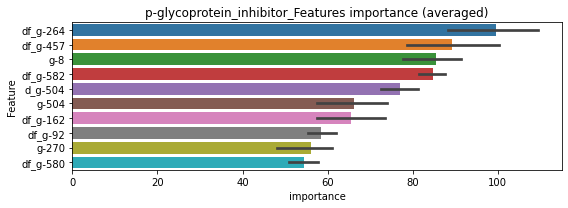

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 p-glycoprotein_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0188052	valid_1's binary_logloss: 0.0262851
[200]	training's binary_logloss: 0.00248324	valid_1's binary_logloss: 0.00760254
[300]	training's binary_logloss: 0.000628121	valid_1's binary_logloss: 0.00558171
Early stopping, best iteration is:
[351]	training's binary_logloss: 0.000404846	valid_1's binary_logloss: 0.0053186


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 p-glycoprotein_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.018256	valid_1's binary_logloss: 0.0263513
[200]	training's binary_logloss: 0.00237484	valid_1's binary_logloss: 0.00739138
[300]	training's binary_logloss: 0.000634921	valid_1's binary_logloss: 0.00467785
[400]	training's binary_logloss: 0.000306974	valid_1's binary_logloss: 0.00414089
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00022196	valid_1's binary_logloss: 0.00397291


p-glycoprotein_inhibitor logloss: 0.00464575397059964
parp_inhibitor, len(trt): 61, len(othr): 3279, target_rate: 0.0025615 → Adj_target_rate: 0.0027652


neg labels: 3289 → selected neg labels: 3279


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0431841	valid_1's binary_logloss: 0.0805096
[200]	training's binary_logloss: 0.00819551	valid_1's binary_logloss: 0.0329577
[300]	training's binary_logloss: 0.00249137	valid_1's binary_logloss: 0.0196705
[400]	training's binary_logloss: 0.00120765	valid_1's binary_logloss: 0.0150212
[500]	training's binary_logloss: 0.000765184	valid_1's binary_logloss: 0.0129077
Early stopping, best iteration is:
[578]	training's binary_logloss: 0.000609974	valid_1's binary_logloss: 0.0121379
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0463518	valid_1's binary_logloss: 0.0875332
[200]	training's binary_logloss: 0.00856566	valid_1's binary_logloss: 0.0334959
[300]	training's binary_logloss: 0.00252449	valid_1's binary_logloss: 0.0201935
[400]	training's binary_logloss: 0.0012113	valid_1's binary_logloss: 0.0160413
Early stopping, best iteration is:
[465]	tra

1 / 3 AUC score:1.000
y_Threshold: 0.0077076, Threshold: 0.0128151, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 655/3802
p_label_rate: 0.0200904 Vs.target_rate: 0.00256, Num_p_label: 80.0, conf_0:0.01153, conf_1:0.01410
Num_p_label: 80.0, Expected: 10.2, Adj_threshold_1: 0.0128151
Num_p_label: 38.0, Expected: 10.2, Adj_threshold_2: 0.0228151
Num_p_label: 22.0, Expected: 10.2, Adj_threshold_3: 0.0328151
Num_p_label: 12.0, Expected: 10.2, Adj_threshold_4: 0.0428151
threshold: 0.0428151, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 655.0/3802, y_label_rate: 0.1722777
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.043788	valid_1's binary_logloss: 0.0838565
[200]	training's binary_logloss: 0.00768333	valid_1's binary_logloss: 0.0326799
[300]	training's binary_logloss: 0.00231117	valid_1's binary_logloss: 0.0201627
[400]	training's binary_logloss: 0.00112702	valid_1's binary_logloss: 0.0155411
[500]	training's binary_logloss: 0.000719475	valid_1's binary_logloss: 0.0135537
Early stopping, best iteration is:
[551]	training's binary_logloss: 0.000618254	valid_1's binary_logloss: 0.012961
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.044938	valid_1's binary_logloss: 0.0845484
[200]	training's binary_logloss: 0.00826243	valid_1's binary_logloss: 0.0313819
[300]	training's binary_logloss: 0.00246152	valid_1's binary_logloss: 0.018309
[400]	training's binary_logloss: 0.00117029	valid_1's binary_logloss: 0.0144495
[500]	training's binary_logloss: 0.000738876	va

2 / 3 AUC score:1.000
y_Threshold: 0.0496143, Threshold: 0.0428151, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 652.0/3796
p_label_rate: 0.0097941 Vs.target_rate: 0.00256, Num_p_label: 39.0, conf_0:0.03853, conf_1:0.04710
Num_p_label: 39.0, Expected: 10.2, Adj_threshold_1: 0.0428151
Num_p_label: 32.0, Expected: 10.2, Adj_threshold_2: 0.0528151
Num_p_label: 26.0, Expected: 10.2, Adj_threshold_3: 0.0628151
Num_p_label: 16.0, Expected: 10.2, Adj_threshold_4: 0.0728151
threshold: 0.0728151, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 652.0/3796, y_label_rate: 0.1717597
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0439123	valid_1's binary_logloss: 0.085963
[200]	training's binary_logloss: 0.00791445	valid_1's binary_logloss: 0.0353344
[300]	training's binary_logloss: 0.00231174	valid_1's binary_logloss: 0.0225204
[400]	training's binary_logloss: 0.00110949	valid_1's binary_logloss: 0.018296
[500]	training's binary_logloss: 0.000712457	valid_1's binary_logloss: 0.0164842
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.000629897	valid_1's binary_logloss: 0.0159311
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0442992	valid_1's binary_logloss: 0.0941955
[200]	training's binary_logloss: 0.00796606	valid_1's binary_logloss: 0.0476138
[300]	training's binary_logloss: 0.00233105	valid_1's binary_logloss: 0.037639
[400]	training's binary_logloss: 0.00111618	valid_1's binary_logloss: 0.0340039
Early stopping, best iteration is:
[406]	train

3 / 3 AUC score:0.999
y_Threshold: 0.0354335, Threshold: 0.0728151, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 14 → Positive_corect_labels: 645.0/3782
p_label_rate: 0.0052737 Vs.target_rate: 0.00256, Num_p_label: 21.0, conf_0:0.06553, conf_1:0.08010
threshold: 0.0728151, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 666.0/7764, y_label_rate: 0.0857805


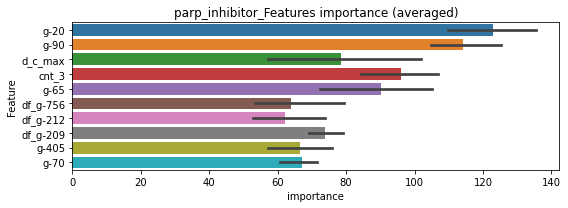

len(train_index) : 3882
len(valid_index) : 3882
================================= fold 1/2 parp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0248053	valid_1's binary_logloss: 0.0526758
[200]	training's binary_logloss: 0.00445251	valid_1's binary_logloss: 0.0282228
[300]	training's binary_logloss: 0.00131519	valid_1's binary_logloss: 0.0241231
[400]	training's binary_logloss: 0.000606856	valid_1's binary_logloss: 0.0228073
Early stopping, best iteration is:
[448]	training's binary_logloss: 0.000471215	valid_1's binary_logloss: 0.0225365


len(train_index) : 3882
len(valid_index) : 3882
================================= fold 2/2 parp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0247079	valid_1's binary_logloss: 0.0524794
[200]	training's binary_logloss: 0.00454806	valid_1's binary_logloss: 0.0257646
[300]	training's binary_logloss: 0.00135031	valid_1's binary_logloss: 0.0195967
[400]	training's binary_logloss: 0.000637437	valid_1's binary_logloss: 0.0176463
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.000614565	valid_1's binary_logloss: 0.0175634


parp_inhibitor logloss: 0.02004993162997214
pdgfr_inhibitor, len(trt): 297, len(othr): 3268, target_rate: 0.0124717 → Adj_target_rate: 0.0106179


neg labels: 3289 → selected neg labels: 3268


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0545942	valid_1's binary_logloss: 0.138631
[200]	training's binary_logloss: 0.0121696	valid_1's binary_logloss: 0.0982892
[300]	training's binary_logloss: 0.003971	valid_1's binary_logloss: 0.0865957
Early stopping, best iteration is:
[327]	training's binary_logloss: 0.00318942	valid_1's binary_logloss: 0.085429
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0543532	valid_1's binary_logloss: 0.129144
[200]	training's binary_logloss: 0.0117682	valid_1's binary_logloss: 0.089729
Early stopping, best iteration is:
[283]	training's binary_logloss: 0.00441956	valid_1's binary_logloss: 0.0803117


1 / 3 AUC score:0.992
y_Threshold: 0.0445552, Threshold: 0.1991983, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 174 → Positive_corect_labels: 632/3747
p_label_rate: 0.0200904 Vs.target_rate: 0.01247, Num_p_label: 80.0, conf_0:0.17928, conf_1:0.21912
threshold: 0.1991983, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 632.0/3747, y_label_rate: 0.1686683
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0455547	valid_1's binary_logloss: 0.10898
[200]	training's binary_logloss: 0.00872045	valid_1's binary_logloss: 0.0635693
[300]	training's binary_logloss: 0.00261299	valid_1's binary_logloss: 0.0493412
[400]	training's binary_logloss: 0.00125893	valid_1's binary_logloss: 0.0447869
Early stopping, best iteration is:
[409]	training's binary_logloss: 0.00118192	valid_1's binary_logloss: 0.0444514
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.046208	valid_1's binary_logloss: 0.105363
[200]	training's binary_logloss: 0.00880668	valid_1's binary_logloss: 0.0604606
[300]	training's binary_logloss: 0.00261077	valid_1's binary_logloss: 0.0481009
[400]	training's binary_logloss: 0.00121932	valid_1's binary_logloss: 0.044804
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.0012774	valid_1's binary_logloss: 0.0445479


2 / 3 AUC score:0.996
y_Threshold: 0.1092507, Threshold: 0.1991983, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 38 → Positive_corect_labels: 613.0/3709
p_label_rate: 0.0328980 Vs.target_rate: 0.01247, Num_p_label: 131.0, conf_0:0.17928, conf_1:0.21912
threshold: 0.1991983, positive_p_label: 131.0/3982, p_label_rate: 0.0328980
positive_y_label: 613.0/3709, y_label_rate: 0.1652737
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0443654	valid_1's binary_logloss: 0.0913064
[200]	training's binary_logloss: 0.00819272	valid_1's binary_logloss: 0.0446594
[300]	training's binary_logloss: 0.00239158	valid_1's binary_logloss: 0.0303289
[400]	training's binary_logloss: 0.00112611	valid_1's binary_logloss: 0.0256062
Early stopping, best iteration is:
[409]	training's binary_logloss: 0.00105686	valid_1's binary_logloss: 0.0250731
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.042237	valid_1's binary_logloss: 0.0982705
[200]	training's binary_logloss: 0.0077856	valid_1's binary_logloss: 0.0555166
[300]	training's binary_logloss: 0.00226625	valid_1's binary_logloss: 0.0430323
[400]	training's binary_logloss: 0.00107311	valid_1's binary_logloss: 0.0391696
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.000746076	valid_1's binary_logloss: 0.0376158


3 / 3 AUC score:0.998
y_Threshold: 0.1340731, Threshold: 0.1991983, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 24 → Positive_corect_labels: 601.0/3685
p_label_rate: 0.0351582 Vs.target_rate: 0.01247, Num_p_label: 140.0, conf_0:0.17928, conf_1:0.21912
threshold: 0.1991983, positive_p_label: 140.0/3982, p_label_rate: 0.0351582
positive_y_label: 741.0/7667, y_label_rate: 0.0966480


len(train_index) : 3833
len(valid_index) : 3834
================================= fold 1/2 pdgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0280833	valid_1's binary_logloss: 0.0639564
[200]	training's binary_logloss: 0.00510845	valid_1's binary_logloss: 0.0353193
[300]	training's binary_logloss: 0.00149112	valid_1's binary_logloss: 0.0266697
[400]	training's binary_logloss: 0.000697983	valid_1's binary_logloss: 0.0237775
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000479068	valid_1's binary_logloss: 0.022065


len(train_index) : 3834
len(valid_index) : 3833
================================= fold 2/2 pdgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0266761	valid_1's binary_logloss: 0.0678537
[200]	training's binary_logloss: 0.00478565	valid_1's binary_logloss: 0.0419475
[300]	training's binary_logloss: 0.00137842	valid_1's binary_logloss: 0.0346395
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.00146513	valid_1's binary_logloss: 0.0344011


pdgfr_inhibitor logloss: 0.028232256362803555
pdk_inhibitor, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0251147	valid_1's binary_logloss: 0.0321258
[200]	training's binary_logloss: 0.00302819	valid_1's binary_logloss: 0.00535683
[300]	training's binary_logloss: 0.000839318	valid_1's binary_logloss: 0.00189465
[400]	training's binary_logloss: 0.000437092	valid_1's binary_logloss: 0.00112258
[500]	training's binary_logloss: 0.000348234	valid_1's binary_logloss: 0.000951844
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.000345926	valid_1's binary_logloss: 0.000949202
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0251963	valid_1's binary_logloss: 0.0363946
[200]	training's binary_logloss: 0.00300578	valid_1's binary_logloss: 0.0083687
[300]	training's binary_logloss: 0.000832703	valid_1's binary_logloss: 0.0040456
[400]	training's binary_logloss: 0.000430455	valid_1's binary_logloss: 0.00294277
Early stopping, best iteration 

1 / 3 AUC score:1.000
y_Threshold: 0.0014683, Threshold: 0.0021724, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076, Num_p_label: 80.0, conf_0:0.00196, conf_1:0.00239
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0021724
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_2: 0.0121724
threshold: 0.0121724, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0243407	valid_1's binary_logloss: 0.0291543
[200]	training's binary_logloss: 0.00291739	valid_1's binary_logloss: 0.00438055
[300]	training's binary_logloss: 0.000822882	valid_1's binary_logloss: 0.00143589
[400]	training's binary_logloss: 0.000433899	valid_1's binary_logloss: 0.0008268
[500]	training's binary_logloss: 0.000347018	valid_1's binary_logloss: 0.000686133
Early stopping, best iteration is:
[534]	training's binary_logloss: 0.000342321	valid_1's binary_logloss: 0.000679569
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0241876	valid_1's binary_logloss: 0.0343816
[200]	training's binary_logloss: 0.00284794	valid_1's binary_logloss: 0.00749549
[300]	training's binary_logloss: 0.000817928	valid_1's binary_logloss: 0.00360988
[400]	training's binary_logloss: 0.000429731	valid_1's binary_logloss: 0.0026866
Early stopping, best iteration 

2 / 3 AUC score:1.000
y_Threshold: 0.0357916, Threshold: 0.0121724, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0045203 Vs.target_rate: 0.00076, Num_p_label: 18.0, conf_0:0.01096, conf_1:0.01339
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_1: 0.0121724
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_2: 0.0221724
threshold: 0.0221724, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0243407	valid_1's binary_logloss: 0.0291543
[200]	training's binary_logloss: 0.00291739	valid_1's binary_logloss: 0.00438055
[300]	training's binary_logloss: 0.000822882	valid_1's binary_logloss: 0.00143589
[400]	training's binary_logloss: 0.000433899	valid_1's binary_logloss: 0.0008268
[500]	training's binary_logloss: 0.000347018	valid_1's binary_logloss: 0.000686133
Early stopping, best iteration is:
[534]	training's binary_logloss: 0.000342321	valid_1's binary_logloss: 0.000679569
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0241876	valid_1's binary_logloss: 0.0343816
[200]	training's binary_logloss: 0.00284794	valid_1's binary_logloss: 0.00749549
[300]	training's binary_logloss: 0.000817928	valid_1's binary_logloss: 0.00360988
[400]	training's binary_logloss: 0.000429731	valid_1's binary_logloss: 0.0026866
Early stopping, best iteration 

3 / 3 AUC score:1.000
y_Threshold: 0.0357916, Threshold: 0.0221724, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0015068 Vs.target_rate: 0.00076, Num_p_label: 6.0, conf_0:0.01996, conf_1:0.02439
threshold: 0.0221724, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 663.0/7793, y_label_rate: 0.0850764


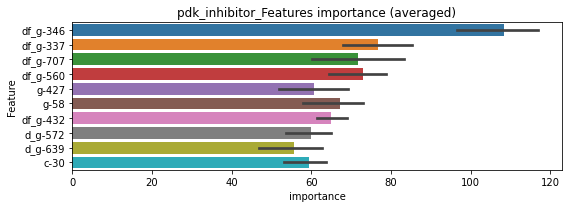

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 pdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0140573	valid_1's binary_logloss: 0.0221479
[200]	training's binary_logloss: 0.00164226	valid_1's binary_logloss: 0.0077451
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.000534915	valid_1's binary_logloss: 0.00694622


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 pdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0148022	valid_1's binary_logloss: 0.0203225
[200]	training's binary_logloss: 0.00182612	valid_1's binary_logloss: 0.0057144
[300]	training's binary_logloss: 0.000486767	valid_1's binary_logloss: 0.00301313
[400]	training's binary_logloss: 0.000243574	valid_1's binary_logloss: 0.00230207
Early stopping, best iteration is:
[463]	training's binary_logloss: 0.000193061	valid_1's binary_logloss: 0.00218411


pdk_inhibitor logloss: 0.004565469251603456


neg labels: 3289 → selected neg labels: 3243


phosphodiesterase_inhibitor, len(trt): 264, len(othr): 3243, target_rate: 0.0110859 → Adj_target_rate: 0.0096064
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101981	valid_1's binary_logloss: 0.285043
[200]	training's binary_logloss: 0.0359341	valid_1's binary_logloss: 0.265035
Early stopping, best iteration is:
[201]	training's binary_logloss: 0.0355026	valid_1's binary_logloss: 0.264982
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114296	valid_1's binary_logloss: 0.261737
[200]	training's binary_logloss: 0.0415213	valid_1's binary_logloss: 0.227925
Early stopping, best iteration is:
[249]	training's binary_logloss: 0.0268715	valid_1's binary_logloss: 0.223168


1 / 3 AUC score:0.913
y_Threshold: 0.0878391, Threshold: 0.1178695, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 407 → Positive_corect_labels: 510/3484
p_label_rate: 0.0200904 Vs.target_rate: 0.01109, Num_p_label: 80.0, conf_0:0.10608, conf_1:0.12966
threshold: 0.1178695, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 510.0/3484, y_label_rate: 0.1463835
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.076053	valid_1's binary_logloss: 0.201915
[200]	training's binary_logloss: 0.0232897	valid_1's binary_logloss: 0.165963
Early stopping, best iteration is:
[234]	training's binary_logloss: 0.0162795	valid_1's binary_logloss: 0.160908
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0716228	valid_1's binary_logloss: 0.195632
[200]	training's binary_logloss: 0.0210369	valid_1's binary_logloss: 0.160612


2 / 3 AUC score:0.974
y_Threshold: 0.0723589, Threshold: 0.1178695, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[281]	training's binary_logloss: 0.00885365	valid_1's binary_logloss: 0.154657


Remove_noisy_labels: 128 → Positive_corect_labels: 446.0/3356
p_label_rate: 0.0060271 Vs.target_rate: 0.01109, Num_p_label: 24.0, conf_0:0.10608, conf_1:0.12966
threshold: 0.1178695, positive_p_label: 24.0/3982, p_label_rate: 0.0060271
positive_y_label: 446.0/3356, y_label_rate: 0.1328963
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0600395	valid_1's binary_logloss: 0.147257
[200]	training's binary_logloss: 0.015873	valid_1's binary_logloss: 0.1093
[300]	training's binary_logloss: 0.00537009	valid_1's binary_logloss: 0.099989
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.00341517	valid_1's binary_logloss: 0.0975246
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0572214	valid_1's binary_logloss: 0.167179
[200]	training's binary_logloss: 0.0147324	valid_1's binary_logloss: 0.135328


3 / 3 AUC score:0.990


Early stopping, best iteration is:
[278]	training's binary_logloss: 0.00623607	valid_1's binary_logloss: 0.129517


y_Threshold: 0.0514674, Threshold: 0.1178695, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 62 → Positive_corect_labels: 415.0/3294
p_label_rate: 0.0047715 Vs.target_rate: 0.01109, Num_p_label: 19.0, conf_0:0.10608, conf_1:0.12966
threshold: 0.1178695, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 434.0/7276, y_label_rate: 0.0596482


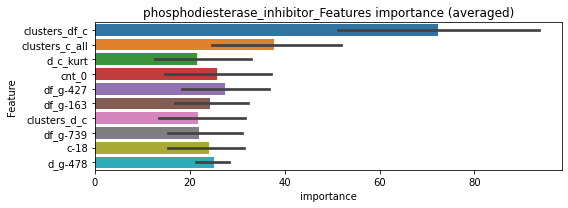

len(train_index) : 3638
len(valid_index) : 3638
================================= fold 1/2 phosphodiesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0277919	valid_1's binary_logloss: 0.0966046
Early stopping, best iteration is:
[169]	training's binary_logloss: 0.0102281	valid_1's binary_logloss: 0.0863735


len(train_index) : 3638
len(valid_index) : 3638
================================= fold 2/2 phosphodiesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0259936	valid_1's binary_logloss: 0.0970168
[200]	training's binary_logloss: 0.00663133	valid_1's binary_logloss: 0.0849932
Early stopping, best iteration is:
[194]	training's binary_logloss: 0.00716352	valid_1's binary_logloss: 0.0845374


phosphodiesterase_inhibitor logloss: 0.0854554479598466
phospholipase_inhibitor, len(trt): 25, len(othr): 3285, target_rate: 0.0010498 → Adj_target_rate: 0.0012955


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0289051	valid_1's binary_logloss: 0.0462875
[200]	training's binary_logloss: 0.00391524	valid_1's binary_logloss: 0.0132856
[300]	training's binary_logloss: 0.00111831	valid_1's binary_logloss: 0.00749785
[400]	training's binary_logloss: 0.000567283	valid_1's binary_logloss: 0.00612743
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000421108	valid_1's binary_logloss: 0.00560914
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0305252	valid_1's binary_logloss: 0.0415763
[200]	training's binary_logloss: 0.00437616	valid_1's binary_logloss: 0.00904773
[300]	training's binary_logloss: 0.00120359	valid_1's binary_logloss: 0.00329681
[400]	training's binary_logloss: 0.000606631	valid_1's binary_logloss: 0.00205575
[500]	training's binary_logloss: 0.000430121	valid_1's binary_logloss: 0.00161025
[600]	training's binary_logloss: 0

1 / 3 AUC score:1.000
y_Threshold: 0.0023627, Threshold: 0.0042468, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00105, Num_p_label: 80.0, conf_0:0.00382, conf_1:0.00467
Num_p_label: 80.0, Expected: 4.2, Adj_threshold_1: 0.0042468
Num_p_label: 17.0, Expected: 4.2, Adj_threshold_2: 0.0142468
Num_p_label: 7.0, Expected: 4.2, Adj_threshold_3: 0.0242468
threshold: 0.0242468, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0290326	valid_1's binary_logloss: 0.046213
[200]	training's binary_logloss: 0.00380846	valid_1's binary_logloss: 0.0136266
[300]	training's binary_logloss: 0.00109433	valid_1's binary_logloss: 0.00868049
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.000660756	valid_1's binary_logloss: 0.00739426
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0300993	valid_1's binary_logloss: 0.0399317
[200]	training's binary_logloss: 0.00413971	valid_1's binary_logloss: 0.00766438
[300]	training's binary_logloss: 0.00116375	valid_1's binary_logloss: 0.00281967
[400]	training's binary_logloss: 0.000590846	valid_1's binary_logloss: 0.00166193
[500]	training's binary_logloss: 0.000428007	valid_1's binary_logloss: 0.00129655
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.00041122	valid_1's binary_logloss: 0.00126054


2 / 3 AUC score:1.000
y_Threshold: 0.0462761, Threshold: 0.0242468, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0060271 Vs.target_rate: 0.00105, Num_p_label: 24.0, conf_0:0.02182, conf_1:0.02667
Num_p_label: 24.0, Expected: 4.2, Adj_threshold_1: 0.0242468
Num_p_label: 17.0, Expected: 4.2, Adj_threshold_2: 0.0342468
Num_p_label: 10.0, Expected: 4.2, Adj_threshold_3: 0.0442468
Num_p_label: 7.0, Expected: 4.2, Adj_threshold_4: 0.0542468
threshold: 0.0542468, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0290326	valid_1's binary_logloss: 0.046213
[200]	training's binary_logloss: 0.00380846	valid_1's binary_logloss: 0.0136266
[300]	training's binary_logloss: 0.00109433	valid_1's binary_logloss: 0.00868049
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.000660756	valid_1's binary_logloss: 0.00739426
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0300993	valid_1's binary_logloss: 0.0399317
[200]	training's binary_logloss: 0.00413971	valid_1's binary_logloss: 0.00766438
[300]	training's binary_logloss: 0.00116375	valid_1's binary_logloss: 0.00281967
[400]	training's binary_logloss: 0.000590846	valid_1's binary_logloss: 0.00166193
[500]	training's binary_logloss: 0.000428007	valid_1's binary_logloss: 0.00129655
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.00041122	valid_1's binary_logloss: 0.00126054


3 / 3 AUC score:1.000
y_Threshold: 0.0462761, Threshold: 0.0542468, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0017579 Vs.target_rate: 0.00105, Num_p_label: 7.0, conf_0:0.04882, conf_1:0.05967
threshold: 0.0542468, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 664.0/7792, y_label_rate: 0.0852156


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 phospholipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158958	valid_1's binary_logloss: 0.0268343
[200]	training's binary_logloss: 0.00220311	valid_1's binary_logloss: 0.0103213
[300]	training's binary_logloss: 0.000606682	valid_1's binary_logloss: 0.00789879
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.000557634	valid_1's binary_logloss: 0.00777363


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 phospholipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161688	valid_1's binary_logloss: 0.0261587
[200]	training's binary_logloss: 0.00214567	valid_1's binary_logloss: 0.00923798
[300]	training's binary_logloss: 0.000614499	valid_1's binary_logloss: 0.00650266
Early stopping, best iteration is:
[377]	training's binary_logloss: 0.000353022	valid_1's binary_logloss: 0.00599948


phospholipase_inhibitor logloss: 0.006886553706995127


neg labels: 3289 → selected neg labels: 3264


pi3k_inhibitor, len(trt): 151, len(othr): 3264, target_rate: 0.0063408 → Adj_target_rate: 0.0059749
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0576504	valid_1's binary_logloss: 0.137471
[200]	training's binary_logloss: 0.0136317	valid_1's binary_logloss: 0.0971879
[300]	training's binary_logloss: 0.00421594	valid_1's binary_logloss: 0.0879973
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.0025119	valid_1's binary_logloss: 0.0852602
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0566376	valid_1's binary_logloss: 0.145794
[200]	training's binary_logloss: 0.0127151	valid_1's binary_logloss: 0.109466
Early stopping, best iteration is:
[273]	training's binary_logloss: 0.00520651	valid_1's binary_logloss: 0.103985


1 / 3 AUC score:0.991
y_Threshold: 0.0266205, Threshold: 0.1439971, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 176 → Positive_corect_labels: 630/3740
p_label_rate: 0.0200904 Vs.target_rate: 0.00634, Num_p_label: 80.0, conf_0:0.12960, conf_1:0.15840
Num_p_label: 80.0, Expected: 25.2, Adj_threshold_1: 0.1439971
Num_p_label: 78.0, Expected: 25.2, Adj_threshold_2: 0.1539971
Num_p_label: 76.0, Expected: 25.2, Adj_threshold_3: 0.1639971
Num_p_label: 74.0, Expected: 25.2, Adj_threshold_4: 0.1739971
Num_p_label: 73.0, Expected: 25.2, Adj_threshold_5: 0.1839971
Num_p_label: 72.0, Expected: 25.2, Adj_threshold_6: 0.1939971
Num_p_label: 72.0, Expected: 25.2, Adj_threshold_7: 0.2039971
Num_p_label: 69.0, Expected: 25.2, Adj_threshold_8: 0.2139971
Num_p_label: 68.0, Expected: 25.2, Adj_threshold_9: 0.2239971
Num_p_label: 67.0, Expected: 25.2, Adj_threshold_10: 0.2339971
threshold: 0.2439971, positive_p_label: 64.0/3982, p_label_rate: 0.0160723
positive_y_label: 630.0/3740, y_label_rate: 0.168449

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.048941	valid_1's binary_logloss: 0.126359
[200]	training's binary_logloss: 0.0100813	valid_1's binary_logloss: 0.0830336
[300]	training's binary_logloss: 0.0030818	valid_1's binary_logloss: 0.0704465
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00169709	valid_1's binary_logloss: 0.0672069
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0477875	valid_1's binary_logloss: 0.120865
[200]	training's binary_logloss: 0.00932361	valid_1's binary_logloss: 0.0857435
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.00357499	valid_1's binary_logloss: 0.0791154


2 / 3 AUC score:0.992
y_Threshold: 0.0857027, Threshold: 0.2439971, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 60 → Positive_corect_labels: 600.0/3680
p_label_rate: 0.0386740 Vs.target_rate: 0.00634, Num_p_label: 154.0, conf_0:0.21960, conf_1:0.26840
Num_p_label: 154.0, Expected: 25.2, Adj_threshold_1: 0.2439971
Num_p_label: 149.0, Expected: 25.2, Adj_threshold_2: 0.2539971
Num_p_label: 148.0, Expected: 25.2, Adj_threshold_3: 0.2639971
Num_p_label: 144.0, Expected: 25.2, Adj_threshold_4: 0.2739971
Num_p_label: 143.0, Expected: 25.2, Adj_threshold_5: 0.2839971
Num_p_label: 139.0, Expected: 25.2, Adj_threshold_6: 0.2939971
Num_p_label: 135.0, Expected: 25.2, Adj_threshold_7: 0.3039971
Num_p_label: 131.0, Expected: 25.2, Adj_threshold_8: 0.3139971
Num_p_label: 128.0, Expected: 25.2, Adj_threshold_9: 0.3239971
Num_p_label: 126.0, Expected: 25.2, Adj_threshold_10: 0.3339971
threshold: 0.3439971, positive_p_label: 123.0/3982, p_label_rate: 0.0308890
positive_y_label: 600.0/3680, y_label_r

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0429197	valid_1's binary_logloss: 0.110106
[200]	training's binary_logloss: 0.00806836	valid_1's binary_logloss: 0.0701466
[300]	training's binary_logloss: 0.00254663	valid_1's binary_logloss: 0.0624216
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00195106	valid_1's binary_logloss: 0.0611876
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0414722	valid_1's binary_logloss: 0.111442
[200]	training's binary_logloss: 0.00775527	valid_1's binary_logloss: 0.0712386
[300]	training's binary_logloss: 0.00245053	valid_1's binary_logloss: 0.0594315
Early stopping, best iteration is:
[364]	training's binary_logloss: 0.00148537	valid_1's binary_logloss: 0.0554466


3 / 3 AUC score:0.998
y_Threshold: 0.0712872, Threshold: 0.3439971, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 42 → Positive_corect_labels: 579.0/3638
p_label_rate: 0.0492215 Vs.target_rate: 0.00634, Num_p_label: 196.0, conf_0:0.30960, conf_1:0.37840
Num_p_label: 196.0, Expected: 25.2, Adj_threshold_1: 0.3439971
Num_p_label: 196.0, Expected: 25.2, Adj_threshold_2: 0.3539971
Num_p_label: 195.0, Expected: 25.2, Adj_threshold_3: 0.3639971
Num_p_label: 195.0, Expected: 25.2, Adj_threshold_4: 0.3739971
Num_p_label: 194.0, Expected: 25.2, Adj_threshold_5: 0.3839971
Num_p_label: 192.0, Expected: 25.2, Adj_threshold_6: 0.3939971
Num_p_label: 191.0, Expected: 25.2, Adj_threshold_7: 0.4039971
Num_p_label: 190.0, Expected: 25.2, Adj_threshold_8: 0.4139971
Num_p_label: 186.0, Expected: 25.2, Adj_threshold_9: 0.4239971
Num_p_label: 185.0, Expected: 25.2, Adj_threshold_10: 0.4339971
threshold: 0.4439971, positive_p_label: 183.0/3982, p_label_rate: 0.0459568
positive_y_label: 762.0/7620, y_label_r

len(train_index) : 3810
len(valid_index) : 3810
================================= fold 1/2 pi3k_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0273583	valid_1's binary_logloss: 0.0769332
[200]	training's binary_logloss: 0.00491769	valid_1's binary_logloss: 0.0565233
Early stopping, best iteration is:
[275]	training's binary_logloss: 0.00188581	valid_1's binary_logloss: 0.0527122


len(train_index) : 3810
len(valid_index) : 3810
================================= fold 2/2 pi3k_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0264765	valid_1's binary_logloss: 0.0738735
[200]	training's binary_logloss: 0.00477819	valid_1's binary_logloss: 0.0544668
[300]	training's binary_logloss: 0.00142555	valid_1's binary_logloss: 0.0496147
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.0013742	valid_1's binary_logloss: 0.0494131


pi3k_inhibitor logloss: 0.05106263716788879
pkc_inhibitor, len(trt): 31, len(othr): 3284, target_rate: 0.0013018 → Adj_target_rate: 0.0015554


neg labels: 3289 → selected neg labels: 3284


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0342263	valid_1's binary_logloss: 0.0559095
[200]	training's binary_logloss: 0.00484065	valid_1's binary_logloss: 0.0177086
[300]	training's binary_logloss: 0.00133453	valid_1's binary_logloss: 0.0105351
[400]	training's binary_logloss: 0.000667296	valid_1's binary_logloss: 0.00887557
Early stopping, best iteration is:
[471]	training's binary_logloss: 0.000492035	valid_1's binary_logloss: 0.00832682
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0328817	valid_1's binary_logloss: 0.0493414
[200]	training's binary_logloss: 0.00480365	valid_1's binary_logloss: 0.0125734
[300]	training's binary_logloss: 0.0013372	valid_1's binary_logloss: 0.00583736
[400]	training's binary_logloss: 0.000659017	valid_1's binary_logloss: 0.00399141
[500]	training's binary_logloss: 0.000454948	valid_1's binary_logloss: 0.00342865
Early stopping, best iteration is:
[5

1 / 3 AUC score:1.000
y_Threshold: 0.0026783, Threshold: 0.0040986, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00130, Num_p_label: 80.0, conf_0:0.00369, conf_1:0.00451
Num_p_label: 80.0, Expected: 5.2, Adj_threshold_1: 0.0040986
Num_p_label: 6.0, Expected: 5.2, Adj_threshold_2: 0.0140986
threshold: 0.0140986, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0335443	valid_1's binary_logloss: 0.0552546
[200]	training's binary_logloss: 0.00456528	valid_1's binary_logloss: 0.0165092
[300]	training's binary_logloss: 0.0012583	valid_1's binary_logloss: 0.00958449
[400]	training's binary_logloss: 0.000635547	valid_1's binary_logloss: 0.00803553
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.000494426	valid_1's binary_logloss: 0.00749255
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0329956	valid_1's binary_logloss: 0.0496637
[200]	training's binary_logloss: 0.0046537	valid_1's binary_logloss: 0.0133133
[300]	training's binary_logloss: 0.00133992	valid_1's binary_logloss: 0.00625951
[400]	training's binary_logloss: 0.000661106	valid_1's binary_logloss: 0.00427288
[500]	training's binary_logloss: 0.000459965	valid_1's binary_logloss: 0.0036485
Early stopping, best iteration is:
[56

2 / 3 AUC score:1.000
y_Threshold: 0.0335382, Threshold: 0.0140986, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0085384 Vs.target_rate: 0.00130, Num_p_label: 34.0, conf_0:0.01269, conf_1:0.01551
Num_p_label: 34.0, Expected: 5.2, Adj_threshold_1: 0.0140986
Num_p_label: 20.0, Expected: 5.2, Adj_threshold_2: 0.0240986
Num_p_label: 10.0, Expected: 5.2, Adj_threshold_3: 0.0340986
threshold: 0.0340986, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0335443	valid_1's binary_logloss: 0.0552546
[200]	training's binary_logloss: 0.00456528	valid_1's binary_logloss: 0.0165092
[300]	training's binary_logloss: 0.0012583	valid_1's binary_logloss: 0.00958449
[400]	training's binary_logloss: 0.000635547	valid_1's binary_logloss: 0.00803553
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.000494426	valid_1's binary_logloss: 0.00749255
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0329956	valid_1's binary_logloss: 0.0496637
[200]	training's binary_logloss: 0.0046537	valid_1's binary_logloss: 0.0133133
[300]	training's binary_logloss: 0.00133992	valid_1's binary_logloss: 0.00625951
[400]	training's binary_logloss: 0.000661106	valid_1's binary_logloss: 0.00427288
[500]	training's binary_logloss: 0.000459965	valid_1's binary_logloss: 0.0036485
Early stopping, best iteration is:
[56

3 / 3 AUC score:1.000
y_Threshold: 0.0335382, Threshold: 0.0340986, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0025113 Vs.target_rate: 0.00130, Num_p_label: 10.0, conf_0:0.03069, conf_1:0.03751
threshold: 0.0340986, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 666.0/7790, y_label_rate: 0.0854942


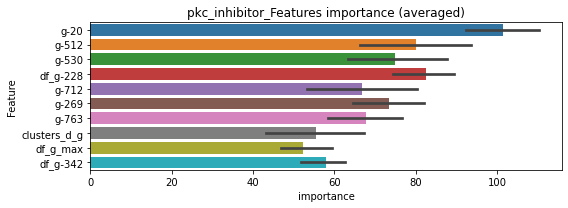

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 pkc_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0178535	valid_1's binary_logloss: 0.0305087
[200]	training's binary_logloss: 0.00246572	valid_1's binary_logloss: 0.0119479
[300]	training's binary_logloss: 0.000689293	valid_1's binary_logloss: 0.00923668
Early stopping, best iteration is:
[326]	training's binary_logloss: 0.000549168	valid_1's binary_logloss: 0.00901942


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 pkc_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0184126	valid_1's binary_logloss: 0.027126
[200]	training's binary_logloss: 0.00269654	valid_1's binary_logloss: 0.00852235
[300]	training's binary_logloss: 0.000735697	valid_1's binary_logloss: 0.00545705
[400]	training's binary_logloss: 0.000362972	valid_1's binary_logloss: 0.00483283
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.000344569	valid_1's binary_logloss: 0.00480787


pkc_inhibitor logloss: 0.00691364591427845
potassium_channel_activator, len(trt): 55, len(othr): 3279, target_rate: 0.0023096 → Adj_target_rate: 0.0025322


neg labels: 3289 → selected neg labels: 3279


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0440585	valid_1's binary_logloss: 0.0805463
[200]	training's binary_logloss: 0.00822547	valid_1's binary_logloss: 0.0309315
[300]	training's binary_logloss: 0.00241151	valid_1's binary_logloss: 0.0179818
[400]	training's binary_logloss: 0.00115656	valid_1's binary_logloss: 0.0138916
[500]	training's binary_logloss: 0.000744888	valid_1's binary_logloss: 0.0122001
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.00064803	valid_1's binary_logloss: 0.0117536
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0460187	valid_1's binary_logloss: 0.0832355
[200]	training's binary_logloss: 0.00858455	valid_1's binary_logloss: 0.0369487
[300]	training's binary_logloss: 0.00245808	valid_1's binary_logloss: 0.0251301
[400]	training's binary_logloss: 0.00115312	valid_1's binary_logloss: 0.0217057
[500]	training's binary_logloss: 0.000739436

1 / 3 AUC score:1.000
y_Threshold: 0.0060977, Threshold: 0.0093364, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 654/3800
p_label_rate: 0.0200904 Vs.target_rate: 0.00231, Num_p_label: 80.0, conf_0:0.00840, conf_1:0.01027
Num_p_label: 80.0, Expected: 9.2, Adj_threshold_1: 0.0093364
Num_p_label: 27.0, Expected: 9.2, Adj_threshold_2: 0.0193364
Num_p_label: 9.0, Expected: 9.2, Adj_threshold_3: 0.0293364
threshold: 0.0293364, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 654.0/3800, y_label_rate: 0.1721053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0435334	valid_1's binary_logloss: 0.0717683
[200]	training's binary_logloss: 0.00816053	valid_1's binary_logloss: 0.0256955
[300]	training's binary_logloss: 0.00240129	valid_1's binary_logloss: 0.0145573
[400]	training's binary_logloss: 0.0011485	valid_1's binary_logloss: 0.0114402
[500]	training's binary_logloss: 0.000736391	valid_1's binary_logloss: 0.00989718
Early stopping, best iteration is:
[581]	training's binary_logloss: 0.000588422	valid_1's binary_logloss: 0.00918035
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0448136	valid_1's binary_logloss: 0.0836818
[200]	training's binary_logloss: 0.00792769	valid_1's binary_logloss: 0.0312417
[300]	training's binary_logloss: 0.00230725	valid_1's binary_logloss: 0.018526
[400]	training's binary_logloss: 0.00110901	valid_1's binary_logloss: 0.0151736
Early stopping, best iteration is:
[478]	tr

2 / 3 AUC score:1.000
y_Threshold: 0.0812445, Threshold: 0.0293364, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 654.0/3800
p_label_rate: 0.0092918 Vs.target_rate: 0.00231, Num_p_label: 37.0, conf_0:0.02640, conf_1:0.03227
Num_p_label: 37.0, Expected: 9.2, Adj_threshold_1: 0.0293364
Num_p_label: 21.0, Expected: 9.2, Adj_threshold_2: 0.0393364
Num_p_label: 13.0, Expected: 9.2, Adj_threshold_3: 0.0493364
threshold: 0.0493364, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 654.0/3800, y_label_rate: 0.1721053
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0435334	valid_1's binary_logloss: 0.0717683
[200]	training's binary_logloss: 0.00816053	valid_1's binary_logloss: 0.0256955
[300]	training's binary_logloss: 0.00240129	valid_1's binary_logloss: 0.0145573
[400]	training's binary_logloss: 0.0011485	valid_1's binary_logloss: 0.0114402
[500]	training's binary_logloss: 0.000736391	valid_1's binary_logloss: 0.00989718
Early stopping, best iteration is:
[581]	training's binary_logloss: 0.000588422	valid_1's binary_logloss: 0.00918035
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0448136	valid_1's binary_logloss: 0.0836818
[200]	training's binary_logloss: 0.00792769	valid_1's binary_logloss: 0.0312417
[300]	training's binary_logloss: 0.00230725	valid_1's binary_logloss: 0.018526
[400]	training's binary_logloss: 0.00110901	valid_1's binary_logloss: 0.0151736
Early stopping, best iteration is:
[478]	tr

3 / 3 AUC score:1.000
y_Threshold: 0.0812445, Threshold: 0.0493364, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 654.0/3800
p_label_rate: 0.0032647 Vs.target_rate: 0.00231, Num_p_label: 13.0, conf_0:0.04440, conf_1:0.05427
threshold: 0.0493364, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 667.0/7782, y_label_rate: 0.0857106


len(train_index) : 3891
len(valid_index) : 3891
================================= fold 1/2 potassium_channel_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0241983	valid_1's binary_logloss: 0.0498645
[200]	training's binary_logloss: 0.00426106	valid_1's binary_logloss: 0.0249174
[300]	training's binary_logloss: 0.00123719	valid_1's binary_logloss: 0.0204077
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.000746804	valid_1's binary_logloss: 0.0195358


len(train_index) : 3891
len(valid_index) : 3891
================================= fold 2/2 potassium_channel_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0252914	valid_1's binary_logloss: 0.0482623
[200]	training's binary_logloss: 0.0048666	valid_1's binary_logloss: 0.0221022
[300]	training's binary_logloss: 0.00140921	valid_1's binary_logloss: 0.0159143
Early stopping, best iteration is:
[389]	training's binary_logloss: 0.000697485	valid_1's binary_logloss: 0.0142877


potassium_channel_activator logloss: 0.016911753408108802
potassium_channel_antagonist, len(trt): 98, len(othr): 3272, target_rate: 0.0041152 → Adj_target_rate: 0.0041375


neg labels: 3289 → selected neg labels: 3272


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.061669	valid_1's binary_logloss: 0.137561
[200]	training's binary_logloss: 0.0155828	valid_1's binary_logloss: 0.0899105
[300]	training's binary_logloss: 0.00496181	valid_1's binary_logloss: 0.0768167
[400]	training's binary_logloss: 0.00215187	valid_1's binary_logloss: 0.0713336
Early stopping, best iteration is:
[418]	training's binary_logloss: 0.00193508	valid_1's binary_logloss: 0.0706093
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0652853	valid_1's binary_logloss: 0.122979
[200]	training's binary_logloss: 0.0168742	valid_1's binary_logloss: 0.0699834
[300]	training's binary_logloss: 0.00527349	valid_1's binary_logloss: 0.0535484
[400]	training's binary_logloss: 0.00231332	valid_1's binary_logloss: 0.0487631
Early stopping, best iteration is:
[438]	training's binary_logloss: 0.00183099	valid_1's binary_logloss: 0.047331


1 / 3 AUC score:0.996
y_Threshold: 0.0134354, Threshold: 0.0179455, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 150 → Positive_corect_labels: 645/3776
p_label_rate: 0.0200904 Vs.target_rate: 0.00412, Num_p_label: 80.0, conf_0:0.01615, conf_1:0.01974
Num_p_label: 80.0, Expected: 16.4, Adj_threshold_1: 0.0179455
Num_p_label: 24.0, Expected: 16.4, Adj_threshold_2: 0.0279455
threshold: 0.0279455, positive_p_label: 24.0/3982, p_label_rate: 0.0060271
positive_y_label: 645.0/3776, y_label_rate: 0.1708157
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0590067	valid_1's binary_logloss: 0.125729
[200]	training's binary_logloss: 0.0139535	valid_1's binary_logloss: 0.0737809
[300]	training's binary_logloss: 0.0044543	valid_1's binary_logloss: 0.0593892
Early stopping, best iteration is:
[388]	training's binary_logloss: 0.00219754	valid_1's binary_logloss: 0.0555458
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0624215	valid_1's binary_logloss: 0.118841
[200]	training's binary_logloss: 0.0158305	valid_1's binary_logloss: 0.0622277
[300]	training's binary_logloss: 0.00497623	valid_1's binary_logloss: 0.0443383
[400]	training's binary_logloss: 0.00225405	valid_1's binary_logloss: 0.0377907
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00169349	valid_1's binary_logloss: 0.0363343


2 / 3 AUC score:0.997
y_Threshold: 0.0376358, Threshold: 0.0279455, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 22 → Positive_corect_labels: 634.0/3754
p_label_rate: 0.0190859 Vs.target_rate: 0.00412, Num_p_label: 76.0, conf_0:0.02515, conf_1:0.03074
Num_p_label: 76.0, Expected: 16.4, Adj_threshold_1: 0.0279455
Num_p_label: 41.0, Expected: 16.4, Adj_threshold_2: 0.0379455
Num_p_label: 26.0, Expected: 16.4, Adj_threshold_3: 0.0479455
threshold: 0.0479455, positive_p_label: 26.0/3982, p_label_rate: 0.0065294
positive_y_label: 634.0/3754, y_label_rate: 0.1688865
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0580856	valid_1's binary_logloss: 0.118711
[200]	training's binary_logloss: 0.0139699	valid_1's binary_logloss: 0.0710502
[300]	training's binary_logloss: 0.00438545	valid_1's binary_logloss: 0.0565255
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00223164	valid_1's binary_logloss: 0.0513545
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0555556	valid_1's binary_logloss: 0.114378
[200]	training's binary_logloss: 0.0133026	valid_1's binary_logloss: 0.0638249
[300]	training's binary_logloss: 0.00424161	valid_1's binary_logloss: 0.0499464
[400]	training's binary_logloss: 0.00191977	valid_1's binary_logloss: 0.0449993
Early stopping, best iteration is:
[418]	training's binary_logloss: 0.00173133	valid_1's binary_logloss: 0.0447845


3 / 3 AUC score:0.998
y_Threshold: 0.0456254, Threshold: 0.0479455, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 22 → Positive_corect_labels: 623.0/3732
p_label_rate: 0.0077850 Vs.target_rate: 0.00412, Num_p_label: 31.0, conf_0:0.04315, conf_1:0.05274
threshold: 0.0479455, positive_p_label: 31.0/3982, p_label_rate: 0.0077850
positive_y_label: 654.0/7714, y_label_rate: 0.0847809


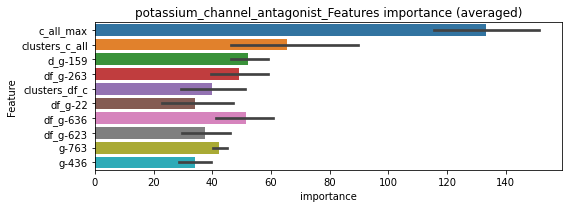

len(train_index) : 3857
len(valid_index) : 3857
================================= fold 1/2 potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0317117	valid_1's binary_logloss: 0.0811649
[200]	training's binary_logloss: 0.00753156	valid_1's binary_logloss: 0.059301
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.00544586	valid_1's binary_logloss: 0.0579132


len(train_index) : 3857
len(valid_index) : 3857
================================= fold 2/2 potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0335214	valid_1's binary_logloss: 0.0716887
[200]	training's binary_logloss: 0.00777194	valid_1's binary_logloss: 0.0440751
[300]	training's binary_logloss: 0.00242396	valid_1's binary_logloss: 0.0375568
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00129016	valid_1's binary_logloss: 0.0361293


potassium_channel_antagonist logloss: 0.0470212638523516
ppar_receptor_agonist, len(trt): 115, len(othr): 3269, target_rate: 0.0048291 → Adj_target_rate: 0.0047401


neg labels: 3289 → selected neg labels: 3269


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0537699	valid_1's binary_logloss: 0.135271
[200]	training's binary_logloss: 0.0119904	valid_1's binary_logloss: 0.0900499
[300]	training's binary_logloss: 0.00385847	valid_1's binary_logloss: 0.0794996
Early stopping, best iteration is:
[377]	training's binary_logloss: 0.00211418	valid_1's binary_logloss: 0.0769983
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0563878	valid_1's binary_logloss: 0.131742
[200]	training's binary_logloss: 0.012834	valid_1's binary_logloss: 0.0823159
[300]	training's binary_logloss: 0.00422938	valid_1's binary_logloss: 0.0701303
Early stopping, best iteration is:
[386]	training's binary_logloss: 0.00216713	valid_1's binary_logloss: 0.0657289


1 / 3 AUC score:0.995
y_Threshold: 0.0177307, Threshold: 0.1027901, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 158 → Positive_corect_labels: 640/3764
p_label_rate: 0.0200904 Vs.target_rate: 0.00483, Num_p_label: 80.0, conf_0:0.09251, conf_1:0.11307
Num_p_label: 80.0, Expected: 19.2, Adj_threshold_1: 0.1027901
Num_p_label: 77.0, Expected: 19.2, Adj_threshold_2: 0.1127901
Num_p_label: 72.0, Expected: 19.2, Adj_threshold_3: 0.1227901
Num_p_label: 67.0, Expected: 19.2, Adj_threshold_4: 0.1327901
Num_p_label: 61.0, Expected: 19.2, Adj_threshold_5: 0.1427901
Num_p_label: 52.0, Expected: 19.2, Adj_threshold_6: 0.1527901
Num_p_label: 50.0, Expected: 19.2, Adj_threshold_7: 0.1627901
Num_p_label: 44.0, Expected: 19.2, Adj_threshold_8: 0.1727901
Num_p_label: 40.0, Expected: 19.2, Adj_threshold_9: 0.1827901
Num_p_label: 36.0, Expected: 19.2, Adj_threshold_10: 0.1927901
threshold: 0.1927901, positive_p_label: 36.0/3982, p_label_rate: 0.0090407
positive_y_label: 640.0/3764, y_label_rate: 0.170031

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0507063	valid_1's binary_logloss: 0.120531
[200]	training's binary_logloss: 0.0110297	valid_1's binary_logloss: 0.077695
[300]	training's binary_logloss: 0.00351288	valid_1's binary_logloss: 0.0680335
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00252085	valid_1's binary_logloss: 0.0659421
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0550906	valid_1's binary_logloss: 0.13076
[200]	training's binary_logloss: 0.011388	valid_1's binary_logloss: 0.0777135
[300]	training's binary_logloss: 0.00368705	valid_1's binary_logloss: 0.0655659
[400]	training's binary_logloss: 0.00175341	valid_1's binary_logloss: 0.0611804
Early stopping, best iteration is:
[407]	training's binary_logloss: 0.00168801	valid_1's binary_logloss: 0.0610734


2 / 3 AUC score:0.997
y_Threshold: 0.0485144, Threshold: 0.1927901, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 46 → Positive_corect_labels: 617.0/3718
p_label_rate: 0.0261175 Vs.target_rate: 0.00483, Num_p_label: 104.0, conf_0:0.17351, conf_1:0.21207
Num_p_label: 104.0, Expected: 19.2, Adj_threshold_1: 0.1927901
Num_p_label: 100.0, Expected: 19.2, Adj_threshold_2: 0.2027901
Num_p_label: 95.0, Expected: 19.2, Adj_threshold_3: 0.2127901
Num_p_label: 90.0, Expected: 19.2, Adj_threshold_4: 0.2227901
Num_p_label: 87.0, Expected: 19.2, Adj_threshold_5: 0.2327901
Num_p_label: 86.0, Expected: 19.2, Adj_threshold_6: 0.2427901
Num_p_label: 81.0, Expected: 19.2, Adj_threshold_7: 0.2527901
Num_p_label: 79.0, Expected: 19.2, Adj_threshold_8: 0.2627901
Num_p_label: 78.0, Expected: 19.2, Adj_threshold_9: 0.2727901
Num_p_label: 75.0, Expected: 19.2, Adj_threshold_10: 0.2827901
threshold: 0.2927901, positive_p_label: 70.0/3982, p_label_rate: 0.0175791
positive_y_label: 617.0/3718, y_label_rate: 0.16

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0495868	valid_1's binary_logloss: 0.101426
[200]	training's binary_logloss: 0.0104003	valid_1's binary_logloss: 0.05366
[300]	training's binary_logloss: 0.00332125	valid_1's binary_logloss: 0.0413873
[400]	training's binary_logloss: 0.00158767	valid_1's binary_logloss: 0.0372927
[500]	training's binary_logloss: 0.00100649	valid_1's binary_logloss: 0.0352672
Early stopping, best iteration is:
[541]	training's binary_logloss: 0.000887287	valid_1's binary_logloss: 0.0346784
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.048996	valid_1's binary_logloss: 0.112866
[200]	training's binary_logloss: 0.00995822	valid_1's binary_logloss: 0.0688609
[300]	training's binary_logloss: 0.00320389	valid_1's binary_logloss: 0.0596646
[400]	training's binary_logloss: 0.00152916	valid_1's binary_logloss: 0.0549834
Early stopping, best iteration is:
[407]	training'

3 / 3 AUC score:0.998
y_Threshold: 0.0406970, Threshold: 0.2927901, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 22 → Positive_corect_labels: 606.0/3696
p_label_rate: 0.0266198 Vs.target_rate: 0.00483, Num_p_label: 106.0, conf_0:0.26351, conf_1:0.32207
Num_p_label: 106.0, Expected: 19.2, Adj_threshold_1: 0.2927901
Num_p_label: 106.0, Expected: 19.2, Adj_threshold_2: 0.3027901
Num_p_label: 104.0, Expected: 19.2, Adj_threshold_3: 0.3127901
Num_p_label: 103.0, Expected: 19.2, Adj_threshold_4: 0.3227901
Num_p_label: 101.0, Expected: 19.2, Adj_threshold_5: 0.3327901
Num_p_label: 98.0, Expected: 19.2, Adj_threshold_6: 0.3427901
Num_p_label: 97.0, Expected: 19.2, Adj_threshold_7: 0.3527901
Num_p_label: 95.0, Expected: 19.2, Adj_threshold_8: 0.3627901
Num_p_label: 95.0, Expected: 19.2, Adj_threshold_9: 0.3727901
Num_p_label: 94.0, Expected: 19.2, Adj_threshold_10: 0.3827901
threshold: 0.3927901, positive_p_label: 91.0/3982, p_label_rate: 0.0228528
positive_y_label: 697.0/7678, y_label_rate: 0

len(train_index) : 3839
len(valid_index) : 3839
================================= fold 1/2 ppar_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0287784	valid_1's binary_logloss: 0.066441
[200]	training's binary_logloss: 0.00581851	valid_1's binary_logloss: 0.0376622
[300]	training's binary_logloss: 0.00186051	valid_1's binary_logloss: 0.0303979
[400]	training's binary_logloss: 0.000885895	valid_1's binary_logloss: 0.0282443
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000662303	valid_1's binary_logloss: 0.0275597


len(train_index) : 3839
len(valid_index) : 3839
================================= fold 2/2 ppar_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0282084	valid_1's binary_logloss: 0.072505
[200]	training's binary_logloss: 0.00585425	valid_1's binary_logloss: 0.0463973
[300]	training's binary_logloss: 0.00181149	valid_1's binary_logloss: 0.040537
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.00172557	valid_1's binary_logloss: 0.0404335


ppar_receptor_agonist logloss: 0.03399656166113951
ppar_receptor_antagonist, len(trt): 30, len(othr): 3284, target_rate: 0.0012598 → Adj_target_rate: 0.0015127


neg labels: 3289 → selected neg labels: 3284


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0345298	valid_1's binary_logloss: 0.0500132
[200]	training's binary_logloss: 0.00499915	valid_1's binary_logloss: 0.0122834
[300]	training's binary_logloss: 0.00136931	valid_1's binary_logloss: 0.00529526
[400]	training's binary_logloss: 0.000666616	valid_1's binary_logloss: 0.00359555
[500]	training's binary_logloss: 0.000456875	valid_1's binary_logloss: 0.00295959
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.000417551	valid_1's binary_logloss: 0.00284604
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0333882	valid_1's binary_logloss: 0.0595083
[200]	training's binary_logloss: 0.00491101	valid_1's binary_logloss: 0.0224411
[300]	training's binary_logloss: 0.00135431	valid_1's binary_logloss: 0.014246
[400]	training's binary_logloss: 0.000663969	valid_1's binary_logloss: 0.0117322
[500]	training's binary_logloss: 0.000

1 / 3 AUC score:1.000
y_Threshold: 0.0030706, Threshold: 0.0054895, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00126, Num_p_label: 80.0, conf_0:0.00494, conf_1:0.00604
Num_p_label: 80.0, Expected: 5.0, Adj_threshold_1: 0.0054895
Num_p_label: 12.0, Expected: 5.0, Adj_threshold_2: 0.0154895
Num_p_label: 6.0, Expected: 5.0, Adj_threshold_3: 0.0254895
threshold: 0.0254895, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0334976	valid_1's binary_logloss: 0.048012
[200]	training's binary_logloss: 0.00482228	valid_1's binary_logloss: 0.0117828
[300]	training's binary_logloss: 0.00132866	valid_1's binary_logloss: 0.00534875
[400]	training's binary_logloss: 0.000655939	valid_1's binary_logloss: 0.00363498
[500]	training's binary_logloss: 0.000453287	valid_1's binary_logloss: 0.00301761
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.00042976	valid_1's binary_logloss: 0.00294279
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0327373	valid_1's binary_logloss: 0.0565169
[200]	training's binary_logloss: 0.0046528	valid_1's binary_logloss: 0.0195497
[300]	training's binary_logloss: 0.00130907	valid_1's binary_logloss: 0.0123485
[400]	training's binary_logloss: 0.000653763	valid_1's binary_logloss: 0.0101915
Early stopping, best iteration is:
[466]

2 / 3 AUC score:1.000
y_Threshold: 0.0315919, Threshold: 0.0254895, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0057760 Vs.target_rate: 0.00126, Num_p_label: 23.0, conf_0:0.02294, conf_1:0.02804
Num_p_label: 23.0, Expected: 5.0, Adj_threshold_1: 0.0254895
Num_p_label: 16.0, Expected: 5.0, Adj_threshold_2: 0.0354895
Num_p_label: 10.0, Expected: 5.0, Adj_threshold_3: 0.0454895
threshold: 0.0454895, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0334976	valid_1's binary_logloss: 0.048012
[200]	training's binary_logloss: 0.00482228	valid_1's binary_logloss: 0.0117828
[300]	training's binary_logloss: 0.00132866	valid_1's binary_logloss: 0.00534875
[400]	training's binary_logloss: 0.000655939	valid_1's binary_logloss: 0.00363498
[500]	training's binary_logloss: 0.000453287	valid_1's binary_logloss: 0.00301761
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.00042976	valid_1's binary_logloss: 0.00294279
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0327373	valid_1's binary_logloss: 0.0565169
[200]	training's binary_logloss: 0.0046528	valid_1's binary_logloss: 0.0195497
[300]	training's binary_logloss: 0.00130907	valid_1's binary_logloss: 0.0123485
[400]	training's binary_logloss: 0.000653763	valid_1's binary_logloss: 0.0101915
Early stopping, best iteration is:
[466]

3 / 3 AUC score:1.000
y_Threshold: 0.0315919, Threshold: 0.0454895, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0025113 Vs.target_rate: 0.00126, Num_p_label: 10.0, conf_0:0.04094, conf_1:0.05004
threshold: 0.0454895, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 666.0/7790, y_label_rate: 0.0854942


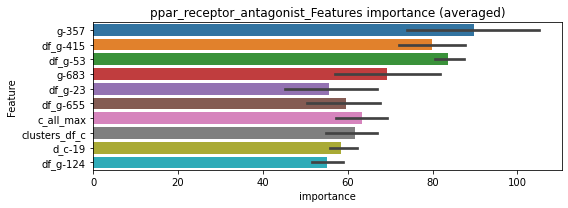

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 ppar_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0186011	valid_1's binary_logloss: 0.0339611
[200]	training's binary_logloss: 0.00267398	valid_1's binary_logloss: 0.0166807
Early stopping, best iteration is:
[231]	training's binary_logloss: 0.00163511	valid_1's binary_logloss: 0.015868


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 ppar_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0187226	valid_1's binary_logloss: 0.0326014
[200]	training's binary_logloss: 0.00277167	valid_1's binary_logloss: 0.0155136
[300]	training's binary_logloss: 0.00076598	valid_1's binary_logloss: 0.0118811
Early stopping, best iteration is:
[364]	training's binary_logloss: 0.000456404	valid_1's binary_logloss: 0.0110714


ppar_receptor_antagonist logloss: 0.013469675659067313
progesterone_receptor_agonist, len(trt): 119, len(othr): 3271, target_rate: 0.0049971 → Adj_target_rate: 0.0048799


neg labels: 3289 → selected neg labels: 3271


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0662326	valid_1's binary_logloss: 0.161133
[200]	training's binary_logloss: 0.0165798	valid_1's binary_logloss: 0.113083
[300]	training's binary_logloss: 0.00507691	valid_1's binary_logloss: 0.101472
Early stopping, best iteration is:
[382]	training's binary_logloss: 0.00259829	valid_1's binary_logloss: 0.0984845
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0686432	valid_1's binary_logloss: 0.153648
[200]	training's binary_logloss: 0.0175211	valid_1's binary_logloss: 0.0991404
[300]	training's binary_logloss: 0.00649628	valid_1's binary_logloss: 0.0842075
Early stopping, best iteration is:
[357]	training's binary_logloss: 0.00450915	valid_1's binary_logloss: 0.0815273


1 / 3 AUC score:0.991
y_Threshold: 0.0223345, Threshold: 0.0254836, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 177 → Positive_corect_labels: 631/3748
p_label_rate: 0.0200904 Vs.target_rate: 0.00500, Num_p_label: 80.0, conf_0:0.02294, conf_1:0.02803
Num_p_label: 80.0, Expected: 19.9, Adj_threshold_1: 0.0254836
Num_p_label: 48.0, Expected: 19.9, Adj_threshold_2: 0.0354836
Num_p_label: 34.0, Expected: 19.9, Adj_threshold_3: 0.0454836
threshold: 0.0454836, positive_p_label: 34.0/3982, p_label_rate: 0.0085384
positive_y_label: 631.0/3748, y_label_rate: 0.1683565
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0589356	valid_1's binary_logloss: 0.152566
[200]	training's binary_logloss: 0.013298	valid_1's binary_logloss: 0.10413
[300]	training's binary_logloss: 0.00422085	valid_1's binary_logloss: 0.0932116
Early stopping, best iteration is:
[359]	training's binary_logloss: 0.00260548	valid_1's binary_logloss: 0.0915103
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.064186	valid_1's binary_logloss: 0.141307
[200]	training's binary_logloss: 0.016309	valid_1's binary_logloss: 0.0906465
[300]	training's binary_logloss: 0.0052083	valid_1's binary_logloss: 0.0762268
[400]	training's binary_logloss: 0.0023529	valid_1's binary_logloss: 0.0708057
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.0022763	valid_1's binary_logloss: 0.0707139


2 / 3 AUC score:0.995
y_Threshold: 0.0407719, Threshold: 0.0454836, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 50 → Positive_corect_labels: 606.0/3698
p_label_rate: 0.0107986 Vs.target_rate: 0.00500, Num_p_label: 43.0, conf_0:0.04094, conf_1:0.05003
threshold: 0.0454836, positive_p_label: 43.0/3982, p_label_rate: 0.0107986
positive_y_label: 606.0/3698, y_label_rate: 0.1638724
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0564362	valid_1's binary_logloss: 0.130909
[200]	training's binary_logloss: 0.0127225	valid_1's binary_logloss: 0.0843832
[300]	training's binary_logloss: 0.00392394	valid_1's binary_logloss: 0.0724238
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00256754	valid_1's binary_logloss: 0.070291
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.060116	valid_1's binary_logloss: 0.123248
[200]	training's binary_logloss: 0.0138786	valid_1's binary_logloss: 0.0727181
[300]	training's binary_logloss: 0.00444584	valid_1's binary_logloss: 0.0606102
Early stopping, best iteration is:
[318]	training's binary_logloss: 0.00376471	valid_1's binary_logloss: 0.0594109


3 / 3 AUC score:0.997
y_Threshold: 0.0446665, Threshold: 0.0454836, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 32 → Positive_corect_labels: 590.0/3666
p_label_rate: 0.0150678 Vs.target_rate: 0.00500, Num_p_label: 60.0, conf_0:0.04094, conf_1:0.05003
Num_p_label: 60.0, Expected: 19.9, Adj_threshold_1: 0.0454836
Num_p_label: 38.0, Expected: 19.9, Adj_threshold_2: 0.0554836
threshold: 0.0554836, positive_p_label: 38.0/3982, p_label_rate: 0.0095429
positive_y_label: 628.0/7648, y_label_rate: 0.0821130


len(train_index) : 3824
len(valid_index) : 3824
================================= fold 1/2 progesterone_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0346025	valid_1's binary_logloss: 0.0955213
[200]	training's binary_logloss: 0.00816146	valid_1's binary_logloss: 0.0750548
Early stopping, best iteration is:
[247]	training's binary_logloss: 0.00457308	valid_1's binary_logloss: 0.0724155


len(train_index) : 3824
len(valid_index) : 3824
================================= fold 2/2 progesterone_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0330627	valid_1's binary_logloss: 0.0849919
[200]	training's binary_logloss: 0.00752192	valid_1's binary_logloss: 0.061697
[300]	training's binary_logloss: 0.00236467	valid_1's binary_logloss: 0.0565113
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.00240799	valid_1's binary_logloss: 0.056391


progesterone_receptor_agonist logloss: 0.06440322816523841
progesterone_receptor_antagonist, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0220361	valid_1's binary_logloss: 0.0313598
[200]	training's binary_logloss: 0.002519	valid_1's binary_logloss: 0.00709468
[300]	training's binary_logloss: 0.000712392	valid_1's binary_logloss: 0.0038407
[400]	training's binary_logloss: 0.000383337	valid_1's binary_logloss: 0.00301679
Early stopping, best iteration is:
[457]	training's binary_logloss: 0.000325081	valid_1's binary_logloss: 0.0028401
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0229906	valid_1's binary_logloss: 0.0306549
[200]	training's binary_logloss: 0.00266431	valid_1's binary_logloss: 0.00447758
[300]	training's binary_logloss: 0.000752519	valid_1's binary_logloss: 0.00158114
[400]	training's binary_logloss: 0.000406244	valid_1's binary_logloss: 0.00100181
[500]	training's binary_logloss: 0.00032156	valid_1's binary_logloss: 0.000832093
Early stopping, best iteration is:


1 / 3 AUC score:1.000
y_Threshold: 0.0014316, Threshold: 0.0026288, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076, Num_p_label: 80.0, conf_0:0.00237, conf_1:0.00289
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0026288
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_2: 0.0126288
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_3: 0.0226288
threshold: 0.0226288, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0222337	valid_1's binary_logloss: 0.0314801
[200]	training's binary_logloss: 0.00251957	valid_1's binary_logloss: 0.00799698
[300]	training's binary_logloss: 0.000713161	valid_1's binary_logloss: 0.00494574
[400]	training's binary_logloss: 0.000383622	valid_1's binary_logloss: 0.00398782
Early stopping, best iteration is:
[433]	training's binary_logloss: 0.000345642	valid_1's binary_logloss: 0.00385316
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0226879	valid_1's binary_logloss: 0.0305854
[200]	training's binary_logloss: 0.00255929	valid_1's binary_logloss: 0.00429204
[300]	training's binary_logloss: 0.000720203	valid_1's binary_logloss: 0.00147626
[400]	training's binary_logloss: 0.00039488	valid_1's binary_logloss: 0.000926902
[500]	training's binary_logloss: 0.000314224	valid_1's binary_logloss: 0.000766746
Early stopping, best iteration

2 / 3 AUC score:1.000
y_Threshold: 0.0330615, Threshold: 0.0226288, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0052737 Vs.target_rate: 0.00076, Num_p_label: 21.0, conf_0:0.02037, conf_1:0.02489
Num_p_label: 21.0, Expected: 3.0, Adj_threshold_1: 0.0226288
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_2: 0.0326288
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_3: 0.0426288
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_4: 0.0526288
threshold: 0.0526288, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0222337	valid_1's binary_logloss: 0.0314801
[200]	training's binary_logloss: 0.00251957	valid_1's binary_logloss: 0.00799698
[300]	training's binary_logloss: 0.000713161	valid_1's binary_logloss: 0.00494574
[400]	training's binary_logloss: 0.000383622	valid_1's binary_logloss: 0.00398782
Early stopping, best iteration is:
[433]	training's binary_logloss: 0.000345642	valid_1's binary_logloss: 0.00385316
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0226879	valid_1's binary_logloss: 0.0305854
[200]	training's binary_logloss: 0.00255929	valid_1's binary_logloss: 0.00429204
[300]	training's binary_logloss: 0.000720203	valid_1's binary_logloss: 0.00147626
[400]	training's binary_logloss: 0.00039488	valid_1's binary_logloss: 0.000926902
[500]	training's binary_logloss: 0.000314224	valid_1's binary_logloss: 0.000766746
Early stopping, best iteration

3 / 3 AUC score:1.000
y_Threshold: 0.0330615, Threshold: 0.0526288, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0015068 Vs.target_rate: 0.00076, Num_p_label: 6.0, conf_0:0.04737, conf_1:0.05789
threshold: 0.0526288, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 663.0/7793, y_label_rate: 0.0850764


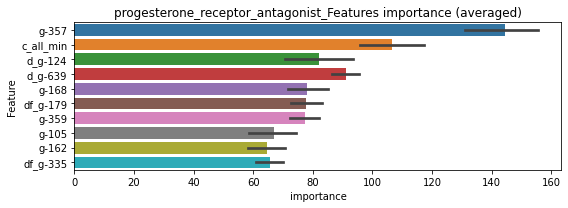

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 progesterone_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0118997	valid_1's binary_logloss: 0.0183929
[200]	training's binary_logloss: 0.00131815	valid_1's binary_logloss: 0.00668436
Early stopping, best iteration is:
[276]	training's binary_logloss: 0.000458683	valid_1's binary_logloss: 0.00591143


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 progesterone_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0120612	valid_1's binary_logloss: 0.0188203
[200]	training's binary_logloss: 0.00142094	valid_1's binary_logloss: 0.00516486
[300]	training's binary_logloss: 0.000399494	valid_1's binary_logloss: 0.00290094
[400]	training's binary_logloss: 0.000212149	valid_1's binary_logloss: 0.00229876
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000170385	valid_1's binary_logloss: 0.00210957


progesterone_receptor_antagonist logloss: 0.004010744128576415
prostaglandin_inhibitor, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0355139	valid_1's binary_logloss: 0.0590154
[200]	training's binary_logloss: 0.00590342	valid_1's binary_logloss: 0.0184633
[300]	training's binary_logloss: 0.00162435	valid_1's binary_logloss: 0.00980641
[400]	training's binary_logloss: 0.00079491	valid_1's binary_logloss: 0.0072808
[500]	training's binary_logloss: 0.000525515	valid_1's binary_logloss: 0.0062695
Early stopping, best iteration is:
[509]	training's binary_logloss: 0.000513231	valid_1's binary_logloss: 0.00622413
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0369096	valid_1's binary_logloss: 0.0663922
[200]	training's binary_logloss: 0.00579998	valid_1's binary_logloss: 0.02936
[300]	training's binary_logloss: 0.00161649	valid_1's binary_logloss: 0.0206962
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00115502	valid_1's binary_logloss: 0.0194673


1 / 3 AUC score:1.000
y_Threshold: 0.0053597, Threshold: 0.0071075, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 655/3805
p_label_rate: 0.0200904 Vs.target_rate: 0.00151, Num_p_label: 80.0, conf_0:0.00640, conf_1:0.00782
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0071075
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_2: 0.0171075
Num_p_label: 6.0, Expected: 6.0, Adj_threshold_3: 0.0271075
threshold: 0.0271075, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 655.0/3805, y_label_rate: 0.1721419
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0363754	valid_1's binary_logloss: 0.0568422
[200]	training's binary_logloss: 0.00549453	valid_1's binary_logloss: 0.0168193
[300]	training's binary_logloss: 0.00157326	valid_1's binary_logloss: 0.0100772
[400]	training's binary_logloss: 0.000773671	valid_1's binary_logloss: 0.00849596
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.00063585	valid_1's binary_logloss: 0.00820205
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0347587	valid_1's binary_logloss: 0.0617173
[200]	training's binary_logloss: 0.00530323	valid_1's binary_logloss: 0.0204691
[300]	training's binary_logloss: 0.0015074	valid_1's binary_logloss: 0.0123606
[400]	training's binary_logloss: 0.000747124	valid_1's binary_logloss: 0.00977053
Early stopping, best iteration is:
[431]	training's binary_logloss: 0.000646755	valid_1's binary_logloss: 0.00931315


2 / 3 AUC score:1.000
y_Threshold: 0.0414924, Threshold: 0.0271075, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 654.0/3803
p_label_rate: 0.0040181 Vs.target_rate: 0.00151, Num_p_label: 16.0, conf_0:0.02440, conf_1:0.02982
threshold: 0.0271075, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 654.0/3803, y_label_rate: 0.1719695
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.03595	valid_1's binary_logloss: 0.0553229
[200]	training's binary_logloss: 0.0056238	valid_1's binary_logloss: 0.015191
[300]	training's binary_logloss: 0.00159245	valid_1's binary_logloss: 0.00709149
[400]	training's binary_logloss: 0.000784071	valid_1's binary_logloss: 0.00525139
[500]	training's binary_logloss: 0.000528203	valid_1's binary_logloss: 0.00451429
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.000492109	valid_1's binary_logloss: 0.00446275
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0345454	valid_1's binary_logloss: 0.0611312
[200]	training's binary_logloss: 0.00514717	valid_1's binary_logloss: 0.0204138
[300]	training's binary_logloss: 0.00148259	valid_1's binary_logloss: 0.0127669
[400]	training's binary_logloss: 0.000738765	valid_1's binary_logloss: 0.0104606
Early stopping, best iteration is:
[476]	

3 / 3 AUC score:1.000
y_Threshold: 0.0397558, Threshold: 0.0271075, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 653.0/3801
p_label_rate: 0.0027624 Vs.target_rate: 0.00151, Num_p_label: 11.0, conf_0:0.02440, conf_1:0.02982
threshold: 0.0271075, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 664.0/7783, y_label_rate: 0.0853141


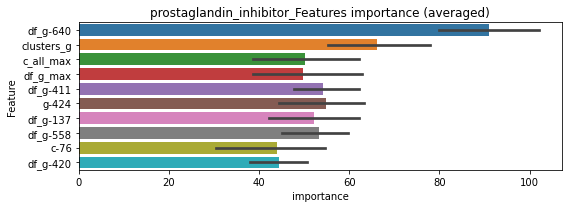

len(train_index) : 3891
len(valid_index) : 3892
================================= fold 1/2 prostaglandin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0178019	valid_1's binary_logloss: 0.0395593
[200]	training's binary_logloss: 0.00275833	valid_1's binary_logloss: 0.0197895
[300]	training's binary_logloss: 0.000793161	valid_1's binary_logloss: 0.0169118
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.000649122	valid_1's binary_logloss: 0.0165289


len(train_index) : 3892
len(valid_index) : 3891
================================= fold 2/2 prostaglandin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0202484	valid_1's binary_logloss: 0.0369523
[200]	training's binary_logloss: 0.0030793	valid_1's binary_logloss: 0.0140642
[300]	training's binary_logloss: 0.000865829	valid_1's binary_logloss: 0.0100668
[400]	training's binary_logloss: 0.00041667	valid_1's binary_logloss: 0.00891623
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.000369014	valid_1's binary_logloss: 0.00871935


prostaglandin_inhibitor logloss: 0.012624629280449775
prostanoid_receptor_antagonist, len(trt): 84, len(othr): 3274, target_rate: 0.0035273 → Adj_target_rate: 0.0036294


neg labels: 3289 → selected neg labels: 3274


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0563621	valid_1's binary_logloss: 0.115737
[200]	training's binary_logloss: 0.0135372	valid_1's binary_logloss: 0.0701705
[300]	training's binary_logloss: 0.00417155	valid_1's binary_logloss: 0.0583268
[400]	training's binary_logloss: 0.00186591	valid_1's binary_logloss: 0.0540305
Early stopping, best iteration is:
[407]	training's binary_logloss: 0.00178454	valid_1's binary_logloss: 0.0538814
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0546389	valid_1's binary_logloss: 0.0982618
[200]	training's binary_logloss: 0.0125552	valid_1's binary_logloss: 0.054086
[300]	training's binary_logloss: 0.00396253	valid_1's binary_logloss: 0.042092
[400]	training's binary_logloss: 0.00183811	valid_1's binary_logloss: 0.037479
Early stopping, best iteration is:
[471]	training's binary_logloss: 0.00128319	valid_1's binary_logloss: 0.0362262


1 / 3 AUC score:0.998
y_Threshold: 0.0100950, Threshold: 0.0144327, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 142 → Positive_corect_labels: 649/3786
p_label_rate: 0.0200904 Vs.target_rate: 0.00353, Num_p_label: 80.0, conf_0:0.01299, conf_1:0.01588
Num_p_label: 80.0, Expected: 14.0, Adj_threshold_1: 0.0144327
Num_p_label: 34.0, Expected: 14.0, Adj_threshold_2: 0.0244327
Num_p_label: 17.0, Expected: 14.0, Adj_threshold_3: 0.0344327
threshold: 0.0344327, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 649.0/3786, y_label_rate: 0.1714210
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0503855	valid_1's binary_logloss: 0.112713
[200]	training's binary_logloss: 0.0113595	valid_1's binary_logloss: 0.0662692
[300]	training's binary_logloss: 0.00360977	valid_1's binary_logloss: 0.0524352
[400]	training's binary_logloss: 0.00168052	valid_1's binary_logloss: 0.0478631
Early stopping, best iteration is:
[433]	training's binary_logloss: 0.00139724	valid_1's binary_logloss: 0.0471565
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0549584	valid_1's binary_logloss: 0.111659
[200]	training's binary_logloss: 0.0126454	valid_1's binary_logloss: 0.0661098
[300]	training's binary_logloss: 0.0039688	valid_1's binary_logloss: 0.0530181
[400]	training's binary_logloss: 0.0017989	valid_1's binary_logloss: 0.0491372
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.00189824	valid_1's binary_logloss: 0.0489608


2 / 3 AUC score:0.998
y_Threshold: 0.0300574, Threshold: 0.0344327, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 22 → Positive_corect_labels: 638.0/3764
p_label_rate: 0.0067805 Vs.target_rate: 0.00353, Num_p_label: 27.0, conf_0:0.03099, conf_1:0.03788
threshold: 0.0344327, positive_p_label: 27.0/3982, p_label_rate: 0.0067805
positive_y_label: 638.0/3764, y_label_rate: 0.1695005
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0514502	valid_1's binary_logloss: 0.0955361
[200]	training's binary_logloss: 0.0116797	valid_1's binary_logloss: 0.0518512
[300]	training's binary_logloss: 0.00364756	valid_1's binary_logloss: 0.0390176
[400]	training's binary_logloss: 0.00168472	valid_1's binary_logloss: 0.0342182
[500]	training's binary_logloss: 0.00103511	valid_1's binary_logloss: 0.0324486
Early stopping, best iteration is:
[566]	training's binary_logloss: 0.000831216	valid_1's binary_logloss: 0.0315302
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0513419	valid_1's binary_logloss: 0.10283
[200]	training's binary_logloss: 0.0117031	valid_1's binary_logloss: 0.060585
[300]	training's binary_logloss: 0.00360198	valid_1's binary_logloss: 0.0492323
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00252663	valid_1's binary_logloss: 0.0471612


3 / 3 AUC score:0.999
y_Threshold: 0.0322256, Threshold: 0.0344327, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 16 → Positive_corect_labels: 630.0/3748
p_label_rate: 0.0072828 Vs.target_rate: 0.00353, Num_p_label: 29.0, conf_0:0.03099, conf_1:0.03788
threshold: 0.0344327, positive_p_label: 29.0/3982, p_label_rate: 0.0072828
positive_y_label: 659.0/7730, y_label_rate: 0.0852523


len(train_index) : 3865
len(valid_index) : 3865
================================= fold 1/2 prostanoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0291822	valid_1's binary_logloss: 0.0712731
[200]	training's binary_logloss: 0.00645905	valid_1's binary_logloss: 0.0490809
[300]	training's binary_logloss: 0.00198693	valid_1's binary_logloss: 0.0443549
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.00188731	valid_1's binary_logloss: 0.0441993


len(train_index) : 3865
len(valid_index) : 3865
================================= fold 2/2 prostanoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0311023	valid_1's binary_logloss: 0.064797
[200]	training's binary_logloss: 0.00721656	valid_1's binary_logloss: 0.0396529
[300]	training's binary_logloss: 0.00221563	valid_1's binary_logloss: 0.0349106
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00160506	valid_1's binary_logloss: 0.0343572


prostanoid_receptor_antagonist logloss: 0.03927823477084687
proteasome_inhibitor, len(trt): 726, len(othr): 3285, target_rate: 0.0304863 → Adj_target_rate: 0.0226983
================= Pseudo labeling 1 / 3 =================


neg labels: 3289 → selected neg labels: 3285
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.020979	valid_1's binary_logloss: 0.0236758
[200]	training's binary_logloss: 0.00200828	valid_1's binary_logloss: 0.00687922
Early stopping, best iteration is:
[240]	training's binary_logloss: 0.000990366	valid_1's binary_logloss: 0.00584641
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0194643	valid_1's binary_logloss: 0.0282181
[200]	training's binary_logloss: 0.00187077	valid_1's binary_logloss: 0.0123994
[300]	training's binary_logloss: 0.000437351	valid_1's binary_logloss: 0.010749
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.000455901	valid_1's binary_logloss: 0.0107215


1 / 3 AUC score:1.000
y_Threshold: 0.0003578, Threshold: 0.9986985, pos_neg_ratio: 0.7789954
Remove_noisy_labels: 161 → Positive_corect_labels: 726/3850
p_label_rate: 0.0200904 Vs.target_rate: 0.03049, Num_p_label: 80.0, conf_0:0.89883, conf_1:1.09857
threshold: 0.9986985, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 726.0/3850, y_label_rate: 0.1885714
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0156085	valid_1's binary_logloss: 0.0160616
[200]	training's binary_logloss: 0.00100649	valid_1's binary_logloss: 0.00137232
[300]	training's binary_logloss: 0.000221792	valid_1's binary_logloss: 0.000572287
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00017147	valid_1's binary_logloss: 0.000511025
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157067	valid_1's binary_logloss: 0.0163062
[200]	training's binary_logloss: 0.00101882	valid_1's binary_logloss: 0.00124747
[300]	training's binary_logloss: 0.000224852	valid_1's binary_logloss: 0.000412599
[400]	training's binary_logloss: 0.000148419	valid_1's binary_logloss: 0.000320927
[500]	training's binary_logloss: 0.000133704	valid_1's binary_logloss: 0.00030336


2 / 3 AUC score:1.000
y_Threshold: 0.5401972, Threshold: 0.9986985, pos_neg_ratio: 0.7789954
Remove_noisy_labels: 0 → Positive_corect_labels: 726.0/3850
p_label_rate: 0.0379206 Vs.target_rate: 0.03049, Num_p_label: 151.0, conf_0:0.89883, conf_1:1.09857


Early stopping, best iteration is:
[585]	training's binary_logloss: 0.000130916	valid_1's binary_logloss: 0.000300934


threshold: 0.9986985, positive_p_label: 151.0/3982, p_label_rate: 0.0379206
positive_y_label: 726.0/3850, y_label_rate: 0.1885714
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0156085	valid_1's binary_logloss: 0.0160616
[200]	training's binary_logloss: 0.00100649	valid_1's binary_logloss: 0.00137232
[300]	training's binary_logloss: 0.000221792	valid_1's binary_logloss: 0.000572287
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00017147	valid_1's binary_logloss: 0.000511025
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157067	valid_1's binary_logloss: 0.0163062
[200]	training's binary_logloss: 0.00101882	valid_1's binary_logloss: 0.00124747
[300]	training's binary_logloss: 0.000224852	valid_1's binary_logloss: 0.000412599
[400]	training's binary_logloss: 0.000148419	valid_1's binary_logloss: 0.000320927
[500]	training's binary_logloss: 0.000133704	valid_1's binary_logloss: 0.00030336


3 / 3 AUC score:1.000
y_Threshold: 0.5401972, Threshold: 0.9986985, pos_neg_ratio: 0.7789954


Early stopping, best iteration is:
[585]	training's binary_logloss: 0.000130916	valid_1's binary_logloss: 0.000300934


Remove_noisy_labels: 0 → Positive_corect_labels: 726.0/3850
p_label_rate: 0.0379206 Vs.target_rate: 0.03049, Num_p_label: 151.0, conf_0:0.89883, conf_1:1.09857
threshold: 0.9986985, positive_p_label: 151.0/3982, p_label_rate: 0.0379206
positive_y_label: 877.0/7832, y_label_rate: 0.1119765


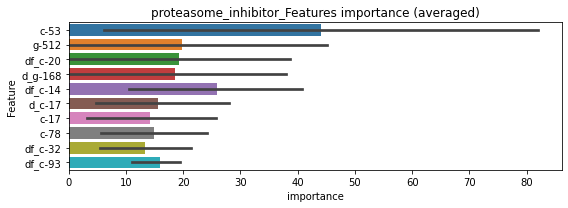

len(train_index) : 3916
len(valid_index) : 3916
================================= fold 1/2 proteasome_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0111929	valid_1's binary_logloss: 0.012564
[200]	training's binary_logloss: 0.000834663	valid_1's binary_logloss: 0.00332386


len(train_index) : 3916


Early stopping, best iteration is:
[216]	training's binary_logloss: 0.000587389	valid_1's binary_logloss: 0.00321659


len(valid_index) : 3916
================================= fold 2/2 proteasome_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0109379	valid_1's binary_logloss: 0.0130087
[200]	training's binary_logloss: 0.000811038	valid_1's binary_logloss: 0.00407436


proteasome_inhibitor logloss: 0.0035710118715304336


Early stopping, best iteration is:
[239]	training's binary_logloss: 0.000369604	valid_1's binary_logloss: 0.00392544


protein_kinase_inhibitor, len(trt): 48, len(othr): 3281, target_rate: 0.0020156 → Adj_target_rate: 0.0022556


neg labels: 3289 → selected neg labels: 3281


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.041592	valid_1's binary_logloss: 0.0719387
[200]	training's binary_logloss: 0.00741836	valid_1's binary_logloss: 0.0262959
[300]	training's binary_logloss: 0.00219127	valid_1's binary_logloss: 0.0153091
[400]	training's binary_logloss: 0.00103623	valid_1's binary_logloss: 0.0117121
[500]	training's binary_logloss: 0.00065691	valid_1's binary_logloss: 0.010215
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.000668891	valid_1's binary_logloss: 0.0101883
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0423253	valid_1's binary_logloss: 0.0727404
[200]	training's binary_logloss: 0.00784675	valid_1's binary_logloss: 0.0269683
[300]	training's binary_logloss: 0.00226208	valid_1's binary_logloss: 0.0163904
[400]	training's binary_logloss: 0.00106099	valid_1's binary_logloss: 0.0129506
[500]	training's binary_logloss: 0.000684379	v

1 / 3 AUC score:1.000
y_Threshold: 0.0053962, Threshold: 0.0107903, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3805
p_label_rate: 0.0200904 Vs.target_rate: 0.00202, Num_p_label: 80.0, conf_0:0.00971, conf_1:0.01187
Num_p_label: 80.0, Expected: 8.0, Adj_threshold_1: 0.0107903
Num_p_label: 32.0, Expected: 8.0, Adj_threshold_2: 0.0207903
Num_p_label: 16.0, Expected: 8.0, Adj_threshold_3: 0.0307903
threshold: 0.0307903, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 656.0/3805, y_label_rate: 0.1724047
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0414134	valid_1's binary_logloss: 0.073209
[200]	training's binary_logloss: 0.00723545	valid_1's binary_logloss: 0.0263426
[300]	training's binary_logloss: 0.00210679	valid_1's binary_logloss: 0.0144831
[400]	training's binary_logloss: 0.00100747	valid_1's binary_logloss: 0.0109983
[500]	training's binary_logloss: 0.000650563	valid_1's binary_logloss: 0.00966423
Early stopping, best iteration is:
[563]	training's binary_logloss: 0.000552635	valid_1's binary_logloss: 0.00925148
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0432588	valid_1's binary_logloss: 0.0725033
[200]	training's binary_logloss: 0.00746312	valid_1's binary_logloss: 0.0246192
[300]	training's binary_logloss: 0.00216575	valid_1's binary_logloss: 0.015061
[400]	training's binary_logloss: 0.00104075	valid_1's binary_logloss: 0.0120598
[500]	training's binary_logloss: 0.00066864

2 / 3 AUC score:1.000
y_Threshold: 0.0410791, Threshold: 0.0307903, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3803
p_label_rate: 0.0105475 Vs.target_rate: 0.00202, Num_p_label: 42.0, conf_0:0.02771, conf_1:0.03387
Num_p_label: 42.0, Expected: 8.0, Adj_threshold_1: 0.0307903
Num_p_label: 33.0, Expected: 8.0, Adj_threshold_2: 0.0407903
Num_p_label: 26.0, Expected: 8.0, Adj_threshold_3: 0.0507903
Num_p_label: 18.0, Expected: 8.0, Adj_threshold_4: 0.0607903
Num_p_label: 15.0, Expected: 8.0, Adj_threshold_5: 0.0707903
threshold: 0.0707903, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 655.0/3803, y_label_rate: 0.1722324
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0424299	valid_1's binary_logloss: 0.0759908
[200]	training's binary_logloss: 0.00741595	valid_1's binary_logloss: 0.0301622
[300]	training's binary_logloss: 0.00215775	valid_1's binary_logloss: 0.0197045
[400]	training's binary_logloss: 0.00103675	valid_1's binary_logloss: 0.0161447
Early stopping, best iteration is:
[479]	training's binary_logloss: 0.00071643	valid_1's binary_logloss: 0.0149237
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0408565	valid_1's binary_logloss: 0.0740553
[200]	training's binary_logloss: 0.00691793	valid_1's binary_logloss: 0.0279647
[300]	training's binary_logloss: 0.00202406	valid_1's binary_logloss: 0.0177827
[400]	training's binary_logloss: 0.000989041	valid_1's binary_logloss: 0.0140975
[500]	training's binary_logloss: 0.000645804	valid_1's binary_logloss: 0.0128069
Early stopping, best iteration is:
[521]	tr

3 / 3 AUC score:1.000
y_Threshold: 0.0327540, Threshold: 0.0707903, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 653.0/3799
p_label_rate: 0.0045203 Vs.target_rate: 0.00202, Num_p_label: 18.0, conf_0:0.06371, conf_1:0.07787
threshold: 0.0707903, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 671.0/7781, y_label_rate: 0.0862357


len(train_index) : 3890
len(valid_index) : 3891
================================= fold 1/2 protein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0241665	valid_1's binary_logloss: 0.0492432
[200]	training's binary_logloss: 0.00418732	valid_1's binary_logloss: 0.0227826
[300]	training's binary_logloss: 0.00117687	valid_1's binary_logloss: 0.0166006
[400]	training's binary_logloss: 0.000549272	valid_1's binary_logloss: 0.0150275
Early stopping, best iteration is:
[407]	training's binary_logloss: 0.000527982	valid_1's binary_logloss: 0.0149487


len(train_index) : 3891
len(valid_index) : 3890
================================= fold 2/2 protein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0227799	valid_1's binary_logloss: 0.0437289
[200]	training's binary_logloss: 0.00404921	valid_1's binary_logloss: 0.0195778
[300]	training's binary_logloss: 0.00118262	valid_1's binary_logloss: 0.0145703
[400]	training's binary_logloss: 0.000560753	valid_1's binary_logloss: 0.012914
[500]	training's binary_logloss: 0.000358888	valid_1's binary_logloss: 0.0123459
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.000358888	valid_1's binary_logloss: 0.0123459


protein_kinase_inhibitor logloss: 0.013647476512030701
protein_phosphatase_inhibitor, len(trt): 24, len(othr): 3286, target_rate: 0.0010078 → Adj_target_rate: 0.0012513


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0268107	valid_1's binary_logloss: 0.0422931
[200]	training's binary_logloss: 0.00351481	valid_1's binary_logloss: 0.0100689
[300]	training's binary_logloss: 0.000994627	valid_1's binary_logloss: 0.00526183
[400]	training's binary_logloss: 0.000507102	valid_1's binary_logloss: 0.00358303
[500]	training's binary_logloss: 0.000374715	valid_1's binary_logloss: 0.00301362
Early stopping, best iteration is:
[494]	training's binary_logloss: 0.000378584	valid_1's binary_logloss: 0.00299096
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.026532	valid_1's binary_logloss: 0.0401469
[200]	training's binary_logloss: 0.00344126	valid_1's binary_logloss: 0.00917849
[300]	training's binary_logloss: 0.000988997	valid_1's binary_logloss: 0.00433269
[400]	training's binary_logloss: 0.000507428	valid_1's binary_logloss: 0.00314175
[500]	training's binary_logloss: 

1 / 3 AUC score:1.000
y_Threshold: 0.0023067, Threshold: 0.0036278, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00101, Num_p_label: 80.0, conf_0:0.00327, conf_1:0.00399
Num_p_label: 80.0, Expected: 4.0, Adj_threshold_1: 0.0036278
Num_p_label: 10.0, Expected: 4.0, Adj_threshold_2: 0.0136278
Num_p_label: 7.0, Expected: 4.0, Adj_threshold_3: 0.0236278
threshold: 0.0236278, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0263985	valid_1's binary_logloss: 0.039576
[200]	training's binary_logloss: 0.00334542	valid_1's binary_logloss: 0.0082418
[300]	training's binary_logloss: 0.00095113	valid_1's binary_logloss: 0.00372738
[400]	training's binary_logloss: 0.00049189	valid_1's binary_logloss: 0.00245934
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.000392552	valid_1's binary_logloss: 0.00214921
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0261348	valid_1's binary_logloss: 0.0382469
[200]	training's binary_logloss: 0.00331874	valid_1's binary_logloss: 0.007826
[300]	training's binary_logloss: 0.000945227	valid_1's binary_logloss: 0.00347631
[400]	training's binary_logloss: 0.000494111	valid_1's binary_logloss: 0.00249196
[500]	training's binary_logloss: 0.000367179	valid_1's binary_logloss: 0.00222442
Early stopping, best iteration is:
[5

2 / 3 AUC score:1.000
y_Threshold: 0.0646076, Threshold: 0.0236278, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0052737 Vs.target_rate: 0.00101, Num_p_label: 21.0, conf_0:0.02127, conf_1:0.02599
Num_p_label: 21.0, Expected: 4.0, Adj_threshold_1: 0.0236278
Num_p_label: 13.0, Expected: 4.0, Adj_threshold_2: 0.0336278
Num_p_label: 8.0, Expected: 4.0, Adj_threshold_3: 0.0436278
threshold: 0.0436278, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0263985	valid_1's binary_logloss: 0.039576
[200]	training's binary_logloss: 0.00334542	valid_1's binary_logloss: 0.0082418
[300]	training's binary_logloss: 0.00095113	valid_1's binary_logloss: 0.00372738
[400]	training's binary_logloss: 0.00049189	valid_1's binary_logloss: 0.00245934
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.000392552	valid_1's binary_logloss: 0.00214921
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0261348	valid_1's binary_logloss: 0.0382469
[200]	training's binary_logloss: 0.00331874	valid_1's binary_logloss: 0.007826
[300]	training's binary_logloss: 0.000945227	valid_1's binary_logloss: 0.00347631
[400]	training's binary_logloss: 0.000494111	valid_1's binary_logloss: 0.00249196
[500]	training's binary_logloss: 0.000367179	valid_1's binary_logloss: 0.00222442
Early stopping, best iteration is:
[5

3 / 3 AUC score:1.000
y_Threshold: 0.0646076, Threshold: 0.0436278, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0020090 Vs.target_rate: 0.00101, Num_p_label: 8.0, conf_0:0.03927, conf_1:0.04799
threshold: 0.0436278, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 665.0/7793, y_label_rate: 0.0853330


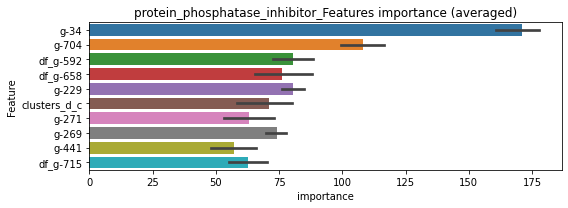

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 protein_phosphatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0144759	valid_1's binary_logloss: 0.0245498
[200]	training's binary_logloss: 0.00178139	valid_1's binary_logloss: 0.0085869
[300]	training's binary_logloss: 0.000497905	valid_1's binary_logloss: 0.00624564
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.000396553	valid_1's binary_logloss: 0.00602487


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 protein_phosphatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0148866	valid_1's binary_logloss: 0.0203835
[200]	training's binary_logloss: 0.00191207	valid_1's binary_logloss: 0.00472837
[300]	training's binary_logloss: 0.000538369	valid_1's binary_logloss: 0.00268498
[400]	training's binary_logloss: 0.000271146	valid_1's binary_logloss: 0.0022579
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.000246588	valid_1's binary_logloss: 0.00221672


protein_phosphatase_inhibitor logloss: 0.004121038965224176
protein_synthesis_inhibitor, len(trt): 103, len(othr): 3271, target_rate: 0.0043252 → Adj_target_rate: 0.0043163


neg labels: 3289 → selected neg labels: 3271


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.060572	valid_1's binary_logloss: 0.127604
[200]	training's binary_logloss: 0.0149087	valid_1's binary_logloss: 0.0752912
[300]	training's binary_logloss: 0.00445561	valid_1's binary_logloss: 0.0589924
Early stopping, best iteration is:
[386]	training's binary_logloss: 0.00217569	valid_1's binary_logloss: 0.0547066
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0594163	valid_1's binary_logloss: 0.134229
[200]	training's binary_logloss: 0.0138778	valid_1's binary_logloss: 0.0814323
[300]	training's binary_logloss: 0.00413112	valid_1's binary_logloss: 0.0657581
Early stopping, best iteration is:
[363]	training's binary_logloss: 0.00237331	valid_1's binary_logloss: 0.0620113


1 / 3 AUC score:0.995
y_Threshold: 0.0175097, Threshold: 0.0772753, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 149 → Positive_corect_labels: 645/3776
p_label_rate: 0.0200904 Vs.target_rate: 0.00433, Num_p_label: 80.0, conf_0:0.06955, conf_1:0.08500
Num_p_label: 80.0, Expected: 17.2, Adj_threshold_1: 0.0772753
Num_p_label: 75.0, Expected: 17.2, Adj_threshold_2: 0.0872753
Num_p_label: 74.0, Expected: 17.2, Adj_threshold_3: 0.0972753
Num_p_label: 71.0, Expected: 17.2, Adj_threshold_4: 0.1072753
Num_p_label: 64.0, Expected: 17.2, Adj_threshold_5: 0.1172753
Num_p_label: 60.0, Expected: 17.2, Adj_threshold_6: 0.1272753
Num_p_label: 54.0, Expected: 17.2, Adj_threshold_7: 0.1372753
Num_p_label: 52.0, Expected: 17.2, Adj_threshold_8: 0.1472753
Num_p_label: 50.0, Expected: 17.2, Adj_threshold_9: 0.1572753
Num_p_label: 45.0, Expected: 17.2, Adj_threshold_10: 0.1672753
threshold: 0.1772753, positive_p_label: 43.0/3982, p_label_rate: 0.0107986
positive_y_label: 645.0/3776, y_label_rate: 0.170815

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0555827	valid_1's binary_logloss: 0.116886
[200]	training's binary_logloss: 0.0114537	valid_1's binary_logloss: 0.0625472
[300]	training's binary_logloss: 0.00350247	valid_1's binary_logloss: 0.0483317
[400]	training's binary_logloss: 0.00164214	valid_1's binary_logloss: 0.0436897
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.00160468	valid_1's binary_logloss: 0.043576
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0560832	valid_1's binary_logloss: 0.123991
[200]	training's binary_logloss: 0.0131463	valid_1's binary_logloss: 0.075718
[300]	training's binary_logloss: 0.00389288	valid_1's binary_logloss: 0.0620838
[400]	training's binary_logloss: 0.00175745	valid_1's binary_logloss: 0.0591052
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.0017248	valid_1's binary_logloss: 0.0589925


2 / 3 AUC score:0.999
y_Threshold: 0.0483814, Threshold: 0.1772753, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 32 → Positive_corect_labels: 629.0/3744
p_label_rate: 0.0281266 Vs.target_rate: 0.00433, Num_p_label: 112.0, conf_0:0.15955, conf_1:0.19500
Num_p_label: 112.0, Expected: 17.2, Adj_threshold_1: 0.1772753
Num_p_label: 110.0, Expected: 17.2, Adj_threshold_2: 0.1872753
Num_p_label: 108.0, Expected: 17.2, Adj_threshold_3: 0.1972753
Num_p_label: 106.0, Expected: 17.2, Adj_threshold_4: 0.2072753
Num_p_label: 104.0, Expected: 17.2, Adj_threshold_5: 0.2172753
Num_p_label: 101.0, Expected: 17.2, Adj_threshold_6: 0.2272753
Num_p_label: 97.0, Expected: 17.2, Adj_threshold_7: 0.2372753
Num_p_label: 95.0, Expected: 17.2, Adj_threshold_8: 0.2472753
Num_p_label: 94.0, Expected: 17.2, Adj_threshold_9: 0.2572753
Num_p_label: 91.0, Expected: 17.2, Adj_threshold_10: 0.2672753
threshold: 0.2772753, positive_p_label: 91.0/3982, p_label_rate: 0.0228528
positive_y_label: 629.0/3744, y_label_rate: 

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0532982	valid_1's binary_logloss: 0.106388
[200]	training's binary_logloss: 0.0112256	valid_1's binary_logloss: 0.0536749
[300]	training's binary_logloss: 0.00343263	valid_1's binary_logloss: 0.0378241
Early stopping, best iteration is:
[384]	training's binary_logloss: 0.00174501	valid_1's binary_logloss: 0.03404
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0537958	valid_1's binary_logloss: 0.104125
[200]	training's binary_logloss: 0.0118708	valid_1's binary_logloss: 0.053102
[300]	training's binary_logloss: 0.00361351	valid_1's binary_logloss: 0.0383197
[400]	training's binary_logloss: 0.00166379	valid_1's binary_logloss: 0.0339697
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.00118905	valid_1's binary_logloss: 0.0325053


3 / 3 AUC score:0.999
y_Threshold: 0.0656114, Threshold: 0.2772753, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 625.0/3736
p_label_rate: 0.0271220 Vs.target_rate: 0.00433, Num_p_label: 108.0, conf_0:0.24955, conf_1:0.30500
Num_p_label: 108.0, Expected: 17.2, Adj_threshold_1: 0.2772753
Num_p_label: 105.0, Expected: 17.2, Adj_threshold_2: 0.2872753
Num_p_label: 101.0, Expected: 17.2, Adj_threshold_3: 0.2972753
Num_p_label: 98.0, Expected: 17.2, Adj_threshold_4: 0.3072753
Num_p_label: 98.0, Expected: 17.2, Adj_threshold_5: 0.3172753
Num_p_label: 98.0, Expected: 17.2, Adj_threshold_6: 0.3272753
Num_p_label: 98.0, Expected: 17.2, Adj_threshold_7: 0.3372753
Num_p_label: 97.0, Expected: 17.2, Adj_threshold_8: 0.3472753
Num_p_label: 97.0, Expected: 17.2, Adj_threshold_9: 0.3572753
Num_p_label: 97.0, Expected: 17.2, Adj_threshold_10: 0.3672753
threshold: 0.3772753, positive_p_label: 96.0/3982, p_label_rate: 0.0241085
positive_y_label: 721.0/7718, y_label_rate: 0.09

len(train_index) : 3859
len(valid_index) : 3859
================================= fold 1/2 protein_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0303639	valid_1's binary_logloss: 0.0787499
[200]	training's binary_logloss: 0.00643199	valid_1's binary_logloss: 0.054575
[300]	training's binary_logloss: 0.00191724	valid_1's binary_logloss: 0.0499836
Early stopping, best iteration is:
[293]	training's binary_logloss: 0.00205388	valid_1's binary_logloss: 0.0497961


len(train_index) : 3859
len(valid_index) : 3859
================================= fold 2/2 protein_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0357443	valid_1's binary_logloss: 0.0755282
[200]	training's binary_logloss: 0.00771761	valid_1's binary_logloss: 0.0455442
[300]	training's binary_logloss: 0.00217735	valid_1's binary_logloss: 0.0386501
[400]	training's binary_logloss: 0.000960712	valid_1's binary_logloss: 0.0354577
Early stopping, best iteration is:
[416]	training's binary_logloss: 0.000871125	valid_1's binary_logloss: 0.0350445


protein_synthesis_inhibitor logloss: 0.042420304615103994
protein_tyrosine_kinase_inhibitor, len(trt): 19, len(othr): 3285, target_rate: 0.0007979 → Adj_target_rate: 0.0010260


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.026179	valid_1's binary_logloss: 0.0352811
[200]	training's binary_logloss: 0.00327319	valid_1's binary_logloss: 0.0064303
[300]	training's binary_logloss: 0.000917552	valid_1's binary_logloss: 0.0023488
[400]	training's binary_logloss: 0.000484904	valid_1's binary_logloss: 0.00145527
[500]	training's binary_logloss: 0.000378212	valid_1's binary_logloss: 0.00122594
Early stopping, best iteration is:
[572]	training's binary_logloss: 0.000366815	valid_1's binary_logloss: 0.00121118
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0262523	valid_1's binary_logloss: 0.0325909
[200]	training's binary_logloss: 0.00328512	valid_1's binary_logloss: 0.00556969
[300]	training's binary_logloss: 0.000943224	valid_1's binary_logloss: 0.002061
[400]	training's binary_logloss: 0.00049697	valid_1's binary_logloss: 0.00130377
[500]	training's binary_logloss: 0.00

1 / 3 AUC score:1.000
y_Threshold: 0.0015684, Threshold: 0.0022234, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00080, Num_p_label: 80.0, conf_0:0.00200, conf_1:0.00245
Num_p_label: 80.0, Expected: 3.2, Adj_threshold_1: 0.0022234
Num_p_label: 4.0, Expected: 3.2, Adj_threshold_2: 0.0122234
threshold: 0.0122234, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0263234	valid_1's binary_logloss: 0.0364443
[200]	training's binary_logloss: 0.00313797	valid_1's binary_logloss: 0.00625066
[300]	training's binary_logloss: 0.000887234	valid_1's binary_logloss: 0.00228174
[400]	training's binary_logloss: 0.000472909	valid_1's binary_logloss: 0.00141998
Early stopping, best iteration is:
[482]	training's binary_logloss: 0.000380352	valid_1's binary_logloss: 0.00122832
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0262827	valid_1's binary_logloss: 0.0329358
[200]	training's binary_logloss: 0.00321167	valid_1's binary_logloss: 0.00515659
[300]	training's binary_logloss: 0.00091469	valid_1's binary_logloss: 0.0017345
[400]	training's binary_logloss: 0.000487845	valid_1's binary_logloss: 0.00104034
[500]	training's binary_logloss: 0.000379247	valid_1's binary_logloss: 0.000851953
Early stopping, best iteration i

2 / 3 AUC score:1.000
y_Threshold: 0.1248135, Threshold: 0.0122234, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0022602 Vs.target_rate: 0.00080, Num_p_label: 9.0, conf_0:0.01100, conf_1:0.01345
threshold: 0.0122234, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0263234	valid_1's binary_logloss: 0.0364443
[200]	training's binary_logloss: 0.00313797	valid_1's binary_logloss: 0.00625066
[300]	training's binary_logloss: 0.000887234	valid_1's binary_logloss: 0.00228174
[400]	training's binary_logloss: 0.000472909	valid_1's binary_logloss: 0.00141998
Early stopping, best iteration is:
[482]	training's binary_logloss: 0.000380352	valid_1's binary_logloss: 0.00122832
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0262827	valid_1's binary_logloss: 0.0329358
[200]	training's binary_logloss: 0.00321167	valid_1's binary_logloss: 0.00515659
[300]	training's binary_logloss: 0.00091469	valid_1's binary_logloss: 0.0017345
[400]	training's binary_logloss: 0.000487845	valid_1's binary_logloss: 0.00104034
[500]	training's binary_logloss: 0.000379247	valid_1's binary_logloss: 0.000851953
Early stopping, best iteration i

3 / 3 AUC score:1.000
y_Threshold: 0.1248135, Threshold: 0.0122234, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0022602 Vs.target_rate: 0.00080, Num_p_label: 9.0, conf_0:0.01100, conf_1:0.01345
threshold: 0.0122234, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 666.0/7792, y_label_rate: 0.0854723


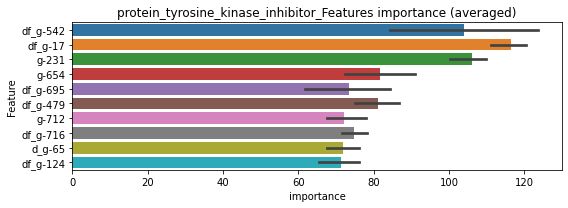

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 protein_tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.014202	valid_1's binary_logloss: 0.0230586
[200]	training's binary_logloss: 0.00172802	valid_1's binary_logloss: 0.00962934
[300]	training's binary_logloss: 0.000481075	valid_1's binary_logloss: 0.00857097
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.000506506	valid_1's binary_logloss: 0.00856531


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 protein_tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0152906	valid_1's binary_logloss: 0.0225117
[200]	training's binary_logloss: 0.00196258	valid_1's binary_logloss: 0.0075568
[300]	training's binary_logloss: 0.000522986	valid_1's binary_logloss: 0.00586667
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.000494665	valid_1's binary_logloss: 0.00584732


protein_tyrosine_kinase_inhibitor logloss: 0.007206312924339302
radiopaque_medium, len(trt): 56, len(othr): 3281, target_rate: 0.0023516 → Adj_target_rate: 0.0025713


neg labels: 3289 → selected neg labels: 3281


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0486743	valid_1's binary_logloss: 0.0984309
[200]	training's binary_logloss: 0.00913759	valid_1's binary_logloss: 0.0490911
[300]	training's binary_logloss: 0.00264708	valid_1's binary_logloss: 0.036475
[400]	training's binary_logloss: 0.00124507	valid_1's binary_logloss: 0.0329308
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00111672	valid_1's binary_logloss: 0.0325727
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.05192	valid_1's binary_logloss: 0.08745
[200]	training's binary_logloss: 0.0102075	valid_1's binary_logloss: 0.0352116
[300]	training's binary_logloss: 0.00294422	valid_1's binary_logloss: 0.02183
[400]	training's binary_logloss: 0.00135111	valid_1's binary_logloss: 0.0178184
Early stopping, best iteration is:
[423]	training's binary_logloss: 0.00118947	valid_1's binary_logloss: 0.0174531


1 / 3 AUC score:1.000
y_Threshold: 0.0084229, Threshold: 0.0125562, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 655/3803
p_label_rate: 0.0200904 Vs.target_rate: 0.00235, Num_p_label: 80.0, conf_0:0.01130, conf_1:0.01381
Num_p_label: 80.0, Expected: 9.4, Adj_threshold_1: 0.0125562
Num_p_label: 24.0, Expected: 9.4, Adj_threshold_2: 0.0225562
Num_p_label: 10.0, Expected: 9.4, Adj_threshold_3: 0.0325562
threshold: 0.0325562, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 655.0/3803, y_label_rate: 0.1722324
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0479478	valid_1's binary_logloss: 0.0908629
[200]	training's binary_logloss: 0.00912323	valid_1's binary_logloss: 0.0423491
[300]	training's binary_logloss: 0.00264528	valid_1's binary_logloss: 0.0308809
Early stopping, best iteration is:
[369]	training's binary_logloss: 0.00150364	valid_1's binary_logloss: 0.0278941
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0504415	valid_1's binary_logloss: 0.0861025
[200]	training's binary_logloss: 0.00971202	valid_1's binary_logloss: 0.0358351
[300]	training's binary_logloss: 0.00278916	valid_1's binary_logloss: 0.0239651
[400]	training's binary_logloss: 0.00130041	valid_1's binary_logloss: 0.020072
[500]	training's binary_logloss: 0.000810716	valid_1's binary_logloss: 0.0185316
Early stopping, best iteration is:
[494]	training's binary_logloss: 0.000827653	valid_1's binary_logloss: 0.0184


2 / 3 AUC score:1.000
y_Threshold: 0.0355538, Threshold: 0.0325562, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 10 → Positive_corect_labels: 650.0/3793
p_label_rate: 0.0077850 Vs.target_rate: 0.00235, Num_p_label: 31.0, conf_0:0.02930, conf_1:0.03581
Num_p_label: 31.0, Expected: 9.4, Adj_threshold_1: 0.0325562
Num_p_label: 19.0, Expected: 9.4, Adj_threshold_2: 0.0425562
Num_p_label: 10.0, Expected: 9.4, Adj_threshold_3: 0.0525562
threshold: 0.0525562, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 650.0/3793, y_label_rate: 0.1713683
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0480697	valid_1's binary_logloss: 0.0881903
[200]	training's binary_logloss: 0.00905644	valid_1's binary_logloss: 0.035808
[300]	training's binary_logloss: 0.00262795	valid_1's binary_logloss: 0.0225101
[400]	training's binary_logloss: 0.00125389	valid_1's binary_logloss: 0.0180708
[500]	training's binary_logloss: 0.000791219	valid_1's binary_logloss: 0.0164952
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.000619975	valid_1's binary_logloss: 0.0159671
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0478827	valid_1's binary_logloss: 0.0861861
[200]	training's binary_logloss: 0.00940662	valid_1's binary_logloss: 0.0360215
[300]	training's binary_logloss: 0.0027343	valid_1's binary_logloss: 0.0234116
[400]	training's binary_logloss: 0.00127962	valid_1's binary_logloss: 0.0189606
[500]	training's binary_logloss: 0.000800718	

3 / 3 AUC score:1.000
y_Threshold: 0.0282026, Threshold: 0.0525562, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 649.0/3791
p_label_rate: 0.0025113 Vs.target_rate: 0.00235, Num_p_label: 10.0, conf_0:0.04730, conf_1:0.05781
threshold: 0.0525562, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 659.0/7773, y_label_rate: 0.0847807


len(train_index) : 3886
len(valid_index) : 3887
================================= fold 1/2 radiopaque_medium=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0265165	valid_1's binary_logloss: 0.0514023
[200]	training's binary_logloss: 0.00499094	valid_1's binary_logloss: 0.024098
[300]	training's binary_logloss: 0.00142311	valid_1's binary_logloss: 0.0180635
Early stopping, best iteration is:
[384]	training's binary_logloss: 0.000724021	valid_1's binary_logloss: 0.0166116


len(train_index) : 3887
len(valid_index) : 3886
================================= fold 2/2 radiopaque_medium=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0281527	valid_1's binary_logloss: 0.0502044
[200]	training's binary_logloss: 0.00547082	valid_1's binary_logloss: 0.0209886
[300]	training's binary_logloss: 0.0015494	valid_1's binary_logloss: 0.0144839
[400]	training's binary_logloss: 0.000703932	valid_1's binary_logloss: 0.0125689
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000482609	valid_1's binary_logloss: 0.0118872


radiopaque_medium logloss: 0.014249682884698966
raf_inhibitor, len(trt): 223, len(othr): 3280, target_rate: 0.0093642 → Adj_target_rate: 0.0083226


neg labels: 3289 → selected neg labels: 3280


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0271036	valid_1's binary_logloss: 0.0807455
Early stopping, best iteration is:
[184]	training's binary_logloss: 0.00480951	valid_1's binary_logloss: 0.0663431
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0281008	valid_1's binary_logloss: 0.0542703
[200]	training's binary_logloss: 0.00415301	valid_1's binary_logloss: 0.0379945


1 / 3 AUC score:0.994
y_Threshold: 0.0113928, Threshold: 0.0332471, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[233]	training's binary_logloss: 0.00257291	valid_1's binary_logloss: 0.0372703


Remove_noisy_labels: 148 → Positive_corect_labels: 648/3788
p_label_rate: 0.0200904 Vs.target_rate: 0.00936, Num_p_label: 80.0, conf_0:0.02992, conf_1:0.03657
threshold: 0.0332471, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 648.0/3788, y_label_rate: 0.1710665
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0257778	valid_1's binary_logloss: 0.0560469
[200]	training's binary_logloss: 0.00337596	valid_1's binary_logloss: 0.0323229
Early stopping, best iteration is:
[224]	training's binary_logloss: 0.00232095	valid_1's binary_logloss: 0.0311536
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.026566	valid_1's binary_logloss: 0.0537183
[200]	training's binary_logloss: 0.00346907	valid_1's binary_logloss: 0.03039


2 / 3 AUC score:1.000
y_Threshold: 0.0364836, Threshold: 0.0332471, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 14 → Positive_corect_labels: 641.0/3774
p_label_rate: 0.0288800 Vs.target_rate: 0.00936, Num_p_label: 115.0, conf_0:0.02992, conf_1:0.03657


Early stopping, best iteration is:
[280]	training's binary_logloss: 0.00117007	valid_1's binary_logloss: 0.0275172


Num_p_label: 115.0, Expected: 37.3, Adj_threshold_1: 0.0332471
Num_p_label: 95.0, Expected: 37.3, Adj_threshold_2: 0.0432471
Num_p_label: 81.0, Expected: 37.3, Adj_threshold_3: 0.0532471
Num_p_label: 76.0, Expected: 37.3, Adj_threshold_4: 0.0632471
Num_p_label: 71.0, Expected: 37.3, Adj_threshold_5: 0.0732471
threshold: 0.0732471, positive_p_label: 71.0/3982, p_label_rate: 0.0178302
positive_y_label: 641.0/3774, y_label_rate: 0.1698463
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0253602	valid_1's binary_logloss: 0.053928
[200]	training's binary_logloss: 0.00324172	valid_1's binary_logloss: 0.0315253
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.00144689	valid_1's binary_logloss: 0.0291329
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0261286	valid_1's binary_logloss: 0.0505731
[200]	training's binary_logloss: 0.0032544	valid_1's binary_logloss: 0.0255312


3 / 3 AUC score:1.000
y_Threshold: 0.0292098, Threshold: 0.0732471, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 16 → Positive_corect_labels: 633.0/3758
p_label_rate: 0.0183325 Vs.target_rate: 0.00936, Num_p_label: 73.0, conf_0:0.06592, conf_1:0.08057


Early stopping, best iteration is:
[252]	training's binary_logloss: 0.00152835	valid_1's binary_logloss: 0.0231156


threshold: 0.0732471, positive_p_label: 73.0/3982, p_label_rate: 0.0183325
positive_y_label: 706.0/7740, y_label_rate: 0.0912145


len(train_index) : 3870
len(valid_index) : 3870
================================= fold 1/2 raf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0142743	valid_1's binary_logloss: 0.0452007
Early stopping, best iteration is:
[186]	training's binary_logloss: 0.00230955	valid_1's binary_logloss: 0.0370384


len(train_index) : 3870
len(valid_index) : 3870
================================= fold 2/2 raf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0154332	valid_1's binary_logloss: 0.0378159
Early stopping, best iteration is:
[175]	training's binary_logloss: 0.00325862	valid_1's binary_logloss: 0.0283084


raf_inhibitor logloss: 0.03267338487243053
ras_gtpase_inhibitor, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942


neg labels: 3289 → selected neg labels: 3287


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0191472	valid_1's binary_logloss: 0.0243895
[200]	training's binary_logloss: 0.00195577	valid_1's binary_logloss: 0.0042859
[300]	training's binary_logloss: 0.000565491	valid_1's binary_logloss: 0.0019055
[400]	training's binary_logloss: 0.000321272	valid_1's binary_logloss: 0.0014195
Early stopping, best iteration is:
[463]	training's binary_logloss: 0.000283741	valid_1's binary_logloss: 0.00135048
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0191968	valid_1's binary_logloss: 0.0232524
[200]	training's binary_logloss: 0.00200283	valid_1's binary_logloss: 0.00359881
[300]	training's binary_logloss: 0.00058365	valid_1's binary_logloss: 0.00145809
[400]	training's binary_logloss: 0.000327576	valid_1's binary_logloss: 0.000958464
Early stopping, best iteration is:
[477]	training's binary_logloss: 0.000281123	valid_1's binary_logloss: 0.00086251

1 / 3 AUC score:1.000
y_Threshold: 0.0011159, Threshold: 0.0021905, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00050, Num_p_label: 80.0, conf_0:0.00197, conf_1:0.00241
Num_p_label: 80.0, Expected: 2.0, Adj_threshold_1: 0.0021905
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_2: 0.0121905
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_3: 0.0221905
threshold: 0.0221905, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193674	valid_1's binary_logloss: 0.024246
[200]	training's binary_logloss: 0.00194506	valid_1's binary_logloss: 0.0043416
[300]	training's binary_logloss: 0.000559565	valid_1's binary_logloss: 0.00218805
[400]	training's binary_logloss: 0.000319082	valid_1's binary_logloss: 0.00176281
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000276503	valid_1's binary_logloss: 0.00169071
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.019589	valid_1's binary_logloss: 0.0232982
[200]	training's binary_logloss: 0.00198492	valid_1's binary_logloss: 0.00333254
[300]	training's binary_logloss: 0.000564797	valid_1's binary_logloss: 0.00120686
[400]	training's binary_logloss: 0.000323373	valid_1's binary_logloss: 0.000764948
[500]	training's binary_logloss: 0.000273587	valid_1's binary_logloss: 0.000672263
Early stopping, best iteration i

2 / 3 AUC score:1.000
y_Threshold: 0.0418771, Threshold: 0.0221905, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0065294 Vs.target_rate: 0.00050, Num_p_label: 26.0, conf_0:0.01997, conf_1:0.02441
Num_p_label: 26.0, Expected: 2.0, Adj_threshold_1: 0.0221905
Num_p_label: 17.0, Expected: 2.0, Adj_threshold_2: 0.0321905
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_3: 0.0421905
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_4: 0.0521905
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_5: 0.0621905
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_6: 0.0721905
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_7: 0.0821905
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_8: 0.0921905
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_9: 0.1021905
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_10: 0.1121905
threshold: 0.1121905, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
===============

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193674	valid_1's binary_logloss: 0.024246
[200]	training's binary_logloss: 0.00194506	valid_1's binary_logloss: 0.0043416
[300]	training's binary_logloss: 0.000559565	valid_1's binary_logloss: 0.00218805
[400]	training's binary_logloss: 0.000319082	valid_1's binary_logloss: 0.00176281
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000276503	valid_1's binary_logloss: 0.00169071
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.019589	valid_1's binary_logloss: 0.0232982
[200]	training's binary_logloss: 0.00198492	valid_1's binary_logloss: 0.00333254
[300]	training's binary_logloss: 0.000564797	valid_1's binary_logloss: 0.00120686
[400]	training's binary_logloss: 0.000323373	valid_1's binary_logloss: 0.000764948
[500]	training's binary_logloss: 0.000273587	valid_1's binary_logloss: 0.000672263
Early stopping, best iteration i

3 / 3 AUC score:1.000
y_Threshold: 0.0418771, Threshold: 0.1121905, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0007534 Vs.target_rate: 0.00050, Num_p_label: 3.0, conf_0:0.10097, conf_1:0.12341
threshold: 0.1121905, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 660.0/7794, y_label_rate: 0.0846805


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 ras_gtpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0101482	valid_1's binary_logloss: 0.0135199
[200]	training's binary_logloss: 0.00100979	valid_1's binary_logloss: 0.00284151
[300]	training's binary_logloss: 0.000282108	valid_1's binary_logloss: 0.00205184
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.000253907	valid_1's binary_logloss: 0.00203653


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 ras_gtpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.010313	valid_1's binary_logloss: 0.0136313
[200]	training's binary_logloss: 0.00105562	valid_1's binary_logloss: 0.00378632
[300]	training's binary_logloss: 0.000295037	valid_1's binary_logloss: 0.00260299
[400]	training's binary_logloss: 0.000167755	valid_1's binary_logloss: 0.00241337
Early stopping, best iteration is:
[429]	training's binary_logloss: 0.000154148	valid_1's binary_logloss: 0.00237364


ras_gtpase_inhibitor logloss: 0.002205087941061963
retinoid_receptor_agonist, len(trt): 67, len(othr): 3278, target_rate: 0.0028135 → Adj_target_rate: 0.0029948


neg labels: 3289 → selected neg labels: 3278


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0421438	valid_1's binary_logloss: 0.0782491
[200]	training's binary_logloss: 0.0071212	valid_1's binary_logloss: 0.028678
[300]	training's binary_logloss: 0.0021028	valid_1's binary_logloss: 0.0160511
[400]	training's binary_logloss: 0.00104496	valid_1's binary_logloss: 0.0126053
[500]	training's binary_logloss: 0.000675736	valid_1's binary_logloss: 0.0109974
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.000564585	valid_1's binary_logloss: 0.0103146
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0412791	valid_1's binary_logloss: 0.0801163
[200]	training's binary_logloss: 0.00711321	valid_1's binary_logloss: 0.0329316
[300]	training's binary_logloss: 0.00209017	valid_1's binary_logloss: 0.0211957
[400]	training's binary_logloss: 0.00102251	valid_1's binary_logloss: 0.0171582
Early stopping, best iteration is:
[451]	train

1 / 3 AUC score:1.000
y_Threshold: 0.0062515, Threshold: 0.0118867, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 655/3801
p_label_rate: 0.0200904 Vs.target_rate: 0.00281, Num_p_label: 80.0, conf_0:0.01070, conf_1:0.01308
Num_p_label: 80.0, Expected: 11.2, Adj_threshold_1: 0.0118867
Num_p_label: 44.0, Expected: 11.2, Adj_threshold_2: 0.0218867
Num_p_label: 32.0, Expected: 11.2, Adj_threshold_3: 0.0318867
Num_p_label: 24.0, Expected: 11.2, Adj_threshold_4: 0.0418867
Num_p_label: 22.0, Expected: 11.2, Adj_threshold_5: 0.0518867
threshold: 0.0518867, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 655.0/3801, y_label_rate: 0.1723231
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0424893	valid_1's binary_logloss: 0.0775864
[200]	training's binary_logloss: 0.00708732	valid_1's binary_logloss: 0.0264405
[300]	training's binary_logloss: 0.00202376	valid_1's binary_logloss: 0.0135277
[400]	training's binary_logloss: 0.000985916	valid_1's binary_logloss: 0.00966875
[500]	training's binary_logloss: 0.000635715	valid_1's binary_logloss: 0.00805987
[600]	training's binary_logloss: 0.000517365	valid_1's binary_logloss: 0.00754012
Early stopping, best iteration is:
[657]	training's binary_logloss: 0.00049926	valid_1's binary_logloss: 0.00742465
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0398131	valid_1's binary_logloss: 0.0767089
[200]	training's binary_logloss: 0.00668586	valid_1's binary_logloss: 0.0272277
[300]	training's binary_logloss: 0.00194626	valid_1's binary_logloss: 0.0165104
[400]	training's binary_logloss: 0.000

2 / 3 AUC score:1.000
y_Threshold: 0.0619498, Threshold: 0.0518867, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 654.0/3799
p_label_rate: 0.0133099 Vs.target_rate: 0.00281, Num_p_label: 53.0, conf_0:0.04670, conf_1:0.05708
Num_p_label: 53.0, Expected: 11.2, Adj_threshold_1: 0.0518867
Num_p_label: 46.0, Expected: 11.2, Adj_threshold_2: 0.0618867
Num_p_label: 41.0, Expected: 11.2, Adj_threshold_3: 0.0718867
Num_p_label: 36.0, Expected: 11.2, Adj_threshold_4: 0.0818867
Num_p_label: 28.0, Expected: 11.2, Adj_threshold_5: 0.0918867
Num_p_label: 27.0, Expected: 11.2, Adj_threshold_6: 0.1018867
Num_p_label: 24.0, Expected: 11.2, Adj_threshold_7: 0.1118867
Num_p_label: 22.0, Expected: 11.2, Adj_threshold_8: 0.1218867
threshold: 0.1218867, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 654.0/3799, y_label_rate: 0.1721506
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0424227	valid_1's binary_logloss: 0.0756236
[200]	training's binary_logloss: 0.00700248	valid_1's binary_logloss: 0.0247933
[300]	training's binary_logloss: 0.00204104	valid_1's binary_logloss: 0.0135522
[400]	training's binary_logloss: 0.000991474	valid_1's binary_logloss: 0.0100145
[500]	training's binary_logloss: 0.000641468	valid_1's binary_logloss: 0.00841584
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.000543324	valid_1's binary_logloss: 0.00793892
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0406816	valid_1's binary_logloss: 0.0665569
[200]	training's binary_logloss: 0.00679876	valid_1's binary_logloss: 0.0230286
[300]	training's binary_logloss: 0.00197698	valid_1's binary_logloss: 0.012933
[400]	training's binary_logloss: 0.000966267	valid_1's binary_logloss: 0.0100682
[500]	training's binary_logloss: 0.00063

3 / 3 AUC score:1.000
y_Threshold: 0.0669381, Threshold: 0.1218867, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 654.0/3799
p_label_rate: 0.0060271 Vs.target_rate: 0.00281, Num_p_label: 24.0, conf_0:0.10970, conf_1:0.13408
threshold: 0.1218867, positive_p_label: 24.0/3982, p_label_rate: 0.0060271
positive_y_label: 678.0/7781, y_label_rate: 0.0871353


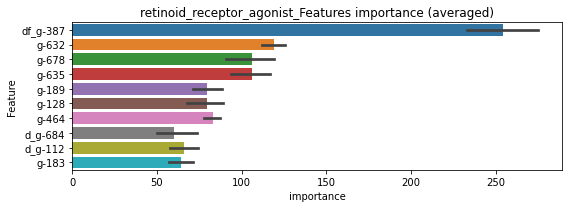

len(train_index) : 3890
len(valid_index) : 3891
================================= fold 1/2 retinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0220732	valid_1's binary_logloss: 0.0459756
[200]	training's binary_logloss: 0.00367943	valid_1's binary_logloss: 0.0220117
[300]	training's binary_logloss: 0.00107111	valid_1's binary_logloss: 0.0165225
[400]	training's binary_logloss: 0.000526724	valid_1's binary_logloss: 0.0149615
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.000537827	valid_1's binary_logloss: 0.014914


len(train_index) : 3891
len(valid_index) : 3890
================================= fold 2/2 retinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0221293	valid_1's binary_logloss: 0.0486229
[200]	training's binary_logloss: 0.00384069	valid_1's binary_logloss: 0.02335
[300]	training's binary_logloss: 0.00112768	valid_1's binary_logloss: 0.0172284
[400]	training's binary_logloss: 0.000534797	valid_1's binary_logloss: 0.0153341
[500]	training's binary_logloss: 0.000345012	valid_1's binary_logloss: 0.0145556
Early stopping, best iteration is:
[551]	training's binary_logloss: 0.000299958	valid_1's binary_logloss: 0.0143067


retinoid_receptor_agonist logloss: 0.014610376646282713
retinoid_receptor_antagonist, len(trt): 6, len(othr): 3288, target_rate: 0.0002520 → Adj_target_rate: 0.0003851


neg labels: 3289 → selected neg labels: 3288


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0153553	valid_1's binary_logloss: 0.0178474
[200]	training's binary_logloss: 0.00124076	valid_1's binary_logloss: 0.0034079
[300]	training's binary_logloss: 0.000334142	valid_1's binary_logloss: 0.00178939
[400]	training's binary_logloss: 0.000207718	valid_1's binary_logloss: 0.00144546
[500]	training's binary_logloss: 0.000184274	valid_1's binary_logloss: 0.00138403
Early stopping, best iteration is:
[573]	training's binary_logloss: 0.000182533	valid_1's binary_logloss: 0.00138027
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155639	valid_1's binary_logloss: 0.0162201
[200]	training's binary_logloss: 0.00126522	valid_1's binary_logloss: 0.00139397
[300]	training's binary_logloss: 0.000339857	valid_1's binary_logloss: 0.000396409
[400]	training's binary_logloss: 0.00020906	valid_1's binary_logloss: 0.000247246
[500]	training's binary_logloss

1 / 3 AUC score:1.000
y_Threshold: 0.0005117, Threshold: 0.0007059, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0200904 Vs.target_rate: 0.00025, Num_p_label: 80.0, conf_0:0.00064, conf_1:0.00078
Num_p_label: 80.0, Expected: 1.0, Adj_threshold_1: 0.0007059
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_2: 0.0107059
threshold: 0.0107059, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157504	valid_1's binary_logloss: 0.0173679
[200]	training's binary_logloss: 0.00126181	valid_1's binary_logloss: 0.00256672
[300]	training's binary_logloss: 0.00033624	valid_1's binary_logloss: 0.00119913
[400]	training's binary_logloss: 0.00020927	valid_1's binary_logloss: 0.000962288
[500]	training's binary_logloss: 0.000185144	valid_1's binary_logloss: 0.000914053
Early stopping, best iteration is:
[576]	training's binary_logloss: 0.000181241	valid_1's binary_logloss: 0.000902479
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160133	valid_1's binary_logloss: 0.0166614
[200]	training's binary_logloss: 0.00129124	valid_1's binary_logloss: 0.00140475
[300]	training's binary_logloss: 0.000339211	valid_1's binary_logloss: 0.000379616
[400]	training's binary_logloss: 0.000210098	valid_1's binary_logloss: 0.000237937
[500]	training's binary_logl

2 / 3 AUC score:1.000
y_Threshold: 0.0836150, Threshold: 0.0107059, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0027624 Vs.target_rate: 0.00025, Num_p_label: 11.0, conf_0:0.00964, conf_1:0.01178
Num_p_label: 11.0, Expected: 1.0, Adj_threshold_1: 0.0107059
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_2: 0.0207059
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_3: 0.0307059
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_4: 0.0407059
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_5: 0.0507059
threshold: 0.0507059, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157504	valid_1's binary_logloss: 0.0173679
[200]	training's binary_logloss: 0.00126181	valid_1's binary_logloss: 0.00256672
[300]	training's binary_logloss: 0.00033624	valid_1's binary_logloss: 0.00119913
[400]	training's binary_logloss: 0.00020927	valid_1's binary_logloss: 0.000962288
[500]	training's binary_logloss: 0.000185144	valid_1's binary_logloss: 0.000914053
Early stopping, best iteration is:
[576]	training's binary_logloss: 0.000181241	valid_1's binary_logloss: 0.000902479
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160133	valid_1's binary_logloss: 0.0166614
[200]	training's binary_logloss: 0.00129124	valid_1's binary_logloss: 0.00140475
[300]	training's binary_logloss: 0.000339211	valid_1's binary_logloss: 0.000379616
[400]	training's binary_logloss: 0.000210098	valid_1's binary_logloss: 0.000237937
[500]	training's binary_logl

3 / 3 AUC score:1.000
y_Threshold: 0.0836150, Threshold: 0.0507059, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0005023 Vs.target_rate: 0.00025, Num_p_label: 2.0, conf_0:0.04564, conf_1:0.05578
threshold: 0.0507059, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 659.0/7795, y_label_rate: 0.0845414


len(train_index) : 3897
len(valid_index) : 3898
================================= fold 1/2 retinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00852468	valid_1's binary_logloss: 0.00958812
[200]	training's binary_logloss: 0.000690195	valid_1's binary_logloss: 0.00184935
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.000235279	valid_1's binary_logloss: 0.00148574


len(train_index) : 3898
len(valid_index) : 3897
================================= fold 2/2 retinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00848992	valid_1's binary_logloss: 0.0105029
[200]	training's binary_logloss: 0.000685004	valid_1's binary_logloss: 0.00243463
[300]	training's binary_logloss: 0.00018212	valid_1's binary_logloss: 0.0017604


retinoid_receptor_antagonist logloss: 0.0016016747917463761


Early stopping, best iteration is:
[315]	training's binary_logloss: 0.000161735	valid_1's binary_logloss: 0.00171763


rho_associated_kinase_inhibitor, len(trt): 35, len(othr): 3283, target_rate: 0.0014697 → Adj_target_rate: 0.0017245


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0306324	valid_1's binary_logloss: 0.0494305
[200]	training's binary_logloss: 0.00429385	valid_1's binary_logloss: 0.012877
[300]	training's binary_logloss: 0.00123108	valid_1's binary_logloss: 0.00648936
[400]	training's binary_logloss: 0.000618123	valid_1's binary_logloss: 0.00469309
Early stopping, best iteration is:
[488]	training's binary_logloss: 0.000437549	valid_1's binary_logloss: 0.00405948
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0299927	valid_1's binary_logloss: 0.0464176
[200]	training's binary_logloss: 0.00431028	valid_1's binary_logloss: 0.0144154
[300]	training's binary_logloss: 0.00125155	valid_1's binary_logloss: 0.00925978
[400]	training's binary_logloss: 0.00062079	valid_1's binary_logloss: 0.00779701
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.000580141	valid_1's binary_logloss: 0.00765636


1 / 3 AUC score:1.000
y_Threshold: 0.0038686, Threshold: 0.0056939, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00147, Num_p_label: 80.0, conf_0:0.00512, conf_1:0.00626
Num_p_label: 80.0, Expected: 5.9, Adj_threshold_1: 0.0056939
Num_p_label: 20.0, Expected: 5.9, Adj_threshold_2: 0.0156939
Num_p_label: 11.0, Expected: 5.9, Adj_threshold_3: 0.0256939
threshold: 0.0256939, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0300625	valid_1's binary_logloss: 0.0455818
[200]	training's binary_logloss: 0.00415292	valid_1's binary_logloss: 0.011149
[300]	training's binary_logloss: 0.00120254	valid_1's binary_logloss: 0.00552223
[400]	training's binary_logloss: 0.000603439	valid_1's binary_logloss: 0.00387714
[500]	training's binary_logloss: 0.000423878	valid_1's binary_logloss: 0.00339844
Early stopping, best iteration is:
[541]	training's binary_logloss: 0.000397681	valid_1's binary_logloss: 0.0032948
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0300731	valid_1's binary_logloss: 0.0469841
[200]	training's binary_logloss: 0.00419417	valid_1's binary_logloss: 0.0140166
[300]	training's binary_logloss: 0.00121534	valid_1's binary_logloss: 0.00841203
[400]	training's binary_logloss: 0.000608279	valid_1's binary_logloss: 0.00699039
Early stopping, best iteration is:
[4

2 / 3 AUC score:1.000
y_Threshold: 0.0279204, Threshold: 0.0256939, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0077850 Vs.target_rate: 0.00147, Num_p_label: 31.0, conf_0:0.02312, conf_1:0.02826
Num_p_label: 31.0, Expected: 5.9, Adj_threshold_1: 0.0256939
Num_p_label: 22.0, Expected: 5.9, Adj_threshold_2: 0.0356939
Num_p_label: 19.0, Expected: 5.9, Adj_threshold_3: 0.0456939
Num_p_label: 17.0, Expected: 5.9, Adj_threshold_4: 0.0556939
Num_p_label: 15.0, Expected: 5.9, Adj_threshold_5: 0.0656939
Num_p_label: 12.0, Expected: 5.9, Adj_threshold_6: 0.0756939
Num_p_label: 12.0, Expected: 5.9, Adj_threshold_7: 0.0856939
Num_p_label: 11.0, Expected: 5.9, Adj_threshold_8: 0.0956939
threshold: 0.0956939, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 655.0/3805, y_label_rate: 0.1721419
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0299831	valid_1's binary_logloss: 0.0473014
[200]	training's binary_logloss: 0.00413429	valid_1's binary_logloss: 0.0112392
[300]	training's binary_logloss: 0.00120221	valid_1's binary_logloss: 0.00544869
[400]	training's binary_logloss: 0.000605191	valid_1's binary_logloss: 0.00363754
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000454815	valid_1's binary_logloss: 0.00317704
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0305003	valid_1's binary_logloss: 0.0441494
[200]	training's binary_logloss: 0.0042502	valid_1's binary_logloss: 0.00970375
[300]	training's binary_logloss: 0.00121627	valid_1's binary_logloss: 0.00442897
[400]	training's binary_logloss: 0.000611705	valid_1's binary_logloss: 0.00318101
[500]	training's binary_logloss: 0.000424675	valid_1's binary_logloss: 0.0027109
Early stopping, best iteration is:
[

3 / 3 AUC score:1.000
y_Threshold: 0.0410638, Threshold: 0.0956939, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0020090 Vs.target_rate: 0.00147, Num_p_label: 8.0, conf_0:0.08612, conf_1:0.10526
threshold: 0.0956939, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 663.0/7787, y_label_rate: 0.0851419


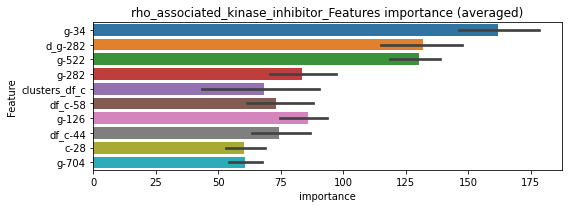

len(train_index) : 3893
len(valid_index) : 3894
================================= fold 1/2 rho_associated_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155057	valid_1's binary_logloss: 0.0280799
[200]	training's binary_logloss: 0.00224534	valid_1's binary_logloss: 0.00980645
[300]	training's binary_logloss: 0.000638898	valid_1's binary_logloss: 0.00696175
[400]	training's binary_logloss: 0.000302729	valid_1's binary_logloss: 0.0062425
Early stopping, best iteration is:
[409]	training's binary_logloss: 0.000289763	valid_1's binary_logloss: 0.00619982


len(train_index) : 3894
len(valid_index) : 3893
================================= fold 2/2 rho_associated_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160438	valid_1's binary_logloss: 0.0257717
[200]	training's binary_logloss: 0.00217392	valid_1's binary_logloss: 0.00820635
[300]	training's binary_logloss: 0.000634056	valid_1's binary_logloss: 0.00537431
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.000355913	valid_1's binary_logloss: 0.00483041


rho_associated_kinase_inhibitor logloss: 0.005515204518301513
ribonucleoside_reductase_inhibitor, len(trt): 37, len(othr): 3282, target_rate: 0.0015537 → Adj_target_rate: 0.0018079


neg labels: 3289 → selected neg labels: 3282


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0288333	valid_1's binary_logloss: 0.0476263
[200]	training's binary_logloss: 0.00403203	valid_1's binary_logloss: 0.0157819
[300]	training's binary_logloss: 0.00115065	valid_1's binary_logloss: 0.00999992
[400]	training's binary_logloss: 0.000580488	valid_1's binary_logloss: 0.00833599
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.00042009	valid_1's binary_logloss: 0.00774804
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0298001	valid_1's binary_logloss: 0.040393
[200]	training's binary_logloss: 0.00420522	valid_1's binary_logloss: 0.0109482
[300]	training's binary_logloss: 0.001199	valid_1's binary_logloss: 0.0066704
[400]	training's binary_logloss: 0.000598587	valid_1's binary_logloss: 0.00588564
Early stopping, best iteration is:
[426]	training's binary_logloss: 0.000526474	valid_1's binary_logloss: 0.00576527


1 / 3 AUC score:1.000
y_Threshold: 0.0026594, Threshold: 0.0045642, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3806
p_label_rate: 0.0200904 Vs.target_rate: 0.00155, Num_p_label: 80.0, conf_0:0.00411, conf_1:0.00502
Num_p_label: 80.0, Expected: 6.2, Adj_threshold_1: 0.0045642
Num_p_label: 27.0, Expected: 6.2, Adj_threshold_2: 0.0145642
Num_p_label: 20.0, Expected: 6.2, Adj_threshold_3: 0.0245642
Num_p_label: 16.0, Expected: 6.2, Adj_threshold_4: 0.0345642
Num_p_label: 13.0, Expected: 6.2, Adj_threshold_5: 0.0445642
Num_p_label: 13.0, Expected: 6.2, Adj_threshold_6: 0.0545642
Num_p_label: 12.0, Expected: 6.2, Adj_threshold_7: 0.0645642
threshold: 0.0645642, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 656.0/3806, y_label_rate: 0.1723594
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0275819	valid_1's binary_logloss: 0.043351
[200]	training's binary_logloss: 0.00366058	valid_1's binary_logloss: 0.0113755
[300]	training's binary_logloss: 0.00104826	valid_1's binary_logloss: 0.00623953
[400]	training's binary_logloss: 0.000532723	valid_1's binary_logloss: 0.00472547
Early stopping, best iteration is:
[443]	training's binary_logloss: 0.00044437	valid_1's binary_logloss: 0.00441594
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0283826	valid_1's binary_logloss: 0.0375954
[200]	training's binary_logloss: 0.0038127	valid_1's binary_logloss: 0.00786957
[300]	training's binary_logloss: 0.00109572	valid_1's binary_logloss: 0.00356737
[400]	training's binary_logloss: 0.000551124	valid_1's binary_logloss: 0.00259145
[500]	training's binary_logloss: 0.00039537	valid_1's binary_logloss: 0.00221207
Early stopping, best iteration is:
[50

2 / 3 AUC score:1.000
y_Threshold: 0.0414242, Threshold: 0.0645642, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3806
p_label_rate: 0.0045203 Vs.target_rate: 0.00155, Num_p_label: 18.0, conf_0:0.05811, conf_1:0.07102
threshold: 0.0645642, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 656.0/3806, y_label_rate: 0.1723594
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0275819	valid_1's binary_logloss: 0.043351
[200]	training's binary_logloss: 0.00366058	valid_1's binary_logloss: 0.0113755
[300]	training's binary_logloss: 0.00104826	valid_1's binary_logloss: 0.00623953
[400]	training's binary_logloss: 0.000532723	valid_1's binary_logloss: 0.00472547
Early stopping, best iteration is:
[443]	training's binary_logloss: 0.00044437	valid_1's binary_logloss: 0.00441594
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0283826	valid_1's binary_logloss: 0.0375954
[200]	training's binary_logloss: 0.0038127	valid_1's binary_logloss: 0.00786957
[300]	training's binary_logloss: 0.00109572	valid_1's binary_logloss: 0.00356737
[400]	training's binary_logloss: 0.000551124	valid_1's binary_logloss: 0.00259145
[500]	training's binary_logloss: 0.00039537	valid_1's binary_logloss: 0.00221207
Early stopping, best iteration is:
[50

3 / 3 AUC score:1.000
y_Threshold: 0.0414242, Threshold: 0.0645642, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3806
p_label_rate: 0.0045203 Vs.target_rate: 0.00155, Num_p_label: 18.0, conf_0:0.05811, conf_1:0.07102
threshold: 0.0645642, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 674.0/7788, y_label_rate: 0.0865434


len(train_index) : 3894
len(valid_index) : 3894
================================= fold 1/2 ribonucleoside_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0150019	valid_1's binary_logloss: 0.0263427
[200]	training's binary_logloss: 0.00196951	valid_1's binary_logloss: 0.00980337
[300]	training's binary_logloss: 0.000556427	valid_1's binary_logloss: 0.00705174
[400]	training's binary_logloss: 0.000281152	valid_1's binary_logloss: 0.00611136
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000236077	valid_1's binary_logloss: 0.00586974


len(train_index) : 3894
len(valid_index) : 3894
================================= fold 2/2 ribonucleoside_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0152823	valid_1's binary_logloss: 0.0265429
[200]	training's binary_logloss: 0.00205327	valid_1's binary_logloss: 0.007712
[300]	training's binary_logloss: 0.000571038	valid_1's binary_logloss: 0.00500174
[400]	training's binary_logloss: 0.000286692	valid_1's binary_logloss: 0.00436517
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.000210412	valid_1's binary_logloss: 0.00408139


ribonucleoside_reductase_inhibitor logloss: 0.0049755633051414856
rna_polymerase_inhibitor, len(trt): 25, len(othr): 3284, target_rate: 0.0010498 → Adj_target_rate: 0.0012955


neg labels: 3289 → selected neg labels: 3284


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0290982	valid_1's binary_logloss: 0.038656
[200]	training's binary_logloss: 0.00373308	valid_1's binary_logloss: 0.007089
[300]	training's binary_logloss: 0.00106263	valid_1's binary_logloss: 0.00290857
[400]	training's binary_logloss: 0.000546057	valid_1's binary_logloss: 0.00189673
[500]	training's binary_logloss: 0.000407858	valid_1's binary_logloss: 0.00156968
Early stopping, best iteration is:
[547]	training's binary_logloss: 0.000395072	valid_1's binary_logloss: 0.00154721
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0299551	valid_1's binary_logloss: 0.0470944
[200]	training's binary_logloss: 0.00384877	valid_1's binary_logloss: 0.0115295
[300]	training's binary_logloss: 0.00105965	valid_1's binary_logloss: 0.00601307
[400]	training's binary_logloss: 0.000540653	valid_1's binary_logloss: 0.00457794
Early stopping, best iteration is:
[4

1 / 3 AUC score:1.000
y_Threshold: 0.0022142, Threshold: 0.0082744, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00105, Num_p_label: 80.0, conf_0:0.00745, conf_1:0.00910
Num_p_label: 80.0, Expected: 4.2, Adj_threshold_1: 0.0082744
Num_p_label: 38.0, Expected: 4.2, Adj_threshold_2: 0.0182744
Num_p_label: 30.0, Expected: 4.2, Adj_threshold_3: 0.0282744
Num_p_label: 23.0, Expected: 4.2, Adj_threshold_4: 0.0382744
Num_p_label: 18.0, Expected: 4.2, Adj_threshold_5: 0.0482744
Num_p_label: 17.0, Expected: 4.2, Adj_threshold_6: 0.0582744
Num_p_label: 10.0, Expected: 4.2, Adj_threshold_7: 0.0682744
Num_p_label: 9.0, Expected: 4.2, Adj_threshold_8: 0.0782744
Num_p_label: 9.0, Expected: 4.2, Adj_threshold_9: 0.0882744
Num_p_label: 9.0, Expected: 4.2, Adj_threshold_10: 0.0982744
threshold: 0.1082744, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
============

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0279143	valid_1's binary_logloss: 0.0373217
[200]	training's binary_logloss: 0.00353488	valid_1's binary_logloss: 0.00709987
[300]	training's binary_logloss: 0.00099409	valid_1's binary_logloss: 0.0027289
[400]	training's binary_logloss: 0.000505876	valid_1's binary_logloss: 0.00167497
[500]	training's binary_logloss: 0.000387324	valid_1's binary_logloss: 0.00141115
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.000383091	valid_1's binary_logloss: 0.00139832
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0287898	valid_1's binary_logloss: 0.0443037
[200]	training's binary_logloss: 0.00363485	valid_1's binary_logloss: 0.00939141
[300]	training's binary_logloss: 0.00100547	valid_1's binary_logloss: 0.00374305
[400]	training's binary_logloss: 0.000516811	valid_1's binary_logloss: 0.00234855
[500]	training's binary_logloss: 0

2 / 3 AUC score:1.000
y_Threshold: 0.1008286, Threshold: 0.1082744, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0155701 Vs.target_rate: 0.00105, Num_p_label: 62.0, conf_0:0.09745, conf_1:0.11910
Num_p_label: 62.0, Expected: 4.2, Adj_threshold_1: 0.1082744
Num_p_label: 59.0, Expected: 4.2, Adj_threshold_2: 0.1182744
Num_p_label: 56.0, Expected: 4.2, Adj_threshold_3: 0.1282744
Num_p_label: 55.0, Expected: 4.2, Adj_threshold_4: 0.1382744
Num_p_label: 54.0, Expected: 4.2, Adj_threshold_5: 0.1482744
Num_p_label: 52.0, Expected: 4.2, Adj_threshold_6: 0.1582744
Num_p_label: 48.0, Expected: 4.2, Adj_threshold_7: 0.1682744
Num_p_label: 45.0, Expected: 4.2, Adj_threshold_8: 0.1782744
Num_p_label: 44.0, Expected: 4.2, Adj_threshold_9: 0.1882744
Num_p_label: 43.0, Expected: 4.2, Adj_threshold_10: 0.1982744
threshold: 0.2082744, positive_p_label: 41.0/3982, p_label_rate: 0.0102963
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0279143	valid_1's binary_logloss: 0.0373217
[200]	training's binary_logloss: 0.00353488	valid_1's binary_logloss: 0.00709987
[300]	training's binary_logloss: 0.00099409	valid_1's binary_logloss: 0.0027289
[400]	training's binary_logloss: 0.000505876	valid_1's binary_logloss: 0.00167497
[500]	training's binary_logloss: 0.000387324	valid_1's binary_logloss: 0.00141115
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.000383091	valid_1's binary_logloss: 0.00139832
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0287898	valid_1's binary_logloss: 0.0443037
[200]	training's binary_logloss: 0.00363485	valid_1's binary_logloss: 0.00939141
[300]	training's binary_logloss: 0.00100547	valid_1's binary_logloss: 0.00374305
[400]	training's binary_logloss: 0.000516811	valid_1's binary_logloss: 0.00234855
[500]	training's binary_logloss: 0

3 / 3 AUC score:1.000
y_Threshold: 0.1008286, Threshold: 0.2082744, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0102963 Vs.target_rate: 0.00105, Num_p_label: 41.0, conf_0:0.18745, conf_1:0.22910
Num_p_label: 41.0, Expected: 4.2, Adj_threshold_1: 0.2082744
Num_p_label: 41.0, Expected: 4.2, Adj_threshold_2: 0.2182744
Num_p_label: 40.0, Expected: 4.2, Adj_threshold_3: 0.2282744
Num_p_label: 38.0, Expected: 4.2, Adj_threshold_4: 0.2382744
Num_p_label: 38.0, Expected: 4.2, Adj_threshold_5: 0.2482744
Num_p_label: 37.0, Expected: 4.2, Adj_threshold_6: 0.2582744
Num_p_label: 37.0, Expected: 4.2, Adj_threshold_7: 0.2682744
Num_p_label: 36.0, Expected: 4.2, Adj_threshold_8: 0.2782744
Num_p_label: 36.0, Expected: 4.2, Adj_threshold_9: 0.2882744
Num_p_label: 36.0, Expected: 4.2, Adj_threshold_10: 0.2982744
threshold: 0.3082744, positive_p_label: 35.0/3982, p_label_rate: 0.0087896
positive_y_label: 691.0/7790, y_label_rate: 0.0887035


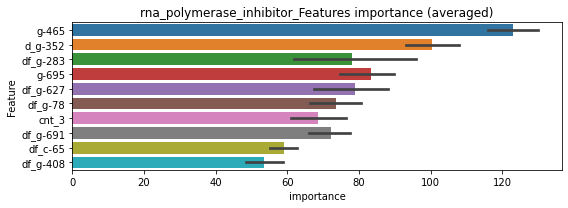

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 rna_polymerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0175357	valid_1's binary_logloss: 0.0280403
[200]	training's binary_logloss: 0.00249405	valid_1's binary_logloss: 0.00983277
[300]	training's binary_logloss: 0.000700007	valid_1's binary_logloss: 0.00736601
Early stopping, best iteration is:
[364]	training's binary_logloss: 0.000424262	valid_1's binary_logloss: 0.00689884


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 rna_polymerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0175686	valid_1's binary_logloss: 0.0256885
[200]	training's binary_logloss: 0.00251002	valid_1's binary_logloss: 0.0077869
[300]	training's binary_logloss: 0.000688372	valid_1's binary_logloss: 0.00506028
[400]	training's binary_logloss: 0.000342309	valid_1's binary_logloss: 0.00452407
Early stopping, best iteration is:
[412]	training's binary_logloss: 0.000323492	valid_1's binary_logloss: 0.00450296


rna_polymerase_inhibitor logloss: 0.005700899819349029
serotonin_receptor_agonist, len(trt): 236, len(othr): 3249, target_rate: 0.0099101 → Adj_target_rate: 0.0087332


neg labels: 3289 → selected neg labels: 3249


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0966258	valid_1's binary_logloss: 0.265104
[200]	training's binary_logloss: 0.0335535	valid_1's binary_logloss: 0.239897
Early stopping, best iteration is:
[201]	training's binary_logloss: 0.033257	valid_1's binary_logloss: 0.239846
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108936	valid_1's binary_logloss: 0.268771
[200]	training's binary_logloss: 0.0397656	valid_1's binary_logloss: 0.23671


1 / 3 AUC score:0.914


Early stopping, best iteration is:
[231]	training's binary_logloss: 0.0299109	valid_1's binary_logloss: 0.234685


y_Threshold: 0.0842655, Threshold: 0.1098260, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 397 → Positive_corect_labels: 516/3501
p_label_rate: 0.0200904 Vs.target_rate: 0.00991, Num_p_label: 80.0, conf_0:0.09884, conf_1:0.12081
threshold: 0.1098260, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 516.0/3501, y_label_rate: 0.1473865
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0711405	valid_1's binary_logloss: 0.189554
[200]	training's binary_logloss: 0.0215551	valid_1's binary_logloss: 0.15999
Early stopping, best iteration is:
[251]	training's binary_logloss: 0.0120007	valid_1's binary_logloss: 0.156043
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0771565	valid_1's binary_logloss: 0.192381
[200]	training's binary_logloss: 0.0231297	valid_1's binary_logloss: 0.152649


2 / 3 AUC score:0.975
y_Threshold: 0.0716163, Threshold: 0.1098260, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[282]	training's binary_logloss: 0.0094694	valid_1's binary_logloss: 0.145903


Remove_noisy_labels: 126 → Positive_corect_labels: 453.0/3375
p_label_rate: 0.0057760 Vs.target_rate: 0.00991, Num_p_label: 23.0, conf_0:0.09884, conf_1:0.12081
threshold: 0.1098260, positive_p_label: 23.0/3982, p_label_rate: 0.0057760
positive_y_label: 453.0/3375, y_label_rate: 0.1342222
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0667855	valid_1's binary_logloss: 0.156076
[200]	training's binary_logloss: 0.0176643	valid_1's binary_logloss: 0.113365
[300]	training's binary_logloss: 0.00591107	valid_1's binary_logloss: 0.102619
Early stopping, best iteration is:
[317]	training's binary_logloss: 0.00508017	valid_1's binary_logloss: 0.102152
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0567654	valid_1's binary_logloss: 0.150021
[200]	training's binary_logloss: 0.0151542	valid_1's binary_logloss: 0.116652
[300]	training's binary_logloss: 0.00530968	valid_1's binary_logloss: 0.109142
Early stopping, best iteration is:
[313]	training's binary_logloss: 0.0047185	valid_1's binary_logloss: 0.107847


3 / 3 AUC score:0.991
y_Threshold: 0.0581156, Threshold: 0.1098260, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 58 → Positive_corect_labels: 424.0/3317
p_label_rate: 0.0017579 Vs.target_rate: 0.00991, Num_p_label: 7.0, conf_0:0.09884, conf_1:0.12081
Num_p_label: 7.0, Expected: 39.5, Adj_threshold_1: 0.1098260
Num_p_label: 12.0, Expected: 39.5, Adj_threshold_2: 0.0998260
Num_p_label: 19.0, Expected: 39.5, Adj_threshold_3: 0.0898260
Num_p_label: 29.0, Expected: 39.5, Adj_threshold_4: 0.0798260
threshold: 0.0798260, positive_p_label: 29.0/3982, p_label_rate: 0.0072828
positive_y_label: 453.0/7299, y_label_rate: 0.0620633


len(train_index) : 3649
len(valid_index) : 3650
================================= fold 1/2 serotonin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0321554	valid_1's binary_logloss: 0.0945561
[200]	training's binary_logloss: 0.00935904	valid_1's binary_logloss: 0.0794784
Early stopping, best iteration is:
[235]	training's binary_logloss: 0.00615821	valid_1's binary_logloss: 0.0780689


len(train_index) : 3650
len(valid_index) : 3649
================================= fold 2/2 serotonin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0291661	valid_1's binary_logloss: 0.0899137
[200]	training's binary_logloss: 0.0077426	valid_1's binary_logloss: 0.0800523
Early stopping, best iteration is:
[191]	training's binary_logloss: 0.00871223	valid_1's binary_logloss: 0.0799605


serotonin_receptor_agonist logloss: 0.07901459404313778
serotonin_receptor_antagonist, len(trt): 404, len(othr): 3220, target_rate: 0.0169648 → Adj_target_rate: 0.0137918


neg labels: 3289 → selected neg labels: 3220


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138778	valid_1's binary_logloss: 0.353256
Early stopping, best iteration is:
[125]	training's binary_logloss: 0.108639	valid_1's binary_logloss: 0.347621
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132507	valid_1's binary_logloss: 0.355534


1 / 3 AUC score:0.812
y_Threshold: 0.1522214, Threshold: 0.2123982, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[162]	training's binary_logloss: 0.0734163	valid_1's binary_logloss: 0.34335


Remove_noisy_labels: 679 → Positive_corect_labels: 369/3185
p_label_rate: 0.0200904 Vs.target_rate: 0.01696, Num_p_label: 80.0, conf_0:0.19116, conf_1:0.23364
threshold: 0.2123982, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 369.0/3185, y_label_rate: 0.1158556
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0648918	valid_1's binary_logloss: 0.218829
Early stopping, best iteration is:
[172]	training's binary_logloss: 0.0251772	valid_1's binary_logloss: 0.206933
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0641116	valid_1's binary_logloss: 0.214923
[200]	training's binary_logloss: 0.0188785	valid_1's binary_logloss: 0.196496


2 / 3 AUC score:0.944
y_Threshold: 0.0960939, Threshold: 0.2123982, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 198 → Positive_corect_labels: 270.0/2987
p_label_rate: 0.0085384 Vs.target_rate: 0.01696, Num_p_label: 34.0, conf_0:0.19116, conf_1:0.23364


Early stopping, best iteration is:
[228]	training's binary_logloss: 0.0140192	valid_1's binary_logloss: 0.194975


threshold: 0.2123982, positive_p_label: 34.0/3982, p_label_rate: 0.0085384
positive_y_label: 270.0/2987, y_label_rate: 0.0903917
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0411813	valid_1's binary_logloss: 0.153789
Early stopping, best iteration is:
[133]	training's binary_logloss: 0.0254984	valid_1's binary_logloss: 0.148008
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0398395	valid_1's binary_logloss: 0.157004


3 / 3 AUC score:0.959
y_Threshold: 0.0841668, Threshold: 0.2123982, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 108 → Positive_corect_labels: 216.0/2879
p_label_rate: 0.0090407 Vs.target_rate: 0.01696, Num_p_label: 36.0, conf_0:0.19116, conf_1:0.23364


Early stopping, best iteration is:
[175]	training's binary_logloss: 0.0135243	valid_1's binary_logloss: 0.143983


threshold: 0.2123982, positive_p_label: 36.0/3982, p_label_rate: 0.0090407
positive_y_label: 252.0/6861, y_label_rate: 0.0367293


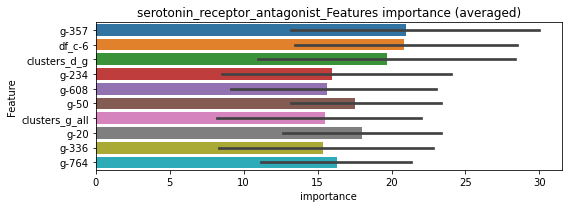

len(train_index) : 3430
len(valid_index) : 3431
================================= fold 1/2 serotonin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162695	valid_1's binary_logloss: 0.0686292


len(train_index) : 3431
len(valid_index) : 3430


Early stopping, best iteration is:
[140]	training's binary_logloss: 0.00870892	valid_1's binary_logloss: 0.0638185


================================= fold 2/2 serotonin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158765	valid_1's binary_logloss: 0.0672779


serotonin_receptor_antagonist logloss: 0.0636955913857693


Early stopping, best iteration is:
[157]	training's binary_logloss: 0.00658097	valid_1's binary_logloss: 0.0635726


serotonin_reuptake_inhibitor, len(trt): 44, len(othr): 3281, target_rate: 0.0018477 → Adj_target_rate: 0.0020948


neg labels: 3289 → selected neg labels: 3281


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0388201	valid_1's binary_logloss: 0.0697173
[200]	training's binary_logloss: 0.00654392	valid_1's binary_logloss: 0.028248
[300]	training's binary_logloss: 0.00190359	valid_1's binary_logloss: 0.0185067
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00104693	valid_1's binary_logloss: 0.015652
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0414544	valid_1's binary_logloss: 0.066731
[200]	training's binary_logloss: 0.0078346	valid_1's binary_logloss: 0.0273999
[300]	training's binary_logloss: 0.00220671	valid_1's binary_logloss: 0.0194599
[400]	training's binary_logloss: 0.00103143	valid_1's binary_logloss: 0.0176209
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.000974446	valid_1's binary_logloss: 0.0174885


1 / 3 AUC score:1.000
y_Threshold: 0.0058836, Threshold: 0.0078709, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 655/3803
p_label_rate: 0.0200904 Vs.target_rate: 0.00185, Num_p_label: 80.0, conf_0:0.00708, conf_1:0.00866
Num_p_label: 80.0, Expected: 7.4, Adj_threshold_1: 0.0078709
Num_p_label: 7.0, Expected: 7.4, Adj_threshold_2: 0.0178709
threshold: 0.0178709, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 655.0/3803, y_label_rate: 0.1722324
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0406761	valid_1's binary_logloss: 0.0730353
[200]	training's binary_logloss: 0.00699795	valid_1's binary_logloss: 0.030548
[300]	training's binary_logloss: 0.00201232	valid_1's binary_logloss: 0.0204885
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.00181291	valid_1's binary_logloss: 0.0200921
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0400891	valid_1's binary_logloss: 0.0729515
[200]	training's binary_logloss: 0.00664453	valid_1's binary_logloss: 0.0271243
[300]	training's binary_logloss: 0.00190417	valid_1's binary_logloss: 0.0170625
[400]	training's binary_logloss: 0.000932297	valid_1's binary_logloss: 0.0145913
[500]	training's binary_logloss: 0.000618328	valid_1's binary_logloss: 0.0137494
Early stopping, best iteration is:
[552]	training's binary_logloss: 0.000543361	valid_1's binary_logloss: 0.0134184


2 / 3 AUC score:1.000
y_Threshold: 0.0329389, Threshold: 0.0178709, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 653.0/3799
p_label_rate: 0.0095429 Vs.target_rate: 0.00185, Num_p_label: 38.0, conf_0:0.01608, conf_1:0.01966
Num_p_label: 38.0, Expected: 7.4, Adj_threshold_1: 0.0178709
Num_p_label: 12.0, Expected: 7.4, Adj_threshold_2: 0.0278709
threshold: 0.0278709, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 653.0/3799, y_label_rate: 0.1718873
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0396222	valid_1's binary_logloss: 0.068138
[200]	training's binary_logloss: 0.00696499	valid_1's binary_logloss: 0.0275675
[300]	training's binary_logloss: 0.00197462	valid_1's binary_logloss: 0.018303
[400]	training's binary_logloss: 0.000951561	valid_1's binary_logloss: 0.0155764
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000672304	valid_1's binary_logloss: 0.0146434
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0389967	valid_1's binary_logloss: 0.0645885
[200]	training's binary_logloss: 0.00656993	valid_1's binary_logloss: 0.0234177
[300]	training's binary_logloss: 0.00191314	valid_1's binary_logloss: 0.0154025
[400]	training's binary_logloss: 0.000932834	valid_1's binary_logloss: 0.0132827
Early stopping, best iteration is:
[412]	training's binary_logloss: 0.000876973	valid_1's binary_logloss: 0.0130258


3 / 3 AUC score:1.000
y_Threshold: 0.0136633, Threshold: 0.0278709, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 650.0/3793
p_label_rate: 0.0020090 Vs.target_rate: 0.00185, Num_p_label: 8.0, conf_0:0.02508, conf_1:0.03066
threshold: 0.0278709, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 658.0/7775, y_label_rate: 0.0846302


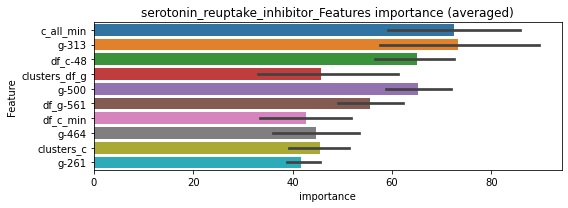

len(train_index) : 3887
len(valid_index) : 3888
================================= fold 1/2 serotonin_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0222289	valid_1's binary_logloss: 0.0512481
[200]	training's binary_logloss: 0.00360354	valid_1's binary_logloss: 0.0291029
[300]	training's binary_logloss: 0.000997358	valid_1's binary_logloss: 0.0232427
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.000697488	valid_1's binary_logloss: 0.0227223


len(train_index) : 3888
len(valid_index) : 3887
================================= fold 2/2 serotonin_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0238569	valid_1's binary_logloss: 0.0399009
[200]	training's binary_logloss: 0.00408299	valid_1's binary_logloss: 0.0136033
[300]	training's binary_logloss: 0.00113531	valid_1's binary_logloss: 0.00805892
[400]	training's binary_logloss: 0.000525216	valid_1's binary_logloss: 0.00652582
[500]	training's binary_logloss: 0.00033199	valid_1's binary_logloss: 0.00597261
Early stopping, best iteration is:
[501]	training's binary_logloss: 0.000330789	valid_1's binary_logloss: 0.00597174


serotonin_reuptake_inhibitor logloss: 0.014348121175638974
sigma_receptor_agonist, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.040168	valid_1's binary_logloss: 0.0618174
[200]	training's binary_logloss: 0.0065966	valid_1's binary_logloss: 0.0184606
[300]	training's binary_logloss: 0.00183604	valid_1's binary_logloss: 0.00940717
[400]	training's binary_logloss: 0.000863686	valid_1's binary_logloss: 0.00673638
[500]	training's binary_logloss: 0.000564196	valid_1's binary_logloss: 0.00548766
Early stopping, best iteration is:
[492]	training's binary_logloss: 0.000576693	valid_1's binary_logloss: 0.00547592
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0401936	valid_1's binary_logloss: 0.0656508
[200]	training's binary_logloss: 0.00685071	valid_1's binary_logloss: 0.0206374
[300]	training's binary_logloss: 0.00188763	valid_1's binary_logloss: 0.00986533
[400]	training's binary_logloss: 0.000886591	valid_1's binary_logloss: 0.00691036
[500]	training's binary_logloss: 0.00

1 / 3 AUC score:1.000
y_Threshold: 0.0042798, Threshold: 0.0068706, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00151, Num_p_label: 80.0, conf_0:0.00618, conf_1:0.00756
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0068706
Num_p_label: 16.0, Expected: 6.0, Adj_threshold_2: 0.0168706
Num_p_label: 8.0, Expected: 6.0, Adj_threshold_3: 0.0268706
threshold: 0.0268706, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0386881	valid_1's binary_logloss: 0.0612241
[200]	training's binary_logloss: 0.00611845	valid_1's binary_logloss: 0.019115
[300]	training's binary_logloss: 0.00171909	valid_1's binary_logloss: 0.00983552
[400]	training's binary_logloss: 0.000838036	valid_1's binary_logloss: 0.00721633
[500]	training's binary_logloss: 0.000554343	valid_1's binary_logloss: 0.00601968
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.000484832	valid_1's binary_logloss: 0.0057549
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0402553	valid_1's binary_logloss: 0.0628471
[200]	training's binary_logloss: 0.00662726	valid_1's binary_logloss: 0.0195388
[300]	training's binary_logloss: 0.00183517	valid_1's binary_logloss: 0.0100375
[400]	training's binary_logloss: 0.000870606	valid_1's binary_logloss: 0.00743066
[500]	training's binary_logloss: 0.000

2 / 3 AUC score:1.000
y_Threshold: 0.0767624, Threshold: 0.0268706, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0072828 Vs.target_rate: 0.00151, Num_p_label: 29.0, conf_0:0.02418, conf_1:0.02956
Num_p_label: 29.0, Expected: 6.0, Adj_threshold_1: 0.0268706
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_2: 0.0368706
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_3: 0.0468706
threshold: 0.0468706, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0386881	valid_1's binary_logloss: 0.0612241
[200]	training's binary_logloss: 0.00611845	valid_1's binary_logloss: 0.019115
[300]	training's binary_logloss: 0.00171909	valid_1's binary_logloss: 0.00983552
[400]	training's binary_logloss: 0.000838036	valid_1's binary_logloss: 0.00721633
[500]	training's binary_logloss: 0.000554343	valid_1's binary_logloss: 0.00601968
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.000484832	valid_1's binary_logloss: 0.0057549
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0402553	valid_1's binary_logloss: 0.0628471
[200]	training's binary_logloss: 0.00662726	valid_1's binary_logloss: 0.0195388
[300]	training's binary_logloss: 0.00183517	valid_1's binary_logloss: 0.0100375
[400]	training's binary_logloss: 0.000870606	valid_1's binary_logloss: 0.00743066
[500]	training's binary_logloss: 0.000

3 / 3 AUC score:1.000
y_Threshold: 0.0767624, Threshold: 0.0468706, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0027624 Vs.target_rate: 0.00151, Num_p_label: 11.0, conf_0:0.04218, conf_1:0.05156
threshold: 0.0468706, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 667.0/7789, y_label_rate: 0.0856336


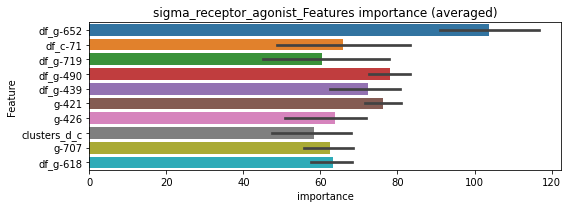

len(train_index) : 3894
len(valid_index) : 3895
================================= fold 1/2 sigma_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.022731	valid_1's binary_logloss: 0.0391147
[200]	training's binary_logloss: 0.00365699	valid_1's binary_logloss: 0.0148361
[300]	training's binary_logloss: 0.000997636	valid_1's binary_logloss: 0.0107832
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.000947614	valid_1's binary_logloss: 0.0107273


len(train_index) : 3895
len(valid_index) : 3894
================================= fold 2/2 sigma_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0239377	valid_1's binary_logloss: 0.0366491
[200]	training's binary_logloss: 0.00399659	valid_1's binary_logloss: 0.0127937
[300]	training's binary_logloss: 0.00104716	valid_1's binary_logloss: 0.00817302
[400]	training's binary_logloss: 0.000486591	valid_1's binary_logloss: 0.0069034
Early stopping, best iteration is:
[468]	training's binary_logloss: 0.000347099	valid_1's binary_logloss: 0.00668625


sigma_receptor_agonist logloss: 0.00870702577838286
sigma_receptor_antagonist, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0339468	valid_1's binary_logloss: 0.0580813
[200]	training's binary_logloss: 0.00526735	valid_1's binary_logloss: 0.0221128
[300]	training's binary_logloss: 0.00154447	valid_1's binary_logloss: 0.013587
[400]	training's binary_logloss: 0.000771716	valid_1's binary_logloss: 0.0109826
[500]	training's binary_logloss: 0.00052162	valid_1's binary_logloss: 0.00961465
Early stopping, best iteration is:
[563]	training's binary_logloss: 0.000468253	valid_1's binary_logloss: 0.00936619
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0381457	valid_1's binary_logloss: 0.0700067
[200]	training's binary_logloss: 0.00632219	valid_1's binary_logloss: 0.0302139
[300]	training's binary_logloss: 0.00174423	valid_1's binary_logloss: 0.0187375
Early stopping, best iteration is:
[368]	training's binary_logloss: 0.00100652	valid_1's binary_logloss: 0.0161377


1 / 3 AUC score:1.000
y_Threshold: 0.0053132, Threshold: 0.0088156, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00151, Num_p_label: 80.0, conf_0:0.00793, conf_1:0.00970
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0088156
Num_p_label: 27.0, Expected: 6.0, Adj_threshold_2: 0.0188156
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_3: 0.0288156
Num_p_label: 5.0, Expected: 6.0, Adj_threshold_4: 0.0388156
threshold: 0.0388156, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0356955	valid_1's binary_logloss: 0.0552207
[200]	training's binary_logloss: 0.00545331	valid_1's binary_logloss: 0.0194769
[300]	training's binary_logloss: 0.00157271	valid_1's binary_logloss: 0.0119535
[400]	training's binary_logloss: 0.000776404	valid_1's binary_logloss: 0.00969062
[500]	training's binary_logloss: 0.000524176	valid_1's binary_logloss: 0.00857023
Early stopping, best iteration is:
[582]	training's binary_logloss: 0.000460248	valid_1's binary_logloss: 0.00822639
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0359652	valid_1's binary_logloss: 0.0655097
[200]	training's binary_logloss: 0.0055507	valid_1's binary_logloss: 0.0285417
[300]	training's binary_logloss: 0.00164242	valid_1's binary_logloss: 0.021272
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00127323	valid_1's binary_logloss: 0.0200706


2 / 3 AUC score:1.000
y_Threshold: 0.0302648, Threshold: 0.0388156, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 652.0/3799
p_label_rate: 0.0085384 Vs.target_rate: 0.00151, Num_p_label: 34.0, conf_0:0.03493, conf_1:0.04270
Num_p_label: 34.0, Expected: 6.0, Adj_threshold_1: 0.0388156
Num_p_label: 25.0, Expected: 6.0, Adj_threshold_2: 0.0488156
Num_p_label: 12.0, Expected: 6.0, Adj_threshold_3: 0.0588156
threshold: 0.0588156, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 652.0/3799, y_label_rate: 0.1716241
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0349742	valid_1's binary_logloss: 0.051775
[200]	training's binary_logloss: 0.00540484	valid_1's binary_logloss: 0.01471
[300]	training's binary_logloss: 0.00157845	valid_1's binary_logloss: 0.00753039
[400]	training's binary_logloss: 0.000784062	valid_1's binary_logloss: 0.00552125
[500]	training's binary_logloss: 0.000520371	valid_1's binary_logloss: 0.00467657
Early stopping, best iteration is:
[569]	training's binary_logloss: 0.000467371	valid_1's binary_logloss: 0.00447853
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0355564	valid_1's binary_logloss: 0.0602321
[200]	training's binary_logloss: 0.00550361	valid_1's binary_logloss: 0.0187373
[300]	training's binary_logloss: 0.00158435	valid_1's binary_logloss: 0.0107624
[400]	training's binary_logloss: 0.000787916	valid_1's binary_logloss: 0.00801567
[500]	training's binary_logloss: 0.0005

3 / 3 AUC score:1.000
y_Threshold: 0.0352104, Threshold: 0.0588156, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 652.0/3799
p_label_rate: 0.0032647 Vs.target_rate: 0.00151, Num_p_label: 13.0, conf_0:0.05293, conf_1:0.06470
threshold: 0.0588156, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 665.0/7781, y_label_rate: 0.0854646


len(train_index) : 3890
len(valid_index) : 3891
================================= fold 1/2 sigma_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0196	valid_1's binary_logloss: 0.0358298
[200]	training's binary_logloss: 0.00306705	valid_1's binary_logloss: 0.0155835
[300]	training's binary_logloss: 0.000874258	valid_1's binary_logloss: 0.0125304
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.000712423	valid_1's binary_logloss: 0.0123043


len(train_index) : 3891
len(valid_index) : 3890
================================= fold 2/2 sigma_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0201339	valid_1's binary_logloss: 0.0336907
[200]	training's binary_logloss: 0.0032844	valid_1's binary_logloss: 0.0122426
[300]	training's binary_logloss: 0.000949426	valid_1's binary_logloss: 0.00819483
[400]	training's binary_logloss: 0.000450569	valid_1's binary_logloss: 0.0073012
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000319453	valid_1's binary_logloss: 0.00696947


sigma_receptor_antagonist logloss: 0.009637247387889859
smoothened_receptor_antagonist, len(trt): 25, len(othr): 3284, target_rate: 0.0010498 → Adj_target_rate: 0.0012955


neg labels: 3289 → selected neg labels: 3284


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0285072	valid_1's binary_logloss: 0.0449575
[200]	training's binary_logloss: 0.00400301	valid_1's binary_logloss: 0.0136617
[300]	training's binary_logloss: 0.00113328	valid_1's binary_logloss: 0.00769178
[400]	training's binary_logloss: 0.000565697	valid_1's binary_logloss: 0.00579922
[500]	training's binary_logloss: 0.000414387	valid_1's binary_logloss: 0.00509884
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000412365	valid_1's binary_logloss: 0.00508832
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0289219	valid_1's binary_logloss: 0.0423095
[200]	training's binary_logloss: 0.00396167	valid_1's binary_logloss: 0.0108441
[300]	training's binary_logloss: 0.00113008	valid_1's binary_logloss: 0.00541095
[400]	training's binary_logloss: 0.000577961	valid_1's binary_logloss: 0.0038966
Early stopping, best iteration is:
[

1 / 3 AUC score:1.000
y_Threshold: 0.0021736, Threshold: 0.0038137, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00105, Num_p_label: 80.0, conf_0:0.00343, conf_1:0.00420
Num_p_label: 80.0, Expected: 4.2, Adj_threshold_1: 0.0038137
Num_p_label: 3.0, Expected: 4.2, Adj_threshold_2: 0.0138137
threshold: 0.0138137, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0282963	valid_1's binary_logloss: 0.0430703
[200]	training's binary_logloss: 0.00389681	valid_1's binary_logloss: 0.0123732
[300]	training's binary_logloss: 0.00111746	valid_1's binary_logloss: 0.00673732
[400]	training's binary_logloss: 0.000564735	valid_1's binary_logloss: 0.00507019
[500]	training's binary_logloss: 0.000414225	valid_1's binary_logloss: 0.00444945
Early stopping, best iteration is:
[564]	training's binary_logloss: 0.000396605	valid_1's binary_logloss: 0.00435889
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0282153	valid_1's binary_logloss: 0.043259
[200]	training's binary_logloss: 0.00380971	valid_1's binary_logloss: 0.0116461
[300]	training's binary_logloss: 0.0010959	valid_1's binary_logloss: 0.0060827
[400]	training's binary_logloss: 0.000569503	valid_1's binary_logloss: 0.00447738
Early stopping, best iteration is:
[46

2 / 3 AUC score:1.000
y_Threshold: 0.1003145, Threshold: 0.0138137, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0055249 Vs.target_rate: 0.00105, Num_p_label: 22.0, conf_0:0.01243, conf_1:0.01520
Num_p_label: 22.0, Expected: 4.2, Adj_threshold_1: 0.0138137
Num_p_label: 6.0, Expected: 4.2, Adj_threshold_2: 0.0238137
threshold: 0.0238137, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0282963	valid_1's binary_logloss: 0.0430703
[200]	training's binary_logloss: 0.00389681	valid_1's binary_logloss: 0.0123732
[300]	training's binary_logloss: 0.00111746	valid_1's binary_logloss: 0.00673732
[400]	training's binary_logloss: 0.000564735	valid_1's binary_logloss: 0.00507019
[500]	training's binary_logloss: 0.000414225	valid_1's binary_logloss: 0.00444945
Early stopping, best iteration is:
[564]	training's binary_logloss: 0.000396605	valid_1's binary_logloss: 0.00435889
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0282153	valid_1's binary_logloss: 0.043259
[200]	training's binary_logloss: 0.00380971	valid_1's binary_logloss: 0.0116461
[300]	training's binary_logloss: 0.0010959	valid_1's binary_logloss: 0.0060827
[400]	training's binary_logloss: 0.000569503	valid_1's binary_logloss: 0.00447738
Early stopping, best iteration is:
[46

3 / 3 AUC score:1.000
y_Threshold: 0.1003145, Threshold: 0.0238137, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0015068 Vs.target_rate: 0.00105, Num_p_label: 6.0, conf_0:0.02143, conf_1:0.02620
threshold: 0.0238137, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 662.0/7790, y_label_rate: 0.0849807


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 smoothened_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0150198	valid_1's binary_logloss: 0.0271487
[200]	training's binary_logloss: 0.00205939	valid_1's binary_logloss: 0.0116167
[300]	training's binary_logloss: 0.000583836	valid_1's binary_logloss: 0.00963899
[400]	training's binary_logloss: 0.000288625	valid_1's binary_logloss: 0.0092642
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.000266325	valid_1's binary_logloss: 0.0091917


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 smoothened_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158325	valid_1's binary_logloss: 0.023552
[200]	training's binary_logloss: 0.00220336	valid_1's binary_logloss: 0.00701619
[300]	training's binary_logloss: 0.000621943	valid_1's binary_logloss: 0.00409103
[400]	training's binary_logloss: 0.00031381	valid_1's binary_logloss: 0.00338283
[500]	training's binary_logloss: 0.000222558	valid_1's binary_logloss: 0.00313556
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.000214048	valid_1's binary_logloss: 0.00312334


smoothened_receptor_antagonist logloss: 0.006157520763041165
sodium_channel_inhibitor, len(trt): 267, len(othr): 3244, target_rate: 0.0112119 → Adj_target_rate: 0.0096991


neg labels: 3289 → selected neg labels: 3244


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117096	valid_1's binary_logloss: 0.283573
[200]	training's binary_logloss: 0.0425633	valid_1's binary_logloss: 0.254256
Early stopping, best iteration is:
[248]	training's binary_logloss: 0.0267227	valid_1's binary_logloss: 0.252327
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121314	valid_1's binary_logloss: 0.284173
[200]	training's binary_logloss: 0.0461594	valid_1's binary_logloss: 0.249312
Early stopping, best iteration is:
[252]	training's binary_logloss: 0.0285828	valid_1's binary_logloss: 0.243565


1 / 3 AUC score:0.899
y_Threshold: 0.0841533, Threshold: 0.1148819, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 419 → Positive_corect_labels: 504/3473
p_label_rate: 0.0200904 Vs.target_rate: 0.01121, Num_p_label: 80.0, conf_0:0.10339, conf_1:0.12637
threshold: 0.1148819, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 504.0/3473, y_label_rate: 0.1451195
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0829756	valid_1's binary_logloss: 0.212203
[200]	training's binary_logloss: 0.0240658	valid_1's binary_logloss: 0.180786
Early stopping, best iteration is:
[234]	training's binary_logloss: 0.0164993	valid_1's binary_logloss: 0.177467
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0773949	valid_1's binary_logloss: 0.197262
[200]	training's binary_logloss: 0.0225942	valid_1's binary_logloss: 0.160553
Early stopping, best iteration is:
[252]	training's binary_logloss: 0.0125548	valid_1's binary_logloss: 0.155137


2 / 3 AUC score:0.967
y_Threshold: 0.0757790, Threshold: 0.1148819, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 148 → Positive_corect_labels: 430.0/3325
p_label_rate: 0.0095429 Vs.target_rate: 0.01121, Num_p_label: 38.0, conf_0:0.10339, conf_1:0.12637
threshold: 0.1148819, positive_p_label: 38.0/3982, p_label_rate: 0.0095429
positive_y_label: 430.0/3325, y_label_rate: 0.1293233
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0647506	valid_1's binary_logloss: 0.167868
[200]	training's binary_logloss: 0.0168748	valid_1's binary_logloss: 0.127463
Early stopping, best iteration is:
[251]	training's binary_logloss: 0.00942246	valid_1's binary_logloss: 0.121995
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0634305	valid_1's binary_logloss: 0.174157
[200]	training's binary_logloss: 0.0162012	valid_1's binary_logloss: 0.137445
[300]	training's binary_logloss: 0.00546923	valid_1's binary_logloss: 0.130292
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00546923	valid_1's binary_logloss: 0.130292


3 / 3 AUC score:0.988
y_Threshold: 0.0609574, Threshold: 0.1148819, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 80 → Positive_corect_labels: 390.0/3245
p_label_rate: 0.0045203 Vs.target_rate: 0.01121, Num_p_label: 18.0, conf_0:0.10339, conf_1:0.12637
threshold: 0.1148819, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 408.0/7227, y_label_rate: 0.0564550


len(train_index) : 3613
len(valid_index) : 3614
================================= fold 1/2 sodium_channel_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0280613	valid_1's binary_logloss: 0.105337
Early stopping, best iteration is:
[167]	training's binary_logloss: 0.0112782	valid_1's binary_logloss: 0.0987792


len(train_index) : 3614
len(valid_index) : 3613
================================= fold 2/2 sodium_channel_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0296303	valid_1's binary_logloss: 0.104411
[200]	training's binary_logloss: 0.00775908	valid_1's binary_logloss: 0.0937383


sodium_channel_inhibitor logloss: 0.09616741245936722


Early stopping, best iteration is:
[196]	training's binary_logloss: 0.00815676	valid_1's binary_logloss: 0.0935549


sphingosine_receptor_agonist, len(trt): 32, len(othr): 3283, target_rate: 0.0013437 → Adj_target_rate: 0.0015980


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0343294	valid_1's binary_logloss: 0.0569356
[200]	training's binary_logloss: 0.00516424	valid_1's binary_logloss: 0.0178445
[300]	training's binary_logloss: 0.00145528	valid_1's binary_logloss: 0.00888986
[400]	training's binary_logloss: 0.000719833	valid_1's binary_logloss: 0.00622577
[500]	training's binary_logloss: 0.000488544	valid_1's binary_logloss: 0.00521701
[600]	training's binary_logloss: 0.0004377	valid_1's binary_logloss: 0.00500742
Early stopping, best iteration is:
[602]	training's binary_logloss: 0.000437023	valid_1's binary_logloss: 0.00500169
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0358862	valid_1's binary_logloss: 0.0584075
[200]	training's binary_logloss: 0.00526057	valid_1's binary_logloss: 0.0230818
[300]	training's binary_logloss: 0.00147656	valid_1's binary_logloss: 0.0165319
Early stopping, best iteration is:
[38

1 / 3 AUC score:1.000
y_Threshold: 0.0040988, Threshold: 0.0098383, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00134, Num_p_label: 80.0, conf_0:0.00885, conf_1:0.01082
Num_p_label: 80.0, Expected: 5.4, Adj_threshold_1: 0.0098383
Num_p_label: 36.0, Expected: 5.4, Adj_threshold_2: 0.0198383
Num_p_label: 19.0, Expected: 5.4, Adj_threshold_3: 0.0298383
Num_p_label: 13.0, Expected: 5.4, Adj_threshold_4: 0.0398383
Num_p_label: 8.0, Expected: 5.4, Adj_threshold_5: 0.0498383
threshold: 0.0498383, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0350327	valid_1's binary_logloss: 0.0565819
[200]	training's binary_logloss: 0.00504173	valid_1's binary_logloss: 0.0156446
[300]	training's binary_logloss: 0.00141629	valid_1's binary_logloss: 0.00737182
[400]	training's binary_logloss: 0.000705448	valid_1's binary_logloss: 0.00528608
[500]	training's binary_logloss: 0.000482311	valid_1's binary_logloss: 0.00435833
Early stopping, best iteration is:
[537]	training's binary_logloss: 0.000453078	valid_1's binary_logloss: 0.00419673
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0337027	valid_1's binary_logloss: 0.0560299
[200]	training's binary_logloss: 0.00484889	valid_1's binary_logloss: 0.0209824
[300]	training's binary_logloss: 0.00139939	valid_1's binary_logloss: 0.0151583
Early stopping, best iteration is:
[383]	training's binary_logloss: 0.000764444	valid_1's binary_logloss: 0.0131078


2 / 3 AUC score:1.000
y_Threshold: 0.0350960, Threshold: 0.0498383, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0095429 Vs.target_rate: 0.00134, Num_p_label: 38.0, conf_0:0.04485, conf_1:0.05482
Num_p_label: 38.0, Expected: 5.4, Adj_threshold_1: 0.0498383
Num_p_label: 29.0, Expected: 5.4, Adj_threshold_2: 0.0598383
Num_p_label: 23.0, Expected: 5.4, Adj_threshold_3: 0.0698383
Num_p_label: 19.0, Expected: 5.4, Adj_threshold_4: 0.0798383
Num_p_label: 19.0, Expected: 5.4, Adj_threshold_5: 0.0898383
Num_p_label: 17.0, Expected: 5.4, Adj_threshold_6: 0.0998383
Num_p_label: 14.0, Expected: 5.4, Adj_threshold_7: 0.1098383
Num_p_label: 12.0, Expected: 5.4, Adj_threshold_8: 0.1198383
Num_p_label: 10.0, Expected: 5.4, Adj_threshold_9: 0.1298383
threshold: 0.1298383, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 655.0/3805, y_label_rate: 0.1721419
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0334725	valid_1's binary_logloss: 0.0502143
[200]	training's binary_logloss: 0.00489573	valid_1's binary_logloss: 0.0131503
[300]	training's binary_logloss: 0.00140138	valid_1's binary_logloss: 0.00628066
[400]	training's binary_logloss: 0.000701259	valid_1's binary_logloss: 0.0044276
[500]	training's binary_logloss: 0.000482944	valid_1's binary_logloss: 0.00375663
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.00044901	valid_1's binary_logloss: 0.00364845
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0344189	valid_1's binary_logloss: 0.0554217
[200]	training's binary_logloss: 0.00514781	valid_1's binary_logloss: 0.0179434
[300]	training's binary_logloss: 0.00144218	valid_1's binary_logloss: 0.0106243
[400]	training's binary_logloss: 0.000714639	valid_1's binary_logloss: 0.00851258
Early stopping, best iteration is:
[45

3 / 3 AUC score:1.000
y_Threshold: 0.0195592, Threshold: 0.1298383, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0025113 Vs.target_rate: 0.00134, Num_p_label: 10.0, conf_0:0.11685, conf_1:0.14282
threshold: 0.1298383, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 665.0/7787, y_label_rate: 0.0853987


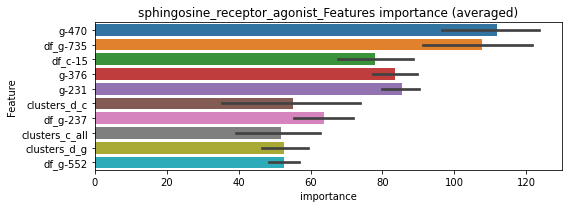

len(train_index) : 3893
len(valid_index) : 3894
================================= fold 1/2 sphingosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0200708	valid_1's binary_logloss: 0.0396428
[200]	training's binary_logloss: 0.002993	valid_1's binary_logloss: 0.0191922
[300]	training's binary_logloss: 0.000792806	valid_1's binary_logloss: 0.0150332
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.000719103	valid_1's binary_logloss: 0.0148939


len(train_index) : 3894
len(valid_index) : 3893
================================= fold 2/2 sphingosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190185	valid_1's binary_logloss: 0.0344056
[200]	training's binary_logloss: 0.00284679	valid_1's binary_logloss: 0.0128023
[300]	training's binary_logloss: 0.000787864	valid_1's binary_logloss: 0.00784739
[400]	training's binary_logloss: 0.00038624	valid_1's binary_logloss: 0.00673548
Early stopping, best iteration is:
[457]	training's binary_logloss: 0.000296764	valid_1's binary_logloss: 0.00641308


sphingosine_receptor_agonist logloss: 0.010654023889483947
src_inhibitor, len(trt): 71, len(othr): 3277, target_rate: 0.0029814 → Adj_target_rate: 0.0031461


neg labels: 3289 → selected neg labels: 3277


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.042499	valid_1's binary_logloss: 0.0889912
[200]	training's binary_logloss: 0.00809022	valid_1's binary_logloss: 0.0404487
[300]	training's binary_logloss: 0.00245634	valid_1's binary_logloss: 0.0280849
[400]	training's binary_logloss: 0.00119384	valid_1's binary_logloss: 0.0245869
[500]	training's binary_logloss: 0.000764378	valid_1's binary_logloss: 0.0225324
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.000728248	valid_1's binary_logloss: 0.0223232
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0474209	valid_1's binary_logloss: 0.0867185
[200]	training's binary_logloss: 0.00932402	valid_1's binary_logloss: 0.0374821
[300]	training's binary_logloss: 0.0027646	valid_1's binary_logloss: 0.0238302
[400]	training's binary_logloss: 0.00130405	valid_1's binary_logloss: 0.0189666
[500]	training's binary_logloss: 0.000824058	

1 / 3 AUC score:1.000
y_Threshold: 0.0109714, Threshold: 0.0299382, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 655/3800
p_label_rate: 0.0200904 Vs.target_rate: 0.00298, Num_p_label: 80.0, conf_0:0.02694, conf_1:0.03293
Num_p_label: 80.0, Expected: 11.9, Adj_threshold_1: 0.0299382
Num_p_label: 65.0, Expected: 11.9, Adj_threshold_2: 0.0399382
Num_p_label: 45.0, Expected: 11.9, Adj_threshold_3: 0.0499382
Num_p_label: 39.0, Expected: 11.9, Adj_threshold_4: 0.0599382
Num_p_label: 32.0, Expected: 11.9, Adj_threshold_5: 0.0699382
Num_p_label: 23.0, Expected: 11.9, Adj_threshold_6: 0.0799382
threshold: 0.0799382, positive_p_label: 23.0/3982, p_label_rate: 0.0057760
positive_y_label: 655.0/3800, y_label_rate: 0.1723684
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0424683	valid_1's binary_logloss: 0.082465
[200]	training's binary_logloss: 0.00772912	valid_1's binary_logloss: 0.0330247
[300]	training's binary_logloss: 0.0023413	valid_1's binary_logloss: 0.0210522
[400]	training's binary_logloss: 0.00113641	valid_1's binary_logloss: 0.0169574
[500]	training's binary_logloss: 0.000732697	valid_1's binary_logloss: 0.0149632
Early stopping, best iteration is:
[546]	training's binary_logloss: 0.000641905	valid_1's binary_logloss: 0.0144577
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0437141	valid_1's binary_logloss: 0.0760689
[200]	training's binary_logloss: 0.00816123	valid_1's binary_logloss: 0.0287421
[300]	training's binary_logloss: 0.0024501	valid_1's binary_logloss: 0.0168406
[400]	training's binary_logloss: 0.00117181	valid_1's binary_logloss: 0.0134568
[500]	training's binary_logloss: 0.000743443	v

2 / 3 AUC score:1.000
y_Threshold: 0.1478250, Threshold: 0.0799382, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 651.0/3792
p_label_rate: 0.0369161 Vs.target_rate: 0.00298, Num_p_label: 147.0, conf_0:0.07194, conf_1:0.08793
Num_p_label: 147.0, Expected: 11.9, Adj_threshold_1: 0.0799382
Num_p_label: 143.0, Expected: 11.9, Adj_threshold_2: 0.0899382
Num_p_label: 132.0, Expected: 11.9, Adj_threshold_3: 0.0999382
Num_p_label: 125.0, Expected: 11.9, Adj_threshold_4: 0.1099382
Num_p_label: 120.0, Expected: 11.9, Adj_threshold_5: 0.1199382
Num_p_label: 115.0, Expected: 11.9, Adj_threshold_6: 0.1299382
Num_p_label: 110.0, Expected: 11.9, Adj_threshold_7: 0.1399382
Num_p_label: 106.0, Expected: 11.9, Adj_threshold_8: 0.1499382
Num_p_label: 100.0, Expected: 11.9, Adj_threshold_9: 0.1599382
Num_p_label: 93.0, Expected: 11.9, Adj_threshold_10: 0.1699382
threshold: 0.1799382, positive_p_label: 88.0/3982, p_label_rate: 0.0220994
positive_y_label: 651.0/3792, y_label_rate

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0425308	valid_1's binary_logloss: 0.0769901
[200]	training's binary_logloss: 0.00777786	valid_1's binary_logloss: 0.0277694
[300]	training's binary_logloss: 0.00232884	valid_1's binary_logloss: 0.0154774
[400]	training's binary_logloss: 0.00113178	valid_1's binary_logloss: 0.0114161
[500]	training's binary_logloss: 0.000725677	valid_1's binary_logloss: 0.00974673
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.00060472	valid_1's binary_logloss: 0.00911123
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.042722	valid_1's binary_logloss: 0.0738373
[200]	training's binary_logloss: 0.00771343	valid_1's binary_logloss: 0.028796
[300]	training's binary_logloss: 0.0023045	valid_1's binary_logloss: 0.0185592
[400]	training's binary_logloss: 0.00111931	valid_1's binary_logloss: 0.0154287
Early stopping, best iteration is:
[409]	trai

3 / 3 AUC score:1.000
y_Threshold: 0.1272998, Threshold: 0.1799382, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 648.0/3786
p_label_rate: 0.0236062 Vs.target_rate: 0.00298, Num_p_label: 94.0, conf_0:0.16194, conf_1:0.19793
Num_p_label: 94.0, Expected: 11.9, Adj_threshold_1: 0.1799382
Num_p_label: 92.0, Expected: 11.9, Adj_threshold_2: 0.1899382
Num_p_label: 87.0, Expected: 11.9, Adj_threshold_3: 0.1999382
Num_p_label: 81.0, Expected: 11.9, Adj_threshold_4: 0.2099382
Num_p_label: 76.0, Expected: 11.9, Adj_threshold_5: 0.2199382
Num_p_label: 73.0, Expected: 11.9, Adj_threshold_6: 0.2299382
Num_p_label: 72.0, Expected: 11.9, Adj_threshold_7: 0.2399382
Num_p_label: 69.0, Expected: 11.9, Adj_threshold_8: 0.2499382
Num_p_label: 66.0, Expected: 11.9, Adj_threshold_9: 0.2599382
Num_p_label: 64.0, Expected: 11.9, Adj_threshold_10: 0.2699382
threshold: 0.2799382, positive_p_label: 61.0/3982, p_label_rate: 0.0153189
positive_y_label: 709.0/7768, y_label_rate: 0.091271

len(train_index) : 3884
len(valid_index) : 3884
================================= fold 1/2 src_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0250918	valid_1's binary_logloss: 0.0617846
[200]	training's binary_logloss: 0.00495298	valid_1's binary_logloss: 0.0384036
[300]	training's binary_logloss: 0.00151273	valid_1's binary_logloss: 0.0331452
Early stopping, best iteration is:
[334]	training's binary_logloss: 0.00112684	valid_1's binary_logloss: 0.0323907


len(train_index) : 3884
len(valid_index) : 3884
================================= fold 2/2 src_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0256847	valid_1's binary_logloss: 0.0623302
[200]	training's binary_logloss: 0.00495977	valid_1's binary_logloss: 0.033499
[300]	training's binary_logloss: 0.00148801	valid_1's binary_logloss: 0.0255309
[400]	training's binary_logloss: 0.000710936	valid_1's binary_logloss: 0.0230029
[500]	training's binary_logloss: 0.000451768	valid_1's binary_logloss: 0.0214928
Early stopping, best iteration is:
[529]	training's binary_logloss: 0.000409814	valid_1's binary_logloss: 0.0213041


src_inhibitor logloss: 0.02684740968072514
steroid, len(trt): 79, len(othr): 3276, target_rate: 0.0033174 → Adj_target_rate: 0.0034449


neg labels: 3289 → selected neg labels: 3276


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.057804	valid_1's binary_logloss: 0.116032
[200]	training's binary_logloss: 0.0126843	valid_1's binary_logloss: 0.0628862
[300]	training's binary_logloss: 0.00378849	valid_1's binary_logloss: 0.047785
[400]	training's binary_logloss: 0.00169173	valid_1's binary_logloss: 0.0421274
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.00114125	valid_1's binary_logloss: 0.0404127
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0589394	valid_1's binary_logloss: 0.115032
[200]	training's binary_logloss: 0.0126967	valid_1's binary_logloss: 0.0631905
[300]	training's binary_logloss: 0.00374735	valid_1's binary_logloss: 0.0506778
Early stopping, best iteration is:
[379]	training's binary_logloss: 0.00194958	valid_1's binary_logloss: 0.0475627


1 / 3 AUC score:0.997
y_Threshold: 0.0140913, Threshold: 0.0222718, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 146 → Positive_corect_labels: 648/3785
p_label_rate: 0.0200904 Vs.target_rate: 0.00332, Num_p_label: 80.0, conf_0:0.02004, conf_1:0.02450
Num_p_label: 80.0, Expected: 13.2, Adj_threshold_1: 0.0222718
Num_p_label: 45.0, Expected: 13.2, Adj_threshold_2: 0.0322718
Num_p_label: 28.0, Expected: 13.2, Adj_threshold_3: 0.0422718
Num_p_label: 18.0, Expected: 13.2, Adj_threshold_4: 0.0522718
threshold: 0.0522718, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 648.0/3785, y_label_rate: 0.1712021
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0537792	valid_1's binary_logloss: 0.113684
[200]	training's binary_logloss: 0.011358	valid_1's binary_logloss: 0.0618931
[300]	training's binary_logloss: 0.00339656	valid_1's binary_logloss: 0.0445293
[400]	training's binary_logloss: 0.00154082	valid_1's binary_logloss: 0.038386
Early stopping, best iteration is:
[471]	training's binary_logloss: 0.00106443	valid_1's binary_logloss: 0.0361819
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0560589	valid_1's binary_logloss: 0.108361
[200]	training's binary_logloss: 0.0116883	valid_1's binary_logloss: 0.0526655
[300]	training's binary_logloss: 0.00345592	valid_1's binary_logloss: 0.0389941
[400]	training's binary_logloss: 0.00158165	valid_1's binary_logloss: 0.0343411
Early stopping, best iteration is:
[468]	training's binary_logloss: 0.0010963	valid_1's binary_logloss: 0.0333941


2 / 3 AUC score:0.999
y_Threshold: 0.0358095, Threshold: 0.0522718, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 14 → Positive_corect_labels: 641.0/3771
p_label_rate: 0.0085384 Vs.target_rate: 0.00332, Num_p_label: 34.0, conf_0:0.04704, conf_1:0.05750
threshold: 0.0522718, positive_p_label: 34.0/3982, p_label_rate: 0.0085384
positive_y_label: 641.0/3771, y_label_rate: 0.1699814
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0539981	valid_1's binary_logloss: 0.0950379
[200]	training's binary_logloss: 0.0114675	valid_1's binary_logloss: 0.0421023
[300]	training's binary_logloss: 0.00339568	valid_1's binary_logloss: 0.0280766
[400]	training's binary_logloss: 0.00153635	valid_1's binary_logloss: 0.023586
[500]	training's binary_logloss: 0.000940889	valid_1's binary_logloss: 0.0223161
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.000810945	valid_1's binary_logloss: 0.0216371
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0553363	valid_1's binary_logloss: 0.102348
[200]	training's binary_logloss: 0.0111934	valid_1's binary_logloss: 0.045958
[300]	training's binary_logloss: 0.00334892	valid_1's binary_logloss: 0.031084
[400]	training's binary_logloss: 0.00153004	valid_1's binary_logloss: 0.0256163
[500]	training's binary_logloss: 0.000933535	vali

3 / 3 AUC score:1.000
y_Threshold: 0.0332008, Threshold: 0.0522718, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 637.0/3763
p_label_rate: 0.0082873 Vs.target_rate: 0.00332, Num_p_label: 33.0, conf_0:0.04704, conf_1:0.05750
threshold: 0.0522718, positive_p_label: 33.0/3982, p_label_rate: 0.0082873
positive_y_label: 670.0/7745, y_label_rate: 0.0865074


len(train_index) : 3872
len(valid_index) : 3873
================================= fold 1/2 steroid=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0306574	valid_1's binary_logloss: 0.0695353
[200]	training's binary_logloss: 0.00616379	valid_1's binary_logloss: 0.0401972
[300]	training's binary_logloss: 0.00181894	valid_1's binary_logloss: 0.0334866
[400]	training's binary_logloss: 0.000821396	valid_1's binary_logloss: 0.031487
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.000794805	valid_1's binary_logloss: 0.0313638


len(train_index) : 3873
len(valid_index) : 3872
================================= fold 2/2 steroid=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0325096	valid_1's binary_logloss: 0.0703404
[200]	training's binary_logloss: 0.0070031	valid_1's binary_logloss: 0.0423913
[300]	training's binary_logloss: 0.00199515	valid_1's binary_logloss: 0.0344991
[400]	training's binary_logloss: 0.00085653	valid_1's binary_logloss: 0.033148
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000676834	valid_1's binary_logloss: 0.0323327


steroid logloss: 0.03184820056433938
syk_inhibitor, len(trt): 19, len(othr): 3286, target_rate: 0.0007979 → Adj_target_rate: 0.0010260


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0212738	valid_1's binary_logloss: 0.0347634
[200]	training's binary_logloss: 0.00234515	valid_1's binary_logloss: 0.0118919
[300]	training's binary_logloss: 0.000667874	valid_1's binary_logloss: 0.00800078
Early stopping, best iteration is:
[371]	training's binary_logloss: 0.000418362	valid_1's binary_logloss: 0.00719397
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0217912	valid_1's binary_logloss: 0.0269191
[200]	training's binary_logloss: 0.00242953	valid_1's binary_logloss: 0.00542097
[300]	training's binary_logloss: 0.000690528	valid_1's binary_logloss: 0.00273446
[400]	training's binary_logloss: 0.000378143	valid_1's binary_logloss: 0.00210523
Early stopping, best iteration is:
[449]	training's binary_logloss: 0.000332414	valid_1's binary_logloss: 0.00204012


1 / 3 AUC score:1.000
y_Threshold: 0.0022467, Threshold: 0.0040428, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00080, Num_p_label: 80.0, conf_0:0.00364, conf_1:0.00445
Num_p_label: 80.0, Expected: 3.2, Adj_threshold_1: 0.0040428
Num_p_label: 20.0, Expected: 3.2, Adj_threshold_2: 0.0140428
Num_p_label: 14.0, Expected: 3.2, Adj_threshold_3: 0.0240428
Num_p_label: 13.0, Expected: 3.2, Adj_threshold_4: 0.0340428
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_5: 0.0440428
Num_p_label: 10.0, Expected: 3.2, Adj_threshold_6: 0.0540428
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_7: 0.0640428
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_8: 0.0740428
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_9: 0.0840428
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_10: 0.0940428
threshold: 0.1040428, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
=============

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0204352	valid_1's binary_logloss: 0.0330436
[200]	training's binary_logloss: 0.00216484	valid_1's binary_logloss: 0.0115482
[300]	training's binary_logloss: 0.000614848	valid_1's binary_logloss: 0.00840664
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.000377681	valid_1's binary_logloss: 0.00775471
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0210309	valid_1's binary_logloss: 0.0260557
[200]	training's binary_logloss: 0.0022859	valid_1's binary_logloss: 0.00456445
[300]	training's binary_logloss: 0.000651217	valid_1's binary_logloss: 0.00191991
[400]	training's binary_logloss: 0.000354841	valid_1's binary_logloss: 0.00128992
[500]	training's binary_logloss: 0.000301261	valid_1's binary_logloss: 0.00121223
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000302379	valid_1's binary_logloss: 0.0012117

2 / 3 AUC score:1.000
y_Threshold: 0.0203936, Threshold: 0.1040428, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 656.0/3809
p_label_rate: 0.0057760 Vs.target_rate: 0.00080, Num_p_label: 23.0, conf_0:0.09364, conf_1:0.11445
Num_p_label: 23.0, Expected: 3.2, Adj_threshold_1: 0.1040428
Num_p_label: 21.0, Expected: 3.2, Adj_threshold_2: 0.1140428
Num_p_label: 19.0, Expected: 3.2, Adj_threshold_3: 0.1240428
Num_p_label: 17.0, Expected: 3.2, Adj_threshold_4: 0.1340428
Num_p_label: 17.0, Expected: 3.2, Adj_threshold_5: 0.1440428
Num_p_label: 16.0, Expected: 3.2, Adj_threshold_6: 0.1540428
Num_p_label: 15.0, Expected: 3.2, Adj_threshold_7: 0.1640428
Num_p_label: 15.0, Expected: 3.2, Adj_threshold_8: 0.1740428
Num_p_label: 14.0, Expected: 3.2, Adj_threshold_9: 0.1840428
Num_p_label: 14.0, Expected: 3.2, Adj_threshold_10: 0.1940428
threshold: 0.2040428, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 656.0/3809, y_label_rate: 0.1722237
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0203626	valid_1's binary_logloss: 0.0346028
[200]	training's binary_logloss: 0.0021855	valid_1's binary_logloss: 0.0127839
[300]	training's binary_logloss: 0.00062642	valid_1's binary_logloss: 0.00845844
[400]	training's binary_logloss: 0.000349283	valid_1's binary_logloss: 0.00721969
Early stopping, best iteration is:
[457]	training's binary_logloss: 0.000308311	valid_1's binary_logloss: 0.00699361
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0209999	valid_1's binary_logloss: 0.0244685
[200]	training's binary_logloss: 0.00222872	valid_1's binary_logloss: 0.00329423
[300]	training's binary_logloss: 0.000632279	valid_1's binary_logloss: 0.00113401
[400]	training's binary_logloss: 0.00034779	valid_1's binary_logloss: 0.000686543
[500]	training's binary_logloss: 0.00029285	valid_1's binary_logloss: 0.000592006
Early stopping, best iteration is:

3 / 3 AUC score:1.000
y_Threshold: 0.0303915, Threshold: 0.2040428, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3809
p_label_rate: 0.0035158 Vs.target_rate: 0.00080, Num_p_label: 14.0, conf_0:0.18364, conf_1:0.22445
Num_p_label: 14.0, Expected: 3.2, Adj_threshold_1: 0.2040428
Num_p_label: 13.0, Expected: 3.2, Adj_threshold_2: 0.2140428
Num_p_label: 12.0, Expected: 3.2, Adj_threshold_3: 0.2240428
Num_p_label: 12.0, Expected: 3.2, Adj_threshold_4: 0.2340428
Num_p_label: 12.0, Expected: 3.2, Adj_threshold_5: 0.2440428
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_6: 0.2540428
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_7: 0.2640428
Num_p_label: 10.0, Expected: 3.2, Adj_threshold_8: 0.2740428
Num_p_label: 9.0, Expected: 3.2, Adj_threshold_9: 0.2840428
Num_p_label: 9.0, Expected: 3.2, Adj_threshold_10: 0.2940428
threshold: 0.3040428, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 664.0/7791, y_label_rate: 0.0852265


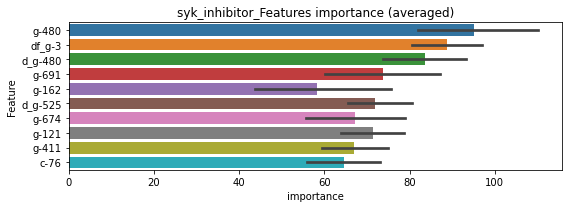

len(train_index) : 3895
len(valid_index) : 3896
================================= fold 1/2 syk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0108608	valid_1's binary_logloss: 0.0160362
[200]	training's binary_logloss: 0.00115462	valid_1's binary_logloss: 0.00426513
[300]	training's binary_logloss: 0.000330027	valid_1's binary_logloss: 0.00268655
[400]	training's binary_logloss: 0.000183448	valid_1's binary_logloss: 0.00234952
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.000177763	valid_1's binary_logloss: 0.00231501


len(train_index) : 3896
len(valid_index) : 3895
================================= fold 2/2 syk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0113144	valid_1's binary_logloss: 0.0165403
[200]	training's binary_logloss: 0.00121625	valid_1's binary_logloss: 0.00429138
[300]	training's binary_logloss: 0.000341347	valid_1's binary_logloss: 0.00264366
[400]	training's binary_logloss: 0.000188825	valid_1's binary_logloss: 0.00227171
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00016771	valid_1's binary_logloss: 0.00219064


syk_inhibitor logloss: 0.002252833490386309
tachykinin_antagonist, len(trt): 60, len(othr): 3279, target_rate: 0.0025195 → Adj_target_rate: 0.0027266


neg labels: 3289 → selected neg labels: 3279


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0518708	valid_1's binary_logloss: 0.0988687
[200]	training's binary_logloss: 0.0104499	valid_1's binary_logloss: 0.0489783
[300]	training's binary_logloss: 0.00290007	valid_1's binary_logloss: 0.0370846
[400]	training's binary_logloss: 0.00130576	valid_1's binary_logloss: 0.0337953
Early stopping, best iteration is:
[408]	training's binary_logloss: 0.00124653	valid_1's binary_logloss: 0.0337411
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0506095	valid_1's binary_logloss: 0.0922901
[200]	training's binary_logloss: 0.00985711	valid_1's binary_logloss: 0.0353725
[300]	training's binary_logloss: 0.00291738	valid_1's binary_logloss: 0.0214424
[400]	training's binary_logloss: 0.00133196	valid_1's binary_logloss: 0.0168388
[500]	training's binary_logloss: 0.000818505	valid_1's binary_logloss: 0.0148697
Early stopping, best iteration is:
[543]	trai

1 / 3 AUC score:0.998
y_Threshold: 0.0082489, Threshold: 0.0119414, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 140 → Positive_corect_labels: 651/3794
p_label_rate: 0.0200904 Vs.target_rate: 0.00252, Num_p_label: 80.0, conf_0:0.01075, conf_1:0.01314
Num_p_label: 80.0, Expected: 10.0, Adj_threshold_1: 0.0119414
Num_p_label: 27.0, Expected: 10.0, Adj_threshold_2: 0.0219414
Num_p_label: 19.0, Expected: 10.0, Adj_threshold_3: 0.0319414
threshold: 0.0319414, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 651.0/3794, y_label_rate: 0.1715867
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0494892	valid_1's binary_logloss: 0.0882412
[200]	training's binary_logloss: 0.00912763	valid_1's binary_logloss: 0.036242
[300]	training's binary_logloss: 0.0026347	valid_1's binary_logloss: 0.0237493
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00138357	valid_1's binary_logloss: 0.0198688
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0488885	valid_1's binary_logloss: 0.0875813
[200]	training's binary_logloss: 0.00923021	valid_1's binary_logloss: 0.0327313
[300]	training's binary_logloss: 0.00267417	valid_1's binary_logloss: 0.018565
[400]	training's binary_logloss: 0.00124457	valid_1's binary_logloss: 0.0139082
[500]	training's binary_logloss: 0.000784953	valid_1's binary_logloss: 0.0122675
Early stopping, best iteration is:
[554]	training's binary_logloss: 0.000659264	valid_1's binary_logloss: 0.0116259


2 / 3 AUC score:1.000
y_Threshold: 0.0687997, Threshold: 0.0319414, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 649.0/3790
p_label_rate: 0.0100452 Vs.target_rate: 0.00252, Num_p_label: 40.0, conf_0:0.02875, conf_1:0.03514
Num_p_label: 40.0, Expected: 10.0, Adj_threshold_1: 0.0319414
Num_p_label: 30.0, Expected: 10.0, Adj_threshold_2: 0.0419414
Num_p_label: 21.0, Expected: 10.0, Adj_threshold_3: 0.0519414
Num_p_label: 19.0, Expected: 10.0, Adj_threshold_4: 0.0619414
threshold: 0.0619414, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 649.0/3790, y_label_rate: 0.1712401
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0487926	valid_1's binary_logloss: 0.0885554
[200]	training's binary_logloss: 0.0091836	valid_1's binary_logloss: 0.041538
[300]	training's binary_logloss: 0.00263761	valid_1's binary_logloss: 0.0296267
[400]	training's binary_logloss: 0.00123376	valid_1's binary_logloss: 0.0262323
[500]	training's binary_logloss: 0.000775392	valid_1's binary_logloss: 0.0247419
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.00074174	valid_1's binary_logloss: 0.0246781
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0494674	valid_1's binary_logloss: 0.0854128
[200]	training's binary_logloss: 0.00923265	valid_1's binary_logloss: 0.0311899
[300]	training's binary_logloss: 0.00271798	valid_1's binary_logloss: 0.0183765
[400]	training's binary_logloss: 0.00125944	valid_1's binary_logloss: 0.0144169
[500]	training's binary_logloss: 0.000786186	v

3 / 3 AUC score:1.000
y_Threshold: 0.0324428, Threshold: 0.0619414, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 14 → Positive_corect_labels: 642.0/3776
p_label_rate: 0.0042692 Vs.target_rate: 0.00252, Num_p_label: 17.0, conf_0:0.05575, conf_1:0.06814
threshold: 0.0619414, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 659.0/7758, y_label_rate: 0.0849446


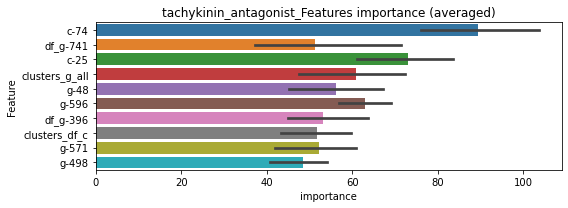

len(train_index) : 3879
len(valid_index) : 3879
================================= fold 1/2 tachykinin_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0287502	valid_1's binary_logloss: 0.0542521
[200]	training's binary_logloss: 0.00539387	valid_1's binary_logloss: 0.0264527
[300]	training's binary_logloss: 0.00152063	valid_1's binary_logloss: 0.0204179
[400]	training's binary_logloss: 0.000687694	valid_1's binary_logloss: 0.0193236
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.000731353	valid_1's binary_logloss: 0.0192262


len(train_index) : 3879
len(valid_index) : 3879
================================= fold 2/2 tachykinin_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0271857	valid_1's binary_logloss: 0.0563044
[200]	training's binary_logloss: 0.00518461	valid_1's binary_logloss: 0.029225
[300]	training's binary_logloss: 0.00148704	valid_1's binary_logloss: 0.0232344
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00107787	valid_1's binary_logloss: 0.0225299


tachykinin_antagonist logloss: 0.02087801213991545
tgf-beta_receptor_inhibitor, len(trt): 30, len(othr): 3284, target_rate: 0.0012598 → Adj_target_rate: 0.0015127


neg labels: 3289 → selected neg labels: 3284


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0182497	valid_1's binary_logloss: 0.0230721
[200]	training's binary_logloss: 0.00171878	valid_1's binary_logloss: 0.00552797
[300]	training's binary_logloss: 0.000458453	valid_1's binary_logloss: 0.00445882
Early stopping, best iteration is:
[338]	training's binary_logloss: 0.000346552	valid_1's binary_logloss: 0.00437608
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0184335	valid_1's binary_logloss: 0.0223683
[200]	training's binary_logloss: 0.00171465	valid_1's binary_logloss: 0.00439693
[300]	training's binary_logloss: 0.000467739	valid_1's binary_logloss: 0.00271895
Early stopping, best iteration is:
[386]	training's binary_logloss: 0.000277382	valid_1's binary_logloss: 0.00250279


1 / 3 AUC score:1.000
y_Threshold: 0.0008618, Threshold: 0.0015920, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00126, Num_p_label: 80.0, conf_0:0.00143, conf_1:0.00175
Num_p_label: 80.0, Expected: 5.0, Adj_threshold_1: 0.0015920
Num_p_label: 16.0, Expected: 5.0, Adj_threshold_2: 0.0115920
Num_p_label: 10.0, Expected: 5.0, Adj_threshold_3: 0.0215920
threshold: 0.0215920, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0172561	valid_1's binary_logloss: 0.0200765
[200]	training's binary_logloss: 0.0014272	valid_1's binary_logloss: 0.00240575
[300]	training's binary_logloss: 0.000346519	valid_1's binary_logloss: 0.000746556
[400]	training's binary_logloss: 0.000206131	valid_1's binary_logloss: 0.000481606
[500]	training's binary_logloss: 0.000183939	valid_1's binary_logloss: 0.000441637
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.000182128	valid_1's binary_logloss: 0.000438809
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0171991	valid_1's binary_logloss: 0.0197148
[200]	training's binary_logloss: 0.00141543	valid_1's binary_logloss: 0.00370866
[300]	training's binary_logloss: 0.000346676	valid_1's binary_logloss: 0.00186606


2 / 3 AUC score:1.000
y_Threshold: 0.0879005, Threshold: 0.0215920, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0123054 Vs.target_rate: 0.00126, Num_p_label: 49.0, conf_0:0.01943, conf_1:0.02375


Early stopping, best iteration is:
[389]	training's binary_logloss: 0.000214279	valid_1's binary_logloss: 0.00157951


Num_p_label: 49.0, Expected: 5.0, Adj_threshold_1: 0.0215920
Num_p_label: 41.0, Expected: 5.0, Adj_threshold_2: 0.0315920
Num_p_label: 35.0, Expected: 5.0, Adj_threshold_3: 0.0415920
Num_p_label: 31.0, Expected: 5.0, Adj_threshold_4: 0.0515920
Num_p_label: 29.0, Expected: 5.0, Adj_threshold_5: 0.0615920
Num_p_label: 26.0, Expected: 5.0, Adj_threshold_6: 0.0715920
Num_p_label: 24.0, Expected: 5.0, Adj_threshold_7: 0.0815920
Num_p_label: 22.0, Expected: 5.0, Adj_threshold_8: 0.0915920
Num_p_label: 21.0, Expected: 5.0, Adj_threshold_9: 0.1015920
Num_p_label: 21.0, Expected: 5.0, Adj_threshold_10: 0.1115920
threshold: 0.1215920, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0172561	valid_1's binary_logloss: 0.0200765
[200]	training's binary_logloss: 0.0014272	valid_1's binary_logloss: 0.00240575
[300]	training's binary_logloss: 0.000346519	valid_1's binary_logloss: 0.000746556
[400]	training's binary_logloss: 0.000206131	valid_1's binary_logloss: 0.000481606
[500]	training's binary_logloss: 0.000183939	valid_1's binary_logloss: 0.000441637
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.000182128	valid_1's binary_logloss: 0.000438809
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0171991	valid_1's binary_logloss: 0.0197148
[200]	training's binary_logloss: 0.00141543	valid_1's binary_logloss: 0.00370866
[300]	training's binary_logloss: 0.000346676	valid_1's binary_logloss: 0.00186606


3 / 3 AUC score:1.000
y_Threshold: 0.0879005, Threshold: 0.1215920, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808


Early stopping, best iteration is:
[389]	training's binary_logloss: 0.000214279	valid_1's binary_logloss: 0.00157951


p_label_rate: 0.0050226 Vs.target_rate: 0.00126, Num_p_label: 20.0, conf_0:0.10943, conf_1:0.13375
Num_p_label: 20.0, Expected: 5.0, Adj_threshold_1: 0.1215920
Num_p_label: 19.0, Expected: 5.0, Adj_threshold_2: 0.1315920
Num_p_label: 18.0, Expected: 5.0, Adj_threshold_3: 0.1415920
Num_p_label: 16.0, Expected: 5.0, Adj_threshold_4: 0.1515920
Num_p_label: 16.0, Expected: 5.0, Adj_threshold_5: 0.1615920
Num_p_label: 16.0, Expected: 5.0, Adj_threshold_6: 0.1715920
Num_p_label: 16.0, Expected: 5.0, Adj_threshold_7: 0.1815920
Num_p_label: 16.0, Expected: 5.0, Adj_threshold_8: 0.1915920
Num_p_label: 16.0, Expected: 5.0, Adj_threshold_9: 0.2015920
Num_p_label: 15.0, Expected: 5.0, Adj_threshold_10: 0.2115920
threshold: 0.2215920, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 669.0/7790, y_label_rate: 0.0858793


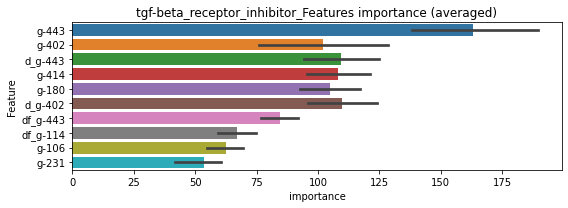

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 tgf-beta_receptor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00965214	valid_1's binary_logloss: 0.0137719
[200]	training's binary_logloss: 0.000869589	valid_1's binary_logloss: 0.00390726
[300]	training's binary_logloss: 0.000216805	valid_1's binary_logloss: 0.00306367
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.000205978	valid_1's binary_logloss: 0.00304286


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 tgf-beta_receptor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00967981	valid_1's binary_logloss: 0.0125347
[200]	training's binary_logloss: 0.00087889	valid_1's binary_logloss: 0.00342793
[300]	training's binary_logloss: 0.000213751	valid_1's binary_logloss: 0.00265672
Early stopping, best iteration is:
[313]	training's binary_logloss: 0.000192611	valid_1's binary_logloss: 0.00262021


tgf-beta_receptor_inhibitor logloss: 0.002831536067444257
thrombin_inhibitor, len(trt): 19, len(othr): 3286, target_rate: 0.0007979 → Adj_target_rate: 0.0010260


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0249697	valid_1's binary_logloss: 0.0384183
[200]	training's binary_logloss: 0.00345186	valid_1's binary_logloss: 0.0122039
[300]	training's binary_logloss: 0.000931129	valid_1's binary_logloss: 0.00566112
[400]	training's binary_logloss: 0.000445907	valid_1's binary_logloss: 0.00398411
[500]	training's binary_logloss: 0.000329435	valid_1's binary_logloss: 0.00346414
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.000329435	valid_1's binary_logloss: 0.00346414
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0249071	valid_1's binary_logloss: 0.0298495
[200]	training's binary_logloss: 0.00309113	valid_1's binary_logloss: 0.00492112
[300]	training's binary_logloss: 0.000880478	valid_1's binary_logloss: 0.0017341
[400]	training's binary_logloss: 0.000461364	valid_1's binary_logloss: 0.000995802
[500]	training's binary_logloss:

1 / 3 AUC score:1.000
y_Threshold: 0.0021429, Threshold: 0.0042395, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00080, Num_p_label: 80.0, conf_0:0.00382, conf_1:0.00466
Num_p_label: 80.0, Expected: 3.2, Adj_threshold_1: 0.0042395
Num_p_label: 25.0, Expected: 3.2, Adj_threshold_2: 0.0142395
Num_p_label: 13.0, Expected: 3.2, Adj_threshold_3: 0.0242395
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_4: 0.0342395
Num_p_label: 5.0, Expected: 3.2, Adj_threshold_5: 0.0442395
threshold: 0.0442395, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0231972	valid_1's binary_logloss: 0.0321384
[200]	training's binary_logloss: 0.00278325	valid_1's binary_logloss: 0.00695264
[300]	training's binary_logloss: 0.000810811	valid_1's binary_logloss: 0.00290265
[400]	training's binary_logloss: 0.000436396	valid_1's binary_logloss: 0.0018906
[500]	training's binary_logloss: 0.000347549	valid_1's binary_logloss: 0.00163858
Early stopping, best iteration is:
[523]	training's binary_logloss: 0.000341381	valid_1's binary_logloss: 0.00161544
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0241457	valid_1's binary_logloss: 0.0277576
[200]	training's binary_logloss: 0.00289453	valid_1's binary_logloss: 0.00415249
[300]	training's binary_logloss: 0.000827593	valid_1's binary_logloss: 0.00137958
[400]	training's binary_logloss: 0.00044544	valid_1's binary_logloss: 0.000789069
[500]	training's binary_logloss:

2 / 3 AUC score:1.000
y_Threshold: 0.1234179, Threshold: 0.0442395, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0052737 Vs.target_rate: 0.00080, Num_p_label: 21.0, conf_0:0.03982, conf_1:0.04866
Num_p_label: 21.0, Expected: 3.2, Adj_threshold_1: 0.0442395
Num_p_label: 17.0, Expected: 3.2, Adj_threshold_2: 0.0542395
Num_p_label: 14.0, Expected: 3.2, Adj_threshold_3: 0.0642395
Num_p_label: 13.0, Expected: 3.2, Adj_threshold_4: 0.0742395
Num_p_label: 12.0, Expected: 3.2, Adj_threshold_5: 0.0842395
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_6: 0.0942395
Num_p_label: 6.0, Expected: 3.2, Adj_threshold_7: 0.1042395
threshold: 0.1042395, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0231972	valid_1's binary_logloss: 0.0321384
[200]	training's binary_logloss: 0.00278325	valid_1's binary_logloss: 0.00695264
[300]	training's binary_logloss: 0.000810811	valid_1's binary_logloss: 0.00290265
[400]	training's binary_logloss: 0.000436396	valid_1's binary_logloss: 0.0018906
[500]	training's binary_logloss: 0.000347549	valid_1's binary_logloss: 0.00163858
Early stopping, best iteration is:
[523]	training's binary_logloss: 0.000341381	valid_1's binary_logloss: 0.00161544
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0241457	valid_1's binary_logloss: 0.0277576
[200]	training's binary_logloss: 0.00289453	valid_1's binary_logloss: 0.00415249
[300]	training's binary_logloss: 0.000827593	valid_1's binary_logloss: 0.00137958
[400]	training's binary_logloss: 0.00044544	valid_1's binary_logloss: 0.000789069
[500]	training's binary_logloss:

3 / 3 AUC score:1.000
y_Threshold: 0.1234179, Threshold: 0.1042395, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0015068 Vs.target_rate: 0.00080, Num_p_label: 6.0, conf_0:0.09382, conf_1:0.11466
threshold: 0.1042395, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 663.0/7793, y_label_rate: 0.0850764


len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 thrombin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0138053	valid_1's binary_logloss: 0.0207204
[200]	training's binary_logloss: 0.00164635	valid_1's binary_logloss: 0.00784107
[300]	training's binary_logloss: 0.000446736	valid_1's binary_logloss: 0.00634816
Early stopping, best iteration is:
[313]	training's binary_logloss: 0.00039839	valid_1's binary_logloss: 0.00629548


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 thrombin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0139051	valid_1's binary_logloss: 0.0198916
[200]	training's binary_logloss: 0.00171326	valid_1's binary_logloss: 0.00558329
[300]	training's binary_logloss: 0.000468922	valid_1's binary_logloss: 0.0034514
[400]	training's binary_logloss: 0.000243586	valid_1's binary_logloss: 0.0030292
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.000197289	valid_1's binary_logloss: 0.0029046


thrombin_inhibitor logloss: 0.004600256490689754
thymidylate_synthase_inhibitor, len(trt): 37, len(othr): 3285, target_rate: 0.0015537 → Adj_target_rate: 0.0018079


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0343105	valid_1's binary_logloss: 0.0553674
[200]	training's binary_logloss: 0.00494648	valid_1's binary_logloss: 0.0181612
[300]	training's binary_logloss: 0.00139529	valid_1's binary_logloss: 0.0109073
[400]	training's binary_logloss: 0.000695258	valid_1's binary_logloss: 0.00924046
[500]	training's binary_logloss: 0.000481934	valid_1's binary_logloss: 0.00834954
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.000462788	valid_1's binary_logloss: 0.0082531
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0351206	valid_1's binary_logloss: 0.0509268
[200]	training's binary_logloss: 0.00530434	valid_1's binary_logloss: 0.0120622
[300]	training's binary_logloss: 0.00151371	valid_1's binary_logloss: 0.00544061
[400]	training's binary_logloss: 0.000736593	valid_1's binary_logloss: 0.00343109
[500]	training's binary_logloss: 0.00

1 / 3 AUC score:1.000
y_Threshold: 0.0030381, Threshold: 0.0045940, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00155, Num_p_label: 80.0, conf_0:0.00413, conf_1:0.00505
Num_p_label: 80.0, Expected: 6.2, Adj_threshold_1: 0.0045940
Num_p_label: 18.0, Expected: 6.2, Adj_threshold_2: 0.0145940
Num_p_label: 11.0, Expected: 6.2, Adj_threshold_3: 0.0245940
threshold: 0.0245940, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0331465	valid_1's binary_logloss: 0.0549527
[200]	training's binary_logloss: 0.00473387	valid_1's binary_logloss: 0.0172927
[300]	training's binary_logloss: 0.00133361	valid_1's binary_logloss: 0.0107394
[400]	training's binary_logloss: 0.000672162	valid_1's binary_logloss: 0.00899324
[500]	training's binary_logloss: 0.000465329	valid_1's binary_logloss: 0.00832869
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000459441	valid_1's binary_logloss: 0.00825653
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0341185	valid_1's binary_logloss: 0.049906
[200]	training's binary_logloss: 0.00497529	valid_1's binary_logloss: 0.0111366
[300]	training's binary_logloss: 0.0014279	valid_1's binary_logloss: 0.004848
[400]	training's binary_logloss: 0.000709571	valid_1's binary_logloss: 0.00321624
[500]	training's binary_logloss: 0.00049

2 / 3 AUC score:1.000
y_Threshold: 0.0207692, Threshold: 0.0245940, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0050226 Vs.target_rate: 0.00155, Num_p_label: 20.0, conf_0:0.02213, conf_1:0.02705
Num_p_label: 20.0, Expected: 6.2, Adj_threshold_1: 0.0245940
Num_p_label: 14.0, Expected: 6.2, Adj_threshold_2: 0.0345940
Num_p_label: 12.0, Expected: 6.2, Adj_threshold_3: 0.0445940
threshold: 0.0445940, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0319862	valid_1's binary_logloss: 0.0526847
[200]	training's binary_logloss: 0.00463923	valid_1's binary_logloss: 0.0168031
[300]	training's binary_logloss: 0.00132605	valid_1's binary_logloss: 0.0101122
[400]	training's binary_logloss: 0.00065936	valid_1's binary_logloss: 0.00864309
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.000479299	valid_1's binary_logloss: 0.00765556
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0343719	valid_1's binary_logloss: 0.0580306
[200]	training's binary_logloss: 0.0050058	valid_1's binary_logloss: 0.021784
[300]	training's binary_logloss: 0.00140008	valid_1's binary_logloss: 0.016752
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.000901376	valid_1's binary_logloss: 0.0157308


3 / 3 AUC score:0.999
y_Threshold: 0.0196065, Threshold: 0.0445940, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 654.0/3804
p_label_rate: 0.0035158 Vs.target_rate: 0.00155, Num_p_label: 14.0, conf_0:0.04013, conf_1:0.04905
threshold: 0.0445940, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 668.0/7786, y_label_rate: 0.0857950


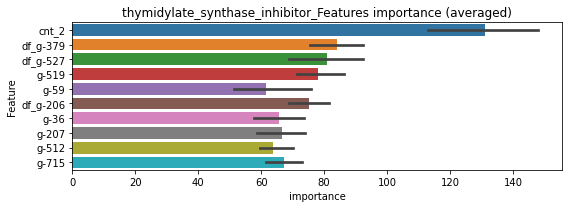

len(train_index) : 3893
len(valid_index) : 3893
================================= fold 1/2 thymidylate_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0181602	valid_1's binary_logloss: 0.0320058
[200]	training's binary_logloss: 0.00263208	valid_1's binary_logloss: 0.0132139
[300]	training's binary_logloss: 0.000727583	valid_1's binary_logloss: 0.0101708
Early stopping, best iteration is:
[326]	training's binary_logloss: 0.000579687	valid_1's binary_logloss: 0.00989818


len(train_index) : 3893
len(valid_index) : 3893
================================= fold 2/2 thymidylate_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0179508	valid_1's binary_logloss: 0.0295081
[200]	training's binary_logloss: 0.00255424	valid_1's binary_logloss: 0.00943653
[300]	training's binary_logloss: 0.000726198	valid_1's binary_logloss: 0.0061955
[400]	training's binary_logloss: 0.000364323	valid_1's binary_logloss: 0.00519231
[500]	training's binary_logloss: 0.000248855	valid_1's binary_logloss: 0.00486173
Early stopping, best iteration is:
[504]	training's binary_logloss: 0.000246236	valid_1's binary_logloss: 0.00484986


thymidylate_synthase_inhibitor logloss: 0.00737401804424607
tlr_agonist, len(trt): 30, len(othr): 3284, target_rate: 0.0012598 → Adj_target_rate: 0.0015127


neg labels: 3289 → selected neg labels: 3284


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0328941	valid_1's binary_logloss: 0.0520373
[200]	training's binary_logloss: 0.00480959	valid_1's binary_logloss: 0.0146846
[300]	training's binary_logloss: 0.0013305	valid_1's binary_logloss: 0.00802167
[400]	training's binary_logloss: 0.000663077	valid_1's binary_logloss: 0.00624328
[500]	training's binary_logloss: 0.000466745	valid_1's binary_logloss: 0.00545505
Early stopping, best iteration is:
[526]	training's binary_logloss: 0.000446221	valid_1's binary_logloss: 0.00537203
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0337126	valid_1's binary_logloss: 0.0497916
[200]	training's binary_logloss: 0.00504859	valid_1's binary_logloss: 0.0128821
[300]	training's binary_logloss: 0.00140369	valid_1's binary_logloss: 0.00604266
[400]	training's binary_logloss: 0.000691571	valid_1's binary_logloss: 0.00426466
[500]	training's binary_logloss: 0.0

1 / 3 AUC score:1.000
y_Threshold: 0.0027325, Threshold: 0.0040939, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00126, Num_p_label: 80.0, conf_0:0.00368, conf_1:0.00450
Num_p_label: 80.0, Expected: 5.0, Adj_threshold_1: 0.0040939
Num_p_label: 7.0, Expected: 5.0, Adj_threshold_2: 0.0140939
threshold: 0.0140939, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0326966	valid_1's binary_logloss: 0.0533095
[200]	training's binary_logloss: 0.0045386	valid_1's binary_logloss: 0.0157049
[300]	training's binary_logloss: 0.00128903	valid_1's binary_logloss: 0.00900714
[400]	training's binary_logloss: 0.000654766	valid_1's binary_logloss: 0.00681934
[500]	training's binary_logloss: 0.000462904	valid_1's binary_logloss: 0.00603608
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.000446389	valid_1's binary_logloss: 0.00597869
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0330619	valid_1's binary_logloss: 0.0473011
[200]	training's binary_logloss: 0.0048952	valid_1's binary_logloss: 0.0118176
[300]	training's binary_logloss: 0.00138125	valid_1's binary_logloss: 0.00538946
[400]	training's binary_logloss: 0.000685518	valid_1's binary_logloss: 0.0037348
[500]	training's binary_logloss: 0.000

2 / 3 AUC score:1.000
y_Threshold: 0.0324905, Threshold: 0.0140939, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0075339 Vs.target_rate: 0.00126, Num_p_label: 30.0, conf_0:0.01268, conf_1:0.01550
Num_p_label: 30.0, Expected: 5.0, Adj_threshold_1: 0.0140939
Num_p_label: 15.0, Expected: 5.0, Adj_threshold_2: 0.0240939
Num_p_label: 3.0, Expected: 5.0, Adj_threshold_3: 0.0340939
threshold: 0.0340939, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0326966	valid_1's binary_logloss: 0.0533095
[200]	training's binary_logloss: 0.0045386	valid_1's binary_logloss: 0.0157049
[300]	training's binary_logloss: 0.00128903	valid_1's binary_logloss: 0.00900714
[400]	training's binary_logloss: 0.000654766	valid_1's binary_logloss: 0.00681934
[500]	training's binary_logloss: 0.000462904	valid_1's binary_logloss: 0.00603608
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.000446389	valid_1's binary_logloss: 0.00597869
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0330619	valid_1's binary_logloss: 0.0473011
[200]	training's binary_logloss: 0.0048952	valid_1's binary_logloss: 0.0118176
[300]	training's binary_logloss: 0.00138125	valid_1's binary_logloss: 0.00538946
[400]	training's binary_logloss: 0.000685518	valid_1's binary_logloss: 0.0037348
[500]	training's binary_logloss: 0.000

3 / 3 AUC score:1.000
y_Threshold: 0.0324905, Threshold: 0.0340939, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0007534 Vs.target_rate: 0.00126, Num_p_label: 3.0, conf_0:0.03068, conf_1:0.03750
threshold: 0.0340939, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 659.0/7790, y_label_rate: 0.0845956


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 tlr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185658	valid_1's binary_logloss: 0.0297353
[200]	training's binary_logloss: 0.00272874	valid_1's binary_logloss: 0.00930392
[300]	training's binary_logloss: 0.000734202	valid_1's binary_logloss: 0.00581565
[400]	training's binary_logloss: 0.000349757	valid_1's binary_logloss: 0.00503186
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.00024557	valid_1's binary_logloss: 0.00476724


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 tlr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.017895	valid_1's binary_logloss: 0.0288576
[200]	training's binary_logloss: 0.00258679	valid_1's binary_logloss: 0.00934726
[300]	training's binary_logloss: 0.000684252	valid_1's binary_logloss: 0.00605748
[400]	training's binary_logloss: 0.000336132	valid_1's binary_logloss: 0.00518896
[500]	training's binary_logloss: 0.000235096	valid_1's binary_logloss: 0.00474408
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.000230497	valid_1's binary_logloss: 0.00473956


tlr_agonist logloss: 0.0047534021431019195
tlr_antagonist, len(trt): 7, len(othr): 3287, target_rate: 0.0002939 → Adj_target_rate: 0.0004391


neg labels: 3289 → selected neg labels: 3287


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160838	valid_1's binary_logloss: 0.0176919
[200]	training's binary_logloss: 0.00141585	valid_1's binary_logloss: 0.00197959
[300]	training's binary_logloss: 0.000395799	valid_1's binary_logloss: 0.000659432
[400]	training's binary_logloss: 0.000237859	valid_1's binary_logloss: 0.000424861
[500]	training's binary_logloss: 0.000214154	valid_1's binary_logloss: 0.000388082
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.00021091	valid_1's binary_logloss: 0.000383177
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164229	valid_1's binary_logloss: 0.0172847
[200]	training's binary_logloss: 0.00142408	valid_1's binary_logloss: 0.00167038
[300]	training's binary_logloss: 0.000398392	valid_1's binary_logloss: 0.00051064
[400]	training's binary_logloss: 0.00024286	valid_1's binary_logloss: 0.000311205
Early stopping, best iterati

1 / 3 AUC score:1.000
y_Threshold: 0.0007455, Threshold: 0.0013514, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00029, Num_p_label: 80.0, conf_0:0.00122, conf_1:0.00149
Num_p_label: 80.0, Expected: 1.2, Adj_threshold_1: 0.0013514
Num_p_label: 6.0, Expected: 1.2, Adj_threshold_2: 0.0113514
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_3: 0.0213514
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_4: 0.0313514
Num_p_label: 1.0, Expected: 1.2, Adj_threshold_5: 0.0413514
threshold: 0.0413514, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.016371	valid_1's binary_logloss: 0.0170923
[200]	training's binary_logloss: 0.00139503	valid_1's binary_logloss: 0.00159094
[300]	training's binary_logloss: 0.000388026	valid_1's binary_logloss: 0.000466112
[400]	training's binary_logloss: 0.000236628	valid_1's binary_logloss: 0.000292431
[500]	training's binary_logloss: 0.000209241	valid_1's binary_logloss: 0.000260633
[600]	training's binary_logloss: 0.000206026	valid_1's binary_logloss: 0.00025705
Early stopping, best iteration is:
[636]	training's binary_logloss: 0.000205885	valid_1's binary_logloss: 0.000256895
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165714	valid_1's binary_logloss: 0.0175584
[200]	training's binary_logloss: 0.00139143	valid_1's binary_logloss: 0.00162034
[300]	training's binary_logloss: 0.000380368	valid_1's binary_logloss: 0.000477722
[400]	training's binary_log

2 / 3 AUC score:1.000
y_Threshold: 0.1713673, Threshold: 0.0413514, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0020090 Vs.target_rate: 0.00029, Num_p_label: 8.0, conf_0:0.03722, conf_1:0.04549
Num_p_label: 8.0, Expected: 1.2, Adj_threshold_1: 0.0413514
Num_p_label: 6.0, Expected: 1.2, Adj_threshold_2: 0.0513514
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_3: 0.0613514
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_4: 0.0713514
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_5: 0.0813514
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_6: 0.0913514
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_7: 0.1013514
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_8: 0.1113514
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_9: 0.1213514
Num_p_label: 4.0, Expected: 1.2, Adj_threshold_10: 0.1313514
threshold: 0.1413514, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Ps

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.016371	valid_1's binary_logloss: 0.0170923
[200]	training's binary_logloss: 0.00139503	valid_1's binary_logloss: 0.00159094
[300]	training's binary_logloss: 0.000388026	valid_1's binary_logloss: 0.000466112
[400]	training's binary_logloss: 0.000236628	valid_1's binary_logloss: 0.000292431
[500]	training's binary_logloss: 0.000209241	valid_1's binary_logloss: 0.000260633
[600]	training's binary_logloss: 0.000206026	valid_1's binary_logloss: 0.00025705
Early stopping, best iteration is:
[636]	training's binary_logloss: 0.000205885	valid_1's binary_logloss: 0.000256895
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165714	valid_1's binary_logloss: 0.0175584
[200]	training's binary_logloss: 0.00139143	valid_1's binary_logloss: 0.00162034
[300]	training's binary_logloss: 0.000380368	valid_1's binary_logloss: 0.000477722
[400]	training's binary_log

3 / 3 AUC score:1.000
y_Threshold: 0.1713673, Threshold: 0.1413514, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0010045 Vs.target_rate: 0.00029, Num_p_label: 4.0, conf_0:0.12722, conf_1:0.15549
Num_p_label: 4.0, Expected: 1.2, Adj_threshold_1: 0.1413514
Num_p_label: 4.0, Expected: 1.2, Adj_threshold_2: 0.1513514
Num_p_label: 4.0, Expected: 1.2, Adj_threshold_3: 0.1613514
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_4: 0.1713514
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_5: 0.1813514
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_6: 0.1913514
Num_p_label: 2.0, Expected: 1.2, Adj_threshold_7: 0.2013514
threshold: 0.2013514, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 659.0/7794, y_label_rate: 0.0845522


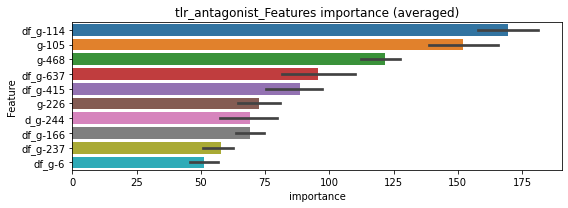

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 tlr_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00874153	valid_1's binary_logloss: 0.0100458
[200]	training's binary_logloss: 0.000754066	valid_1's binary_logloss: 0.00180714
[300]	training's binary_logloss: 0.000210923	valid_1's binary_logloss: 0.00132768
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.000203604	valid_1's binary_logloss: 0.00132033


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 tlr_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00875307	valid_1's binary_logloss: 0.0123541
[200]	training's binary_logloss: 0.000737545	valid_1's binary_logloss: 0.00371236


tlr_antagonist logloss: 0.0020963395783241997


Early stopping, best iteration is:
[250]	training's binary_logloss: 0.000338777	valid_1's binary_logloss: 0.00287235


tnf_inhibitor, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0345879	valid_1's binary_logloss: 0.0585784
[200]	training's binary_logloss: 0.00567948	valid_1's binary_logloss: 0.0222439
[300]	training's binary_logloss: 0.00156338	valid_1's binary_logloss: 0.0133595
[400]	training's binary_logloss: 0.000734669	valid_1's binary_logloss: 0.0109456
[500]	training's binary_logloss: 0.000492249	valid_1's binary_logloss: 0.00987774
Early stopping, best iteration is:
[548]	training's binary_logloss: 0.000453299	valid_1's binary_logloss: 0.00970776
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0378056	valid_1's binary_logloss: 0.0521274
[200]	training's binary_logloss: 0.00591183	valid_1's binary_logloss: 0.0136782
[300]	training's binary_logloss: 0.00168096	valid_1's binary_logloss: 0.00671096
[400]	training's binary_logloss: 0.000818379	valid_1's binary_logloss: 0.00497727
[500]	training's binary_logloss: 0.00

1 / 3 AUC score:1.000
y_Threshold: 0.0034067, Threshold: 0.0066692, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00151, Num_p_label: 80.0, conf_0:0.00600, conf_1:0.00734
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0066692
Num_p_label: 16.0, Expected: 6.0, Adj_threshold_2: 0.0166692
Num_p_label: 7.0, Expected: 6.0, Adj_threshold_3: 0.0266692
threshold: 0.0266692, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0339442	valid_1's binary_logloss: 0.0584554
[200]	training's binary_logloss: 0.00515171	valid_1's binary_logloss: 0.0223759
[300]	training's binary_logloss: 0.00148846	valid_1's binary_logloss: 0.0146573
[400]	training's binary_logloss: 0.000739603	valid_1's binary_logloss: 0.012076
[500]	training's binary_logloss: 0.000501355	valid_1's binary_logloss: 0.0108349
Early stopping, best iteration is:
[524]	training's binary_logloss: 0.000479716	valid_1's binary_logloss: 0.0107524
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.03604	valid_1's binary_logloss: 0.0495222
[200]	training's binary_logloss: 0.00551344	valid_1's binary_logloss: 0.0124308
[300]	training's binary_logloss: 0.00160781	valid_1's binary_logloss: 0.00614439
[400]	training's binary_logloss: 0.000791006	valid_1's binary_logloss: 0.0043481
[500]	training's binary_logloss: 0.00052657

2 / 3 AUC score:1.000
y_Threshold: 0.0492390, Threshold: 0.0266692, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0087896 Vs.target_rate: 0.00151, Num_p_label: 35.0, conf_0:0.02400, conf_1:0.02934
Num_p_label: 35.0, Expected: 6.0, Adj_threshold_1: 0.0266692
Num_p_label: 23.0, Expected: 6.0, Adj_threshold_2: 0.0366692
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_3: 0.0466692
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_4: 0.0566692
Num_p_label: 5.0, Expected: 6.0, Adj_threshold_5: 0.0666692
threshold: 0.0666692, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0339442	valid_1's binary_logloss: 0.0584554
[200]	training's binary_logloss: 0.00515171	valid_1's binary_logloss: 0.0223759
[300]	training's binary_logloss: 0.00148846	valid_1's binary_logloss: 0.0146573
[400]	training's binary_logloss: 0.000739603	valid_1's binary_logloss: 0.012076
[500]	training's binary_logloss: 0.000501355	valid_1's binary_logloss: 0.0108349
Early stopping, best iteration is:
[524]	training's binary_logloss: 0.000479716	valid_1's binary_logloss: 0.0107524
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.03604	valid_1's binary_logloss: 0.0495222
[200]	training's binary_logloss: 0.00551344	valid_1's binary_logloss: 0.0124308
[300]	training's binary_logloss: 0.00160781	valid_1's binary_logloss: 0.00614439
[400]	training's binary_logloss: 0.000791006	valid_1's binary_logloss: 0.0043481
[500]	training's binary_logloss: 0.00052657

3 / 3 AUC score:1.000
y_Threshold: 0.0492390, Threshold: 0.0666692, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0012557 Vs.target_rate: 0.00151, Num_p_label: 5.0, conf_0:0.06000, conf_1:0.07334
threshold: 0.0666692, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 661.0/7789, y_label_rate: 0.0848633


len(train_index) : 3894
len(valid_index) : 3895
================================= fold 1/2 tnf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0197502	valid_1's binary_logloss: 0.0342085
[200]	training's binary_logloss: 0.00310533	valid_1's binary_logloss: 0.0129244
[300]	training's binary_logloss: 0.000848807	valid_1's binary_logloss: 0.00910755
[400]	training's binary_logloss: 0.000398953	valid_1's binary_logloss: 0.00821189
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.000392644	valid_1's binary_logloss: 0.00819824


len(train_index) : 3895
len(valid_index) : 3894
================================= fold 2/2 tnf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0202009	valid_1's binary_logloss: 0.0319078
[200]	training's binary_logloss: 0.00322529	valid_1's binary_logloss: 0.0107812
[300]	training's binary_logloss: 0.000881391	valid_1's binary_logloss: 0.00653258
[400]	training's binary_logloss: 0.000418298	valid_1's binary_logloss: 0.00542346
[500]	training's binary_logloss: 0.000271426	valid_1's binary_logloss: 0.00490872
Early stopping, best iteration is:
[527]	training's binary_logloss: 0.000253946	valid_1's binary_logloss: 0.00480257


tnf_inhibitor logloss: 0.006500625656808052
topoisomerase_inhibitor, len(trt): 127, len(othr): 3271, target_rate: 0.0053330 → Adj_target_rate: 0.0051574


neg labels: 3289 → selected neg labels: 3271


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.040137	valid_1's binary_logloss: 0.0902043
[200]	training's binary_logloss: 0.00722617	valid_1's binary_logloss: 0.0578845
[300]	training's binary_logloss: 0.00216428	valid_1's binary_logloss: 0.0505574
Early stopping, best iteration is:
[367]	training's binary_logloss: 0.00128846	valid_1's binary_logloss: 0.0483434
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0373341	valid_1's binary_logloss: 0.091673


1 / 3 AUC score:0.994
y_Threshold: 0.0218259, Threshold: 0.6032234, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[185]	training's binary_logloss: 0.00833823	valid_1's binary_logloss: 0.0758906


Remove_noisy_labels: 159 → Positive_corect_labels: 640/3766
p_label_rate: 0.0200904 Vs.target_rate: 0.00533, Num_p_label: 80.0, conf_0:0.54290, conf_1:0.66355
Num_p_label: 80.0, Expected: 21.2, Adj_threshold_1: 0.6032234
Num_p_label: 77.0, Expected: 21.2, Adj_threshold_2: 0.6132234
Num_p_label: 74.0, Expected: 21.2, Adj_threshold_3: 0.6232234
Num_p_label: 72.0, Expected: 21.2, Adj_threshold_4: 0.6332234
Num_p_label: 69.0, Expected: 21.2, Adj_threshold_5: 0.6432234
Num_p_label: 67.0, Expected: 21.2, Adj_threshold_6: 0.6532234
Num_p_label: 62.0, Expected: 21.2, Adj_threshold_7: 0.6632234
Num_p_label: 59.0, Expected: 21.2, Adj_threshold_8: 0.6732234
Num_p_label: 59.0, Expected: 21.2, Adj_threshold_9: 0.6832234
Num_p_label: 57.0, Expected: 21.2, Adj_threshold_10: 0.6932234
threshold: 0.7032234, positive_p_label: 56.0/3982, p_label_rate: 0.0140633
positive_y_label: 640.0/3766, y_label_rate: 0.1699416
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0310287	valid_1's binary_logloss: 0.0711743
[200]	training's binary_logloss: 0.00427615	valid_1's binary_logloss: 0.0467738
Early stopping, best iteration is:
[257]	training's binary_logloss: 0.00192949	valid_1's binary_logloss: 0.0443384
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.030894	valid_1's binary_logloss: 0.0548061
[200]	training's binary_logloss: 0.00467576	valid_1's binary_logloss: 0.0246179
[300]	training's binary_logloss: 0.0014103	valid_1's binary_logloss: 0.0197957
[400]	training's binary_logloss: 0.000703205	valid_1's binary_logloss: 0.0184582
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.000627803	valid_1's binary_logloss: 0.0182521


2 / 3 AUC score:0.998
y_Threshold: 0.0703992, Threshold: 0.7032234, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 32 → Positive_corect_labels: 624.0/3734
p_label_rate: 0.0354093 Vs.target_rate: 0.00533, Num_p_label: 141.0, conf_0:0.63290, conf_1:0.77355
Num_p_label: 141.0, Expected: 21.2, Adj_threshold_1: 0.7032234
Num_p_label: 140.0, Expected: 21.2, Adj_threshold_2: 0.7132234
Num_p_label: 140.0, Expected: 21.2, Adj_threshold_3: 0.7232234
Num_p_label: 140.0, Expected: 21.2, Adj_threshold_4: 0.7332234
Num_p_label: 139.0, Expected: 21.2, Adj_threshold_5: 0.7432234
Num_p_label: 138.0, Expected: 21.2, Adj_threshold_6: 0.7532234
Num_p_label: 137.0, Expected: 21.2, Adj_threshold_7: 0.7632234
Num_p_label: 136.0, Expected: 21.2, Adj_threshold_8: 0.7732234
Num_p_label: 136.0, Expected: 21.2, Adj_threshold_9: 0.7832234
Num_p_label: 136.0, Expected: 21.2, Adj_threshold_10: 0.7932234
threshold: 0.8032234, positive_p_label: 136.0/3982, p_label_rate: 0.0341537
positive_y_label: 624.0/3734, y_label_r

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0274386	valid_1's binary_logloss: 0.0671451
[200]	training's binary_logloss: 0.00376944	valid_1's binary_logloss: 0.0396252
[300]	training's binary_logloss: 0.00108336	valid_1's binary_logloss: 0.0337703
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.000916583	valid_1's binary_logloss: 0.0331261
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0280643	valid_1's binary_logloss: 0.0516887
[200]	training's binary_logloss: 0.00368761	valid_1's binary_logloss: 0.0274369
[300]	training's binary_logloss: 0.00107439	valid_1's binary_logloss: 0.0244899
Early stopping, best iteration is:
[319]	training's binary_logloss: 0.000912323	valid_1's binary_logloss: 0.024297


3 / 3 AUC score:0.998
y_Threshold: 0.0851059, Threshold: 0.8032234, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 28 → Positive_corect_labels: 610.0/3706
p_label_rate: 0.0389252 Vs.target_rate: 0.00533, Num_p_label: 155.0, conf_0:0.72290, conf_1:0.88355
Num_p_label: 155.0, Expected: 21.2, Adj_threshold_1: 0.8032234
Num_p_label: 150.0, Expected: 21.2, Adj_threshold_2: 0.8132234
Num_p_label: 150.0, Expected: 21.2, Adj_threshold_3: 0.8232234
Num_p_label: 147.0, Expected: 21.2, Adj_threshold_4: 0.8332234
Num_p_label: 147.0, Expected: 21.2, Adj_threshold_5: 0.8432234
Num_p_label: 143.0, Expected: 21.2, Adj_threshold_6: 0.8532234
Num_p_label: 142.0, Expected: 21.2, Adj_threshold_7: 0.8632234
Num_p_label: 142.0, Expected: 21.2, Adj_threshold_8: 0.8732234
Num_p_label: 140.0, Expected: 21.2, Adj_threshold_9: 0.8832234
Num_p_label: 140.0, Expected: 21.2, Adj_threshold_10: 0.8932234
threshold: 0.9032234, positive_p_label: 138.0/3982, p_label_rate: 0.0346560
positive_y_label: 748.0/7688, y_label_r

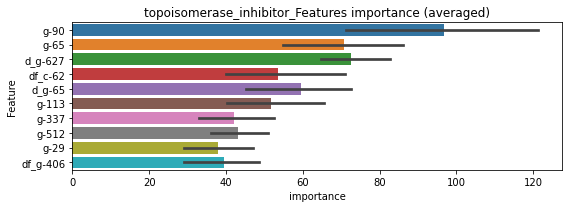

len(train_index) : 3844
len(valid_index) : 3844
================================= fold 1/2 topoisomerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164426	valid_1's binary_logloss: 0.0370549
[200]	training's binary_logloss: 0.00221771	valid_1's binary_logloss: 0.0200108
Early stopping, best iteration is:
[282]	training's binary_logloss: 0.000752307	valid_1's binary_logloss: 0.0166257


len(train_index) : 3844
len(valid_index) : 3844
================================= fold 2/2 topoisomerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0176259	valid_1's binary_logloss: 0.0334257
[200]	training's binary_logloss: 0.00263483	valid_1's binary_logloss: 0.0176845
[300]	training's binary_logloss: 0.000701859	valid_1's binary_logloss: 0.0150345
[400]	training's binary_logloss: 0.000325515	valid_1's binary_logloss: 0.0135925
Early stopping, best iteration is:
[452]	training's binary_logloss: 0.000258867	valid_1's binary_logloss: 0.0133142


topoisomerase_inhibitor logloss: 0.014969948623145917
transient_receptor_potential_channel_antagonist, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0257649	valid_1's binary_logloss: 0.0333094
[200]	training's binary_logloss: 0.00311919	valid_1's binary_logloss: 0.00618434
[300]	training's binary_logloss: 0.000866132	valid_1's binary_logloss: 0.00262656
[400]	training's binary_logloss: 0.000450918	valid_1's binary_logloss: 0.0018865
Early stopping, best iteration is:
[468]	training's binary_logloss: 0.000368548	valid_1's binary_logloss: 0.00173419
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.02557	valid_1's binary_logloss: 0.0327223
[200]	training's binary_logloss: 0.0031241	valid_1's binary_logloss: 0.00514645
[300]	training's binary_logloss: 0.000867155	valid_1's binary_logloss: 0.00175386
[400]	training's binary_logloss: 0.000451958	valid_1's binary_logloss: 0.00102603
[500]	training's binary_logloss: 0.000350415	valid_1's binary_logloss: 0.000826192
Early stopping, best iteration is:

1 / 3 AUC score:1.000
y_Threshold: 0.0016410, Threshold: 0.0021153, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076, Num_p_label: 80.0, conf_0:0.00190, conf_1:0.00233
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0021153
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_2: 0.0121153
threshold: 0.0121153, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0250295	valid_1's binary_logloss: 0.0322155
[200]	training's binary_logloss: 0.0029001	valid_1's binary_logloss: 0.00583107
[300]	training's binary_logloss: 0.000822554	valid_1's binary_logloss: 0.00240037
[400]	training's binary_logloss: 0.000437986	valid_1's binary_logloss: 0.00165818
[500]	training's binary_logloss: 0.000357708	valid_1's binary_logloss: 0.00148954
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.000359358	valid_1's binary_logloss: 0.001488
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0259048	valid_1's binary_logloss: 0.0328542
[200]	training's binary_logloss: 0.00310446	valid_1's binary_logloss: 0.00522996
[300]	training's binary_logloss: 0.000858159	valid_1's binary_logloss: 0.0018183
[400]	training's binary_logloss: 0.000451047	valid_1's binary_logloss: 0.00107783
[500]	training's binary_logloss: 0.

2 / 3 AUC score:1.000
y_Threshold: 0.0796290, Threshold: 0.0121153, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0050226 Vs.target_rate: 0.00076, Num_p_label: 20.0, conf_0:0.01090, conf_1:0.01333
Num_p_label: 20.0, Expected: 3.0, Adj_threshold_1: 0.0121153
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_2: 0.0221153
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_3: 0.0321153
threshold: 0.0321153, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0250295	valid_1's binary_logloss: 0.0322155
[200]	training's binary_logloss: 0.0029001	valid_1's binary_logloss: 0.00583107
[300]	training's binary_logloss: 0.000822554	valid_1's binary_logloss: 0.00240037
[400]	training's binary_logloss: 0.000437986	valid_1's binary_logloss: 0.00165818
[500]	training's binary_logloss: 0.000357708	valid_1's binary_logloss: 0.00148954
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.000359358	valid_1's binary_logloss: 0.001488
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0259048	valid_1's binary_logloss: 0.0328542
[200]	training's binary_logloss: 0.00310446	valid_1's binary_logloss: 0.00522996
[300]	training's binary_logloss: 0.000858159	valid_1's binary_logloss: 0.0018183
[400]	training's binary_logloss: 0.000451047	valid_1's binary_logloss: 0.00107783
[500]	training's binary_logloss: 0.

3 / 3 AUC score:1.000
y_Threshold: 0.0796290, Threshold: 0.0321153, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0012557 Vs.target_rate: 0.00076, Num_p_label: 5.0, conf_0:0.02890, conf_1:0.03533
threshold: 0.0321153, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 662.0/7793, y_label_rate: 0.0849480


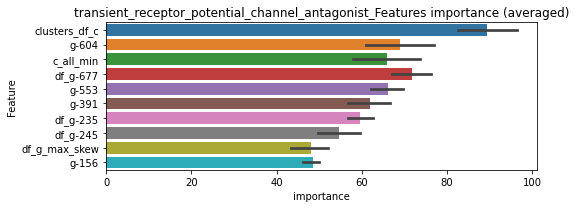

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 transient_receptor_potential_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0136153	valid_1's binary_logloss: 0.0203521
[200]	training's binary_logloss: 0.00160976	valid_1's binary_logloss: 0.00656448
Early stopping, best iteration is:
[288]	training's binary_logloss: 0.000484517	valid_1's binary_logloss: 0.00533673


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 transient_receptor_potential_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0143039	valid_1's binary_logloss: 0.0205257
[200]	training's binary_logloss: 0.00172886	valid_1's binary_logloss: 0.0059314
[300]	training's binary_logloss: 0.000460776	valid_1's binary_logloss: 0.00380116
[400]	training's binary_logloss: 0.000231892	valid_1's binary_logloss: 0.0033442
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.000187431	valid_1's binary_logloss: 0.00323136


transient_receptor_potential_channel_antagonist logloss: 0.004284176790918115
tropomyosin_receptor_kinase_inhibitor, len(trt): 6, len(othr): 3288, target_rate: 0.0002520 → Adj_target_rate: 0.0003851


neg labels: 3289 → selected neg labels: 3288


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162373	valid_1's binary_logloss: 0.0176477
[200]	training's binary_logloss: 0.00136509	valid_1's binary_logloss: 0.00223438
[300]	training's binary_logloss: 0.000364511	valid_1's binary_logloss: 0.00100567
[400]	training's binary_logloss: 0.000220154	valid_1's binary_logloss: 0.000764973
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.000202008	valid_1's binary_logloss: 0.000740684
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164042	valid_1's binary_logloss: 0.0177492
[200]	training's binary_logloss: 0.00136636	valid_1's binary_logloss: 0.00186167
[300]	training's binary_logloss: 0.000361764	valid_1's binary_logloss: 0.000622061
[400]	training's binary_logloss: 0.000220402	valid_1's binary_logloss: 0.000421652


1 / 3 AUC score:1.000
y_Threshold: 0.0005432, Threshold: 0.0010562, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[483]	training's binary_logloss: 0.000198165	valid_1's binary_logloss: 0.000390345


Remove_noisy_labels: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0200904 Vs.target_rate: 0.00025, Num_p_label: 80.0, conf_0:0.00095, conf_1:0.00116
Num_p_label: 80.0, Expected: 1.0, Adj_threshold_1: 0.0010562
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_2: 0.0110562
Num_p_label: 1.0, Expected: 1.0, Adj_threshold_3: 0.0210562
threshold: 0.0210562, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164337	valid_1's binary_logloss: 0.0179155
[200]	training's binary_logloss: 0.0013477	valid_1's binary_logloss: 0.00222934
[300]	training's binary_logloss: 0.000355151	valid_1's binary_logloss: 0.000849071
[400]	training's binary_logloss: 0.000216738	valid_1's binary_logloss: 0.000638427
[500]	training's binary_logloss: 0.000193973	valid_1's binary_logloss: 0.00059876
Early stopping, best iteration is:
[497]	training's binary_logloss: 0.000193974	valid_1's binary_logloss: 0.000598756
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0166966	valid_1's binary_logloss: 0.0177249
[200]	training's binary_logloss: 0.00135027	valid_1's binary_logloss: 0.00192983
[300]	training's binary_logloss: 0.000357175	valid_1's binary_logloss: 0.000672302
[400]	training's binary_logloss: 0.000219932	valid_1's binary_logloss: 0.000499757


2 / 3 AUC score:1.000
y_Threshold: 0.1034991, Threshold: 0.0210562, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000198006	valid_1's binary_logloss: 0.000464905


Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0017579 Vs.target_rate: 0.00025, Num_p_label: 7.0, conf_0:0.01895, conf_1:0.02316
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_1: 0.0210562
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_2: 0.0310562
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_3: 0.0410562
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_4: 0.0510562
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_5: 0.0610562
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_6: 0.0710562
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_7: 0.0810562
threshold: 0.0810562, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164337	valid_1's binary_logloss: 0.0179155
[200]	training's binary_logloss: 0.0013477	valid_1's binary_logloss: 0.00222934
[300]	training's binary_logloss: 0.000355151	valid_1's binary_logloss: 0.000849071
[400]	training's binary_logloss: 0.000216738	valid_1's binary_logloss: 0.000638427
[500]	training's binary_logloss: 0.000193973	valid_1's binary_logloss: 0.00059876
Early stopping, best iteration is:
[497]	training's binary_logloss: 0.000193974	valid_1's binary_logloss: 0.000598756
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0166966	valid_1's binary_logloss: 0.0177249
[200]	training's binary_logloss: 0.00135027	valid_1's binary_logloss: 0.00192983
[300]	training's binary_logloss: 0.000357175	valid_1's binary_logloss: 0.000672302
[400]	training's binary_logloss: 0.000219932	valid_1's binary_logloss: 0.000499757


3 / 3 AUC score:1.000


Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000198006	valid_1's binary_logloss: 0.000464905


y_Threshold: 0.1034991, Threshold: 0.0810562, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0005023 Vs.target_rate: 0.00025, Num_p_label: 2.0, conf_0:0.07295, conf_1:0.08916
threshold: 0.0810562, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 659.0/7795, y_label_rate: 0.0845414


len(train_index) : 3897
len(valid_index) : 3898
================================= fold 1/2 tropomyosin_receptor_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00875361	valid_1's binary_logloss: 0.011793
[200]	training's binary_logloss: 0.000711672	valid_1's binary_logloss: 0.00316235
[300]	training's binary_logloss: 0.000183759	valid_1's binary_logloss: 0.00244222
Early stopping, best iteration is:
[297]	training's binary_logloss: 0.000188415	valid_1's binary_logloss: 0.00243808


len(train_index) : 3898
len(valid_index) : 3897
================================= fold 2/2 tropomyosin_receptor_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00887862	valid_1's binary_logloss: 0.0098383
[200]	training's binary_logloss: 0.000722275	valid_1's binary_logloss: 0.00133104
[300]	training's binary_logloss: 0.000188818	valid_1's binary_logloss: 0.000579765
[400]	training's binary_logloss: 0.000112519	valid_1's binary_logloss: 0.000450917
Early stopping, best iteration is:
[481]	training's binary_logloss: 9.91954e-05	valid_1's binary_logloss: 0.000430523


tropomyosin_receptor_kinase_inhibitor logloss: 0.0014344310693874208
trpv_agonist, len(trt): 25, len(othr): 3285, target_rate: 0.0010498 → Adj_target_rate: 0.0012955


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0251942	valid_1's binary_logloss: 0.0426512
[200]	training's binary_logloss: 0.0031304	valid_1's binary_logloss: 0.0122449
[300]	training's binary_logloss: 0.000901715	valid_1's binary_logloss: 0.00804678
Early stopping, best iteration is:
[369]	training's binary_logloss: 0.000559451	valid_1's binary_logloss: 0.00709265
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0256355	valid_1's binary_logloss: 0.0364287
[200]	training's binary_logloss: 0.00317146	valid_1's binary_logloss: 0.00688708
[300]	training's binary_logloss: 0.00092444	valid_1's binary_logloss: 0.00294934
[400]	training's binary_logloss: 0.000483513	valid_1's binary_logloss: 0.00198467
[500]	training's binary_logloss: 0.000367651	valid_1's binary_logloss: 0.00170908
[600]	training's binary_logloss: 0.000348671	valid_1's binary_logloss: 0.00165628
Early stopping, best iteration is:

1 / 3 AUC score:1.000
y_Threshold: 0.0026274, Threshold: 0.0068457, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00105, Num_p_label: 80.0, conf_0:0.00616, conf_1:0.00753
Num_p_label: 80.0, Expected: 4.2, Adj_threshold_1: 0.0068457
Num_p_label: 49.0, Expected: 4.2, Adj_threshold_2: 0.0168457
Num_p_label: 31.0, Expected: 4.2, Adj_threshold_3: 0.0268457
Num_p_label: 27.0, Expected: 4.2, Adj_threshold_4: 0.0368457
Num_p_label: 19.0, Expected: 4.2, Adj_threshold_5: 0.0468457
Num_p_label: 18.0, Expected: 4.2, Adj_threshold_6: 0.0568457
Num_p_label: 15.0, Expected: 4.2, Adj_threshold_7: 0.0668457
Num_p_label: 14.0, Expected: 4.2, Adj_threshold_8: 0.0768457
Num_p_label: 10.0, Expected: 4.2, Adj_threshold_9: 0.0868457
Num_p_label: 10.0, Expected: 4.2, Adj_threshold_10: 0.0968457
threshold: 0.1068457, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0246663	valid_1's binary_logloss: 0.0407162
[200]	training's binary_logloss: 0.00294508	valid_1's binary_logloss: 0.0101111
[300]	training's binary_logloss: 0.000847086	valid_1's binary_logloss: 0.00604901
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.000817336	valid_1's binary_logloss: 0.00601415
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0245506	valid_1's binary_logloss: 0.0330543
[200]	training's binary_logloss: 0.00297893	valid_1's binary_logloss: 0.00570189
[300]	training's binary_logloss: 0.000851794	valid_1's binary_logloss: 0.00220493
[400]	training's binary_logloss: 0.00044984	valid_1's binary_logloss: 0.00135851
[500]	training's binary_logloss: 0.000356536	valid_1's binary_logloss: 0.00116921
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.000339811	valid_1's binary_logloss: 0.0011349

2 / 3 AUC score:1.000
y_Threshold: 0.0591104, Threshold: 0.1068457, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0115520 Vs.target_rate: 0.00105, Num_p_label: 46.0, conf_0:0.09616, conf_1:0.11753
Num_p_label: 46.0, Expected: 4.2, Adj_threshold_1: 0.1068457
Num_p_label: 45.0, Expected: 4.2, Adj_threshold_2: 0.1168457
Num_p_label: 43.0, Expected: 4.2, Adj_threshold_3: 0.1268457
Num_p_label: 40.0, Expected: 4.2, Adj_threshold_4: 0.1368457
Num_p_label: 39.0, Expected: 4.2, Adj_threshold_5: 0.1468457
Num_p_label: 37.0, Expected: 4.2, Adj_threshold_6: 0.1568457
Num_p_label: 36.0, Expected: 4.2, Adj_threshold_7: 0.1668457
Num_p_label: 35.0, Expected: 4.2, Adj_threshold_8: 0.1768457
Num_p_label: 34.0, Expected: 4.2, Adj_threshold_9: 0.1868457
Num_p_label: 34.0, Expected: 4.2, Adj_threshold_10: 0.1968457
threshold: 0.2068457, positive_p_label: 34.0/3982, p_label_rate: 0.0085384
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0246663	valid_1's binary_logloss: 0.0407162
[200]	training's binary_logloss: 0.00294508	valid_1's binary_logloss: 0.0101111
[300]	training's binary_logloss: 0.000847086	valid_1's binary_logloss: 0.00604901
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.000817336	valid_1's binary_logloss: 0.00601415
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0245506	valid_1's binary_logloss: 0.0330543
[200]	training's binary_logloss: 0.00297893	valid_1's binary_logloss: 0.00570189
[300]	training's binary_logloss: 0.000851794	valid_1's binary_logloss: 0.00220493
[400]	training's binary_logloss: 0.00044984	valid_1's binary_logloss: 0.00135851
[500]	training's binary_logloss: 0.000356536	valid_1's binary_logloss: 0.00116921
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.000339811	valid_1's binary_logloss: 0.0011349

3 / 3 AUC score:1.000
y_Threshold: 0.0591104, Threshold: 0.2068457, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0085384 Vs.target_rate: 0.00105, Num_p_label: 34.0, conf_0:0.18616, conf_1:0.22753
Num_p_label: 34.0, Expected: 4.2, Adj_threshold_1: 0.2068457
Num_p_label: 34.0, Expected: 4.2, Adj_threshold_2: 0.2168457
Num_p_label: 34.0, Expected: 4.2, Adj_threshold_3: 0.2268457
Num_p_label: 33.0, Expected: 4.2, Adj_threshold_4: 0.2368457
Num_p_label: 33.0, Expected: 4.2, Adj_threshold_5: 0.2468457
Num_p_label: 33.0, Expected: 4.2, Adj_threshold_6: 0.2568457
Num_p_label: 33.0, Expected: 4.2, Adj_threshold_7: 0.2668457
Num_p_label: 32.0, Expected: 4.2, Adj_threshold_8: 0.2768457
Num_p_label: 32.0, Expected: 4.2, Adj_threshold_9: 0.2868457
Num_p_label: 31.0, Expected: 4.2, Adj_threshold_10: 0.2968457
threshold: 0.3068457, positive_p_label: 31.0/3982, p_label_rate: 0.0077850
positive_y_label: 688.0/7792, y_label_rate: 0.0882957


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 trpv_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0136173	valid_1's binary_logloss: 0.0245865
[200]	training's binary_logloss: 0.00168324	valid_1's binary_logloss: 0.00947477
[300]	training's binary_logloss: 0.000485632	valid_1's binary_logloss: 0.00711844
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.000357069	valid_1's binary_logloss: 0.00692141


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 trpv_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0138515	valid_1's binary_logloss: 0.0277198
[200]	training's binary_logloss: 0.00173984	valid_1's binary_logloss: 0.0117538
[300]	training's binary_logloss: 0.000504915	valid_1's binary_logloss: 0.00914437
Early stopping, best iteration is:
[353]	training's binary_logloss: 0.000339742	valid_1's binary_logloss: 0.00863533


trpv_agonist logloss: 0.007778366371813217
trpv_antagonist, len(trt): 48, len(othr): 3281, target_rate: 0.0020156 → Adj_target_rate: 0.0022556


neg labels: 3289 → selected neg labels: 3281


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0422585	valid_1's binary_logloss: 0.0909355
[200]	training's binary_logloss: 0.00792308	valid_1's binary_logloss: 0.0528903
[300]	training's binary_logloss: 0.00230926	valid_1's binary_logloss: 0.0445994
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.00144856	valid_1's binary_logloss: 0.0436283
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0469912	valid_1's binary_logloss: 0.0752041
[200]	training's binary_logloss: 0.00901708	valid_1's binary_logloss: 0.0255609
[300]	training's binary_logloss: 0.00259784	valid_1's binary_logloss: 0.013293
[400]	training's binary_logloss: 0.00120046	valid_1's binary_logloss: 0.00980591
[500]	training's binary_logloss: 0.000752604	valid_1's binary_logloss: 0.00855377
[600]	training's binary_logloss: 0.000579962	valid_1's binary_logloss: 0.0080063
Early stopping, best iteration is:
[600]	t

1 / 3 AUC score:0.999
y_Threshold: 0.0057272, Threshold: 0.0090788, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 138 → Positive_corect_labels: 653/3799
p_label_rate: 0.0200904 Vs.target_rate: 0.00202, Num_p_label: 80.0, conf_0:0.00817, conf_1:0.00999
Num_p_label: 80.0, Expected: 8.0, Adj_threshold_1: 0.0090788
Num_p_label: 13.0, Expected: 8.0, Adj_threshold_2: 0.0190788
threshold: 0.0190788, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 653.0/3799, y_label_rate: 0.1718873
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.043842	valid_1's binary_logloss: 0.0759354
[200]	training's binary_logloss: 0.00788479	valid_1's binary_logloss: 0.0341999
[300]	training's binary_logloss: 0.00232703	valid_1's binary_logloss: 0.0261342
[400]	training's binary_logloss: 0.00109049	valid_1's binary_logloss: 0.0228547
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.00112044	valid_1's binary_logloss: 0.0227764
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0448093	valid_1's binary_logloss: 0.0739399
[200]	training's binary_logloss: 0.00828451	valid_1's binary_logloss: 0.0280807
[300]	training's binary_logloss: 0.002401	valid_1's binary_logloss: 0.0182835
[400]	training's binary_logloss: 0.001133	valid_1's binary_logloss: 0.0152414
[500]	training's binary_logloss: 0.000717609	valid_1's binary_logloss: 0.0141002
Early stopping, best iteration is:
[556]	training

2 / 3 AUC score:1.000
y_Threshold: 0.0271878, Threshold: 0.0190788, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 653.0/3799
p_label_rate: 0.0097941 Vs.target_rate: 0.00202, Num_p_label: 39.0, conf_0:0.01717, conf_1:0.02099
Num_p_label: 39.0, Expected: 8.0, Adj_threshold_1: 0.0190788
Num_p_label: 15.0, Expected: 8.0, Adj_threshold_2: 0.0290788
threshold: 0.0290788, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 653.0/3799, y_label_rate: 0.1718873
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.043842	valid_1's binary_logloss: 0.0759354
[200]	training's binary_logloss: 0.00788479	valid_1's binary_logloss: 0.0341999
[300]	training's binary_logloss: 0.00232703	valid_1's binary_logloss: 0.0261342
[400]	training's binary_logloss: 0.00109049	valid_1's binary_logloss: 0.0228547
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.00112044	valid_1's binary_logloss: 0.0227764
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0448093	valid_1's binary_logloss: 0.0739399
[200]	training's binary_logloss: 0.00828451	valid_1's binary_logloss: 0.0280807
[300]	training's binary_logloss: 0.002401	valid_1's binary_logloss: 0.0182835
[400]	training's binary_logloss: 0.001133	valid_1's binary_logloss: 0.0152414
[500]	training's binary_logloss: 0.000717609	valid_1's binary_logloss: 0.0141002
Early stopping, best iteration is:
[556]	training

3 / 3 AUC score:1.000
y_Threshold: 0.0271878, Threshold: 0.0290788, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 653.0/3799
p_label_rate: 0.0037670 Vs.target_rate: 0.00202, Num_p_label: 15.0, conf_0:0.02617, conf_1:0.03199
threshold: 0.0290788, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 668.0/7781, y_label_rate: 0.0858501


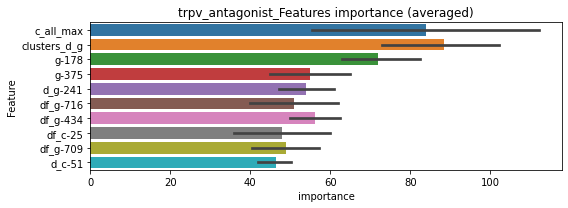

len(train_index) : 3890
len(valid_index) : 3891
================================= fold 1/2 trpv_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0255038	valid_1's binary_logloss: 0.0514126
[200]	training's binary_logloss: 0.00450453	valid_1's binary_logloss: 0.0291362
[300]	training's binary_logloss: 0.00129942	valid_1's binary_logloss: 0.0257021
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.00144785	valid_1's binary_logloss: 0.0256977


len(train_index) : 3891
len(valid_index) : 3890
================================= fold 2/2 trpv_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0265478	valid_1's binary_logloss: 0.0487794
[200]	training's binary_logloss: 0.00534292	valid_1's binary_logloss: 0.0256955
[300]	training's binary_logloss: 0.0013779	valid_1's binary_logloss: 0.0208534
Early stopping, best iteration is:
[377]	training's binary_logloss: 0.000711979	valid_1's binary_logloss: 0.0199072


trpv_antagonist logloss: 0.02280283473803334


neg labels: 3289 → selected neg labels: 3267


tubulin_inhibitor, len(trt): 316, len(othr): 3267, target_rate: 0.0132695 → Adj_target_rate: 0.0111926
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.042278	valid_1's binary_logloss: 0.125732
[200]	training's binary_logloss: 0.00807744	valid_1's binary_logloss: 0.109532
Early stopping, best iteration is:
[191]	training's binary_logloss: 0.00917581	valid_1's binary_logloss: 0.109217
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0443043	valid_1's binary_logloss: 0.102638
[200]	training's binary_logloss: 0.00848037	valid_1's binary_logloss: 0.077882


1 / 3 AUC score:0.985
y_Threshold: 0.0218465, Threshold: 0.1622446, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[249]	training's binary_logloss: 0.00456008	valid_1's binary_logloss: 0.0755698


Remove_noisy_labels: 193 → Positive_corect_labels: 622/3727
p_label_rate: 0.0200904 Vs.target_rate: 0.01327, Num_p_label: 80.0, conf_0:0.14602, conf_1:0.17847
threshold: 0.1622446, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 622.0/3727, y_label_rate: 0.1668903
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0316771	valid_1's binary_logloss: 0.0901903
[200]	training's binary_logloss: 0.00487284	valid_1's binary_logloss: 0.0723951
Early stopping, best iteration is:
[208]	training's binary_logloss: 0.00433097	valid_1's binary_logloss: 0.0716758
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0315978	valid_1's binary_logloss: 0.0838853
[200]	training's binary_logloss: 0.00473929	valid_1's binary_logloss: 0.060831


2 / 3 AUC score:0.991
y_Threshold: 0.0473864, Threshold: 0.1622446, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[205]	training's binary_logloss: 0.00437362	valid_1's binary_logloss: 0.0604769


Remove_noisy_labels: 60 → Positive_corect_labels: 592.0/3667
p_label_rate: 0.0291311 Vs.target_rate: 0.01327, Num_p_label: 116.0, conf_0:0.14602, conf_1:0.17847
threshold: 0.1622446, positive_p_label: 116.0/3982, p_label_rate: 0.0291311
positive_y_label: 592.0/3667, y_label_rate: 0.1614399
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0259518	valid_1's binary_logloss: 0.0658157
[200]	training's binary_logloss: 0.00352815	valid_1's binary_logloss: 0.0449453
Early stopping, best iteration is:
[205]	training's binary_logloss: 0.00324699	valid_1's binary_logloss: 0.0447166
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0288726	valid_1's binary_logloss: 0.0641446
[200]	training's binary_logloss: 0.00371944	valid_1's binary_logloss: 0.0447531


3 / 3 AUC score:0.992
y_Threshold: 0.0493602, Threshold: 0.1622446, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 32 → Positive_corect_labels: 576.0/3635


Early stopping, best iteration is:
[225]	training's binary_logloss: 0.00251165	valid_1's binary_logloss: 0.0442452


p_label_rate: 0.0316424 Vs.target_rate: 0.01327, Num_p_label: 126.0, conf_0:0.14602, conf_1:0.17847
threshold: 0.1622446, positive_p_label: 126.0/3982, p_label_rate: 0.0316424
positive_y_label: 702.0/7617, y_label_rate: 0.0921623


len(train_index) : 3808
len(valid_index) : 3809
================================= fold 1/2 tubulin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160804	valid_1's binary_logloss: 0.0403865
[200]	training's binary_logloss: 0.0022026	valid_1's binary_logloss: 0.0268506
Early stopping, best iteration is:
[245]	training's binary_logloss: 0.00114934	valid_1's binary_logloss: 0.0255663


len(train_index) : 3809
len(valid_index) : 3808
================================= fold 2/2 tubulin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158475	valid_1's binary_logloss: 0.0397132
[200]	training's binary_logloss: 0.00225142	valid_1's binary_logloss: 0.0240576
[300]	training's binary_logloss: 0.000614125	valid_1's binary_logloss: 0.0213154
Early stopping, best iteration is:
[356]	training's binary_logloss: 0.000394446	valid_1's binary_logloss: 0.020313


tubulin_inhibitor logloss: 0.022939978067362487
tyrosine_kinase_inhibitor, len(trt): 73, len(othr): 3276, target_rate: 0.0030654 → Adj_target_rate: 0.0032212


neg labels: 3289 → selected neg labels: 3276


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0527977	valid_1's binary_logloss: 0.105968
[200]	training's binary_logloss: 0.010804	valid_1's binary_logloss: 0.0543459
[300]	training's binary_logloss: 0.00333394	valid_1's binary_logloss: 0.043037
Early stopping, best iteration is:
[351]	training's binary_logloss: 0.0021596	valid_1's binary_logloss: 0.039953
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0499186	valid_1's binary_logloss: 0.0982624
[200]	training's binary_logloss: 0.0106728	valid_1's binary_logloss: 0.05412
[300]	training's binary_logloss: 0.00325175	valid_1's binary_logloss: 0.041217
[400]	training's binary_logloss: 0.00151543	valid_1's binary_logloss: 0.0369791
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00151543	valid_1's binary_logloss: 0.0369791


1 / 3 AUC score:0.998
y_Threshold: 0.0150408, Threshold: 0.0302085, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 146 → Positive_corect_labels: 648/3785
p_label_rate: 0.0200904 Vs.target_rate: 0.00307, Num_p_label: 80.0, conf_0:0.02719, conf_1:0.03323
Num_p_label: 80.0, Expected: 12.2, Adj_threshold_1: 0.0302085
Num_p_label: 49.0, Expected: 12.2, Adj_threshold_2: 0.0402085
Num_p_label: 33.0, Expected: 12.2, Adj_threshold_3: 0.0502085
Num_p_label: 17.0, Expected: 12.2, Adj_threshold_4: 0.0602085
threshold: 0.0602085, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 648.0/3785, y_label_rate: 0.1712021
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0503941	valid_1's binary_logloss: 0.0962918
[200]	training's binary_logloss: 0.0105194	valid_1's binary_logloss: 0.045259
[300]	training's binary_logloss: 0.00311533	valid_1's binary_logloss: 0.0307071
[400]	training's binary_logloss: 0.001461	valid_1's binary_logloss: 0.0265202
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00150502	valid_1's binary_logloss: 0.0264097
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0487353	valid_1's binary_logloss: 0.101212
[200]	training's binary_logloss: 0.00963465	valid_1's binary_logloss: 0.0518673
[300]	training's binary_logloss: 0.00288374	valid_1's binary_logloss: 0.0387054
Early stopping, best iteration is:
[373]	training's binary_logloss: 0.0016297	valid_1's binary_logloss: 0.0339153


2 / 3 AUC score:1.000
y_Threshold: 0.0637637, Threshold: 0.0602085, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 644.0/3777
p_label_rate: 0.0158212 Vs.target_rate: 0.00307, Num_p_label: 63.0, conf_0:0.05419, conf_1:0.06623
Num_p_label: 63.0, Expected: 12.2, Adj_threshold_1: 0.0602085
Num_p_label: 52.0, Expected: 12.2, Adj_threshold_2: 0.0702085
Num_p_label: 44.0, Expected: 12.2, Adj_threshold_3: 0.0802085
Num_p_label: 41.0, Expected: 12.2, Adj_threshold_4: 0.0902085
Num_p_label: 37.0, Expected: 12.2, Adj_threshold_5: 0.1002085
Num_p_label: 36.0, Expected: 12.2, Adj_threshold_6: 0.1102085
Num_p_label: 30.0, Expected: 12.2, Adj_threshold_7: 0.1202085
Num_p_label: 29.0, Expected: 12.2, Adj_threshold_8: 0.1302085
Num_p_label: 26.0, Expected: 12.2, Adj_threshold_9: 0.1402085
Num_p_label: 25.0, Expected: 12.2, Adj_threshold_10: 0.1502085
threshold: 0.1602085, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 644.0/3777, y_label_rate: 0.170505

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0461437	valid_1's binary_logloss: 0.104248
[200]	training's binary_logloss: 0.00934504	valid_1's binary_logloss: 0.0549327
[300]	training's binary_logloss: 0.00280281	valid_1's binary_logloss: 0.0428373
[400]	training's binary_logloss: 0.00133856	valid_1's binary_logloss: 0.0397502
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00110983	valid_1's binary_logloss: 0.039008
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0490274	valid_1's binary_logloss: 0.0940518
[200]	training's binary_logloss: 0.0101307	valid_1's binary_logloss: 0.0451405
[300]	training's binary_logloss: 0.00303441	valid_1's binary_logloss: 0.0315752
[400]	training's binary_logloss: 0.00144134	valid_1's binary_logloss: 0.0263181
[500]	training's binary_logloss: 0.000906409	valid_1's binary_logloss: 0.0242467
Early stopping, best iteration is:
[583]	traini

3 / 3 AUC score:0.999
y_Threshold: 0.0400096, Threshold: 0.1602085, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 20 → Positive_corect_labels: 634.0/3757
p_label_rate: 0.0025113 Vs.target_rate: 0.00307, Num_p_label: 10.0, conf_0:0.14419, conf_1:0.17623
threshold: 0.1602085, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 644.0/7739, y_label_rate: 0.0832149


len(train_index) : 3869
len(valid_index) : 3870
================================= fold 1/2 tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0272306	valid_1's binary_logloss: 0.0608574
[200]	training's binary_logloss: 0.00560069	valid_1's binary_logloss: 0.0344404
[300]	training's binary_logloss: 0.00173838	valid_1's binary_logloss: 0.0281888
[400]	training's binary_logloss: 0.000831201	valid_1's binary_logloss: 0.0254366
Early stopping, best iteration is:
[446]	training's binary_logloss: 0.000627862	valid_1's binary_logloss: 0.0244053


len(train_index) : 3870
len(valid_index) : 3869
================================= fold 2/2 tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0256229	valid_1's binary_logloss: 0.068687
[200]	training's binary_logloss: 0.0049484	valid_1's binary_logloss: 0.0411028
[300]	training's binary_logloss: 0.00146238	valid_1's binary_logloss: 0.0327925
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.00151996	valid_1's binary_logloss: 0.0326392


tyrosine_kinase_inhibitor logloss: 0.028521696526037442
ubiquitin_specific_protease_inhibitor, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942


neg labels: 3289 → selected neg labels: 3287


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0180249	valid_1's binary_logloss: 0.0204966
[200]	training's binary_logloss: 0.00178456	valid_1's binary_logloss: 0.00268185
[300]	training's binary_logloss: 0.000508798	valid_1's binary_logloss: 0.000982805
[400]	training's binary_logloss: 0.000296618	valid_1's binary_logloss: 0.000635386
[500]	training's binary_logloss: 0.000259637	valid_1's binary_logloss: 0.000577898
Early stopping, best iteration is:
[513]	training's binary_logloss: 0.000258887	valid_1's binary_logloss: 0.000576637
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0180317	valid_1's binary_logloss: 0.0210018
[200]	training's binary_logloss: 0.00176141	valid_1's binary_logloss: 0.00289758
[300]	training's binary_logloss: 0.000500716	valid_1's binary_logloss: 0.00113607
[400]	training's binary_logloss: 0.000289611	valid_1's binary_logloss: 0.000764947
[500]	training's binary_lo

1 / 3 AUC score:1.000
y_Threshold: 0.0009062, Threshold: 0.0015032, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00050, Num_p_label: 80.0, conf_0:0.00135, conf_1:0.00165
Num_p_label: 80.0, Expected: 2.0, Adj_threshold_1: 0.0015032
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_2: 0.0115032
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_3: 0.0215032
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_4: 0.0315032
threshold: 0.0315032, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0180124	valid_1's binary_logloss: 0.020884
[200]	training's binary_logloss: 0.00167702	valid_1's binary_logloss: 0.0029896
[300]	training's binary_logloss: 0.000470465	valid_1's binary_logloss: 0.00139851
[400]	training's binary_logloss: 0.000277063	valid_1's binary_logloss: 0.00106886
[500]	training's binary_logloss: 0.000242701	valid_1's binary_logloss: 0.000997505
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.000240826	valid_1's binary_logloss: 0.000994423
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0183118	valid_1's binary_logloss: 0.0203511
[200]	training's binary_logloss: 0.00183815	valid_1's binary_logloss: 0.0023673
[300]	training's binary_logloss: 0.000546323	valid_1's binary_logloss: 0.000748036
[400]	training's binary_logloss: 0.000280569	valid_1's binary_logloss: 0.000430114
[500]	training's binary_loglos

2 / 3 AUC score:1.000
y_Threshold: 0.2231824, Threshold: 0.0315032, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0110497 Vs.target_rate: 0.00050, Num_p_label: 44.0, conf_0:0.02835, conf_1:0.03465
Num_p_label: 44.0, Expected: 2.0, Adj_threshold_1: 0.0315032
Num_p_label: 39.0, Expected: 2.0, Adj_threshold_2: 0.0415032
Num_p_label: 35.0, Expected: 2.0, Adj_threshold_3: 0.0515032
Num_p_label: 30.0, Expected: 2.0, Adj_threshold_4: 0.0615032
Num_p_label: 30.0, Expected: 2.0, Adj_threshold_5: 0.0715032
Num_p_label: 27.0, Expected: 2.0, Adj_threshold_6: 0.0815032
Num_p_label: 27.0, Expected: 2.0, Adj_threshold_7: 0.0915032
Num_p_label: 25.0, Expected: 2.0, Adj_threshold_8: 0.1015032
Num_p_label: 25.0, Expected: 2.0, Adj_threshold_9: 0.1115032
Num_p_label: 25.0, Expected: 2.0, Adj_threshold_10: 0.1215032
threshold: 0.1315032, positive_p_label: 25.0/3982, p_label_rate: 0.0062783
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0180124	valid_1's binary_logloss: 0.020884
[200]	training's binary_logloss: 0.00167702	valid_1's binary_logloss: 0.0029896
[300]	training's binary_logloss: 0.000470465	valid_1's binary_logloss: 0.00139851
[400]	training's binary_logloss: 0.000277063	valid_1's binary_logloss: 0.00106886
[500]	training's binary_logloss: 0.000242701	valid_1's binary_logloss: 0.000997505
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.000240826	valid_1's binary_logloss: 0.000994423
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0183118	valid_1's binary_logloss: 0.0203511
[200]	training's binary_logloss: 0.00183815	valid_1's binary_logloss: 0.0023673
[300]	training's binary_logloss: 0.000546323	valid_1's binary_logloss: 0.000748036
[400]	training's binary_logloss: 0.000280569	valid_1's binary_logloss: 0.000430114
[500]	training's binary_loglos

3 / 3 AUC score:1.000
y_Threshold: 0.2231824, Threshold: 0.1315032, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0062783 Vs.target_rate: 0.00050, Num_p_label: 25.0, conf_0:0.11835, conf_1:0.14465
Num_p_label: 25.0, Expected: 2.0, Adj_threshold_1: 0.1315032
Num_p_label: 23.0, Expected: 2.0, Adj_threshold_2: 0.1415032
Num_p_label: 23.0, Expected: 2.0, Adj_threshold_3: 0.1515032
Num_p_label: 22.0, Expected: 2.0, Adj_threshold_4: 0.1615032
Num_p_label: 20.0, Expected: 2.0, Adj_threshold_5: 0.1715032
Num_p_label: 18.0, Expected: 2.0, Adj_threshold_6: 0.1815032
Num_p_label: 17.0, Expected: 2.0, Adj_threshold_7: 0.1915032
Num_p_label: 17.0, Expected: 2.0, Adj_threshold_8: 0.2015032
Num_p_label: 16.0, Expected: 2.0, Adj_threshold_9: 0.2115032
Num_p_label: 15.0, Expected: 2.0, Adj_threshold_10: 0.2215032
threshold: 0.2315032, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 670.0/7794, y_label_rate: 0.0859636


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 ubiquitin_specific_protease_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00991015	valid_1's binary_logloss: 0.0142965
[200]	training's binary_logloss: 0.000957644	valid_1's binary_logloss: 0.00459411
Early stopping, best iteration is:
[281]	training's binary_logloss: 0.000316692	valid_1's binary_logloss: 0.00391743


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 ubiquitin_specific_protease_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00997558	valid_1's binary_logloss: 0.011819
[200]	training's binary_logloss: 0.000996614	valid_1's binary_logloss: 0.00256587
[300]	training's binary_logloss: 0.000283993	valid_1's binary_logloss: 0.0016254
[400]	training's binary_logloss: 0.000161897	valid_1's binary_logloss: 0.00138483
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.000149823	valid_1's binary_logloss: 0.00136422


ubiquitin_specific_protease_inhibitor logloss: 0.002640822736624357
vegfr_inhibitor, len(trt): 170, len(othr): 3258, target_rate: 0.0071387 → Adj_target_rate: 0.0066081


neg labels: 3289 → selected neg labels: 3258


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.059378	valid_1's binary_logloss: 0.15788
[200]	training's binary_logloss: 0.0139873	valid_1's binary_logloss: 0.116406
[300]	training's binary_logloss: 0.00442416	valid_1's binary_logloss: 0.106957
Early stopping, best iteration is:
[324]	training's binary_logloss: 0.00357923	valid_1's binary_logloss: 0.105931
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0629585	valid_1's binary_logloss: 0.141874
[200]	training's binary_logloss: 0.0165599	valid_1's binary_logloss: 0.0905865
[300]	training's binary_logloss: 0.00538985	valid_1's binary_logloss: 0.0745366
[400]	training's binary_logloss: 0.00252082	valid_1's binary_logloss: 0.0682522
Early stopping, best iteration is:
[472]	training's binary_logloss: 0.00172268	valid_1's binary_logloss: 0.0664525


1 / 3 AUC score:0.992
y_Threshold: 0.0347938, Threshold: 0.1522468, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 169 → Positive_corect_labels: 632/3740
p_label_rate: 0.0200904 Vs.target_rate: 0.00714, Num_p_label: 80.0, conf_0:0.13702, conf_1:0.16747
threshold: 0.1522468, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 632.0/3740, y_label_rate: 0.1689840
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0544958	valid_1's binary_logloss: 0.129223
[200]	training's binary_logloss: 0.0117293	valid_1's binary_logloss: 0.0803383
[300]	training's binary_logloss: 0.00359566	valid_1's binary_logloss: 0.0645117
[400]	training's binary_logloss: 0.00169596	valid_1's binary_logloss: 0.0602379
Early stopping, best iteration is:
[439]	training's binary_logloss: 0.00136744	valid_1's binary_logloss: 0.0595809
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0547206	valid_1's binary_logloss: 0.120879
[200]	training's binary_logloss: 0.0120341	valid_1's binary_logloss: 0.074349
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.0051225	valid_1's binary_logloss: 0.064633


2 / 3 AUC score:0.997
y_Threshold: 0.1366685, Threshold: 0.1522468, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 56 → Positive_corect_labels: 604.0/3684
p_label_rate: 0.0494726 Vs.target_rate: 0.00714, Num_p_label: 197.0, conf_0:0.13702, conf_1:0.16747
Num_p_label: 197.0, Expected: 28.4, Adj_threshold_1: 0.1522468
Num_p_label: 191.0, Expected: 28.4, Adj_threshold_2: 0.1622468
Num_p_label: 189.0, Expected: 28.4, Adj_threshold_3: 0.1722468
Num_p_label: 185.0, Expected: 28.4, Adj_threshold_4: 0.1822468
Num_p_label: 183.0, Expected: 28.4, Adj_threshold_5: 0.1922468
Num_p_label: 180.0, Expected: 28.4, Adj_threshold_6: 0.2022468
Num_p_label: 176.0, Expected: 28.4, Adj_threshold_7: 0.2122468
Num_p_label: 176.0, Expected: 28.4, Adj_threshold_8: 0.2222468
Num_p_label: 175.0, Expected: 28.4, Adj_threshold_9: 0.2322468
Num_p_label: 169.0, Expected: 28.4, Adj_threshold_10: 0.2422468
threshold: 0.2522468, positive_p_label: 167.0/3982, p_label_rate: 0.0419387
positive_y_label: 604.0/3684, y_label_r

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0487796	valid_1's binary_logloss: 0.108965
[200]	training's binary_logloss: 0.0102307	valid_1's binary_logloss: 0.0641124
[300]	training's binary_logloss: 0.00313051	valid_1's binary_logloss: 0.050961
[400]	training's binary_logloss: 0.00148238	valid_1's binary_logloss: 0.0482194
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.00154954	valid_1's binary_logloss: 0.0481175
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0492486	valid_1's binary_logloss: 0.121453
[200]	training's binary_logloss: 0.0101648	valid_1's binary_logloss: 0.0842366
Early stopping, best iteration is:
[269]	training's binary_logloss: 0.00421264	valid_1's binary_logloss: 0.0797362


3 / 3 AUC score:0.995
y_Threshold: 0.1136299, Threshold: 0.2522468, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 66 → Positive_corect_labels: 571.0/3618
p_label_rate: 0.0457057 Vs.target_rate: 0.00714, Num_p_label: 182.0, conf_0:0.22702, conf_1:0.27747
Num_p_label: 182.0, Expected: 28.4, Adj_threshold_1: 0.2522468
Num_p_label: 179.0, Expected: 28.4, Adj_threshold_2: 0.2622468
Num_p_label: 177.0, Expected: 28.4, Adj_threshold_3: 0.2722468
Num_p_label: 175.0, Expected: 28.4, Adj_threshold_4: 0.2822468
Num_p_label: 172.0, Expected: 28.4, Adj_threshold_5: 0.2922468
Num_p_label: 170.0, Expected: 28.4, Adj_threshold_6: 0.3022468
Num_p_label: 168.0, Expected: 28.4, Adj_threshold_7: 0.3122468
Num_p_label: 164.0, Expected: 28.4, Adj_threshold_8: 0.3222468
Num_p_label: 160.0, Expected: 28.4, Adj_threshold_9: 0.3322468
Num_p_label: 158.0, Expected: 28.4, Adj_threshold_10: 0.3422468
threshold: 0.3522468, positive_p_label: 152.0/3982, p_label_rate: 0.0381718
positive_y_label: 723.0/7600, y_label_r

len(train_index) : 3800
len(valid_index) : 3800
================================= fold 1/2 vegfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0293518	valid_1's binary_logloss: 0.078018
[200]	training's binary_logloss: 0.00574592	valid_1's binary_logloss: 0.0553969
[300]	training's binary_logloss: 0.00174973	valid_1's binary_logloss: 0.0500647
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.00183177	valid_1's binary_logloss: 0.049897


len(train_index) : 3800
len(valid_index) : 3800
================================= fold 2/2 vegfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0293568	valid_1's binary_logloss: 0.0704184
[200]	training's binary_logloss: 0.00567283	valid_1's binary_logloss: 0.0448719
[300]	training's binary_logloss: 0.00172875	valid_1's binary_logloss: 0.0384839
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.00166006	valid_1's binary_logloss: 0.0383053


vegfr_inhibitor logloss: 0.04410117091221104
vitamin_b, len(trt): 26, len(othr): 3285, target_rate: 0.0010918 → Adj_target_rate: 0.0013394


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0313574	valid_1's binary_logloss: 0.04683
[200]	training's binary_logloss: 0.00440272	valid_1's binary_logloss: 0.0116494
[300]	training's binary_logloss: 0.00122022	valid_1's binary_logloss: 0.0061031
[400]	training's binary_logloss: 0.000615581	valid_1's binary_logloss: 0.00440783
[500]	training's binary_logloss: 0.000434561	valid_1's binary_logloss: 0.00390881
Early stopping, best iteration is:
[534]	training's binary_logloss: 0.000415481	valid_1's binary_logloss: 0.00386568
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0327811	valid_1's binary_logloss: 0.0439246
[200]	training's binary_logloss: 0.00456964	valid_1's binary_logloss: 0.0103964
[300]	training's binary_logloss: 0.00128575	valid_1's binary_logloss: 0.00498992
[400]	training's binary_logloss: 0.000640363	valid_1's binary_logloss: 0.00349898
[500]	training's binary_logloss: 0.000

1 / 3 AUC score:1.000
y_Threshold: 0.0027170, Threshold: 0.0040620, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00109, Num_p_label: 80.0, conf_0:0.00366, conf_1:0.00447
Num_p_label: 80.0, Expected: 4.3, Adj_threshold_1: 0.0040620
Num_p_label: 13.0, Expected: 4.3, Adj_threshold_2: 0.0140620
Num_p_label: 4.0, Expected: 4.3, Adj_threshold_3: 0.0240620
threshold: 0.0240620, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0304963	valid_1's binary_logloss: 0.0456338
[200]	training's binary_logloss: 0.00422614	valid_1's binary_logloss: 0.0113039
[300]	training's binary_logloss: 0.00118085	valid_1's binary_logloss: 0.00596452
[400]	training's binary_logloss: 0.00060305	valid_1's binary_logloss: 0.00446072
[500]	training's binary_logloss: 0.000430831	valid_1's binary_logloss: 0.00400793
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.000424649	valid_1's binary_logloss: 0.00399886
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0320371	valid_1's binary_logloss: 0.0439978
[200]	training's binary_logloss: 0.00439852	valid_1's binary_logloss: 0.0103452
[300]	training's binary_logloss: 0.00123191	valid_1's binary_logloss: 0.00524109
[400]	training's binary_logloss: 0.00062089	valid_1's binary_logloss: 0.00388746
[500]	training's binary_logloss: 0.00

2 / 3 AUC score:1.000
y_Threshold: 0.0237355, Threshold: 0.0240620, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0035158 Vs.target_rate: 0.00109, Num_p_label: 14.0, conf_0:0.02166, conf_1:0.02647
Num_p_label: 14.0, Expected: 4.3, Adj_threshold_1: 0.0240620
Num_p_label: 8.0, Expected: 4.3, Adj_threshold_2: 0.0340620
threshold: 0.0340620, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0304963	valid_1's binary_logloss: 0.0456338
[200]	training's binary_logloss: 0.00422614	valid_1's binary_logloss: 0.0113039
[300]	training's binary_logloss: 0.00118085	valid_1's binary_logloss: 0.00596452
[400]	training's binary_logloss: 0.00060305	valid_1's binary_logloss: 0.00446072
[500]	training's binary_logloss: 0.000430831	valid_1's binary_logloss: 0.00400793
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.000424649	valid_1's binary_logloss: 0.00399886
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0320371	valid_1's binary_logloss: 0.0439978
[200]	training's binary_logloss: 0.00439852	valid_1's binary_logloss: 0.0103452
[300]	training's binary_logloss: 0.00123191	valid_1's binary_logloss: 0.00524109
[400]	training's binary_logloss: 0.00062089	valid_1's binary_logloss: 0.00388746
[500]	training's binary_logloss: 0.00

3 / 3 AUC score:1.000
y_Threshold: 0.0237355, Threshold: 0.0340620, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0020090 Vs.target_rate: 0.00109, Num_p_label: 8.0, conf_0:0.03066, conf_1:0.03747
threshold: 0.0340620, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 665.0/7792, y_label_rate: 0.0853439


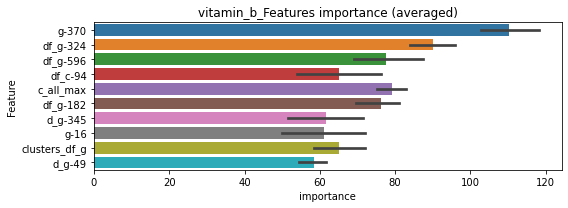

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 vitamin_b=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165839	valid_1's binary_logloss: 0.0318161
[200]	training's binary_logloss: 0.00228359	valid_1's binary_logloss: 0.0133646
[300]	training's binary_logloss: 0.000628445	valid_1's binary_logloss: 0.0101923
[400]	training's binary_logloss: 0.000312922	valid_1's binary_logloss: 0.00991082
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.000327045	valid_1's binary_logloss: 0.00988138


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 vitamin_b=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0180725	valid_1's binary_logloss: 0.0257027
[200]	training's binary_logloss: 0.00258895	valid_1's binary_logloss: 0.00676566
[300]	training's binary_logloss: 0.000720287	valid_1's binary_logloss: 0.00422644
[400]	training's binary_logloss: 0.000336942	valid_1's binary_logloss: 0.00363912
Early stopping, best iteration is:
[457]	training's binary_logloss: 0.000261093	valid_1's binary_logloss: 0.00350971


vitamin_b logloss: 0.006695547144821096
vitamin_d_receptor_agonist, len(trt): 39, len(othr): 3281, target_rate: 0.0016377 → Adj_target_rate: 0.0018906


neg labels: 3289 → selected neg labels: 3281


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0272436	valid_1's binary_logloss: 0.039183
[200]	training's binary_logloss: 0.00361159	valid_1's binary_logloss: 0.00819698
[300]	training's binary_logloss: 0.00102928	valid_1's binary_logloss: 0.00335518
[400]	training's binary_logloss: 0.000518429	valid_1's binary_logloss: 0.00212663
[500]	training's binary_logloss: 0.000369736	valid_1's binary_logloss: 0.00173083
Early stopping, best iteration is:
[584]	training's binary_logloss: 0.000340458	valid_1's binary_logloss: 0.00165693
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0277069	valid_1's binary_logloss: 0.042778
[200]	training's binary_logloss: 0.00365363	valid_1's binary_logloss: 0.0084778
[300]	training's binary_logloss: 0.00104797	valid_1's binary_logloss: 0.00337008
[400]	training's binary_logloss: 0.000528637	valid_1's binary_logloss: 0.00205202
[500]	training's binary_logloss: 0.0

1 / 3 AUC score:1.000
y_Threshold: 0.0021423, Threshold: 0.0055060, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3805
p_label_rate: 0.0200904 Vs.target_rate: 0.00164, Num_p_label: 80.0, conf_0:0.00496, conf_1:0.00606
Num_p_label: 80.0, Expected: 6.5, Adj_threshold_1: 0.0055060
Num_p_label: 29.0, Expected: 6.5, Adj_threshold_2: 0.0155060
Num_p_label: 17.0, Expected: 6.5, Adj_threshold_3: 0.0255060
Num_p_label: 16.0, Expected: 6.5, Adj_threshold_4: 0.0355060
Num_p_label: 13.0, Expected: 6.5, Adj_threshold_5: 0.0455060
threshold: 0.0455060, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 656.0/3805, y_label_rate: 0.1724047
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0274813	valid_1's binary_logloss: 0.0399248
[200]	training's binary_logloss: 0.00359599	valid_1's binary_logloss: 0.00823144
[300]	training's binary_logloss: 0.00101695	valid_1's binary_logloss: 0.00328006
[400]	training's binary_logloss: 0.000515451	valid_1's binary_logloss: 0.00213651
[500]	training's binary_logloss: 0.00037032	valid_1's binary_logloss: 0.00175319
Early stopping, best iteration is:
[539]	training's binary_logloss: 0.000352901	valid_1's binary_logloss: 0.00170552
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0278402	valid_1's binary_logloss: 0.0422267
[200]	training's binary_logloss: 0.00358545	valid_1's binary_logloss: 0.00864188
[300]	training's binary_logloss: 0.00101824	valid_1's binary_logloss: 0.00343127
[400]	training's binary_logloss: 0.00051497	valid_1's binary_logloss: 0.00207073
[500]	training's binary_logloss: 0.

2 / 3 AUC score:1.000
y_Threshold: 0.1081107, Threshold: 0.0455060, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3805
p_label_rate: 0.0047715 Vs.target_rate: 0.00164, Num_p_label: 19.0, conf_0:0.04096, conf_1:0.05006
threshold: 0.0455060, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 656.0/3805, y_label_rate: 0.1724047
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0274813	valid_1's binary_logloss: 0.0399248
[200]	training's binary_logloss: 0.00359599	valid_1's binary_logloss: 0.00823144
[300]	training's binary_logloss: 0.00101695	valid_1's binary_logloss: 0.00328006
[400]	training's binary_logloss: 0.000515451	valid_1's binary_logloss: 0.00213651
[500]	training's binary_logloss: 0.00037032	valid_1's binary_logloss: 0.00175319
Early stopping, best iteration is:
[539]	training's binary_logloss: 0.000352901	valid_1's binary_logloss: 0.00170552
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0278402	valid_1's binary_logloss: 0.0422267
[200]	training's binary_logloss: 0.00358545	valid_1's binary_logloss: 0.00864188
[300]	training's binary_logloss: 0.00101824	valid_1's binary_logloss: 0.00343127
[400]	training's binary_logloss: 0.00051497	valid_1's binary_logloss: 0.00207073
[500]	training's binary_logloss: 0.

3 / 3 AUC score:1.000
y_Threshold: 0.1081107, Threshold: 0.0455060, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3805
p_label_rate: 0.0047715 Vs.target_rate: 0.00164, Num_p_label: 19.0, conf_0:0.04096, conf_1:0.05006
threshold: 0.0455060, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 675.0/7787, y_label_rate: 0.0866829


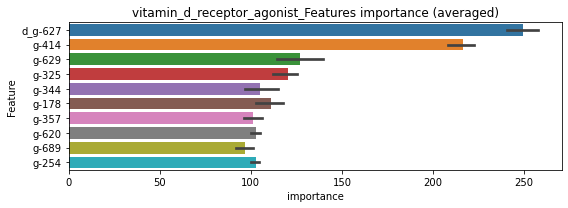

len(train_index) : 3893
len(valid_index) : 3894
================================= fold 1/2 vitamin_d_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0151934	valid_1's binary_logloss: 0.0281901
[200]	training's binary_logloss: 0.00199103	valid_1's binary_logloss: 0.0121465
[300]	training's binary_logloss: 0.00055856	valid_1's binary_logloss: 0.0100284
Early stopping, best iteration is:
[364]	training's binary_logloss: 0.000340795	valid_1's binary_logloss: 0.00955685


len(train_index) : 3894
len(valid_index) : 3893
================================= fold 2/2 vitamin_d_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0150436	valid_1's binary_logloss: 0.0267839
[200]	training's binary_logloss: 0.00195588	valid_1's binary_logloss: 0.00971234
[300]	training's binary_logloss: 0.000554325	valid_1's binary_logloss: 0.0072413
[400]	training's binary_logloss: 0.000280982	valid_1's binary_logloss: 0.00662988
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000235438	valid_1's binary_logloss: 0.00651775


vitamin_d_receptor_agonist logloss: 0.008037494040000072
wnt_inhibitor, len(trt): 30, len(othr): 3284, target_rate: 0.0012598 → Adj_target_rate: 0.0015127


neg labels: 3289 → selected neg labels: 3284


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0351895	valid_1's binary_logloss: 0.0559464
[200]	training's binary_logloss: 0.00516503	valid_1's binary_logloss: 0.0157116
[300]	training's binary_logloss: 0.00141368	valid_1's binary_logloss: 0.00777063
[400]	training's binary_logloss: 0.000694451	valid_1's binary_logloss: 0.00580774
[500]	training's binary_logloss: 0.000473836	valid_1's binary_logloss: 0.0050405
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.000448087	valid_1's binary_logloss: 0.00500581
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0347539	valid_1's binary_logloss: 0.0574276
[200]	training's binary_logloss: 0.0052114	valid_1's binary_logloss: 0.0189759
[300]	training's binary_logloss: 0.00146525	valid_1's binary_logloss: 0.011316
[400]	training's binary_logloss: 0.000707438	valid_1's binary_logloss: 0.00935675
[500]	training's binary_logloss: 0.0004

1 / 3 AUC score:1.000
y_Threshold: 0.0024246, Threshold: 0.0035284, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00126, Num_p_label: 80.0, conf_0:0.00318, conf_1:0.00388
Num_p_label: 80.0, Expected: 5.0, Adj_threshold_1: 0.0035284
Num_p_label: 6.0, Expected: 5.0, Adj_threshold_2: 0.0135284
threshold: 0.0135284, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0358334	valid_1's binary_logloss: 0.0569825
[200]	training's binary_logloss: 0.00513738	valid_1's binary_logloss: 0.01588
[300]	training's binary_logloss: 0.00141814	valid_1's binary_logloss: 0.00752311
[400]	training's binary_logloss: 0.000695552	valid_1's binary_logloss: 0.00542126
[500]	training's binary_logloss: 0.00047384	valid_1's binary_logloss: 0.00447261
Early stopping, best iteration is:
[539]	training's binary_logloss: 0.000444174	valid_1's binary_logloss: 0.00437554
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0348732	valid_1's binary_logloss: 0.0565888
[200]	training's binary_logloss: 0.00514688	valid_1's binary_logloss: 0.0178221
[300]	training's binary_logloss: 0.00143534	valid_1's binary_logloss: 0.0103818
[400]	training's binary_logloss: 0.000705352	valid_1's binary_logloss: 0.00837859
Early stopping, best iteration is:
[398

2 / 3 AUC score:1.000
y_Threshold: 0.0205700, Threshold: 0.0135284, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0082873 Vs.target_rate: 0.00126, Num_p_label: 33.0, conf_0:0.01218, conf_1:0.01488
Num_p_label: 33.0, Expected: 5.0, Adj_threshold_1: 0.0135284
Num_p_label: 9.0, Expected: 5.0, Adj_threshold_2: 0.0235284
threshold: 0.0235284, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0358334	valid_1's binary_logloss: 0.0569825
[200]	training's binary_logloss: 0.00513738	valid_1's binary_logloss: 0.01588
[300]	training's binary_logloss: 0.00141814	valid_1's binary_logloss: 0.00752311
[400]	training's binary_logloss: 0.000695552	valid_1's binary_logloss: 0.00542126
[500]	training's binary_logloss: 0.00047384	valid_1's binary_logloss: 0.00447261
Early stopping, best iteration is:
[539]	training's binary_logloss: 0.000444174	valid_1's binary_logloss: 0.00437554
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0348732	valid_1's binary_logloss: 0.0565888
[200]	training's binary_logloss: 0.00514688	valid_1's binary_logloss: 0.0178221
[300]	training's binary_logloss: 0.00143534	valid_1's binary_logloss: 0.0103818
[400]	training's binary_logloss: 0.000705352	valid_1's binary_logloss: 0.00837859
Early stopping, best iteration is:
[398

3 / 3 AUC score:1.000
y_Threshold: 0.0205700, Threshold: 0.0235284, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0022602 Vs.target_rate: 0.00126, Num_p_label: 9.0, conf_0:0.02118, conf_1:0.02588
threshold: 0.0235284, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 665.0/7790, y_label_rate: 0.0853659


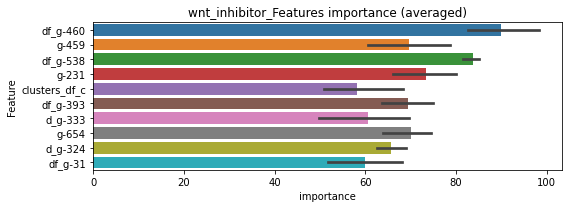

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 wnt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0203017	valid_1's binary_logloss: 0.0393675
[200]	training's binary_logloss: 0.00296513	valid_1's binary_logloss: 0.0182774
[300]	training's binary_logloss: 0.000779458	valid_1's binary_logloss: 0.014845
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.000527155	valid_1's binary_logloss: 0.0145038


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 wnt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0209016	valid_1's binary_logloss: 0.0312962
[200]	training's binary_logloss: 0.00310673	valid_1's binary_logloss: 0.00847682
[300]	training's binary_logloss: 0.000842556	valid_1's binary_logloss: 0.00500186
[400]	training's binary_logloss: 0.000399096	valid_1's binary_logloss: 0.00449581
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.000421349	valid_1's binary_logloss: 0.00449037


wnt_inhibitor logloss: 0.00949708635987976


In [47]:
categorical_cols = []
scores = []
models = []
feature_importance_df = pd.DataFrame()
importance_cols_df = pd.DataFrame()

for target_col in tqdm(train_targets_scored.columns[1:]):
    _preds, _score, models, _feature_importance_df = run_lgbm(target_col)

    sub[target_col] = _preds
    scores.append(_score)
    
    if DEBUG:
        feature_importance_df = create_featureimprotance(models, feature_importance_df)
        importance_cols_df[target_col] = select_importance_cols(_feature_importance_df)

In [48]:
sub.to_csv('submission.csv', index=False)

In [49]:
print(f"CV:{np.mean(scores)}")

CV:0.0201289966070218


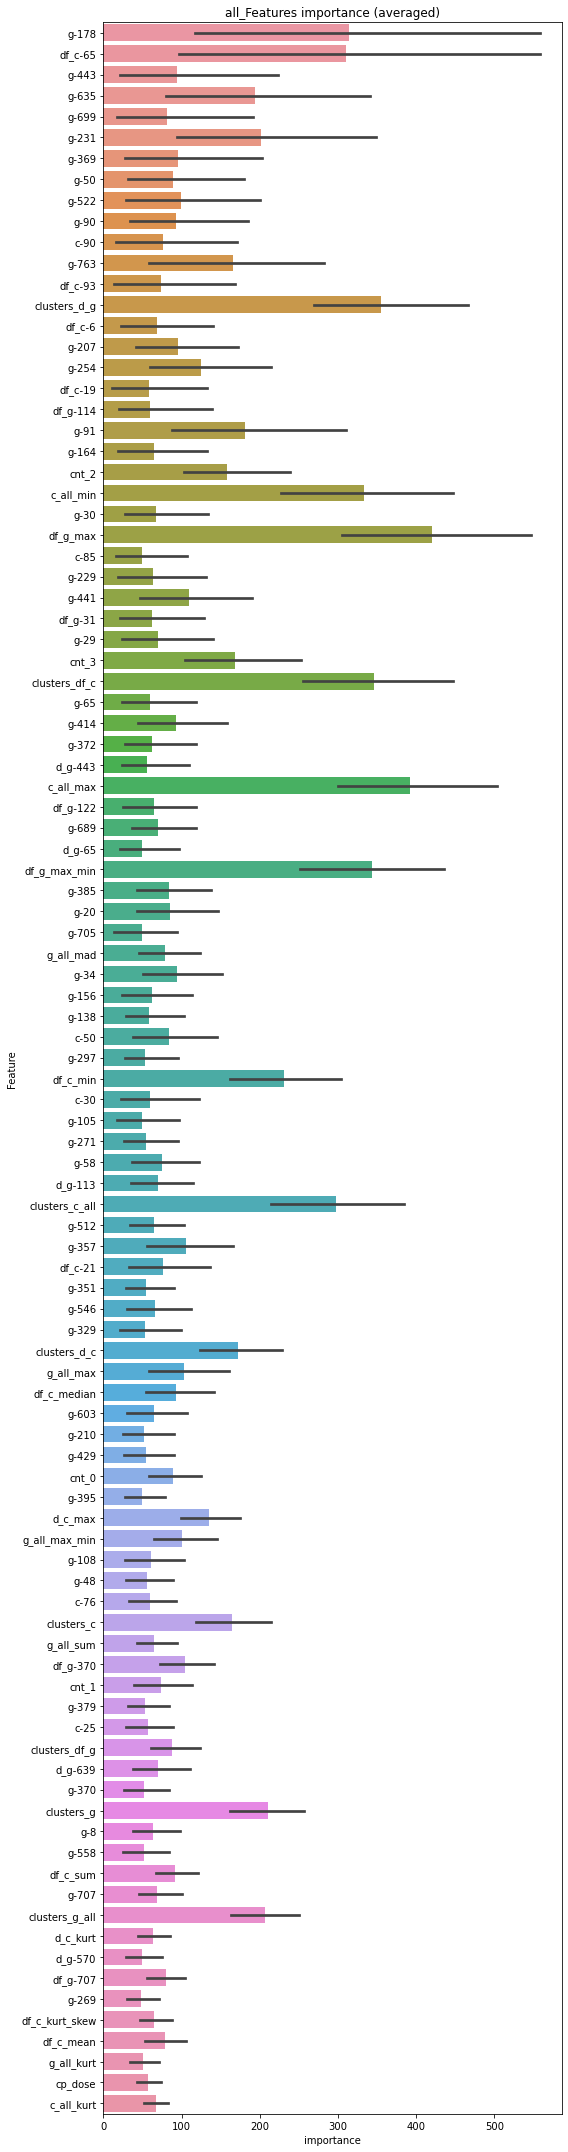

In [50]:
if DEBUG:
    show_feature_importance(feature_importance_df)
    feature_importance_df.to_csv(f'feature_importance_df.{Version}.csv', index=False)
    importance_cols_df.to_csv(f'importance_cols_df.{Version}.csv', index=False)